In [1]:
import pandas as pd
import torch

#grab data from working directory
main_data = pd.read_csv('data/data.csv')
training_data = pd.read_csv('data/training_data.csv')
validation_data = pd.read_csv('data/validation_data.csv')

In [2]:
dtype = torch.float
ltype = torch.long

if torch.cuda.is_available():
  device = torch.device('cuda:0')
else:
  device = torch.device('cpu')

# Constant to control how frequently we print train loss

print('using device:', device)

using device: cuda:0


In [3]:
# prompt: write 2 data preprocessing functions
# the first one filters out all rows that have an empty 'problem_tags' column or have the problem_tags column include "*specialproblem". it also filters out all rows that have empty problem_statement columns
# the second function will split the problem_tags column and split it into two columns. the first resulting column will just be the original problem_tags column and the second resulting column will be rating.
# the problem tags column is originally a comma seperated list and should include some value that looks like *2400 or *2300 or *900, these values are ratings. there should be only one of them, take the rating value and put it in the rating column. if there is a problem with no rating value in its 'problem_tags' column it should be filtered out

def preprocess_data_1(df):
  """
  Filters out rows with empty 'problem_tags' or 'problem_statement' columns,
  and rows where 'problem_tags' contains '*specialproblem'.
  """
  df = df.dropna(subset=['problem_tags', 'problem_statement'])
  df = df[~df['problem_tags'].str.contains(r"\*specialproblem", na=False)]
  return df

def preprocess_data_2(df):
  """
  Splits the 'problem_tags' column into two columns: 'problem_tags' (original)
  and 'rating'. Extracts the rating value from the 'problem_tags' column if
  it exists, otherwise filters out the row.
  """
  def extract_rating(tags):
    if isinstance(tags, str):
      for tag in tags.split(','):
        if '*' in tag and tag.replace('*', '').isdigit():
          return int(tag.replace('*', ''))
    return None

  df.loc[:, 'rating'] = df['problem_tags'].apply(extract_rating)

  #drop rows with no rating
  df = df.dropna(subset=['rating'])

  for i in range(len(df)):
    good_tags = []
    for tag in df.iloc[i]['problem_tags'].split(','):
      if '*' not in tag and tag.split():
        good_tags.append(tag)
    df.loc[df.index[i], 'problem_tags'] = ','.join(good_tags)

  #drop problems with empty string for tags
  df = df[df['problem_tags'] != '']

  return df

main_data = preprocess_data_1(main_data)
main_data = preprocess_data_2(main_data)
training_data = preprocess_data_1(training_data)
training_data = preprocess_data_2(training_data)
validation_data = preprocess_data_1(validation_data)
validation_data = preprocess_data_2(validation_data)

In [4]:

n = 25  # Hyperparameter for the number of most frequent tags

all_tags = []
for tags in main_data['problem_tags'].dropna():
    all_tags.extend(tags.split(','))

from collections import Counter

tag_counts = Counter(all_tags)
most_frequent_tags = set([tag for tag, count in tag_counts.most_common(n)])
index_to_tag = {i: tag for i, tag in enumerate(most_frequent_tags)}
tag_to_index = {tag: i for i, tag in index_to_tag.items()}
print(f"The {n} most frequent tags are: {most_frequent_tags}")

The 25 most frequent tags are: {'constructivealgorithms', 'trees', 'combinatorics', 'binarysearch', 'datastructures', 'graphs', 'implementation', 'divideandconquer', 'sortings', 'dfsandsimilar', 'dp', 'geometry', 'bruteforce', 'shortestpaths', 'interactive', 'greedy', 'math', 'bitmasks', 'dsu', 'twopointers', 'strings', 'hashing', 'numbertheory', 'games', 'probabilities'}


In [5]:
# prompt: what percent of problems use a tag found in the n most common ?

problems_with_top_n_tags = 0
total_problems = len(main_data)

for tags in main_data['problem_tags'].dropna():
  if isinstance(tags, str):
    for tag in tags.split(','):
      if tag in most_frequent_tags:
        problems_with_top_n_tags += 1
        break  # Only count the problem once if it has at least one top-n tag

percentage = (problems_with_top_n_tags / total_problems) * 100
print(f"Percentage of problems with at least one of the top {n} tags: {percentage:.2f}%")

Percentage of problems with at least one of the top 25 tags: 99.45%


In [6]:
# prompt: write a transformation of the training data set where for each problem. lets say the problem has k tags, we include 2^k total versions of the problem, each with all the subsets of its tags, afterwords print the length of the training dataset

def transform_training_data(df):
    transformed_data = []
    for index, row in df.iterrows():
        tags = row['problem_tags'].split(',')
        tags = [tag for tag in tags if tag in most_frequent_tags]
        num_tags = len(tags)
        for i in range(2**num_tags):
            subset_tags = []
            for j in range(num_tags):
                if (i >> j) & 1:
                    subset_tags.append(tags[j])
            new_row = row.copy()
            new_row['problem_tags'] = ','.join(subset_tags)
            transformed_data.append(new_row)
    return pd.DataFrame(transformed_data)

training_data = transform_training_data(training_data)
print(len(training_data))

56806


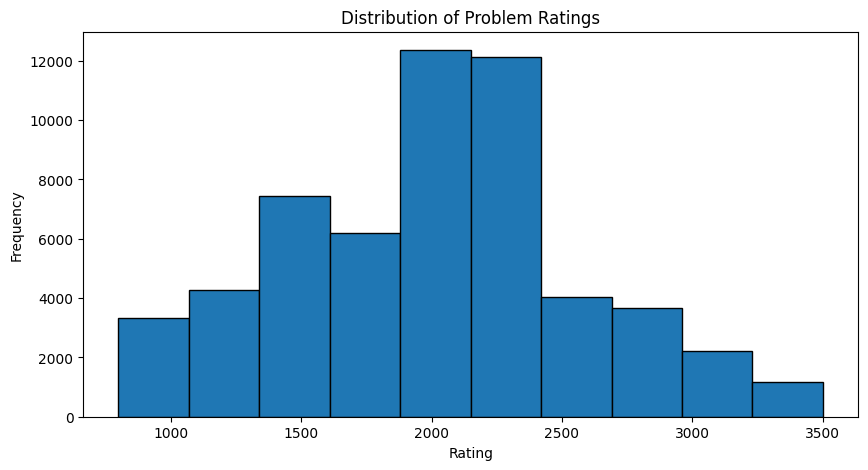

56806


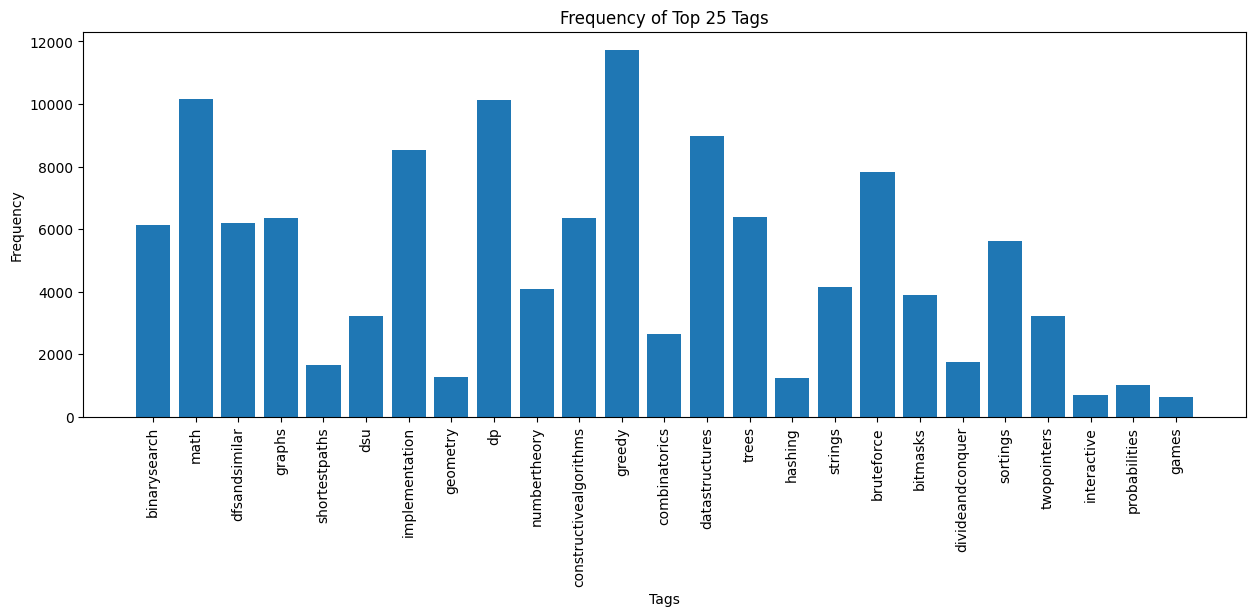

Text(0.5, 1.0, 'Frequency of Number of Tags')

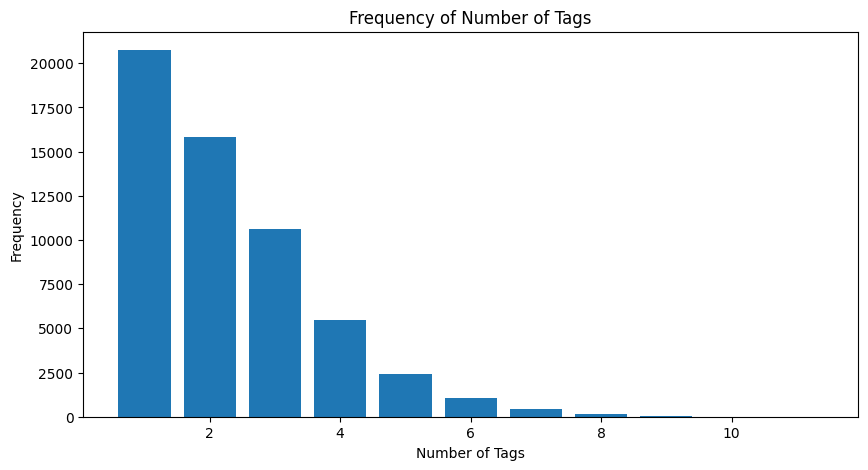

In [7]:
# prompt: make a histogram for the ratings a bar graph for the frequency of each tag in the top n

import matplotlib.pyplot as plt
from collections import Counter

# Assuming 'main_data' and 'most_frequent_tags' are defined as in your previous code

# Histogram for ratings
plt.figure(figsize=(10, 5))
plt.hist(training_data['rating'], bins=10, edgecolor='black')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.title('Distribution of Problem Ratings')
plt.show()

print(len(training_data))

# Bar graph for tag frequency
tag_frequencies = Counter([tag for tags in training_data['problem_tags'].dropna() for tag in tags.split(',') if tag in most_frequent_tags])

plt.figure(figsize=(15, 5))
plt.bar(tag_frequencies.keys(), tag_frequencies.values())
plt.xlabel('Tags')
plt.ylabel('Frequency')
plt.title(f'Frequency of Top {n} Tags')
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
plt.show()


#bar graph for how many problems have k different tags in the top n
tag_counts = {}
for tags in training_data['problem_tags'].dropna():
  if isinstance(tags, str):
    tag_count = len(tags.split(','))
    if tag_count in tag_counts:
      tag_counts[tag_count] += 1
    else:
      tag_counts[tag_count] = 1

plt.figure(figsize=(10, 5))
plt.bar(tag_counts.keys(), tag_counts.values())
plt.xlabel('Number of Tags')
plt.ylabel('Frequency')
plt.title(f'Frequency of Number of Tags')

In [8]:
# prompt: now make a function that takes  the string from problem tags, and returns a pytorch vector of floats length n, where a[i] is 1 iff the ith most frequent problem tag is in the list
# also make a function that takes a rating and computes its zscore when the mean rating is 1500 and the standard deviation is 300
# make an inverse of that function as well
from transformers import BertTokenizer
def problem_tags_to_vector(tags_string, most_frequent_tags, n):
  """
  Converts a string of problem tags to a PyTorch vector of length n.

  Args:
    tags_string: A string of problem tags separated by commas.
    most_frequent_tags: A set of the n most frequent problem tags.
    n: The length of the vector.

  Returns:
    A PyTorch vector of floats, where a[i] is 1 if the ith most frequent
    problem tag is present in the tags_string, and 0 otherwise.
  """
  if not isinstance(tags_string, str):
    return torch.zeros(n)
  tags = set(tags_string.split(','))
  vector = [1.0 if tag in tags else 0.0 for tag in most_frequent_tags]
  return torch.tensor(vector, dtype=torch.float32)

def rating_to_zscore(rating):
  """Computes the z-score of a rating."""
  mean_rating = 1500
  std_rating = 300
  return (rating - mean_rating) / std_rating

def zscore_to_rating(zscore):
  """Computes the rating from a z-score."""
  mean_rating = 1500
  std_rating = 300
  return (zscore * std_rating) + mean_rating

MAXLEN = 512
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
def tokenize_text(text):
  return tokenizer(text, padding='max_length', truncation=True, max_length=MAXLEN)


#TODO
#MOVE THIS TO A MORE SENSIBLE AREA

/common/home/nt406/Desktop/cf-classification/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [9]:
from transformers import BertModel
from torch.utils.data import Dataset
import torch.nn.init as init
import torch.nn as nn

class MultiTaskModel(nn.Module):
    def __init__(self):
        super(MultiTaskModel, self).__init__()
        self.bert = BertModel.from_pretrained('prajjwal1/bert-small')
        self.rating_classifier = nn.Linear(768, 1)  # For regression or binary classification
        self.tag_classifier = nn.Linear(768, n)  # Multi-label classification

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.pooler_output
        rating_pred = self.rating_classifier(pooled_output)
        tag_pred = self.tag_classifier(pooled_output)
        return rating_pred, tag_pred

class TagModel(nn.Module):
    def __init__(self):
        super(TagModel, self).__init__()
        self.bert = BertModel.from_pretrained('prajjwal1/bert-small')
        self.dropout = nn.Dropout(0.4)  # Experiment with dropout rate (e.g., 0.1-0.5)
        self.tag_classifier = nn.Sequential(
            nn.Linear(512, n),  # Your original linear layer
            nn.LayerNorm(n)   # Layer Normalization layer
        )

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.pooler_output
        pooled_output = self.dropout(pooled_output)  # Apply dropout
        tag_pred = self.tag_classifier(pooled_output)
        return tag_pred

def init_weights(m):
    if isinstance(m, nn.Linear):
        init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.01)

class CustomDataset(Dataset):
    def __init__(self, input_ids, attention_mask, ratings, tags, device):
        self.input_ids = input_ids.to(device)
        self.attention_mask = attention_mask.to(device)
        self.ratings = ratings.to(device)
        self.tags = tags.to(device)

    def __len__(self):
        return len(self.input_ids)

    def __getitem__(self, idx):
        return self.input_ids[idx], self.attention_mask[idx], self.ratings[idx], self.tags[idx]

In [10]:
from torch.utils.data import DataLoader, TensorDataset

texts = training_data['problem_statement'].tolist()
encodings = tokenizer(texts, truncation=True, padding=True, max_length=MAXLEN)

tags = training_data['problem_tags'].tolist()
tags = [problem_tags_to_vector(tag, most_frequent_tags, n) for tag in tags]

ratings = training_data['rating'].tolist()
ratings = [rating_to_zscore(rating) for rating in ratings]

input_ids = torch.tensor(encodings['input_ids'])
attention_mask = torch.tensor(encodings['attention_mask'])
ratings = torch.tensor(ratings, dtype=torch.float32)

tags = torch.stack(tags)

#validation stuff
val_texts = validation_data['problem_statement'].tolist()
val_encodings = tokenizer(val_texts, truncation=True, padding=True, max_length=MAXLEN)

val_tags = validation_data['problem_tags'].tolist()
val_tags = [problem_tags_to_vector(tag, most_frequent_tags, n) for tag in val_tags]

val_ratings = validation_data['rating'].tolist()
val_ratings = [rating_to_zscore(rating) for rating in val_ratings]

val_input_ids = torch.tensor(val_encodings['input_ids'])
val_attention_mask = torch.tensor(val_encodings['attention_mask'])
val_ratings = torch.tensor(val_ratings, dtype=torch.float32)

val_tags = torch.stack(val_tags)


bsz = 32
val_dataset = CustomDataset(val_input_ids, val_attention_mask, val_ratings, val_tags, device)
val_loader = DataLoader(val_dataset, batch_size=bsz, shuffle=True)
dataset = CustomDataset(input_ids, attention_mask, ratings, tags, device)
loader = DataLoader(dataset, batch_size=bsz, shuffle=True)

In [11]:
# prompt: write a function that runs the model on the validation data set, and determines its accuracy on each specific tag. Returns a vector length n with the % accuracy for each tag. The model uses a threshold of 0.5 for classification. remember to apply sigmoid to map the output layer to [0,1]

def evaluate_tag_accuracy(model, val_loader, device, n):
  """
  Evaluates the model's accuracy on the validation dataset for each tag.

  Args:
    model: The trained model.
    val_loader: The DataLoader for the validation dataset.
    device: The device to run the model on (e.g., 'cuda' or 'cpu').
    n: The number of tags.

  Returns:
    A list of floats, representing the accuracy for each tag.
  """

  model.eval()  # Set the model to evaluation mode
  tag_correct_counts = [0] * n
  tag_total_counts = [0] * n
  avg_loss = 0
  with torch.no_grad():
    for batch in val_loader:
      input_ids, attention_mask, _, true_tags = batch
      input_ids = input_ids.to(device)
      attention_mask = attention_mask.to(device)
      true_tags = true_tags.to(device)


      tag_pred = model(input_ids, attention_mask)
      loss = nn.BCEWithLogitsLoss()(tag_pred, true_tags)
      avg_loss += loss.item()
      tag_pred = torch.sigmoid(tag_pred)  # Apply sigmoid to get probabilities in [0,1]

      predicted_tags = (tag_pred > 0.5).float()

      for i in range(n):
        tag_correct_counts[i] += (predicted_tags[:, i] == true_tags[:, i]).sum().item()
        tag_total_counts[i] += true_tags.shape[0]
  avg_loss /= len(val_loader)

  tag_accuracies = []
  for i in range(n):
    if tag_total_counts[i] > 0:
      tag_accuracies.append(tag_correct_counts[i] / tag_total_counts[i] * 100)
    else:
      tag_accuracies.append(0.0)

  return (avg_loss,tag_accuracies)

In [12]:
import matplotlib.pyplot as plt
from IPython import display
import torch.optim as optim
from tqdm import tqdm
from torch.optim.lr_scheduler import StepLR

total_losses = []
val_losses = []
val_acc = []

model = TagModel()
model.apply(init_weights)
model.to(device)
optimizer = optim.AdamW(model.parameters(), lr=5e-5)
scheduler = StepLR(optimizer, step_size = 3, gamma = 0.5) # Initialize StepLR
model.train()

EPOCHS = 2
for epoch in range(EPOCHS):
    loop = tqdm(loader, leave=True) # wrap the dataloader with tqdm
    for batch_idx, batch in enumerate(loop):
        input_ids, attention_mask, rating_labels, tag_labels = batch

        optimizer.zero_grad()
        tag_pred = model(input_ids=input_ids, attention_mask=attention_mask)

        loss = nn.BCEWithLogitsLoss()(tag_pred, tag_labels)

        total_losses.append(loss.item())

        loss.backward()
        optimizer.step()

        loop.set_description(f"Epoch [{epoch + 1}/{EPOCHS}]")
        loop.set_postfix(tag_loss=loss.item())

    scheduler.step() # Update learning rate at each step
    print(f"Epoch {epoch + 1} completed.")
    model.eval()
    avg_loss, tag_accuracies = evaluate_tag_accuracy(model, val_loader, device, n)
    val_losses.append(avg_loss)
    val_acc.append(tag_accuracies)
    print(f"Validation Loss: {avg_loss}")
    print(f"Tag Accuracies: {tag_accuracies}")
    model.train()


  0%|          | 0/1776 [00:00<?, ?it/s]

Epoch [1/2]:   0%|          | 0/1776 [00:01<?, ?it/s]

Epoch [1/2]:   0%|          | 0/1776 [00:01<?, ?it/s, tag_loss=0.828]

Epoch [1/2]:   0%|          | 1/1776 [00:01<36:41,  1.24s/it, tag_loss=0.828]

Epoch [1/2]:   0%|          | 1/1776 [00:01<36:41,  1.24s/it, tag_loss=0.828]

Epoch [1/2]:   0%|          | 1/1776 [00:01<36:41,  1.24s/it, tag_loss=0.784]

Epoch [1/2]:   0%|          | 2/1776 [00:01<18:50,  1.57it/s, tag_loss=0.784]

Epoch [1/2]:   0%|          | 2/1776 [00:01<18:50,  1.57it/s, tag_loss=0.784]

Epoch [1/2]:   0%|          | 2/1776 [00:01<18:50,  1.57it/s, tag_loss=0.774]

Epoch [1/2]:   0%|          | 3/1776 [00:01<13:08,  2.25it/s, tag_loss=0.774]

Epoch [1/2]:   0%|          | 3/1776 [00:01<13:08,  2.25it/s, tag_loss=0.774]

Epoch [1/2]:   0%|          | 3/1776 [00:01<13:08,  2.25it/s, tag_loss=0.781]

Epoch [1/2]:   0%|          | 4/1776 [00:01<10:29,  2.82it/s, tag_loss=0.781]

Epoch [1/2]:   0%|          | 4/1776 [00:01<10:29,  2.82it/s, tag_loss=0.781]

Epoch [1/2]:   0%|          | 4/1776 [00:02<10:29,  2.82it/s, tag_loss=0.757]

Epoch [1/2]:   0%|          | 5/1776 [00:02<09:00,  3.28it/s, tag_loss=0.757]

Epoch [1/2]:   0%|          | 5/1776 [00:02<09:00,  3.28it/s, tag_loss=0.757]

Epoch [1/2]:   0%|          | 5/1776 [00:02<09:00,  3.28it/s, tag_loss=0.767]

Epoch [1/2]:   0%|          | 6/1776 [00:02<08:05,  3.64it/s, tag_loss=0.767]

Epoch [1/2]:   0%|          | 6/1776 [00:02<08:05,  3.64it/s, tag_loss=0.767]

Epoch [1/2]:   0%|          | 6/1776 [00:02<08:05,  3.64it/s, tag_loss=0.763]

Epoch [1/2]:   0%|          | 7/1776 [00:02<07:31,  3.92it/s, tag_loss=0.763]

Epoch [1/2]:   0%|          | 7/1776 [00:02<07:31,  3.92it/s, tag_loss=0.763]

Epoch [1/2]:   0%|          | 7/1776 [00:02<07:31,  3.92it/s, tag_loss=0.761]

Epoch [1/2]:   0%|          | 8/1776 [00:02<07:09,  4.11it/s, tag_loss=0.761]

Epoch [1/2]:   0%|          | 8/1776 [00:02<07:09,  4.11it/s, tag_loss=0.761]

Epoch [1/2]:   0%|          | 8/1776 [00:02<07:09,  4.11it/s, tag_loss=0.759]

Epoch [1/2]:   1%|          | 9/1776 [00:02<06:54,  4.26it/s, tag_loss=0.759]

Epoch [1/2]:   1%|          | 9/1776 [00:03<06:54,  4.26it/s, tag_loss=0.759]

Epoch [1/2]:   1%|          | 9/1776 [00:03<06:54,  4.26it/s, tag_loss=0.742]

Epoch [1/2]:   1%|          | 10/1776 [00:03<06:44,  4.37it/s, tag_loss=0.742]

Epoch [1/2]:   1%|          | 10/1776 [00:03<06:44,  4.37it/s, tag_loss=0.742]

Epoch [1/2]:   1%|          | 10/1776 [00:03<06:44,  4.37it/s, tag_loss=0.76] 

Epoch [1/2]:   1%|          | 11/1776 [00:03<06:38,  4.43it/s, tag_loss=0.76]

Epoch [1/2]:   1%|          | 11/1776 [00:03<06:38,  4.43it/s, tag_loss=0.76]

Epoch [1/2]:   1%|          | 11/1776 [00:03<06:38,  4.43it/s, tag_loss=0.764]

Epoch [1/2]:   1%|          | 12/1776 [00:03<06:33,  4.48it/s, tag_loss=0.764]

Epoch [1/2]:   1%|          | 12/1776 [00:03<06:33,  4.48it/s, tag_loss=0.764]

Epoch [1/2]:   1%|          | 12/1776 [00:03<06:33,  4.48it/s, tag_loss=0.76] 

Epoch [1/2]:   1%|          | 13/1776 [00:03<06:29,  4.52it/s, tag_loss=0.76]

Epoch [1/2]:   1%|          | 13/1776 [00:03<06:29,  4.52it/s, tag_loss=0.76]

Epoch [1/2]:   1%|          | 13/1776 [00:04<06:29,  4.52it/s, tag_loss=0.749]

Epoch [1/2]:   1%|          | 14/1776 [00:04<06:27,  4.55it/s, tag_loss=0.749]

Epoch [1/2]:   1%|          | 14/1776 [00:04<06:27,  4.55it/s, tag_loss=0.749]

Epoch [1/2]:   1%|          | 14/1776 [00:04<06:27,  4.55it/s, tag_loss=0.777]

Epoch [1/2]:   1%|          | 15/1776 [00:04<06:25,  4.57it/s, tag_loss=0.777]

Epoch [1/2]:   1%|          | 15/1776 [00:04<06:25,  4.57it/s, tag_loss=0.777]

Epoch [1/2]:   1%|          | 15/1776 [00:04<06:25,  4.57it/s, tag_loss=0.759]

Epoch [1/2]:   1%|          | 16/1776 [00:04<06:24,  4.58it/s, tag_loss=0.759]

Epoch [1/2]:   1%|          | 16/1776 [00:04<06:24,  4.58it/s, tag_loss=0.759]

Epoch [1/2]:   1%|          | 16/1776 [00:04<06:24,  4.58it/s, tag_loss=0.743]

Epoch [1/2]:   1%|          | 17/1776 [00:04<06:22,  4.59it/s, tag_loss=0.743]

Epoch [1/2]:   1%|          | 17/1776 [00:04<06:22,  4.59it/s, tag_loss=0.743]

Epoch [1/2]:   1%|          | 17/1776 [00:04<06:22,  4.59it/s, tag_loss=0.744]

Epoch [1/2]:   1%|          | 18/1776 [00:04<06:21,  4.60it/s, tag_loss=0.744]

Epoch [1/2]:   1%|          | 18/1776 [00:04<06:21,  4.60it/s, tag_loss=0.744]

Epoch [1/2]:   1%|          | 18/1776 [00:05<06:21,  4.60it/s, tag_loss=0.754]

Epoch [1/2]:   1%|          | 19/1776 [00:05<06:21,  4.61it/s, tag_loss=0.754]

Epoch [1/2]:   1%|          | 19/1776 [00:05<06:21,  4.61it/s, tag_loss=0.754]

Epoch [1/2]:   1%|          | 19/1776 [00:05<06:21,  4.61it/s, tag_loss=0.749]

Epoch [1/2]:   1%|          | 20/1776 [00:05<06:20,  4.61it/s, tag_loss=0.749]

Epoch [1/2]:   1%|          | 20/1776 [00:05<06:20,  4.61it/s, tag_loss=0.749]

Epoch [1/2]:   1%|          | 20/1776 [00:05<06:20,  4.61it/s, tag_loss=0.761]

Epoch [1/2]:   1%|          | 21/1776 [00:05<06:20,  4.61it/s, tag_loss=0.761]

Epoch [1/2]:   1%|          | 21/1776 [00:05<06:20,  4.61it/s, tag_loss=0.761]

Epoch [1/2]:   1%|          | 21/1776 [00:05<06:20,  4.61it/s, tag_loss=0.767]

Epoch [1/2]:   1%|          | 22/1776 [00:05<06:21,  4.60it/s, tag_loss=0.767]

Epoch [1/2]:   1%|          | 22/1776 [00:05<06:21,  4.60it/s, tag_loss=0.767]

Epoch [1/2]:   1%|          | 22/1776 [00:06<06:21,  4.60it/s, tag_loss=0.766]

Epoch [1/2]:   1%|▏         | 23/1776 [00:06<06:22,  4.59it/s, tag_loss=0.766]

Epoch [1/2]:   1%|▏         | 23/1776 [00:06<06:22,  4.59it/s, tag_loss=0.766]

Epoch [1/2]:   1%|▏         | 23/1776 [00:06<06:22,  4.59it/s, tag_loss=0.729]

Epoch [1/2]:   1%|▏         | 24/1776 [00:06<06:21,  4.59it/s, tag_loss=0.729]

Epoch [1/2]:   1%|▏         | 24/1776 [00:06<06:21,  4.59it/s, tag_loss=0.729]

Epoch [1/2]:   1%|▏         | 24/1776 [00:06<06:21,  4.59it/s, tag_loss=0.751]

Epoch [1/2]:   1%|▏         | 25/1776 [00:06<06:21,  4.59it/s, tag_loss=0.751]

Epoch [1/2]:   1%|▏         | 25/1776 [00:06<06:21,  4.59it/s, tag_loss=0.751]

Epoch [1/2]:   1%|▏         | 25/1776 [00:06<06:21,  4.59it/s, tag_loss=0.752]

Epoch [1/2]:   1%|▏         | 26/1776 [00:06<06:21,  4.59it/s, tag_loss=0.752]

Epoch [1/2]:   1%|▏         | 26/1776 [00:06<06:21,  4.59it/s, tag_loss=0.752]

Epoch [1/2]:   1%|▏         | 26/1776 [00:06<06:21,  4.59it/s, tag_loss=0.74] 

Epoch [1/2]:   2%|▏         | 27/1776 [00:06<06:20,  4.60it/s, tag_loss=0.74]

Epoch [1/2]:   2%|▏         | 27/1776 [00:06<06:20,  4.60it/s, tag_loss=0.74]

Epoch [1/2]:   2%|▏         | 27/1776 [00:07<06:20,  4.60it/s, tag_loss=0.743]

Epoch [1/2]:   2%|▏         | 28/1776 [00:07<06:20,  4.59it/s, tag_loss=0.743]

Epoch [1/2]:   2%|▏         | 28/1776 [00:07<06:20,  4.59it/s, tag_loss=0.743]

Epoch [1/2]:   2%|▏         | 28/1776 [00:07<06:20,  4.59it/s, tag_loss=0.735]

Epoch [1/2]:   2%|▏         | 29/1776 [00:07<06:20,  4.59it/s, tag_loss=0.735]

Epoch [1/2]:   2%|▏         | 29/1776 [00:07<06:20,  4.59it/s, tag_loss=0.735]

Epoch [1/2]:   2%|▏         | 29/1776 [00:07<06:20,  4.59it/s, tag_loss=0.758]

Epoch [1/2]:   2%|▏         | 30/1776 [00:07<06:20,  4.59it/s, tag_loss=0.758]

Epoch [1/2]:   2%|▏         | 30/1776 [00:07<06:20,  4.59it/s, tag_loss=0.758]

Epoch [1/2]:   2%|▏         | 30/1776 [00:07<06:20,  4.59it/s, tag_loss=0.769]

Epoch [1/2]:   2%|▏         | 31/1776 [00:07<06:20,  4.59it/s, tag_loss=0.769]

Epoch [1/2]:   2%|▏         | 31/1776 [00:07<06:20,  4.59it/s, tag_loss=0.769]

Epoch [1/2]:   2%|▏         | 31/1776 [00:07<06:20,  4.59it/s, tag_loss=0.747]

Epoch [1/2]:   2%|▏         | 32/1776 [00:07<06:21,  4.58it/s, tag_loss=0.747]

Epoch [1/2]:   2%|▏         | 32/1776 [00:08<06:21,  4.58it/s, tag_loss=0.747]

Epoch [1/2]:   2%|▏         | 32/1776 [00:08<06:21,  4.58it/s, tag_loss=0.732]

Epoch [1/2]:   2%|▏         | 33/1776 [00:08<06:20,  4.58it/s, tag_loss=0.732]

Epoch [1/2]:   2%|▏         | 33/1776 [00:08<06:20,  4.58it/s, tag_loss=0.732]

Epoch [1/2]:   2%|▏         | 33/1776 [00:08<06:20,  4.58it/s, tag_loss=0.772]

Epoch [1/2]:   2%|▏         | 34/1776 [00:08<06:20,  4.58it/s, tag_loss=0.772]

Epoch [1/2]:   2%|▏         | 34/1776 [00:08<06:20,  4.58it/s, tag_loss=0.772]

Epoch [1/2]:   2%|▏         | 34/1776 [00:08<06:20,  4.58it/s, tag_loss=0.759]

Epoch [1/2]:   2%|▏         | 35/1776 [00:08<06:20,  4.58it/s, tag_loss=0.759]

Epoch [1/2]:   2%|▏         | 35/1776 [00:08<06:20,  4.58it/s, tag_loss=0.759]

Epoch [1/2]:   2%|▏         | 35/1776 [00:08<06:20,  4.58it/s, tag_loss=0.766]

Epoch [1/2]:   2%|▏         | 36/1776 [00:08<06:19,  4.58it/s, tag_loss=0.766]

Epoch [1/2]:   2%|▏         | 36/1776 [00:08<06:19,  4.58it/s, tag_loss=0.766]

Epoch [1/2]:   2%|▏         | 36/1776 [00:09<06:19,  4.58it/s, tag_loss=0.752]

Epoch [1/2]:   2%|▏         | 37/1776 [00:09<06:19,  4.58it/s, tag_loss=0.752]

Epoch [1/2]:   2%|▏         | 37/1776 [00:09<06:19,  4.58it/s, tag_loss=0.752]

Epoch [1/2]:   2%|▏         | 37/1776 [00:09<06:19,  4.58it/s, tag_loss=0.747]

Epoch [1/2]:   2%|▏         | 38/1776 [00:09<06:19,  4.59it/s, tag_loss=0.747]

Epoch [1/2]:   2%|▏         | 38/1776 [00:09<06:19,  4.59it/s, tag_loss=0.747]

Epoch [1/2]:   2%|▏         | 38/1776 [00:09<06:19,  4.59it/s, tag_loss=0.75] 

Epoch [1/2]:   2%|▏         | 39/1776 [00:09<06:19,  4.58it/s, tag_loss=0.75]

Epoch [1/2]:   2%|▏         | 39/1776 [00:09<06:19,  4.58it/s, tag_loss=0.75]

Epoch [1/2]:   2%|▏         | 39/1776 [00:09<06:19,  4.58it/s, tag_loss=0.747]

Epoch [1/2]:   2%|▏         | 40/1776 [00:09<06:19,  4.57it/s, tag_loss=0.747]

Epoch [1/2]:   2%|▏         | 40/1776 [00:09<06:19,  4.57it/s, tag_loss=0.747]

Epoch [1/2]:   2%|▏         | 40/1776 [00:09<06:19,  4.57it/s, tag_loss=0.761]

Epoch [1/2]:   2%|▏         | 41/1776 [00:09<06:19,  4.58it/s, tag_loss=0.761]

Epoch [1/2]:   2%|▏         | 41/1776 [00:10<06:19,  4.58it/s, tag_loss=0.761]

Epoch [1/2]:   2%|▏         | 41/1776 [00:10<06:19,  4.58it/s, tag_loss=0.765]

Epoch [1/2]:   2%|▏         | 42/1776 [00:10<06:18,  4.58it/s, tag_loss=0.765]

Epoch [1/2]:   2%|▏         | 42/1776 [00:10<06:18,  4.58it/s, tag_loss=0.765]

Epoch [1/2]:   2%|▏         | 42/1776 [00:10<06:18,  4.58it/s, tag_loss=0.741]

Epoch [1/2]:   2%|▏         | 43/1776 [00:10<06:18,  4.58it/s, tag_loss=0.741]

Epoch [1/2]:   2%|▏         | 43/1776 [00:10<06:18,  4.58it/s, tag_loss=0.741]

Epoch [1/2]:   2%|▏         | 43/1776 [00:10<06:18,  4.58it/s, tag_loss=0.749]

Epoch [1/2]:   2%|▏         | 44/1776 [00:10<06:17,  4.59it/s, tag_loss=0.749]

Epoch [1/2]:   2%|▏         | 44/1776 [00:10<06:17,  4.59it/s, tag_loss=0.749]

Epoch [1/2]:   2%|▏         | 44/1776 [00:10<06:17,  4.59it/s, tag_loss=0.762]

Epoch [1/2]:   3%|▎         | 45/1776 [00:10<06:16,  4.59it/s, tag_loss=0.762]

Epoch [1/2]:   3%|▎         | 45/1776 [00:10<06:16,  4.59it/s, tag_loss=0.762]

Epoch [1/2]:   3%|▎         | 45/1776 [00:11<06:16,  4.59it/s, tag_loss=0.756]

Epoch [1/2]:   3%|▎         | 46/1776 [00:11<06:16,  4.60it/s, tag_loss=0.756]

Epoch [1/2]:   3%|▎         | 46/1776 [00:11<06:16,  4.60it/s, tag_loss=0.756]

Epoch [1/2]:   3%|▎         | 46/1776 [00:11<06:16,  4.60it/s, tag_loss=0.774]

Epoch [1/2]:   3%|▎         | 47/1776 [00:11<06:15,  4.61it/s, tag_loss=0.774]

Epoch [1/2]:   3%|▎         | 47/1776 [00:11<06:15,  4.61it/s, tag_loss=0.774]

Epoch [1/2]:   3%|▎         | 47/1776 [00:11<06:15,  4.61it/s, tag_loss=0.755]

Epoch [1/2]:   3%|▎         | 48/1776 [00:11<06:14,  4.61it/s, tag_loss=0.755]

Epoch [1/2]:   3%|▎         | 48/1776 [00:11<06:14,  4.61it/s, tag_loss=0.755]

Epoch [1/2]:   3%|▎         | 48/1776 [00:11<06:14,  4.61it/s, tag_loss=0.755]

Epoch [1/2]:   3%|▎         | 49/1776 [00:11<06:14,  4.61it/s, tag_loss=0.755]

Epoch [1/2]:   3%|▎         | 49/1776 [00:11<06:14,  4.61it/s, tag_loss=0.755]

Epoch [1/2]:   3%|▎         | 49/1776 [00:11<06:14,  4.61it/s, tag_loss=0.748]

Epoch [1/2]:   3%|▎         | 50/1776 [00:11<06:13,  4.62it/s, tag_loss=0.748]

Epoch [1/2]:   3%|▎         | 50/1776 [00:11<06:13,  4.62it/s, tag_loss=0.748]

Epoch [1/2]:   3%|▎         | 50/1776 [00:12<06:13,  4.62it/s, tag_loss=0.764]

Epoch [1/2]:   3%|▎         | 51/1776 [00:12<06:12,  4.63it/s, tag_loss=0.764]

Epoch [1/2]:   3%|▎         | 51/1776 [00:12<06:12,  4.63it/s, tag_loss=0.764]

Epoch [1/2]:   3%|▎         | 51/1776 [00:12<06:12,  4.63it/s, tag_loss=0.751]

Epoch [1/2]:   3%|▎         | 52/1776 [00:12<06:12,  4.63it/s, tag_loss=0.751]

Epoch [1/2]:   3%|▎         | 52/1776 [00:12<06:12,  4.63it/s, tag_loss=0.751]

Epoch [1/2]:   3%|▎         | 52/1776 [00:12<06:12,  4.63it/s, tag_loss=0.766]

Epoch [1/2]:   3%|▎         | 53/1776 [00:12<06:12,  4.62it/s, tag_loss=0.766]

Epoch [1/2]:   3%|▎         | 53/1776 [00:12<06:12,  4.62it/s, tag_loss=0.766]

Epoch [1/2]:   3%|▎         | 53/1776 [00:12<06:12,  4.62it/s, tag_loss=0.735]

Epoch [1/2]:   3%|▎         | 54/1776 [00:12<06:12,  4.62it/s, tag_loss=0.735]

Epoch [1/2]:   3%|▎         | 54/1776 [00:12<06:12,  4.62it/s, tag_loss=0.735]

Epoch [1/2]:   3%|▎         | 54/1776 [00:12<06:12,  4.62it/s, tag_loss=0.743]

Epoch [1/2]:   3%|▎         | 55/1776 [00:12<06:12,  4.62it/s, tag_loss=0.743]

Epoch [1/2]:   3%|▎         | 55/1776 [00:13<06:12,  4.62it/s, tag_loss=0.743]

Epoch [1/2]:   3%|▎         | 55/1776 [00:13<06:12,  4.62it/s, tag_loss=0.761]

Epoch [1/2]:   3%|▎         | 56/1776 [00:13<06:11,  4.63it/s, tag_loss=0.761]

Epoch [1/2]:   3%|▎         | 56/1776 [00:13<06:11,  4.63it/s, tag_loss=0.761]

Epoch [1/2]:   3%|▎         | 56/1776 [00:13<06:11,  4.63it/s, tag_loss=0.73] 

Epoch [1/2]:   3%|▎         | 57/1776 [00:13<06:12,  4.62it/s, tag_loss=0.73]

Epoch [1/2]:   3%|▎         | 57/1776 [00:13<06:12,  4.62it/s, tag_loss=0.73]

Epoch [1/2]:   3%|▎         | 57/1776 [00:13<06:12,  4.62it/s, tag_loss=0.746]

Epoch [1/2]:   3%|▎         | 58/1776 [00:13<06:12,  4.61it/s, tag_loss=0.746]

Epoch [1/2]:   3%|▎         | 58/1776 [00:13<06:12,  4.61it/s, tag_loss=0.746]

Epoch [1/2]:   3%|▎         | 58/1776 [00:13<06:12,  4.61it/s, tag_loss=0.731]

Epoch [1/2]:   3%|▎         | 59/1776 [00:13<06:11,  4.62it/s, tag_loss=0.731]

Epoch [1/2]:   3%|▎         | 59/1776 [00:13<06:11,  4.62it/s, tag_loss=0.731]

Epoch [1/2]:   3%|▎         | 59/1776 [00:14<06:11,  4.62it/s, tag_loss=0.749]

Epoch [1/2]:   3%|▎         | 60/1776 [00:14<06:11,  4.61it/s, tag_loss=0.749]

Epoch [1/2]:   3%|▎         | 60/1776 [00:14<06:11,  4.61it/s, tag_loss=0.749]

Epoch [1/2]:   3%|▎         | 60/1776 [00:14<06:11,  4.61it/s, tag_loss=0.756]

Epoch [1/2]:   3%|▎         | 61/1776 [00:14<06:11,  4.61it/s, tag_loss=0.756]

Epoch [1/2]:   3%|▎         | 61/1776 [00:14<06:11,  4.61it/s, tag_loss=0.756]

Epoch [1/2]:   3%|▎         | 61/1776 [00:14<06:11,  4.61it/s, tag_loss=0.757]

Epoch [1/2]:   3%|▎         | 62/1776 [00:14<06:11,  4.61it/s, tag_loss=0.757]

Epoch [1/2]:   3%|▎         | 62/1776 [00:14<06:11,  4.61it/s, tag_loss=0.757]

Epoch [1/2]:   3%|▎         | 62/1776 [00:14<06:11,  4.61it/s, tag_loss=0.764]

Epoch [1/2]:   4%|▎         | 63/1776 [00:14<06:11,  4.62it/s, tag_loss=0.764]

Epoch [1/2]:   4%|▎         | 63/1776 [00:14<06:11,  4.62it/s, tag_loss=0.764]

Epoch [1/2]:   4%|▎         | 63/1776 [00:14<06:11,  4.62it/s, tag_loss=0.763]

Epoch [1/2]:   4%|▎         | 64/1776 [00:14<06:11,  4.61it/s, tag_loss=0.763]

Epoch [1/2]:   4%|▎         | 64/1776 [00:14<06:11,  4.61it/s, tag_loss=0.763]

Epoch [1/2]:   4%|▎         | 64/1776 [00:15<06:11,  4.61it/s, tag_loss=0.732]

Epoch [1/2]:   4%|▎         | 65/1776 [00:15<06:11,  4.61it/s, tag_loss=0.732]

Epoch [1/2]:   4%|▎         | 65/1776 [00:15<06:11,  4.61it/s, tag_loss=0.732]

Epoch [1/2]:   4%|▎         | 65/1776 [00:15<06:11,  4.61it/s, tag_loss=0.746]

Epoch [1/2]:   4%|▎         | 66/1776 [00:15<06:11,  4.60it/s, tag_loss=0.746]

Epoch [1/2]:   4%|▎         | 66/1776 [00:15<06:11,  4.60it/s, tag_loss=0.746]

Epoch [1/2]:   4%|▎         | 66/1776 [00:15<06:11,  4.60it/s, tag_loss=0.748]

Epoch [1/2]:   4%|▍         | 67/1776 [00:15<06:11,  4.60it/s, tag_loss=0.748]

Epoch [1/2]:   4%|▍         | 67/1776 [00:15<06:11,  4.60it/s, tag_loss=0.748]

Epoch [1/2]:   4%|▍         | 67/1776 [00:15<06:11,  4.60it/s, tag_loss=0.744]

Epoch [1/2]:   4%|▍         | 68/1776 [00:15<06:11,  4.60it/s, tag_loss=0.744]

Epoch [1/2]:   4%|▍         | 68/1776 [00:15<06:11,  4.60it/s, tag_loss=0.744]

Epoch [1/2]:   4%|▍         | 68/1776 [00:16<06:11,  4.60it/s, tag_loss=0.747]

Epoch [1/2]:   4%|▍         | 69/1776 [00:16<06:11,  4.60it/s, tag_loss=0.747]

Epoch [1/2]:   4%|▍         | 69/1776 [00:16<06:11,  4.60it/s, tag_loss=0.747]

Epoch [1/2]:   4%|▍         | 69/1776 [00:16<06:11,  4.60it/s, tag_loss=0.753]

Epoch [1/2]:   4%|▍         | 70/1776 [00:16<06:11,  4.60it/s, tag_loss=0.753]

Epoch [1/2]:   4%|▍         | 70/1776 [00:16<06:11,  4.60it/s, tag_loss=0.753]

Epoch [1/2]:   4%|▍         | 70/1776 [00:16<06:11,  4.60it/s, tag_loss=0.732]

Epoch [1/2]:   4%|▍         | 71/1776 [00:16<06:11,  4.59it/s, tag_loss=0.732]

Epoch [1/2]:   4%|▍         | 71/1776 [00:16<06:11,  4.59it/s, tag_loss=0.732]

Epoch [1/2]:   4%|▍         | 71/1776 [00:16<06:11,  4.59it/s, tag_loss=0.751]

Epoch [1/2]:   4%|▍         | 72/1776 [00:16<06:11,  4.59it/s, tag_loss=0.751]

Epoch [1/2]:   4%|▍         | 72/1776 [00:16<06:11,  4.59it/s, tag_loss=0.751]

Epoch [1/2]:   4%|▍         | 72/1776 [00:16<06:11,  4.59it/s, tag_loss=0.763]

Epoch [1/2]:   4%|▍         | 73/1776 [00:16<06:10,  4.59it/s, tag_loss=0.763]

Epoch [1/2]:   4%|▍         | 73/1776 [00:16<06:10,  4.59it/s, tag_loss=0.763]

Epoch [1/2]:   4%|▍         | 73/1776 [00:17<06:10,  4.59it/s, tag_loss=0.748]

Epoch [1/2]:   4%|▍         | 74/1776 [00:17<06:11,  4.59it/s, tag_loss=0.748]

Epoch [1/2]:   4%|▍         | 74/1776 [00:17<06:11,  4.59it/s, tag_loss=0.748]

Epoch [1/2]:   4%|▍         | 74/1776 [00:17<06:11,  4.59it/s, tag_loss=0.747]

Epoch [1/2]:   4%|▍         | 75/1776 [00:17<06:12,  4.57it/s, tag_loss=0.747]

Epoch [1/2]:   4%|▍         | 75/1776 [00:17<06:12,  4.57it/s, tag_loss=0.747]

Epoch [1/2]:   4%|▍         | 75/1776 [00:17<06:12,  4.57it/s, tag_loss=0.758]

Epoch [1/2]:   4%|▍         | 76/1776 [00:17<06:11,  4.57it/s, tag_loss=0.758]

Epoch [1/2]:   4%|▍         | 76/1776 [00:17<06:11,  4.57it/s, tag_loss=0.758]

Epoch [1/2]:   4%|▍         | 76/1776 [00:17<06:11,  4.57it/s, tag_loss=0.728]

Epoch [1/2]:   4%|▍         | 77/1776 [00:17<06:11,  4.57it/s, tag_loss=0.728]

Epoch [1/2]:   4%|▍         | 77/1776 [00:17<06:11,  4.57it/s, tag_loss=0.728]

Epoch [1/2]:   4%|▍         | 77/1776 [00:17<06:11,  4.57it/s, tag_loss=0.736]

Epoch [1/2]:   4%|▍         | 78/1776 [00:17<06:11,  4.57it/s, tag_loss=0.736]

Epoch [1/2]:   4%|▍         | 78/1776 [00:18<06:11,  4.57it/s, tag_loss=0.736]

Epoch [1/2]:   4%|▍         | 78/1776 [00:18<06:11,  4.57it/s, tag_loss=0.745]

Epoch [1/2]:   4%|▍         | 79/1776 [00:18<06:11,  4.57it/s, tag_loss=0.745]

Epoch [1/2]:   4%|▍         | 79/1776 [00:18<06:11,  4.57it/s, tag_loss=0.745]

Epoch [1/2]:   4%|▍         | 79/1776 [00:18<06:11,  4.57it/s, tag_loss=0.75] 

Epoch [1/2]:   5%|▍         | 80/1776 [00:18<06:11,  4.57it/s, tag_loss=0.75]

Epoch [1/2]:   5%|▍         | 80/1776 [00:18<06:11,  4.57it/s, tag_loss=0.75]

Epoch [1/2]:   5%|▍         | 80/1776 [00:18<06:11,  4.57it/s, tag_loss=0.74]

Epoch [1/2]:   5%|▍         | 81/1776 [00:18<06:10,  4.57it/s, tag_loss=0.74]

Epoch [1/2]:   5%|▍         | 81/1776 [00:18<06:10,  4.57it/s, tag_loss=0.74]

Epoch [1/2]:   5%|▍         | 81/1776 [00:18<06:10,  4.57it/s, tag_loss=0.755]

Epoch [1/2]:   5%|▍         | 82/1776 [00:18<06:10,  4.57it/s, tag_loss=0.755]

Epoch [1/2]:   5%|▍         | 82/1776 [00:18<06:10,  4.57it/s, tag_loss=0.755]

Epoch [1/2]:   5%|▍         | 82/1776 [00:19<06:10,  4.57it/s, tag_loss=0.74] 

Epoch [1/2]:   5%|▍         | 83/1776 [00:19<06:11,  4.56it/s, tag_loss=0.74]

Epoch [1/2]:   5%|▍         | 83/1776 [00:19<06:11,  4.56it/s, tag_loss=0.74]

Epoch [1/2]:   5%|▍         | 83/1776 [00:19<06:11,  4.56it/s, tag_loss=0.751]

Epoch [1/2]:   5%|▍         | 84/1776 [00:19<06:10,  4.56it/s, tag_loss=0.751]

Epoch [1/2]:   5%|▍         | 84/1776 [00:19<06:10,  4.56it/s, tag_loss=0.751]

Epoch [1/2]:   5%|▍         | 84/1776 [00:19<06:10,  4.56it/s, tag_loss=0.747]

Epoch [1/2]:   5%|▍         | 85/1776 [00:19<06:09,  4.57it/s, tag_loss=0.747]

Epoch [1/2]:   5%|▍         | 85/1776 [00:19<06:09,  4.57it/s, tag_loss=0.747]

Epoch [1/2]:   5%|▍         | 85/1776 [00:19<06:09,  4.57it/s, tag_loss=0.712]

Epoch [1/2]:   5%|▍         | 86/1776 [00:19<06:09,  4.57it/s, tag_loss=0.712]

Epoch [1/2]:   5%|▍         | 86/1776 [00:19<06:09,  4.57it/s, tag_loss=0.712]

Epoch [1/2]:   5%|▍         | 86/1776 [00:19<06:09,  4.57it/s, tag_loss=0.739]

Epoch [1/2]:   5%|▍         | 87/1776 [00:19<06:08,  4.58it/s, tag_loss=0.739]

Epoch [1/2]:   5%|▍         | 87/1776 [00:20<06:08,  4.58it/s, tag_loss=0.739]

Epoch [1/2]:   5%|▍         | 87/1776 [00:20<06:08,  4.58it/s, tag_loss=0.757]

Epoch [1/2]:   5%|▍         | 88/1776 [00:20<06:08,  4.58it/s, tag_loss=0.757]

Epoch [1/2]:   5%|▍         | 88/1776 [00:20<06:08,  4.58it/s, tag_loss=0.757]

Epoch [1/2]:   5%|▍         | 88/1776 [00:20<06:08,  4.58it/s, tag_loss=0.754]

Epoch [1/2]:   5%|▌         | 89/1776 [00:20<06:09,  4.57it/s, tag_loss=0.754]

Epoch [1/2]:   5%|▌         | 89/1776 [00:20<06:09,  4.57it/s, tag_loss=0.754]

Epoch [1/2]:   5%|▌         | 89/1776 [00:20<06:09,  4.57it/s, tag_loss=0.733]

Epoch [1/2]:   5%|▌         | 90/1776 [00:20<06:08,  4.57it/s, tag_loss=0.733]

Epoch [1/2]:   5%|▌         | 90/1776 [00:20<06:08,  4.57it/s, tag_loss=0.733]

Epoch [1/2]:   5%|▌         | 90/1776 [00:20<06:08,  4.57it/s, tag_loss=0.749]

Epoch [1/2]:   5%|▌         | 91/1776 [00:20<06:08,  4.57it/s, tag_loss=0.749]

Epoch [1/2]:   5%|▌         | 91/1776 [00:20<06:08,  4.57it/s, tag_loss=0.749]

Epoch [1/2]:   5%|▌         | 91/1776 [00:21<06:08,  4.57it/s, tag_loss=0.77] 

Epoch [1/2]:   5%|▌         | 92/1776 [00:21<06:09,  4.56it/s, tag_loss=0.77]

Epoch [1/2]:   5%|▌         | 92/1776 [00:21<06:09,  4.56it/s, tag_loss=0.77]

Epoch [1/2]:   5%|▌         | 92/1776 [00:21<06:09,  4.56it/s, tag_loss=0.752]

Epoch [1/2]:   5%|▌         | 93/1776 [00:21<06:09,  4.56it/s, tag_loss=0.752]

Epoch [1/2]:   5%|▌         | 93/1776 [00:21<06:09,  4.56it/s, tag_loss=0.752]

Epoch [1/2]:   5%|▌         | 93/1776 [00:21<06:09,  4.56it/s, tag_loss=0.74] 

Epoch [1/2]:   5%|▌         | 94/1776 [00:21<06:09,  4.55it/s, tag_loss=0.74]

Epoch [1/2]:   5%|▌         | 94/1776 [00:21<06:09,  4.55it/s, tag_loss=0.74]

Epoch [1/2]:   5%|▌         | 94/1776 [00:21<06:09,  4.55it/s, tag_loss=0.719]

Epoch [1/2]:   5%|▌         | 95/1776 [00:21<06:09,  4.55it/s, tag_loss=0.719]

Epoch [1/2]:   5%|▌         | 95/1776 [00:21<06:09,  4.55it/s, tag_loss=0.719]

Epoch [1/2]:   5%|▌         | 95/1776 [00:21<06:09,  4.55it/s, tag_loss=0.755]

Epoch [1/2]:   5%|▌         | 96/1776 [00:21<06:09,  4.55it/s, tag_loss=0.755]

Epoch [1/2]:   5%|▌         | 96/1776 [00:22<06:09,  4.55it/s, tag_loss=0.755]

Epoch [1/2]:   5%|▌         | 96/1776 [00:22<06:09,  4.55it/s, tag_loss=0.738]

Epoch [1/2]:   5%|▌         | 97/1776 [00:22<06:09,  4.55it/s, tag_loss=0.738]

Epoch [1/2]:   5%|▌         | 97/1776 [00:22<06:09,  4.55it/s, tag_loss=0.738]

Epoch [1/2]:   5%|▌         | 97/1776 [00:22<06:09,  4.55it/s, tag_loss=0.749]

Epoch [1/2]:   6%|▌         | 98/1776 [00:22<06:08,  4.55it/s, tag_loss=0.749]

Epoch [1/2]:   6%|▌         | 98/1776 [00:22<06:08,  4.55it/s, tag_loss=0.749]

Epoch [1/2]:   6%|▌         | 98/1776 [00:22<06:08,  4.55it/s, tag_loss=0.748]

Epoch [1/2]:   6%|▌         | 99/1776 [00:22<06:08,  4.55it/s, tag_loss=0.748]

Epoch [1/2]:   6%|▌         | 99/1776 [00:22<06:08,  4.55it/s, tag_loss=0.748]

Epoch [1/2]:   6%|▌         | 99/1776 [00:22<06:08,  4.55it/s, tag_loss=0.731]

Epoch [1/2]:   6%|▌         | 100/1776 [00:22<06:07,  4.56it/s, tag_loss=0.731]

Epoch [1/2]:   6%|▌         | 100/1776 [00:22<06:07,  4.56it/s, tag_loss=0.731]

Epoch [1/2]:   6%|▌         | 100/1776 [00:23<06:07,  4.56it/s, tag_loss=0.748]

Epoch [1/2]:   6%|▌         | 101/1776 [00:23<06:08,  4.55it/s, tag_loss=0.748]

Epoch [1/2]:   6%|▌         | 101/1776 [00:23<06:08,  4.55it/s, tag_loss=0.748]

Epoch [1/2]:   6%|▌         | 101/1776 [00:23<06:08,  4.55it/s, tag_loss=0.748]

Epoch [1/2]:   6%|▌         | 102/1776 [00:23<06:08,  4.55it/s, tag_loss=0.748]

Epoch [1/2]:   6%|▌         | 102/1776 [00:23<06:08,  4.55it/s, tag_loss=0.748]

Epoch [1/2]:   6%|▌         | 102/1776 [00:23<06:08,  4.55it/s, tag_loss=0.738]

Epoch [1/2]:   6%|▌         | 103/1776 [00:23<06:08,  4.54it/s, tag_loss=0.738]

Epoch [1/2]:   6%|▌         | 103/1776 [00:23<06:08,  4.54it/s, tag_loss=0.738]

Epoch [1/2]:   6%|▌         | 103/1776 [00:23<06:08,  4.54it/s, tag_loss=0.76] 

Epoch [1/2]:   6%|▌         | 104/1776 [00:23<06:08,  4.54it/s, tag_loss=0.76]

Epoch [1/2]:   6%|▌         | 104/1776 [00:23<06:08,  4.54it/s, tag_loss=0.76]

Epoch [1/2]:   6%|▌         | 104/1776 [00:23<06:08,  4.54it/s, tag_loss=0.714]

Epoch [1/2]:   6%|▌         | 105/1776 [00:23<06:08,  4.54it/s, tag_loss=0.714]

Epoch [1/2]:   6%|▌         | 105/1776 [00:23<06:08,  4.54it/s, tag_loss=0.714]

Epoch [1/2]:   6%|▌         | 105/1776 [00:24<06:08,  4.54it/s, tag_loss=0.727]

Epoch [1/2]:   6%|▌         | 106/1776 [00:24<06:07,  4.54it/s, tag_loss=0.727]

Epoch [1/2]:   6%|▌         | 106/1776 [00:24<06:07,  4.54it/s, tag_loss=0.727]

Epoch [1/2]:   6%|▌         | 106/1776 [00:24<06:07,  4.54it/s, tag_loss=0.753]

Epoch [1/2]:   6%|▌         | 107/1776 [00:24<06:07,  4.54it/s, tag_loss=0.753]

Epoch [1/2]:   6%|▌         | 107/1776 [00:24<06:07,  4.54it/s, tag_loss=0.753]

Epoch [1/2]:   6%|▌         | 107/1776 [00:24<06:07,  4.54it/s, tag_loss=0.721]

Epoch [1/2]:   6%|▌         | 108/1776 [00:24<06:07,  4.54it/s, tag_loss=0.721]

Epoch [1/2]:   6%|▌         | 108/1776 [00:24<06:07,  4.54it/s, tag_loss=0.721]

Epoch [1/2]:   6%|▌         | 108/1776 [00:24<06:07,  4.54it/s, tag_loss=0.739]

Epoch [1/2]:   6%|▌         | 109/1776 [00:24<06:06,  4.55it/s, tag_loss=0.739]

Epoch [1/2]:   6%|▌         | 109/1776 [00:24<06:06,  4.55it/s, tag_loss=0.739]

Epoch [1/2]:   6%|▌         | 109/1776 [00:25<06:06,  4.55it/s, tag_loss=0.742]

Epoch [1/2]:   6%|▌         | 110/1776 [00:25<06:06,  4.54it/s, tag_loss=0.742]

Epoch [1/2]:   6%|▌         | 110/1776 [00:25<06:06,  4.54it/s, tag_loss=0.742]

Epoch [1/2]:   6%|▌         | 110/1776 [00:25<06:06,  4.54it/s, tag_loss=0.734]

Epoch [1/2]:   6%|▋         | 111/1776 [00:25<06:06,  4.55it/s, tag_loss=0.734]

Epoch [1/2]:   6%|▋         | 111/1776 [00:25<06:06,  4.55it/s, tag_loss=0.734]

Epoch [1/2]:   6%|▋         | 111/1776 [00:25<06:06,  4.55it/s, tag_loss=0.728]

Epoch [1/2]:   6%|▋         | 112/1776 [00:25<06:05,  4.55it/s, tag_loss=0.728]

Epoch [1/2]:   6%|▋         | 112/1776 [00:25<06:05,  4.55it/s, tag_loss=0.728]

Epoch [1/2]:   6%|▋         | 112/1776 [00:25<06:05,  4.55it/s, tag_loss=0.721]

Epoch [1/2]:   6%|▋         | 113/1776 [00:25<06:05,  4.55it/s, tag_loss=0.721]

Epoch [1/2]:   6%|▋         | 113/1776 [00:25<06:05,  4.55it/s, tag_loss=0.721]

Epoch [1/2]:   6%|▋         | 113/1776 [00:25<06:05,  4.55it/s, tag_loss=0.744]

Epoch [1/2]:   6%|▋         | 114/1776 [00:25<06:05,  4.55it/s, tag_loss=0.744]

Epoch [1/2]:   6%|▋         | 114/1776 [00:25<06:05,  4.55it/s, tag_loss=0.744]

Epoch [1/2]:   6%|▋         | 114/1776 [00:26<06:05,  4.55it/s, tag_loss=0.734]

Epoch [1/2]:   6%|▋         | 115/1776 [00:26<06:05,  4.54it/s, tag_loss=0.734]

Epoch [1/2]:   6%|▋         | 115/1776 [00:26<06:05,  4.54it/s, tag_loss=0.734]

Epoch [1/2]:   6%|▋         | 115/1776 [00:26<06:05,  4.54it/s, tag_loss=0.738]

Epoch [1/2]:   7%|▋         | 116/1776 [00:26<06:04,  4.55it/s, tag_loss=0.738]

Epoch [1/2]:   7%|▋         | 116/1776 [00:26<06:04,  4.55it/s, tag_loss=0.738]

Epoch [1/2]:   7%|▋         | 116/1776 [00:26<06:04,  4.55it/s, tag_loss=0.734]

Epoch [1/2]:   7%|▋         | 117/1776 [00:26<06:04,  4.55it/s, tag_loss=0.734]

Epoch [1/2]:   7%|▋         | 117/1776 [00:26<06:04,  4.55it/s, tag_loss=0.734]

Epoch [1/2]:   7%|▋         | 117/1776 [00:26<06:04,  4.55it/s, tag_loss=0.723]

Epoch [1/2]:   7%|▋         | 118/1776 [00:26<06:04,  4.55it/s, tag_loss=0.723]

Epoch [1/2]:   7%|▋         | 118/1776 [00:26<06:04,  4.55it/s, tag_loss=0.723]

Epoch [1/2]:   7%|▋         | 118/1776 [00:26<06:04,  4.55it/s, tag_loss=0.761]

Epoch [1/2]:   7%|▋         | 119/1776 [00:26<06:05,  4.53it/s, tag_loss=0.761]

Epoch [1/2]:   7%|▋         | 119/1776 [00:27<06:05,  4.53it/s, tag_loss=0.761]

Epoch [1/2]:   7%|▋         | 119/1776 [00:27<06:05,  4.53it/s, tag_loss=0.724]

Epoch [1/2]:   7%|▋         | 120/1776 [00:27<06:05,  4.53it/s, tag_loss=0.724]

Epoch [1/2]:   7%|▋         | 120/1776 [00:27<06:05,  4.53it/s, tag_loss=0.724]

Epoch [1/2]:   7%|▋         | 120/1776 [00:27<06:05,  4.53it/s, tag_loss=0.736]

Epoch [1/2]:   7%|▋         | 121/1776 [00:27<06:04,  4.54it/s, tag_loss=0.736]

Epoch [1/2]:   7%|▋         | 121/1776 [00:27<06:04,  4.54it/s, tag_loss=0.736]

Epoch [1/2]:   7%|▋         | 121/1776 [00:27<06:04,  4.54it/s, tag_loss=0.738]

Epoch [1/2]:   7%|▋         | 122/1776 [00:27<06:04,  4.54it/s, tag_loss=0.738]

Epoch [1/2]:   7%|▋         | 122/1776 [00:27<06:04,  4.54it/s, tag_loss=0.738]

Epoch [1/2]:   7%|▋         | 122/1776 [00:27<06:04,  4.54it/s, tag_loss=0.725]

Epoch [1/2]:   7%|▋         | 123/1776 [00:27<06:03,  4.55it/s, tag_loss=0.725]

Epoch [1/2]:   7%|▋         | 123/1776 [00:27<06:03,  4.55it/s, tag_loss=0.725]

Epoch [1/2]:   7%|▋         | 123/1776 [00:28<06:03,  4.55it/s, tag_loss=0.749]

Epoch [1/2]:   7%|▋         | 124/1776 [00:28<06:03,  4.55it/s, tag_loss=0.749]

Epoch [1/2]:   7%|▋         | 124/1776 [00:28<06:03,  4.55it/s, tag_loss=0.749]

Epoch [1/2]:   7%|▋         | 124/1776 [00:28<06:03,  4.55it/s, tag_loss=0.732]

Epoch [1/2]:   7%|▋         | 125/1776 [00:28<06:03,  4.54it/s, tag_loss=0.732]

Epoch [1/2]:   7%|▋         | 125/1776 [00:28<06:03,  4.54it/s, tag_loss=0.732]

Epoch [1/2]:   7%|▋         | 125/1776 [00:28<06:03,  4.54it/s, tag_loss=0.752]

Epoch [1/2]:   7%|▋         | 126/1776 [00:28<06:03,  4.54it/s, tag_loss=0.752]

Epoch [1/2]:   7%|▋         | 126/1776 [00:28<06:03,  4.54it/s, tag_loss=0.752]

Epoch [1/2]:   7%|▋         | 126/1776 [00:28<06:03,  4.54it/s, tag_loss=0.733]

Epoch [1/2]:   7%|▋         | 127/1776 [00:28<06:03,  4.54it/s, tag_loss=0.733]

Epoch [1/2]:   7%|▋         | 127/1776 [00:28<06:03,  4.54it/s, tag_loss=0.733]

Epoch [1/2]:   7%|▋         | 127/1776 [00:28<06:03,  4.54it/s, tag_loss=0.745]

Epoch [1/2]:   7%|▋         | 128/1776 [00:28<06:02,  4.54it/s, tag_loss=0.745]

Epoch [1/2]:   7%|▋         | 128/1776 [00:29<06:02,  4.54it/s, tag_loss=0.745]

Epoch [1/2]:   7%|▋         | 128/1776 [00:29<06:02,  4.54it/s, tag_loss=0.746]

Epoch [1/2]:   7%|▋         | 129/1776 [00:29<06:02,  4.55it/s, tag_loss=0.746]

Epoch [1/2]:   7%|▋         | 129/1776 [00:29<06:02,  4.55it/s, tag_loss=0.746]

Epoch [1/2]:   7%|▋         | 129/1776 [00:29<06:02,  4.55it/s, tag_loss=0.733]

Epoch [1/2]:   7%|▋         | 130/1776 [00:29<06:02,  4.54it/s, tag_loss=0.733]

Epoch [1/2]:   7%|▋         | 130/1776 [00:29<06:02,  4.54it/s, tag_loss=0.733]

Epoch [1/2]:   7%|▋         | 130/1776 [00:29<06:02,  4.54it/s, tag_loss=0.731]

Epoch [1/2]:   7%|▋         | 131/1776 [00:29<06:03,  4.53it/s, tag_loss=0.731]

Epoch [1/2]:   7%|▋         | 131/1776 [00:29<06:03,  4.53it/s, tag_loss=0.731]

Epoch [1/2]:   7%|▋         | 131/1776 [00:29<06:03,  4.53it/s, tag_loss=0.734]

Epoch [1/2]:   7%|▋         | 132/1776 [00:29<06:03,  4.53it/s, tag_loss=0.734]

Epoch [1/2]:   7%|▋         | 132/1776 [00:29<06:03,  4.53it/s, tag_loss=0.734]

Epoch [1/2]:   7%|▋         | 132/1776 [00:30<06:03,  4.53it/s, tag_loss=0.694]

Epoch [1/2]:   7%|▋         | 133/1776 [00:30<06:02,  4.53it/s, tag_loss=0.694]

Epoch [1/2]:   7%|▋         | 133/1776 [00:30<06:02,  4.53it/s, tag_loss=0.694]

Epoch [1/2]:   7%|▋         | 133/1776 [00:30<06:02,  4.53it/s, tag_loss=0.743]

Epoch [1/2]:   8%|▊         | 134/1776 [00:30<06:02,  4.53it/s, tag_loss=0.743]

Epoch [1/2]:   8%|▊         | 134/1776 [00:30<06:02,  4.53it/s, tag_loss=0.743]

Epoch [1/2]:   8%|▊         | 134/1776 [00:30<06:02,  4.53it/s, tag_loss=0.733]

Epoch [1/2]:   8%|▊         | 135/1776 [00:30<06:03,  4.52it/s, tag_loss=0.733]

Epoch [1/2]:   8%|▊         | 135/1776 [00:30<06:03,  4.52it/s, tag_loss=0.733]

Epoch [1/2]:   8%|▊         | 135/1776 [00:30<06:03,  4.52it/s, tag_loss=0.717]

Epoch [1/2]:   8%|▊         | 136/1776 [00:30<06:03,  4.51it/s, tag_loss=0.717]

Epoch [1/2]:   8%|▊         | 136/1776 [00:30<06:03,  4.51it/s, tag_loss=0.717]

Epoch [1/2]:   8%|▊         | 136/1776 [00:30<06:03,  4.51it/s, tag_loss=0.735]

Epoch [1/2]:   8%|▊         | 137/1776 [00:30<06:03,  4.51it/s, tag_loss=0.735]

Epoch [1/2]:   8%|▊         | 137/1776 [00:31<06:03,  4.51it/s, tag_loss=0.735]

Epoch [1/2]:   8%|▊         | 137/1776 [00:31<06:03,  4.51it/s, tag_loss=0.73] 

Epoch [1/2]:   8%|▊         | 138/1776 [00:31<06:03,  4.51it/s, tag_loss=0.73]

Epoch [1/2]:   8%|▊         | 138/1776 [00:31<06:03,  4.51it/s, tag_loss=0.73]

Epoch [1/2]:   8%|▊         | 138/1776 [00:31<06:03,  4.51it/s, tag_loss=0.742]

Epoch [1/2]:   8%|▊         | 139/1776 [00:31<06:03,  4.51it/s, tag_loss=0.742]

Epoch [1/2]:   8%|▊         | 139/1776 [00:31<06:03,  4.51it/s, tag_loss=0.742]

Epoch [1/2]:   8%|▊         | 139/1776 [00:31<06:03,  4.51it/s, tag_loss=0.719]

Epoch [1/2]:   8%|▊         | 140/1776 [00:31<06:02,  4.51it/s, tag_loss=0.719]

Epoch [1/2]:   8%|▊         | 140/1776 [00:31<06:02,  4.51it/s, tag_loss=0.719]

Epoch [1/2]:   8%|▊         | 140/1776 [00:31<06:02,  4.51it/s, tag_loss=0.732]

Epoch [1/2]:   8%|▊         | 141/1776 [00:31<06:02,  4.51it/s, tag_loss=0.732]

Epoch [1/2]:   8%|▊         | 141/1776 [00:31<06:02,  4.51it/s, tag_loss=0.732]

Epoch [1/2]:   8%|▊         | 141/1776 [00:32<06:02,  4.51it/s, tag_loss=0.732]

Epoch [1/2]:   8%|▊         | 142/1776 [00:32<06:02,  4.51it/s, tag_loss=0.732]

Epoch [1/2]:   8%|▊         | 142/1776 [00:32<06:02,  4.51it/s, tag_loss=0.732]

Epoch [1/2]:   8%|▊         | 142/1776 [00:32<06:02,  4.51it/s, tag_loss=0.741]

Epoch [1/2]:   8%|▊         | 143/1776 [00:32<06:02,  4.51it/s, tag_loss=0.741]

Epoch [1/2]:   8%|▊         | 143/1776 [00:32<06:02,  4.51it/s, tag_loss=0.741]

Epoch [1/2]:   8%|▊         | 143/1776 [00:32<06:02,  4.51it/s, tag_loss=0.738]

Epoch [1/2]:   8%|▊         | 144/1776 [00:32<06:02,  4.51it/s, tag_loss=0.738]

Epoch [1/2]:   8%|▊         | 144/1776 [00:32<06:02,  4.51it/s, tag_loss=0.738]

Epoch [1/2]:   8%|▊         | 144/1776 [00:32<06:02,  4.51it/s, tag_loss=0.731]

Epoch [1/2]:   8%|▊         | 145/1776 [00:32<06:02,  4.50it/s, tag_loss=0.731]

Epoch [1/2]:   8%|▊         | 145/1776 [00:32<06:02,  4.50it/s, tag_loss=0.731]

Epoch [1/2]:   8%|▊         | 145/1776 [00:32<06:02,  4.50it/s, tag_loss=0.743]

Epoch [1/2]:   8%|▊         | 146/1776 [00:32<06:01,  4.50it/s, tag_loss=0.743]

Epoch [1/2]:   8%|▊         | 146/1776 [00:33<06:01,  4.50it/s, tag_loss=0.743]

Epoch [1/2]:   8%|▊         | 146/1776 [00:33<06:01,  4.50it/s, tag_loss=0.719]

Epoch [1/2]:   8%|▊         | 147/1776 [00:33<06:02,  4.49it/s, tag_loss=0.719]

Epoch [1/2]:   8%|▊         | 147/1776 [00:33<06:02,  4.49it/s, tag_loss=0.719]

Epoch [1/2]:   8%|▊         | 147/1776 [00:33<06:02,  4.49it/s, tag_loss=0.72] 

Epoch [1/2]:   8%|▊         | 148/1776 [00:33<06:03,  4.48it/s, tag_loss=0.72]

Epoch [1/2]:   8%|▊         | 148/1776 [00:33<06:03,  4.48it/s, tag_loss=0.72]

Epoch [1/2]:   8%|▊         | 148/1776 [00:33<06:03,  4.48it/s, tag_loss=0.75]

Epoch [1/2]:   8%|▊         | 149/1776 [00:33<06:02,  4.48it/s, tag_loss=0.75]

Epoch [1/2]:   8%|▊         | 149/1776 [00:33<06:02,  4.48it/s, tag_loss=0.75]

Epoch [1/2]:   8%|▊         | 149/1776 [00:33<06:02,  4.48it/s, tag_loss=0.721]

Epoch [1/2]:   8%|▊         | 150/1776 [00:33<06:02,  4.48it/s, tag_loss=0.721]

Epoch [1/2]:   8%|▊         | 150/1776 [00:33<06:02,  4.48it/s, tag_loss=0.721]

Epoch [1/2]:   8%|▊         | 150/1776 [00:34<06:02,  4.48it/s, tag_loss=0.736]

Epoch [1/2]:   9%|▊         | 151/1776 [00:34<06:02,  4.48it/s, tag_loss=0.736]

Epoch [1/2]:   9%|▊         | 151/1776 [00:34<06:02,  4.48it/s, tag_loss=0.736]

Epoch [1/2]:   9%|▊         | 151/1776 [00:34<06:02,  4.48it/s, tag_loss=0.759]

Epoch [1/2]:   9%|▊         | 152/1776 [00:34<06:02,  4.48it/s, tag_loss=0.759]

Epoch [1/2]:   9%|▊         | 152/1776 [00:34<06:02,  4.48it/s, tag_loss=0.759]

Epoch [1/2]:   9%|▊         | 152/1776 [00:34<06:02,  4.48it/s, tag_loss=0.74] 

Epoch [1/2]:   9%|▊         | 153/1776 [00:34<06:02,  4.47it/s, tag_loss=0.74]

Epoch [1/2]:   9%|▊         | 153/1776 [00:34<06:02,  4.47it/s, tag_loss=0.74]

Epoch [1/2]:   9%|▊         | 153/1776 [00:34<06:02,  4.47it/s, tag_loss=0.727]

Epoch [1/2]:   9%|▊         | 154/1776 [00:34<06:02,  4.48it/s, tag_loss=0.727]

Epoch [1/2]:   9%|▊         | 154/1776 [00:34<06:02,  4.48it/s, tag_loss=0.727]

Epoch [1/2]:   9%|▊         | 154/1776 [00:34<06:02,  4.48it/s, tag_loss=0.714]

Epoch [1/2]:   9%|▊         | 155/1776 [00:34<06:01,  4.48it/s, tag_loss=0.714]

Epoch [1/2]:   9%|▊         | 155/1776 [00:35<06:01,  4.48it/s, tag_loss=0.714]

Epoch [1/2]:   9%|▊         | 155/1776 [00:35<06:01,  4.48it/s, tag_loss=0.753]

Epoch [1/2]:   9%|▉         | 156/1776 [00:35<06:00,  4.49it/s, tag_loss=0.753]

Epoch [1/2]:   9%|▉         | 156/1776 [00:35<06:00,  4.49it/s, tag_loss=0.753]

Epoch [1/2]:   9%|▉         | 156/1776 [00:35<06:00,  4.49it/s, tag_loss=0.729]

Epoch [1/2]:   9%|▉         | 157/1776 [00:35<06:01,  4.48it/s, tag_loss=0.729]

Epoch [1/2]:   9%|▉         | 157/1776 [00:35<06:01,  4.48it/s, tag_loss=0.729]

Epoch [1/2]:   9%|▉         | 157/1776 [00:35<06:01,  4.48it/s, tag_loss=0.722]

Epoch [1/2]:   9%|▉         | 158/1776 [00:35<06:01,  4.48it/s, tag_loss=0.722]

Epoch [1/2]:   9%|▉         | 158/1776 [00:35<06:01,  4.48it/s, tag_loss=0.722]

Epoch [1/2]:   9%|▉         | 158/1776 [00:35<06:01,  4.48it/s, tag_loss=0.717]

Epoch [1/2]:   9%|▉         | 159/1776 [00:35<06:01,  4.48it/s, tag_loss=0.717]

Epoch [1/2]:   9%|▉         | 159/1776 [00:35<06:01,  4.48it/s, tag_loss=0.717]

Epoch [1/2]:   9%|▉         | 159/1776 [00:36<06:01,  4.48it/s, tag_loss=0.704]

Epoch [1/2]:   9%|▉         | 160/1776 [00:36<06:01,  4.48it/s, tag_loss=0.704]

Epoch [1/2]:   9%|▉         | 160/1776 [00:36<06:01,  4.48it/s, tag_loss=0.704]

Epoch [1/2]:   9%|▉         | 160/1776 [00:36<06:01,  4.48it/s, tag_loss=0.709]

Epoch [1/2]:   9%|▉         | 161/1776 [00:36<06:00,  4.48it/s, tag_loss=0.709]

Epoch [1/2]:   9%|▉         | 161/1776 [00:36<06:00,  4.48it/s, tag_loss=0.709]

Epoch [1/2]:   9%|▉         | 161/1776 [00:36<06:00,  4.48it/s, tag_loss=0.746]

Epoch [1/2]:   9%|▉         | 162/1776 [00:36<06:00,  4.48it/s, tag_loss=0.746]

Epoch [1/2]:   9%|▉         | 162/1776 [00:36<06:00,  4.48it/s, tag_loss=0.746]

Epoch [1/2]:   9%|▉         | 162/1776 [00:36<06:00,  4.48it/s, tag_loss=0.729]

Epoch [1/2]:   9%|▉         | 163/1776 [00:36<06:00,  4.47it/s, tag_loss=0.729]

Epoch [1/2]:   9%|▉         | 163/1776 [00:36<06:00,  4.47it/s, tag_loss=0.729]

Epoch [1/2]:   9%|▉         | 163/1776 [00:36<06:00,  4.47it/s, tag_loss=0.736]

Epoch [1/2]:   9%|▉         | 164/1776 [00:36<06:00,  4.47it/s, tag_loss=0.736]

Epoch [1/2]:   9%|▉         | 164/1776 [00:37<06:00,  4.47it/s, tag_loss=0.736]

Epoch [1/2]:   9%|▉         | 164/1776 [00:37<06:00,  4.47it/s, tag_loss=0.724]

Epoch [1/2]:   9%|▉         | 165/1776 [00:37<06:00,  4.47it/s, tag_loss=0.724]

Epoch [1/2]:   9%|▉         | 165/1776 [00:37<06:00,  4.47it/s, tag_loss=0.724]

Epoch [1/2]:   9%|▉         | 165/1776 [00:37<06:00,  4.47it/s, tag_loss=0.714]

Epoch [1/2]:   9%|▉         | 166/1776 [00:37<06:00,  4.47it/s, tag_loss=0.714]

Epoch [1/2]:   9%|▉         | 166/1776 [00:37<06:00,  4.47it/s, tag_loss=0.714]

Epoch [1/2]:   9%|▉         | 166/1776 [00:37<06:00,  4.47it/s, tag_loss=0.723]

Epoch [1/2]:   9%|▉         | 167/1776 [00:37<05:59,  4.47it/s, tag_loss=0.723]

Epoch [1/2]:   9%|▉         | 167/1776 [00:37<05:59,  4.47it/s, tag_loss=0.723]

Epoch [1/2]:   9%|▉         | 167/1776 [00:37<05:59,  4.47it/s, tag_loss=0.727]

Epoch [1/2]:   9%|▉         | 168/1776 [00:37<05:59,  4.48it/s, tag_loss=0.727]

Epoch [1/2]:   9%|▉         | 168/1776 [00:37<05:59,  4.48it/s, tag_loss=0.727]

Epoch [1/2]:   9%|▉         | 168/1776 [00:38<05:59,  4.48it/s, tag_loss=0.744]

Epoch [1/2]:  10%|▉         | 169/1776 [00:38<05:59,  4.47it/s, tag_loss=0.744]

Epoch [1/2]:  10%|▉         | 169/1776 [00:38<05:59,  4.47it/s, tag_loss=0.744]

Epoch [1/2]:  10%|▉         | 169/1776 [00:38<05:59,  4.47it/s, tag_loss=0.748]

Epoch [1/2]:  10%|▉         | 170/1776 [00:38<05:59,  4.47it/s, tag_loss=0.748]

Epoch [1/2]:  10%|▉         | 170/1776 [00:38<05:59,  4.47it/s, tag_loss=0.748]

Epoch [1/2]:  10%|▉         | 170/1776 [00:38<05:59,  4.47it/s, tag_loss=0.706]

Epoch [1/2]:  10%|▉         | 171/1776 [00:38<05:58,  4.47it/s, tag_loss=0.706]

Epoch [1/2]:  10%|▉         | 171/1776 [00:38<05:58,  4.47it/s, tag_loss=0.706]

Epoch [1/2]:  10%|▉         | 171/1776 [00:38<05:58,  4.47it/s, tag_loss=0.719]

Epoch [1/2]:  10%|▉         | 172/1776 [00:38<05:58,  4.47it/s, tag_loss=0.719]

Epoch [1/2]:  10%|▉         | 172/1776 [00:38<05:58,  4.47it/s, tag_loss=0.719]

Epoch [1/2]:  10%|▉         | 172/1776 [00:38<05:58,  4.47it/s, tag_loss=0.755]

Epoch [1/2]:  10%|▉         | 173/1776 [00:38<05:58,  4.48it/s, tag_loss=0.755]

Epoch [1/2]:  10%|▉         | 173/1776 [00:39<05:58,  4.48it/s, tag_loss=0.755]

Epoch [1/2]:  10%|▉         | 173/1776 [00:39<05:58,  4.48it/s, tag_loss=0.747]

Epoch [1/2]:  10%|▉         | 174/1776 [00:39<05:58,  4.47it/s, tag_loss=0.747]

Epoch [1/2]:  10%|▉         | 174/1776 [00:39<05:58,  4.47it/s, tag_loss=0.747]

Epoch [1/2]:  10%|▉         | 174/1776 [00:39<05:58,  4.47it/s, tag_loss=0.729]

Epoch [1/2]:  10%|▉         | 175/1776 [00:39<05:58,  4.47it/s, tag_loss=0.729]

Epoch [1/2]:  10%|▉         | 175/1776 [00:39<05:58,  4.47it/s, tag_loss=0.729]

Epoch [1/2]:  10%|▉         | 175/1776 [00:39<05:58,  4.47it/s, tag_loss=0.712]

Epoch [1/2]:  10%|▉         | 176/1776 [00:39<05:57,  4.47it/s, tag_loss=0.712]

Epoch [1/2]:  10%|▉         | 176/1776 [00:39<05:57,  4.47it/s, tag_loss=0.712]

Epoch [1/2]:  10%|▉         | 176/1776 [00:39<05:57,  4.47it/s, tag_loss=0.739]

Epoch [1/2]:  10%|▉         | 177/1776 [00:39<05:57,  4.47it/s, tag_loss=0.739]

Epoch [1/2]:  10%|▉         | 177/1776 [00:39<05:57,  4.47it/s, tag_loss=0.739]

Epoch [1/2]:  10%|▉         | 177/1776 [00:40<05:57,  4.47it/s, tag_loss=0.73] 

Epoch [1/2]:  10%|█         | 178/1776 [00:40<05:57,  4.47it/s, tag_loss=0.73]

Epoch [1/2]:  10%|█         | 178/1776 [00:40<05:57,  4.47it/s, tag_loss=0.73]

Epoch [1/2]:  10%|█         | 178/1776 [00:40<05:57,  4.47it/s, tag_loss=0.746]

Epoch [1/2]:  10%|█         | 179/1776 [00:40<05:57,  4.47it/s, tag_loss=0.746]

Epoch [1/2]:  10%|█         | 179/1776 [00:40<05:57,  4.47it/s, tag_loss=0.746]

Epoch [1/2]:  10%|█         | 179/1776 [00:40<05:57,  4.47it/s, tag_loss=0.722]

Epoch [1/2]:  10%|█         | 180/1776 [00:40<05:57,  4.47it/s, tag_loss=0.722]

Epoch [1/2]:  10%|█         | 180/1776 [00:40<05:57,  4.47it/s, tag_loss=0.722]

Epoch [1/2]:  10%|█         | 180/1776 [00:40<05:57,  4.47it/s, tag_loss=0.726]

Epoch [1/2]:  10%|█         | 181/1776 [00:40<05:56,  4.47it/s, tag_loss=0.726]

Epoch [1/2]:  10%|█         | 181/1776 [00:40<05:56,  4.47it/s, tag_loss=0.726]

Epoch [1/2]:  10%|█         | 181/1776 [00:40<05:56,  4.47it/s, tag_loss=0.734]

Epoch [1/2]:  10%|█         | 182/1776 [00:41<05:56,  4.47it/s, tag_loss=0.734]

Epoch [1/2]:  10%|█         | 182/1776 [00:41<05:56,  4.47it/s, tag_loss=0.734]

Epoch [1/2]:  10%|█         | 182/1776 [00:41<05:56,  4.47it/s, tag_loss=0.75] 

Epoch [1/2]:  10%|█         | 183/1776 [00:41<05:56,  4.47it/s, tag_loss=0.75]

Epoch [1/2]:  10%|█         | 183/1776 [00:41<05:56,  4.47it/s, tag_loss=0.75]

Epoch [1/2]:  10%|█         | 183/1776 [00:41<05:56,  4.47it/s, tag_loss=0.736]

Epoch [1/2]:  10%|█         | 184/1776 [00:41<05:55,  4.47it/s, tag_loss=0.736]

Epoch [1/2]:  10%|█         | 184/1776 [00:41<05:55,  4.47it/s, tag_loss=0.736]

Epoch [1/2]:  10%|█         | 184/1776 [00:41<05:55,  4.47it/s, tag_loss=0.735]

Epoch [1/2]:  10%|█         | 185/1776 [00:41<05:55,  4.47it/s, tag_loss=0.735]

Epoch [1/2]:  10%|█         | 185/1776 [00:41<05:55,  4.47it/s, tag_loss=0.735]

Epoch [1/2]:  10%|█         | 185/1776 [00:41<05:55,  4.47it/s, tag_loss=0.696]

Epoch [1/2]:  10%|█         | 186/1776 [00:41<05:55,  4.47it/s, tag_loss=0.696]

Epoch [1/2]:  10%|█         | 186/1776 [00:41<05:55,  4.47it/s, tag_loss=0.696]

Epoch [1/2]:  10%|█         | 186/1776 [00:42<05:55,  4.47it/s, tag_loss=0.708]

Epoch [1/2]:  11%|█         | 187/1776 [00:42<05:55,  4.48it/s, tag_loss=0.708]

Epoch [1/2]:  11%|█         | 187/1776 [00:42<05:55,  4.48it/s, tag_loss=0.708]

Epoch [1/2]:  11%|█         | 187/1776 [00:42<05:55,  4.48it/s, tag_loss=0.723]

Epoch [1/2]:  11%|█         | 188/1776 [00:42<05:54,  4.48it/s, tag_loss=0.723]

Epoch [1/2]:  11%|█         | 188/1776 [00:42<05:54,  4.48it/s, tag_loss=0.723]

Epoch [1/2]:  11%|█         | 188/1776 [00:42<05:54,  4.48it/s, tag_loss=0.723]

Epoch [1/2]:  11%|█         | 189/1776 [00:42<05:54,  4.48it/s, tag_loss=0.723]

Epoch [1/2]:  11%|█         | 189/1776 [00:42<05:54,  4.48it/s, tag_loss=0.723]

Epoch [1/2]:  11%|█         | 189/1776 [00:42<05:54,  4.48it/s, tag_loss=0.715]

Epoch [1/2]:  11%|█         | 190/1776 [00:42<05:54,  4.47it/s, tag_loss=0.715]

Epoch [1/2]:  11%|█         | 190/1776 [00:42<05:54,  4.47it/s, tag_loss=0.715]

Epoch [1/2]:  11%|█         | 190/1776 [00:43<05:54,  4.47it/s, tag_loss=0.732]

Epoch [1/2]:  11%|█         | 191/1776 [00:43<05:55,  4.46it/s, tag_loss=0.732]

Epoch [1/2]:  11%|█         | 191/1776 [00:43<05:55,  4.46it/s, tag_loss=0.732]

Epoch [1/2]:  11%|█         | 191/1776 [00:43<05:55,  4.46it/s, tag_loss=0.744]

Epoch [1/2]:  11%|█         | 192/1776 [00:43<05:54,  4.46it/s, tag_loss=0.744]

Epoch [1/2]:  11%|█         | 192/1776 [00:43<05:54,  4.46it/s, tag_loss=0.744]

Epoch [1/2]:  11%|█         | 192/1776 [00:43<05:54,  4.46it/s, tag_loss=0.724]

Epoch [1/2]:  11%|█         | 193/1776 [00:43<05:54,  4.47it/s, tag_loss=0.724]

Epoch [1/2]:  11%|█         | 193/1776 [00:43<05:54,  4.47it/s, tag_loss=0.724]

Epoch [1/2]:  11%|█         | 193/1776 [00:43<05:54,  4.47it/s, tag_loss=0.737]

Epoch [1/2]:  11%|█         | 194/1776 [00:43<05:53,  4.47it/s, tag_loss=0.737]

Epoch [1/2]:  11%|█         | 194/1776 [00:43<05:53,  4.47it/s, tag_loss=0.737]

Epoch [1/2]:  11%|█         | 194/1776 [00:43<05:53,  4.47it/s, tag_loss=0.713]

Epoch [1/2]:  11%|█         | 195/1776 [00:43<05:53,  4.47it/s, tag_loss=0.713]

Epoch [1/2]:  11%|█         | 195/1776 [00:43<05:53,  4.47it/s, tag_loss=0.713]

Epoch [1/2]:  11%|█         | 195/1776 [00:44<05:53,  4.47it/s, tag_loss=0.731]

Epoch [1/2]:  11%|█         | 196/1776 [00:44<05:52,  4.48it/s, tag_loss=0.731]

Epoch [1/2]:  11%|█         | 196/1776 [00:44<05:52,  4.48it/s, tag_loss=0.731]

Epoch [1/2]:  11%|█         | 196/1776 [00:44<05:52,  4.48it/s, tag_loss=0.75] 

Epoch [1/2]:  11%|█         | 197/1776 [00:44<05:53,  4.47it/s, tag_loss=0.75]

Epoch [1/2]:  11%|█         | 197/1776 [00:44<05:53,  4.47it/s, tag_loss=0.75]

Epoch [1/2]:  11%|█         | 197/1776 [00:44<05:53,  4.47it/s, tag_loss=0.711]

Epoch [1/2]:  11%|█         | 198/1776 [00:44<05:52,  4.47it/s, tag_loss=0.711]

Epoch [1/2]:  11%|█         | 198/1776 [00:44<05:52,  4.47it/s, tag_loss=0.711]

Epoch [1/2]:  11%|█         | 198/1776 [00:44<05:52,  4.47it/s, tag_loss=0.723]

Epoch [1/2]:  11%|█         | 199/1776 [00:44<05:52,  4.47it/s, tag_loss=0.723]

Epoch [1/2]:  11%|█         | 199/1776 [00:44<05:52,  4.47it/s, tag_loss=0.723]

Epoch [1/2]:  11%|█         | 199/1776 [00:45<05:52,  4.47it/s, tag_loss=0.74] 

Epoch [1/2]:  11%|█▏        | 200/1776 [00:45<05:52,  4.47it/s, tag_loss=0.74]

Epoch [1/2]:  11%|█▏        | 200/1776 [00:45<05:52,  4.47it/s, tag_loss=0.74]

Epoch [1/2]:  11%|█▏        | 200/1776 [00:45<05:52,  4.47it/s, tag_loss=0.719]

Epoch [1/2]:  11%|█▏        | 201/1776 [00:45<05:52,  4.47it/s, tag_loss=0.719]

Epoch [1/2]:  11%|█▏        | 201/1776 [00:45<05:52,  4.47it/s, tag_loss=0.719]

Epoch [1/2]:  11%|█▏        | 201/1776 [00:45<05:52,  4.47it/s, tag_loss=0.719]

Epoch [1/2]:  11%|█▏        | 202/1776 [00:45<05:53,  4.46it/s, tag_loss=0.719]

Epoch [1/2]:  11%|█▏        | 202/1776 [00:45<05:53,  4.46it/s, tag_loss=0.719]

Epoch [1/2]:  11%|█▏        | 202/1776 [00:45<05:53,  4.46it/s, tag_loss=0.726]

Epoch [1/2]:  11%|█▏        | 203/1776 [00:45<05:52,  4.46it/s, tag_loss=0.726]

Epoch [1/2]:  11%|█▏        | 203/1776 [00:45<05:52,  4.46it/s, tag_loss=0.726]

Epoch [1/2]:  11%|█▏        | 203/1776 [00:45<05:52,  4.46it/s, tag_loss=0.739]

Epoch [1/2]:  11%|█▏        | 204/1776 [00:45<05:52,  4.46it/s, tag_loss=0.739]

Epoch [1/2]:  11%|█▏        | 204/1776 [00:46<05:52,  4.46it/s, tag_loss=0.739]

Epoch [1/2]:  11%|█▏        | 204/1776 [00:46<05:52,  4.46it/s, tag_loss=0.751]

Epoch [1/2]:  12%|█▏        | 205/1776 [00:46<05:52,  4.46it/s, tag_loss=0.751]

Epoch [1/2]:  12%|█▏        | 205/1776 [00:46<05:52,  4.46it/s, tag_loss=0.751]

Epoch [1/2]:  12%|█▏        | 205/1776 [00:46<05:52,  4.46it/s, tag_loss=0.694]

Epoch [1/2]:  12%|█▏        | 206/1776 [00:46<05:51,  4.47it/s, tag_loss=0.694]

Epoch [1/2]:  12%|█▏        | 206/1776 [00:46<05:51,  4.47it/s, tag_loss=0.694]

Epoch [1/2]:  12%|█▏        | 206/1776 [00:46<05:51,  4.47it/s, tag_loss=0.74] 

Epoch [1/2]:  12%|█▏        | 207/1776 [00:46<05:51,  4.47it/s, tag_loss=0.74]

Epoch [1/2]:  12%|█▏        | 207/1776 [00:46<05:51,  4.47it/s, tag_loss=0.74]

Epoch [1/2]:  12%|█▏        | 207/1776 [00:46<05:51,  4.47it/s, tag_loss=0.73]

Epoch [1/2]:  12%|█▏        | 208/1776 [00:46<05:51,  4.46it/s, tag_loss=0.73]

Epoch [1/2]:  12%|█▏        | 208/1776 [00:46<05:51,  4.46it/s, tag_loss=0.73]

Epoch [1/2]:  12%|█▏        | 208/1776 [00:47<05:51,  4.46it/s, tag_loss=0.719]

Epoch [1/2]:  12%|█▏        | 209/1776 [00:47<05:51,  4.46it/s, tag_loss=0.719]

Epoch [1/2]:  12%|█▏        | 209/1776 [00:47<05:51,  4.46it/s, tag_loss=0.719]

Epoch [1/2]:  12%|█▏        | 209/1776 [00:47<05:51,  4.46it/s, tag_loss=0.719]

Epoch [1/2]:  12%|█▏        | 210/1776 [00:47<05:51,  4.46it/s, tag_loss=0.719]

Epoch [1/2]:  12%|█▏        | 210/1776 [00:47<05:51,  4.46it/s, tag_loss=0.719]

Epoch [1/2]:  12%|█▏        | 210/1776 [00:47<05:51,  4.46it/s, tag_loss=0.744]

Epoch [1/2]:  12%|█▏        | 211/1776 [00:47<05:51,  4.46it/s, tag_loss=0.744]

Epoch [1/2]:  12%|█▏        | 211/1776 [00:47<05:51,  4.46it/s, tag_loss=0.744]

Epoch [1/2]:  12%|█▏        | 211/1776 [00:47<05:51,  4.46it/s, tag_loss=0.703]

Epoch [1/2]:  12%|█▏        | 212/1776 [00:47<05:51,  4.45it/s, tag_loss=0.703]

Epoch [1/2]:  12%|█▏        | 212/1776 [00:47<05:51,  4.45it/s, tag_loss=0.703]

Epoch [1/2]:  12%|█▏        | 212/1776 [00:47<05:51,  4.45it/s, tag_loss=0.722]

Epoch [1/2]:  12%|█▏        | 213/1776 [00:47<05:52,  4.43it/s, tag_loss=0.722]

Epoch [1/2]:  12%|█▏        | 213/1776 [00:48<05:52,  4.43it/s, tag_loss=0.722]

Epoch [1/2]:  12%|█▏        | 213/1776 [00:48<05:52,  4.43it/s, tag_loss=0.727]

Epoch [1/2]:  12%|█▏        | 214/1776 [00:48<05:52,  4.43it/s, tag_loss=0.727]

Epoch [1/2]:  12%|█▏        | 214/1776 [00:48<05:52,  4.43it/s, tag_loss=0.727]

Epoch [1/2]:  12%|█▏        | 214/1776 [00:48<05:52,  4.43it/s, tag_loss=0.692]

Epoch [1/2]:  12%|█▏        | 215/1776 [00:48<05:51,  4.44it/s, tag_loss=0.692]

Epoch [1/2]:  12%|█▏        | 215/1776 [00:48<05:51,  4.44it/s, tag_loss=0.692]

Epoch [1/2]:  12%|█▏        | 215/1776 [00:48<05:51,  4.44it/s, tag_loss=0.729]

Epoch [1/2]:  12%|█▏        | 216/1776 [00:48<05:51,  4.44it/s, tag_loss=0.729]

Epoch [1/2]:  12%|█▏        | 216/1776 [00:48<05:51,  4.44it/s, tag_loss=0.729]

Epoch [1/2]:  12%|█▏        | 216/1776 [00:48<05:51,  4.44it/s, tag_loss=0.716]

Epoch [1/2]:  12%|█▏        | 217/1776 [00:48<05:51,  4.44it/s, tag_loss=0.716]

Epoch [1/2]:  12%|█▏        | 217/1776 [00:48<05:51,  4.44it/s, tag_loss=0.716]

Epoch [1/2]:  12%|█▏        | 217/1776 [00:49<05:51,  4.44it/s, tag_loss=0.737]

Epoch [1/2]:  12%|█▏        | 218/1776 [00:49<05:50,  4.45it/s, tag_loss=0.737]

Epoch [1/2]:  12%|█▏        | 218/1776 [00:49<05:50,  4.45it/s, tag_loss=0.737]

Epoch [1/2]:  12%|█▏        | 218/1776 [00:49<05:50,  4.45it/s, tag_loss=0.711]

Epoch [1/2]:  12%|█▏        | 219/1776 [00:49<05:50,  4.44it/s, tag_loss=0.711]

Epoch [1/2]:  12%|█▏        | 219/1776 [00:49<05:50,  4.44it/s, tag_loss=0.711]

Epoch [1/2]:  12%|█▏        | 219/1776 [00:49<05:50,  4.44it/s, tag_loss=0.747]

Epoch [1/2]:  12%|█▏        | 220/1776 [00:49<05:50,  4.44it/s, tag_loss=0.747]

Epoch [1/2]:  12%|█▏        | 220/1776 [00:49<05:50,  4.44it/s, tag_loss=0.747]

Epoch [1/2]:  12%|█▏        | 220/1776 [00:49<05:50,  4.44it/s, tag_loss=0.734]

Epoch [1/2]:  12%|█▏        | 221/1776 [00:49<05:50,  4.44it/s, tag_loss=0.734]

Epoch [1/2]:  12%|█▏        | 221/1776 [00:49<05:50,  4.44it/s, tag_loss=0.734]

Epoch [1/2]:  12%|█▏        | 221/1776 [00:49<05:50,  4.44it/s, tag_loss=0.681]

Epoch [1/2]:  12%|█▎        | 222/1776 [00:49<05:50,  4.43it/s, tag_loss=0.681]

Epoch [1/2]:  12%|█▎        | 222/1776 [00:50<05:50,  4.43it/s, tag_loss=0.681]

Epoch [1/2]:  12%|█▎        | 222/1776 [00:50<05:50,  4.43it/s, tag_loss=0.728]

Epoch [1/2]:  13%|█▎        | 223/1776 [00:50<05:50,  4.44it/s, tag_loss=0.728]

Epoch [1/2]:  13%|█▎        | 223/1776 [00:50<05:50,  4.44it/s, tag_loss=0.728]

Epoch [1/2]:  13%|█▎        | 223/1776 [00:50<05:50,  4.44it/s, tag_loss=0.742]

Epoch [1/2]:  13%|█▎        | 224/1776 [00:50<05:50,  4.43it/s, tag_loss=0.742]

Epoch [1/2]:  13%|█▎        | 224/1776 [00:50<05:50,  4.43it/s, tag_loss=0.742]

Epoch [1/2]:  13%|█▎        | 224/1776 [00:50<05:50,  4.43it/s, tag_loss=0.728]

Epoch [1/2]:  13%|█▎        | 225/1776 [00:50<05:49,  4.44it/s, tag_loss=0.728]

Epoch [1/2]:  13%|█▎        | 225/1776 [00:50<05:49,  4.44it/s, tag_loss=0.728]

Epoch [1/2]:  13%|█▎        | 225/1776 [00:50<05:49,  4.44it/s, tag_loss=0.732]

Epoch [1/2]:  13%|█▎        | 226/1776 [00:50<05:49,  4.43it/s, tag_loss=0.732]

Epoch [1/2]:  13%|█▎        | 226/1776 [00:50<05:49,  4.43it/s, tag_loss=0.732]

Epoch [1/2]:  13%|█▎        | 226/1776 [00:51<05:49,  4.43it/s, tag_loss=0.711]

Epoch [1/2]:  13%|█▎        | 227/1776 [00:51<05:49,  4.44it/s, tag_loss=0.711]

Epoch [1/2]:  13%|█▎        | 227/1776 [00:51<05:49,  4.44it/s, tag_loss=0.711]

Epoch [1/2]:  13%|█▎        | 227/1776 [00:51<05:49,  4.44it/s, tag_loss=0.7]  

Epoch [1/2]:  13%|█▎        | 228/1776 [00:51<05:49,  4.43it/s, tag_loss=0.7]

Epoch [1/2]:  13%|█▎        | 228/1776 [00:51<05:49,  4.43it/s, tag_loss=0.7]

Epoch [1/2]:  13%|█▎        | 228/1776 [00:51<05:49,  4.43it/s, tag_loss=0.742]

Epoch [1/2]:  13%|█▎        | 229/1776 [00:51<05:50,  4.42it/s, tag_loss=0.742]

Epoch [1/2]:  13%|█▎        | 229/1776 [00:51<05:50,  4.42it/s, tag_loss=0.742]

Epoch [1/2]:  13%|█▎        | 229/1776 [00:51<05:50,  4.42it/s, tag_loss=0.708]

Epoch [1/2]:  13%|█▎        | 230/1776 [00:51<05:49,  4.42it/s, tag_loss=0.708]

Epoch [1/2]:  13%|█▎        | 230/1776 [00:51<05:49,  4.42it/s, tag_loss=0.708]

Epoch [1/2]:  13%|█▎        | 230/1776 [00:52<05:49,  4.42it/s, tag_loss=0.683]

Epoch [1/2]:  13%|█▎        | 231/1776 [00:52<05:48,  4.43it/s, tag_loss=0.683]

Epoch [1/2]:  13%|█▎        | 231/1776 [00:52<05:48,  4.43it/s, tag_loss=0.683]

Epoch [1/2]:  13%|█▎        | 231/1776 [00:52<05:48,  4.43it/s, tag_loss=0.706]

Epoch [1/2]:  13%|█▎        | 232/1776 [00:52<05:49,  4.42it/s, tag_loss=0.706]

Epoch [1/2]:  13%|█▎        | 232/1776 [00:52<05:49,  4.42it/s, tag_loss=0.706]

Epoch [1/2]:  13%|█▎        | 232/1776 [00:52<05:49,  4.42it/s, tag_loss=0.731]

Epoch [1/2]:  13%|█▎        | 233/1776 [00:52<05:49,  4.42it/s, tag_loss=0.731]

Epoch [1/2]:  13%|█▎        | 233/1776 [00:52<05:49,  4.42it/s, tag_loss=0.731]

Epoch [1/2]:  13%|█▎        | 233/1776 [00:52<05:49,  4.42it/s, tag_loss=0.72] 

Epoch [1/2]:  13%|█▎        | 234/1776 [00:52<05:48,  4.43it/s, tag_loss=0.72]

Epoch [1/2]:  13%|█▎        | 234/1776 [00:52<05:48,  4.43it/s, tag_loss=0.72]

Epoch [1/2]:  13%|█▎        | 234/1776 [00:52<05:48,  4.43it/s, tag_loss=0.725]

Epoch [1/2]:  13%|█▎        | 235/1776 [00:52<05:47,  4.43it/s, tag_loss=0.725]

Epoch [1/2]:  13%|█▎        | 235/1776 [00:52<05:47,  4.43it/s, tag_loss=0.725]

Epoch [1/2]:  13%|█▎        | 235/1776 [00:53<05:47,  4.43it/s, tag_loss=0.728]

Epoch [1/2]:  13%|█▎        | 236/1776 [00:53<05:48,  4.42it/s, tag_loss=0.728]

Epoch [1/2]:  13%|█▎        | 236/1776 [00:53<05:48,  4.42it/s, tag_loss=0.728]

Epoch [1/2]:  13%|█▎        | 236/1776 [00:53<05:48,  4.42it/s, tag_loss=0.711]

Epoch [1/2]:  13%|█▎        | 237/1776 [00:53<05:48,  4.42it/s, tag_loss=0.711]

Epoch [1/2]:  13%|█▎        | 237/1776 [00:53<05:48,  4.42it/s, tag_loss=0.711]

Epoch [1/2]:  13%|█▎        | 237/1776 [00:53<05:48,  4.42it/s, tag_loss=0.728]

Epoch [1/2]:  13%|█▎        | 238/1776 [00:53<05:48,  4.41it/s, tag_loss=0.728]

Epoch [1/2]:  13%|█▎        | 238/1776 [00:53<05:48,  4.41it/s, tag_loss=0.728]

Epoch [1/2]:  13%|█▎        | 238/1776 [00:53<05:48,  4.41it/s, tag_loss=0.717]

Epoch [1/2]:  13%|█▎        | 239/1776 [00:53<05:48,  4.41it/s, tag_loss=0.717]

Epoch [1/2]:  13%|█▎        | 239/1776 [00:53<05:48,  4.41it/s, tag_loss=0.717]

Epoch [1/2]:  13%|█▎        | 239/1776 [00:54<05:48,  4.41it/s, tag_loss=0.721]

Epoch [1/2]:  14%|█▎        | 240/1776 [00:54<05:48,  4.41it/s, tag_loss=0.721]

Epoch [1/2]:  14%|█▎        | 240/1776 [00:54<05:48,  4.41it/s, tag_loss=0.721]

Epoch [1/2]:  14%|█▎        | 240/1776 [00:54<05:48,  4.41it/s, tag_loss=0.723]

Epoch [1/2]:  14%|█▎        | 241/1776 [00:54<05:48,  4.41it/s, tag_loss=0.723]

Epoch [1/2]:  14%|█▎        | 241/1776 [00:54<05:48,  4.41it/s, tag_loss=0.723]

Epoch [1/2]:  14%|█▎        | 241/1776 [00:54<05:48,  4.41it/s, tag_loss=0.728]

Epoch [1/2]:  14%|█▎        | 242/1776 [00:54<05:48,  4.40it/s, tag_loss=0.728]

Epoch [1/2]:  14%|█▎        | 242/1776 [00:54<05:48,  4.40it/s, tag_loss=0.728]

Epoch [1/2]:  14%|█▎        | 242/1776 [00:54<05:48,  4.40it/s, tag_loss=0.724]

Epoch [1/2]:  14%|█▎        | 243/1776 [00:54<05:48,  4.40it/s, tag_loss=0.724]

Epoch [1/2]:  14%|█▎        | 243/1776 [00:54<05:48,  4.40it/s, tag_loss=0.724]

Epoch [1/2]:  14%|█▎        | 243/1776 [00:54<05:48,  4.40it/s, tag_loss=0.717]

Epoch [1/2]:  14%|█▎        | 244/1776 [00:54<05:48,  4.40it/s, tag_loss=0.717]

Epoch [1/2]:  14%|█▎        | 244/1776 [00:55<05:48,  4.40it/s, tag_loss=0.717]

Epoch [1/2]:  14%|█▎        | 244/1776 [00:55<05:48,  4.40it/s, tag_loss=0.722]

Epoch [1/2]:  14%|█▍        | 245/1776 [00:55<05:47,  4.40it/s, tag_loss=0.722]

Epoch [1/2]:  14%|█▍        | 245/1776 [00:55<05:47,  4.40it/s, tag_loss=0.722]

Epoch [1/2]:  14%|█▍        | 245/1776 [00:55<05:47,  4.40it/s, tag_loss=0.718]

Epoch [1/2]:  14%|█▍        | 246/1776 [00:55<05:46,  4.41it/s, tag_loss=0.718]

Epoch [1/2]:  14%|█▍        | 246/1776 [00:55<05:46,  4.41it/s, tag_loss=0.718]

Epoch [1/2]:  14%|█▍        | 246/1776 [00:55<05:46,  4.41it/s, tag_loss=0.736]

Epoch [1/2]:  14%|█▍        | 247/1776 [00:55<05:46,  4.41it/s, tag_loss=0.736]

Epoch [1/2]:  14%|█▍        | 247/1776 [00:55<05:46,  4.41it/s, tag_loss=0.736]

Epoch [1/2]:  14%|█▍        | 247/1776 [00:55<05:46,  4.41it/s, tag_loss=0.715]

Epoch [1/2]:  14%|█▍        | 248/1776 [00:55<05:46,  4.41it/s, tag_loss=0.715]

Epoch [1/2]:  14%|█▍        | 248/1776 [00:55<05:46,  4.41it/s, tag_loss=0.715]

Epoch [1/2]:  14%|█▍        | 248/1776 [00:56<05:46,  4.41it/s, tag_loss=0.681]

Epoch [1/2]:  14%|█▍        | 249/1776 [00:56<05:45,  4.42it/s, tag_loss=0.681]

Epoch [1/2]:  14%|█▍        | 249/1776 [00:56<05:45,  4.42it/s, tag_loss=0.681]

Epoch [1/2]:  14%|█▍        | 249/1776 [00:56<05:45,  4.42it/s, tag_loss=0.733]

Epoch [1/2]:  14%|█▍        | 250/1776 [00:56<05:45,  4.42it/s, tag_loss=0.733]

Epoch [1/2]:  14%|█▍        | 250/1776 [00:56<05:45,  4.42it/s, tag_loss=0.733]

Epoch [1/2]:  14%|█▍        | 250/1776 [00:56<05:45,  4.42it/s, tag_loss=0.715]

Epoch [1/2]:  14%|█▍        | 251/1776 [00:56<05:45,  4.42it/s, tag_loss=0.715]

Epoch [1/2]:  14%|█▍        | 251/1776 [00:56<05:45,  4.42it/s, tag_loss=0.715]

Epoch [1/2]:  14%|█▍        | 251/1776 [00:56<05:45,  4.42it/s, tag_loss=0.71] 

Epoch [1/2]:  14%|█▍        | 252/1776 [00:56<05:45,  4.41it/s, tag_loss=0.71]

Epoch [1/2]:  14%|█▍        | 252/1776 [00:56<05:45,  4.41it/s, tag_loss=0.71]

Epoch [1/2]:  14%|█▍        | 252/1776 [00:56<05:45,  4.41it/s, tag_loss=0.694]

Epoch [1/2]:  14%|█▍        | 253/1776 [00:56<05:45,  4.41it/s, tag_loss=0.694]

Epoch [1/2]:  14%|█▍        | 253/1776 [00:57<05:45,  4.41it/s, tag_loss=0.694]

Epoch [1/2]:  14%|█▍        | 253/1776 [00:57<05:45,  4.41it/s, tag_loss=0.716]

Epoch [1/2]:  14%|█▍        | 254/1776 [00:57<05:45,  4.41it/s, tag_loss=0.716]

Epoch [1/2]:  14%|█▍        | 254/1776 [00:57<05:45,  4.41it/s, tag_loss=0.716]

Epoch [1/2]:  14%|█▍        | 254/1776 [00:57<05:45,  4.41it/s, tag_loss=0.741]

Epoch [1/2]:  14%|█▍        | 255/1776 [00:57<05:44,  4.41it/s, tag_loss=0.741]

Epoch [1/2]:  14%|█▍        | 255/1776 [00:57<05:44,  4.41it/s, tag_loss=0.741]

Epoch [1/2]:  14%|█▍        | 255/1776 [00:57<05:44,  4.41it/s, tag_loss=0.705]

Epoch [1/2]:  14%|█▍        | 256/1776 [00:57<05:44,  4.41it/s, tag_loss=0.705]

Epoch [1/2]:  14%|█▍        | 256/1776 [00:57<05:44,  4.41it/s, tag_loss=0.705]

Epoch [1/2]:  14%|█▍        | 256/1776 [00:57<05:44,  4.41it/s, tag_loss=0.714]

Epoch [1/2]:  14%|█▍        | 257/1776 [00:57<05:43,  4.42it/s, tag_loss=0.714]

Epoch [1/2]:  14%|█▍        | 257/1776 [00:57<05:43,  4.42it/s, tag_loss=0.714]

Epoch [1/2]:  14%|█▍        | 257/1776 [00:58<05:43,  4.42it/s, tag_loss=0.685]

Epoch [1/2]:  15%|█▍        | 258/1776 [00:58<05:43,  4.42it/s, tag_loss=0.685]

Epoch [1/2]:  15%|█▍        | 258/1776 [00:58<05:43,  4.42it/s, tag_loss=0.685]

Epoch [1/2]:  15%|█▍        | 258/1776 [00:58<05:43,  4.42it/s, tag_loss=0.691]

Epoch [1/2]:  15%|█▍        | 259/1776 [00:58<05:43,  4.41it/s, tag_loss=0.691]

Epoch [1/2]:  15%|█▍        | 259/1776 [00:58<05:43,  4.41it/s, tag_loss=0.691]

Epoch [1/2]:  15%|█▍        | 259/1776 [00:58<05:43,  4.41it/s, tag_loss=0.731]

Epoch [1/2]:  15%|█▍        | 260/1776 [00:58<05:43,  4.42it/s, tag_loss=0.731]

Epoch [1/2]:  15%|█▍        | 260/1776 [00:58<05:43,  4.42it/s, tag_loss=0.731]

Epoch [1/2]:  15%|█▍        | 260/1776 [00:58<05:43,  4.42it/s, tag_loss=0.716]

Epoch [1/2]:  15%|█▍        | 261/1776 [00:58<05:43,  4.41it/s, tag_loss=0.716]

Epoch [1/2]:  15%|█▍        | 261/1776 [00:58<05:43,  4.41it/s, tag_loss=0.716]

Epoch [1/2]:  15%|█▍        | 261/1776 [00:59<05:43,  4.41it/s, tag_loss=0.745]

Epoch [1/2]:  15%|█▍        | 262/1776 [00:59<05:42,  4.42it/s, tag_loss=0.745]

Epoch [1/2]:  15%|█▍        | 262/1776 [00:59<05:42,  4.42it/s, tag_loss=0.745]

Epoch [1/2]:  15%|█▍        | 262/1776 [00:59<05:42,  4.42it/s, tag_loss=0.699]

Epoch [1/2]:  15%|█▍        | 263/1776 [00:59<05:42,  4.42it/s, tag_loss=0.699]

Epoch [1/2]:  15%|█▍        | 263/1776 [00:59<05:42,  4.42it/s, tag_loss=0.699]

Epoch [1/2]:  15%|█▍        | 263/1776 [00:59<05:42,  4.42it/s, tag_loss=0.683]

Epoch [1/2]:  15%|█▍        | 264/1776 [00:59<05:42,  4.42it/s, tag_loss=0.683]

Epoch [1/2]:  15%|█▍        | 264/1776 [00:59<05:42,  4.42it/s, tag_loss=0.683]

Epoch [1/2]:  15%|█▍        | 264/1776 [00:59<05:42,  4.42it/s, tag_loss=0.69] 

Epoch [1/2]:  15%|█▍        | 265/1776 [00:59<05:42,  4.41it/s, tag_loss=0.69]

Epoch [1/2]:  15%|█▍        | 265/1776 [00:59<05:42,  4.41it/s, tag_loss=0.69]

Epoch [1/2]:  15%|█▍        | 265/1776 [00:59<05:42,  4.41it/s, tag_loss=0.716]

Epoch [1/2]:  15%|█▍        | 266/1776 [00:59<05:41,  4.42it/s, tag_loss=0.716]

Epoch [1/2]:  15%|█▍        | 266/1776 [01:00<05:41,  4.42it/s, tag_loss=0.716]

Epoch [1/2]:  15%|█▍        | 266/1776 [01:00<05:41,  4.42it/s, tag_loss=0.729]

Epoch [1/2]:  15%|█▌        | 267/1776 [01:00<05:41,  4.42it/s, tag_loss=0.729]

Epoch [1/2]:  15%|█▌        | 267/1776 [01:00<05:41,  4.42it/s, tag_loss=0.729]

Epoch [1/2]:  15%|█▌        | 267/1776 [01:00<05:41,  4.42it/s, tag_loss=0.713]

Epoch [1/2]:  15%|█▌        | 268/1776 [01:00<05:40,  4.42it/s, tag_loss=0.713]

Epoch [1/2]:  15%|█▌        | 268/1776 [01:00<05:40,  4.42it/s, tag_loss=0.713]

Epoch [1/2]:  15%|█▌        | 268/1776 [01:00<05:40,  4.42it/s, tag_loss=0.717]

Epoch [1/2]:  15%|█▌        | 269/1776 [01:00<05:41,  4.42it/s, tag_loss=0.717]

Epoch [1/2]:  15%|█▌        | 269/1776 [01:00<05:41,  4.42it/s, tag_loss=0.717]

Epoch [1/2]:  15%|█▌        | 269/1776 [01:00<05:41,  4.42it/s, tag_loss=0.716]

Epoch [1/2]:  15%|█▌        | 270/1776 [01:00<05:40,  4.42it/s, tag_loss=0.716]

Epoch [1/2]:  15%|█▌        | 270/1776 [01:00<05:40,  4.42it/s, tag_loss=0.716]

Epoch [1/2]:  15%|█▌        | 270/1776 [01:01<05:40,  4.42it/s, tag_loss=0.721]

Epoch [1/2]:  15%|█▌        | 271/1776 [01:01<05:40,  4.42it/s, tag_loss=0.721]

Epoch [1/2]:  15%|█▌        | 271/1776 [01:01<05:40,  4.42it/s, tag_loss=0.721]

Epoch [1/2]:  15%|█▌        | 271/1776 [01:01<05:40,  4.42it/s, tag_loss=0.683]

Epoch [1/2]:  15%|█▌        | 272/1776 [01:01<05:40,  4.42it/s, tag_loss=0.683]

Epoch [1/2]:  15%|█▌        | 272/1776 [01:01<05:40,  4.42it/s, tag_loss=0.683]

Epoch [1/2]:  15%|█▌        | 272/1776 [01:01<05:40,  4.42it/s, tag_loss=0.727]

Epoch [1/2]:  15%|█▌        | 273/1776 [01:01<05:39,  4.42it/s, tag_loss=0.727]

Epoch [1/2]:  15%|█▌        | 273/1776 [01:01<05:39,  4.42it/s, tag_loss=0.727]

Epoch [1/2]:  15%|█▌        | 273/1776 [01:01<05:39,  4.42it/s, tag_loss=0.734]

Epoch [1/2]:  15%|█▌        | 274/1776 [01:01<05:39,  4.42it/s, tag_loss=0.734]

Epoch [1/2]:  15%|█▌        | 274/1776 [01:01<05:39,  4.42it/s, tag_loss=0.734]

Epoch [1/2]:  15%|█▌        | 274/1776 [01:01<05:39,  4.42it/s, tag_loss=0.711]

Epoch [1/2]:  15%|█▌        | 275/1776 [01:01<05:39,  4.42it/s, tag_loss=0.711]

Epoch [1/2]:  15%|█▌        | 275/1776 [01:02<05:39,  4.42it/s, tag_loss=0.711]

Epoch [1/2]:  15%|█▌        | 275/1776 [01:02<05:39,  4.42it/s, tag_loss=0.705]

Epoch [1/2]:  16%|█▌        | 276/1776 [01:02<05:39,  4.42it/s, tag_loss=0.705]

Epoch [1/2]:  16%|█▌        | 276/1776 [01:02<05:39,  4.42it/s, tag_loss=0.705]

Epoch [1/2]:  16%|█▌        | 276/1776 [01:02<05:39,  4.42it/s, tag_loss=0.713]

Epoch [1/2]:  16%|█▌        | 277/1776 [01:02<05:38,  4.42it/s, tag_loss=0.713]

Epoch [1/2]:  16%|█▌        | 277/1776 [01:02<05:38,  4.42it/s, tag_loss=0.713]

Epoch [1/2]:  16%|█▌        | 277/1776 [01:02<05:38,  4.42it/s, tag_loss=0.71] 

Epoch [1/2]:  16%|█▌        | 278/1776 [01:02<05:38,  4.42it/s, tag_loss=0.71]

Epoch [1/2]:  16%|█▌        | 278/1776 [01:02<05:38,  4.42it/s, tag_loss=0.71]

Epoch [1/2]:  16%|█▌        | 278/1776 [01:02<05:38,  4.42it/s, tag_loss=0.693]

Epoch [1/2]:  16%|█▌        | 279/1776 [01:02<05:38,  4.42it/s, tag_loss=0.693]

Epoch [1/2]:  16%|█▌        | 279/1776 [01:02<05:38,  4.42it/s, tag_loss=0.693]

Epoch [1/2]:  16%|█▌        | 279/1776 [01:03<05:38,  4.42it/s, tag_loss=0.707]

Epoch [1/2]:  16%|█▌        | 280/1776 [01:03<05:38,  4.42it/s, tag_loss=0.707]

Epoch [1/2]:  16%|█▌        | 280/1776 [01:03<05:38,  4.42it/s, tag_loss=0.707]

Epoch [1/2]:  16%|█▌        | 280/1776 [01:03<05:38,  4.42it/s, tag_loss=0.72] 

Epoch [1/2]:  16%|█▌        | 281/1776 [01:03<05:39,  4.40it/s, tag_loss=0.72]

Epoch [1/2]:  16%|█▌        | 281/1776 [01:03<05:39,  4.40it/s, tag_loss=0.72]

Epoch [1/2]:  16%|█▌        | 281/1776 [01:03<05:39,  4.40it/s, tag_loss=0.72]

Epoch [1/2]:  16%|█▌        | 282/1776 [01:03<05:40,  4.39it/s, tag_loss=0.72]

Epoch [1/2]:  16%|█▌        | 282/1776 [01:03<05:40,  4.39it/s, tag_loss=0.72]

Epoch [1/2]:  16%|█▌        | 282/1776 [01:03<05:40,  4.39it/s, tag_loss=0.717]

Epoch [1/2]:  16%|█▌        | 283/1776 [01:03<05:40,  4.38it/s, tag_loss=0.717]

Epoch [1/2]:  16%|█▌        | 283/1776 [01:03<05:40,  4.38it/s, tag_loss=0.717]

Epoch [1/2]:  16%|█▌        | 283/1776 [01:04<05:40,  4.38it/s, tag_loss=0.707]

Epoch [1/2]:  16%|█▌        | 284/1776 [01:04<05:39,  4.39it/s, tag_loss=0.707]

Epoch [1/2]:  16%|█▌        | 284/1776 [01:04<05:39,  4.39it/s, tag_loss=0.707]

Epoch [1/2]:  16%|█▌        | 284/1776 [01:04<05:39,  4.39it/s, tag_loss=0.716]

Epoch [1/2]:  16%|█▌        | 285/1776 [01:04<05:39,  4.39it/s, tag_loss=0.716]

Epoch [1/2]:  16%|█▌        | 285/1776 [01:04<05:39,  4.39it/s, tag_loss=0.716]

Epoch [1/2]:  16%|█▌        | 285/1776 [01:04<05:39,  4.39it/s, tag_loss=0.711]

Epoch [1/2]:  16%|█▌        | 286/1776 [01:04<05:39,  4.38it/s, tag_loss=0.711]

Epoch [1/2]:  16%|█▌        | 286/1776 [01:04<05:39,  4.38it/s, tag_loss=0.711]

Epoch [1/2]:  16%|█▌        | 286/1776 [01:04<05:39,  4.38it/s, tag_loss=0.697]

Epoch [1/2]:  16%|█▌        | 287/1776 [01:04<05:40,  4.37it/s, tag_loss=0.697]

Epoch [1/2]:  16%|█▌        | 287/1776 [01:04<05:40,  4.37it/s, tag_loss=0.697]

Epoch [1/2]:  16%|█▌        | 287/1776 [01:04<05:40,  4.37it/s, tag_loss=0.712]

Epoch [1/2]:  16%|█▌        | 288/1776 [01:04<05:40,  4.37it/s, tag_loss=0.712]

Epoch [1/2]:  16%|█▌        | 288/1776 [01:05<05:40,  4.37it/s, tag_loss=0.712]

Epoch [1/2]:  16%|█▌        | 288/1776 [01:05<05:40,  4.37it/s, tag_loss=0.708]

Epoch [1/2]:  16%|█▋        | 289/1776 [01:05<05:39,  4.38it/s, tag_loss=0.708]

Epoch [1/2]:  16%|█▋        | 289/1776 [01:05<05:39,  4.38it/s, tag_loss=0.708]

Epoch [1/2]:  16%|█▋        | 289/1776 [01:05<05:39,  4.38it/s, tag_loss=0.729]

Epoch [1/2]:  16%|█▋        | 290/1776 [01:05<05:39,  4.37it/s, tag_loss=0.729]

Epoch [1/2]:  16%|█▋        | 290/1776 [01:05<05:39,  4.37it/s, tag_loss=0.729]

Epoch [1/2]:  16%|█▋        | 290/1776 [01:05<05:39,  4.37it/s, tag_loss=0.713]

Epoch [1/2]:  16%|█▋        | 291/1776 [01:05<05:39,  4.38it/s, tag_loss=0.713]

Epoch [1/2]:  16%|█▋        | 291/1776 [01:05<05:39,  4.38it/s, tag_loss=0.713]

Epoch [1/2]:  16%|█▋        | 291/1776 [01:05<05:39,  4.38it/s, tag_loss=0.723]

Epoch [1/2]:  16%|█▋        | 292/1776 [01:05<05:38,  4.38it/s, tag_loss=0.723]

Epoch [1/2]:  16%|█▋        | 292/1776 [01:05<05:38,  4.38it/s, tag_loss=0.723]

Epoch [1/2]:  16%|█▋        | 292/1776 [01:06<05:38,  4.38it/s, tag_loss=0.735]

Epoch [1/2]:  16%|█▋        | 293/1776 [01:06<05:39,  4.37it/s, tag_loss=0.735]

Epoch [1/2]:  16%|█▋        | 293/1776 [01:06<05:39,  4.37it/s, tag_loss=0.735]

Epoch [1/2]:  16%|█▋        | 293/1776 [01:06<05:39,  4.37it/s, tag_loss=0.719]

Epoch [1/2]:  17%|█▋        | 294/1776 [01:06<05:38,  4.38it/s, tag_loss=0.719]

Epoch [1/2]:  17%|█▋        | 294/1776 [01:06<05:38,  4.38it/s, tag_loss=0.719]

Epoch [1/2]:  17%|█▋        | 294/1776 [01:06<05:38,  4.38it/s, tag_loss=0.71] 

Epoch [1/2]:  17%|█▋        | 295/1776 [01:06<05:38,  4.38it/s, tag_loss=0.71]

Epoch [1/2]:  17%|█▋        | 295/1776 [01:06<05:38,  4.38it/s, tag_loss=0.71]

Epoch [1/2]:  17%|█▋        | 295/1776 [01:06<05:38,  4.38it/s, tag_loss=0.693]

Epoch [1/2]:  17%|█▋        | 296/1776 [01:06<05:37,  4.38it/s, tag_loss=0.693]

Epoch [1/2]:  17%|█▋        | 296/1776 [01:06<05:37,  4.38it/s, tag_loss=0.693]

Epoch [1/2]:  17%|█▋        | 296/1776 [01:06<05:37,  4.38it/s, tag_loss=0.713]

Epoch [1/2]:  17%|█▋        | 297/1776 [01:06<05:37,  4.38it/s, tag_loss=0.713]

Epoch [1/2]:  17%|█▋        | 297/1776 [01:07<05:37,  4.38it/s, tag_loss=0.713]

Epoch [1/2]:  17%|█▋        | 297/1776 [01:07<05:37,  4.38it/s, tag_loss=0.731]

Epoch [1/2]:  17%|█▋        | 298/1776 [01:07<05:37,  4.38it/s, tag_loss=0.731]

Epoch [1/2]:  17%|█▋        | 298/1776 [01:07<05:37,  4.38it/s, tag_loss=0.731]

Epoch [1/2]:  17%|█▋        | 298/1776 [01:07<05:37,  4.38it/s, tag_loss=0.722]

Epoch [1/2]:  17%|█▋        | 299/1776 [01:07<05:36,  4.39it/s, tag_loss=0.722]

Epoch [1/2]:  17%|█▋        | 299/1776 [01:07<05:36,  4.39it/s, tag_loss=0.722]

Epoch [1/2]:  17%|█▋        | 299/1776 [01:07<05:36,  4.39it/s, tag_loss=0.72] 

Epoch [1/2]:  17%|█▋        | 300/1776 [01:07<05:36,  4.39it/s, tag_loss=0.72]

Epoch [1/2]:  17%|█▋        | 300/1776 [01:07<05:36,  4.39it/s, tag_loss=0.72]

Epoch [1/2]:  17%|█▋        | 300/1776 [01:07<05:36,  4.39it/s, tag_loss=0.712]

Epoch [1/2]:  17%|█▋        | 301/1776 [01:07<05:35,  4.40it/s, tag_loss=0.712]

Epoch [1/2]:  17%|█▋        | 301/1776 [01:07<05:35,  4.40it/s, tag_loss=0.712]

Epoch [1/2]:  17%|█▋        | 301/1776 [01:08<05:35,  4.40it/s, tag_loss=0.709]

Epoch [1/2]:  17%|█▋        | 302/1776 [01:08<05:35,  4.40it/s, tag_loss=0.709]

Epoch [1/2]:  17%|█▋        | 302/1776 [01:08<05:35,  4.40it/s, tag_loss=0.709]

Epoch [1/2]:  17%|█▋        | 302/1776 [01:08<05:35,  4.40it/s, tag_loss=0.7]  

Epoch [1/2]:  17%|█▋        | 303/1776 [01:08<05:35,  4.39it/s, tag_loss=0.7]

Epoch [1/2]:  17%|█▋        | 303/1776 [01:08<05:35,  4.39it/s, tag_loss=0.7]

Epoch [1/2]:  17%|█▋        | 303/1776 [01:08<05:35,  4.39it/s, tag_loss=0.725]

Epoch [1/2]:  17%|█▋        | 304/1776 [01:08<05:35,  4.39it/s, tag_loss=0.725]

Epoch [1/2]:  17%|█▋        | 304/1776 [01:08<05:35,  4.39it/s, tag_loss=0.725]

Epoch [1/2]:  17%|█▋        | 304/1776 [01:08<05:35,  4.39it/s, tag_loss=0.723]

Epoch [1/2]:  17%|█▋        | 305/1776 [01:08<05:35,  4.39it/s, tag_loss=0.723]

Epoch [1/2]:  17%|█▋        | 305/1776 [01:08<05:35,  4.39it/s, tag_loss=0.723]

Epoch [1/2]:  17%|█▋        | 305/1776 [01:09<05:35,  4.39it/s, tag_loss=0.722]

Epoch [1/2]:  17%|█▋        | 306/1776 [01:09<05:35,  4.38it/s, tag_loss=0.722]

Epoch [1/2]:  17%|█▋        | 306/1776 [01:09<05:35,  4.38it/s, tag_loss=0.722]

Epoch [1/2]:  17%|█▋        | 306/1776 [01:09<05:35,  4.38it/s, tag_loss=0.729]

Epoch [1/2]:  17%|█▋        | 307/1776 [01:09<05:35,  4.38it/s, tag_loss=0.729]

Epoch [1/2]:  17%|█▋        | 307/1776 [01:09<05:35,  4.38it/s, tag_loss=0.729]

Epoch [1/2]:  17%|█▋        | 307/1776 [01:09<05:35,  4.38it/s, tag_loss=0.707]

Epoch [1/2]:  17%|█▋        | 308/1776 [01:09<05:34,  4.39it/s, tag_loss=0.707]

Epoch [1/2]:  17%|█▋        | 308/1776 [01:09<05:34,  4.39it/s, tag_loss=0.707]

Epoch [1/2]:  17%|█▋        | 308/1776 [01:09<05:34,  4.39it/s, tag_loss=0.718]

Epoch [1/2]:  17%|█▋        | 309/1776 [01:09<05:34,  4.39it/s, tag_loss=0.718]

Epoch [1/2]:  17%|█▋        | 309/1776 [01:09<05:34,  4.39it/s, tag_loss=0.718]

Epoch [1/2]:  17%|█▋        | 309/1776 [01:09<05:34,  4.39it/s, tag_loss=0.718]

Epoch [1/2]:  17%|█▋        | 310/1776 [01:09<05:34,  4.38it/s, tag_loss=0.718]

Epoch [1/2]:  17%|█▋        | 310/1776 [01:10<05:34,  4.38it/s, tag_loss=0.718]

Epoch [1/2]:  17%|█▋        | 310/1776 [01:10<05:34,  4.38it/s, tag_loss=0.692]

Epoch [1/2]:  18%|█▊        | 311/1776 [01:10<05:34,  4.38it/s, tag_loss=0.692]

Epoch [1/2]:  18%|█▊        | 311/1776 [01:10<05:34,  4.38it/s, tag_loss=0.692]

Epoch [1/2]:  18%|█▊        | 311/1776 [01:10<05:34,  4.38it/s, tag_loss=0.699]

Epoch [1/2]:  18%|█▊        | 312/1776 [01:10<05:34,  4.37it/s, tag_loss=0.699]

Epoch [1/2]:  18%|█▊        | 312/1776 [01:10<05:34,  4.37it/s, tag_loss=0.699]

Epoch [1/2]:  18%|█▊        | 312/1776 [01:10<05:34,  4.37it/s, tag_loss=0.715]

Epoch [1/2]:  18%|█▊        | 313/1776 [01:10<05:34,  4.37it/s, tag_loss=0.715]

Epoch [1/2]:  18%|█▊        | 313/1776 [01:10<05:34,  4.37it/s, tag_loss=0.715]

Epoch [1/2]:  18%|█▊        | 313/1776 [01:10<05:34,  4.37it/s, tag_loss=0.699]

Epoch [1/2]:  18%|█▊        | 314/1776 [01:10<05:34,  4.37it/s, tag_loss=0.699]

Epoch [1/2]:  18%|█▊        | 314/1776 [01:10<05:34,  4.37it/s, tag_loss=0.699]

Epoch [1/2]:  18%|█▊        | 314/1776 [01:11<05:34,  4.37it/s, tag_loss=0.737]

Epoch [1/2]:  18%|█▊        | 315/1776 [01:11<05:33,  4.38it/s, tag_loss=0.737]

Epoch [1/2]:  18%|█▊        | 315/1776 [01:11<05:33,  4.38it/s, tag_loss=0.737]

Epoch [1/2]:  18%|█▊        | 315/1776 [01:11<05:33,  4.38it/s, tag_loss=0.699]

Epoch [1/2]:  18%|█▊        | 316/1776 [01:11<05:33,  4.38it/s, tag_loss=0.699]

Epoch [1/2]:  18%|█▊        | 316/1776 [01:11<05:33,  4.38it/s, tag_loss=0.699]

Epoch [1/2]:  18%|█▊        | 316/1776 [01:11<05:33,  4.38it/s, tag_loss=0.695]

Epoch [1/2]:  18%|█▊        | 317/1776 [01:11<05:33,  4.37it/s, tag_loss=0.695]

Epoch [1/2]:  18%|█▊        | 317/1776 [01:11<05:33,  4.37it/s, tag_loss=0.695]

Epoch [1/2]:  18%|█▊        | 317/1776 [01:11<05:33,  4.37it/s, tag_loss=0.72] 

Epoch [1/2]:  18%|█▊        | 318/1776 [01:11<05:34,  4.36it/s, tag_loss=0.72]

Epoch [1/2]:  18%|█▊        | 318/1776 [01:11<05:34,  4.36it/s, tag_loss=0.72]

Epoch [1/2]:  18%|█▊        | 318/1776 [01:12<05:34,  4.36it/s, tag_loss=0.722]

Epoch [1/2]:  18%|█▊        | 319/1776 [01:12<05:33,  4.37it/s, tag_loss=0.722]

Epoch [1/2]:  18%|█▊        | 319/1776 [01:12<05:33,  4.37it/s, tag_loss=0.722]

Epoch [1/2]:  18%|█▊        | 319/1776 [01:12<05:33,  4.37it/s, tag_loss=0.707]

Epoch [1/2]:  18%|█▊        | 320/1776 [01:12<05:32,  4.38it/s, tag_loss=0.707]

Epoch [1/2]:  18%|█▊        | 320/1776 [01:12<05:32,  4.38it/s, tag_loss=0.707]

Epoch [1/2]:  18%|█▊        | 320/1776 [01:12<05:32,  4.38it/s, tag_loss=0.694]

Epoch [1/2]:  18%|█▊        | 321/1776 [01:12<05:32,  4.37it/s, tag_loss=0.694]

Epoch [1/2]:  18%|█▊        | 321/1776 [01:12<05:32,  4.37it/s, tag_loss=0.694]

Epoch [1/2]:  18%|█▊        | 321/1776 [01:12<05:32,  4.37it/s, tag_loss=0.7]  

Epoch [1/2]:  18%|█▊        | 322/1776 [01:12<05:32,  4.38it/s, tag_loss=0.7]

Epoch [1/2]:  18%|█▊        | 322/1776 [01:12<05:32,  4.38it/s, tag_loss=0.7]

Epoch [1/2]:  18%|█▊        | 322/1776 [01:12<05:32,  4.38it/s, tag_loss=0.721]

Epoch [1/2]:  18%|█▊        | 323/1776 [01:12<05:31,  4.38it/s, tag_loss=0.721]

Epoch [1/2]:  18%|█▊        | 323/1776 [01:13<05:31,  4.38it/s, tag_loss=0.721]

Epoch [1/2]:  18%|█▊        | 323/1776 [01:13<05:31,  4.38it/s, tag_loss=0.727]

Epoch [1/2]:  18%|█▊        | 324/1776 [01:13<05:31,  4.39it/s, tag_loss=0.727]

Epoch [1/2]:  18%|█▊        | 324/1776 [01:13<05:31,  4.39it/s, tag_loss=0.727]

Epoch [1/2]:  18%|█▊        | 324/1776 [01:13<05:31,  4.39it/s, tag_loss=0.703]

Epoch [1/2]:  18%|█▊        | 325/1776 [01:13<05:31,  4.37it/s, tag_loss=0.703]

Epoch [1/2]:  18%|█▊        | 325/1776 [01:13<05:31,  4.37it/s, tag_loss=0.703]

Epoch [1/2]:  18%|█▊        | 325/1776 [01:13<05:31,  4.37it/s, tag_loss=0.707]

Epoch [1/2]:  18%|█▊        | 326/1776 [01:13<05:31,  4.37it/s, tag_loss=0.707]

Epoch [1/2]:  18%|█▊        | 326/1776 [01:13<05:31,  4.37it/s, tag_loss=0.707]

Epoch [1/2]:  18%|█▊        | 326/1776 [01:13<05:31,  4.37it/s, tag_loss=0.721]

Epoch [1/2]:  18%|█▊        | 327/1776 [01:13<05:30,  4.38it/s, tag_loss=0.721]

Epoch [1/2]:  18%|█▊        | 327/1776 [01:13<05:30,  4.38it/s, tag_loss=0.721]

Epoch [1/2]:  18%|█▊        | 327/1776 [01:14<05:30,  4.38it/s, tag_loss=0.688]

Epoch [1/2]:  18%|█▊        | 328/1776 [01:14<05:30,  4.38it/s, tag_loss=0.688]

Epoch [1/2]:  18%|█▊        | 328/1776 [01:14<05:30,  4.38it/s, tag_loss=0.688]

Epoch [1/2]:  18%|█▊        | 328/1776 [01:14<05:30,  4.38it/s, tag_loss=0.734]

Epoch [1/2]:  19%|█▊        | 329/1776 [01:14<05:30,  4.38it/s, tag_loss=0.734]

Epoch [1/2]:  19%|█▊        | 329/1776 [01:14<05:30,  4.38it/s, tag_loss=0.734]

Epoch [1/2]:  19%|█▊        | 329/1776 [01:14<05:30,  4.38it/s, tag_loss=0.707]

Epoch [1/2]:  19%|█▊        | 330/1776 [01:14<05:29,  4.39it/s, tag_loss=0.707]

Epoch [1/2]:  19%|█▊        | 330/1776 [01:14<05:29,  4.39it/s, tag_loss=0.707]

Epoch [1/2]:  19%|█▊        | 330/1776 [01:14<05:29,  4.39it/s, tag_loss=0.69] 

Epoch [1/2]:  19%|█▊        | 331/1776 [01:14<05:30,  4.38it/s, tag_loss=0.69]

Epoch [1/2]:  19%|█▊        | 331/1776 [01:14<05:30,  4.38it/s, tag_loss=0.69]

Epoch [1/2]:  19%|█▊        | 331/1776 [01:14<05:30,  4.38it/s, tag_loss=0.714]

Epoch [1/2]:  19%|█▊        | 332/1776 [01:14<05:30,  4.36it/s, tag_loss=0.714]

Epoch [1/2]:  19%|█▊        | 332/1776 [01:15<05:30,  4.36it/s, tag_loss=0.714]

Epoch [1/2]:  19%|█▊        | 332/1776 [01:15<05:30,  4.36it/s, tag_loss=0.724]

Epoch [1/2]:  19%|█▉        | 333/1776 [01:15<05:30,  4.36it/s, tag_loss=0.724]

Epoch [1/2]:  19%|█▉        | 333/1776 [01:15<05:30,  4.36it/s, tag_loss=0.724]

Epoch [1/2]:  19%|█▉        | 333/1776 [01:15<05:30,  4.36it/s, tag_loss=0.72] 

Epoch [1/2]:  19%|█▉        | 334/1776 [01:15<05:30,  4.36it/s, tag_loss=0.72]

Epoch [1/2]:  19%|█▉        | 334/1776 [01:15<05:30,  4.36it/s, tag_loss=0.72]

Epoch [1/2]:  19%|█▉        | 334/1776 [01:15<05:30,  4.36it/s, tag_loss=0.694]

Epoch [1/2]:  19%|█▉        | 335/1776 [01:15<05:30,  4.36it/s, tag_loss=0.694]

Epoch [1/2]:  19%|█▉        | 335/1776 [01:15<05:30,  4.36it/s, tag_loss=0.694]

Epoch [1/2]:  19%|█▉        | 335/1776 [01:15<05:30,  4.36it/s, tag_loss=0.703]

Epoch [1/2]:  19%|█▉        | 336/1776 [01:15<05:29,  4.37it/s, tag_loss=0.703]

Epoch [1/2]:  19%|█▉        | 336/1776 [01:15<05:29,  4.37it/s, tag_loss=0.703]

Epoch [1/2]:  19%|█▉        | 336/1776 [01:16<05:29,  4.37it/s, tag_loss=0.702]

Epoch [1/2]:  19%|█▉        | 337/1776 [01:16<05:29,  4.37it/s, tag_loss=0.702]

Epoch [1/2]:  19%|█▉        | 337/1776 [01:16<05:29,  4.37it/s, tag_loss=0.702]

Epoch [1/2]:  19%|█▉        | 337/1776 [01:16<05:29,  4.37it/s, tag_loss=0.675]

Epoch [1/2]:  19%|█▉        | 338/1776 [01:16<05:29,  4.37it/s, tag_loss=0.675]

Epoch [1/2]:  19%|█▉        | 338/1776 [01:16<05:29,  4.37it/s, tag_loss=0.675]

Epoch [1/2]:  19%|█▉        | 338/1776 [01:16<05:29,  4.37it/s, tag_loss=0.717]

Epoch [1/2]:  19%|█▉        | 339/1776 [01:16<05:29,  4.36it/s, tag_loss=0.717]

Epoch [1/2]:  19%|█▉        | 339/1776 [01:16<05:29,  4.36it/s, tag_loss=0.717]

Epoch [1/2]:  19%|█▉        | 339/1776 [01:16<05:29,  4.36it/s, tag_loss=0.728]

Epoch [1/2]:  19%|█▉        | 340/1776 [01:16<05:30,  4.35it/s, tag_loss=0.728]

Epoch [1/2]:  19%|█▉        | 340/1776 [01:16<05:30,  4.35it/s, tag_loss=0.728]

Epoch [1/2]:  19%|█▉        | 340/1776 [01:17<05:30,  4.35it/s, tag_loss=0.691]

Epoch [1/2]:  19%|█▉        | 341/1776 [01:17<05:30,  4.34it/s, tag_loss=0.691]

Epoch [1/2]:  19%|█▉        | 341/1776 [01:17<05:30,  4.34it/s, tag_loss=0.691]

Epoch [1/2]:  19%|█▉        | 341/1776 [01:17<05:30,  4.34it/s, tag_loss=0.702]

Epoch [1/2]:  19%|█▉        | 342/1776 [01:17<05:29,  4.36it/s, tag_loss=0.702]

Epoch [1/2]:  19%|█▉        | 342/1776 [01:17<05:29,  4.36it/s, tag_loss=0.702]

Epoch [1/2]:  19%|█▉        | 342/1776 [01:17<05:29,  4.36it/s, tag_loss=0.702]

Epoch [1/2]:  19%|█▉        | 343/1776 [01:17<05:28,  4.36it/s, tag_loss=0.702]

Epoch [1/2]:  19%|█▉        | 343/1776 [01:17<05:28,  4.36it/s, tag_loss=0.702]

Epoch [1/2]:  19%|█▉        | 343/1776 [01:17<05:28,  4.36it/s, tag_loss=0.717]

Epoch [1/2]:  19%|█▉        | 344/1776 [01:17<05:28,  4.36it/s, tag_loss=0.717]

Epoch [1/2]:  19%|█▉        | 344/1776 [01:17<05:28,  4.36it/s, tag_loss=0.717]

Epoch [1/2]:  19%|█▉        | 344/1776 [01:17<05:28,  4.36it/s, tag_loss=0.702]

Epoch [1/2]:  19%|█▉        | 345/1776 [01:17<05:28,  4.35it/s, tag_loss=0.702]

Epoch [1/2]:  19%|█▉        | 345/1776 [01:18<05:28,  4.35it/s, tag_loss=0.702]

Epoch [1/2]:  19%|█▉        | 345/1776 [01:18<05:28,  4.35it/s, tag_loss=0.725]

Epoch [1/2]:  19%|█▉        | 346/1776 [01:18<05:28,  4.36it/s, tag_loss=0.725]

Epoch [1/2]:  19%|█▉        | 346/1776 [01:18<05:28,  4.36it/s, tag_loss=0.725]

Epoch [1/2]:  19%|█▉        | 346/1776 [01:18<05:28,  4.36it/s, tag_loss=0.727]

Epoch [1/2]:  20%|█▉        | 347/1776 [01:18<05:28,  4.35it/s, tag_loss=0.727]

Epoch [1/2]:  20%|█▉        | 347/1776 [01:18<05:28,  4.35it/s, tag_loss=0.727]

Epoch [1/2]:  20%|█▉        | 347/1776 [01:18<05:28,  4.35it/s, tag_loss=0.68] 

Epoch [1/2]:  20%|█▉        | 348/1776 [01:18<05:28,  4.35it/s, tag_loss=0.68]

Epoch [1/2]:  20%|█▉        | 348/1776 [01:18<05:28,  4.35it/s, tag_loss=0.68]

Epoch [1/2]:  20%|█▉        | 348/1776 [01:18<05:28,  4.35it/s, tag_loss=0.708]

Epoch [1/2]:  20%|█▉        | 349/1776 [01:18<05:28,  4.35it/s, tag_loss=0.708]

Epoch [1/2]:  20%|█▉        | 349/1776 [01:18<05:28,  4.35it/s, tag_loss=0.708]

Epoch [1/2]:  20%|█▉        | 349/1776 [01:19<05:28,  4.35it/s, tag_loss=0.692]

Epoch [1/2]:  20%|█▉        | 350/1776 [01:19<05:28,  4.35it/s, tag_loss=0.692]

Epoch [1/2]:  20%|█▉        | 350/1776 [01:19<05:28,  4.35it/s, tag_loss=0.692]

Epoch [1/2]:  20%|█▉        | 350/1776 [01:19<05:28,  4.35it/s, tag_loss=0.698]

Epoch [1/2]:  20%|█▉        | 351/1776 [01:19<05:27,  4.35it/s, tag_loss=0.698]

Epoch [1/2]:  20%|█▉        | 351/1776 [01:19<05:27,  4.35it/s, tag_loss=0.698]

Epoch [1/2]:  20%|█▉        | 351/1776 [01:19<05:27,  4.35it/s, tag_loss=0.705]

Epoch [1/2]:  20%|█▉        | 352/1776 [01:19<05:26,  4.36it/s, tag_loss=0.705]

Epoch [1/2]:  20%|█▉        | 352/1776 [01:19<05:26,  4.36it/s, tag_loss=0.705]

Epoch [1/2]:  20%|█▉        | 352/1776 [01:19<05:26,  4.36it/s, tag_loss=0.689]

Epoch [1/2]:  20%|█▉        | 353/1776 [01:19<05:26,  4.36it/s, tag_loss=0.689]

Epoch [1/2]:  20%|█▉        | 353/1776 [01:19<05:26,  4.36it/s, tag_loss=0.689]

Epoch [1/2]:  20%|█▉        | 353/1776 [01:20<05:26,  4.36it/s, tag_loss=0.71] 

Epoch [1/2]:  20%|█▉        | 354/1776 [01:20<05:26,  4.36it/s, tag_loss=0.71]

Epoch [1/2]:  20%|█▉        | 354/1776 [01:20<05:26,  4.36it/s, tag_loss=0.71]

Epoch [1/2]:  20%|█▉        | 354/1776 [01:20<05:26,  4.36it/s, tag_loss=0.713]

Epoch [1/2]:  20%|█▉        | 355/1776 [01:20<05:26,  4.36it/s, tag_loss=0.713]

Epoch [1/2]:  20%|█▉        | 355/1776 [01:20<05:26,  4.36it/s, tag_loss=0.713]

Epoch [1/2]:  20%|█▉        | 355/1776 [01:20<05:26,  4.36it/s, tag_loss=0.722]

Epoch [1/2]:  20%|██        | 356/1776 [01:20<05:26,  4.35it/s, tag_loss=0.722]

Epoch [1/2]:  20%|██        | 356/1776 [01:20<05:26,  4.35it/s, tag_loss=0.722]

Epoch [1/2]:  20%|██        | 356/1776 [01:20<05:26,  4.35it/s, tag_loss=0.688]

Epoch [1/2]:  20%|██        | 357/1776 [01:20<05:25,  4.36it/s, tag_loss=0.688]

Epoch [1/2]:  20%|██        | 357/1776 [01:20<05:25,  4.36it/s, tag_loss=0.688]

Epoch [1/2]:  20%|██        | 357/1776 [01:20<05:25,  4.36it/s, tag_loss=0.713]

Epoch [1/2]:  20%|██        | 358/1776 [01:20<05:25,  4.36it/s, tag_loss=0.713]

Epoch [1/2]:  20%|██        | 358/1776 [01:21<05:25,  4.36it/s, tag_loss=0.713]

Epoch [1/2]:  20%|██        | 358/1776 [01:21<05:25,  4.36it/s, tag_loss=0.725]

Epoch [1/2]:  20%|██        | 359/1776 [01:21<05:24,  4.37it/s, tag_loss=0.725]

Epoch [1/2]:  20%|██        | 359/1776 [01:21<05:24,  4.37it/s, tag_loss=0.725]

Epoch [1/2]:  20%|██        | 359/1776 [01:21<05:24,  4.37it/s, tag_loss=0.706]

Epoch [1/2]:  20%|██        | 360/1776 [01:21<05:23,  4.37it/s, tag_loss=0.706]

Epoch [1/2]:  20%|██        | 360/1776 [01:21<05:23,  4.37it/s, tag_loss=0.706]

Epoch [1/2]:  20%|██        | 360/1776 [01:21<05:23,  4.37it/s, tag_loss=0.685]

Epoch [1/2]:  20%|██        | 361/1776 [01:21<05:23,  4.37it/s, tag_loss=0.685]

Epoch [1/2]:  20%|██        | 361/1776 [01:21<05:23,  4.37it/s, tag_loss=0.685]

Epoch [1/2]:  20%|██        | 361/1776 [01:21<05:23,  4.37it/s, tag_loss=0.733]

Epoch [1/2]:  20%|██        | 362/1776 [01:21<05:23,  4.37it/s, tag_loss=0.733]

Epoch [1/2]:  20%|██        | 362/1776 [01:21<05:23,  4.37it/s, tag_loss=0.733]

Epoch [1/2]:  20%|██        | 362/1776 [01:22<05:23,  4.37it/s, tag_loss=0.701]

Epoch [1/2]:  20%|██        | 363/1776 [01:22<05:23,  4.36it/s, tag_loss=0.701]

Epoch [1/2]:  20%|██        | 363/1776 [01:22<05:23,  4.36it/s, tag_loss=0.701]

Epoch [1/2]:  20%|██        | 363/1776 [01:22<05:23,  4.36it/s, tag_loss=0.697]

Epoch [1/2]:  20%|██        | 364/1776 [01:22<05:24,  4.36it/s, tag_loss=0.697]

Epoch [1/2]:  20%|██        | 364/1776 [01:22<05:24,  4.36it/s, tag_loss=0.697]

Epoch [1/2]:  20%|██        | 364/1776 [01:22<05:24,  4.36it/s, tag_loss=0.705]

Epoch [1/2]:  21%|██        | 365/1776 [01:22<05:23,  4.36it/s, tag_loss=0.705]

Epoch [1/2]:  21%|██        | 365/1776 [01:22<05:23,  4.36it/s, tag_loss=0.705]

Epoch [1/2]:  21%|██        | 365/1776 [01:22<05:23,  4.36it/s, tag_loss=0.692]

Epoch [1/2]:  21%|██        | 366/1776 [01:22<05:23,  4.36it/s, tag_loss=0.692]

Epoch [1/2]:  21%|██        | 366/1776 [01:22<05:23,  4.36it/s, tag_loss=0.692]

Epoch [1/2]:  21%|██        | 366/1776 [01:23<05:23,  4.36it/s, tag_loss=0.684]

Epoch [1/2]:  21%|██        | 367/1776 [01:23<05:23,  4.36it/s, tag_loss=0.684]

Epoch [1/2]:  21%|██        | 367/1776 [01:23<05:23,  4.36it/s, tag_loss=0.684]

Epoch [1/2]:  21%|██        | 367/1776 [01:23<05:23,  4.36it/s, tag_loss=0.693]

Epoch [1/2]:  21%|██        | 368/1776 [01:23<05:23,  4.36it/s, tag_loss=0.693]

Epoch [1/2]:  21%|██        | 368/1776 [01:23<05:23,  4.36it/s, tag_loss=0.693]

Epoch [1/2]:  21%|██        | 368/1776 [01:23<05:23,  4.36it/s, tag_loss=0.716]

Epoch [1/2]:  21%|██        | 369/1776 [01:23<05:22,  4.36it/s, tag_loss=0.716]

Epoch [1/2]:  21%|██        | 369/1776 [01:23<05:22,  4.36it/s, tag_loss=0.716]

Epoch [1/2]:  21%|██        | 369/1776 [01:23<05:22,  4.36it/s, tag_loss=0.687]

Epoch [1/2]:  21%|██        | 370/1776 [01:23<05:22,  4.36it/s, tag_loss=0.687]

Epoch [1/2]:  21%|██        | 370/1776 [01:23<05:22,  4.36it/s, tag_loss=0.687]

Epoch [1/2]:  21%|██        | 370/1776 [01:23<05:22,  4.36it/s, tag_loss=0.728]

Epoch [1/2]:  21%|██        | 371/1776 [01:23<05:21,  4.37it/s, tag_loss=0.728]

Epoch [1/2]:  21%|██        | 371/1776 [01:24<05:21,  4.37it/s, tag_loss=0.728]

Epoch [1/2]:  21%|██        | 371/1776 [01:24<05:21,  4.37it/s, tag_loss=0.719]

Epoch [1/2]:  21%|██        | 372/1776 [01:24<05:21,  4.37it/s, tag_loss=0.719]

Epoch [1/2]:  21%|██        | 372/1776 [01:24<05:21,  4.37it/s, tag_loss=0.719]

Epoch [1/2]:  21%|██        | 372/1776 [01:24<05:21,  4.37it/s, tag_loss=0.68] 

Epoch [1/2]:  21%|██        | 373/1776 [01:24<05:21,  4.36it/s, tag_loss=0.68]

Epoch [1/2]:  21%|██        | 373/1776 [01:24<05:21,  4.36it/s, tag_loss=0.68]

Epoch [1/2]:  21%|██        | 373/1776 [01:24<05:21,  4.36it/s, tag_loss=0.671]

Epoch [1/2]:  21%|██        | 374/1776 [01:24<05:21,  4.36it/s, tag_loss=0.671]

Epoch [1/2]:  21%|██        | 374/1776 [01:24<05:21,  4.36it/s, tag_loss=0.671]

Epoch [1/2]:  21%|██        | 374/1776 [01:24<05:21,  4.36it/s, tag_loss=0.672]

Epoch [1/2]:  21%|██        | 375/1776 [01:24<05:21,  4.35it/s, tag_loss=0.672]

Epoch [1/2]:  21%|██        | 375/1776 [01:24<05:21,  4.35it/s, tag_loss=0.672]

Epoch [1/2]:  21%|██        | 375/1776 [01:25<05:21,  4.35it/s, tag_loss=0.715]

Epoch [1/2]:  21%|██        | 376/1776 [01:25<05:21,  4.35it/s, tag_loss=0.715]

Epoch [1/2]:  21%|██        | 376/1776 [01:25<05:21,  4.35it/s, tag_loss=0.715]

Epoch [1/2]:  21%|██        | 376/1776 [01:25<05:21,  4.35it/s, tag_loss=0.691]

Epoch [1/2]:  21%|██        | 377/1776 [01:25<05:22,  4.34it/s, tag_loss=0.691]

Epoch [1/2]:  21%|██        | 377/1776 [01:25<05:22,  4.34it/s, tag_loss=0.691]

Epoch [1/2]:  21%|██        | 377/1776 [01:25<05:22,  4.34it/s, tag_loss=0.67] 

Epoch [1/2]:  21%|██▏       | 378/1776 [01:25<05:21,  4.35it/s, tag_loss=0.67]

Epoch [1/2]:  21%|██▏       | 378/1776 [01:25<05:21,  4.35it/s, tag_loss=0.67]

Epoch [1/2]:  21%|██▏       | 378/1776 [01:25<05:21,  4.35it/s, tag_loss=0.699]

Epoch [1/2]:  21%|██▏       | 379/1776 [01:25<05:20,  4.36it/s, tag_loss=0.699]

Epoch [1/2]:  21%|██▏       | 379/1776 [01:25<05:20,  4.36it/s, tag_loss=0.699]

Epoch [1/2]:  21%|██▏       | 379/1776 [01:25<05:20,  4.36it/s, tag_loss=0.685]

Epoch [1/2]:  21%|██▏       | 380/1776 [01:25<05:19,  4.37it/s, tag_loss=0.685]

Epoch [1/2]:  21%|██▏       | 380/1776 [01:26<05:19,  4.37it/s, tag_loss=0.685]

Epoch [1/2]:  21%|██▏       | 380/1776 [01:26<05:19,  4.37it/s, tag_loss=0.701]

Epoch [1/2]:  21%|██▏       | 381/1776 [01:26<05:19,  4.36it/s, tag_loss=0.701]

Epoch [1/2]:  21%|██▏       | 381/1776 [01:26<05:19,  4.36it/s, tag_loss=0.701]

Epoch [1/2]:  21%|██▏       | 381/1776 [01:26<05:19,  4.36it/s, tag_loss=0.725]

Epoch [1/2]:  22%|██▏       | 382/1776 [01:26<05:20,  4.35it/s, tag_loss=0.725]

Epoch [1/2]:  22%|██▏       | 382/1776 [01:26<05:20,  4.35it/s, tag_loss=0.725]

Epoch [1/2]:  22%|██▏       | 382/1776 [01:26<05:20,  4.35it/s, tag_loss=0.704]

Epoch [1/2]:  22%|██▏       | 383/1776 [01:26<05:19,  4.36it/s, tag_loss=0.704]

Epoch [1/2]:  22%|██▏       | 383/1776 [01:26<05:19,  4.36it/s, tag_loss=0.704]

Epoch [1/2]:  22%|██▏       | 383/1776 [01:26<05:19,  4.36it/s, tag_loss=0.713]

Epoch [1/2]:  22%|██▏       | 384/1776 [01:26<05:18,  4.36it/s, tag_loss=0.713]

Epoch [1/2]:  22%|██▏       | 384/1776 [01:26<05:18,  4.36it/s, tag_loss=0.713]

Epoch [1/2]:  22%|██▏       | 384/1776 [01:27<05:18,  4.36it/s, tag_loss=0.707]

Epoch [1/2]:  22%|██▏       | 385/1776 [01:27<05:18,  4.36it/s, tag_loss=0.707]

Epoch [1/2]:  22%|██▏       | 385/1776 [01:27<05:18,  4.36it/s, tag_loss=0.707]

Epoch [1/2]:  22%|██▏       | 385/1776 [01:27<05:18,  4.36it/s, tag_loss=0.703]

Epoch [1/2]:  22%|██▏       | 386/1776 [01:27<05:18,  4.36it/s, tag_loss=0.703]

Epoch [1/2]:  22%|██▏       | 386/1776 [01:27<05:18,  4.36it/s, tag_loss=0.703]

Epoch [1/2]:  22%|██▏       | 386/1776 [01:27<05:18,  4.36it/s, tag_loss=0.713]

Epoch [1/2]:  22%|██▏       | 387/1776 [01:27<05:18,  4.36it/s, tag_loss=0.713]

Epoch [1/2]:  22%|██▏       | 387/1776 [01:27<05:18,  4.36it/s, tag_loss=0.713]

Epoch [1/2]:  22%|██▏       | 387/1776 [01:27<05:18,  4.36it/s, tag_loss=0.695]

Epoch [1/2]:  22%|██▏       | 388/1776 [01:27<05:18,  4.36it/s, tag_loss=0.695]

Epoch [1/2]:  22%|██▏       | 388/1776 [01:27<05:18,  4.36it/s, tag_loss=0.695]

Epoch [1/2]:  22%|██▏       | 388/1776 [01:28<05:18,  4.36it/s, tag_loss=0.705]

Epoch [1/2]:  22%|██▏       | 389/1776 [01:28<05:17,  4.36it/s, tag_loss=0.705]

Epoch [1/2]:  22%|██▏       | 389/1776 [01:28<05:17,  4.36it/s, tag_loss=0.705]

Epoch [1/2]:  22%|██▏       | 389/1776 [01:28<05:17,  4.36it/s, tag_loss=0.676]

Epoch [1/2]:  22%|██▏       | 390/1776 [01:28<05:18,  4.35it/s, tag_loss=0.676]

Epoch [1/2]:  22%|██▏       | 390/1776 [01:28<05:18,  4.35it/s, tag_loss=0.676]

Epoch [1/2]:  22%|██▏       | 390/1776 [01:28<05:18,  4.35it/s, tag_loss=0.691]

Epoch [1/2]:  22%|██▏       | 391/1776 [01:28<05:17,  4.36it/s, tag_loss=0.691]

Epoch [1/2]:  22%|██▏       | 391/1776 [01:28<05:17,  4.36it/s, tag_loss=0.691]

Epoch [1/2]:  22%|██▏       | 391/1776 [01:28<05:17,  4.36it/s, tag_loss=0.695]

Epoch [1/2]:  22%|██▏       | 392/1776 [01:28<05:17,  4.36it/s, tag_loss=0.695]

Epoch [1/2]:  22%|██▏       | 392/1776 [01:28<05:17,  4.36it/s, tag_loss=0.695]

Epoch [1/2]:  22%|██▏       | 392/1776 [01:28<05:17,  4.36it/s, tag_loss=0.714]

Epoch [1/2]:  22%|██▏       | 393/1776 [01:28<05:16,  4.36it/s, tag_loss=0.714]

Epoch [1/2]:  22%|██▏       | 393/1776 [01:29<05:16,  4.36it/s, tag_loss=0.714]

Epoch [1/2]:  22%|██▏       | 393/1776 [01:29<05:16,  4.36it/s, tag_loss=0.705]

Epoch [1/2]:  22%|██▏       | 394/1776 [01:29<05:17,  4.36it/s, tag_loss=0.705]

Epoch [1/2]:  22%|██▏       | 394/1776 [01:29<05:17,  4.36it/s, tag_loss=0.705]

Epoch [1/2]:  22%|██▏       | 394/1776 [01:29<05:17,  4.36it/s, tag_loss=0.734]

Epoch [1/2]:  22%|██▏       | 395/1776 [01:29<05:16,  4.36it/s, tag_loss=0.734]

Epoch [1/2]:  22%|██▏       | 395/1776 [01:29<05:16,  4.36it/s, tag_loss=0.734]

Epoch [1/2]:  22%|██▏       | 395/1776 [01:29<05:16,  4.36it/s, tag_loss=0.71] 

Epoch [1/2]:  22%|██▏       | 396/1776 [01:29<05:17,  4.35it/s, tag_loss=0.71]

Epoch [1/2]:  22%|██▏       | 396/1776 [01:29<05:17,  4.35it/s, tag_loss=0.71]

Epoch [1/2]:  22%|██▏       | 396/1776 [01:29<05:17,  4.35it/s, tag_loss=0.708]

Epoch [1/2]:  22%|██▏       | 397/1776 [01:29<05:17,  4.35it/s, tag_loss=0.708]

Epoch [1/2]:  22%|██▏       | 397/1776 [01:29<05:17,  4.35it/s, tag_loss=0.708]

Epoch [1/2]:  22%|██▏       | 397/1776 [01:30<05:17,  4.35it/s, tag_loss=0.688]

Epoch [1/2]:  22%|██▏       | 398/1776 [01:30<05:17,  4.33it/s, tag_loss=0.688]

Epoch [1/2]:  22%|██▏       | 398/1776 [01:30<05:17,  4.33it/s, tag_loss=0.688]

Epoch [1/2]:  22%|██▏       | 398/1776 [01:30<05:17,  4.33it/s, tag_loss=0.686]

Epoch [1/2]:  22%|██▏       | 399/1776 [01:30<05:17,  4.34it/s, tag_loss=0.686]

Epoch [1/2]:  22%|██▏       | 399/1776 [01:30<05:17,  4.34it/s, tag_loss=0.686]

Epoch [1/2]:  22%|██▏       | 399/1776 [01:30<05:17,  4.34it/s, tag_loss=0.707]

Epoch [1/2]:  23%|██▎       | 400/1776 [01:30<05:17,  4.33it/s, tag_loss=0.707]

Epoch [1/2]:  23%|██▎       | 400/1776 [01:30<05:17,  4.33it/s, tag_loss=0.707]

Epoch [1/2]:  23%|██▎       | 400/1776 [01:30<05:17,  4.33it/s, tag_loss=0.705]

Epoch [1/2]:  23%|██▎       | 401/1776 [01:30<05:17,  4.34it/s, tag_loss=0.705]

Epoch [1/2]:  23%|██▎       | 401/1776 [01:30<05:17,  4.34it/s, tag_loss=0.705]

Epoch [1/2]:  23%|██▎       | 401/1776 [01:31<05:17,  4.34it/s, tag_loss=0.7]  

Epoch [1/2]:  23%|██▎       | 402/1776 [01:31<05:16,  4.35it/s, tag_loss=0.7]

Epoch [1/2]:  23%|██▎       | 402/1776 [01:31<05:16,  4.35it/s, tag_loss=0.7]

Epoch [1/2]:  23%|██▎       | 402/1776 [01:31<05:16,  4.35it/s, tag_loss=0.697]

Epoch [1/2]:  23%|██▎       | 403/1776 [01:31<05:15,  4.35it/s, tag_loss=0.697]

Epoch [1/2]:  23%|██▎       | 403/1776 [01:31<05:15,  4.35it/s, tag_loss=0.697]

Epoch [1/2]:  23%|██▎       | 403/1776 [01:31<05:15,  4.35it/s, tag_loss=0.678]

Epoch [1/2]:  23%|██▎       | 404/1776 [01:31<05:16,  4.34it/s, tag_loss=0.678]

Epoch [1/2]:  23%|██▎       | 404/1776 [01:31<05:16,  4.34it/s, tag_loss=0.678]

Epoch [1/2]:  23%|██▎       | 404/1776 [01:31<05:16,  4.34it/s, tag_loss=0.705]

Epoch [1/2]:  23%|██▎       | 405/1776 [01:31<05:15,  4.35it/s, tag_loss=0.705]

Epoch [1/2]:  23%|██▎       | 405/1776 [01:31<05:15,  4.35it/s, tag_loss=0.705]

Epoch [1/2]:  23%|██▎       | 405/1776 [01:31<05:15,  4.35it/s, tag_loss=0.672]

Epoch [1/2]:  23%|██▎       | 406/1776 [01:31<05:15,  4.35it/s, tag_loss=0.672]

Epoch [1/2]:  23%|██▎       | 406/1776 [01:32<05:15,  4.35it/s, tag_loss=0.672]

Epoch [1/2]:  23%|██▎       | 406/1776 [01:32<05:15,  4.35it/s, tag_loss=0.715]

Epoch [1/2]:  23%|██▎       | 407/1776 [01:32<05:14,  4.35it/s, tag_loss=0.715]

Epoch [1/2]:  23%|██▎       | 407/1776 [01:32<05:14,  4.35it/s, tag_loss=0.715]

Epoch [1/2]:  23%|██▎       | 407/1776 [01:32<05:14,  4.35it/s, tag_loss=0.704]

Epoch [1/2]:  23%|██▎       | 408/1776 [01:32<05:14,  4.35it/s, tag_loss=0.704]

Epoch [1/2]:  23%|██▎       | 408/1776 [01:32<05:14,  4.35it/s, tag_loss=0.704]

Epoch [1/2]:  23%|██▎       | 408/1776 [01:32<05:14,  4.35it/s, tag_loss=0.711]

Epoch [1/2]:  23%|██▎       | 409/1776 [01:32<05:13,  4.36it/s, tag_loss=0.711]

Epoch [1/2]:  23%|██▎       | 409/1776 [01:32<05:13,  4.36it/s, tag_loss=0.711]

Epoch [1/2]:  23%|██▎       | 409/1776 [01:32<05:13,  4.36it/s, tag_loss=0.73] 

Epoch [1/2]:  23%|██▎       | 410/1776 [01:32<05:13,  4.35it/s, tag_loss=0.73]

Epoch [1/2]:  23%|██▎       | 410/1776 [01:32<05:13,  4.35it/s, tag_loss=0.73]

Epoch [1/2]:  23%|██▎       | 410/1776 [01:33<05:13,  4.35it/s, tag_loss=0.719]

Epoch [1/2]:  23%|██▎       | 411/1776 [01:33<05:13,  4.36it/s, tag_loss=0.719]

Epoch [1/2]:  23%|██▎       | 411/1776 [01:33<05:13,  4.36it/s, tag_loss=0.719]

Epoch [1/2]:  23%|██▎       | 411/1776 [01:33<05:13,  4.36it/s, tag_loss=0.697]

Epoch [1/2]:  23%|██▎       | 412/1776 [01:33<05:13,  4.35it/s, tag_loss=0.697]

Epoch [1/2]:  23%|██▎       | 412/1776 [01:33<05:13,  4.35it/s, tag_loss=0.697]

Epoch [1/2]:  23%|██▎       | 412/1776 [01:33<05:13,  4.35it/s, tag_loss=0.71] 

Epoch [1/2]:  23%|██▎       | 413/1776 [01:33<05:13,  4.35it/s, tag_loss=0.71]

Epoch [1/2]:  23%|██▎       | 413/1776 [01:33<05:13,  4.35it/s, tag_loss=0.71]

Epoch [1/2]:  23%|██▎       | 413/1776 [01:33<05:13,  4.35it/s, tag_loss=0.718]

Epoch [1/2]:  23%|██▎       | 414/1776 [01:33<05:13,  4.34it/s, tag_loss=0.718]

Epoch [1/2]:  23%|██▎       | 414/1776 [01:33<05:13,  4.34it/s, tag_loss=0.718]

Epoch [1/2]:  23%|██▎       | 414/1776 [01:34<05:13,  4.34it/s, tag_loss=0.684]

Epoch [1/2]:  23%|██▎       | 415/1776 [01:34<05:12,  4.35it/s, tag_loss=0.684]

Epoch [1/2]:  23%|██▎       | 415/1776 [01:34<05:12,  4.35it/s, tag_loss=0.684]

Epoch [1/2]:  23%|██▎       | 415/1776 [01:34<05:12,  4.35it/s, tag_loss=0.679]

Epoch [1/2]:  23%|██▎       | 416/1776 [01:34<05:12,  4.35it/s, tag_loss=0.679]

Epoch [1/2]:  23%|██▎       | 416/1776 [01:34<05:12,  4.35it/s, tag_loss=0.679]

Epoch [1/2]:  23%|██▎       | 416/1776 [01:34<05:12,  4.35it/s, tag_loss=0.679]

Epoch [1/2]:  23%|██▎       | 417/1776 [01:34<05:12,  4.35it/s, tag_loss=0.679]

Epoch [1/2]:  23%|██▎       | 417/1776 [01:34<05:12,  4.35it/s, tag_loss=0.679]

Epoch [1/2]:  23%|██▎       | 417/1776 [01:34<05:12,  4.35it/s, tag_loss=0.723]

Epoch [1/2]:  24%|██▎       | 418/1776 [01:34<05:12,  4.34it/s, tag_loss=0.723]

Epoch [1/2]:  24%|██▎       | 418/1776 [01:34<05:12,  4.34it/s, tag_loss=0.723]

Epoch [1/2]:  24%|██▎       | 418/1776 [01:34<05:12,  4.34it/s, tag_loss=0.698]

Epoch [1/2]:  24%|██▎       | 419/1776 [01:34<05:11,  4.35it/s, tag_loss=0.698]

Epoch [1/2]:  24%|██▎       | 419/1776 [01:35<05:11,  4.35it/s, tag_loss=0.698]

Epoch [1/2]:  24%|██▎       | 419/1776 [01:35<05:11,  4.35it/s, tag_loss=0.702]

Epoch [1/2]:  24%|██▎       | 420/1776 [01:35<05:11,  4.35it/s, tag_loss=0.702]

Epoch [1/2]:  24%|██▎       | 420/1776 [01:35<05:11,  4.35it/s, tag_loss=0.702]

Epoch [1/2]:  24%|██▎       | 420/1776 [01:35<05:11,  4.35it/s, tag_loss=0.716]

Epoch [1/2]:  24%|██▎       | 421/1776 [01:35<05:10,  4.36it/s, tag_loss=0.716]

Epoch [1/2]:  24%|██▎       | 421/1776 [01:35<05:10,  4.36it/s, tag_loss=0.716]

Epoch [1/2]:  24%|██▎       | 421/1776 [01:35<05:10,  4.36it/s, tag_loss=0.69] 

Epoch [1/2]:  24%|██▍       | 422/1776 [01:35<05:10,  4.36it/s, tag_loss=0.69]

Epoch [1/2]:  24%|██▍       | 422/1776 [01:35<05:10,  4.36it/s, tag_loss=0.69]

Epoch [1/2]:  24%|██▍       | 422/1776 [01:35<05:10,  4.36it/s, tag_loss=0.713]

Epoch [1/2]:  24%|██▍       | 423/1776 [01:35<05:10,  4.35it/s, tag_loss=0.713]

Epoch [1/2]:  24%|██▍       | 423/1776 [01:35<05:10,  4.35it/s, tag_loss=0.713]

Epoch [1/2]:  24%|██▍       | 423/1776 [01:36<05:10,  4.35it/s, tag_loss=0.732]

Epoch [1/2]:  24%|██▍       | 424/1776 [01:36<05:10,  4.35it/s, tag_loss=0.732]

Epoch [1/2]:  24%|██▍       | 424/1776 [01:36<05:10,  4.35it/s, tag_loss=0.732]

Epoch [1/2]:  24%|██▍       | 424/1776 [01:36<05:10,  4.35it/s, tag_loss=0.701]

Epoch [1/2]:  24%|██▍       | 425/1776 [01:36<05:10,  4.35it/s, tag_loss=0.701]

Epoch [1/2]:  24%|██▍       | 425/1776 [01:36<05:10,  4.35it/s, tag_loss=0.701]

Epoch [1/2]:  24%|██▍       | 425/1776 [01:36<05:10,  4.35it/s, tag_loss=0.702]

Epoch [1/2]:  24%|██▍       | 426/1776 [01:36<05:10,  4.34it/s, tag_loss=0.702]

Epoch [1/2]:  24%|██▍       | 426/1776 [01:36<05:10,  4.34it/s, tag_loss=0.702]

Epoch [1/2]:  24%|██▍       | 426/1776 [01:36<05:10,  4.34it/s, tag_loss=0.701]

Epoch [1/2]:  24%|██▍       | 427/1776 [01:36<05:10,  4.35it/s, tag_loss=0.701]

Epoch [1/2]:  24%|██▍       | 427/1776 [01:36<05:10,  4.35it/s, tag_loss=0.701]

Epoch [1/2]:  24%|██▍       | 427/1776 [01:37<05:10,  4.35it/s, tag_loss=0.696]

Epoch [1/2]:  24%|██▍       | 428/1776 [01:37<05:10,  4.35it/s, tag_loss=0.696]

Epoch [1/2]:  24%|██▍       | 428/1776 [01:37<05:10,  4.35it/s, tag_loss=0.696]

Epoch [1/2]:  24%|██▍       | 428/1776 [01:37<05:10,  4.35it/s, tag_loss=0.679]

Epoch [1/2]:  24%|██▍       | 429/1776 [01:37<05:09,  4.35it/s, tag_loss=0.679]

Epoch [1/2]:  24%|██▍       | 429/1776 [01:37<05:09,  4.35it/s, tag_loss=0.679]

Epoch [1/2]:  24%|██▍       | 429/1776 [01:37<05:09,  4.35it/s, tag_loss=0.697]

Epoch [1/2]:  24%|██▍       | 430/1776 [01:37<05:09,  4.35it/s, tag_loss=0.697]

Epoch [1/2]:  24%|██▍       | 430/1776 [01:37<05:09,  4.35it/s, tag_loss=0.697]

Epoch [1/2]:  24%|██▍       | 430/1776 [01:37<05:09,  4.35it/s, tag_loss=0.7]  

Epoch [1/2]:  24%|██▍       | 431/1776 [01:37<05:09,  4.35it/s, tag_loss=0.7]

Epoch [1/2]:  24%|██▍       | 431/1776 [01:37<05:09,  4.35it/s, tag_loss=0.7]

Epoch [1/2]:  24%|██▍       | 431/1776 [01:37<05:09,  4.35it/s, tag_loss=0.708]

Epoch [1/2]:  24%|██▍       | 432/1776 [01:37<05:09,  4.34it/s, tag_loss=0.708]

Epoch [1/2]:  24%|██▍       | 432/1776 [01:38<05:09,  4.34it/s, tag_loss=0.708]

Epoch [1/2]:  24%|██▍       | 432/1776 [01:38<05:09,  4.34it/s, tag_loss=0.696]

Epoch [1/2]:  24%|██▍       | 433/1776 [01:38<05:08,  4.35it/s, tag_loss=0.696]

Epoch [1/2]:  24%|██▍       | 433/1776 [01:38<05:08,  4.35it/s, tag_loss=0.696]

Epoch [1/2]:  24%|██▍       | 433/1776 [01:38<05:08,  4.35it/s, tag_loss=0.692]

Epoch [1/2]:  24%|██▍       | 434/1776 [01:38<05:08,  4.35it/s, tag_loss=0.692]

Epoch [1/2]:  24%|██▍       | 434/1776 [01:38<05:08,  4.35it/s, tag_loss=0.692]

Epoch [1/2]:  24%|██▍       | 434/1776 [01:38<05:08,  4.35it/s, tag_loss=0.698]

Epoch [1/2]:  24%|██▍       | 435/1776 [01:38<05:08,  4.35it/s, tag_loss=0.698]

Epoch [1/2]:  24%|██▍       | 435/1776 [01:38<05:08,  4.35it/s, tag_loss=0.698]

Epoch [1/2]:  24%|██▍       | 435/1776 [01:38<05:08,  4.35it/s, tag_loss=0.706]

Epoch [1/2]:  25%|██▍       | 436/1776 [01:38<05:08,  4.35it/s, tag_loss=0.706]

Epoch [1/2]:  25%|██▍       | 436/1776 [01:38<05:08,  4.35it/s, tag_loss=0.706]

Epoch [1/2]:  25%|██▍       | 436/1776 [01:39<05:08,  4.35it/s, tag_loss=0.711]

Epoch [1/2]:  25%|██▍       | 437/1776 [01:39<05:07,  4.35it/s, tag_loss=0.711]

Epoch [1/2]:  25%|██▍       | 437/1776 [01:39<05:07,  4.35it/s, tag_loss=0.711]

Epoch [1/2]:  25%|██▍       | 437/1776 [01:39<05:07,  4.35it/s, tag_loss=0.716]

Epoch [1/2]:  25%|██▍       | 438/1776 [01:39<05:08,  4.34it/s, tag_loss=0.716]

Epoch [1/2]:  25%|██▍       | 438/1776 [01:39<05:08,  4.34it/s, tag_loss=0.716]

Epoch [1/2]:  25%|██▍       | 438/1776 [01:39<05:08,  4.34it/s, tag_loss=0.714]

Epoch [1/2]:  25%|██▍       | 439/1776 [01:39<05:08,  4.34it/s, tag_loss=0.714]

Epoch [1/2]:  25%|██▍       | 439/1776 [01:39<05:08,  4.34it/s, tag_loss=0.714]

Epoch [1/2]:  25%|██▍       | 439/1776 [01:39<05:08,  4.34it/s, tag_loss=0.697]

Epoch [1/2]:  25%|██▍       | 440/1776 [01:39<05:08,  4.34it/s, tag_loss=0.697]

Epoch [1/2]:  25%|██▍       | 440/1776 [01:39<05:08,  4.34it/s, tag_loss=0.697]

Epoch [1/2]:  25%|██▍       | 440/1776 [01:40<05:08,  4.34it/s, tag_loss=0.692]

Epoch [1/2]:  25%|██▍       | 441/1776 [01:40<05:07,  4.34it/s, tag_loss=0.692]

Epoch [1/2]:  25%|██▍       | 441/1776 [01:40<05:07,  4.34it/s, tag_loss=0.692]

Epoch [1/2]:  25%|██▍       | 441/1776 [01:40<05:07,  4.34it/s, tag_loss=0.7]  

Epoch [1/2]:  25%|██▍       | 442/1776 [01:40<05:07,  4.34it/s, tag_loss=0.7]

Epoch [1/2]:  25%|██▍       | 442/1776 [01:40<05:07,  4.34it/s, tag_loss=0.7]

Epoch [1/2]:  25%|██▍       | 442/1776 [01:40<05:07,  4.34it/s, tag_loss=0.716]

Epoch [1/2]:  25%|██▍       | 443/1776 [01:40<05:06,  4.34it/s, tag_loss=0.716]

Epoch [1/2]:  25%|██▍       | 443/1776 [01:40<05:06,  4.34it/s, tag_loss=0.716]

Epoch [1/2]:  25%|██▍       | 443/1776 [01:40<05:06,  4.34it/s, tag_loss=0.69] 

Epoch [1/2]:  25%|██▌       | 444/1776 [01:40<05:06,  4.34it/s, tag_loss=0.69]

Epoch [1/2]:  25%|██▌       | 444/1776 [01:40<05:06,  4.34it/s, tag_loss=0.69]

Epoch [1/2]:  25%|██▌       | 444/1776 [01:40<05:06,  4.34it/s, tag_loss=0.699]

Epoch [1/2]:  25%|██▌       | 445/1776 [01:40<05:07,  4.33it/s, tag_loss=0.699]

Epoch [1/2]:  25%|██▌       | 445/1776 [01:41<05:07,  4.33it/s, tag_loss=0.699]

Epoch [1/2]:  25%|██▌       | 445/1776 [01:41<05:07,  4.33it/s, tag_loss=0.689]

Epoch [1/2]:  25%|██▌       | 446/1776 [01:41<05:07,  4.33it/s, tag_loss=0.689]

Epoch [1/2]:  25%|██▌       | 446/1776 [01:41<05:07,  4.33it/s, tag_loss=0.689]

Epoch [1/2]:  25%|██▌       | 446/1776 [01:41<05:07,  4.33it/s, tag_loss=0.653]

Epoch [1/2]:  25%|██▌       | 447/1776 [01:41<05:07,  4.32it/s, tag_loss=0.653]

Epoch [1/2]:  25%|██▌       | 447/1776 [01:41<05:07,  4.32it/s, tag_loss=0.653]

Epoch [1/2]:  25%|██▌       | 447/1776 [01:41<05:07,  4.32it/s, tag_loss=0.69] 

Epoch [1/2]:  25%|██▌       | 448/1776 [01:41<05:06,  4.33it/s, tag_loss=0.69]

Epoch [1/2]:  25%|██▌       | 448/1776 [01:41<05:06,  4.33it/s, tag_loss=0.69]

Epoch [1/2]:  25%|██▌       | 448/1776 [01:41<05:06,  4.33it/s, tag_loss=0.685]

Epoch [1/2]:  25%|██▌       | 449/1776 [01:41<05:07,  4.32it/s, tag_loss=0.685]

Epoch [1/2]:  25%|██▌       | 449/1776 [01:41<05:07,  4.32it/s, tag_loss=0.685]

Epoch [1/2]:  25%|██▌       | 449/1776 [01:42<05:07,  4.32it/s, tag_loss=0.688]

Epoch [1/2]:  25%|██▌       | 450/1776 [01:42<05:06,  4.32it/s, tag_loss=0.688]

Epoch [1/2]:  25%|██▌       | 450/1776 [01:42<05:06,  4.32it/s, tag_loss=0.688]

Epoch [1/2]:  25%|██▌       | 450/1776 [01:42<05:06,  4.32it/s, tag_loss=0.706]

Epoch [1/2]:  25%|██▌       | 451/1776 [01:42<05:05,  4.33it/s, tag_loss=0.706]

Epoch [1/2]:  25%|██▌       | 451/1776 [01:42<05:05,  4.33it/s, tag_loss=0.706]

Epoch [1/2]:  25%|██▌       | 451/1776 [01:42<05:05,  4.33it/s, tag_loss=0.694]

Epoch [1/2]:  25%|██▌       | 452/1776 [01:42<05:04,  4.34it/s, tag_loss=0.694]

Epoch [1/2]:  25%|██▌       | 452/1776 [01:42<05:04,  4.34it/s, tag_loss=0.694]

Epoch [1/2]:  25%|██▌       | 452/1776 [01:42<05:04,  4.34it/s, tag_loss=0.691]

Epoch [1/2]:  26%|██▌       | 453/1776 [01:42<05:04,  4.34it/s, tag_loss=0.691]

Epoch [1/2]:  26%|██▌       | 453/1776 [01:42<05:04,  4.34it/s, tag_loss=0.691]

Epoch [1/2]:  26%|██▌       | 453/1776 [01:43<05:04,  4.34it/s, tag_loss=0.7]  

Epoch [1/2]:  26%|██▌       | 454/1776 [01:43<05:04,  4.35it/s, tag_loss=0.7]

Epoch [1/2]:  26%|██▌       | 454/1776 [01:43<05:04,  4.35it/s, tag_loss=0.7]

Epoch [1/2]:  26%|██▌       | 454/1776 [01:43<05:04,  4.35it/s, tag_loss=0.721]

Epoch [1/2]:  26%|██▌       | 455/1776 [01:43<05:04,  4.34it/s, tag_loss=0.721]

Epoch [1/2]:  26%|██▌       | 455/1776 [01:43<05:04,  4.34it/s, tag_loss=0.721]

Epoch [1/2]:  26%|██▌       | 455/1776 [01:43<05:04,  4.34it/s, tag_loss=0.686]

Epoch [1/2]:  26%|██▌       | 456/1776 [01:43<05:04,  4.34it/s, tag_loss=0.686]

Epoch [1/2]:  26%|██▌       | 456/1776 [01:43<05:04,  4.34it/s, tag_loss=0.686]

Epoch [1/2]:  26%|██▌       | 456/1776 [01:43<05:04,  4.34it/s, tag_loss=0.717]

Epoch [1/2]:  26%|██▌       | 457/1776 [01:43<05:03,  4.35it/s, tag_loss=0.717]

Epoch [1/2]:  26%|██▌       | 457/1776 [01:43<05:03,  4.35it/s, tag_loss=0.717]

Epoch [1/2]:  26%|██▌       | 457/1776 [01:43<05:03,  4.35it/s, tag_loss=0.7]  

Epoch [1/2]:  26%|██▌       | 458/1776 [01:43<05:03,  4.34it/s, tag_loss=0.7]

Epoch [1/2]:  26%|██▌       | 458/1776 [01:44<05:03,  4.34it/s, tag_loss=0.7]

Epoch [1/2]:  26%|██▌       | 458/1776 [01:44<05:03,  4.34it/s, tag_loss=0.695]

Epoch [1/2]:  26%|██▌       | 459/1776 [01:44<05:02,  4.35it/s, tag_loss=0.695]

Epoch [1/2]:  26%|██▌       | 459/1776 [01:44<05:02,  4.35it/s, tag_loss=0.695]

Epoch [1/2]:  26%|██▌       | 459/1776 [01:44<05:02,  4.35it/s, tag_loss=0.692]

Epoch [1/2]:  26%|██▌       | 460/1776 [01:44<05:02,  4.35it/s, tag_loss=0.692]

Epoch [1/2]:  26%|██▌       | 460/1776 [01:44<05:02,  4.35it/s, tag_loss=0.692]

Epoch [1/2]:  26%|██▌       | 460/1776 [01:44<05:02,  4.35it/s, tag_loss=0.671]

Epoch [1/2]:  26%|██▌       | 461/1776 [01:44<05:02,  4.35it/s, tag_loss=0.671]

Epoch [1/2]:  26%|██▌       | 461/1776 [01:44<05:02,  4.35it/s, tag_loss=0.671]

Epoch [1/2]:  26%|██▌       | 461/1776 [01:44<05:02,  4.35it/s, tag_loss=0.679]

Epoch [1/2]:  26%|██▌       | 462/1776 [01:44<05:02,  4.35it/s, tag_loss=0.679]

Epoch [1/2]:  26%|██▌       | 462/1776 [01:44<05:02,  4.35it/s, tag_loss=0.679]

Epoch [1/2]:  26%|██▌       | 462/1776 [01:45<05:02,  4.35it/s, tag_loss=0.714]

Epoch [1/2]:  26%|██▌       | 463/1776 [01:45<05:01,  4.35it/s, tag_loss=0.714]

Epoch [1/2]:  26%|██▌       | 463/1776 [01:45<05:01,  4.35it/s, tag_loss=0.714]

Epoch [1/2]:  26%|██▌       | 463/1776 [01:45<05:01,  4.35it/s, tag_loss=0.688]

Epoch [1/2]:  26%|██▌       | 464/1776 [01:45<05:02,  4.34it/s, tag_loss=0.688]

Epoch [1/2]:  26%|██▌       | 464/1776 [01:45<05:02,  4.34it/s, tag_loss=0.688]

Epoch [1/2]:  26%|██▌       | 464/1776 [01:45<05:02,  4.34it/s, tag_loss=0.676]

Epoch [1/2]:  26%|██▌       | 465/1776 [01:45<05:02,  4.34it/s, tag_loss=0.676]

Epoch [1/2]:  26%|██▌       | 465/1776 [01:45<05:02,  4.34it/s, tag_loss=0.676]

Epoch [1/2]:  26%|██▌       | 465/1776 [01:45<05:02,  4.34it/s, tag_loss=0.662]

Epoch [1/2]:  26%|██▌       | 466/1776 [01:45<05:01,  4.34it/s, tag_loss=0.662]

Epoch [1/2]:  26%|██▌       | 466/1776 [01:45<05:01,  4.34it/s, tag_loss=0.662]

Epoch [1/2]:  26%|██▌       | 466/1776 [01:46<05:01,  4.34it/s, tag_loss=0.69] 

Epoch [1/2]:  26%|██▋       | 467/1776 [01:46<05:01,  4.34it/s, tag_loss=0.69]

Epoch [1/2]:  26%|██▋       | 467/1776 [01:46<05:01,  4.34it/s, tag_loss=0.69]

Epoch [1/2]:  26%|██▋       | 467/1776 [01:46<05:01,  4.34it/s, tag_loss=0.694]

Epoch [1/2]:  26%|██▋       | 468/1776 [01:46<05:01,  4.34it/s, tag_loss=0.694]

Epoch [1/2]:  26%|██▋       | 468/1776 [01:46<05:01,  4.34it/s, tag_loss=0.694]

Epoch [1/2]:  26%|██▋       | 468/1776 [01:46<05:01,  4.34it/s, tag_loss=0.666]

Epoch [1/2]:  26%|██▋       | 469/1776 [01:46<05:01,  4.34it/s, tag_loss=0.666]

Epoch [1/2]:  26%|██▋       | 469/1776 [01:46<05:01,  4.34it/s, tag_loss=0.666]

Epoch [1/2]:  26%|██▋       | 469/1776 [01:46<05:01,  4.34it/s, tag_loss=0.699]

Epoch [1/2]:  26%|██▋       | 470/1776 [01:46<05:01,  4.34it/s, tag_loss=0.699]

Epoch [1/2]:  26%|██▋       | 470/1776 [01:46<05:01,  4.34it/s, tag_loss=0.699]

Epoch [1/2]:  26%|██▋       | 470/1776 [01:46<05:01,  4.34it/s, tag_loss=0.712]

Epoch [1/2]:  27%|██▋       | 471/1776 [01:46<05:00,  4.34it/s, tag_loss=0.712]

Epoch [1/2]:  27%|██▋       | 471/1776 [01:47<05:00,  4.34it/s, tag_loss=0.712]

Epoch [1/2]:  27%|██▋       | 471/1776 [01:47<05:00,  4.34it/s, tag_loss=0.696]

Epoch [1/2]:  27%|██▋       | 472/1776 [01:47<05:01,  4.33it/s, tag_loss=0.696]

Epoch [1/2]:  27%|██▋       | 472/1776 [01:47<05:01,  4.33it/s, tag_loss=0.696]

Epoch [1/2]:  27%|██▋       | 472/1776 [01:47<05:01,  4.33it/s, tag_loss=0.692]

Epoch [1/2]:  27%|██▋       | 473/1776 [01:47<05:00,  4.34it/s, tag_loss=0.692]

Epoch [1/2]:  27%|██▋       | 473/1776 [01:47<05:00,  4.34it/s, tag_loss=0.692]

Epoch [1/2]:  27%|██▋       | 473/1776 [01:47<05:00,  4.34it/s, tag_loss=0.694]

Epoch [1/2]:  27%|██▋       | 474/1776 [01:47<05:00,  4.34it/s, tag_loss=0.694]

Epoch [1/2]:  27%|██▋       | 474/1776 [01:47<05:00,  4.34it/s, tag_loss=0.694]

Epoch [1/2]:  27%|██▋       | 474/1776 [01:47<05:00,  4.34it/s, tag_loss=0.683]

Epoch [1/2]:  27%|██▋       | 475/1776 [01:47<04:58,  4.35it/s, tag_loss=0.683]

Epoch [1/2]:  27%|██▋       | 475/1776 [01:47<04:58,  4.35it/s, tag_loss=0.683]

Epoch [1/2]:  27%|██▋       | 475/1776 [01:48<04:58,  4.35it/s, tag_loss=0.708]

Epoch [1/2]:  27%|██▋       | 476/1776 [01:48<04:59,  4.35it/s, tag_loss=0.708]

Epoch [1/2]:  27%|██▋       | 476/1776 [01:48<04:59,  4.35it/s, tag_loss=0.708]

Epoch [1/2]:  27%|██▋       | 476/1776 [01:48<04:59,  4.35it/s, tag_loss=0.706]

Epoch [1/2]:  27%|██▋       | 477/1776 [01:48<04:59,  4.34it/s, tag_loss=0.706]

Epoch [1/2]:  27%|██▋       | 477/1776 [01:48<04:59,  4.34it/s, tag_loss=0.706]

Epoch [1/2]:  27%|██▋       | 477/1776 [01:48<04:59,  4.34it/s, tag_loss=0.687]

Epoch [1/2]:  27%|██▋       | 478/1776 [01:48<05:00,  4.32it/s, tag_loss=0.687]

Epoch [1/2]:  27%|██▋       | 478/1776 [01:48<05:00,  4.32it/s, tag_loss=0.687]

Epoch [1/2]:  27%|██▋       | 478/1776 [01:48<05:00,  4.32it/s, tag_loss=0.7]  

Epoch [1/2]:  27%|██▋       | 479/1776 [01:48<04:59,  4.33it/s, tag_loss=0.7]

Epoch [1/2]:  27%|██▋       | 479/1776 [01:48<04:59,  4.33it/s, tag_loss=0.7]

Epoch [1/2]:  27%|██▋       | 479/1776 [01:49<04:59,  4.33it/s, tag_loss=0.687]

Epoch [1/2]:  27%|██▋       | 480/1776 [01:49<04:58,  4.34it/s, tag_loss=0.687]

Epoch [1/2]:  27%|██▋       | 480/1776 [01:49<04:58,  4.34it/s, tag_loss=0.687]

Epoch [1/2]:  27%|██▋       | 480/1776 [01:49<04:58,  4.34it/s, tag_loss=0.713]

Epoch [1/2]:  27%|██▋       | 481/1776 [01:49<04:58,  4.34it/s, tag_loss=0.713]

Epoch [1/2]:  27%|██▋       | 481/1776 [01:49<04:58,  4.34it/s, tag_loss=0.713]

Epoch [1/2]:  27%|██▋       | 481/1776 [01:49<04:58,  4.34it/s, tag_loss=0.699]

Epoch [1/2]:  27%|██▋       | 482/1776 [01:49<04:57,  4.34it/s, tag_loss=0.699]

Epoch [1/2]:  27%|██▋       | 482/1776 [01:49<04:57,  4.34it/s, tag_loss=0.699]

Epoch [1/2]:  27%|██▋       | 482/1776 [01:49<04:57,  4.34it/s, tag_loss=0.693]

Epoch [1/2]:  27%|██▋       | 483/1776 [01:49<04:58,  4.34it/s, tag_loss=0.693]

Epoch [1/2]:  27%|██▋       | 483/1776 [01:49<04:58,  4.34it/s, tag_loss=0.693]

Epoch [1/2]:  27%|██▋       | 483/1776 [01:49<04:58,  4.34it/s, tag_loss=0.683]

Epoch [1/2]:  27%|██▋       | 484/1776 [01:49<04:58,  4.32it/s, tag_loss=0.683]

Epoch [1/2]:  27%|██▋       | 484/1776 [01:50<04:58,  4.32it/s, tag_loss=0.683]

Epoch [1/2]:  27%|██▋       | 484/1776 [01:50<04:58,  4.32it/s, tag_loss=0.699]

Epoch [1/2]:  27%|██▋       | 485/1776 [01:50<04:58,  4.32it/s, tag_loss=0.699]

Epoch [1/2]:  27%|██▋       | 485/1776 [01:50<04:58,  4.32it/s, tag_loss=0.699]

Epoch [1/2]:  27%|██▋       | 485/1776 [01:50<04:58,  4.32it/s, tag_loss=0.697]

Epoch [1/2]:  27%|██▋       | 486/1776 [01:50<04:57,  4.34it/s, tag_loss=0.697]

Epoch [1/2]:  27%|██▋       | 486/1776 [01:50<04:57,  4.34it/s, tag_loss=0.697]

Epoch [1/2]:  27%|██▋       | 486/1776 [01:50<04:57,  4.34it/s, tag_loss=0.708]

Epoch [1/2]:  27%|██▋       | 487/1776 [01:50<04:56,  4.34it/s, tag_loss=0.708]

Epoch [1/2]:  27%|██▋       | 487/1776 [01:50<04:56,  4.34it/s, tag_loss=0.708]

Epoch [1/2]:  27%|██▋       | 487/1776 [01:50<04:56,  4.34it/s, tag_loss=0.696]

Epoch [1/2]:  27%|██▋       | 488/1776 [01:50<04:56,  4.35it/s, tag_loss=0.696]

Epoch [1/2]:  27%|██▋       | 488/1776 [01:50<04:56,  4.35it/s, tag_loss=0.696]

Epoch [1/2]:  27%|██▋       | 488/1776 [01:51<04:56,  4.35it/s, tag_loss=0.674]

Epoch [1/2]:  28%|██▊       | 489/1776 [01:51<04:56,  4.34it/s, tag_loss=0.674]

Epoch [1/2]:  28%|██▊       | 489/1776 [01:51<04:56,  4.34it/s, tag_loss=0.674]

Epoch [1/2]:  28%|██▊       | 489/1776 [01:51<04:56,  4.34it/s, tag_loss=0.682]

Epoch [1/2]:  28%|██▊       | 490/1776 [01:51<04:56,  4.34it/s, tag_loss=0.682]

Epoch [1/2]:  28%|██▊       | 490/1776 [01:51<04:56,  4.34it/s, tag_loss=0.682]

Epoch [1/2]:  28%|██▊       | 490/1776 [01:51<04:56,  4.34it/s, tag_loss=0.703]

Epoch [1/2]:  28%|██▊       | 491/1776 [01:51<04:56,  4.34it/s, tag_loss=0.703]

Epoch [1/2]:  28%|██▊       | 491/1776 [01:51<04:56,  4.34it/s, tag_loss=0.703]

Epoch [1/2]:  28%|██▊       | 491/1776 [01:51<04:56,  4.34it/s, tag_loss=0.698]

Epoch [1/2]:  28%|██▊       | 492/1776 [01:51<04:55,  4.35it/s, tag_loss=0.698]

Epoch [1/2]:  28%|██▊       | 492/1776 [01:51<04:55,  4.35it/s, tag_loss=0.698]

Epoch [1/2]:  28%|██▊       | 492/1776 [01:51<04:55,  4.35it/s, tag_loss=0.694]

Epoch [1/2]:  28%|██▊       | 493/1776 [01:52<04:56,  4.33it/s, tag_loss=0.694]

Epoch [1/2]:  28%|██▊       | 493/1776 [01:52<04:56,  4.33it/s, tag_loss=0.694]

Epoch [1/2]:  28%|██▊       | 493/1776 [01:52<04:56,  4.33it/s, tag_loss=0.693]

Epoch [1/2]:  28%|██▊       | 494/1776 [01:52<04:55,  4.34it/s, tag_loss=0.693]

Epoch [1/2]:  28%|██▊       | 494/1776 [01:52<04:55,  4.34it/s, tag_loss=0.693]

Epoch [1/2]:  28%|██▊       | 494/1776 [01:52<04:55,  4.34it/s, tag_loss=0.687]

Epoch [1/2]:  28%|██▊       | 495/1776 [01:52<04:55,  4.33it/s, tag_loss=0.687]

Epoch [1/2]:  28%|██▊       | 495/1776 [01:52<04:55,  4.33it/s, tag_loss=0.687]

Epoch [1/2]:  28%|██▊       | 495/1776 [01:52<04:55,  4.33it/s, tag_loss=0.679]

Epoch [1/2]:  28%|██▊       | 496/1776 [01:52<04:54,  4.34it/s, tag_loss=0.679]

Epoch [1/2]:  28%|██▊       | 496/1776 [01:52<04:54,  4.34it/s, tag_loss=0.679]

Epoch [1/2]:  28%|██▊       | 496/1776 [01:52<04:54,  4.34it/s, tag_loss=0.678]

Epoch [1/2]:  28%|██▊       | 497/1776 [01:52<04:54,  4.35it/s, tag_loss=0.678]

Epoch [1/2]:  28%|██▊       | 497/1776 [01:53<04:54,  4.35it/s, tag_loss=0.678]

Epoch [1/2]:  28%|██▊       | 497/1776 [01:53<04:54,  4.35it/s, tag_loss=0.698]

Epoch [1/2]:  28%|██▊       | 498/1776 [01:53<04:53,  4.35it/s, tag_loss=0.698]

Epoch [1/2]:  28%|██▊       | 498/1776 [01:53<04:53,  4.35it/s, tag_loss=0.698]

Epoch [1/2]:  28%|██▊       | 498/1776 [01:53<04:53,  4.35it/s, tag_loss=0.689]

Epoch [1/2]:  28%|██▊       | 499/1776 [01:53<04:53,  4.35it/s, tag_loss=0.689]

Epoch [1/2]:  28%|██▊       | 499/1776 [01:53<04:53,  4.35it/s, tag_loss=0.689]

Epoch [1/2]:  28%|██▊       | 499/1776 [01:53<04:53,  4.35it/s, tag_loss=0.678]

Epoch [1/2]:  28%|██▊       | 500/1776 [01:53<04:53,  4.34it/s, tag_loss=0.678]

Epoch [1/2]:  28%|██▊       | 500/1776 [01:53<04:53,  4.34it/s, tag_loss=0.678]

Epoch [1/2]:  28%|██▊       | 500/1776 [01:53<04:53,  4.34it/s, tag_loss=0.694]

Epoch [1/2]:  28%|██▊       | 501/1776 [01:53<04:53,  4.34it/s, tag_loss=0.694]

Epoch [1/2]:  28%|██▊       | 501/1776 [01:53<04:53,  4.34it/s, tag_loss=0.694]

Epoch [1/2]:  28%|██▊       | 501/1776 [01:54<04:53,  4.34it/s, tag_loss=0.689]

Epoch [1/2]:  28%|██▊       | 502/1776 [01:54<04:53,  4.34it/s, tag_loss=0.689]

Epoch [1/2]:  28%|██▊       | 502/1776 [01:54<04:53,  4.34it/s, tag_loss=0.689]

Epoch [1/2]:  28%|██▊       | 502/1776 [01:54<04:53,  4.34it/s, tag_loss=0.714]

Epoch [1/2]:  28%|██▊       | 503/1776 [01:54<04:53,  4.34it/s, tag_loss=0.714]

Epoch [1/2]:  28%|██▊       | 503/1776 [01:54<04:53,  4.34it/s, tag_loss=0.714]

Epoch [1/2]:  28%|██▊       | 503/1776 [01:54<04:53,  4.34it/s, tag_loss=0.717]

Epoch [1/2]:  28%|██▊       | 504/1776 [01:54<04:53,  4.34it/s, tag_loss=0.717]

Epoch [1/2]:  28%|██▊       | 504/1776 [01:54<04:53,  4.34it/s, tag_loss=0.717]

Epoch [1/2]:  28%|██▊       | 504/1776 [01:54<04:53,  4.34it/s, tag_loss=0.69] 

Epoch [1/2]:  28%|██▊       | 505/1776 [01:54<04:53,  4.34it/s, tag_loss=0.69]

Epoch [1/2]:  28%|██▊       | 505/1776 [01:54<04:53,  4.34it/s, tag_loss=0.69]

Epoch [1/2]:  28%|██▊       | 505/1776 [01:54<04:53,  4.34it/s, tag_loss=0.67]

Epoch [1/2]:  28%|██▊       | 506/1776 [01:54<04:53,  4.32it/s, tag_loss=0.67]

Epoch [1/2]:  28%|██▊       | 506/1776 [01:55<04:53,  4.32it/s, tag_loss=0.67]

Epoch [1/2]:  28%|██▊       | 506/1776 [01:55<04:53,  4.32it/s, tag_loss=0.705]

Epoch [1/2]:  29%|██▊       | 507/1776 [01:55<04:52,  4.33it/s, tag_loss=0.705]

Epoch [1/2]:  29%|██▊       | 507/1776 [01:55<04:52,  4.33it/s, tag_loss=0.705]

Epoch [1/2]:  29%|██▊       | 507/1776 [01:55<04:52,  4.33it/s, tag_loss=0.68] 

Epoch [1/2]:  29%|██▊       | 508/1776 [01:55<04:53,  4.32it/s, tag_loss=0.68]

Epoch [1/2]:  29%|██▊       | 508/1776 [01:55<04:53,  4.32it/s, tag_loss=0.68]

Epoch [1/2]:  29%|██▊       | 508/1776 [01:55<04:53,  4.32it/s, tag_loss=0.657]

Epoch [1/2]:  29%|██▊       | 509/1776 [01:55<04:52,  4.32it/s, tag_loss=0.657]

Epoch [1/2]:  29%|██▊       | 509/1776 [01:55<04:52,  4.32it/s, tag_loss=0.657]

Epoch [1/2]:  29%|██▊       | 509/1776 [01:55<04:52,  4.32it/s, tag_loss=0.692]

Epoch [1/2]:  29%|██▊       | 510/1776 [01:55<04:52,  4.32it/s, tag_loss=0.692]

Epoch [1/2]:  29%|██▊       | 510/1776 [01:56<04:52,  4.32it/s, tag_loss=0.692]

Epoch [1/2]:  29%|██▊       | 510/1776 [01:56<04:52,  4.32it/s, tag_loss=0.7]  

Epoch [1/2]:  29%|██▉       | 511/1776 [01:56<04:52,  4.32it/s, tag_loss=0.7]

Epoch [1/2]:  29%|██▉       | 511/1776 [01:56<04:52,  4.32it/s, tag_loss=0.7]

Epoch [1/2]:  29%|██▉       | 511/1776 [01:56<04:52,  4.32it/s, tag_loss=0.695]

Epoch [1/2]:  29%|██▉       | 512/1776 [01:56<04:52,  4.33it/s, tag_loss=0.695]

Epoch [1/2]:  29%|██▉       | 512/1776 [01:56<04:52,  4.33it/s, tag_loss=0.695]

Epoch [1/2]:  29%|██▉       | 512/1776 [01:56<04:52,  4.33it/s, tag_loss=0.673]

Epoch [1/2]:  29%|██▉       | 513/1776 [01:56<04:52,  4.32it/s, tag_loss=0.673]

Epoch [1/2]:  29%|██▉       | 513/1776 [01:56<04:52,  4.32it/s, tag_loss=0.673]

Epoch [1/2]:  29%|██▉       | 513/1776 [01:56<04:52,  4.32it/s, tag_loss=0.67] 

Epoch [1/2]:  29%|██▉       | 514/1776 [01:56<04:51,  4.33it/s, tag_loss=0.67]

Epoch [1/2]:  29%|██▉       | 514/1776 [01:56<04:51,  4.33it/s, tag_loss=0.67]

Epoch [1/2]:  29%|██▉       | 514/1776 [01:57<04:51,  4.33it/s, tag_loss=0.704]

Epoch [1/2]:  29%|██▉       | 515/1776 [01:57<04:51,  4.32it/s, tag_loss=0.704]

Epoch [1/2]:  29%|██▉       | 515/1776 [01:57<04:51,  4.32it/s, tag_loss=0.704]

Epoch [1/2]:  29%|██▉       | 515/1776 [01:57<04:51,  4.32it/s, tag_loss=0.71] 

Epoch [1/2]:  29%|██▉       | 516/1776 [01:57<04:51,  4.32it/s, tag_loss=0.71]

Epoch [1/2]:  29%|██▉       | 516/1776 [01:57<04:51,  4.32it/s, tag_loss=0.71]

Epoch [1/2]:  29%|██▉       | 516/1776 [01:57<04:51,  4.32it/s, tag_loss=0.671]

Epoch [1/2]:  29%|██▉       | 517/1776 [01:57<04:51,  4.32it/s, tag_loss=0.671]

Epoch [1/2]:  29%|██▉       | 517/1776 [01:57<04:51,  4.32it/s, tag_loss=0.671]

Epoch [1/2]:  29%|██▉       | 517/1776 [01:57<04:51,  4.32it/s, tag_loss=0.68] 

Epoch [1/2]:  29%|██▉       | 518/1776 [01:57<04:50,  4.33it/s, tag_loss=0.68]

Epoch [1/2]:  29%|██▉       | 518/1776 [01:57<04:50,  4.33it/s, tag_loss=0.68]

Epoch [1/2]:  29%|██▉       | 518/1776 [01:58<04:50,  4.33it/s, tag_loss=0.682]

Epoch [1/2]:  29%|██▉       | 519/1776 [01:58<04:50,  4.33it/s, tag_loss=0.682]

Epoch [1/2]:  29%|██▉       | 519/1776 [01:58<04:50,  4.33it/s, tag_loss=0.682]

Epoch [1/2]:  29%|██▉       | 519/1776 [01:58<04:50,  4.33it/s, tag_loss=0.726]

Epoch [1/2]:  29%|██▉       | 520/1776 [01:58<04:50,  4.32it/s, tag_loss=0.726]

Epoch [1/2]:  29%|██▉       | 520/1776 [01:58<04:50,  4.32it/s, tag_loss=0.726]

Epoch [1/2]:  29%|██▉       | 520/1776 [01:58<04:50,  4.32it/s, tag_loss=0.668]

Epoch [1/2]:  29%|██▉       | 521/1776 [01:58<04:49,  4.33it/s, tag_loss=0.668]

Epoch [1/2]:  29%|██▉       | 521/1776 [01:58<04:49,  4.33it/s, tag_loss=0.668]

Epoch [1/2]:  29%|██▉       | 521/1776 [01:58<04:49,  4.33it/s, tag_loss=0.701]

Epoch [1/2]:  29%|██▉       | 522/1776 [01:58<04:50,  4.32it/s, tag_loss=0.701]

Epoch [1/2]:  29%|██▉       | 522/1776 [01:58<04:50,  4.32it/s, tag_loss=0.701]

Epoch [1/2]:  29%|██▉       | 522/1776 [01:58<04:50,  4.32it/s, tag_loss=0.661]

Epoch [1/2]:  29%|██▉       | 523/1776 [01:58<04:49,  4.33it/s, tag_loss=0.661]

Epoch [1/2]:  29%|██▉       | 523/1776 [01:59<04:49,  4.33it/s, tag_loss=0.661]

Epoch [1/2]:  29%|██▉       | 523/1776 [01:59<04:49,  4.33it/s, tag_loss=0.709]

Epoch [1/2]:  30%|██▉       | 524/1776 [01:59<04:49,  4.33it/s, tag_loss=0.709]

Epoch [1/2]:  30%|██▉       | 524/1776 [01:59<04:49,  4.33it/s, tag_loss=0.709]

Epoch [1/2]:  30%|██▉       | 524/1776 [01:59<04:49,  4.33it/s, tag_loss=0.714]

Epoch [1/2]:  30%|██▉       | 525/1776 [01:59<04:48,  4.34it/s, tag_loss=0.714]

Epoch [1/2]:  30%|██▉       | 525/1776 [01:59<04:48,  4.34it/s, tag_loss=0.714]

Epoch [1/2]:  30%|██▉       | 525/1776 [01:59<04:48,  4.34it/s, tag_loss=0.646]

Epoch [1/2]:  30%|██▉       | 526/1776 [01:59<04:49,  4.32it/s, tag_loss=0.646]

Epoch [1/2]:  30%|██▉       | 526/1776 [01:59<04:49,  4.32it/s, tag_loss=0.646]

Epoch [1/2]:  30%|██▉       | 526/1776 [01:59<04:49,  4.32it/s, tag_loss=0.665]

Epoch [1/2]:  30%|██▉       | 527/1776 [01:59<04:49,  4.32it/s, tag_loss=0.665]

Epoch [1/2]:  30%|██▉       | 527/1776 [01:59<04:49,  4.32it/s, tag_loss=0.665]

Epoch [1/2]:  30%|██▉       | 527/1776 [02:00<04:49,  4.32it/s, tag_loss=0.684]

Epoch [1/2]:  30%|██▉       | 528/1776 [02:00<04:48,  4.33it/s, tag_loss=0.684]

Epoch [1/2]:  30%|██▉       | 528/1776 [02:00<04:48,  4.33it/s, tag_loss=0.684]

Epoch [1/2]:  30%|██▉       | 528/1776 [02:00<04:48,  4.33it/s, tag_loss=0.685]

Epoch [1/2]:  30%|██▉       | 529/1776 [02:00<04:48,  4.32it/s, tag_loss=0.685]

Epoch [1/2]:  30%|██▉       | 529/1776 [02:00<04:48,  4.32it/s, tag_loss=0.685]

Epoch [1/2]:  30%|██▉       | 529/1776 [02:00<04:48,  4.32it/s, tag_loss=0.675]

Epoch [1/2]:  30%|██▉       | 530/1776 [02:00<04:47,  4.33it/s, tag_loss=0.675]

Epoch [1/2]:  30%|██▉       | 530/1776 [02:00<04:47,  4.33it/s, tag_loss=0.675]

Epoch [1/2]:  30%|██▉       | 530/1776 [02:00<04:47,  4.33it/s, tag_loss=0.682]

Epoch [1/2]:  30%|██▉       | 531/1776 [02:00<04:47,  4.33it/s, tag_loss=0.682]

Epoch [1/2]:  30%|██▉       | 531/1776 [02:00<04:47,  4.33it/s, tag_loss=0.682]

Epoch [1/2]:  30%|██▉       | 531/1776 [02:01<04:47,  4.33it/s, tag_loss=0.685]

Epoch [1/2]:  30%|██▉       | 532/1776 [02:01<04:46,  4.34it/s, tag_loss=0.685]

Epoch [1/2]:  30%|██▉       | 532/1776 [02:01<04:46,  4.34it/s, tag_loss=0.685]

Epoch [1/2]:  30%|██▉       | 532/1776 [02:01<04:46,  4.34it/s, tag_loss=0.689]

Epoch [1/2]:  30%|███       | 533/1776 [02:01<04:47,  4.33it/s, tag_loss=0.689]

Epoch [1/2]:  30%|███       | 533/1776 [02:01<04:47,  4.33it/s, tag_loss=0.689]

Epoch [1/2]:  30%|███       | 533/1776 [02:01<04:47,  4.33it/s, tag_loss=0.693]

Epoch [1/2]:  30%|███       | 534/1776 [02:01<04:46,  4.33it/s, tag_loss=0.693]

Epoch [1/2]:  30%|███       | 534/1776 [02:01<04:46,  4.33it/s, tag_loss=0.693]

Epoch [1/2]:  30%|███       | 534/1776 [02:01<04:46,  4.33it/s, tag_loss=0.667]

Epoch [1/2]:  30%|███       | 535/1776 [02:01<04:46,  4.33it/s, tag_loss=0.667]

Epoch [1/2]:  30%|███       | 535/1776 [02:01<04:46,  4.33it/s, tag_loss=0.667]

Epoch [1/2]:  30%|███       | 535/1776 [02:01<04:46,  4.33it/s, tag_loss=0.677]

Epoch [1/2]:  30%|███       | 536/1776 [02:01<04:45,  4.34it/s, tag_loss=0.677]

Epoch [1/2]:  30%|███       | 536/1776 [02:02<04:45,  4.34it/s, tag_loss=0.677]

Epoch [1/2]:  30%|███       | 536/1776 [02:02<04:45,  4.34it/s, tag_loss=0.679]

Epoch [1/2]:  30%|███       | 537/1776 [02:02<04:45,  4.34it/s, tag_loss=0.679]

Epoch [1/2]:  30%|███       | 537/1776 [02:02<04:45,  4.34it/s, tag_loss=0.679]

Epoch [1/2]:  30%|███       | 537/1776 [02:02<04:45,  4.34it/s, tag_loss=0.701]

Epoch [1/2]:  30%|███       | 538/1776 [02:02<04:45,  4.34it/s, tag_loss=0.701]

Epoch [1/2]:  30%|███       | 538/1776 [02:02<04:45,  4.34it/s, tag_loss=0.701]

Epoch [1/2]:  30%|███       | 538/1776 [02:02<04:45,  4.34it/s, tag_loss=0.689]

Epoch [1/2]:  30%|███       | 539/1776 [02:02<04:44,  4.34it/s, tag_loss=0.689]

Epoch [1/2]:  30%|███       | 539/1776 [02:02<04:44,  4.34it/s, tag_loss=0.689]

Epoch [1/2]:  30%|███       | 539/1776 [02:02<04:44,  4.34it/s, tag_loss=0.682]

Epoch [1/2]:  30%|███       | 540/1776 [02:02<04:45,  4.34it/s, tag_loss=0.682]

Epoch [1/2]:  30%|███       | 540/1776 [02:02<04:45,  4.34it/s, tag_loss=0.682]

Epoch [1/2]:  30%|███       | 540/1776 [02:03<04:45,  4.34it/s, tag_loss=0.688]

Epoch [1/2]:  30%|███       | 541/1776 [02:03<04:45,  4.33it/s, tag_loss=0.688]

Epoch [1/2]:  30%|███       | 541/1776 [02:03<04:45,  4.33it/s, tag_loss=0.688]

Epoch [1/2]:  30%|███       | 541/1776 [02:03<04:45,  4.33it/s, tag_loss=0.697]

Epoch [1/2]:  31%|███       | 542/1776 [02:03<04:45,  4.32it/s, tag_loss=0.697]

Epoch [1/2]:  31%|███       | 542/1776 [02:03<04:45,  4.32it/s, tag_loss=0.697]

Epoch [1/2]:  31%|███       | 542/1776 [02:03<04:45,  4.32it/s, tag_loss=0.705]

Epoch [1/2]:  31%|███       | 543/1776 [02:03<04:45,  4.32it/s, tag_loss=0.705]

Epoch [1/2]:  31%|███       | 543/1776 [02:03<04:45,  4.32it/s, tag_loss=0.705]

Epoch [1/2]:  31%|███       | 543/1776 [02:03<04:45,  4.32it/s, tag_loss=0.667]

Epoch [1/2]:  31%|███       | 544/1776 [02:03<04:45,  4.31it/s, tag_loss=0.667]

Epoch [1/2]:  31%|███       | 544/1776 [02:03<04:45,  4.31it/s, tag_loss=0.667]

Epoch [1/2]:  31%|███       | 544/1776 [02:04<04:45,  4.31it/s, tag_loss=0.699]

Epoch [1/2]:  31%|███       | 545/1776 [02:04<04:44,  4.32it/s, tag_loss=0.699]

Epoch [1/2]:  31%|███       | 545/1776 [02:04<04:44,  4.32it/s, tag_loss=0.699]

Epoch [1/2]:  31%|███       | 545/1776 [02:04<04:44,  4.32it/s, tag_loss=0.671]

Epoch [1/2]:  31%|███       | 546/1776 [02:04<04:44,  4.33it/s, tag_loss=0.671]

Epoch [1/2]:  31%|███       | 546/1776 [02:04<04:44,  4.33it/s, tag_loss=0.671]

Epoch [1/2]:  31%|███       | 546/1776 [02:04<04:44,  4.33it/s, tag_loss=0.664]

Epoch [1/2]:  31%|███       | 547/1776 [02:04<04:44,  4.33it/s, tag_loss=0.664]

Epoch [1/2]:  31%|███       | 547/1776 [02:04<04:44,  4.33it/s, tag_loss=0.664]

Epoch [1/2]:  31%|███       | 547/1776 [02:04<04:44,  4.33it/s, tag_loss=0.682]

Epoch [1/2]:  31%|███       | 548/1776 [02:04<04:43,  4.33it/s, tag_loss=0.682]

Epoch [1/2]:  31%|███       | 548/1776 [02:04<04:43,  4.33it/s, tag_loss=0.682]

Epoch [1/2]:  31%|███       | 548/1776 [02:04<04:43,  4.33it/s, tag_loss=0.677]

Epoch [1/2]:  31%|███       | 549/1776 [02:04<04:44,  4.31it/s, tag_loss=0.677]

Epoch [1/2]:  31%|███       | 549/1776 [02:05<04:44,  4.31it/s, tag_loss=0.677]

Epoch [1/2]:  31%|███       | 549/1776 [02:05<04:44,  4.31it/s, tag_loss=0.676]

Epoch [1/2]:  31%|███       | 550/1776 [02:05<04:43,  4.32it/s, tag_loss=0.676]

Epoch [1/2]:  31%|███       | 550/1776 [02:05<04:43,  4.32it/s, tag_loss=0.676]

Epoch [1/2]:  31%|███       | 550/1776 [02:05<04:43,  4.32it/s, tag_loss=0.716]

Epoch [1/2]:  31%|███       | 551/1776 [02:05<04:43,  4.32it/s, tag_loss=0.716]

Epoch [1/2]:  31%|███       | 551/1776 [02:05<04:43,  4.32it/s, tag_loss=0.716]

Epoch [1/2]:  31%|███       | 551/1776 [02:05<04:43,  4.32it/s, tag_loss=0.691]

Epoch [1/2]:  31%|███       | 552/1776 [02:05<04:43,  4.32it/s, tag_loss=0.691]

Epoch [1/2]:  31%|███       | 552/1776 [02:05<04:43,  4.32it/s, tag_loss=0.691]

Epoch [1/2]:  31%|███       | 552/1776 [02:05<04:43,  4.32it/s, tag_loss=0.698]

Epoch [1/2]:  31%|███       | 553/1776 [02:05<04:43,  4.32it/s, tag_loss=0.698]

Epoch [1/2]:  31%|███       | 553/1776 [02:05<04:43,  4.32it/s, tag_loss=0.698]

Epoch [1/2]:  31%|███       | 553/1776 [02:06<04:43,  4.32it/s, tag_loss=0.673]

Epoch [1/2]:  31%|███       | 554/1776 [02:06<04:44,  4.30it/s, tag_loss=0.673]

Epoch [1/2]:  31%|███       | 554/1776 [02:06<04:44,  4.30it/s, tag_loss=0.673]

Epoch [1/2]:  31%|███       | 554/1776 [02:06<04:44,  4.30it/s, tag_loss=0.666]

Epoch [1/2]:  31%|███▏      | 555/1776 [02:06<04:43,  4.31it/s, tag_loss=0.666]

Epoch [1/2]:  31%|███▏      | 555/1776 [02:06<04:43,  4.31it/s, tag_loss=0.666]

Epoch [1/2]:  31%|███▏      | 555/1776 [02:06<04:43,  4.31it/s, tag_loss=0.669]

Epoch [1/2]:  31%|███▏      | 556/1776 [02:06<04:43,  4.30it/s, tag_loss=0.669]

Epoch [1/2]:  31%|███▏      | 556/1776 [02:06<04:43,  4.30it/s, tag_loss=0.669]

Epoch [1/2]:  31%|███▏      | 556/1776 [02:06<04:43,  4.30it/s, tag_loss=0.676]

Epoch [1/2]:  31%|███▏      | 557/1776 [02:06<04:43,  4.30it/s, tag_loss=0.676]

Epoch [1/2]:  31%|███▏      | 557/1776 [02:06<04:43,  4.30it/s, tag_loss=0.676]

Epoch [1/2]:  31%|███▏      | 557/1776 [02:07<04:43,  4.30it/s, tag_loss=0.695]

Epoch [1/2]:  31%|███▏      | 558/1776 [02:07<04:42,  4.31it/s, tag_loss=0.695]

Epoch [1/2]:  31%|███▏      | 558/1776 [02:07<04:42,  4.31it/s, tag_loss=0.695]

Epoch [1/2]:  31%|███▏      | 558/1776 [02:07<04:42,  4.31it/s, tag_loss=0.709]

Epoch [1/2]:  31%|███▏      | 559/1776 [02:07<04:42,  4.31it/s, tag_loss=0.709]

Epoch [1/2]:  31%|███▏      | 559/1776 [02:07<04:42,  4.31it/s, tag_loss=0.709]

Epoch [1/2]:  31%|███▏      | 559/1776 [02:07<04:42,  4.31it/s, tag_loss=0.703]

Epoch [1/2]:  32%|███▏      | 560/1776 [02:07<04:41,  4.31it/s, tag_loss=0.703]

Epoch [1/2]:  32%|███▏      | 560/1776 [02:07<04:41,  4.31it/s, tag_loss=0.703]

Epoch [1/2]:  32%|███▏      | 560/1776 [02:07<04:41,  4.31it/s, tag_loss=0.68] 

Epoch [1/2]:  32%|███▏      | 561/1776 [02:07<04:41,  4.32it/s, tag_loss=0.68]

Epoch [1/2]:  32%|███▏      | 561/1776 [02:07<04:41,  4.32it/s, tag_loss=0.68]

Epoch [1/2]:  32%|███▏      | 561/1776 [02:07<04:41,  4.32it/s, tag_loss=0.672]

Epoch [1/2]:  32%|███▏      | 562/1776 [02:07<04:40,  4.33it/s, tag_loss=0.672]

Epoch [1/2]:  32%|███▏      | 562/1776 [02:08<04:40,  4.33it/s, tag_loss=0.672]

Epoch [1/2]:  32%|███▏      | 562/1776 [02:08<04:40,  4.33it/s, tag_loss=0.705]

Epoch [1/2]:  32%|███▏      | 563/1776 [02:08<04:39,  4.33it/s, tag_loss=0.705]

Epoch [1/2]:  32%|███▏      | 563/1776 [02:08<04:39,  4.33it/s, tag_loss=0.705]

Epoch [1/2]:  32%|███▏      | 563/1776 [02:08<04:39,  4.33it/s, tag_loss=0.699]

Epoch [1/2]:  32%|███▏      | 564/1776 [02:08<04:39,  4.33it/s, tag_loss=0.699]

Epoch [1/2]:  32%|███▏      | 564/1776 [02:08<04:39,  4.33it/s, tag_loss=0.699]

Epoch [1/2]:  32%|███▏      | 564/1776 [02:08<04:39,  4.33it/s, tag_loss=0.678]

Epoch [1/2]:  32%|███▏      | 565/1776 [02:08<04:39,  4.33it/s, tag_loss=0.678]

Epoch [1/2]:  32%|███▏      | 565/1776 [02:08<04:39,  4.33it/s, tag_loss=0.678]

Epoch [1/2]:  32%|███▏      | 565/1776 [02:08<04:39,  4.33it/s, tag_loss=0.684]

Epoch [1/2]:  32%|███▏      | 566/1776 [02:08<04:40,  4.32it/s, tag_loss=0.684]

Epoch [1/2]:  32%|███▏      | 566/1776 [02:08<04:40,  4.32it/s, tag_loss=0.684]

Epoch [1/2]:  32%|███▏      | 566/1776 [02:09<04:40,  4.32it/s, tag_loss=0.675]

Epoch [1/2]:  32%|███▏      | 567/1776 [02:09<04:39,  4.32it/s, tag_loss=0.675]

Epoch [1/2]:  32%|███▏      | 567/1776 [02:09<04:39,  4.32it/s, tag_loss=0.675]

Epoch [1/2]:  32%|███▏      | 567/1776 [02:09<04:39,  4.32it/s, tag_loss=0.662]

Epoch [1/2]:  32%|███▏      | 568/1776 [02:09<04:40,  4.31it/s, tag_loss=0.662]

Epoch [1/2]:  32%|███▏      | 568/1776 [02:09<04:40,  4.31it/s, tag_loss=0.662]

Epoch [1/2]:  32%|███▏      | 568/1776 [02:09<04:40,  4.31it/s, tag_loss=0.704]

Epoch [1/2]:  32%|███▏      | 569/1776 [02:09<04:39,  4.31it/s, tag_loss=0.704]

Epoch [1/2]:  32%|███▏      | 569/1776 [02:09<04:39,  4.31it/s, tag_loss=0.704]

Epoch [1/2]:  32%|███▏      | 569/1776 [02:09<04:39,  4.31it/s, tag_loss=0.637]

Epoch [1/2]:  32%|███▏      | 570/1776 [02:09<04:39,  4.32it/s, tag_loss=0.637]

Epoch [1/2]:  32%|███▏      | 570/1776 [02:09<04:39,  4.32it/s, tag_loss=0.637]

Epoch [1/2]:  32%|███▏      | 570/1776 [02:10<04:39,  4.32it/s, tag_loss=0.671]

Epoch [1/2]:  32%|███▏      | 571/1776 [02:10<04:39,  4.31it/s, tag_loss=0.671]

Epoch [1/2]:  32%|███▏      | 571/1776 [02:10<04:39,  4.31it/s, tag_loss=0.671]

Epoch [1/2]:  32%|███▏      | 571/1776 [02:10<04:39,  4.31it/s, tag_loss=0.694]

Epoch [1/2]:  32%|███▏      | 572/1776 [02:10<04:39,  4.31it/s, tag_loss=0.694]

Epoch [1/2]:  32%|███▏      | 572/1776 [02:10<04:39,  4.31it/s, tag_loss=0.694]

Epoch [1/2]:  32%|███▏      | 572/1776 [02:10<04:39,  4.31it/s, tag_loss=0.692]

Epoch [1/2]:  32%|███▏      | 573/1776 [02:10<04:38,  4.32it/s, tag_loss=0.692]

Epoch [1/2]:  32%|███▏      | 573/1776 [02:10<04:38,  4.32it/s, tag_loss=0.692]

Epoch [1/2]:  32%|███▏      | 573/1776 [02:10<04:38,  4.32it/s, tag_loss=0.676]

Epoch [1/2]:  32%|███▏      | 574/1776 [02:10<04:37,  4.33it/s, tag_loss=0.676]

Epoch [1/2]:  32%|███▏      | 574/1776 [02:10<04:37,  4.33it/s, tag_loss=0.676]

Epoch [1/2]:  32%|███▏      | 574/1776 [02:10<04:37,  4.33it/s, tag_loss=0.678]

Epoch [1/2]:  32%|███▏      | 575/1776 [02:10<04:37,  4.33it/s, tag_loss=0.678]

Epoch [1/2]:  32%|███▏      | 575/1776 [02:11<04:37,  4.33it/s, tag_loss=0.678]

Epoch [1/2]:  32%|███▏      | 575/1776 [02:11<04:37,  4.33it/s, tag_loss=0.687]

Epoch [1/2]:  32%|███▏      | 576/1776 [02:11<04:37,  4.33it/s, tag_loss=0.687]

Epoch [1/2]:  32%|███▏      | 576/1776 [02:11<04:37,  4.33it/s, tag_loss=0.687]

Epoch [1/2]:  32%|███▏      | 576/1776 [02:11<04:37,  4.33it/s, tag_loss=0.681]

Epoch [1/2]:  32%|███▏      | 577/1776 [02:11<04:36,  4.33it/s, tag_loss=0.681]

Epoch [1/2]:  32%|███▏      | 577/1776 [02:11<04:36,  4.33it/s, tag_loss=0.681]

Epoch [1/2]:  32%|███▏      | 577/1776 [02:11<04:36,  4.33it/s, tag_loss=0.682]

Epoch [1/2]:  33%|███▎      | 578/1776 [02:11<04:37,  4.31it/s, tag_loss=0.682]

Epoch [1/2]:  33%|███▎      | 578/1776 [02:11<04:37,  4.31it/s, tag_loss=0.682]

Epoch [1/2]:  33%|███▎      | 578/1776 [02:11<04:37,  4.31it/s, tag_loss=0.675]

Epoch [1/2]:  33%|███▎      | 579/1776 [02:11<04:37,  4.32it/s, tag_loss=0.675]

Epoch [1/2]:  33%|███▎      | 579/1776 [02:11<04:37,  4.32it/s, tag_loss=0.675]

Epoch [1/2]:  33%|███▎      | 579/1776 [02:12<04:37,  4.32it/s, tag_loss=0.672]

Epoch [1/2]:  33%|███▎      | 580/1776 [02:12<04:37,  4.31it/s, tag_loss=0.672]

Epoch [1/2]:  33%|███▎      | 580/1776 [02:12<04:37,  4.31it/s, tag_loss=0.672]

Epoch [1/2]:  33%|███▎      | 580/1776 [02:12<04:37,  4.31it/s, tag_loss=0.691]

Epoch [1/2]:  33%|███▎      | 581/1776 [02:12<04:36,  4.32it/s, tag_loss=0.691]

Epoch [1/2]:  33%|███▎      | 581/1776 [02:12<04:36,  4.32it/s, tag_loss=0.691]

Epoch [1/2]:  33%|███▎      | 581/1776 [02:12<04:36,  4.32it/s, tag_loss=0.69] 

Epoch [1/2]:  33%|███▎      | 582/1776 [02:12<04:36,  4.32it/s, tag_loss=0.69]

Epoch [1/2]:  33%|███▎      | 582/1776 [02:12<04:36,  4.32it/s, tag_loss=0.69]

Epoch [1/2]:  33%|███▎      | 582/1776 [02:12<04:36,  4.32it/s, tag_loss=0.694]

Epoch [1/2]:  33%|███▎      | 583/1776 [02:12<04:36,  4.32it/s, tag_loss=0.694]

Epoch [1/2]:  33%|███▎      | 583/1776 [02:12<04:36,  4.32it/s, tag_loss=0.694]

Epoch [1/2]:  33%|███▎      | 583/1776 [02:13<04:36,  4.32it/s, tag_loss=0.697]

Epoch [1/2]:  33%|███▎      | 584/1776 [02:13<04:35,  4.33it/s, tag_loss=0.697]

Epoch [1/2]:  33%|███▎      | 584/1776 [02:13<04:35,  4.33it/s, tag_loss=0.697]

Epoch [1/2]:  33%|███▎      | 584/1776 [02:13<04:35,  4.33it/s, tag_loss=0.673]

Epoch [1/2]:  33%|███▎      | 585/1776 [02:13<04:35,  4.32it/s, tag_loss=0.673]

Epoch [1/2]:  33%|███▎      | 585/1776 [02:13<04:35,  4.32it/s, tag_loss=0.673]

Epoch [1/2]:  33%|███▎      | 585/1776 [02:13<04:35,  4.32it/s, tag_loss=0.707]

Epoch [1/2]:  33%|███▎      | 586/1776 [02:13<04:35,  4.32it/s, tag_loss=0.707]

Epoch [1/2]:  33%|███▎      | 586/1776 [02:13<04:35,  4.32it/s, tag_loss=0.707]

Epoch [1/2]:  33%|███▎      | 586/1776 [02:13<04:35,  4.32it/s, tag_loss=0.661]

Epoch [1/2]:  33%|███▎      | 587/1776 [02:13<04:35,  4.31it/s, tag_loss=0.661]

Epoch [1/2]:  33%|███▎      | 587/1776 [02:13<04:35,  4.31it/s, tag_loss=0.661]

Epoch [1/2]:  33%|███▎      | 587/1776 [02:13<04:35,  4.31it/s, tag_loss=0.646]

Epoch [1/2]:  33%|███▎      | 588/1776 [02:13<04:35,  4.32it/s, tag_loss=0.646]

Epoch [1/2]:  33%|███▎      | 588/1776 [02:14<04:35,  4.32it/s, tag_loss=0.646]

Epoch [1/2]:  33%|███▎      | 588/1776 [02:14<04:35,  4.32it/s, tag_loss=0.657]

Epoch [1/2]:  33%|███▎      | 589/1776 [02:14<04:34,  4.32it/s, tag_loss=0.657]

Epoch [1/2]:  33%|███▎      | 589/1776 [02:14<04:34,  4.32it/s, tag_loss=0.657]

Epoch [1/2]:  33%|███▎      | 589/1776 [02:14<04:34,  4.32it/s, tag_loss=0.693]

Epoch [1/2]:  33%|███▎      | 590/1776 [02:14<04:34,  4.31it/s, tag_loss=0.693]

Epoch [1/2]:  33%|███▎      | 590/1776 [02:14<04:34,  4.31it/s, tag_loss=0.693]

Epoch [1/2]:  33%|███▎      | 590/1776 [02:14<04:34,  4.31it/s, tag_loss=0.7]  

Epoch [1/2]:  33%|███▎      | 591/1776 [02:14<04:34,  4.32it/s, tag_loss=0.7]

Epoch [1/2]:  33%|███▎      | 591/1776 [02:14<04:34,  4.32it/s, tag_loss=0.7]

Epoch [1/2]:  33%|███▎      | 591/1776 [02:14<04:34,  4.32it/s, tag_loss=0.699]

Epoch [1/2]:  33%|███▎      | 592/1776 [02:14<04:34,  4.31it/s, tag_loss=0.699]

Epoch [1/2]:  33%|███▎      | 592/1776 [02:14<04:34,  4.31it/s, tag_loss=0.699]

Epoch [1/2]:  33%|███▎      | 592/1776 [02:15<04:34,  4.31it/s, tag_loss=0.678]

Epoch [1/2]:  33%|███▎      | 593/1776 [02:15<04:33,  4.32it/s, tag_loss=0.678]

Epoch [1/2]:  33%|███▎      | 593/1776 [02:15<04:33,  4.32it/s, tag_loss=0.678]

Epoch [1/2]:  33%|███▎      | 593/1776 [02:15<04:33,  4.32it/s, tag_loss=0.699]

Epoch [1/2]:  33%|███▎      | 594/1776 [02:15<04:33,  4.32it/s, tag_loss=0.699]

Epoch [1/2]:  33%|███▎      | 594/1776 [02:15<04:33,  4.32it/s, tag_loss=0.699]

Epoch [1/2]:  33%|███▎      | 594/1776 [02:15<04:33,  4.32it/s, tag_loss=0.681]

Epoch [1/2]:  34%|███▎      | 595/1776 [02:15<04:33,  4.32it/s, tag_loss=0.681]

Epoch [1/2]:  34%|███▎      | 595/1776 [02:15<04:33,  4.32it/s, tag_loss=0.681]

Epoch [1/2]:  34%|███▎      | 595/1776 [02:15<04:33,  4.32it/s, tag_loss=0.663]

Epoch [1/2]:  34%|███▎      | 596/1776 [02:15<04:32,  4.32it/s, tag_loss=0.663]

Epoch [1/2]:  34%|███▎      | 596/1776 [02:15<04:32,  4.32it/s, tag_loss=0.663]

Epoch [1/2]:  34%|███▎      | 596/1776 [02:16<04:32,  4.32it/s, tag_loss=0.684]

Epoch [1/2]:  34%|███▎      | 597/1776 [02:16<04:32,  4.32it/s, tag_loss=0.684]

Epoch [1/2]:  34%|███▎      | 597/1776 [02:16<04:32,  4.32it/s, tag_loss=0.684]

Epoch [1/2]:  34%|███▎      | 597/1776 [02:16<04:32,  4.32it/s, tag_loss=0.698]

Epoch [1/2]:  34%|███▎      | 598/1776 [02:16<04:32,  4.32it/s, tag_loss=0.698]

Epoch [1/2]:  34%|███▎      | 598/1776 [02:16<04:32,  4.32it/s, tag_loss=0.698]

Epoch [1/2]:  34%|███▎      | 598/1776 [02:16<04:32,  4.32it/s, tag_loss=0.666]

Epoch [1/2]:  34%|███▎      | 599/1776 [02:16<04:32,  4.32it/s, tag_loss=0.666]

Epoch [1/2]:  34%|███▎      | 599/1776 [02:16<04:32,  4.32it/s, tag_loss=0.666]

Epoch [1/2]:  34%|███▎      | 599/1776 [02:16<04:32,  4.32it/s, tag_loss=0.654]

Epoch [1/2]:  34%|███▍      | 600/1776 [02:16<04:31,  4.33it/s, tag_loss=0.654]

Epoch [1/2]:  34%|███▍      | 600/1776 [02:16<04:31,  4.33it/s, tag_loss=0.654]

Epoch [1/2]:  34%|███▍      | 600/1776 [02:16<04:31,  4.33it/s, tag_loss=0.676]

Epoch [1/2]:  34%|███▍      | 601/1776 [02:16<04:32,  4.32it/s, tag_loss=0.676]

Epoch [1/2]:  34%|███▍      | 601/1776 [02:17<04:32,  4.32it/s, tag_loss=0.676]

Epoch [1/2]:  34%|███▍      | 601/1776 [02:17<04:32,  4.32it/s, tag_loss=0.688]

Epoch [1/2]:  34%|███▍      | 602/1776 [02:17<04:31,  4.32it/s, tag_loss=0.688]

Epoch [1/2]:  34%|███▍      | 602/1776 [02:17<04:31,  4.32it/s, tag_loss=0.688]

Epoch [1/2]:  34%|███▍      | 602/1776 [02:17<04:31,  4.32it/s, tag_loss=0.704]

Epoch [1/2]:  34%|███▍      | 603/1776 [02:17<04:31,  4.32it/s, tag_loss=0.704]

Epoch [1/2]:  34%|███▍      | 603/1776 [02:17<04:31,  4.32it/s, tag_loss=0.704]

Epoch [1/2]:  34%|███▍      | 603/1776 [02:17<04:31,  4.32it/s, tag_loss=0.658]

Epoch [1/2]:  34%|███▍      | 604/1776 [02:17<04:31,  4.32it/s, tag_loss=0.658]

Epoch [1/2]:  34%|███▍      | 604/1776 [02:17<04:31,  4.32it/s, tag_loss=0.658]

Epoch [1/2]:  34%|███▍      | 604/1776 [02:17<04:31,  4.32it/s, tag_loss=0.66] 

Epoch [1/2]:  34%|███▍      | 605/1776 [02:17<04:30,  4.33it/s, tag_loss=0.66]

Epoch [1/2]:  34%|███▍      | 605/1776 [02:17<04:30,  4.33it/s, tag_loss=0.66]

Epoch [1/2]:  34%|███▍      | 605/1776 [02:18<04:30,  4.33it/s, tag_loss=0.668]

Epoch [1/2]:  34%|███▍      | 606/1776 [02:18<04:30,  4.32it/s, tag_loss=0.668]

Epoch [1/2]:  34%|███▍      | 606/1776 [02:18<04:30,  4.32it/s, tag_loss=0.668]

Epoch [1/2]:  34%|███▍      | 606/1776 [02:18<04:30,  4.32it/s, tag_loss=0.665]

Epoch [1/2]:  34%|███▍      | 607/1776 [02:18<04:29,  4.34it/s, tag_loss=0.665]

Epoch [1/2]:  34%|███▍      | 607/1776 [02:18<04:29,  4.34it/s, tag_loss=0.665]

Epoch [1/2]:  34%|███▍      | 607/1776 [02:18<04:29,  4.34it/s, tag_loss=0.68] 

Epoch [1/2]:  34%|███▍      | 608/1776 [02:18<04:29,  4.33it/s, tag_loss=0.68]

Epoch [1/2]:  34%|███▍      | 608/1776 [02:18<04:29,  4.33it/s, tag_loss=0.68]

Epoch [1/2]:  34%|███▍      | 608/1776 [02:18<04:29,  4.33it/s, tag_loss=0.65]

Epoch [1/2]:  34%|███▍      | 609/1776 [02:18<04:29,  4.34it/s, tag_loss=0.65]

Epoch [1/2]:  34%|███▍      | 609/1776 [02:18<04:29,  4.34it/s, tag_loss=0.65]

Epoch [1/2]:  34%|███▍      | 609/1776 [02:19<04:29,  4.34it/s, tag_loss=0.698]

Epoch [1/2]:  34%|███▍      | 610/1776 [02:19<04:29,  4.33it/s, tag_loss=0.698]

Epoch [1/2]:  34%|███▍      | 610/1776 [02:19<04:29,  4.33it/s, tag_loss=0.698]

Epoch [1/2]:  34%|███▍      | 610/1776 [02:19<04:29,  4.33it/s, tag_loss=0.696]

Epoch [1/2]:  34%|███▍      | 611/1776 [02:19<04:29,  4.31it/s, tag_loss=0.696]

Epoch [1/2]:  34%|███▍      | 611/1776 [02:19<04:29,  4.31it/s, tag_loss=0.696]

Epoch [1/2]:  34%|███▍      | 611/1776 [02:19<04:29,  4.31it/s, tag_loss=0.666]

Epoch [1/2]:  34%|███▍      | 612/1776 [02:19<04:29,  4.32it/s, tag_loss=0.666]

Epoch [1/2]:  34%|███▍      | 612/1776 [02:19<04:29,  4.32it/s, tag_loss=0.666]

Epoch [1/2]:  34%|███▍      | 612/1776 [02:19<04:29,  4.32it/s, tag_loss=0.681]

Epoch [1/2]:  35%|███▍      | 613/1776 [02:19<04:29,  4.32it/s, tag_loss=0.681]

Epoch [1/2]:  35%|███▍      | 613/1776 [02:19<04:29,  4.32it/s, tag_loss=0.681]

Epoch [1/2]:  35%|███▍      | 613/1776 [02:19<04:29,  4.32it/s, tag_loss=0.673]

Epoch [1/2]:  35%|███▍      | 614/1776 [02:19<04:28,  4.33it/s, tag_loss=0.673]

Epoch [1/2]:  35%|███▍      | 614/1776 [02:20<04:28,  4.33it/s, tag_loss=0.673]

Epoch [1/2]:  35%|███▍      | 614/1776 [02:20<04:28,  4.33it/s, tag_loss=0.664]

Epoch [1/2]:  35%|███▍      | 615/1776 [02:20<04:28,  4.32it/s, tag_loss=0.664]

Epoch [1/2]:  35%|███▍      | 615/1776 [02:20<04:28,  4.32it/s, tag_loss=0.664]

Epoch [1/2]:  35%|███▍      | 615/1776 [02:20<04:28,  4.32it/s, tag_loss=0.671]

Epoch [1/2]:  35%|███▍      | 616/1776 [02:20<04:28,  4.33it/s, tag_loss=0.671]

Epoch [1/2]:  35%|███▍      | 616/1776 [02:20<04:28,  4.33it/s, tag_loss=0.671]

Epoch [1/2]:  35%|███▍      | 616/1776 [02:20<04:28,  4.33it/s, tag_loss=0.672]

Epoch [1/2]:  35%|███▍      | 617/1776 [02:20<04:27,  4.33it/s, tag_loss=0.672]

Epoch [1/2]:  35%|███▍      | 617/1776 [02:20<04:27,  4.33it/s, tag_loss=0.672]

Epoch [1/2]:  35%|███▍      | 617/1776 [02:20<04:27,  4.33it/s, tag_loss=0.67] 

Epoch [1/2]:  35%|███▍      | 618/1776 [02:20<04:26,  4.34it/s, tag_loss=0.67]

Epoch [1/2]:  35%|███▍      | 618/1776 [02:20<04:26,  4.34it/s, tag_loss=0.67]

Epoch [1/2]:  35%|███▍      | 618/1776 [02:21<04:26,  4.34it/s, tag_loss=0.676]

Epoch [1/2]:  35%|███▍      | 619/1776 [02:21<04:27,  4.33it/s, tag_loss=0.676]

Epoch [1/2]:  35%|███▍      | 619/1776 [02:21<04:27,  4.33it/s, tag_loss=0.676]

Epoch [1/2]:  35%|███▍      | 619/1776 [02:21<04:27,  4.33it/s, tag_loss=0.682]

Epoch [1/2]:  35%|███▍      | 620/1776 [02:21<04:27,  4.31it/s, tag_loss=0.682]

Epoch [1/2]:  35%|███▍      | 620/1776 [02:21<04:27,  4.31it/s, tag_loss=0.682]

Epoch [1/2]:  35%|███▍      | 620/1776 [02:21<04:27,  4.31it/s, tag_loss=0.681]

Epoch [1/2]:  35%|███▍      | 621/1776 [02:21<04:27,  4.32it/s, tag_loss=0.681]

Epoch [1/2]:  35%|███▍      | 621/1776 [02:21<04:27,  4.32it/s, tag_loss=0.681]

Epoch [1/2]:  35%|███▍      | 621/1776 [02:21<04:27,  4.32it/s, tag_loss=0.664]

Epoch [1/2]:  35%|███▌      | 622/1776 [02:21<04:27,  4.31it/s, tag_loss=0.664]

Epoch [1/2]:  35%|███▌      | 622/1776 [02:21<04:27,  4.31it/s, tag_loss=0.664]

Epoch [1/2]:  35%|███▌      | 622/1776 [02:22<04:27,  4.31it/s, tag_loss=0.692]

Epoch [1/2]:  35%|███▌      | 623/1776 [02:22<04:27,  4.32it/s, tag_loss=0.692]

Epoch [1/2]:  35%|███▌      | 623/1776 [02:22<04:27,  4.32it/s, tag_loss=0.692]

Epoch [1/2]:  35%|███▌      | 623/1776 [02:22<04:27,  4.32it/s, tag_loss=0.673]

Epoch [1/2]:  35%|███▌      | 624/1776 [02:22<04:26,  4.32it/s, tag_loss=0.673]

Epoch [1/2]:  35%|███▌      | 624/1776 [02:22<04:26,  4.32it/s, tag_loss=0.673]

Epoch [1/2]:  35%|███▌      | 624/1776 [02:22<04:26,  4.32it/s, tag_loss=0.655]

Epoch [1/2]:  35%|███▌      | 625/1776 [02:22<04:27,  4.31it/s, tag_loss=0.655]

Epoch [1/2]:  35%|███▌      | 625/1776 [02:22<04:27,  4.31it/s, tag_loss=0.655]

Epoch [1/2]:  35%|███▌      | 625/1776 [02:22<04:27,  4.31it/s, tag_loss=0.66] 

Epoch [1/2]:  35%|███▌      | 626/1776 [02:22<04:26,  4.32it/s, tag_loss=0.66]

Epoch [1/2]:  35%|███▌      | 626/1776 [02:22<04:26,  4.32it/s, tag_loss=0.66]

Epoch [1/2]:  35%|███▌      | 626/1776 [02:22<04:26,  4.32it/s, tag_loss=0.691]

Epoch [1/2]:  35%|███▌      | 627/1776 [02:22<04:27,  4.30it/s, tag_loss=0.691]

Epoch [1/2]:  35%|███▌      | 627/1776 [02:23<04:27,  4.30it/s, tag_loss=0.691]

Epoch [1/2]:  35%|███▌      | 627/1776 [02:23<04:27,  4.30it/s, tag_loss=0.666]

Epoch [1/2]:  35%|███▌      | 628/1776 [02:23<04:27,  4.30it/s, tag_loss=0.666]

Epoch [1/2]:  35%|███▌      | 628/1776 [02:23<04:27,  4.30it/s, tag_loss=0.666]

Epoch [1/2]:  35%|███▌      | 628/1776 [02:23<04:27,  4.30it/s, tag_loss=0.69] 

Epoch [1/2]:  35%|███▌      | 629/1776 [02:23<04:26,  4.31it/s, tag_loss=0.69]

Epoch [1/2]:  35%|███▌      | 629/1776 [02:23<04:26,  4.31it/s, tag_loss=0.69]

Epoch [1/2]:  35%|███▌      | 629/1776 [02:23<04:26,  4.31it/s, tag_loss=0.67]

Epoch [1/2]:  35%|███▌      | 630/1776 [02:23<04:26,  4.30it/s, tag_loss=0.67]

Epoch [1/2]:  35%|███▌      | 630/1776 [02:23<04:26,  4.30it/s, tag_loss=0.67]

Epoch [1/2]:  35%|███▌      | 630/1776 [02:23<04:26,  4.30it/s, tag_loss=0.681]

Epoch [1/2]:  36%|███▌      | 631/1776 [02:23<04:25,  4.31it/s, tag_loss=0.681]

Epoch [1/2]:  36%|███▌      | 631/1776 [02:24<04:25,  4.31it/s, tag_loss=0.681]

Epoch [1/2]:  36%|███▌      | 631/1776 [02:24<04:25,  4.31it/s, tag_loss=0.676]

Epoch [1/2]:  36%|███▌      | 632/1776 [02:24<04:25,  4.31it/s, tag_loss=0.676]

Epoch [1/2]:  36%|███▌      | 632/1776 [02:24<04:25,  4.31it/s, tag_loss=0.676]

Epoch [1/2]:  36%|███▌      | 632/1776 [02:24<04:25,  4.31it/s, tag_loss=0.693]

Epoch [1/2]:  36%|███▌      | 633/1776 [02:24<04:25,  4.31it/s, tag_loss=0.693]

Epoch [1/2]:  36%|███▌      | 633/1776 [02:24<04:25,  4.31it/s, tag_loss=0.693]

Epoch [1/2]:  36%|███▌      | 633/1776 [02:24<04:25,  4.31it/s, tag_loss=0.692]

Epoch [1/2]:  36%|███▌      | 634/1776 [02:24<04:24,  4.31it/s, tag_loss=0.692]

Epoch [1/2]:  36%|███▌      | 634/1776 [02:24<04:24,  4.31it/s, tag_loss=0.692]

Epoch [1/2]:  36%|███▌      | 634/1776 [02:24<04:24,  4.31it/s, tag_loss=0.674]

Epoch [1/2]:  36%|███▌      | 635/1776 [02:24<04:24,  4.31it/s, tag_loss=0.674]

Epoch [1/2]:  36%|███▌      | 635/1776 [02:24<04:24,  4.31it/s, tag_loss=0.674]

Epoch [1/2]:  36%|███▌      | 635/1776 [02:25<04:24,  4.31it/s, tag_loss=0.705]

Epoch [1/2]:  36%|███▌      | 636/1776 [02:25<04:24,  4.32it/s, tag_loss=0.705]

Epoch [1/2]:  36%|███▌      | 636/1776 [02:25<04:24,  4.32it/s, tag_loss=0.705]

Epoch [1/2]:  36%|███▌      | 636/1776 [02:25<04:24,  4.32it/s, tag_loss=0.671]

Epoch [1/2]:  36%|███▌      | 637/1776 [02:25<04:23,  4.32it/s, tag_loss=0.671]

Epoch [1/2]:  36%|███▌      | 637/1776 [02:25<04:23,  4.32it/s, tag_loss=0.671]

Epoch [1/2]:  36%|███▌      | 637/1776 [02:25<04:23,  4.32it/s, tag_loss=0.658]

Epoch [1/2]:  36%|███▌      | 638/1776 [02:25<04:23,  4.32it/s, tag_loss=0.658]

Epoch [1/2]:  36%|███▌      | 638/1776 [02:25<04:23,  4.32it/s, tag_loss=0.658]

Epoch [1/2]:  36%|███▌      | 638/1776 [02:25<04:23,  4.32it/s, tag_loss=0.675]

Epoch [1/2]:  36%|███▌      | 639/1776 [02:25<04:22,  4.32it/s, tag_loss=0.675]

Epoch [1/2]:  36%|███▌      | 639/1776 [02:25<04:22,  4.32it/s, tag_loss=0.675]

Epoch [1/2]:  36%|███▌      | 639/1776 [02:26<04:22,  4.32it/s, tag_loss=0.689]

Epoch [1/2]:  36%|███▌      | 640/1776 [02:26<04:23,  4.32it/s, tag_loss=0.689]

Epoch [1/2]:  36%|███▌      | 640/1776 [02:26<04:23,  4.32it/s, tag_loss=0.689]

Epoch [1/2]:  36%|███▌      | 640/1776 [02:26<04:23,  4.32it/s, tag_loss=0.66] 

Epoch [1/2]:  36%|███▌      | 641/1776 [02:26<04:22,  4.32it/s, tag_loss=0.66]

Epoch [1/2]:  36%|███▌      | 641/1776 [02:26<04:22,  4.32it/s, tag_loss=0.66]

Epoch [1/2]:  36%|███▌      | 641/1776 [02:26<04:22,  4.32it/s, tag_loss=0.706]

Epoch [1/2]:  36%|███▌      | 642/1776 [02:26<04:22,  4.32it/s, tag_loss=0.706]

Epoch [1/2]:  36%|███▌      | 642/1776 [02:26<04:22,  4.32it/s, tag_loss=0.706]

Epoch [1/2]:  36%|███▌      | 642/1776 [02:26<04:22,  4.32it/s, tag_loss=0.665]

Epoch [1/2]:  36%|███▌      | 643/1776 [02:26<04:22,  4.32it/s, tag_loss=0.665]

Epoch [1/2]:  36%|███▌      | 643/1776 [02:26<04:22,  4.32it/s, tag_loss=0.665]

Epoch [1/2]:  36%|███▌      | 643/1776 [02:26<04:22,  4.32it/s, tag_loss=0.652]

Epoch [1/2]:  36%|███▋      | 644/1776 [02:26<04:21,  4.32it/s, tag_loss=0.652]

Epoch [1/2]:  36%|███▋      | 644/1776 [02:27<04:21,  4.32it/s, tag_loss=0.652]

Epoch [1/2]:  36%|███▋      | 644/1776 [02:27<04:21,  4.32it/s, tag_loss=0.652]

Epoch [1/2]:  36%|███▋      | 645/1776 [02:27<04:21,  4.32it/s, tag_loss=0.652]

Epoch [1/2]:  36%|███▋      | 645/1776 [02:27<04:21,  4.32it/s, tag_loss=0.652]

Epoch [1/2]:  36%|███▋      | 645/1776 [02:27<04:21,  4.32it/s, tag_loss=0.685]

Epoch [1/2]:  36%|███▋      | 646/1776 [02:27<04:21,  4.32it/s, tag_loss=0.685]

Epoch [1/2]:  36%|███▋      | 646/1776 [02:27<04:21,  4.32it/s, tag_loss=0.685]

Epoch [1/2]:  36%|███▋      | 646/1776 [02:27<04:21,  4.32it/s, tag_loss=0.662]

Epoch [1/2]:  36%|███▋      | 647/1776 [02:27<04:21,  4.31it/s, tag_loss=0.662]

Epoch [1/2]:  36%|███▋      | 647/1776 [02:27<04:21,  4.31it/s, tag_loss=0.662]

Epoch [1/2]:  36%|███▋      | 647/1776 [02:27<04:21,  4.31it/s, tag_loss=0.678]

Epoch [1/2]:  36%|███▋      | 648/1776 [02:27<04:21,  4.32it/s, tag_loss=0.678]

Epoch [1/2]:  36%|███▋      | 648/1776 [02:27<04:21,  4.32it/s, tag_loss=0.678]

Epoch [1/2]:  36%|███▋      | 648/1776 [02:28<04:21,  4.32it/s, tag_loss=0.681]

Epoch [1/2]:  37%|███▋      | 649/1776 [02:28<04:21,  4.30it/s, tag_loss=0.681]

Epoch [1/2]:  37%|███▋      | 649/1776 [02:28<04:21,  4.30it/s, tag_loss=0.681]

Epoch [1/2]:  37%|███▋      | 649/1776 [02:28<04:21,  4.30it/s, tag_loss=0.674]

Epoch [1/2]:  37%|███▋      | 650/1776 [02:28<04:21,  4.30it/s, tag_loss=0.674]

Epoch [1/2]:  37%|███▋      | 650/1776 [02:28<04:21,  4.30it/s, tag_loss=0.674]

Epoch [1/2]:  37%|███▋      | 650/1776 [02:28<04:21,  4.30it/s, tag_loss=0.705]

Epoch [1/2]:  37%|███▋      | 651/1776 [02:28<04:21,  4.31it/s, tag_loss=0.705]

Epoch [1/2]:  37%|███▋      | 651/1776 [02:28<04:21,  4.31it/s, tag_loss=0.705]

Epoch [1/2]:  37%|███▋      | 651/1776 [02:28<04:21,  4.31it/s, tag_loss=0.676]

Epoch [1/2]:  37%|███▋      | 652/1776 [02:28<04:20,  4.31it/s, tag_loss=0.676]

Epoch [1/2]:  37%|███▋      | 652/1776 [02:28<04:20,  4.31it/s, tag_loss=0.676]

Epoch [1/2]:  37%|███▋      | 652/1776 [02:29<04:20,  4.31it/s, tag_loss=0.675]

Epoch [1/2]:  37%|███▋      | 653/1776 [02:29<04:20,  4.31it/s, tag_loss=0.675]

Epoch [1/2]:  37%|███▋      | 653/1776 [02:29<04:20,  4.31it/s, tag_loss=0.675]

Epoch [1/2]:  37%|███▋      | 653/1776 [02:29<04:20,  4.31it/s, tag_loss=0.693]

Epoch [1/2]:  37%|███▋      | 654/1776 [02:29<04:19,  4.32it/s, tag_loss=0.693]

Epoch [1/2]:  37%|███▋      | 654/1776 [02:29<04:19,  4.32it/s, tag_loss=0.693]

Epoch [1/2]:  37%|███▋      | 654/1776 [02:29<04:19,  4.32it/s, tag_loss=0.682]

Epoch [1/2]:  37%|███▋      | 655/1776 [02:29<04:20,  4.31it/s, tag_loss=0.682]

Epoch [1/2]:  37%|███▋      | 655/1776 [02:29<04:20,  4.31it/s, tag_loss=0.682]

Epoch [1/2]:  37%|███▋      | 655/1776 [02:29<04:20,  4.31it/s, tag_loss=0.692]

Epoch [1/2]:  37%|███▋      | 656/1776 [02:29<04:19,  4.31it/s, tag_loss=0.692]

Epoch [1/2]:  37%|███▋      | 656/1776 [02:29<04:19,  4.31it/s, tag_loss=0.692]

Epoch [1/2]:  37%|███▋      | 656/1776 [02:29<04:19,  4.31it/s, tag_loss=0.663]

Epoch [1/2]:  37%|███▋      | 657/1776 [02:29<04:20,  4.29it/s, tag_loss=0.663]

Epoch [1/2]:  37%|███▋      | 657/1776 [02:30<04:20,  4.29it/s, tag_loss=0.663]

Epoch [1/2]:  37%|███▋      | 657/1776 [02:30<04:20,  4.29it/s, tag_loss=0.674]

Epoch [1/2]:  37%|███▋      | 658/1776 [02:30<04:19,  4.30it/s, tag_loss=0.674]

Epoch [1/2]:  37%|███▋      | 658/1776 [02:30<04:19,  4.30it/s, tag_loss=0.674]

Epoch [1/2]:  37%|███▋      | 658/1776 [02:30<04:19,  4.30it/s, tag_loss=0.687]

Epoch [1/2]:  37%|███▋      | 659/1776 [02:30<04:19,  4.31it/s, tag_loss=0.687]

Epoch [1/2]:  37%|███▋      | 659/1776 [02:30<04:19,  4.31it/s, tag_loss=0.687]

Epoch [1/2]:  37%|███▋      | 659/1776 [02:30<04:19,  4.31it/s, tag_loss=0.67] 

Epoch [1/2]:  37%|███▋      | 660/1776 [02:30<04:19,  4.30it/s, tag_loss=0.67]

Epoch [1/2]:  37%|███▋      | 660/1776 [02:30<04:19,  4.30it/s, tag_loss=0.67]

Epoch [1/2]:  37%|███▋      | 660/1776 [02:30<04:19,  4.30it/s, tag_loss=0.669]

Epoch [1/2]:  37%|███▋      | 661/1776 [02:30<04:18,  4.31it/s, tag_loss=0.669]

Epoch [1/2]:  37%|███▋      | 661/1776 [02:30<04:18,  4.31it/s, tag_loss=0.669]

Epoch [1/2]:  37%|███▋      | 661/1776 [02:31<04:18,  4.31it/s, tag_loss=0.651]

Epoch [1/2]:  37%|███▋      | 662/1776 [02:31<04:19,  4.29it/s, tag_loss=0.651]

Epoch [1/2]:  37%|███▋      | 662/1776 [02:31<04:19,  4.29it/s, tag_loss=0.651]

Epoch [1/2]:  37%|███▋      | 662/1776 [02:31<04:19,  4.29it/s, tag_loss=0.664]

Epoch [1/2]:  37%|███▋      | 663/1776 [02:31<04:19,  4.29it/s, tag_loss=0.664]

Epoch [1/2]:  37%|███▋      | 663/1776 [02:31<04:19,  4.29it/s, tag_loss=0.664]

Epoch [1/2]:  37%|███▋      | 663/1776 [02:31<04:19,  4.29it/s, tag_loss=0.647]

Epoch [1/2]:  37%|███▋      | 664/1776 [02:31<04:18,  4.31it/s, tag_loss=0.647]

Epoch [1/2]:  37%|███▋      | 664/1776 [02:31<04:18,  4.31it/s, tag_loss=0.647]

Epoch [1/2]:  37%|███▋      | 664/1776 [02:31<04:18,  4.31it/s, tag_loss=0.674]

Epoch [1/2]:  37%|███▋      | 665/1776 [02:31<04:18,  4.30it/s, tag_loss=0.674]

Epoch [1/2]:  37%|███▋      | 665/1776 [02:31<04:18,  4.30it/s, tag_loss=0.674]

Epoch [1/2]:  37%|███▋      | 665/1776 [02:32<04:18,  4.30it/s, tag_loss=0.666]

Epoch [1/2]:  38%|███▊      | 666/1776 [02:32<04:17,  4.31it/s, tag_loss=0.666]

Epoch [1/2]:  38%|███▊      | 666/1776 [02:32<04:17,  4.31it/s, tag_loss=0.666]

Epoch [1/2]:  38%|███▊      | 666/1776 [02:32<04:17,  4.31it/s, tag_loss=0.665]

Epoch [1/2]:  38%|███▊      | 667/1776 [02:32<04:17,  4.31it/s, tag_loss=0.665]

Epoch [1/2]:  38%|███▊      | 667/1776 [02:32<04:17,  4.31it/s, tag_loss=0.665]

Epoch [1/2]:  38%|███▊      | 667/1776 [02:32<04:17,  4.31it/s, tag_loss=0.693]

Epoch [1/2]:  38%|███▊      | 668/1776 [02:32<04:17,  4.31it/s, tag_loss=0.693]

Epoch [1/2]:  38%|███▊      | 668/1776 [02:32<04:17,  4.31it/s, tag_loss=0.693]

Epoch [1/2]:  38%|███▊      | 668/1776 [02:32<04:17,  4.31it/s, tag_loss=0.692]

Epoch [1/2]:  38%|███▊      | 669/1776 [02:32<04:17,  4.30it/s, tag_loss=0.692]

Epoch [1/2]:  38%|███▊      | 669/1776 [02:32<04:17,  4.30it/s, tag_loss=0.692]

Epoch [1/2]:  38%|███▊      | 669/1776 [02:32<04:17,  4.30it/s, tag_loss=0.707]

Epoch [1/2]:  38%|███▊      | 670/1776 [02:32<04:17,  4.30it/s, tag_loss=0.707]

Epoch [1/2]:  38%|███▊      | 670/1776 [02:33<04:17,  4.30it/s, tag_loss=0.707]

Epoch [1/2]:  38%|███▊      | 670/1776 [02:33<04:17,  4.30it/s, tag_loss=0.674]

Epoch [1/2]:  38%|███▊      | 671/1776 [02:33<04:18,  4.27it/s, tag_loss=0.674]

Epoch [1/2]:  38%|███▊      | 671/1776 [02:33<04:18,  4.27it/s, tag_loss=0.674]

Epoch [1/2]:  38%|███▊      | 671/1776 [02:33<04:18,  4.27it/s, tag_loss=0.655]

Epoch [1/2]:  38%|███▊      | 672/1776 [02:33<04:17,  4.28it/s, tag_loss=0.655]

Epoch [1/2]:  38%|███▊      | 672/1776 [02:33<04:17,  4.28it/s, tag_loss=0.655]

Epoch [1/2]:  38%|███▊      | 672/1776 [02:33<04:17,  4.28it/s, tag_loss=0.687]

Epoch [1/2]:  38%|███▊      | 673/1776 [02:33<04:17,  4.29it/s, tag_loss=0.687]

Epoch [1/2]:  38%|███▊      | 673/1776 [02:33<04:17,  4.29it/s, tag_loss=0.687]

Epoch [1/2]:  38%|███▊      | 673/1776 [02:33<04:17,  4.29it/s, tag_loss=0.667]

Epoch [1/2]:  38%|███▊      | 674/1776 [02:33<04:16,  4.29it/s, tag_loss=0.667]

Epoch [1/2]:  38%|███▊      | 674/1776 [02:33<04:16,  4.29it/s, tag_loss=0.667]

Epoch [1/2]:  38%|███▊      | 674/1776 [02:34<04:16,  4.29it/s, tag_loss=0.679]

Epoch [1/2]:  38%|███▊      | 675/1776 [02:34<04:16,  4.29it/s, tag_loss=0.679]

Epoch [1/2]:  38%|███▊      | 675/1776 [02:34<04:16,  4.29it/s, tag_loss=0.679]

Epoch [1/2]:  38%|███▊      | 675/1776 [02:34<04:16,  4.29it/s, tag_loss=0.694]

Epoch [1/2]:  38%|███▊      | 676/1776 [02:34<04:15,  4.30it/s, tag_loss=0.694]

Epoch [1/2]:  38%|███▊      | 676/1776 [02:34<04:15,  4.30it/s, tag_loss=0.694]

Epoch [1/2]:  38%|███▊      | 676/1776 [02:34<04:15,  4.30it/s, tag_loss=0.655]

Epoch [1/2]:  38%|███▊      | 677/1776 [02:34<04:15,  4.30it/s, tag_loss=0.655]

Epoch [1/2]:  38%|███▊      | 677/1776 [02:34<04:15,  4.30it/s, tag_loss=0.655]

Epoch [1/2]:  38%|███▊      | 677/1776 [02:34<04:15,  4.30it/s, tag_loss=0.668]

Epoch [1/2]:  38%|███▊      | 678/1776 [02:34<04:14,  4.31it/s, tag_loss=0.668]

Epoch [1/2]:  38%|███▊      | 678/1776 [02:34<04:14,  4.31it/s, tag_loss=0.668]

Epoch [1/2]:  38%|███▊      | 678/1776 [02:35<04:14,  4.31it/s, tag_loss=0.679]

Epoch [1/2]:  38%|███▊      | 679/1776 [02:35<04:14,  4.31it/s, tag_loss=0.679]

Epoch [1/2]:  38%|███▊      | 679/1776 [02:35<04:14,  4.31it/s, tag_loss=0.679]

Epoch [1/2]:  38%|███▊      | 679/1776 [02:35<04:14,  4.31it/s, tag_loss=0.68] 

Epoch [1/2]:  38%|███▊      | 680/1776 [02:35<04:13,  4.32it/s, tag_loss=0.68]

Epoch [1/2]:  38%|███▊      | 680/1776 [02:35<04:13,  4.32it/s, tag_loss=0.68]

Epoch [1/2]:  38%|███▊      | 680/1776 [02:35<04:13,  4.32it/s, tag_loss=0.678]

Epoch [1/2]:  38%|███▊      | 681/1776 [02:35<04:14,  4.30it/s, tag_loss=0.678]

Epoch [1/2]:  38%|███▊      | 681/1776 [02:35<04:14,  4.30it/s, tag_loss=0.678]

Epoch [1/2]:  38%|███▊      | 681/1776 [02:35<04:14,  4.30it/s, tag_loss=0.683]

Epoch [1/2]:  38%|███▊      | 682/1776 [02:35<04:13,  4.31it/s, tag_loss=0.683]

Epoch [1/2]:  38%|███▊      | 682/1776 [02:35<04:13,  4.31it/s, tag_loss=0.683]

Epoch [1/2]:  38%|███▊      | 682/1776 [02:35<04:13,  4.31it/s, tag_loss=0.677]

Epoch [1/2]:  38%|███▊      | 683/1776 [02:35<04:13,  4.32it/s, tag_loss=0.677]

Epoch [1/2]:  38%|███▊      | 683/1776 [02:36<04:13,  4.32it/s, tag_loss=0.677]

Epoch [1/2]:  38%|███▊      | 683/1776 [02:36<04:13,  4.32it/s, tag_loss=0.683]

Epoch [1/2]:  39%|███▊      | 684/1776 [02:36<04:13,  4.31it/s, tag_loss=0.683]

Epoch [1/2]:  39%|███▊      | 684/1776 [02:36<04:13,  4.31it/s, tag_loss=0.683]

Epoch [1/2]:  39%|███▊      | 684/1776 [02:36<04:13,  4.31it/s, tag_loss=0.681]

Epoch [1/2]:  39%|███▊      | 685/1776 [02:36<04:12,  4.32it/s, tag_loss=0.681]

Epoch [1/2]:  39%|███▊      | 685/1776 [02:36<04:12,  4.32it/s, tag_loss=0.681]

Epoch [1/2]:  39%|███▊      | 685/1776 [02:36<04:12,  4.32it/s, tag_loss=0.661]

Epoch [1/2]:  39%|███▊      | 686/1776 [02:36<04:12,  4.31it/s, tag_loss=0.661]

Epoch [1/2]:  39%|███▊      | 686/1776 [02:36<04:12,  4.31it/s, tag_loss=0.661]

Epoch [1/2]:  39%|███▊      | 686/1776 [02:36<04:12,  4.31it/s, tag_loss=0.661]

Epoch [1/2]:  39%|███▊      | 687/1776 [02:36<04:12,  4.32it/s, tag_loss=0.661]

Epoch [1/2]:  39%|███▊      | 687/1776 [02:37<04:12,  4.32it/s, tag_loss=0.661]

Epoch [1/2]:  39%|███▊      | 687/1776 [02:37<04:12,  4.32it/s, tag_loss=0.706]

Epoch [1/2]:  39%|███▊      | 688/1776 [02:37<04:12,  4.31it/s, tag_loss=0.706]

Epoch [1/2]:  39%|███▊      | 688/1776 [02:37<04:12,  4.31it/s, tag_loss=0.706]

Epoch [1/2]:  39%|███▊      | 688/1776 [02:37<04:12,  4.31it/s, tag_loss=0.695]

Epoch [1/2]:  39%|███▉      | 689/1776 [02:37<04:12,  4.31it/s, tag_loss=0.695]

Epoch [1/2]:  39%|███▉      | 689/1776 [02:37<04:12,  4.31it/s, tag_loss=0.695]

Epoch [1/2]:  39%|███▉      | 689/1776 [02:37<04:12,  4.31it/s, tag_loss=0.673]

Epoch [1/2]:  39%|███▉      | 690/1776 [02:37<04:11,  4.31it/s, tag_loss=0.673]

Epoch [1/2]:  39%|███▉      | 690/1776 [02:37<04:11,  4.31it/s, tag_loss=0.673]

Epoch [1/2]:  39%|███▉      | 690/1776 [02:37<04:11,  4.31it/s, tag_loss=0.66] 

Epoch [1/2]:  39%|███▉      | 691/1776 [02:37<04:11,  4.32it/s, tag_loss=0.66]

Epoch [1/2]:  39%|███▉      | 691/1776 [02:37<04:11,  4.32it/s, tag_loss=0.66]

Epoch [1/2]:  39%|███▉      | 691/1776 [02:38<04:11,  4.32it/s, tag_loss=0.667]

Epoch [1/2]:  39%|███▉      | 692/1776 [02:38<04:10,  4.33it/s, tag_loss=0.667]

Epoch [1/2]:  39%|███▉      | 692/1776 [02:38<04:10,  4.33it/s, tag_loss=0.667]

Epoch [1/2]:  39%|███▉      | 692/1776 [02:38<04:10,  4.33it/s, tag_loss=0.707]

Epoch [1/2]:  39%|███▉      | 693/1776 [02:38<04:10,  4.32it/s, tag_loss=0.707]

Epoch [1/2]:  39%|███▉      | 693/1776 [02:38<04:10,  4.32it/s, tag_loss=0.707]

Epoch [1/2]:  39%|███▉      | 693/1776 [02:38<04:10,  4.32it/s, tag_loss=0.651]

Epoch [1/2]:  39%|███▉      | 694/1776 [02:38<04:09,  4.33it/s, tag_loss=0.651]

Epoch [1/2]:  39%|███▉      | 694/1776 [02:38<04:09,  4.33it/s, tag_loss=0.651]

Epoch [1/2]:  39%|███▉      | 694/1776 [02:38<04:09,  4.33it/s, tag_loss=0.666]

Epoch [1/2]:  39%|███▉      | 695/1776 [02:38<04:09,  4.33it/s, tag_loss=0.666]

Epoch [1/2]:  39%|███▉      | 695/1776 [02:38<04:09,  4.33it/s, tag_loss=0.666]

Epoch [1/2]:  39%|███▉      | 695/1776 [02:38<04:09,  4.33it/s, tag_loss=0.697]

Epoch [1/2]:  39%|███▉      | 696/1776 [02:38<04:09,  4.33it/s, tag_loss=0.697]

Epoch [1/2]:  39%|███▉      | 696/1776 [02:39<04:09,  4.33it/s, tag_loss=0.697]

Epoch [1/2]:  39%|███▉      | 696/1776 [02:39<04:09,  4.33it/s, tag_loss=0.673]

Epoch [1/2]:  39%|███▉      | 697/1776 [02:39<04:09,  4.33it/s, tag_loss=0.673]

Epoch [1/2]:  39%|███▉      | 697/1776 [02:39<04:09,  4.33it/s, tag_loss=0.673]

Epoch [1/2]:  39%|███▉      | 697/1776 [02:39<04:09,  4.33it/s, tag_loss=0.653]

Epoch [1/2]:  39%|███▉      | 698/1776 [02:39<04:09,  4.32it/s, tag_loss=0.653]

Epoch [1/2]:  39%|███▉      | 698/1776 [02:39<04:09,  4.32it/s, tag_loss=0.653]

Epoch [1/2]:  39%|███▉      | 698/1776 [02:39<04:09,  4.32it/s, tag_loss=0.691]

Epoch [1/2]:  39%|███▉      | 699/1776 [02:39<04:08,  4.33it/s, tag_loss=0.691]

Epoch [1/2]:  39%|███▉      | 699/1776 [02:39<04:08,  4.33it/s, tag_loss=0.691]

Epoch [1/2]:  39%|███▉      | 699/1776 [02:39<04:08,  4.33it/s, tag_loss=0.688]

Epoch [1/2]:  39%|███▉      | 700/1776 [02:39<04:08,  4.33it/s, tag_loss=0.688]

Epoch [1/2]:  39%|███▉      | 700/1776 [02:40<04:08,  4.33it/s, tag_loss=0.688]

Epoch [1/2]:  39%|███▉      | 700/1776 [02:40<04:08,  4.33it/s, tag_loss=0.672]

Epoch [1/2]:  39%|███▉      | 701/1776 [02:40<04:07,  4.34it/s, tag_loss=0.672]

Epoch [1/2]:  39%|███▉      | 701/1776 [02:40<04:07,  4.34it/s, tag_loss=0.672]

Epoch [1/2]:  39%|███▉      | 701/1776 [02:40<04:07,  4.34it/s, tag_loss=0.646]

Epoch [1/2]:  40%|███▉      | 702/1776 [02:40<04:08,  4.32it/s, tag_loss=0.646]

Epoch [1/2]:  40%|███▉      | 702/1776 [02:40<04:08,  4.32it/s, tag_loss=0.646]

Epoch [1/2]:  40%|███▉      | 702/1776 [02:40<04:08,  4.32it/s, tag_loss=0.694]

Epoch [1/2]:  40%|███▉      | 703/1776 [02:40<04:07,  4.33it/s, tag_loss=0.694]

Epoch [1/2]:  40%|███▉      | 703/1776 [02:40<04:07,  4.33it/s, tag_loss=0.694]

Epoch [1/2]:  40%|███▉      | 703/1776 [02:40<04:07,  4.33it/s, tag_loss=0.657]

Epoch [1/2]:  40%|███▉      | 704/1776 [02:40<04:07,  4.33it/s, tag_loss=0.657]

Epoch [1/2]:  40%|███▉      | 704/1776 [02:40<04:07,  4.33it/s, tag_loss=0.657]

Epoch [1/2]:  40%|███▉      | 704/1776 [02:41<04:07,  4.33it/s, tag_loss=0.693]

Epoch [1/2]:  40%|███▉      | 705/1776 [02:41<04:06,  4.34it/s, tag_loss=0.693]

Epoch [1/2]:  40%|███▉      | 705/1776 [02:41<04:06,  4.34it/s, tag_loss=0.693]

Epoch [1/2]:  40%|███▉      | 705/1776 [02:41<04:06,  4.34it/s, tag_loss=0.656]

Epoch [1/2]:  40%|███▉      | 706/1776 [02:41<04:06,  4.33it/s, tag_loss=0.656]

Epoch [1/2]:  40%|███▉      | 706/1776 [02:41<04:06,  4.33it/s, tag_loss=0.656]

Epoch [1/2]:  40%|███▉      | 706/1776 [02:41<04:06,  4.33it/s, tag_loss=0.645]

Epoch [1/2]:  40%|███▉      | 707/1776 [02:41<04:06,  4.33it/s, tag_loss=0.645]

Epoch [1/2]:  40%|███▉      | 707/1776 [02:41<04:06,  4.33it/s, tag_loss=0.645]

Epoch [1/2]:  40%|███▉      | 707/1776 [02:41<04:06,  4.33it/s, tag_loss=0.672]

Epoch [1/2]:  40%|███▉      | 708/1776 [02:41<04:06,  4.33it/s, tag_loss=0.672]

Epoch [1/2]:  40%|███▉      | 708/1776 [02:41<04:06,  4.33it/s, tag_loss=0.672]

Epoch [1/2]:  40%|███▉      | 708/1776 [02:42<04:06,  4.33it/s, tag_loss=0.661]

Epoch [1/2]:  40%|███▉      | 709/1776 [02:42<04:06,  4.32it/s, tag_loss=0.661]

Epoch [1/2]:  40%|███▉      | 709/1776 [02:42<04:06,  4.32it/s, tag_loss=0.661]

Epoch [1/2]:  40%|███▉      | 709/1776 [02:42<04:06,  4.32it/s, tag_loss=0.668]

Epoch [1/2]:  40%|███▉      | 710/1776 [02:42<04:06,  4.33it/s, tag_loss=0.668]

Epoch [1/2]:  40%|███▉      | 710/1776 [02:42<04:06,  4.33it/s, tag_loss=0.668]

Epoch [1/2]:  40%|███▉      | 710/1776 [02:42<04:06,  4.33it/s, tag_loss=0.687]

Epoch [1/2]:  40%|████      | 711/1776 [02:42<04:06,  4.32it/s, tag_loss=0.687]

Epoch [1/2]:  40%|████      | 711/1776 [02:42<04:06,  4.32it/s, tag_loss=0.687]

Epoch [1/2]:  40%|████      | 711/1776 [02:42<04:06,  4.32it/s, tag_loss=0.681]

Epoch [1/2]:  40%|████      | 712/1776 [02:42<04:06,  4.31it/s, tag_loss=0.681]

Epoch [1/2]:  40%|████      | 712/1776 [02:42<04:06,  4.31it/s, tag_loss=0.681]

Epoch [1/2]:  40%|████      | 712/1776 [02:42<04:06,  4.31it/s, tag_loss=0.659]

Epoch [1/2]:  40%|████      | 713/1776 [02:42<04:06,  4.32it/s, tag_loss=0.659]

Epoch [1/2]:  40%|████      | 713/1776 [02:43<04:06,  4.32it/s, tag_loss=0.659]

Epoch [1/2]:  40%|████      | 713/1776 [02:43<04:06,  4.32it/s, tag_loss=0.672]

Epoch [1/2]:  40%|████      | 714/1776 [02:43<04:06,  4.31it/s, tag_loss=0.672]

Epoch [1/2]:  40%|████      | 714/1776 [02:43<04:06,  4.31it/s, tag_loss=0.672]

Epoch [1/2]:  40%|████      | 714/1776 [02:43<04:06,  4.31it/s, tag_loss=0.664]

Epoch [1/2]:  40%|████      | 715/1776 [02:43<04:06,  4.31it/s, tag_loss=0.664]

Epoch [1/2]:  40%|████      | 715/1776 [02:43<04:06,  4.31it/s, tag_loss=0.664]

Epoch [1/2]:  40%|████      | 715/1776 [02:43<04:06,  4.31it/s, tag_loss=0.649]

Epoch [1/2]:  40%|████      | 716/1776 [02:43<04:06,  4.30it/s, tag_loss=0.649]

Epoch [1/2]:  40%|████      | 716/1776 [02:43<04:06,  4.30it/s, tag_loss=0.649]

Epoch [1/2]:  40%|████      | 716/1776 [02:43<04:06,  4.30it/s, tag_loss=0.687]

Epoch [1/2]:  40%|████      | 717/1776 [02:43<04:06,  4.30it/s, tag_loss=0.687]

Epoch [1/2]:  40%|████      | 717/1776 [02:43<04:06,  4.30it/s, tag_loss=0.687]

Epoch [1/2]:  40%|████      | 717/1776 [02:44<04:06,  4.30it/s, tag_loss=0.66] 

Epoch [1/2]:  40%|████      | 718/1776 [02:44<04:05,  4.30it/s, tag_loss=0.66]

Epoch [1/2]:  40%|████      | 718/1776 [02:44<04:05,  4.30it/s, tag_loss=0.66]

Epoch [1/2]:  40%|████      | 718/1776 [02:44<04:05,  4.30it/s, tag_loss=0.681]

Epoch [1/2]:  40%|████      | 719/1776 [02:44<04:05,  4.31it/s, tag_loss=0.681]

Epoch [1/2]:  40%|████      | 719/1776 [02:44<04:05,  4.31it/s, tag_loss=0.681]

Epoch [1/2]:  40%|████      | 719/1776 [02:44<04:05,  4.31it/s, tag_loss=0.694]

Epoch [1/2]:  41%|████      | 720/1776 [02:44<04:04,  4.32it/s, tag_loss=0.694]

Epoch [1/2]:  41%|████      | 720/1776 [02:44<04:04,  4.32it/s, tag_loss=0.694]

Epoch [1/2]:  41%|████      | 720/1776 [02:44<04:04,  4.32it/s, tag_loss=0.681]

Epoch [1/2]:  41%|████      | 721/1776 [02:44<04:04,  4.31it/s, tag_loss=0.681]

Epoch [1/2]:  41%|████      | 721/1776 [02:44<04:04,  4.31it/s, tag_loss=0.681]

Epoch [1/2]:  41%|████      | 721/1776 [02:45<04:04,  4.31it/s, tag_loss=0.651]

Epoch [1/2]:  41%|████      | 722/1776 [02:45<04:05,  4.30it/s, tag_loss=0.651]

Epoch [1/2]:  41%|████      | 722/1776 [02:45<04:05,  4.30it/s, tag_loss=0.651]

Epoch [1/2]:  41%|████      | 722/1776 [02:45<04:05,  4.30it/s, tag_loss=0.674]

Epoch [1/2]:  41%|████      | 723/1776 [02:45<04:04,  4.31it/s, tag_loss=0.674]

Epoch [1/2]:  41%|████      | 723/1776 [02:45<04:04,  4.31it/s, tag_loss=0.674]

Epoch [1/2]:  41%|████      | 723/1776 [02:45<04:04,  4.31it/s, tag_loss=0.673]

Epoch [1/2]:  41%|████      | 724/1776 [02:45<04:04,  4.31it/s, tag_loss=0.673]

Epoch [1/2]:  41%|████      | 724/1776 [02:45<04:04,  4.31it/s, tag_loss=0.673]

Epoch [1/2]:  41%|████      | 724/1776 [02:45<04:04,  4.31it/s, tag_loss=0.676]

Epoch [1/2]:  41%|████      | 725/1776 [02:45<04:02,  4.33it/s, tag_loss=0.676]

Epoch [1/2]:  41%|████      | 725/1776 [02:45<04:02,  4.33it/s, tag_loss=0.676]

Epoch [1/2]:  41%|████      | 725/1776 [02:45<04:02,  4.33it/s, tag_loss=0.692]

Epoch [1/2]:  41%|████      | 726/1776 [02:45<04:02,  4.32it/s, tag_loss=0.692]

Epoch [1/2]:  41%|████      | 726/1776 [02:46<04:02,  4.32it/s, tag_loss=0.692]

Epoch [1/2]:  41%|████      | 726/1776 [02:46<04:02,  4.32it/s, tag_loss=0.685]

Epoch [1/2]:  41%|████      | 727/1776 [02:46<04:03,  4.31it/s, tag_loss=0.685]

Epoch [1/2]:  41%|████      | 727/1776 [02:46<04:03,  4.31it/s, tag_loss=0.685]

Epoch [1/2]:  41%|████      | 727/1776 [02:46<04:03,  4.31it/s, tag_loss=0.692]

Epoch [1/2]:  41%|████      | 728/1776 [02:46<04:02,  4.32it/s, tag_loss=0.692]

Epoch [1/2]:  41%|████      | 728/1776 [02:46<04:02,  4.32it/s, tag_loss=0.692]

Epoch [1/2]:  41%|████      | 728/1776 [02:46<04:02,  4.32it/s, tag_loss=0.676]

Epoch [1/2]:  41%|████      | 729/1776 [02:46<04:02,  4.31it/s, tag_loss=0.676]

Epoch [1/2]:  41%|████      | 729/1776 [02:46<04:02,  4.31it/s, tag_loss=0.676]

Epoch [1/2]:  41%|████      | 729/1776 [02:46<04:02,  4.31it/s, tag_loss=0.675]

Epoch [1/2]:  41%|████      | 730/1776 [02:46<04:02,  4.32it/s, tag_loss=0.675]

Epoch [1/2]:  41%|████      | 730/1776 [02:46<04:02,  4.32it/s, tag_loss=0.675]

Epoch [1/2]:  41%|████      | 730/1776 [02:47<04:02,  4.32it/s, tag_loss=0.658]

Epoch [1/2]:  41%|████      | 731/1776 [02:47<04:01,  4.33it/s, tag_loss=0.658]

Epoch [1/2]:  41%|████      | 731/1776 [02:47<04:01,  4.33it/s, tag_loss=0.658]

Epoch [1/2]:  41%|████      | 731/1776 [02:47<04:01,  4.33it/s, tag_loss=0.694]

Epoch [1/2]:  41%|████      | 732/1776 [02:47<04:01,  4.33it/s, tag_loss=0.694]

Epoch [1/2]:  41%|████      | 732/1776 [02:47<04:01,  4.33it/s, tag_loss=0.694]

Epoch [1/2]:  41%|████      | 732/1776 [02:47<04:01,  4.33it/s, tag_loss=0.698]

Epoch [1/2]:  41%|████▏     | 733/1776 [02:47<04:01,  4.32it/s, tag_loss=0.698]

Epoch [1/2]:  41%|████▏     | 733/1776 [02:47<04:01,  4.32it/s, tag_loss=0.698]

Epoch [1/2]:  41%|████▏     | 733/1776 [02:47<04:01,  4.32it/s, tag_loss=0.697]

Epoch [1/2]:  41%|████▏     | 734/1776 [02:47<04:02,  4.30it/s, tag_loss=0.697]

Epoch [1/2]:  41%|████▏     | 734/1776 [02:47<04:02,  4.30it/s, tag_loss=0.697]

Epoch [1/2]:  41%|████▏     | 734/1776 [02:48<04:02,  4.30it/s, tag_loss=0.665]

Epoch [1/2]:  41%|████▏     | 735/1776 [02:48<04:01,  4.31it/s, tag_loss=0.665]

Epoch [1/2]:  41%|████▏     | 735/1776 [02:48<04:01,  4.31it/s, tag_loss=0.665]

Epoch [1/2]:  41%|████▏     | 735/1776 [02:48<04:01,  4.31it/s, tag_loss=0.68] 

Epoch [1/2]:  41%|████▏     | 736/1776 [02:48<04:01,  4.30it/s, tag_loss=0.68]

Epoch [1/2]:  41%|████▏     | 736/1776 [02:48<04:01,  4.30it/s, tag_loss=0.68]

Epoch [1/2]:  41%|████▏     | 736/1776 [02:48<04:01,  4.30it/s, tag_loss=0.676]

Epoch [1/2]:  41%|████▏     | 737/1776 [02:48<04:01,  4.30it/s, tag_loss=0.676]

Epoch [1/2]:  41%|████▏     | 737/1776 [02:48<04:01,  4.30it/s, tag_loss=0.676]

Epoch [1/2]:  41%|████▏     | 737/1776 [02:48<04:01,  4.30it/s, tag_loss=0.686]

Epoch [1/2]:  42%|████▏     | 738/1776 [02:48<04:01,  4.30it/s, tag_loss=0.686]

Epoch [1/2]:  42%|████▏     | 738/1776 [02:48<04:01,  4.30it/s, tag_loss=0.686]

Epoch [1/2]:  42%|████▏     | 738/1776 [02:48<04:01,  4.30it/s, tag_loss=0.656]

Epoch [1/2]:  42%|████▏     | 739/1776 [02:48<04:01,  4.30it/s, tag_loss=0.656]

Epoch [1/2]:  42%|████▏     | 739/1776 [02:49<04:01,  4.30it/s, tag_loss=0.656]

Epoch [1/2]:  42%|████▏     | 739/1776 [02:49<04:01,  4.30it/s, tag_loss=0.663]

Epoch [1/2]:  42%|████▏     | 740/1776 [02:49<04:00,  4.31it/s, tag_loss=0.663]

Epoch [1/2]:  42%|████▏     | 740/1776 [02:49<04:00,  4.31it/s, tag_loss=0.663]

Epoch [1/2]:  42%|████▏     | 740/1776 [02:49<04:00,  4.31it/s, tag_loss=0.654]

Epoch [1/2]:  42%|████▏     | 741/1776 [02:49<04:00,  4.31it/s, tag_loss=0.654]

Epoch [1/2]:  42%|████▏     | 741/1776 [02:49<04:00,  4.31it/s, tag_loss=0.654]

Epoch [1/2]:  42%|████▏     | 741/1776 [02:49<04:00,  4.31it/s, tag_loss=0.667]

Epoch [1/2]:  42%|████▏     | 742/1776 [02:49<03:59,  4.31it/s, tag_loss=0.667]

Epoch [1/2]:  42%|████▏     | 742/1776 [02:49<03:59,  4.31it/s, tag_loss=0.667]

Epoch [1/2]:  42%|████▏     | 742/1776 [02:49<03:59,  4.31it/s, tag_loss=0.675]

Epoch [1/2]:  42%|████▏     | 743/1776 [02:49<03:59,  4.31it/s, tag_loss=0.675]

Epoch [1/2]:  42%|████▏     | 743/1776 [02:49<03:59,  4.31it/s, tag_loss=0.675]

Epoch [1/2]:  42%|████▏     | 743/1776 [02:50<03:59,  4.31it/s, tag_loss=0.648]

Epoch [1/2]:  42%|████▏     | 744/1776 [02:50<03:59,  4.30it/s, tag_loss=0.648]

Epoch [1/2]:  42%|████▏     | 744/1776 [02:50<03:59,  4.30it/s, tag_loss=0.648]

Epoch [1/2]:  42%|████▏     | 744/1776 [02:50<03:59,  4.30it/s, tag_loss=0.664]

Epoch [1/2]:  42%|████▏     | 745/1776 [02:50<03:59,  4.31it/s, tag_loss=0.664]

Epoch [1/2]:  42%|████▏     | 745/1776 [02:50<03:59,  4.31it/s, tag_loss=0.664]

Epoch [1/2]:  42%|████▏     | 745/1776 [02:50<03:59,  4.31it/s, tag_loss=0.694]

Epoch [1/2]:  42%|████▏     | 746/1776 [02:50<03:58,  4.32it/s, tag_loss=0.694]

Epoch [1/2]:  42%|████▏     | 746/1776 [02:50<03:58,  4.32it/s, tag_loss=0.694]

Epoch [1/2]:  42%|████▏     | 746/1776 [02:50<03:58,  4.32it/s, tag_loss=0.679]

Epoch [1/2]:  42%|████▏     | 747/1776 [02:50<03:58,  4.31it/s, tag_loss=0.679]

Epoch [1/2]:  42%|████▏     | 747/1776 [02:50<03:58,  4.31it/s, tag_loss=0.679]

Epoch [1/2]:  42%|████▏     | 747/1776 [02:51<03:58,  4.31it/s, tag_loss=0.686]

Epoch [1/2]:  42%|████▏     | 748/1776 [02:51<03:57,  4.32it/s, tag_loss=0.686]

Epoch [1/2]:  42%|████▏     | 748/1776 [02:51<03:57,  4.32it/s, tag_loss=0.686]

Epoch [1/2]:  42%|████▏     | 748/1776 [02:51<03:57,  4.32it/s, tag_loss=0.695]

Epoch [1/2]:  42%|████▏     | 749/1776 [02:51<03:58,  4.31it/s, tag_loss=0.695]

Epoch [1/2]:  42%|████▏     | 749/1776 [02:51<03:58,  4.31it/s, tag_loss=0.695]

Epoch [1/2]:  42%|████▏     | 749/1776 [02:51<03:58,  4.31it/s, tag_loss=0.659]

Epoch [1/2]:  42%|████▏     | 750/1776 [02:51<03:58,  4.31it/s, tag_loss=0.659]

Epoch [1/2]:  42%|████▏     | 750/1776 [02:51<03:58,  4.31it/s, tag_loss=0.659]

Epoch [1/2]:  42%|████▏     | 750/1776 [02:51<03:58,  4.31it/s, tag_loss=0.683]

Epoch [1/2]:  42%|████▏     | 751/1776 [02:51<03:57,  4.32it/s, tag_loss=0.683]

Epoch [1/2]:  42%|████▏     | 751/1776 [02:51<03:57,  4.32it/s, tag_loss=0.683]

Epoch [1/2]:  42%|████▏     | 751/1776 [02:51<03:57,  4.32it/s, tag_loss=0.655]

Epoch [1/2]:  42%|████▏     | 752/1776 [02:51<03:56,  4.32it/s, tag_loss=0.655]

Epoch [1/2]:  42%|████▏     | 752/1776 [02:52<03:56,  4.32it/s, tag_loss=0.655]

Epoch [1/2]:  42%|████▏     | 752/1776 [02:52<03:56,  4.32it/s, tag_loss=0.672]

Epoch [1/2]:  42%|████▏     | 753/1776 [02:52<03:56,  4.32it/s, tag_loss=0.672]

Epoch [1/2]:  42%|████▏     | 753/1776 [02:52<03:56,  4.32it/s, tag_loss=0.672]

Epoch [1/2]:  42%|████▏     | 753/1776 [02:52<03:56,  4.32it/s, tag_loss=0.681]

Epoch [1/2]:  42%|████▏     | 754/1776 [02:52<03:57,  4.30it/s, tag_loss=0.681]

Epoch [1/2]:  42%|████▏     | 754/1776 [02:52<03:57,  4.30it/s, tag_loss=0.681]

Epoch [1/2]:  42%|████▏     | 754/1776 [02:52<03:57,  4.30it/s, tag_loss=0.704]

Epoch [1/2]:  43%|████▎     | 755/1776 [02:52<03:57,  4.30it/s, tag_loss=0.704]

Epoch [1/2]:  43%|████▎     | 755/1776 [02:52<03:57,  4.30it/s, tag_loss=0.704]

Epoch [1/2]:  43%|████▎     | 755/1776 [02:52<03:57,  4.30it/s, tag_loss=0.657]

Epoch [1/2]:  43%|████▎     | 756/1776 [02:52<03:56,  4.31it/s, tag_loss=0.657]

Epoch [1/2]:  43%|████▎     | 756/1776 [02:52<03:56,  4.31it/s, tag_loss=0.657]

Epoch [1/2]:  43%|████▎     | 756/1776 [02:53<03:56,  4.31it/s, tag_loss=0.691]

Epoch [1/2]:  43%|████▎     | 757/1776 [02:53<03:56,  4.31it/s, tag_loss=0.691]

Epoch [1/2]:  43%|████▎     | 757/1776 [02:53<03:56,  4.31it/s, tag_loss=0.691]

Epoch [1/2]:  43%|████▎     | 757/1776 [02:53<03:56,  4.31it/s, tag_loss=0.655]

Epoch [1/2]:  43%|████▎     | 758/1776 [02:53<03:56,  4.31it/s, tag_loss=0.655]

Epoch [1/2]:  43%|████▎     | 758/1776 [02:53<03:56,  4.31it/s, tag_loss=0.655]

Epoch [1/2]:  43%|████▎     | 758/1776 [02:53<03:56,  4.31it/s, tag_loss=0.664]

Epoch [1/2]:  43%|████▎     | 759/1776 [02:53<03:56,  4.30it/s, tag_loss=0.664]

Epoch [1/2]:  43%|████▎     | 759/1776 [02:53<03:56,  4.30it/s, tag_loss=0.664]

Epoch [1/2]:  43%|████▎     | 759/1776 [02:53<03:56,  4.30it/s, tag_loss=0.66] 

Epoch [1/2]:  43%|████▎     | 760/1776 [02:53<03:55,  4.31it/s, tag_loss=0.66]

Epoch [1/2]:  43%|████▎     | 760/1776 [02:53<03:55,  4.31it/s, tag_loss=0.66]

Epoch [1/2]:  43%|████▎     | 760/1776 [02:54<03:55,  4.31it/s, tag_loss=0.646]

Epoch [1/2]:  43%|████▎     | 761/1776 [02:54<03:55,  4.32it/s, tag_loss=0.646]

Epoch [1/2]:  43%|████▎     | 761/1776 [02:54<03:55,  4.32it/s, tag_loss=0.646]

Epoch [1/2]:  43%|████▎     | 761/1776 [02:54<03:55,  4.32it/s, tag_loss=0.669]

Epoch [1/2]:  43%|████▎     | 762/1776 [02:54<03:55,  4.31it/s, tag_loss=0.669]

Epoch [1/2]:  43%|████▎     | 762/1776 [02:54<03:55,  4.31it/s, tag_loss=0.669]

Epoch [1/2]:  43%|████▎     | 762/1776 [02:54<03:55,  4.31it/s, tag_loss=0.677]

Epoch [1/2]:  43%|████▎     | 763/1776 [02:54<03:54,  4.31it/s, tag_loss=0.677]

Epoch [1/2]:  43%|████▎     | 763/1776 [02:54<03:54,  4.31it/s, tag_loss=0.677]

Epoch [1/2]:  43%|████▎     | 763/1776 [02:54<03:54,  4.31it/s, tag_loss=0.678]

Epoch [1/2]:  43%|████▎     | 764/1776 [02:54<03:54,  4.31it/s, tag_loss=0.678]

Epoch [1/2]:  43%|████▎     | 764/1776 [02:54<03:54,  4.31it/s, tag_loss=0.678]

Epoch [1/2]:  43%|████▎     | 764/1776 [02:54<03:54,  4.31it/s, tag_loss=0.661]

Epoch [1/2]:  43%|████▎     | 765/1776 [02:54<03:55,  4.30it/s, tag_loss=0.661]

Epoch [1/2]:  43%|████▎     | 765/1776 [02:55<03:55,  4.30it/s, tag_loss=0.661]

Epoch [1/2]:  43%|████▎     | 765/1776 [02:55<03:55,  4.30it/s, tag_loss=0.682]

Epoch [1/2]:  43%|████▎     | 766/1776 [02:55<03:54,  4.31it/s, tag_loss=0.682]

Epoch [1/2]:  43%|████▎     | 766/1776 [02:55<03:54,  4.31it/s, tag_loss=0.682]

Epoch [1/2]:  43%|████▎     | 766/1776 [02:55<03:54,  4.31it/s, tag_loss=0.658]

Epoch [1/2]:  43%|████▎     | 767/1776 [02:55<03:55,  4.29it/s, tag_loss=0.658]

Epoch [1/2]:  43%|████▎     | 767/1776 [02:55<03:55,  4.29it/s, tag_loss=0.658]

Epoch [1/2]:  43%|████▎     | 767/1776 [02:55<03:55,  4.29it/s, tag_loss=0.648]

Epoch [1/2]:  43%|████▎     | 768/1776 [02:55<03:54,  4.30it/s, tag_loss=0.648]

Epoch [1/2]:  43%|████▎     | 768/1776 [02:55<03:54,  4.30it/s, tag_loss=0.648]

Epoch [1/2]:  43%|████▎     | 768/1776 [02:55<03:54,  4.30it/s, tag_loss=0.672]

Epoch [1/2]:  43%|████▎     | 769/1776 [02:55<03:53,  4.31it/s, tag_loss=0.672]

Epoch [1/2]:  43%|████▎     | 769/1776 [02:56<03:53,  4.31it/s, tag_loss=0.672]

Epoch [1/2]:  43%|████▎     | 769/1776 [02:56<03:53,  4.31it/s, tag_loss=0.695]

Epoch [1/2]:  43%|████▎     | 770/1776 [02:56<03:53,  4.32it/s, tag_loss=0.695]

Epoch [1/2]:  43%|████▎     | 770/1776 [02:56<03:53,  4.32it/s, tag_loss=0.695]

Epoch [1/2]:  43%|████▎     | 770/1776 [02:56<03:53,  4.32it/s, tag_loss=0.659]

Epoch [1/2]:  43%|████▎     | 771/1776 [02:56<03:52,  4.32it/s, tag_loss=0.659]

Epoch [1/2]:  43%|████▎     | 771/1776 [02:56<03:52,  4.32it/s, tag_loss=0.659]

Epoch [1/2]:  43%|████▎     | 771/1776 [02:56<03:52,  4.32it/s, tag_loss=0.657]

Epoch [1/2]:  43%|████▎     | 772/1776 [02:56<03:53,  4.30it/s, tag_loss=0.657]

Epoch [1/2]:  43%|████▎     | 772/1776 [02:56<03:53,  4.30it/s, tag_loss=0.657]

Epoch [1/2]:  43%|████▎     | 772/1776 [02:56<03:53,  4.30it/s, tag_loss=0.667]

Epoch [1/2]:  44%|████▎     | 773/1776 [02:56<03:53,  4.30it/s, tag_loss=0.667]

Epoch [1/2]:  44%|████▎     | 773/1776 [02:56<03:53,  4.30it/s, tag_loss=0.667]

Epoch [1/2]:  44%|████▎     | 773/1776 [02:57<03:53,  4.30it/s, tag_loss=0.649]

Epoch [1/2]:  44%|████▎     | 774/1776 [02:57<03:52,  4.32it/s, tag_loss=0.649]

Epoch [1/2]:  44%|████▎     | 774/1776 [02:57<03:52,  4.32it/s, tag_loss=0.649]

Epoch [1/2]:  44%|████▎     | 774/1776 [02:57<03:52,  4.32it/s, tag_loss=0.669]

Epoch [1/2]:  44%|████▎     | 775/1776 [02:57<03:51,  4.32it/s, tag_loss=0.669]

Epoch [1/2]:  44%|████▎     | 775/1776 [02:57<03:51,  4.32it/s, tag_loss=0.669]

Epoch [1/2]:  44%|████▎     | 775/1776 [02:57<03:51,  4.32it/s, tag_loss=0.632]

Epoch [1/2]:  44%|████▎     | 776/1776 [02:57<03:51,  4.32it/s, tag_loss=0.632]

Epoch [1/2]:  44%|████▎     | 776/1776 [02:57<03:51,  4.32it/s, tag_loss=0.632]

Epoch [1/2]:  44%|████▎     | 776/1776 [02:57<03:51,  4.32it/s, tag_loss=0.677]

Epoch [1/2]:  44%|████▍     | 777/1776 [02:57<03:51,  4.31it/s, tag_loss=0.677]

Epoch [1/2]:  44%|████▍     | 777/1776 [02:57<03:51,  4.31it/s, tag_loss=0.677]

Epoch [1/2]:  44%|████▍     | 777/1776 [02:58<03:51,  4.31it/s, tag_loss=0.65] 

Epoch [1/2]:  44%|████▍     | 778/1776 [02:58<03:51,  4.31it/s, tag_loss=0.65]

Epoch [1/2]:  44%|████▍     | 778/1776 [02:58<03:51,  4.31it/s, tag_loss=0.65]

Epoch [1/2]:  44%|████▍     | 778/1776 [02:58<03:51,  4.31it/s, tag_loss=0.658]

Epoch [1/2]:  44%|████▍     | 779/1776 [02:58<03:51,  4.31it/s, tag_loss=0.658]

Epoch [1/2]:  44%|████▍     | 779/1776 [02:58<03:51,  4.31it/s, tag_loss=0.658]

Epoch [1/2]:  44%|████▍     | 779/1776 [02:58<03:51,  4.31it/s, tag_loss=0.682]

Epoch [1/2]:  44%|████▍     | 780/1776 [02:58<03:50,  4.32it/s, tag_loss=0.682]

Epoch [1/2]:  44%|████▍     | 780/1776 [02:58<03:50,  4.32it/s, tag_loss=0.682]

Epoch [1/2]:  44%|████▍     | 780/1776 [02:58<03:50,  4.32it/s, tag_loss=0.67] 

Epoch [1/2]:  44%|████▍     | 781/1776 [02:58<03:50,  4.32it/s, tag_loss=0.67]

Epoch [1/2]:  44%|████▍     | 781/1776 [02:58<03:50,  4.32it/s, tag_loss=0.67]

Epoch [1/2]:  44%|████▍     | 781/1776 [02:58<03:50,  4.32it/s, tag_loss=0.68]

Epoch [1/2]:  44%|████▍     | 782/1776 [02:58<03:50,  4.32it/s, tag_loss=0.68]

Epoch [1/2]:  44%|████▍     | 782/1776 [02:59<03:50,  4.32it/s, tag_loss=0.68]

Epoch [1/2]:  44%|████▍     | 782/1776 [02:59<03:50,  4.32it/s, tag_loss=0.687]

Epoch [1/2]:  44%|████▍     | 783/1776 [02:59<03:49,  4.32it/s, tag_loss=0.687]

Epoch [1/2]:  44%|████▍     | 783/1776 [02:59<03:49,  4.32it/s, tag_loss=0.687]

Epoch [1/2]:  44%|████▍     | 783/1776 [02:59<03:49,  4.32it/s, tag_loss=0.65] 

Epoch [1/2]:  44%|████▍     | 784/1776 [02:59<03:50,  4.31it/s, tag_loss=0.65]

Epoch [1/2]:  44%|████▍     | 784/1776 [02:59<03:50,  4.31it/s, tag_loss=0.65]

Epoch [1/2]:  44%|████▍     | 784/1776 [02:59<03:50,  4.31it/s, tag_loss=0.684]

Epoch [1/2]:  44%|████▍     | 785/1776 [02:59<03:49,  4.31it/s, tag_loss=0.684]

Epoch [1/2]:  44%|████▍     | 785/1776 [02:59<03:49,  4.31it/s, tag_loss=0.684]

Epoch [1/2]:  44%|████▍     | 785/1776 [02:59<03:49,  4.31it/s, tag_loss=0.677]

Epoch [1/2]:  44%|████▍     | 786/1776 [02:59<03:49,  4.32it/s, tag_loss=0.677]

Epoch [1/2]:  44%|████▍     | 786/1776 [02:59<03:49,  4.32it/s, tag_loss=0.677]

Epoch [1/2]:  44%|████▍     | 786/1776 [03:00<03:49,  4.32it/s, tag_loss=0.669]

Epoch [1/2]:  44%|████▍     | 787/1776 [03:00<03:49,  4.31it/s, tag_loss=0.669]

Epoch [1/2]:  44%|████▍     | 787/1776 [03:00<03:49,  4.31it/s, tag_loss=0.669]

Epoch [1/2]:  44%|████▍     | 787/1776 [03:00<03:49,  4.31it/s, tag_loss=0.64] 

Epoch [1/2]:  44%|████▍     | 788/1776 [03:00<03:49,  4.31it/s, tag_loss=0.64]

Epoch [1/2]:  44%|████▍     | 788/1776 [03:00<03:49,  4.31it/s, tag_loss=0.64]

Epoch [1/2]:  44%|████▍     | 788/1776 [03:00<03:49,  4.31it/s, tag_loss=0.655]

Epoch [1/2]:  44%|████▍     | 789/1776 [03:00<03:48,  4.31it/s, tag_loss=0.655]

Epoch [1/2]:  44%|████▍     | 789/1776 [03:00<03:48,  4.31it/s, tag_loss=0.655]

Epoch [1/2]:  44%|████▍     | 789/1776 [03:00<03:48,  4.31it/s, tag_loss=0.676]

Epoch [1/2]:  44%|████▍     | 790/1776 [03:00<03:47,  4.33it/s, tag_loss=0.676]

Epoch [1/2]:  44%|████▍     | 790/1776 [03:00<03:47,  4.33it/s, tag_loss=0.676]

Epoch [1/2]:  44%|████▍     | 790/1776 [03:01<03:47,  4.33it/s, tag_loss=0.628]

Epoch [1/2]:  45%|████▍     | 791/1776 [03:01<03:48,  4.32it/s, tag_loss=0.628]

Epoch [1/2]:  45%|████▍     | 791/1776 [03:01<03:48,  4.32it/s, tag_loss=0.628]

Epoch [1/2]:  45%|████▍     | 791/1776 [03:01<03:48,  4.32it/s, tag_loss=0.667]

Epoch [1/2]:  45%|████▍     | 792/1776 [03:01<03:48,  4.30it/s, tag_loss=0.667]

Epoch [1/2]:  45%|████▍     | 792/1776 [03:01<03:48,  4.30it/s, tag_loss=0.667]

Epoch [1/2]:  45%|████▍     | 792/1776 [03:01<03:48,  4.30it/s, tag_loss=0.661]

Epoch [1/2]:  45%|████▍     | 793/1776 [03:01<03:47,  4.31it/s, tag_loss=0.661]

Epoch [1/2]:  45%|████▍     | 793/1776 [03:01<03:47,  4.31it/s, tag_loss=0.661]

Epoch [1/2]:  45%|████▍     | 793/1776 [03:01<03:47,  4.31it/s, tag_loss=0.689]

Epoch [1/2]:  45%|████▍     | 794/1776 [03:01<03:48,  4.31it/s, tag_loss=0.689]

Epoch [1/2]:  45%|████▍     | 794/1776 [03:01<03:48,  4.31it/s, tag_loss=0.689]

Epoch [1/2]:  45%|████▍     | 794/1776 [03:01<03:48,  4.31it/s, tag_loss=0.685]

Epoch [1/2]:  45%|████▍     | 795/1776 [03:01<03:47,  4.31it/s, tag_loss=0.685]

Epoch [1/2]:  45%|████▍     | 795/1776 [03:02<03:47,  4.31it/s, tag_loss=0.685]

Epoch [1/2]:  45%|████▍     | 795/1776 [03:02<03:47,  4.31it/s, tag_loss=0.68] 

Epoch [1/2]:  45%|████▍     | 796/1776 [03:02<03:47,  4.31it/s, tag_loss=0.68]

Epoch [1/2]:  45%|████▍     | 796/1776 [03:02<03:47,  4.31it/s, tag_loss=0.68]

Epoch [1/2]:  45%|████▍     | 796/1776 [03:02<03:47,  4.31it/s, tag_loss=0.669]

Epoch [1/2]:  45%|████▍     | 797/1776 [03:02<03:47,  4.30it/s, tag_loss=0.669]

Epoch [1/2]:  45%|████▍     | 797/1776 [03:02<03:47,  4.30it/s, tag_loss=0.669]

Epoch [1/2]:  45%|████▍     | 797/1776 [03:02<03:47,  4.30it/s, tag_loss=0.669]

Epoch [1/2]:  45%|████▍     | 798/1776 [03:02<03:47,  4.30it/s, tag_loss=0.669]

Epoch [1/2]:  45%|████▍     | 798/1776 [03:02<03:47,  4.30it/s, tag_loss=0.669]

Epoch [1/2]:  45%|████▍     | 798/1776 [03:02<03:47,  4.30it/s, tag_loss=0.665]

Epoch [1/2]:  45%|████▍     | 799/1776 [03:02<03:46,  4.31it/s, tag_loss=0.665]

Epoch [1/2]:  45%|████▍     | 799/1776 [03:02<03:46,  4.31it/s, tag_loss=0.665]

Epoch [1/2]:  45%|████▍     | 799/1776 [03:03<03:46,  4.31it/s, tag_loss=0.647]

Epoch [1/2]:  45%|████▌     | 800/1776 [03:03<03:46,  4.32it/s, tag_loss=0.647]

Epoch [1/2]:  45%|████▌     | 800/1776 [03:03<03:46,  4.32it/s, tag_loss=0.647]

Epoch [1/2]:  45%|████▌     | 800/1776 [03:03<03:46,  4.32it/s, tag_loss=0.679]

Epoch [1/2]:  45%|████▌     | 801/1776 [03:03<03:46,  4.31it/s, tag_loss=0.679]

Epoch [1/2]:  45%|████▌     | 801/1776 [03:03<03:46,  4.31it/s, tag_loss=0.679]

Epoch [1/2]:  45%|████▌     | 801/1776 [03:03<03:46,  4.31it/s, tag_loss=0.661]

Epoch [1/2]:  45%|████▌     | 802/1776 [03:03<03:46,  4.30it/s, tag_loss=0.661]

Epoch [1/2]:  45%|████▌     | 802/1776 [03:03<03:46,  4.30it/s, tag_loss=0.661]

Epoch [1/2]:  45%|████▌     | 802/1776 [03:03<03:46,  4.30it/s, tag_loss=0.691]

Epoch [1/2]:  45%|████▌     | 803/1776 [03:03<03:45,  4.31it/s, tag_loss=0.691]

Epoch [1/2]:  45%|████▌     | 803/1776 [03:03<03:45,  4.31it/s, tag_loss=0.691]

Epoch [1/2]:  45%|████▌     | 803/1776 [03:04<03:45,  4.31it/s, tag_loss=0.67] 

Epoch [1/2]:  45%|████▌     | 804/1776 [03:04<03:45,  4.32it/s, tag_loss=0.67]

Epoch [1/2]:  45%|████▌     | 804/1776 [03:04<03:45,  4.32it/s, tag_loss=0.67]

Epoch [1/2]:  45%|████▌     | 804/1776 [03:04<03:45,  4.32it/s, tag_loss=0.657]

Epoch [1/2]:  45%|████▌     | 805/1776 [03:04<03:44,  4.32it/s, tag_loss=0.657]

Epoch [1/2]:  45%|████▌     | 805/1776 [03:04<03:44,  4.32it/s, tag_loss=0.657]

Epoch [1/2]:  45%|████▌     | 805/1776 [03:04<03:44,  4.32it/s, tag_loss=0.668]

Epoch [1/2]:  45%|████▌     | 806/1776 [03:04<03:44,  4.31it/s, tag_loss=0.668]

Epoch [1/2]:  45%|████▌     | 806/1776 [03:04<03:44,  4.31it/s, tag_loss=0.668]

Epoch [1/2]:  45%|████▌     | 806/1776 [03:04<03:44,  4.31it/s, tag_loss=0.668]

Epoch [1/2]:  45%|████▌     | 807/1776 [03:04<03:45,  4.30it/s, tag_loss=0.668]

Epoch [1/2]:  45%|████▌     | 807/1776 [03:04<03:45,  4.30it/s, tag_loss=0.668]

Epoch [1/2]:  45%|████▌     | 807/1776 [03:04<03:45,  4.30it/s, tag_loss=0.654]

Epoch [1/2]:  45%|████▌     | 808/1776 [03:04<03:44,  4.31it/s, tag_loss=0.654]

Epoch [1/2]:  45%|████▌     | 808/1776 [03:05<03:44,  4.31it/s, tag_loss=0.654]

Epoch [1/2]:  45%|████▌     | 808/1776 [03:05<03:44,  4.31it/s, tag_loss=0.661]

Epoch [1/2]:  46%|████▌     | 809/1776 [03:05<03:44,  4.30it/s, tag_loss=0.661]

Epoch [1/2]:  46%|████▌     | 809/1776 [03:05<03:44,  4.30it/s, tag_loss=0.661]

Epoch [1/2]:  46%|████▌     | 809/1776 [03:05<03:44,  4.30it/s, tag_loss=0.674]

Epoch [1/2]:  46%|████▌     | 810/1776 [03:05<03:44,  4.30it/s, tag_loss=0.674]

Epoch [1/2]:  46%|████▌     | 810/1776 [03:05<03:44,  4.30it/s, tag_loss=0.674]

Epoch [1/2]:  46%|████▌     | 810/1776 [03:05<03:44,  4.30it/s, tag_loss=0.692]

Epoch [1/2]:  46%|████▌     | 811/1776 [03:05<03:43,  4.31it/s, tag_loss=0.692]

Epoch [1/2]:  46%|████▌     | 811/1776 [03:05<03:43,  4.31it/s, tag_loss=0.692]

Epoch [1/2]:  46%|████▌     | 811/1776 [03:05<03:43,  4.31it/s, tag_loss=0.664]

Epoch [1/2]:  46%|████▌     | 812/1776 [03:05<03:44,  4.30it/s, tag_loss=0.664]

Epoch [1/2]:  46%|████▌     | 812/1776 [03:05<03:44,  4.30it/s, tag_loss=0.664]

Epoch [1/2]:  46%|████▌     | 812/1776 [03:06<03:44,  4.30it/s, tag_loss=0.678]

Epoch [1/2]:  46%|████▌     | 813/1776 [03:06<03:43,  4.31it/s, tag_loss=0.678]

Epoch [1/2]:  46%|████▌     | 813/1776 [03:06<03:43,  4.31it/s, tag_loss=0.678]

Epoch [1/2]:  46%|████▌     | 813/1776 [03:06<03:43,  4.31it/s, tag_loss=0.675]

Epoch [1/2]:  46%|████▌     | 814/1776 [03:06<03:42,  4.32it/s, tag_loss=0.675]

Epoch [1/2]:  46%|████▌     | 814/1776 [03:06<03:42,  4.32it/s, tag_loss=0.675]

Epoch [1/2]:  46%|████▌     | 814/1776 [03:06<03:42,  4.32it/s, tag_loss=0.663]

Epoch [1/2]:  46%|████▌     | 815/1776 [03:06<03:42,  4.31it/s, tag_loss=0.663]

Epoch [1/2]:  46%|████▌     | 815/1776 [03:06<03:42,  4.31it/s, tag_loss=0.663]

Epoch [1/2]:  46%|████▌     | 815/1776 [03:06<03:42,  4.31it/s, tag_loss=0.675]

Epoch [1/2]:  46%|████▌     | 816/1776 [03:06<03:42,  4.32it/s, tag_loss=0.675]

Epoch [1/2]:  46%|████▌     | 816/1776 [03:06<03:42,  4.32it/s, tag_loss=0.675]

Epoch [1/2]:  46%|████▌     | 816/1776 [03:07<03:42,  4.32it/s, tag_loss=0.651]

Epoch [1/2]:  46%|████▌     | 817/1776 [03:07<03:42,  4.31it/s, tag_loss=0.651]

Epoch [1/2]:  46%|████▌     | 817/1776 [03:07<03:42,  4.31it/s, tag_loss=0.651]

Epoch [1/2]:  46%|████▌     | 817/1776 [03:07<03:42,  4.31it/s, tag_loss=0.645]

Epoch [1/2]:  46%|████▌     | 818/1776 [03:07<03:41,  4.33it/s, tag_loss=0.645]

Epoch [1/2]:  46%|████▌     | 818/1776 [03:07<03:41,  4.33it/s, tag_loss=0.645]

Epoch [1/2]:  46%|████▌     | 818/1776 [03:07<03:41,  4.33it/s, tag_loss=0.682]

Epoch [1/2]:  46%|████▌     | 819/1776 [03:07<03:41,  4.32it/s, tag_loss=0.682]

Epoch [1/2]:  46%|████▌     | 819/1776 [03:07<03:41,  4.32it/s, tag_loss=0.682]

Epoch [1/2]:  46%|████▌     | 819/1776 [03:07<03:41,  4.32it/s, tag_loss=0.675]

Epoch [1/2]:  46%|████▌     | 820/1776 [03:07<03:41,  4.33it/s, tag_loss=0.675]

Epoch [1/2]:  46%|████▌     | 820/1776 [03:07<03:41,  4.33it/s, tag_loss=0.675]

Epoch [1/2]:  46%|████▌     | 820/1776 [03:07<03:41,  4.33it/s, tag_loss=0.689]

Epoch [1/2]:  46%|████▌     | 821/1776 [03:07<03:40,  4.33it/s, tag_loss=0.689]

Epoch [1/2]:  46%|████▌     | 821/1776 [03:08<03:40,  4.33it/s, tag_loss=0.689]

Epoch [1/2]:  46%|████▌     | 821/1776 [03:08<03:40,  4.33it/s, tag_loss=0.643]

Epoch [1/2]:  46%|████▋     | 822/1776 [03:08<03:40,  4.33it/s, tag_loss=0.643]

Epoch [1/2]:  46%|████▋     | 822/1776 [03:08<03:40,  4.33it/s, tag_loss=0.643]

Epoch [1/2]:  46%|████▋     | 822/1776 [03:08<03:40,  4.33it/s, tag_loss=0.686]

Epoch [1/2]:  46%|████▋     | 823/1776 [03:08<03:39,  4.33it/s, tag_loss=0.686]

Epoch [1/2]:  46%|████▋     | 823/1776 [03:08<03:39,  4.33it/s, tag_loss=0.686]

Epoch [1/2]:  46%|████▋     | 823/1776 [03:08<03:39,  4.33it/s, tag_loss=0.681]

Epoch [1/2]:  46%|████▋     | 824/1776 [03:08<03:39,  4.33it/s, tag_loss=0.681]

Epoch [1/2]:  46%|████▋     | 824/1776 [03:08<03:39,  4.33it/s, tag_loss=0.681]

Epoch [1/2]:  46%|████▋     | 824/1776 [03:08<03:39,  4.33it/s, tag_loss=0.679]

Epoch [1/2]:  46%|████▋     | 825/1776 [03:08<03:39,  4.34it/s, tag_loss=0.679]

Epoch [1/2]:  46%|████▋     | 825/1776 [03:08<03:39,  4.34it/s, tag_loss=0.679]

Epoch [1/2]:  46%|████▋     | 825/1776 [03:09<03:39,  4.34it/s, tag_loss=0.659]

Epoch [1/2]:  47%|████▋     | 826/1776 [03:09<03:39,  4.33it/s, tag_loss=0.659]

Epoch [1/2]:  47%|████▋     | 826/1776 [03:09<03:39,  4.33it/s, tag_loss=0.659]

Epoch [1/2]:  47%|████▋     | 826/1776 [03:09<03:39,  4.33it/s, tag_loss=0.677]

Epoch [1/2]:  47%|████▋     | 827/1776 [03:09<03:39,  4.33it/s, tag_loss=0.677]

Epoch [1/2]:  47%|████▋     | 827/1776 [03:09<03:39,  4.33it/s, tag_loss=0.677]

Epoch [1/2]:  47%|████▋     | 827/1776 [03:09<03:39,  4.33it/s, tag_loss=0.655]

Epoch [1/2]:  47%|████▋     | 828/1776 [03:09<03:40,  4.30it/s, tag_loss=0.655]

Epoch [1/2]:  47%|████▋     | 828/1776 [03:09<03:40,  4.30it/s, tag_loss=0.655]

Epoch [1/2]:  47%|████▋     | 828/1776 [03:09<03:40,  4.30it/s, tag_loss=0.637]

Epoch [1/2]:  47%|████▋     | 829/1776 [03:09<03:40,  4.30it/s, tag_loss=0.637]

Epoch [1/2]:  47%|████▋     | 829/1776 [03:09<03:40,  4.30it/s, tag_loss=0.637]

Epoch [1/2]:  47%|████▋     | 829/1776 [03:10<03:40,  4.30it/s, tag_loss=0.692]

Epoch [1/2]:  47%|████▋     | 830/1776 [03:10<03:39,  4.32it/s, tag_loss=0.692]

Epoch [1/2]:  47%|████▋     | 830/1776 [03:10<03:39,  4.32it/s, tag_loss=0.692]

Epoch [1/2]:  47%|████▋     | 830/1776 [03:10<03:39,  4.32it/s, tag_loss=0.655]

Epoch [1/2]:  47%|████▋     | 831/1776 [03:10<03:38,  4.33it/s, tag_loss=0.655]

Epoch [1/2]:  47%|████▋     | 831/1776 [03:10<03:38,  4.33it/s, tag_loss=0.655]

Epoch [1/2]:  47%|████▋     | 831/1776 [03:10<03:38,  4.33it/s, tag_loss=0.659]

Epoch [1/2]:  47%|████▋     | 832/1776 [03:10<03:37,  4.33it/s, tag_loss=0.659]

Epoch [1/2]:  47%|████▋     | 832/1776 [03:10<03:37,  4.33it/s, tag_loss=0.659]

Epoch [1/2]:  47%|████▋     | 832/1776 [03:10<03:37,  4.33it/s, tag_loss=0.683]

Epoch [1/2]:  47%|████▋     | 833/1776 [03:10<03:38,  4.32it/s, tag_loss=0.683]

Epoch [1/2]:  47%|████▋     | 833/1776 [03:10<03:38,  4.32it/s, tag_loss=0.683]

Epoch [1/2]:  47%|████▋     | 833/1776 [03:10<03:38,  4.32it/s, tag_loss=0.679]

Epoch [1/2]:  47%|████▋     | 834/1776 [03:10<03:38,  4.32it/s, tag_loss=0.679]

Epoch [1/2]:  47%|████▋     | 834/1776 [03:11<03:38,  4.32it/s, tag_loss=0.679]

Epoch [1/2]:  47%|████▋     | 834/1776 [03:11<03:38,  4.32it/s, tag_loss=0.675]

Epoch [1/2]:  47%|████▋     | 835/1776 [03:11<03:38,  4.31it/s, tag_loss=0.675]

Epoch [1/2]:  47%|████▋     | 835/1776 [03:11<03:38,  4.31it/s, tag_loss=0.675]

Epoch [1/2]:  47%|████▋     | 835/1776 [03:11<03:38,  4.31it/s, tag_loss=0.683]

Epoch [1/2]:  47%|████▋     | 836/1776 [03:11<03:37,  4.32it/s, tag_loss=0.683]

Epoch [1/2]:  47%|████▋     | 836/1776 [03:11<03:37,  4.32it/s, tag_loss=0.683]

Epoch [1/2]:  47%|████▋     | 836/1776 [03:11<03:37,  4.32it/s, tag_loss=0.673]

Epoch [1/2]:  47%|████▋     | 837/1776 [03:11<03:37,  4.32it/s, tag_loss=0.673]

Epoch [1/2]:  47%|████▋     | 837/1776 [03:11<03:37,  4.32it/s, tag_loss=0.673]

Epoch [1/2]:  47%|████▋     | 837/1776 [03:11<03:37,  4.32it/s, tag_loss=0.701]

Epoch [1/2]:  47%|████▋     | 838/1776 [03:11<03:37,  4.31it/s, tag_loss=0.701]

Epoch [1/2]:  47%|████▋     | 838/1776 [03:11<03:37,  4.31it/s, tag_loss=0.701]

Epoch [1/2]:  47%|████▋     | 838/1776 [03:12<03:37,  4.31it/s, tag_loss=0.658]

Epoch [1/2]:  47%|████▋     | 839/1776 [03:12<03:36,  4.32it/s, tag_loss=0.658]

Epoch [1/2]:  47%|████▋     | 839/1776 [03:12<03:36,  4.32it/s, tag_loss=0.658]

Epoch [1/2]:  47%|████▋     | 839/1776 [03:12<03:36,  4.32it/s, tag_loss=0.676]

Epoch [1/2]:  47%|████▋     | 840/1776 [03:12<03:37,  4.30it/s, tag_loss=0.676]

Epoch [1/2]:  47%|████▋     | 840/1776 [03:12<03:37,  4.30it/s, tag_loss=0.676]

Epoch [1/2]:  47%|████▋     | 840/1776 [03:12<03:37,  4.30it/s, tag_loss=0.713]

Epoch [1/2]:  47%|████▋     | 841/1776 [03:12<03:37,  4.30it/s, tag_loss=0.713]

Epoch [1/2]:  47%|████▋     | 841/1776 [03:12<03:37,  4.30it/s, tag_loss=0.713]

Epoch [1/2]:  47%|████▋     | 841/1776 [03:12<03:37,  4.30it/s, tag_loss=0.653]

Epoch [1/2]:  47%|████▋     | 842/1776 [03:12<03:37,  4.30it/s, tag_loss=0.653]

Epoch [1/2]:  47%|████▋     | 842/1776 [03:12<03:37,  4.30it/s, tag_loss=0.653]

Epoch [1/2]:  47%|████▋     | 842/1776 [03:13<03:37,  4.30it/s, tag_loss=0.681]

Epoch [1/2]:  47%|████▋     | 843/1776 [03:13<03:37,  4.29it/s, tag_loss=0.681]

Epoch [1/2]:  47%|████▋     | 843/1776 [03:13<03:37,  4.29it/s, tag_loss=0.681]

Epoch [1/2]:  47%|████▋     | 843/1776 [03:13<03:37,  4.29it/s, tag_loss=0.669]

Epoch [1/2]:  48%|████▊     | 844/1776 [03:13<03:37,  4.28it/s, tag_loss=0.669]

Epoch [1/2]:  48%|████▊     | 844/1776 [03:13<03:37,  4.28it/s, tag_loss=0.669]

Epoch [1/2]:  48%|████▊     | 844/1776 [03:13<03:37,  4.28it/s, tag_loss=0.673]

Epoch [1/2]:  48%|████▊     | 845/1776 [03:13<03:37,  4.29it/s, tag_loss=0.673]

Epoch [1/2]:  48%|████▊     | 845/1776 [03:13<03:37,  4.29it/s, tag_loss=0.673]

Epoch [1/2]:  48%|████▊     | 845/1776 [03:13<03:37,  4.29it/s, tag_loss=0.681]

Epoch [1/2]:  48%|████▊     | 846/1776 [03:13<03:36,  4.30it/s, tag_loss=0.681]

Epoch [1/2]:  48%|████▊     | 846/1776 [03:13<03:36,  4.30it/s, tag_loss=0.681]

Epoch [1/2]:  48%|████▊     | 846/1776 [03:14<03:36,  4.30it/s, tag_loss=0.652]

Epoch [1/2]:  48%|████▊     | 847/1776 [03:14<03:36,  4.30it/s, tag_loss=0.652]

Epoch [1/2]:  48%|████▊     | 847/1776 [03:14<03:36,  4.30it/s, tag_loss=0.652]

Epoch [1/2]:  48%|████▊     | 847/1776 [03:14<03:36,  4.30it/s, tag_loss=0.675]

Epoch [1/2]:  48%|████▊     | 848/1776 [03:14<03:35,  4.31it/s, tag_loss=0.675]

Epoch [1/2]:  48%|████▊     | 848/1776 [03:14<03:35,  4.31it/s, tag_loss=0.675]

Epoch [1/2]:  48%|████▊     | 848/1776 [03:14<03:35,  4.31it/s, tag_loss=0.682]

Epoch [1/2]:  48%|████▊     | 849/1776 [03:14<03:35,  4.31it/s, tag_loss=0.682]

Epoch [1/2]:  48%|████▊     | 849/1776 [03:14<03:35,  4.31it/s, tag_loss=0.682]

Epoch [1/2]:  48%|████▊     | 849/1776 [03:14<03:35,  4.31it/s, tag_loss=0.664]

Epoch [1/2]:  48%|████▊     | 850/1776 [03:14<03:34,  4.31it/s, tag_loss=0.664]

Epoch [1/2]:  48%|████▊     | 850/1776 [03:14<03:34,  4.31it/s, tag_loss=0.664]

Epoch [1/2]:  48%|████▊     | 850/1776 [03:14<03:34,  4.31it/s, tag_loss=0.675]

Epoch [1/2]:  48%|████▊     | 851/1776 [03:14<03:34,  4.31it/s, tag_loss=0.675]

Epoch [1/2]:  48%|████▊     | 851/1776 [03:15<03:34,  4.31it/s, tag_loss=0.675]

Epoch [1/2]:  48%|████▊     | 851/1776 [03:15<03:34,  4.31it/s, tag_loss=0.656]

Epoch [1/2]:  48%|████▊     | 852/1776 [03:15<03:34,  4.31it/s, tag_loss=0.656]

Epoch [1/2]:  48%|████▊     | 852/1776 [03:15<03:34,  4.31it/s, tag_loss=0.656]

Epoch [1/2]:  48%|████▊     | 852/1776 [03:15<03:34,  4.31it/s, tag_loss=0.691]

Epoch [1/2]:  48%|████▊     | 853/1776 [03:15<03:33,  4.31it/s, tag_loss=0.691]

Epoch [1/2]:  48%|████▊     | 853/1776 [03:15<03:33,  4.31it/s, tag_loss=0.691]

Epoch [1/2]:  48%|████▊     | 853/1776 [03:15<03:33,  4.31it/s, tag_loss=0.666]

Epoch [1/2]:  48%|████▊     | 854/1776 [03:15<03:33,  4.31it/s, tag_loss=0.666]

Epoch [1/2]:  48%|████▊     | 854/1776 [03:15<03:33,  4.31it/s, tag_loss=0.666]

Epoch [1/2]:  48%|████▊     | 854/1776 [03:15<03:33,  4.31it/s, tag_loss=0.64] 

Epoch [1/2]:  48%|████▊     | 855/1776 [03:15<03:33,  4.32it/s, tag_loss=0.64]

Epoch [1/2]:  48%|████▊     | 855/1776 [03:15<03:33,  4.32it/s, tag_loss=0.64]

Epoch [1/2]:  48%|████▊     | 855/1776 [03:16<03:33,  4.32it/s, tag_loss=0.661]

Epoch [1/2]:  48%|████▊     | 856/1776 [03:16<03:33,  4.30it/s, tag_loss=0.661]

Epoch [1/2]:  48%|████▊     | 856/1776 [03:16<03:33,  4.30it/s, tag_loss=0.661]

Epoch [1/2]:  48%|████▊     | 856/1776 [03:16<03:33,  4.30it/s, tag_loss=0.646]

Epoch [1/2]:  48%|████▊     | 857/1776 [03:16<03:34,  4.29it/s, tag_loss=0.646]

Epoch [1/2]:  48%|████▊     | 857/1776 [03:16<03:34,  4.29it/s, tag_loss=0.646]

Epoch [1/2]:  48%|████▊     | 857/1776 [03:16<03:34,  4.29it/s, tag_loss=0.67] 

Epoch [1/2]:  48%|████▊     | 858/1776 [03:16<03:33,  4.29it/s, tag_loss=0.67]

Epoch [1/2]:  48%|████▊     | 858/1776 [03:16<03:33,  4.29it/s, tag_loss=0.67]

Epoch [1/2]:  48%|████▊     | 858/1776 [03:16<03:33,  4.29it/s, tag_loss=0.68]

Epoch [1/2]:  48%|████▊     | 859/1776 [03:16<03:33,  4.29it/s, tag_loss=0.68]

Epoch [1/2]:  48%|████▊     | 859/1776 [03:16<03:33,  4.29it/s, tag_loss=0.68]

Epoch [1/2]:  48%|████▊     | 859/1776 [03:17<03:33,  4.29it/s, tag_loss=0.635]

Epoch [1/2]:  48%|████▊     | 860/1776 [03:17<03:33,  4.29it/s, tag_loss=0.635]

Epoch [1/2]:  48%|████▊     | 860/1776 [03:17<03:33,  4.29it/s, tag_loss=0.635]

Epoch [1/2]:  48%|████▊     | 860/1776 [03:17<03:33,  4.29it/s, tag_loss=0.665]

Epoch [1/2]:  48%|████▊     | 861/1776 [03:17<03:32,  4.30it/s, tag_loss=0.665]

Epoch [1/2]:  48%|████▊     | 861/1776 [03:17<03:32,  4.30it/s, tag_loss=0.665]

Epoch [1/2]:  48%|████▊     | 861/1776 [03:17<03:32,  4.30it/s, tag_loss=0.686]

Epoch [1/2]:  49%|████▊     | 862/1776 [03:17<03:32,  4.29it/s, tag_loss=0.686]

Epoch [1/2]:  49%|████▊     | 862/1776 [03:17<03:32,  4.29it/s, tag_loss=0.686]

Epoch [1/2]:  49%|████▊     | 862/1776 [03:17<03:32,  4.29it/s, tag_loss=0.674]

Epoch [1/2]:  49%|████▊     | 863/1776 [03:17<03:32,  4.29it/s, tag_loss=0.674]

Epoch [1/2]:  49%|████▊     | 863/1776 [03:17<03:32,  4.29it/s, tag_loss=0.674]

Epoch [1/2]:  49%|████▊     | 863/1776 [03:17<03:32,  4.29it/s, tag_loss=0.662]

Epoch [1/2]:  49%|████▊     | 864/1776 [03:17<03:32,  4.29it/s, tag_loss=0.662]

Epoch [1/2]:  49%|████▊     | 864/1776 [03:18<03:32,  4.29it/s, tag_loss=0.662]

Epoch [1/2]:  49%|████▊     | 864/1776 [03:18<03:32,  4.29it/s, tag_loss=0.682]

Epoch [1/2]:  49%|████▊     | 865/1776 [03:18<03:31,  4.30it/s, tag_loss=0.682]

Epoch [1/2]:  49%|████▊     | 865/1776 [03:18<03:31,  4.30it/s, tag_loss=0.682]

Epoch [1/2]:  49%|████▊     | 865/1776 [03:18<03:31,  4.30it/s, tag_loss=0.661]

Epoch [1/2]:  49%|████▉     | 866/1776 [03:18<03:31,  4.31it/s, tag_loss=0.661]

Epoch [1/2]:  49%|████▉     | 866/1776 [03:18<03:31,  4.31it/s, tag_loss=0.661]

Epoch [1/2]:  49%|████▉     | 866/1776 [03:18<03:31,  4.31it/s, tag_loss=0.674]

Epoch [1/2]:  49%|████▉     | 867/1776 [03:18<03:31,  4.31it/s, tag_loss=0.674]

Epoch [1/2]:  49%|████▉     | 867/1776 [03:18<03:31,  4.31it/s, tag_loss=0.674]

Epoch [1/2]:  49%|████▉     | 867/1776 [03:18<03:31,  4.31it/s, tag_loss=0.684]

Epoch [1/2]:  49%|████▉     | 868/1776 [03:18<03:30,  4.31it/s, tag_loss=0.684]

Epoch [1/2]:  49%|████▉     | 868/1776 [03:18<03:30,  4.31it/s, tag_loss=0.684]

Epoch [1/2]:  49%|████▉     | 868/1776 [03:19<03:30,  4.31it/s, tag_loss=0.635]

Epoch [1/2]:  49%|████▉     | 869/1776 [03:19<03:29,  4.32it/s, tag_loss=0.635]

Epoch [1/2]:  49%|████▉     | 869/1776 [03:19<03:29,  4.32it/s, tag_loss=0.635]

Epoch [1/2]:  49%|████▉     | 869/1776 [03:19<03:29,  4.32it/s, tag_loss=0.661]

Epoch [1/2]:  49%|████▉     | 870/1776 [03:19<03:30,  4.31it/s, tag_loss=0.661]

Epoch [1/2]:  49%|████▉     | 870/1776 [03:19<03:30,  4.31it/s, tag_loss=0.661]

Epoch [1/2]:  49%|████▉     | 870/1776 [03:19<03:30,  4.31it/s, tag_loss=0.656]

Epoch [1/2]:  49%|████▉     | 871/1776 [03:19<03:29,  4.32it/s, tag_loss=0.656]

Epoch [1/2]:  49%|████▉     | 871/1776 [03:19<03:29,  4.32it/s, tag_loss=0.656]

Epoch [1/2]:  49%|████▉     | 871/1776 [03:19<03:29,  4.32it/s, tag_loss=0.658]

Epoch [1/2]:  49%|████▉     | 872/1776 [03:19<03:29,  4.32it/s, tag_loss=0.658]

Epoch [1/2]:  49%|████▉     | 872/1776 [03:19<03:29,  4.32it/s, tag_loss=0.658]

Epoch [1/2]:  49%|████▉     | 872/1776 [03:20<03:29,  4.32it/s, tag_loss=0.678]

Epoch [1/2]:  49%|████▉     | 873/1776 [03:20<03:29,  4.31it/s, tag_loss=0.678]

Epoch [1/2]:  49%|████▉     | 873/1776 [03:20<03:29,  4.31it/s, tag_loss=0.678]

Epoch [1/2]:  49%|████▉     | 873/1776 [03:20<03:29,  4.31it/s, tag_loss=0.655]

Epoch [1/2]:  49%|████▉     | 874/1776 [03:20<03:28,  4.32it/s, tag_loss=0.655]

Epoch [1/2]:  49%|████▉     | 874/1776 [03:20<03:28,  4.32it/s, tag_loss=0.655]

Epoch [1/2]:  49%|████▉     | 874/1776 [03:20<03:28,  4.32it/s, tag_loss=0.682]

Epoch [1/2]:  49%|████▉     | 875/1776 [03:20<03:29,  4.30it/s, tag_loss=0.682]

Epoch [1/2]:  49%|████▉     | 875/1776 [03:20<03:29,  4.30it/s, tag_loss=0.682]

Epoch [1/2]:  49%|████▉     | 875/1776 [03:20<03:29,  4.30it/s, tag_loss=0.657]

Epoch [1/2]:  49%|████▉     | 876/1776 [03:20<03:28,  4.31it/s, tag_loss=0.657]

Epoch [1/2]:  49%|████▉     | 876/1776 [03:20<03:28,  4.31it/s, tag_loss=0.657]

Epoch [1/2]:  49%|████▉     | 876/1776 [03:20<03:28,  4.31it/s, tag_loss=0.654]

Epoch [1/2]:  49%|████▉     | 877/1776 [03:20<03:28,  4.32it/s, tag_loss=0.654]

Epoch [1/2]:  49%|████▉     | 877/1776 [03:21<03:28,  4.32it/s, tag_loss=0.654]

Epoch [1/2]:  49%|████▉     | 877/1776 [03:21<03:28,  4.32it/s, tag_loss=0.664]

Epoch [1/2]:  49%|████▉     | 878/1776 [03:21<03:28,  4.31it/s, tag_loss=0.664]

Epoch [1/2]:  49%|████▉     | 878/1776 [03:21<03:28,  4.31it/s, tag_loss=0.664]

Epoch [1/2]:  49%|████▉     | 878/1776 [03:21<03:28,  4.31it/s, tag_loss=0.661]

Epoch [1/2]:  49%|████▉     | 879/1776 [03:21<03:27,  4.32it/s, tag_loss=0.661]

Epoch [1/2]:  49%|████▉     | 879/1776 [03:21<03:27,  4.32it/s, tag_loss=0.661]

Epoch [1/2]:  49%|████▉     | 879/1776 [03:21<03:27,  4.32it/s, tag_loss=0.641]

Epoch [1/2]:  50%|████▉     | 880/1776 [03:21<03:27,  4.32it/s, tag_loss=0.641]

Epoch [1/2]:  50%|████▉     | 880/1776 [03:21<03:27,  4.32it/s, tag_loss=0.641]

Epoch [1/2]:  50%|████▉     | 880/1776 [03:21<03:27,  4.32it/s, tag_loss=0.67] 

Epoch [1/2]:  50%|████▉     | 881/1776 [03:21<03:27,  4.31it/s, tag_loss=0.67]

Epoch [1/2]:  50%|████▉     | 881/1776 [03:21<03:27,  4.31it/s, tag_loss=0.67]

Epoch [1/2]:  50%|████▉     | 881/1776 [03:22<03:27,  4.31it/s, tag_loss=0.657]

Epoch [1/2]:  50%|████▉     | 882/1776 [03:22<03:27,  4.30it/s, tag_loss=0.657]

Epoch [1/2]:  50%|████▉     | 882/1776 [03:22<03:27,  4.30it/s, tag_loss=0.657]

Epoch [1/2]:  50%|████▉     | 882/1776 [03:22<03:27,  4.30it/s, tag_loss=0.683]

Epoch [1/2]:  50%|████▉     | 883/1776 [03:22<03:27,  4.31it/s, tag_loss=0.683]

Epoch [1/2]:  50%|████▉     | 883/1776 [03:22<03:27,  4.31it/s, tag_loss=0.683]

Epoch [1/2]:  50%|████▉     | 883/1776 [03:22<03:27,  4.31it/s, tag_loss=0.638]

Epoch [1/2]:  50%|████▉     | 884/1776 [03:22<03:26,  4.31it/s, tag_loss=0.638]

Epoch [1/2]:  50%|████▉     | 884/1776 [03:22<03:26,  4.31it/s, tag_loss=0.638]

Epoch [1/2]:  50%|████▉     | 884/1776 [03:22<03:26,  4.31it/s, tag_loss=0.679]

Epoch [1/2]:  50%|████▉     | 885/1776 [03:22<03:26,  4.31it/s, tag_loss=0.679]

Epoch [1/2]:  50%|████▉     | 885/1776 [03:22<03:26,  4.31it/s, tag_loss=0.679]

Epoch [1/2]:  50%|████▉     | 885/1776 [03:23<03:26,  4.31it/s, tag_loss=0.643]

Epoch [1/2]:  50%|████▉     | 886/1776 [03:23<03:26,  4.31it/s, tag_loss=0.643]

Epoch [1/2]:  50%|████▉     | 886/1776 [03:23<03:26,  4.31it/s, tag_loss=0.643]

Epoch [1/2]:  50%|████▉     | 886/1776 [03:23<03:26,  4.31it/s, tag_loss=0.646]

Epoch [1/2]:  50%|████▉     | 887/1776 [03:23<03:26,  4.31it/s, tag_loss=0.646]

Epoch [1/2]:  50%|████▉     | 887/1776 [03:23<03:26,  4.31it/s, tag_loss=0.646]

Epoch [1/2]:  50%|████▉     | 887/1776 [03:23<03:26,  4.31it/s, tag_loss=0.65] 

Epoch [1/2]:  50%|█████     | 888/1776 [03:23<03:26,  4.29it/s, tag_loss=0.65]

Epoch [1/2]:  50%|█████     | 888/1776 [03:23<03:26,  4.29it/s, tag_loss=0.65]

Epoch [1/2]:  50%|█████     | 888/1776 [03:23<03:26,  4.29it/s, tag_loss=0.666]

Epoch [1/2]:  50%|█████     | 889/1776 [03:23<03:26,  4.30it/s, tag_loss=0.666]

Epoch [1/2]:  50%|█████     | 889/1776 [03:23<03:26,  4.30it/s, tag_loss=0.666]

Epoch [1/2]:  50%|█████     | 889/1776 [03:23<03:26,  4.30it/s, tag_loss=0.675]

Epoch [1/2]:  50%|█████     | 890/1776 [03:23<03:25,  4.30it/s, tag_loss=0.675]

Epoch [1/2]:  50%|█████     | 890/1776 [03:24<03:25,  4.30it/s, tag_loss=0.675]

Epoch [1/2]:  50%|█████     | 890/1776 [03:24<03:25,  4.30it/s, tag_loss=0.672]

Epoch [1/2]:  50%|█████     | 891/1776 [03:24<03:26,  4.29it/s, tag_loss=0.672]

Epoch [1/2]:  50%|█████     | 891/1776 [03:24<03:26,  4.29it/s, tag_loss=0.672]

Epoch [1/2]:  50%|█████     | 891/1776 [03:24<03:26,  4.29it/s, tag_loss=0.638]

Epoch [1/2]:  50%|█████     | 892/1776 [03:24<03:25,  4.30it/s, tag_loss=0.638]

Epoch [1/2]:  50%|█████     | 892/1776 [03:24<03:25,  4.30it/s, tag_loss=0.638]

Epoch [1/2]:  50%|█████     | 892/1776 [03:24<03:25,  4.30it/s, tag_loss=0.655]

Epoch [1/2]:  50%|█████     | 893/1776 [03:24<03:25,  4.31it/s, tag_loss=0.655]

Epoch [1/2]:  50%|█████     | 893/1776 [03:24<03:25,  4.31it/s, tag_loss=0.655]

Epoch [1/2]:  50%|█████     | 893/1776 [03:24<03:25,  4.31it/s, tag_loss=0.637]

Epoch [1/2]:  50%|█████     | 894/1776 [03:24<03:24,  4.31it/s, tag_loss=0.637]

Epoch [1/2]:  50%|█████     | 894/1776 [03:25<03:24,  4.31it/s, tag_loss=0.637]

Epoch [1/2]:  50%|█████     | 894/1776 [03:25<03:24,  4.31it/s, tag_loss=0.666]

Epoch [1/2]:  50%|█████     | 895/1776 [03:25<03:24,  4.30it/s, tag_loss=0.666]

Epoch [1/2]:  50%|█████     | 895/1776 [03:25<03:24,  4.30it/s, tag_loss=0.666]

Epoch [1/2]:  50%|█████     | 895/1776 [03:25<03:24,  4.30it/s, tag_loss=0.649]

Epoch [1/2]:  50%|█████     | 896/1776 [03:25<03:25,  4.28it/s, tag_loss=0.649]

Epoch [1/2]:  50%|█████     | 896/1776 [03:25<03:25,  4.28it/s, tag_loss=0.649]

Epoch [1/2]:  50%|█████     | 896/1776 [03:25<03:25,  4.28it/s, tag_loss=0.663]

Epoch [1/2]:  51%|█████     | 897/1776 [03:25<03:25,  4.28it/s, tag_loss=0.663]

Epoch [1/2]:  51%|█████     | 897/1776 [03:25<03:25,  4.28it/s, tag_loss=0.663]

Epoch [1/2]:  51%|█████     | 897/1776 [03:25<03:25,  4.28it/s, tag_loss=0.661]

Epoch [1/2]:  51%|█████     | 898/1776 [03:25<03:25,  4.28it/s, tag_loss=0.661]

Epoch [1/2]:  51%|█████     | 898/1776 [03:25<03:25,  4.28it/s, tag_loss=0.661]

Epoch [1/2]:  51%|█████     | 898/1776 [03:26<03:25,  4.28it/s, tag_loss=0.673]

Epoch [1/2]:  51%|█████     | 899/1776 [03:26<03:25,  4.28it/s, tag_loss=0.673]

Epoch [1/2]:  51%|█████     | 899/1776 [03:26<03:25,  4.28it/s, tag_loss=0.673]

Epoch [1/2]:  51%|█████     | 899/1776 [03:26<03:25,  4.28it/s, tag_loss=0.658]

Epoch [1/2]:  51%|█████     | 900/1776 [03:26<03:25,  4.27it/s, tag_loss=0.658]

Epoch [1/2]:  51%|█████     | 900/1776 [03:26<03:25,  4.27it/s, tag_loss=0.658]

Epoch [1/2]:  51%|█████     | 900/1776 [03:26<03:25,  4.27it/s, tag_loss=0.689]

Epoch [1/2]:  51%|█████     | 901/1776 [03:26<03:24,  4.28it/s, tag_loss=0.689]

Epoch [1/2]:  51%|█████     | 901/1776 [03:26<03:24,  4.28it/s, tag_loss=0.689]

Epoch [1/2]:  51%|█████     | 901/1776 [03:26<03:24,  4.28it/s, tag_loss=0.678]

Epoch [1/2]:  51%|█████     | 902/1776 [03:26<03:23,  4.29it/s, tag_loss=0.678]

Epoch [1/2]:  51%|█████     | 902/1776 [03:26<03:23,  4.29it/s, tag_loss=0.678]

Epoch [1/2]:  51%|█████     | 902/1776 [03:27<03:23,  4.29it/s, tag_loss=0.671]

Epoch [1/2]:  51%|█████     | 903/1776 [03:27<03:22,  4.31it/s, tag_loss=0.671]

Epoch [1/2]:  51%|█████     | 903/1776 [03:27<03:22,  4.31it/s, tag_loss=0.671]

Epoch [1/2]:  51%|█████     | 903/1776 [03:27<03:22,  4.31it/s, tag_loss=0.688]

Epoch [1/2]:  51%|█████     | 904/1776 [03:27<03:22,  4.30it/s, tag_loss=0.688]

Epoch [1/2]:  51%|█████     | 904/1776 [03:27<03:22,  4.30it/s, tag_loss=0.688]

Epoch [1/2]:  51%|█████     | 904/1776 [03:27<03:22,  4.30it/s, tag_loss=0.668]

Epoch [1/2]:  51%|█████     | 905/1776 [03:27<03:23,  4.29it/s, tag_loss=0.668]

Epoch [1/2]:  51%|█████     | 905/1776 [03:27<03:23,  4.29it/s, tag_loss=0.668]

Epoch [1/2]:  51%|█████     | 905/1776 [03:27<03:23,  4.29it/s, tag_loss=0.663]

Epoch [1/2]:  51%|█████     | 906/1776 [03:27<03:22,  4.29it/s, tag_loss=0.663]

Epoch [1/2]:  51%|█████     | 906/1776 [03:27<03:22,  4.29it/s, tag_loss=0.663]

Epoch [1/2]:  51%|█████     | 906/1776 [03:27<03:22,  4.29it/s, tag_loss=0.652]

Epoch [1/2]:  51%|█████     | 907/1776 [03:27<03:22,  4.30it/s, tag_loss=0.652]

Epoch [1/2]:  51%|█████     | 907/1776 [03:28<03:22,  4.30it/s, tag_loss=0.652]

Epoch [1/2]:  51%|█████     | 907/1776 [03:28<03:22,  4.30it/s, tag_loss=0.674]

Epoch [1/2]:  51%|█████     | 908/1776 [03:28<03:22,  4.30it/s, tag_loss=0.674]

Epoch [1/2]:  51%|█████     | 908/1776 [03:28<03:22,  4.30it/s, tag_loss=0.674]

Epoch [1/2]:  51%|█████     | 908/1776 [03:28<03:22,  4.30it/s, tag_loss=0.666]

Epoch [1/2]:  51%|█████     | 909/1776 [03:28<03:21,  4.31it/s, tag_loss=0.666]

Epoch [1/2]:  51%|█████     | 909/1776 [03:28<03:21,  4.31it/s, tag_loss=0.666]

Epoch [1/2]:  51%|█████     | 909/1776 [03:28<03:21,  4.31it/s, tag_loss=0.69] 

Epoch [1/2]:  51%|█████     | 910/1776 [03:28<03:21,  4.30it/s, tag_loss=0.69]

Epoch [1/2]:  51%|█████     | 910/1776 [03:28<03:21,  4.30it/s, tag_loss=0.69]

Epoch [1/2]:  51%|█████     | 910/1776 [03:28<03:21,  4.30it/s, tag_loss=0.653]

Epoch [1/2]:  51%|█████▏    | 911/1776 [03:28<03:20,  4.31it/s, tag_loss=0.653]

Epoch [1/2]:  51%|█████▏    | 911/1776 [03:28<03:20,  4.31it/s, tag_loss=0.653]

Epoch [1/2]:  51%|█████▏    | 911/1776 [03:29<03:20,  4.31it/s, tag_loss=0.646]

Epoch [1/2]:  51%|█████▏    | 912/1776 [03:29<03:20,  4.31it/s, tag_loss=0.646]

Epoch [1/2]:  51%|█████▏    | 912/1776 [03:29<03:20,  4.31it/s, tag_loss=0.646]

Epoch [1/2]:  51%|█████▏    | 912/1776 [03:29<03:20,  4.31it/s, tag_loss=0.665]

Epoch [1/2]:  51%|█████▏    | 913/1776 [03:29<03:20,  4.31it/s, tag_loss=0.665]

Epoch [1/2]:  51%|█████▏    | 913/1776 [03:29<03:20,  4.31it/s, tag_loss=0.665]

Epoch [1/2]:  51%|█████▏    | 913/1776 [03:29<03:20,  4.31it/s, tag_loss=0.677]

Epoch [1/2]:  51%|█████▏    | 914/1776 [03:29<03:19,  4.31it/s, tag_loss=0.677]

Epoch [1/2]:  51%|█████▏    | 914/1776 [03:29<03:19,  4.31it/s, tag_loss=0.677]

Epoch [1/2]:  51%|█████▏    | 914/1776 [03:29<03:19,  4.31it/s, tag_loss=0.655]

Epoch [1/2]:  52%|█████▏    | 915/1776 [03:29<03:20,  4.30it/s, tag_loss=0.655]

Epoch [1/2]:  52%|█████▏    | 915/1776 [03:29<03:20,  4.30it/s, tag_loss=0.655]

Epoch [1/2]:  52%|█████▏    | 915/1776 [03:30<03:20,  4.30it/s, tag_loss=0.67] 

Epoch [1/2]:  52%|█████▏    | 916/1776 [03:30<03:19,  4.31it/s, tag_loss=0.67]

Epoch [1/2]:  52%|█████▏    | 916/1776 [03:30<03:19,  4.31it/s, tag_loss=0.67]

Epoch [1/2]:  52%|█████▏    | 916/1776 [03:30<03:19,  4.31it/s, tag_loss=0.663]

Epoch [1/2]:  52%|█████▏    | 917/1776 [03:30<03:19,  4.31it/s, tag_loss=0.663]

Epoch [1/2]:  52%|█████▏    | 917/1776 [03:30<03:19,  4.31it/s, tag_loss=0.663]

Epoch [1/2]:  52%|█████▏    | 917/1776 [03:30<03:19,  4.31it/s, tag_loss=0.678]

Epoch [1/2]:  52%|█████▏    | 918/1776 [03:30<03:19,  4.30it/s, tag_loss=0.678]

Epoch [1/2]:  52%|█████▏    | 918/1776 [03:30<03:19,  4.30it/s, tag_loss=0.678]

Epoch [1/2]:  52%|█████▏    | 918/1776 [03:30<03:19,  4.30it/s, tag_loss=0.66] 

Epoch [1/2]:  52%|█████▏    | 919/1776 [03:30<03:18,  4.31it/s, tag_loss=0.66]

Epoch [1/2]:  52%|█████▏    | 919/1776 [03:30<03:18,  4.31it/s, tag_loss=0.66]

Epoch [1/2]:  52%|█████▏    | 919/1776 [03:30<03:18,  4.31it/s, tag_loss=0.663]

Epoch [1/2]:  52%|█████▏    | 920/1776 [03:30<03:19,  4.29it/s, tag_loss=0.663]

Epoch [1/2]:  52%|█████▏    | 920/1776 [03:31<03:19,  4.29it/s, tag_loss=0.663]

Epoch [1/2]:  52%|█████▏    | 920/1776 [03:31<03:19,  4.29it/s, tag_loss=0.672]

Epoch [1/2]:  52%|█████▏    | 921/1776 [03:31<03:19,  4.28it/s, tag_loss=0.672]

Epoch [1/2]:  52%|█████▏    | 921/1776 [03:31<03:19,  4.28it/s, tag_loss=0.672]

Epoch [1/2]:  52%|█████▏    | 921/1776 [03:31<03:19,  4.28it/s, tag_loss=0.661]

Epoch [1/2]:  52%|█████▏    | 922/1776 [03:31<03:19,  4.28it/s, tag_loss=0.661]

Epoch [1/2]:  52%|█████▏    | 922/1776 [03:31<03:19,  4.28it/s, tag_loss=0.661]

Epoch [1/2]:  52%|█████▏    | 922/1776 [03:31<03:19,  4.28it/s, tag_loss=0.656]

Epoch [1/2]:  52%|█████▏    | 923/1776 [03:31<03:18,  4.30it/s, tag_loss=0.656]

Epoch [1/2]:  52%|█████▏    | 923/1776 [03:31<03:18,  4.30it/s, tag_loss=0.656]

Epoch [1/2]:  52%|█████▏    | 923/1776 [03:31<03:18,  4.30it/s, tag_loss=0.654]

Epoch [1/2]:  52%|█████▏    | 924/1776 [03:31<03:18,  4.29it/s, tag_loss=0.654]

Epoch [1/2]:  52%|█████▏    | 924/1776 [03:31<03:18,  4.29it/s, tag_loss=0.654]

Epoch [1/2]:  52%|█████▏    | 924/1776 [03:32<03:18,  4.29it/s, tag_loss=0.66] 

Epoch [1/2]:  52%|█████▏    | 925/1776 [03:32<03:17,  4.31it/s, tag_loss=0.66]

Epoch [1/2]:  52%|█████▏    | 925/1776 [03:32<03:17,  4.31it/s, tag_loss=0.66]

Epoch [1/2]:  52%|█████▏    | 925/1776 [03:32<03:17,  4.31it/s, tag_loss=0.665]

Epoch [1/2]:  52%|█████▏    | 926/1776 [03:32<03:17,  4.30it/s, tag_loss=0.665]

Epoch [1/2]:  52%|█████▏    | 926/1776 [03:32<03:17,  4.30it/s, tag_loss=0.665]

Epoch [1/2]:  52%|█████▏    | 926/1776 [03:32<03:17,  4.30it/s, tag_loss=0.654]

Epoch [1/2]:  52%|█████▏    | 927/1776 [03:32<03:17,  4.30it/s, tag_loss=0.654]

Epoch [1/2]:  52%|█████▏    | 927/1776 [03:32<03:17,  4.30it/s, tag_loss=0.654]

Epoch [1/2]:  52%|█████▏    | 927/1776 [03:32<03:17,  4.30it/s, tag_loss=0.67] 

Epoch [1/2]:  52%|█████▏    | 928/1776 [03:32<03:16,  4.31it/s, tag_loss=0.67]

Epoch [1/2]:  52%|█████▏    | 928/1776 [03:32<03:16,  4.31it/s, tag_loss=0.67]

Epoch [1/2]:  52%|█████▏    | 928/1776 [03:33<03:16,  4.31it/s, tag_loss=0.651]

Epoch [1/2]:  52%|█████▏    | 929/1776 [03:33<03:17,  4.28it/s, tag_loss=0.651]

Epoch [1/2]:  52%|█████▏    | 929/1776 [03:33<03:17,  4.28it/s, tag_loss=0.651]

Epoch [1/2]:  52%|█████▏    | 929/1776 [03:33<03:17,  4.28it/s, tag_loss=0.662]

Epoch [1/2]:  52%|█████▏    | 930/1776 [03:33<03:16,  4.30it/s, tag_loss=0.662]

Epoch [1/2]:  52%|█████▏    | 930/1776 [03:33<03:16,  4.30it/s, tag_loss=0.662]

Epoch [1/2]:  52%|█████▏    | 930/1776 [03:33<03:16,  4.30it/s, tag_loss=0.665]

Epoch [1/2]:  52%|█████▏    | 931/1776 [03:33<03:16,  4.29it/s, tag_loss=0.665]

Epoch [1/2]:  52%|█████▏    | 931/1776 [03:33<03:16,  4.29it/s, tag_loss=0.665]

Epoch [1/2]:  52%|█████▏    | 931/1776 [03:33<03:16,  4.29it/s, tag_loss=0.65] 

Epoch [1/2]:  52%|█████▏    | 932/1776 [03:33<03:16,  4.29it/s, tag_loss=0.65]

Epoch [1/2]:  52%|█████▏    | 932/1776 [03:33<03:16,  4.29it/s, tag_loss=0.65]

Epoch [1/2]:  52%|█████▏    | 932/1776 [03:34<03:16,  4.29it/s, tag_loss=0.651]

Epoch [1/2]:  53%|█████▎    | 933/1776 [03:34<03:16,  4.29it/s, tag_loss=0.651]

Epoch [1/2]:  53%|█████▎    | 933/1776 [03:34<03:16,  4.29it/s, tag_loss=0.651]

Epoch [1/2]:  53%|█████▎    | 933/1776 [03:34<03:16,  4.29it/s, tag_loss=0.673]

Epoch [1/2]:  53%|█████▎    | 934/1776 [03:34<03:15,  4.30it/s, tag_loss=0.673]

Epoch [1/2]:  53%|█████▎    | 934/1776 [03:34<03:15,  4.30it/s, tag_loss=0.673]

Epoch [1/2]:  53%|█████▎    | 934/1776 [03:34<03:15,  4.30it/s, tag_loss=0.655]

Epoch [1/2]:  53%|█████▎    | 935/1776 [03:34<03:15,  4.30it/s, tag_loss=0.655]

Epoch [1/2]:  53%|█████▎    | 935/1776 [03:34<03:15,  4.30it/s, tag_loss=0.655]

Epoch [1/2]:  53%|█████▎    | 935/1776 [03:34<03:15,  4.30it/s, tag_loss=0.66] 

Epoch [1/2]:  53%|█████▎    | 936/1776 [03:34<03:14,  4.31it/s, tag_loss=0.66]

Epoch [1/2]:  53%|█████▎    | 936/1776 [03:34<03:14,  4.31it/s, tag_loss=0.66]

Epoch [1/2]:  53%|█████▎    | 936/1776 [03:34<03:14,  4.31it/s, tag_loss=0.654]

Epoch [1/2]:  53%|█████▎    | 937/1776 [03:34<03:15,  4.30it/s, tag_loss=0.654]

Epoch [1/2]:  53%|█████▎    | 937/1776 [03:35<03:15,  4.30it/s, tag_loss=0.654]

Epoch [1/2]:  53%|█████▎    | 937/1776 [03:35<03:15,  4.30it/s, tag_loss=0.646]

Epoch [1/2]:  53%|█████▎    | 938/1776 [03:35<03:14,  4.30it/s, tag_loss=0.646]

Epoch [1/2]:  53%|█████▎    | 938/1776 [03:35<03:14,  4.30it/s, tag_loss=0.646]

Epoch [1/2]:  53%|█████▎    | 938/1776 [03:35<03:14,  4.30it/s, tag_loss=0.668]

Epoch [1/2]:  53%|█████▎    | 939/1776 [03:35<03:13,  4.32it/s, tag_loss=0.668]

Epoch [1/2]:  53%|█████▎    | 939/1776 [03:35<03:13,  4.32it/s, tag_loss=0.668]

Epoch [1/2]:  53%|█████▎    | 939/1776 [03:35<03:13,  4.32it/s, tag_loss=0.652]

Epoch [1/2]:  53%|█████▎    | 940/1776 [03:35<03:14,  4.31it/s, tag_loss=0.652]

Epoch [1/2]:  53%|█████▎    | 940/1776 [03:35<03:14,  4.31it/s, tag_loss=0.652]

Epoch [1/2]:  53%|█████▎    | 940/1776 [03:35<03:14,  4.31it/s, tag_loss=0.68] 

Epoch [1/2]:  53%|█████▎    | 941/1776 [03:35<03:13,  4.31it/s, tag_loss=0.68]

Epoch [1/2]:  53%|█████▎    | 941/1776 [03:35<03:13,  4.31it/s, tag_loss=0.68]

Epoch [1/2]:  53%|█████▎    | 941/1776 [03:36<03:13,  4.31it/s, tag_loss=0.671]

Epoch [1/2]:  53%|█████▎    | 942/1776 [03:36<03:14,  4.29it/s, tag_loss=0.671]

Epoch [1/2]:  53%|█████▎    | 942/1776 [03:36<03:14,  4.29it/s, tag_loss=0.671]

Epoch [1/2]:  53%|█████▎    | 942/1776 [03:36<03:14,  4.29it/s, tag_loss=0.668]

Epoch [1/2]:  53%|█████▎    | 943/1776 [03:36<03:14,  4.28it/s, tag_loss=0.668]

Epoch [1/2]:  53%|█████▎    | 943/1776 [03:36<03:14,  4.28it/s, tag_loss=0.668]

Epoch [1/2]:  53%|█████▎    | 943/1776 [03:36<03:14,  4.28it/s, tag_loss=0.657]

Epoch [1/2]:  53%|█████▎    | 944/1776 [03:36<03:14,  4.28it/s, tag_loss=0.657]

Epoch [1/2]:  53%|█████▎    | 944/1776 [03:36<03:14,  4.28it/s, tag_loss=0.657]

Epoch [1/2]:  53%|█████▎    | 944/1776 [03:36<03:14,  4.28it/s, tag_loss=0.657]

Epoch [1/2]:  53%|█████▎    | 945/1776 [03:36<03:13,  4.29it/s, tag_loss=0.657]

Epoch [1/2]:  53%|█████▎    | 945/1776 [03:36<03:13,  4.29it/s, tag_loss=0.657]

Epoch [1/2]:  53%|█████▎    | 945/1776 [03:37<03:13,  4.29it/s, tag_loss=0.676]

Epoch [1/2]:  53%|█████▎    | 946/1776 [03:37<03:14,  4.27it/s, tag_loss=0.676]

Epoch [1/2]:  53%|█████▎    | 946/1776 [03:37<03:14,  4.27it/s, tag_loss=0.676]

Epoch [1/2]:  53%|█████▎    | 946/1776 [03:37<03:14,  4.27it/s, tag_loss=0.674]

Epoch [1/2]:  53%|█████▎    | 947/1776 [03:37<03:14,  4.27it/s, tag_loss=0.674]

Epoch [1/2]:  53%|█████▎    | 947/1776 [03:37<03:14,  4.27it/s, tag_loss=0.674]

Epoch [1/2]:  53%|█████▎    | 947/1776 [03:37<03:14,  4.27it/s, tag_loss=0.66] 

Epoch [1/2]:  53%|█████▎    | 948/1776 [03:37<03:13,  4.29it/s, tag_loss=0.66]

Epoch [1/2]:  53%|█████▎    | 948/1776 [03:37<03:13,  4.29it/s, tag_loss=0.66]

Epoch [1/2]:  53%|█████▎    | 948/1776 [03:37<03:13,  4.29it/s, tag_loss=0.694]

Epoch [1/2]:  53%|█████▎    | 949/1776 [03:37<03:12,  4.29it/s, tag_loss=0.694]

Epoch [1/2]:  53%|█████▎    | 949/1776 [03:37<03:12,  4.29it/s, tag_loss=0.694]

Epoch [1/2]:  53%|█████▎    | 949/1776 [03:37<03:12,  4.29it/s, tag_loss=0.669]

Epoch [1/2]:  53%|█████▎    | 950/1776 [03:37<03:12,  4.30it/s, tag_loss=0.669]

Epoch [1/2]:  53%|█████▎    | 950/1776 [03:38<03:12,  4.30it/s, tag_loss=0.669]

Epoch [1/2]:  53%|█████▎    | 950/1776 [03:38<03:12,  4.30it/s, tag_loss=0.641]

Epoch [1/2]:  54%|█████▎    | 951/1776 [03:38<03:11,  4.31it/s, tag_loss=0.641]

Epoch [1/2]:  54%|█████▎    | 951/1776 [03:38<03:11,  4.31it/s, tag_loss=0.641]

Epoch [1/2]:  54%|█████▎    | 951/1776 [03:38<03:11,  4.31it/s, tag_loss=0.628]

Epoch [1/2]:  54%|█████▎    | 952/1776 [03:38<03:11,  4.31it/s, tag_loss=0.628]

Epoch [1/2]:  54%|█████▎    | 952/1776 [03:38<03:11,  4.31it/s, tag_loss=0.628]

Epoch [1/2]:  54%|█████▎    | 952/1776 [03:38<03:11,  4.31it/s, tag_loss=0.626]

Epoch [1/2]:  54%|█████▎    | 953/1776 [03:38<03:11,  4.31it/s, tag_loss=0.626]

Epoch [1/2]:  54%|█████▎    | 953/1776 [03:38<03:11,  4.31it/s, tag_loss=0.626]

Epoch [1/2]:  54%|█████▎    | 953/1776 [03:38<03:11,  4.31it/s, tag_loss=0.658]

Epoch [1/2]:  54%|█████▎    | 954/1776 [03:38<03:11,  4.29it/s, tag_loss=0.658]

Epoch [1/2]:  54%|█████▎    | 954/1776 [03:38<03:11,  4.29it/s, tag_loss=0.658]

Epoch [1/2]:  54%|█████▎    | 954/1776 [03:39<03:11,  4.29it/s, tag_loss=0.661]

Epoch [1/2]:  54%|█████▍    | 955/1776 [03:39<03:11,  4.29it/s, tag_loss=0.661]

Epoch [1/2]:  54%|█████▍    | 955/1776 [03:39<03:11,  4.29it/s, tag_loss=0.661]

Epoch [1/2]:  54%|█████▍    | 955/1776 [03:39<03:11,  4.29it/s, tag_loss=0.656]

Epoch [1/2]:  54%|█████▍    | 956/1776 [03:39<03:10,  4.29it/s, tag_loss=0.656]

Epoch [1/2]:  54%|█████▍    | 956/1776 [03:39<03:10,  4.29it/s, tag_loss=0.656]

Epoch [1/2]:  54%|█████▍    | 956/1776 [03:39<03:10,  4.29it/s, tag_loss=0.636]

Epoch [1/2]:  54%|█████▍    | 957/1776 [03:39<03:10,  4.29it/s, tag_loss=0.636]

Epoch [1/2]:  54%|█████▍    | 957/1776 [03:39<03:10,  4.29it/s, tag_loss=0.636]

Epoch [1/2]:  54%|█████▍    | 957/1776 [03:39<03:10,  4.29it/s, tag_loss=0.653]

Epoch [1/2]:  54%|█████▍    | 958/1776 [03:39<03:10,  4.30it/s, tag_loss=0.653]

Epoch [1/2]:  54%|█████▍    | 958/1776 [03:39<03:10,  4.30it/s, tag_loss=0.653]

Epoch [1/2]:  54%|█████▍    | 958/1776 [03:40<03:10,  4.30it/s, tag_loss=0.643]

Epoch [1/2]:  54%|█████▍    | 959/1776 [03:40<03:10,  4.30it/s, tag_loss=0.643]

Epoch [1/2]:  54%|█████▍    | 959/1776 [03:40<03:10,  4.30it/s, tag_loss=0.643]

Epoch [1/2]:  54%|█████▍    | 959/1776 [03:40<03:10,  4.30it/s, tag_loss=0.672]

Epoch [1/2]:  54%|█████▍    | 960/1776 [03:40<03:10,  4.29it/s, tag_loss=0.672]

Epoch [1/2]:  54%|█████▍    | 960/1776 [03:40<03:10,  4.29it/s, tag_loss=0.672]

Epoch [1/2]:  54%|█████▍    | 960/1776 [03:40<03:10,  4.29it/s, tag_loss=0.643]

Epoch [1/2]:  54%|█████▍    | 961/1776 [03:40<03:09,  4.29it/s, tag_loss=0.643]

Epoch [1/2]:  54%|█████▍    | 961/1776 [03:40<03:09,  4.29it/s, tag_loss=0.643]

Epoch [1/2]:  54%|█████▍    | 961/1776 [03:40<03:09,  4.29it/s, tag_loss=0.678]

Epoch [1/2]:  54%|█████▍    | 962/1776 [03:40<03:09,  4.30it/s, tag_loss=0.678]

Epoch [1/2]:  54%|█████▍    | 962/1776 [03:40<03:09,  4.30it/s, tag_loss=0.678]

Epoch [1/2]:  54%|█████▍    | 962/1776 [03:40<03:09,  4.30it/s, tag_loss=0.654]

Epoch [1/2]:  54%|█████▍    | 963/1776 [03:40<03:09,  4.29it/s, tag_loss=0.654]

Epoch [1/2]:  54%|█████▍    | 963/1776 [03:41<03:09,  4.29it/s, tag_loss=0.654]

Epoch [1/2]:  54%|█████▍    | 963/1776 [03:41<03:09,  4.29it/s, tag_loss=0.675]

Epoch [1/2]:  54%|█████▍    | 964/1776 [03:41<03:08,  4.30it/s, tag_loss=0.675]

Epoch [1/2]:  54%|█████▍    | 964/1776 [03:41<03:08,  4.30it/s, tag_loss=0.675]

Epoch [1/2]:  54%|█████▍    | 964/1776 [03:41<03:08,  4.30it/s, tag_loss=0.644]

Epoch [1/2]:  54%|█████▍    | 965/1776 [03:41<03:08,  4.30it/s, tag_loss=0.644]

Epoch [1/2]:  54%|█████▍    | 965/1776 [03:41<03:08,  4.30it/s, tag_loss=0.644]

Epoch [1/2]:  54%|█████▍    | 965/1776 [03:41<03:08,  4.30it/s, tag_loss=0.697]

Epoch [1/2]:  54%|█████▍    | 966/1776 [03:41<03:08,  4.29it/s, tag_loss=0.697]

Epoch [1/2]:  54%|█████▍    | 966/1776 [03:41<03:08,  4.29it/s, tag_loss=0.697]

Epoch [1/2]:  54%|█████▍    | 966/1776 [03:41<03:08,  4.29it/s, tag_loss=0.676]

Epoch [1/2]:  54%|█████▍    | 967/1776 [03:41<03:08,  4.30it/s, tag_loss=0.676]

Epoch [1/2]:  54%|█████▍    | 967/1776 [03:42<03:08,  4.30it/s, tag_loss=0.676]

Epoch [1/2]:  54%|█████▍    | 967/1776 [03:42<03:08,  4.30it/s, tag_loss=0.677]

Epoch [1/2]:  55%|█████▍    | 968/1776 [03:42<03:07,  4.30it/s, tag_loss=0.677]

Epoch [1/2]:  55%|█████▍    | 968/1776 [03:42<03:07,  4.30it/s, tag_loss=0.677]

Epoch [1/2]:  55%|█████▍    | 968/1776 [03:42<03:07,  4.30it/s, tag_loss=0.656]

Epoch [1/2]:  55%|█████▍    | 969/1776 [03:42<03:07,  4.30it/s, tag_loss=0.656]

Epoch [1/2]:  55%|█████▍    | 969/1776 [03:42<03:07,  4.30it/s, tag_loss=0.656]

Epoch [1/2]:  55%|█████▍    | 969/1776 [03:42<03:07,  4.30it/s, tag_loss=0.674]

Epoch [1/2]:  55%|█████▍    | 970/1776 [03:42<03:06,  4.31it/s, tag_loss=0.674]

Epoch [1/2]:  55%|█████▍    | 970/1776 [03:42<03:06,  4.31it/s, tag_loss=0.674]

Epoch [1/2]:  55%|█████▍    | 970/1776 [03:42<03:06,  4.31it/s, tag_loss=0.669]

Epoch [1/2]:  55%|█████▍    | 971/1776 [03:42<03:07,  4.30it/s, tag_loss=0.669]

Epoch [1/2]:  55%|█████▍    | 971/1776 [03:42<03:07,  4.30it/s, tag_loss=0.669]

Epoch [1/2]:  55%|█████▍    | 971/1776 [03:43<03:07,  4.30it/s, tag_loss=0.688]

Epoch [1/2]:  55%|█████▍    | 972/1776 [03:43<03:07,  4.30it/s, tag_loss=0.688]

Epoch [1/2]:  55%|█████▍    | 972/1776 [03:43<03:07,  4.30it/s, tag_loss=0.688]

Epoch [1/2]:  55%|█████▍    | 972/1776 [03:43<03:07,  4.30it/s, tag_loss=0.648]

Epoch [1/2]:  55%|█████▍    | 973/1776 [03:43<03:06,  4.30it/s, tag_loss=0.648]

Epoch [1/2]:  55%|█████▍    | 973/1776 [03:43<03:06,  4.30it/s, tag_loss=0.648]

Epoch [1/2]:  55%|█████▍    | 973/1776 [03:43<03:06,  4.30it/s, tag_loss=0.669]

Epoch [1/2]:  55%|█████▍    | 974/1776 [03:43<03:06,  4.30it/s, tag_loss=0.669]

Epoch [1/2]:  55%|█████▍    | 974/1776 [03:43<03:06,  4.30it/s, tag_loss=0.669]

Epoch [1/2]:  55%|█████▍    | 974/1776 [03:43<03:06,  4.30it/s, tag_loss=0.643]

Epoch [1/2]:  55%|█████▍    | 975/1776 [03:43<03:05,  4.31it/s, tag_loss=0.643]

Epoch [1/2]:  55%|█████▍    | 975/1776 [03:43<03:05,  4.31it/s, tag_loss=0.643]

Epoch [1/2]:  55%|█████▍    | 975/1776 [03:44<03:05,  4.31it/s, tag_loss=0.662]

Epoch [1/2]:  55%|█████▍    | 976/1776 [03:44<03:05,  4.31it/s, tag_loss=0.662]

Epoch [1/2]:  55%|█████▍    | 976/1776 [03:44<03:05,  4.31it/s, tag_loss=0.662]

Epoch [1/2]:  55%|█████▍    | 976/1776 [03:44<03:05,  4.31it/s, tag_loss=0.646]

Epoch [1/2]:  55%|█████▌    | 977/1776 [03:44<03:05,  4.30it/s, tag_loss=0.646]

Epoch [1/2]:  55%|█████▌    | 977/1776 [03:44<03:05,  4.30it/s, tag_loss=0.646]

Epoch [1/2]:  55%|█████▌    | 977/1776 [03:44<03:05,  4.30it/s, tag_loss=0.686]

Epoch [1/2]:  55%|█████▌    | 978/1776 [03:44<03:05,  4.31it/s, tag_loss=0.686]

Epoch [1/2]:  55%|█████▌    | 978/1776 [03:44<03:05,  4.31it/s, tag_loss=0.686]

Epoch [1/2]:  55%|█████▌    | 978/1776 [03:44<03:05,  4.31it/s, tag_loss=0.666]

Epoch [1/2]:  55%|█████▌    | 979/1776 [03:44<03:05,  4.29it/s, tag_loss=0.666]

Epoch [1/2]:  55%|█████▌    | 979/1776 [03:44<03:05,  4.29it/s, tag_loss=0.666]

Epoch [1/2]:  55%|█████▌    | 979/1776 [03:44<03:05,  4.29it/s, tag_loss=0.664]

Epoch [1/2]:  55%|█████▌    | 980/1776 [03:44<03:05,  4.28it/s, tag_loss=0.664]

Epoch [1/2]:  55%|█████▌    | 980/1776 [03:45<03:05,  4.28it/s, tag_loss=0.664]

Epoch [1/2]:  55%|█████▌    | 980/1776 [03:45<03:05,  4.28it/s, tag_loss=0.661]

Epoch [1/2]:  55%|█████▌    | 981/1776 [03:45<03:05,  4.29it/s, tag_loss=0.661]

Epoch [1/2]:  55%|█████▌    | 981/1776 [03:45<03:05,  4.29it/s, tag_loss=0.661]

Epoch [1/2]:  55%|█████▌    | 981/1776 [03:45<03:05,  4.29it/s, tag_loss=0.665]

Epoch [1/2]:  55%|█████▌    | 982/1776 [03:45<03:05,  4.29it/s, tag_loss=0.665]

Epoch [1/2]:  55%|█████▌    | 982/1776 [03:45<03:05,  4.29it/s, tag_loss=0.665]

Epoch [1/2]:  55%|█████▌    | 982/1776 [03:45<03:05,  4.29it/s, tag_loss=0.662]

Epoch [1/2]:  55%|█████▌    | 983/1776 [03:45<03:04,  4.29it/s, tag_loss=0.662]

Epoch [1/2]:  55%|█████▌    | 983/1776 [03:45<03:04,  4.29it/s, tag_loss=0.662]

Epoch [1/2]:  55%|█████▌    | 983/1776 [03:45<03:04,  4.29it/s, tag_loss=0.658]

Epoch [1/2]:  55%|█████▌    | 984/1776 [03:45<03:04,  4.30it/s, tag_loss=0.658]

Epoch [1/2]:  55%|█████▌    | 984/1776 [03:45<03:04,  4.30it/s, tag_loss=0.658]

Epoch [1/2]:  55%|█████▌    | 984/1776 [03:46<03:04,  4.30it/s, tag_loss=0.627]

Epoch [1/2]:  55%|█████▌    | 985/1776 [03:46<03:04,  4.29it/s, tag_loss=0.627]

Epoch [1/2]:  55%|█████▌    | 985/1776 [03:46<03:04,  4.29it/s, tag_loss=0.627]

Epoch [1/2]:  55%|█████▌    | 985/1776 [03:46<03:04,  4.29it/s, tag_loss=0.667]

Epoch [1/2]:  56%|█████▌    | 986/1776 [03:46<03:03,  4.30it/s, tag_loss=0.667]

Epoch [1/2]:  56%|█████▌    | 986/1776 [03:46<03:03,  4.30it/s, tag_loss=0.667]

Epoch [1/2]:  56%|█████▌    | 986/1776 [03:46<03:03,  4.30it/s, tag_loss=0.667]

Epoch [1/2]:  56%|█████▌    | 987/1776 [03:46<03:03,  4.30it/s, tag_loss=0.667]

Epoch [1/2]:  56%|█████▌    | 987/1776 [03:46<03:03,  4.30it/s, tag_loss=0.667]

Epoch [1/2]:  56%|█████▌    | 987/1776 [03:46<03:03,  4.30it/s, tag_loss=0.658]

Epoch [1/2]:  56%|█████▌    | 988/1776 [03:46<03:03,  4.30it/s, tag_loss=0.658]

Epoch [1/2]:  56%|█████▌    | 988/1776 [03:46<03:03,  4.30it/s, tag_loss=0.658]

Epoch [1/2]:  56%|█████▌    | 988/1776 [03:47<03:03,  4.30it/s, tag_loss=0.659]

Epoch [1/2]:  56%|█████▌    | 989/1776 [03:47<03:02,  4.30it/s, tag_loss=0.659]

Epoch [1/2]:  56%|█████▌    | 989/1776 [03:47<03:02,  4.30it/s, tag_loss=0.659]

Epoch [1/2]:  56%|█████▌    | 989/1776 [03:47<03:02,  4.30it/s, tag_loss=0.621]

Epoch [1/2]:  56%|█████▌    | 990/1776 [03:47<03:02,  4.30it/s, tag_loss=0.621]

Epoch [1/2]:  56%|█████▌    | 990/1776 [03:47<03:02,  4.30it/s, tag_loss=0.621]

Epoch [1/2]:  56%|█████▌    | 990/1776 [03:47<03:02,  4.30it/s, tag_loss=0.643]

Epoch [1/2]:  56%|█████▌    | 991/1776 [03:47<03:02,  4.30it/s, tag_loss=0.643]

Epoch [1/2]:  56%|█████▌    | 991/1776 [03:47<03:02,  4.30it/s, tag_loss=0.643]

Epoch [1/2]:  56%|█████▌    | 991/1776 [03:47<03:02,  4.30it/s, tag_loss=0.667]

Epoch [1/2]:  56%|█████▌    | 992/1776 [03:47<03:01,  4.31it/s, tag_loss=0.667]

Epoch [1/2]:  56%|█████▌    | 992/1776 [03:47<03:01,  4.31it/s, tag_loss=0.667]

Epoch [1/2]:  56%|█████▌    | 992/1776 [03:47<03:01,  4.31it/s, tag_loss=0.68] 

Epoch [1/2]:  56%|█████▌    | 993/1776 [03:47<03:02,  4.30it/s, tag_loss=0.68]

Epoch [1/2]:  56%|█████▌    | 993/1776 [03:48<03:02,  4.30it/s, tag_loss=0.68]

Epoch [1/2]:  56%|█████▌    | 993/1776 [03:48<03:02,  4.30it/s, tag_loss=0.677]

Epoch [1/2]:  56%|█████▌    | 994/1776 [03:48<03:01,  4.30it/s, tag_loss=0.677]

Epoch [1/2]:  56%|█████▌    | 994/1776 [03:48<03:01,  4.30it/s, tag_loss=0.677]

Epoch [1/2]:  56%|█████▌    | 994/1776 [03:48<03:01,  4.30it/s, tag_loss=0.676]

Epoch [1/2]:  56%|█████▌    | 995/1776 [03:48<03:01,  4.31it/s, tag_loss=0.676]

Epoch [1/2]:  56%|█████▌    | 995/1776 [03:48<03:01,  4.31it/s, tag_loss=0.676]

Epoch [1/2]:  56%|█████▌    | 995/1776 [03:48<03:01,  4.31it/s, tag_loss=0.665]

Epoch [1/2]:  56%|█████▌    | 996/1776 [03:48<03:01,  4.29it/s, tag_loss=0.665]

Epoch [1/2]:  56%|█████▌    | 996/1776 [03:48<03:01,  4.29it/s, tag_loss=0.665]

Epoch [1/2]:  56%|█████▌    | 996/1776 [03:48<03:01,  4.29it/s, tag_loss=0.657]

Epoch [1/2]:  56%|█████▌    | 997/1776 [03:48<03:00,  4.31it/s, tag_loss=0.657]

Epoch [1/2]:  56%|█████▌    | 997/1776 [03:48<03:00,  4.31it/s, tag_loss=0.657]

Epoch [1/2]:  56%|█████▌    | 997/1776 [03:49<03:00,  4.31it/s, tag_loss=0.669]

Epoch [1/2]:  56%|█████▌    | 998/1776 [03:49<03:00,  4.31it/s, tag_loss=0.669]

Epoch [1/2]:  56%|█████▌    | 998/1776 [03:49<03:00,  4.31it/s, tag_loss=0.669]

Epoch [1/2]:  56%|█████▌    | 998/1776 [03:49<03:00,  4.31it/s, tag_loss=0.653]

Epoch [1/2]:  56%|█████▋    | 999/1776 [03:49<03:00,  4.31it/s, tag_loss=0.653]

Epoch [1/2]:  56%|█████▋    | 999/1776 [03:49<03:00,  4.31it/s, tag_loss=0.653]

Epoch [1/2]:  56%|█████▋    | 999/1776 [03:49<03:00,  4.31it/s, tag_loss=0.648]

Epoch [1/2]:  56%|█████▋    | 1000/1776 [03:49<03:00,  4.31it/s, tag_loss=0.648]

Epoch [1/2]:  56%|█████▋    | 1000/1776 [03:49<03:00,  4.31it/s, tag_loss=0.648]

Epoch [1/2]:  56%|█████▋    | 1000/1776 [03:49<03:00,  4.31it/s, tag_loss=0.669]

Epoch [1/2]:  56%|█████▋    | 1001/1776 [03:49<02:59,  4.31it/s, tag_loss=0.669]

Epoch [1/2]:  56%|█████▋    | 1001/1776 [03:49<02:59,  4.31it/s, tag_loss=0.669]

Epoch [1/2]:  56%|█████▋    | 1001/1776 [03:50<02:59,  4.31it/s, tag_loss=0.665]

Epoch [1/2]:  56%|█████▋    | 1002/1776 [03:50<02:59,  4.31it/s, tag_loss=0.665]

Epoch [1/2]:  56%|█████▋    | 1002/1776 [03:50<02:59,  4.31it/s, tag_loss=0.665]

Epoch [1/2]:  56%|█████▋    | 1002/1776 [03:50<02:59,  4.31it/s, tag_loss=0.678]

Epoch [1/2]:  56%|█████▋    | 1003/1776 [03:50<02:59,  4.31it/s, tag_loss=0.678]

Epoch [1/2]:  56%|█████▋    | 1003/1776 [03:50<02:59,  4.31it/s, tag_loss=0.678]

Epoch [1/2]:  56%|█████▋    | 1003/1776 [03:50<02:59,  4.31it/s, tag_loss=0.657]

Epoch [1/2]:  57%|█████▋    | 1004/1776 [03:50<02:59,  4.30it/s, tag_loss=0.657]

Epoch [1/2]:  57%|█████▋    | 1004/1776 [03:50<02:59,  4.30it/s, tag_loss=0.657]

Epoch [1/2]:  57%|█████▋    | 1004/1776 [03:50<02:59,  4.30it/s, tag_loss=0.687]

Epoch [1/2]:  57%|█████▋    | 1005/1776 [03:50<02:59,  4.29it/s, tag_loss=0.687]

Epoch [1/2]:  57%|█████▋    | 1005/1776 [03:50<02:59,  4.29it/s, tag_loss=0.687]

Epoch [1/2]:  57%|█████▋    | 1005/1776 [03:50<02:59,  4.29it/s, tag_loss=0.652]

Epoch [1/2]:  57%|█████▋    | 1006/1776 [03:50<02:59,  4.29it/s, tag_loss=0.652]

Epoch [1/2]:  57%|█████▋    | 1006/1776 [03:51<02:59,  4.29it/s, tag_loss=0.652]

Epoch [1/2]:  57%|█████▋    | 1006/1776 [03:51<02:59,  4.29it/s, tag_loss=0.63] 

Epoch [1/2]:  57%|█████▋    | 1007/1776 [03:51<02:59,  4.28it/s, tag_loss=0.63]

Epoch [1/2]:  57%|█████▋    | 1007/1776 [03:51<02:59,  4.28it/s, tag_loss=0.63]

Epoch [1/2]:  57%|█████▋    | 1007/1776 [03:51<02:59,  4.28it/s, tag_loss=0.627]

Epoch [1/2]:  57%|█████▋    | 1008/1776 [03:51<02:58,  4.29it/s, tag_loss=0.627]

Epoch [1/2]:  57%|█████▋    | 1008/1776 [03:51<02:58,  4.29it/s, tag_loss=0.627]

Epoch [1/2]:  57%|█████▋    | 1008/1776 [03:51<02:58,  4.29it/s, tag_loss=0.639]

Epoch [1/2]:  57%|█████▋    | 1009/1776 [03:51<02:58,  4.29it/s, tag_loss=0.639]

Epoch [1/2]:  57%|█████▋    | 1009/1776 [03:51<02:58,  4.29it/s, tag_loss=0.639]

Epoch [1/2]:  57%|█████▋    | 1009/1776 [03:51<02:58,  4.29it/s, tag_loss=0.676]

Epoch [1/2]:  57%|█████▋    | 1010/1776 [03:51<02:58,  4.29it/s, tag_loss=0.676]

Epoch [1/2]:  57%|█████▋    | 1010/1776 [03:52<02:58,  4.29it/s, tag_loss=0.676]

Epoch [1/2]:  57%|█████▋    | 1010/1776 [03:52<02:58,  4.29it/s, tag_loss=0.653]

Epoch [1/2]:  57%|█████▋    | 1011/1776 [03:52<02:58,  4.30it/s, tag_loss=0.653]

Epoch [1/2]:  57%|█████▋    | 1011/1776 [03:52<02:58,  4.30it/s, tag_loss=0.653]

Epoch [1/2]:  57%|█████▋    | 1011/1776 [03:52<02:58,  4.30it/s, tag_loss=0.661]

Epoch [1/2]:  57%|█████▋    | 1012/1776 [03:52<02:58,  4.29it/s, tag_loss=0.661]

Epoch [1/2]:  57%|█████▋    | 1012/1776 [03:52<02:58,  4.29it/s, tag_loss=0.661]

Epoch [1/2]:  57%|█████▋    | 1012/1776 [03:52<02:58,  4.29it/s, tag_loss=0.677]

Epoch [1/2]:  57%|█████▋    | 1013/1776 [03:52<02:57,  4.30it/s, tag_loss=0.677]

Epoch [1/2]:  57%|█████▋    | 1013/1776 [03:52<02:57,  4.30it/s, tag_loss=0.677]

Epoch [1/2]:  57%|█████▋    | 1013/1776 [03:52<02:57,  4.30it/s, tag_loss=0.649]

Epoch [1/2]:  57%|█████▋    | 1014/1776 [03:52<02:57,  4.30it/s, tag_loss=0.649]

Epoch [1/2]:  57%|█████▋    | 1014/1776 [03:52<02:57,  4.30it/s, tag_loss=0.649]

Epoch [1/2]:  57%|█████▋    | 1014/1776 [03:53<02:57,  4.30it/s, tag_loss=0.657]

Epoch [1/2]:  57%|█████▋    | 1015/1776 [03:53<02:56,  4.31it/s, tag_loss=0.657]

Epoch [1/2]:  57%|█████▋    | 1015/1776 [03:53<02:56,  4.31it/s, tag_loss=0.657]

Epoch [1/2]:  57%|█████▋    | 1015/1776 [03:53<02:56,  4.31it/s, tag_loss=0.634]

Epoch [1/2]:  57%|█████▋    | 1016/1776 [03:53<02:56,  4.30it/s, tag_loss=0.634]

Epoch [1/2]:  57%|█████▋    | 1016/1776 [03:53<02:56,  4.30it/s, tag_loss=0.634]

Epoch [1/2]:  57%|█████▋    | 1016/1776 [03:53<02:56,  4.30it/s, tag_loss=0.656]

Epoch [1/2]:  57%|█████▋    | 1017/1776 [03:53<02:56,  4.31it/s, tag_loss=0.656]

Epoch [1/2]:  57%|█████▋    | 1017/1776 [03:53<02:56,  4.31it/s, tag_loss=0.656]

Epoch [1/2]:  57%|█████▋    | 1017/1776 [03:53<02:56,  4.31it/s, tag_loss=0.653]

Epoch [1/2]:  57%|█████▋    | 1018/1776 [03:53<02:55,  4.31it/s, tag_loss=0.653]

Epoch [1/2]:  57%|█████▋    | 1018/1776 [03:53<02:55,  4.31it/s, tag_loss=0.653]

Epoch [1/2]:  57%|█████▋    | 1018/1776 [03:54<02:55,  4.31it/s, tag_loss=0.659]

Epoch [1/2]:  57%|█████▋    | 1019/1776 [03:54<02:55,  4.31it/s, tag_loss=0.659]

Epoch [1/2]:  57%|█████▋    | 1019/1776 [03:54<02:55,  4.31it/s, tag_loss=0.659]

Epoch [1/2]:  57%|█████▋    | 1019/1776 [03:54<02:55,  4.31it/s, tag_loss=0.624]

Epoch [1/2]:  57%|█████▋    | 1020/1776 [03:54<02:56,  4.28it/s, tag_loss=0.624]

Epoch [1/2]:  57%|█████▋    | 1020/1776 [03:54<02:56,  4.28it/s, tag_loss=0.624]

Epoch [1/2]:  57%|█████▋    | 1020/1776 [03:54<02:56,  4.28it/s, tag_loss=0.652]

Epoch [1/2]:  57%|█████▋    | 1021/1776 [03:54<02:56,  4.27it/s, tag_loss=0.652]

Epoch [1/2]:  57%|█████▋    | 1021/1776 [03:54<02:56,  4.27it/s, tag_loss=0.652]

Epoch [1/2]:  57%|█████▋    | 1021/1776 [03:54<02:56,  4.27it/s, tag_loss=0.642]

Epoch [1/2]:  58%|█████▊    | 1022/1776 [03:54<02:56,  4.27it/s, tag_loss=0.642]

Epoch [1/2]:  58%|█████▊    | 1022/1776 [03:54<02:56,  4.27it/s, tag_loss=0.642]

Epoch [1/2]:  58%|█████▊    | 1022/1776 [03:54<02:56,  4.27it/s, tag_loss=0.634]

Epoch [1/2]:  58%|█████▊    | 1023/1776 [03:54<02:55,  4.28it/s, tag_loss=0.634]

Epoch [1/2]:  58%|█████▊    | 1023/1776 [03:55<02:55,  4.28it/s, tag_loss=0.634]

Epoch [1/2]:  58%|█████▊    | 1023/1776 [03:55<02:55,  4.28it/s, tag_loss=0.68] 

Epoch [1/2]:  58%|█████▊    | 1024/1776 [03:55<02:56,  4.27it/s, tag_loss=0.68]

Epoch [1/2]:  58%|█████▊    | 1024/1776 [03:55<02:56,  4.27it/s, tag_loss=0.68]

Epoch [1/2]:  58%|█████▊    | 1024/1776 [03:55<02:56,  4.27it/s, tag_loss=0.652]

Epoch [1/2]:  58%|█████▊    | 1025/1776 [03:55<02:55,  4.28it/s, tag_loss=0.652]

Epoch [1/2]:  58%|█████▊    | 1025/1776 [03:55<02:55,  4.28it/s, tag_loss=0.652]

Epoch [1/2]:  58%|█████▊    | 1025/1776 [03:55<02:55,  4.28it/s, tag_loss=0.645]

Epoch [1/2]:  58%|█████▊    | 1026/1776 [03:55<02:54,  4.29it/s, tag_loss=0.645]

Epoch [1/2]:  58%|█████▊    | 1026/1776 [03:55<02:54,  4.29it/s, tag_loss=0.645]

Epoch [1/2]:  58%|█████▊    | 1026/1776 [03:55<02:54,  4.29it/s, tag_loss=0.668]

Epoch [1/2]:  58%|█████▊    | 1027/1776 [03:55<02:55,  4.26it/s, tag_loss=0.668]

Epoch [1/2]:  58%|█████▊    | 1027/1776 [03:55<02:55,  4.26it/s, tag_loss=0.668]

Epoch [1/2]:  58%|█████▊    | 1027/1776 [03:56<02:55,  4.26it/s, tag_loss=0.664]

Epoch [1/2]:  58%|█████▊    | 1028/1776 [03:56<02:56,  4.25it/s, tag_loss=0.664]

Epoch [1/2]:  58%|█████▊    | 1028/1776 [03:56<02:56,  4.25it/s, tag_loss=0.664]

Epoch [1/2]:  58%|█████▊    | 1028/1776 [03:56<02:56,  4.25it/s, tag_loss=0.661]

Epoch [1/2]:  58%|█████▊    | 1029/1776 [03:56<02:55,  4.26it/s, tag_loss=0.661]

Epoch [1/2]:  58%|█████▊    | 1029/1776 [03:56<02:55,  4.26it/s, tag_loss=0.661]

Epoch [1/2]:  58%|█████▊    | 1029/1776 [03:56<02:55,  4.26it/s, tag_loss=0.664]

Epoch [1/2]:  58%|█████▊    | 1030/1776 [03:56<02:54,  4.28it/s, tag_loss=0.664]

Epoch [1/2]:  58%|█████▊    | 1030/1776 [03:56<02:54,  4.28it/s, tag_loss=0.664]

Epoch [1/2]:  58%|█████▊    | 1030/1776 [03:56<02:54,  4.28it/s, tag_loss=0.692]

Epoch [1/2]:  58%|█████▊    | 1031/1776 [03:56<02:54,  4.27it/s, tag_loss=0.692]

Epoch [1/2]:  58%|█████▊    | 1031/1776 [03:56<02:54,  4.27it/s, tag_loss=0.692]

Epoch [1/2]:  58%|█████▊    | 1031/1776 [03:57<02:54,  4.27it/s, tag_loss=0.674]

Epoch [1/2]:  58%|█████▊    | 1032/1776 [03:57<02:53,  4.29it/s, tag_loss=0.674]

Epoch [1/2]:  58%|█████▊    | 1032/1776 [03:57<02:53,  4.29it/s, tag_loss=0.674]

Epoch [1/2]:  58%|█████▊    | 1032/1776 [03:57<02:53,  4.29it/s, tag_loss=0.667]

Epoch [1/2]:  58%|█████▊    | 1033/1776 [03:57<02:53,  4.29it/s, tag_loss=0.667]

Epoch [1/2]:  58%|█████▊    | 1033/1776 [03:57<02:53,  4.29it/s, tag_loss=0.667]

Epoch [1/2]:  58%|█████▊    | 1033/1776 [03:57<02:53,  4.29it/s, tag_loss=0.645]

Epoch [1/2]:  58%|█████▊    | 1034/1776 [03:57<02:53,  4.28it/s, tag_loss=0.645]

Epoch [1/2]:  58%|█████▊    | 1034/1776 [03:57<02:53,  4.28it/s, tag_loss=0.645]

Epoch [1/2]:  58%|█████▊    | 1034/1776 [03:57<02:53,  4.28it/s, tag_loss=0.669]

Epoch [1/2]:  58%|█████▊    | 1035/1776 [03:57<02:53,  4.28it/s, tag_loss=0.669]

Epoch [1/2]:  58%|█████▊    | 1035/1776 [03:57<02:53,  4.28it/s, tag_loss=0.669]

Epoch [1/2]:  58%|█████▊    | 1035/1776 [03:57<02:53,  4.28it/s, tag_loss=0.656]

Epoch [1/2]:  58%|█████▊    | 1036/1776 [03:57<02:52,  4.29it/s, tag_loss=0.656]

Epoch [1/2]:  58%|█████▊    | 1036/1776 [03:58<02:52,  4.29it/s, tag_loss=0.656]

Epoch [1/2]:  58%|█████▊    | 1036/1776 [03:58<02:52,  4.29it/s, tag_loss=0.67] 

Epoch [1/2]:  58%|█████▊    | 1037/1776 [03:58<02:52,  4.28it/s, tag_loss=0.67]

Epoch [1/2]:  58%|█████▊    | 1037/1776 [03:58<02:52,  4.28it/s, tag_loss=0.67]

Epoch [1/2]:  58%|█████▊    | 1037/1776 [03:58<02:52,  4.28it/s, tag_loss=0.659]

Epoch [1/2]:  58%|█████▊    | 1038/1776 [03:58<02:52,  4.28it/s, tag_loss=0.659]

Epoch [1/2]:  58%|█████▊    | 1038/1776 [03:58<02:52,  4.28it/s, tag_loss=0.659]

Epoch [1/2]:  58%|█████▊    | 1038/1776 [03:58<02:52,  4.28it/s, tag_loss=0.682]

Epoch [1/2]:  59%|█████▊    | 1039/1776 [03:58<02:51,  4.30it/s, tag_loss=0.682]

Epoch [1/2]:  59%|█████▊    | 1039/1776 [03:58<02:51,  4.30it/s, tag_loss=0.682]

Epoch [1/2]:  59%|█████▊    | 1039/1776 [03:58<02:51,  4.30it/s, tag_loss=0.657]

Epoch [1/2]:  59%|█████▊    | 1040/1776 [03:58<02:51,  4.30it/s, tag_loss=0.657]

Epoch [1/2]:  59%|█████▊    | 1040/1776 [03:59<02:51,  4.30it/s, tag_loss=0.657]

Epoch [1/2]:  59%|█████▊    | 1040/1776 [03:59<02:51,  4.30it/s, tag_loss=0.661]

Epoch [1/2]:  59%|█████▊    | 1041/1776 [03:59<02:50,  4.30it/s, tag_loss=0.661]

Epoch [1/2]:  59%|█████▊    | 1041/1776 [03:59<02:50,  4.30it/s, tag_loss=0.661]

Epoch [1/2]:  59%|█████▊    | 1041/1776 [03:59<02:50,  4.30it/s, tag_loss=0.668]

Epoch [1/2]:  59%|█████▊    | 1042/1776 [03:59<02:50,  4.29it/s, tag_loss=0.668]

Epoch [1/2]:  59%|█████▊    | 1042/1776 [03:59<02:50,  4.29it/s, tag_loss=0.668]

Epoch [1/2]:  59%|█████▊    | 1042/1776 [03:59<02:50,  4.29it/s, tag_loss=0.668]

Epoch [1/2]:  59%|█████▊    | 1043/1776 [03:59<02:51,  4.29it/s, tag_loss=0.668]

Epoch [1/2]:  59%|█████▊    | 1043/1776 [03:59<02:51,  4.29it/s, tag_loss=0.668]

Epoch [1/2]:  59%|█████▊    | 1043/1776 [03:59<02:51,  4.29it/s, tag_loss=0.67] 

Epoch [1/2]:  59%|█████▉    | 1044/1776 [03:59<02:50,  4.30it/s, tag_loss=0.67]

Epoch [1/2]:  59%|█████▉    | 1044/1776 [03:59<02:50,  4.30it/s, tag_loss=0.67]

Epoch [1/2]:  59%|█████▉    | 1044/1776 [04:00<02:50,  4.30it/s, tag_loss=0.656]

Epoch [1/2]:  59%|█████▉    | 1045/1776 [04:00<02:49,  4.30it/s, tag_loss=0.656]

Epoch [1/2]:  59%|█████▉    | 1045/1776 [04:00<02:49,  4.30it/s, tag_loss=0.656]

Epoch [1/2]:  59%|█████▉    | 1045/1776 [04:00<02:49,  4.30it/s, tag_loss=0.665]

Epoch [1/2]:  59%|█████▉    | 1046/1776 [04:00<02:49,  4.30it/s, tag_loss=0.665]

Epoch [1/2]:  59%|█████▉    | 1046/1776 [04:00<02:49,  4.30it/s, tag_loss=0.665]

Epoch [1/2]:  59%|█████▉    | 1046/1776 [04:00<02:49,  4.30it/s, tag_loss=0.665]

Epoch [1/2]:  59%|█████▉    | 1047/1776 [04:00<02:49,  4.31it/s, tag_loss=0.665]

Epoch [1/2]:  59%|█████▉    | 1047/1776 [04:00<02:49,  4.31it/s, tag_loss=0.665]

Epoch [1/2]:  59%|█████▉    | 1047/1776 [04:00<02:49,  4.31it/s, tag_loss=0.644]

Epoch [1/2]:  59%|█████▉    | 1048/1776 [04:00<02:49,  4.31it/s, tag_loss=0.644]

Epoch [1/2]:  59%|█████▉    | 1048/1776 [04:00<02:49,  4.31it/s, tag_loss=0.644]

Epoch [1/2]:  59%|█████▉    | 1048/1776 [04:01<02:49,  4.31it/s, tag_loss=0.657]

Epoch [1/2]:  59%|█████▉    | 1049/1776 [04:01<02:48,  4.32it/s, tag_loss=0.657]

Epoch [1/2]:  59%|█████▉    | 1049/1776 [04:01<02:48,  4.32it/s, tag_loss=0.657]

Epoch [1/2]:  59%|█████▉    | 1049/1776 [04:01<02:48,  4.32it/s, tag_loss=0.675]

Epoch [1/2]:  59%|█████▉    | 1050/1776 [04:01<02:48,  4.30it/s, tag_loss=0.675]

Epoch [1/2]:  59%|█████▉    | 1050/1776 [04:01<02:48,  4.30it/s, tag_loss=0.675]

Epoch [1/2]:  59%|█████▉    | 1050/1776 [04:01<02:48,  4.30it/s, tag_loss=0.652]

Epoch [1/2]:  59%|█████▉    | 1051/1776 [04:01<02:48,  4.30it/s, tag_loss=0.652]

Epoch [1/2]:  59%|█████▉    | 1051/1776 [04:01<02:48,  4.30it/s, tag_loss=0.652]

Epoch [1/2]:  59%|█████▉    | 1051/1776 [04:01<02:48,  4.30it/s, tag_loss=0.663]

Epoch [1/2]:  59%|█████▉    | 1052/1776 [04:01<02:48,  4.30it/s, tag_loss=0.663]

Epoch [1/2]:  59%|█████▉    | 1052/1776 [04:01<02:48,  4.30it/s, tag_loss=0.663]

Epoch [1/2]:  59%|█████▉    | 1052/1776 [04:01<02:48,  4.30it/s, tag_loss=0.685]

Epoch [1/2]:  59%|█████▉    | 1053/1776 [04:01<02:48,  4.30it/s, tag_loss=0.685]

Epoch [1/2]:  59%|█████▉    | 1053/1776 [04:02<02:48,  4.30it/s, tag_loss=0.685]

Epoch [1/2]:  59%|█████▉    | 1053/1776 [04:02<02:48,  4.30it/s, tag_loss=0.649]

Epoch [1/2]:  59%|█████▉    | 1054/1776 [04:02<02:47,  4.30it/s, tag_loss=0.649]

Epoch [1/2]:  59%|█████▉    | 1054/1776 [04:02<02:47,  4.30it/s, tag_loss=0.649]

Epoch [1/2]:  59%|█████▉    | 1054/1776 [04:02<02:47,  4.30it/s, tag_loss=0.689]

Epoch [1/2]:  59%|█████▉    | 1055/1776 [04:02<02:47,  4.31it/s, tag_loss=0.689]

Epoch [1/2]:  59%|█████▉    | 1055/1776 [04:02<02:47,  4.31it/s, tag_loss=0.689]

Epoch [1/2]:  59%|█████▉    | 1055/1776 [04:02<02:47,  4.31it/s, tag_loss=0.671]

Epoch [1/2]:  59%|█████▉    | 1056/1776 [04:02<02:47,  4.30it/s, tag_loss=0.671]

Epoch [1/2]:  59%|█████▉    | 1056/1776 [04:02<02:47,  4.30it/s, tag_loss=0.671]

Epoch [1/2]:  59%|█████▉    | 1056/1776 [04:02<02:47,  4.30it/s, tag_loss=0.644]

Epoch [1/2]:  60%|█████▉    | 1057/1776 [04:02<02:46,  4.31it/s, tag_loss=0.644]

Epoch [1/2]:  60%|█████▉    | 1057/1776 [04:02<02:46,  4.31it/s, tag_loss=0.644]

Epoch [1/2]:  60%|█████▉    | 1057/1776 [04:03<02:46,  4.31it/s, tag_loss=0.647]

Epoch [1/2]:  60%|█████▉    | 1058/1776 [04:03<02:47,  4.30it/s, tag_loss=0.647]

Epoch [1/2]:  60%|█████▉    | 1058/1776 [04:03<02:47,  4.30it/s, tag_loss=0.647]

Epoch [1/2]:  60%|█████▉    | 1058/1776 [04:03<02:47,  4.30it/s, tag_loss=0.633]

Epoch [1/2]:  60%|█████▉    | 1059/1776 [04:03<02:46,  4.30it/s, tag_loss=0.633]

Epoch [1/2]:  60%|█████▉    | 1059/1776 [04:03<02:46,  4.30it/s, tag_loss=0.633]

Epoch [1/2]:  60%|█████▉    | 1059/1776 [04:03<02:46,  4.30it/s, tag_loss=0.654]

Epoch [1/2]:  60%|█████▉    | 1060/1776 [04:03<02:46,  4.30it/s, tag_loss=0.654]

Epoch [1/2]:  60%|█████▉    | 1060/1776 [04:03<02:46,  4.30it/s, tag_loss=0.654]

Epoch [1/2]:  60%|█████▉    | 1060/1776 [04:03<02:46,  4.30it/s, tag_loss=0.658]

Epoch [1/2]:  60%|█████▉    | 1061/1776 [04:03<02:46,  4.30it/s, tag_loss=0.658]

Epoch [1/2]:  60%|█████▉    | 1061/1776 [04:03<02:46,  4.30it/s, tag_loss=0.658]

Epoch [1/2]:  60%|█████▉    | 1061/1776 [04:04<02:46,  4.30it/s, tag_loss=0.645]

Epoch [1/2]:  60%|█████▉    | 1062/1776 [04:04<02:45,  4.31it/s, tag_loss=0.645]

Epoch [1/2]:  60%|█████▉    | 1062/1776 [04:04<02:45,  4.31it/s, tag_loss=0.645]

Epoch [1/2]:  60%|█████▉    | 1062/1776 [04:04<02:45,  4.31it/s, tag_loss=0.659]

Epoch [1/2]:  60%|█████▉    | 1063/1776 [04:04<02:45,  4.30it/s, tag_loss=0.659]

Epoch [1/2]:  60%|█████▉    | 1063/1776 [04:04<02:45,  4.30it/s, tag_loss=0.659]

Epoch [1/2]:  60%|█████▉    | 1063/1776 [04:04<02:45,  4.30it/s, tag_loss=0.641]

Epoch [1/2]:  60%|█████▉    | 1064/1776 [04:04<02:45,  4.30it/s, tag_loss=0.641]

Epoch [1/2]:  60%|█████▉    | 1064/1776 [04:04<02:45,  4.30it/s, tag_loss=0.641]

Epoch [1/2]:  60%|█████▉    | 1064/1776 [04:04<02:45,  4.30it/s, tag_loss=0.656]

Epoch [1/2]:  60%|█████▉    | 1065/1776 [04:04<02:45,  4.30it/s, tag_loss=0.656]

Epoch [1/2]:  60%|█████▉    | 1065/1776 [04:04<02:45,  4.30it/s, tag_loss=0.656]

Epoch [1/2]:  60%|█████▉    | 1065/1776 [04:04<02:45,  4.30it/s, tag_loss=0.654]

Epoch [1/2]:  60%|██████    | 1066/1776 [04:04<02:45,  4.29it/s, tag_loss=0.654]

Epoch [1/2]:  60%|██████    | 1066/1776 [04:05<02:45,  4.29it/s, tag_loss=0.654]

Epoch [1/2]:  60%|██████    | 1066/1776 [04:05<02:45,  4.29it/s, tag_loss=0.626]

Epoch [1/2]:  60%|██████    | 1067/1776 [04:05<02:45,  4.28it/s, tag_loss=0.626]

Epoch [1/2]:  60%|██████    | 1067/1776 [04:05<02:45,  4.28it/s, tag_loss=0.626]

Epoch [1/2]:  60%|██████    | 1067/1776 [04:05<02:45,  4.28it/s, tag_loss=0.671]

Epoch [1/2]:  60%|██████    | 1068/1776 [04:05<02:45,  4.29it/s, tag_loss=0.671]

Epoch [1/2]:  60%|██████    | 1068/1776 [04:05<02:45,  4.29it/s, tag_loss=0.671]

Epoch [1/2]:  60%|██████    | 1068/1776 [04:05<02:45,  4.29it/s, tag_loss=0.649]

Epoch [1/2]:  60%|██████    | 1069/1776 [04:05<02:44,  4.30it/s, tag_loss=0.649]

Epoch [1/2]:  60%|██████    | 1069/1776 [04:05<02:44,  4.30it/s, tag_loss=0.649]

Epoch [1/2]:  60%|██████    | 1069/1776 [04:05<02:44,  4.30it/s, tag_loss=0.648]

Epoch [1/2]:  60%|██████    | 1070/1776 [04:05<02:44,  4.30it/s, tag_loss=0.648]

Epoch [1/2]:  60%|██████    | 1070/1776 [04:05<02:44,  4.30it/s, tag_loss=0.648]

Epoch [1/2]:  60%|██████    | 1070/1776 [04:06<02:44,  4.30it/s, tag_loss=0.613]

Epoch [1/2]:  60%|██████    | 1071/1776 [04:06<02:43,  4.30it/s, tag_loss=0.613]

Epoch [1/2]:  60%|██████    | 1071/1776 [04:06<02:43,  4.30it/s, tag_loss=0.613]

Epoch [1/2]:  60%|██████    | 1071/1776 [04:06<02:43,  4.30it/s, tag_loss=0.635]

Epoch [1/2]:  60%|██████    | 1072/1776 [04:06<02:43,  4.30it/s, tag_loss=0.635]

Epoch [1/2]:  60%|██████    | 1072/1776 [04:06<02:43,  4.30it/s, tag_loss=0.635]

Epoch [1/2]:  60%|██████    | 1072/1776 [04:06<02:43,  4.30it/s, tag_loss=0.676]

Epoch [1/2]:  60%|██████    | 1073/1776 [04:06<02:43,  4.30it/s, tag_loss=0.676]

Epoch [1/2]:  60%|██████    | 1073/1776 [04:06<02:43,  4.30it/s, tag_loss=0.676]

Epoch [1/2]:  60%|██████    | 1073/1776 [04:06<02:43,  4.30it/s, tag_loss=0.654]

Epoch [1/2]:  60%|██████    | 1074/1776 [04:06<02:43,  4.30it/s, tag_loss=0.654]

Epoch [1/2]:  60%|██████    | 1074/1776 [04:06<02:43,  4.30it/s, tag_loss=0.654]

Epoch [1/2]:  60%|██████    | 1074/1776 [04:07<02:43,  4.30it/s, tag_loss=0.602]

Epoch [1/2]:  61%|██████    | 1075/1776 [04:07<02:43,  4.29it/s, tag_loss=0.602]

Epoch [1/2]:  61%|██████    | 1075/1776 [04:07<02:43,  4.29it/s, tag_loss=0.602]

Epoch [1/2]:  61%|██████    | 1075/1776 [04:07<02:43,  4.29it/s, tag_loss=0.669]

Epoch [1/2]:  61%|██████    | 1076/1776 [04:07<02:42,  4.30it/s, tag_loss=0.669]

Epoch [1/2]:  61%|██████    | 1076/1776 [04:07<02:42,  4.30it/s, tag_loss=0.669]

Epoch [1/2]:  61%|██████    | 1076/1776 [04:07<02:42,  4.30it/s, tag_loss=0.652]

Epoch [1/2]:  61%|██████    | 1077/1776 [04:07<02:42,  4.30it/s, tag_loss=0.652]

Epoch [1/2]:  61%|██████    | 1077/1776 [04:07<02:42,  4.30it/s, tag_loss=0.652]

Epoch [1/2]:  61%|██████    | 1077/1776 [04:07<02:42,  4.30it/s, tag_loss=0.66] 

Epoch [1/2]:  61%|██████    | 1078/1776 [04:07<02:42,  4.29it/s, tag_loss=0.66]

Epoch [1/2]:  61%|██████    | 1078/1776 [04:07<02:42,  4.29it/s, tag_loss=0.66]

Epoch [1/2]:  61%|██████    | 1078/1776 [04:07<02:42,  4.29it/s, tag_loss=0.644]

Epoch [1/2]:  61%|██████    | 1079/1776 [04:07<02:42,  4.29it/s, tag_loss=0.644]

Epoch [1/2]:  61%|██████    | 1079/1776 [04:08<02:42,  4.29it/s, tag_loss=0.644]

Epoch [1/2]:  61%|██████    | 1079/1776 [04:08<02:42,  4.29it/s, tag_loss=0.661]

Epoch [1/2]:  61%|██████    | 1080/1776 [04:08<02:41,  4.30it/s, tag_loss=0.661]

Epoch [1/2]:  61%|██████    | 1080/1776 [04:08<02:41,  4.30it/s, tag_loss=0.661]

Epoch [1/2]:  61%|██████    | 1080/1776 [04:08<02:41,  4.30it/s, tag_loss=0.655]

Epoch [1/2]:  61%|██████    | 1081/1776 [04:08<02:42,  4.28it/s, tag_loss=0.655]

Epoch [1/2]:  61%|██████    | 1081/1776 [04:08<02:42,  4.28it/s, tag_loss=0.655]

Epoch [1/2]:  61%|██████    | 1081/1776 [04:08<02:42,  4.28it/s, tag_loss=0.621]

Epoch [1/2]:  61%|██████    | 1082/1776 [04:08<02:42,  4.28it/s, tag_loss=0.621]

Epoch [1/2]:  61%|██████    | 1082/1776 [04:08<02:42,  4.28it/s, tag_loss=0.621]

Epoch [1/2]:  61%|██████    | 1082/1776 [04:08<02:42,  4.28it/s, tag_loss=0.67] 

Epoch [1/2]:  61%|██████    | 1083/1776 [04:08<02:42,  4.27it/s, tag_loss=0.67]

Epoch [1/2]:  61%|██████    | 1083/1776 [04:09<02:42,  4.27it/s, tag_loss=0.67]

Epoch [1/2]:  61%|██████    | 1083/1776 [04:09<02:42,  4.27it/s, tag_loss=0.673]

Epoch [1/2]:  61%|██████    | 1084/1776 [04:09<02:41,  4.27it/s, tag_loss=0.673]

Epoch [1/2]:  61%|██████    | 1084/1776 [04:09<02:41,  4.27it/s, tag_loss=0.673]

Epoch [1/2]:  61%|██████    | 1084/1776 [04:09<02:41,  4.27it/s, tag_loss=0.639]

Epoch [1/2]:  61%|██████    | 1085/1776 [04:09<02:41,  4.27it/s, tag_loss=0.639]

Epoch [1/2]:  61%|██████    | 1085/1776 [04:09<02:41,  4.27it/s, tag_loss=0.639]

Epoch [1/2]:  61%|██████    | 1085/1776 [04:09<02:41,  4.27it/s, tag_loss=0.681]

Epoch [1/2]:  61%|██████    | 1086/1776 [04:09<02:41,  4.29it/s, tag_loss=0.681]

Epoch [1/2]:  61%|██████    | 1086/1776 [04:09<02:41,  4.29it/s, tag_loss=0.681]

Epoch [1/2]:  61%|██████    | 1086/1776 [04:09<02:41,  4.29it/s, tag_loss=0.673]

Epoch [1/2]:  61%|██████    | 1087/1776 [04:09<02:41,  4.28it/s, tag_loss=0.673]

Epoch [1/2]:  61%|██████    | 1087/1776 [04:09<02:41,  4.28it/s, tag_loss=0.673]

Epoch [1/2]:  61%|██████    | 1087/1776 [04:10<02:41,  4.28it/s, tag_loss=0.645]

Epoch [1/2]:  61%|██████▏   | 1088/1776 [04:10<02:41,  4.27it/s, tag_loss=0.645]

Epoch [1/2]:  61%|██████▏   | 1088/1776 [04:10<02:41,  4.27it/s, tag_loss=0.645]

Epoch [1/2]:  61%|██████▏   | 1088/1776 [04:10<02:41,  4.27it/s, tag_loss=0.623]

Epoch [1/2]:  61%|██████▏   | 1089/1776 [04:10<02:40,  4.27it/s, tag_loss=0.623]

Epoch [1/2]:  61%|██████▏   | 1089/1776 [04:10<02:40,  4.27it/s, tag_loss=0.623]

Epoch [1/2]:  61%|██████▏   | 1089/1776 [04:10<02:40,  4.27it/s, tag_loss=0.672]

Epoch [1/2]:  61%|██████▏   | 1090/1776 [04:10<02:40,  4.28it/s, tag_loss=0.672]

Epoch [1/2]:  61%|██████▏   | 1090/1776 [04:10<02:40,  4.28it/s, tag_loss=0.672]

Epoch [1/2]:  61%|██████▏   | 1090/1776 [04:10<02:40,  4.28it/s, tag_loss=0.655]

Epoch [1/2]:  61%|██████▏   | 1091/1776 [04:10<02:40,  4.27it/s, tag_loss=0.655]

Epoch [1/2]:  61%|██████▏   | 1091/1776 [04:10<02:40,  4.27it/s, tag_loss=0.655]

Epoch [1/2]:  61%|██████▏   | 1091/1776 [04:11<02:40,  4.27it/s, tag_loss=0.664]

Epoch [1/2]:  61%|██████▏   | 1092/1776 [04:11<02:39,  4.28it/s, tag_loss=0.664]

Epoch [1/2]:  61%|██████▏   | 1092/1776 [04:11<02:39,  4.28it/s, tag_loss=0.664]

Epoch [1/2]:  61%|██████▏   | 1092/1776 [04:11<02:39,  4.28it/s, tag_loss=0.636]

Epoch [1/2]:  62%|██████▏   | 1093/1776 [04:11<02:39,  4.29it/s, tag_loss=0.636]

Epoch [1/2]:  62%|██████▏   | 1093/1776 [04:11<02:39,  4.29it/s, tag_loss=0.636]

Epoch [1/2]:  62%|██████▏   | 1093/1776 [04:11<02:39,  4.29it/s, tag_loss=0.677]

Epoch [1/2]:  62%|██████▏   | 1094/1776 [04:11<02:39,  4.28it/s, tag_loss=0.677]

Epoch [1/2]:  62%|██████▏   | 1094/1776 [04:11<02:39,  4.28it/s, tag_loss=0.677]

Epoch [1/2]:  62%|██████▏   | 1094/1776 [04:11<02:39,  4.28it/s, tag_loss=0.631]

Epoch [1/2]:  62%|██████▏   | 1095/1776 [04:11<02:38,  4.29it/s, tag_loss=0.631]

Epoch [1/2]:  62%|██████▏   | 1095/1776 [04:11<02:38,  4.29it/s, tag_loss=0.631]

Epoch [1/2]:  62%|██████▏   | 1095/1776 [04:11<02:38,  4.29it/s, tag_loss=0.639]

Epoch [1/2]:  62%|██████▏   | 1096/1776 [04:11<02:38,  4.30it/s, tag_loss=0.639]

Epoch [1/2]:  62%|██████▏   | 1096/1776 [04:12<02:38,  4.30it/s, tag_loss=0.639]

Epoch [1/2]:  62%|██████▏   | 1096/1776 [04:12<02:38,  4.30it/s, tag_loss=0.627]

Epoch [1/2]:  62%|██████▏   | 1097/1776 [04:12<02:38,  4.29it/s, tag_loss=0.627]

Epoch [1/2]:  62%|██████▏   | 1097/1776 [04:12<02:38,  4.29it/s, tag_loss=0.627]

Epoch [1/2]:  62%|██████▏   | 1097/1776 [04:12<02:38,  4.29it/s, tag_loss=0.656]

Epoch [1/2]:  62%|██████▏   | 1098/1776 [04:12<02:38,  4.28it/s, tag_loss=0.656]

Epoch [1/2]:  62%|██████▏   | 1098/1776 [04:12<02:38,  4.28it/s, tag_loss=0.656]

Epoch [1/2]:  62%|██████▏   | 1098/1776 [04:12<02:38,  4.28it/s, tag_loss=0.625]

Epoch [1/2]:  62%|██████▏   | 1099/1776 [04:12<02:37,  4.30it/s, tag_loss=0.625]

Epoch [1/2]:  62%|██████▏   | 1099/1776 [04:12<02:37,  4.30it/s, tag_loss=0.625]

Epoch [1/2]:  62%|██████▏   | 1099/1776 [04:12<02:37,  4.30it/s, tag_loss=0.654]

Epoch [1/2]:  62%|██████▏   | 1100/1776 [04:12<02:37,  4.29it/s, tag_loss=0.654]

Epoch [1/2]:  62%|██████▏   | 1100/1776 [04:12<02:37,  4.29it/s, tag_loss=0.654]

Epoch [1/2]:  62%|██████▏   | 1100/1776 [04:13<02:37,  4.29it/s, tag_loss=0.657]

Epoch [1/2]:  62%|██████▏   | 1101/1776 [04:13<02:36,  4.31it/s, tag_loss=0.657]

Epoch [1/2]:  62%|██████▏   | 1101/1776 [04:13<02:36,  4.31it/s, tag_loss=0.657]

Epoch [1/2]:  62%|██████▏   | 1101/1776 [04:13<02:36,  4.31it/s, tag_loss=0.674]

Epoch [1/2]:  62%|██████▏   | 1102/1776 [04:13<02:37,  4.29it/s, tag_loss=0.674]

Epoch [1/2]:  62%|██████▏   | 1102/1776 [04:13<02:37,  4.29it/s, tag_loss=0.674]

Epoch [1/2]:  62%|██████▏   | 1102/1776 [04:13<02:37,  4.29it/s, tag_loss=0.636]

Epoch [1/2]:  62%|██████▏   | 1103/1776 [04:13<02:36,  4.29it/s, tag_loss=0.636]

Epoch [1/2]:  62%|██████▏   | 1103/1776 [04:13<02:36,  4.29it/s, tag_loss=0.636]

Epoch [1/2]:  62%|██████▏   | 1103/1776 [04:13<02:36,  4.29it/s, tag_loss=0.652]

Epoch [1/2]:  62%|██████▏   | 1104/1776 [04:13<02:36,  4.30it/s, tag_loss=0.652]

Epoch [1/2]:  62%|██████▏   | 1104/1776 [04:13<02:36,  4.30it/s, tag_loss=0.652]

Epoch [1/2]:  62%|██████▏   | 1104/1776 [04:14<02:36,  4.30it/s, tag_loss=0.685]

Epoch [1/2]:  62%|██████▏   | 1105/1776 [04:14<02:36,  4.30it/s, tag_loss=0.685]

Epoch [1/2]:  62%|██████▏   | 1105/1776 [04:14<02:36,  4.30it/s, tag_loss=0.685]

Epoch [1/2]:  62%|██████▏   | 1105/1776 [04:14<02:36,  4.30it/s, tag_loss=0.656]

Epoch [1/2]:  62%|██████▏   | 1106/1776 [04:14<02:35,  4.31it/s, tag_loss=0.656]

Epoch [1/2]:  62%|██████▏   | 1106/1776 [04:14<02:35,  4.31it/s, tag_loss=0.656]

Epoch [1/2]:  62%|██████▏   | 1106/1776 [04:14<02:35,  4.31it/s, tag_loss=0.66] 

Epoch [1/2]:  62%|██████▏   | 1107/1776 [04:14<02:35,  4.31it/s, tag_loss=0.66]

Epoch [1/2]:  62%|██████▏   | 1107/1776 [04:14<02:35,  4.31it/s, tag_loss=0.66]

Epoch [1/2]:  62%|██████▏   | 1107/1776 [04:14<02:35,  4.31it/s, tag_loss=0.654]

Epoch [1/2]:  62%|██████▏   | 1108/1776 [04:14<02:35,  4.29it/s, tag_loss=0.654]

Epoch [1/2]:  62%|██████▏   | 1108/1776 [04:14<02:35,  4.29it/s, tag_loss=0.654]

Epoch [1/2]:  62%|██████▏   | 1108/1776 [04:14<02:35,  4.29it/s, tag_loss=0.647]

Epoch [1/2]:  62%|██████▏   | 1109/1776 [04:14<02:35,  4.29it/s, tag_loss=0.647]

Epoch [1/2]:  62%|██████▏   | 1109/1776 [04:15<02:35,  4.29it/s, tag_loss=0.647]

Epoch [1/2]:  62%|██████▏   | 1109/1776 [04:15<02:35,  4.29it/s, tag_loss=0.661]

Epoch [1/2]:  62%|██████▎   | 1110/1776 [04:15<02:34,  4.31it/s, tag_loss=0.661]

Epoch [1/2]:  62%|██████▎   | 1110/1776 [04:15<02:34,  4.31it/s, tag_loss=0.661]

Epoch [1/2]:  62%|██████▎   | 1110/1776 [04:15<02:34,  4.31it/s, tag_loss=0.664]

Epoch [1/2]:  63%|██████▎   | 1111/1776 [04:15<02:34,  4.30it/s, tag_loss=0.664]

Epoch [1/2]:  63%|██████▎   | 1111/1776 [04:15<02:34,  4.30it/s, tag_loss=0.664]

Epoch [1/2]:  63%|██████▎   | 1111/1776 [04:15<02:34,  4.30it/s, tag_loss=0.659]

Epoch [1/2]:  63%|██████▎   | 1112/1776 [04:15<02:34,  4.31it/s, tag_loss=0.659]

Epoch [1/2]:  63%|██████▎   | 1112/1776 [04:15<02:34,  4.31it/s, tag_loss=0.659]

Epoch [1/2]:  63%|██████▎   | 1112/1776 [04:15<02:34,  4.31it/s, tag_loss=0.657]

Epoch [1/2]:  63%|██████▎   | 1113/1776 [04:15<02:34,  4.30it/s, tag_loss=0.657]

Epoch [1/2]:  63%|██████▎   | 1113/1776 [04:16<02:34,  4.30it/s, tag_loss=0.657]

Epoch [1/2]:  63%|██████▎   | 1113/1776 [04:16<02:34,  4.30it/s, tag_loss=0.655]

Epoch [1/2]:  63%|██████▎   | 1114/1776 [04:16<02:33,  4.30it/s, tag_loss=0.655]

Epoch [1/2]:  63%|██████▎   | 1114/1776 [04:16<02:33,  4.30it/s, tag_loss=0.655]

Epoch [1/2]:  63%|██████▎   | 1114/1776 [04:16<02:33,  4.30it/s, tag_loss=0.631]

Epoch [1/2]:  63%|██████▎   | 1115/1776 [04:16<02:33,  4.31it/s, tag_loss=0.631]

Epoch [1/2]:  63%|██████▎   | 1115/1776 [04:16<02:33,  4.31it/s, tag_loss=0.631]

Epoch [1/2]:  63%|██████▎   | 1115/1776 [04:16<02:33,  4.31it/s, tag_loss=0.633]

Epoch [1/2]:  63%|██████▎   | 1116/1776 [04:16<02:33,  4.31it/s, tag_loss=0.633]

Epoch [1/2]:  63%|██████▎   | 1116/1776 [04:16<02:33,  4.31it/s, tag_loss=0.633]

Epoch [1/2]:  63%|██████▎   | 1116/1776 [04:16<02:33,  4.31it/s, tag_loss=0.654]

Epoch [1/2]:  63%|██████▎   | 1117/1776 [04:16<02:32,  4.31it/s, tag_loss=0.654]

Epoch [1/2]:  63%|██████▎   | 1117/1776 [04:16<02:32,  4.31it/s, tag_loss=0.654]

Epoch [1/2]:  63%|██████▎   | 1117/1776 [04:17<02:32,  4.31it/s, tag_loss=0.601]

Epoch [1/2]:  63%|██████▎   | 1118/1776 [04:17<02:32,  4.30it/s, tag_loss=0.601]

Epoch [1/2]:  63%|██████▎   | 1118/1776 [04:17<02:32,  4.30it/s, tag_loss=0.601]

Epoch [1/2]:  63%|██████▎   | 1118/1776 [04:17<02:32,  4.30it/s, tag_loss=0.63] 

Epoch [1/2]:  63%|██████▎   | 1119/1776 [04:17<02:33,  4.29it/s, tag_loss=0.63]

Epoch [1/2]:  63%|██████▎   | 1119/1776 [04:17<02:33,  4.29it/s, tag_loss=0.63]

Epoch [1/2]:  63%|██████▎   | 1119/1776 [04:17<02:33,  4.29it/s, tag_loss=0.646]

Epoch [1/2]:  63%|██████▎   | 1120/1776 [04:17<02:32,  4.30it/s, tag_loss=0.646]

Epoch [1/2]:  63%|██████▎   | 1120/1776 [04:17<02:32,  4.30it/s, tag_loss=0.646]

Epoch [1/2]:  63%|██████▎   | 1120/1776 [04:17<02:32,  4.30it/s, tag_loss=0.647]

Epoch [1/2]:  63%|██████▎   | 1121/1776 [04:17<02:32,  4.30it/s, tag_loss=0.647]

Epoch [1/2]:  63%|██████▎   | 1121/1776 [04:17<02:32,  4.30it/s, tag_loss=0.647]

Epoch [1/2]:  63%|██████▎   | 1121/1776 [04:18<02:32,  4.30it/s, tag_loss=0.665]

Epoch [1/2]:  63%|██████▎   | 1122/1776 [04:18<02:32,  4.30it/s, tag_loss=0.665]

Epoch [1/2]:  63%|██████▎   | 1122/1776 [04:18<02:32,  4.30it/s, tag_loss=0.665]

Epoch [1/2]:  63%|██████▎   | 1122/1776 [04:18<02:32,  4.30it/s, tag_loss=0.638]

Epoch [1/2]:  63%|██████▎   | 1123/1776 [04:18<02:32,  4.30it/s, tag_loss=0.638]

Epoch [1/2]:  63%|██████▎   | 1123/1776 [04:18<02:32,  4.30it/s, tag_loss=0.638]

Epoch [1/2]:  63%|██████▎   | 1123/1776 [04:18<02:32,  4.30it/s, tag_loss=0.645]

Epoch [1/2]:  63%|██████▎   | 1124/1776 [04:18<02:32,  4.28it/s, tag_loss=0.645]

Epoch [1/2]:  63%|██████▎   | 1124/1776 [04:18<02:32,  4.28it/s, tag_loss=0.645]

Epoch [1/2]:  63%|██████▎   | 1124/1776 [04:18<02:32,  4.28it/s, tag_loss=0.649]

Epoch [1/2]:  63%|██████▎   | 1125/1776 [04:18<02:32,  4.28it/s, tag_loss=0.649]

Epoch [1/2]:  63%|██████▎   | 1125/1776 [04:18<02:32,  4.28it/s, tag_loss=0.649]

Epoch [1/2]:  63%|██████▎   | 1125/1776 [04:18<02:32,  4.28it/s, tag_loss=0.645]

Epoch [1/2]:  63%|██████▎   | 1126/1776 [04:18<02:31,  4.30it/s, tag_loss=0.645]

Epoch [1/2]:  63%|██████▎   | 1126/1776 [04:19<02:31,  4.30it/s, tag_loss=0.645]

Epoch [1/2]:  63%|██████▎   | 1126/1776 [04:19<02:31,  4.30it/s, tag_loss=0.678]

Epoch [1/2]:  63%|██████▎   | 1127/1776 [04:19<02:31,  4.30it/s, tag_loss=0.678]

Epoch [1/2]:  63%|██████▎   | 1127/1776 [04:19<02:31,  4.30it/s, tag_loss=0.678]

Epoch [1/2]:  63%|██████▎   | 1127/1776 [04:19<02:31,  4.30it/s, tag_loss=0.635]

Epoch [1/2]:  64%|██████▎   | 1128/1776 [04:19<02:30,  4.31it/s, tag_loss=0.635]

Epoch [1/2]:  64%|██████▎   | 1128/1776 [04:19<02:30,  4.31it/s, tag_loss=0.635]

Epoch [1/2]:  64%|██████▎   | 1128/1776 [04:19<02:30,  4.31it/s, tag_loss=0.67] 

Epoch [1/2]:  64%|██████▎   | 1129/1776 [04:19<02:29,  4.31it/s, tag_loss=0.67]

Epoch [1/2]:  64%|██████▎   | 1129/1776 [04:19<02:29,  4.31it/s, tag_loss=0.67]

Epoch [1/2]:  64%|██████▎   | 1129/1776 [04:19<02:29,  4.31it/s, tag_loss=0.678]

Epoch [1/2]:  64%|██████▎   | 1130/1776 [04:19<02:29,  4.32it/s, tag_loss=0.678]

Epoch [1/2]:  64%|██████▎   | 1130/1776 [04:19<02:29,  4.32it/s, tag_loss=0.678]

Epoch [1/2]:  64%|██████▎   | 1130/1776 [04:20<02:29,  4.32it/s, tag_loss=0.639]

Epoch [1/2]:  64%|██████▎   | 1131/1776 [04:20<02:29,  4.32it/s, tag_loss=0.639]

Epoch [1/2]:  64%|██████▎   | 1131/1776 [04:20<02:29,  4.32it/s, tag_loss=0.639]

Epoch [1/2]:  64%|██████▎   | 1131/1776 [04:20<02:29,  4.32it/s, tag_loss=0.64] 

Epoch [1/2]:  64%|██████▎   | 1132/1776 [04:20<02:29,  4.31it/s, tag_loss=0.64]

Epoch [1/2]:  64%|██████▎   | 1132/1776 [04:20<02:29,  4.31it/s, tag_loss=0.64]

Epoch [1/2]:  64%|██████▎   | 1132/1776 [04:20<02:29,  4.31it/s, tag_loss=0.667]

Epoch [1/2]:  64%|██████▍   | 1133/1776 [04:20<02:28,  4.32it/s, tag_loss=0.667]

Epoch [1/2]:  64%|██████▍   | 1133/1776 [04:20<02:28,  4.32it/s, tag_loss=0.667]

Epoch [1/2]:  64%|██████▍   | 1133/1776 [04:20<02:28,  4.32it/s, tag_loss=0.667]

Epoch [1/2]:  64%|██████▍   | 1134/1776 [04:20<02:29,  4.30it/s, tag_loss=0.667]

Epoch [1/2]:  64%|██████▍   | 1134/1776 [04:20<02:29,  4.30it/s, tag_loss=0.667]

Epoch [1/2]:  64%|██████▍   | 1134/1776 [04:21<02:29,  4.30it/s, tag_loss=0.659]

Epoch [1/2]:  64%|██████▍   | 1135/1776 [04:21<02:28,  4.31it/s, tag_loss=0.659]

Epoch [1/2]:  64%|██████▍   | 1135/1776 [04:21<02:28,  4.31it/s, tag_loss=0.659]

Epoch [1/2]:  64%|██████▍   | 1135/1776 [04:21<02:28,  4.31it/s, tag_loss=0.641]

Epoch [1/2]:  64%|██████▍   | 1136/1776 [04:21<02:28,  4.32it/s, tag_loss=0.641]

Epoch [1/2]:  64%|██████▍   | 1136/1776 [04:21<02:28,  4.32it/s, tag_loss=0.641]

Epoch [1/2]:  64%|██████▍   | 1136/1776 [04:21<02:28,  4.32it/s, tag_loss=0.662]

Epoch [1/2]:  64%|██████▍   | 1137/1776 [04:21<02:28,  4.31it/s, tag_loss=0.662]

Epoch [1/2]:  64%|██████▍   | 1137/1776 [04:21<02:28,  4.31it/s, tag_loss=0.662]

Epoch [1/2]:  64%|██████▍   | 1137/1776 [04:21<02:28,  4.31it/s, tag_loss=0.64] 

Epoch [1/2]:  64%|██████▍   | 1138/1776 [04:21<02:27,  4.31it/s, tag_loss=0.64]

Epoch [1/2]:  64%|██████▍   | 1138/1776 [04:21<02:27,  4.31it/s, tag_loss=0.64]

Epoch [1/2]:  64%|██████▍   | 1138/1776 [04:21<02:27,  4.31it/s, tag_loss=0.639]

Epoch [1/2]:  64%|██████▍   | 1139/1776 [04:21<02:27,  4.31it/s, tag_loss=0.639]

Epoch [1/2]:  64%|██████▍   | 1139/1776 [04:22<02:27,  4.31it/s, tag_loss=0.639]

Epoch [1/2]:  64%|██████▍   | 1139/1776 [04:22<02:27,  4.31it/s, tag_loss=0.643]

Epoch [1/2]:  64%|██████▍   | 1140/1776 [04:22<02:27,  4.32it/s, tag_loss=0.643]

Epoch [1/2]:  64%|██████▍   | 1140/1776 [04:22<02:27,  4.32it/s, tag_loss=0.643]

Epoch [1/2]:  64%|██████▍   | 1140/1776 [04:22<02:27,  4.32it/s, tag_loss=0.647]

Epoch [1/2]:  64%|██████▍   | 1141/1776 [04:22<02:26,  4.32it/s, tag_loss=0.647]

Epoch [1/2]:  64%|██████▍   | 1141/1776 [04:22<02:26,  4.32it/s, tag_loss=0.647]

Epoch [1/2]:  64%|██████▍   | 1141/1776 [04:22<02:26,  4.32it/s, tag_loss=0.642]

Epoch [1/2]:  64%|██████▍   | 1142/1776 [04:22<02:26,  4.32it/s, tag_loss=0.642]

Epoch [1/2]:  64%|██████▍   | 1142/1776 [04:22<02:26,  4.32it/s, tag_loss=0.642]

Epoch [1/2]:  64%|██████▍   | 1142/1776 [04:22<02:26,  4.32it/s, tag_loss=0.642]

Epoch [1/2]:  64%|██████▍   | 1143/1776 [04:22<02:26,  4.32it/s, tag_loss=0.642]

Epoch [1/2]:  64%|██████▍   | 1143/1776 [04:22<02:26,  4.32it/s, tag_loss=0.642]

Epoch [1/2]:  64%|██████▍   | 1143/1776 [04:23<02:26,  4.32it/s, tag_loss=0.653]

Epoch [1/2]:  64%|██████▍   | 1144/1776 [04:23<02:26,  4.31it/s, tag_loss=0.653]

Epoch [1/2]:  64%|██████▍   | 1144/1776 [04:23<02:26,  4.31it/s, tag_loss=0.653]

Epoch [1/2]:  64%|██████▍   | 1144/1776 [04:23<02:26,  4.31it/s, tag_loss=0.645]

Epoch [1/2]:  64%|██████▍   | 1145/1776 [04:23<02:26,  4.31it/s, tag_loss=0.645]

Epoch [1/2]:  64%|██████▍   | 1145/1776 [04:23<02:26,  4.31it/s, tag_loss=0.645]

Epoch [1/2]:  64%|██████▍   | 1145/1776 [04:23<02:26,  4.31it/s, tag_loss=0.679]

Epoch [1/2]:  65%|██████▍   | 1146/1776 [04:23<02:26,  4.31it/s, tag_loss=0.679]

Epoch [1/2]:  65%|██████▍   | 1146/1776 [04:23<02:26,  4.31it/s, tag_loss=0.679]

Epoch [1/2]:  65%|██████▍   | 1146/1776 [04:23<02:26,  4.31it/s, tag_loss=0.664]

Epoch [1/2]:  65%|██████▍   | 1147/1776 [04:23<02:26,  4.29it/s, tag_loss=0.664]

Epoch [1/2]:  65%|██████▍   | 1147/1776 [04:23<02:26,  4.29it/s, tag_loss=0.664]

Epoch [1/2]:  65%|██████▍   | 1147/1776 [04:24<02:26,  4.29it/s, tag_loss=0.653]

Epoch [1/2]:  65%|██████▍   | 1148/1776 [04:24<02:25,  4.30it/s, tag_loss=0.653]

Epoch [1/2]:  65%|██████▍   | 1148/1776 [04:24<02:25,  4.30it/s, tag_loss=0.653]

Epoch [1/2]:  65%|██████▍   | 1148/1776 [04:24<02:25,  4.30it/s, tag_loss=0.646]

Epoch [1/2]:  65%|██████▍   | 1149/1776 [04:24<02:25,  4.31it/s, tag_loss=0.646]

Epoch [1/2]:  65%|██████▍   | 1149/1776 [04:24<02:25,  4.31it/s, tag_loss=0.646]

Epoch [1/2]:  65%|██████▍   | 1149/1776 [04:24<02:25,  4.31it/s, tag_loss=0.624]

Epoch [1/2]:  65%|██████▍   | 1150/1776 [04:24<02:25,  4.30it/s, tag_loss=0.624]

Epoch [1/2]:  65%|██████▍   | 1150/1776 [04:24<02:25,  4.30it/s, tag_loss=0.624]

Epoch [1/2]:  65%|██████▍   | 1150/1776 [04:24<02:25,  4.30it/s, tag_loss=0.656]

Epoch [1/2]:  65%|██████▍   | 1151/1776 [04:24<02:25,  4.30it/s, tag_loss=0.656]

Epoch [1/2]:  65%|██████▍   | 1151/1776 [04:24<02:25,  4.30it/s, tag_loss=0.656]

Epoch [1/2]:  65%|██████▍   | 1151/1776 [04:24<02:25,  4.30it/s, tag_loss=0.63] 

Epoch [1/2]:  65%|██████▍   | 1152/1776 [04:24<02:25,  4.30it/s, tag_loss=0.63]

Epoch [1/2]:  65%|██████▍   | 1152/1776 [04:25<02:25,  4.30it/s, tag_loss=0.63]

Epoch [1/2]:  65%|██████▍   | 1152/1776 [04:25<02:25,  4.30it/s, tag_loss=0.656]

Epoch [1/2]:  65%|██████▍   | 1153/1776 [04:25<02:24,  4.30it/s, tag_loss=0.656]

Epoch [1/2]:  65%|██████▍   | 1153/1776 [04:25<02:24,  4.30it/s, tag_loss=0.656]

Epoch [1/2]:  65%|██████▍   | 1153/1776 [04:25<02:24,  4.30it/s, tag_loss=0.655]

Epoch [1/2]:  65%|██████▍   | 1154/1776 [04:25<02:24,  4.31it/s, tag_loss=0.655]

Epoch [1/2]:  65%|██████▍   | 1154/1776 [04:25<02:24,  4.31it/s, tag_loss=0.655]

Epoch [1/2]:  65%|██████▍   | 1154/1776 [04:25<02:24,  4.31it/s, tag_loss=0.661]

Epoch [1/2]:  65%|██████▌   | 1155/1776 [04:25<02:24,  4.30it/s, tag_loss=0.661]

Epoch [1/2]:  65%|██████▌   | 1155/1776 [04:25<02:24,  4.30it/s, tag_loss=0.661]

Epoch [1/2]:  65%|██████▌   | 1155/1776 [04:25<02:24,  4.30it/s, tag_loss=0.658]

Epoch [1/2]:  65%|██████▌   | 1156/1776 [04:25<02:24,  4.29it/s, tag_loss=0.658]

Epoch [1/2]:  65%|██████▌   | 1156/1776 [04:25<02:24,  4.29it/s, tag_loss=0.658]

Epoch [1/2]:  65%|██████▌   | 1156/1776 [04:26<02:24,  4.29it/s, tag_loss=0.647]

Epoch [1/2]:  65%|██████▌   | 1157/1776 [04:26<02:23,  4.31it/s, tag_loss=0.647]

Epoch [1/2]:  65%|██████▌   | 1157/1776 [04:26<02:23,  4.31it/s, tag_loss=0.647]

Epoch [1/2]:  65%|██████▌   | 1157/1776 [04:26<02:23,  4.31it/s, tag_loss=0.656]

Epoch [1/2]:  65%|██████▌   | 1158/1776 [04:26<02:23,  4.31it/s, tag_loss=0.656]

Epoch [1/2]:  65%|██████▌   | 1158/1776 [04:26<02:23,  4.31it/s, tag_loss=0.656]

Epoch [1/2]:  65%|██████▌   | 1158/1776 [04:26<02:23,  4.31it/s, tag_loss=0.669]

Epoch [1/2]:  65%|██████▌   | 1159/1776 [04:26<02:22,  4.32it/s, tag_loss=0.669]

Epoch [1/2]:  65%|██████▌   | 1159/1776 [04:26<02:22,  4.32it/s, tag_loss=0.669]

Epoch [1/2]:  65%|██████▌   | 1159/1776 [04:26<02:22,  4.32it/s, tag_loss=0.639]

Epoch [1/2]:  65%|██████▌   | 1160/1776 [04:26<02:23,  4.30it/s, tag_loss=0.639]

Epoch [1/2]:  65%|██████▌   | 1160/1776 [04:26<02:23,  4.30it/s, tag_loss=0.639]

Epoch [1/2]:  65%|██████▌   | 1160/1776 [04:27<02:23,  4.30it/s, tag_loss=0.655]

Epoch [1/2]:  65%|██████▌   | 1161/1776 [04:27<02:22,  4.31it/s, tag_loss=0.655]

Epoch [1/2]:  65%|██████▌   | 1161/1776 [04:27<02:22,  4.31it/s, tag_loss=0.655]

Epoch [1/2]:  65%|██████▌   | 1161/1776 [04:27<02:22,  4.31it/s, tag_loss=0.636]

Epoch [1/2]:  65%|██████▌   | 1162/1776 [04:27<02:22,  4.31it/s, tag_loss=0.636]

Epoch [1/2]:  65%|██████▌   | 1162/1776 [04:27<02:22,  4.31it/s, tag_loss=0.636]

Epoch [1/2]:  65%|██████▌   | 1162/1776 [04:27<02:22,  4.31it/s, tag_loss=0.65] 

Epoch [1/2]:  65%|██████▌   | 1163/1776 [04:27<02:22,  4.31it/s, tag_loss=0.65]

Epoch [1/2]:  65%|██████▌   | 1163/1776 [04:27<02:22,  4.31it/s, tag_loss=0.65]

Epoch [1/2]:  65%|██████▌   | 1163/1776 [04:27<02:22,  4.31it/s, tag_loss=0.66]

Epoch [1/2]:  66%|██████▌   | 1164/1776 [04:27<02:21,  4.32it/s, tag_loss=0.66]

Epoch [1/2]:  66%|██████▌   | 1164/1776 [04:27<02:21,  4.32it/s, tag_loss=0.66]

Epoch [1/2]:  66%|██████▌   | 1164/1776 [04:27<02:21,  4.32it/s, tag_loss=0.642]

Epoch [1/2]:  66%|██████▌   | 1165/1776 [04:27<02:22,  4.29it/s, tag_loss=0.642]

Epoch [1/2]:  66%|██████▌   | 1165/1776 [04:28<02:22,  4.29it/s, tag_loss=0.642]

Epoch [1/2]:  66%|██████▌   | 1165/1776 [04:28<02:22,  4.29it/s, tag_loss=0.588]

Epoch [1/2]:  66%|██████▌   | 1166/1776 [04:28<02:21,  4.30it/s, tag_loss=0.588]

Epoch [1/2]:  66%|██████▌   | 1166/1776 [04:28<02:21,  4.30it/s, tag_loss=0.588]

Epoch [1/2]:  66%|██████▌   | 1166/1776 [04:28<02:21,  4.30it/s, tag_loss=0.635]

Epoch [1/2]:  66%|██████▌   | 1167/1776 [04:28<02:21,  4.31it/s, tag_loss=0.635]

Epoch [1/2]:  66%|██████▌   | 1167/1776 [04:28<02:21,  4.31it/s, tag_loss=0.635]

Epoch [1/2]:  66%|██████▌   | 1167/1776 [04:28<02:21,  4.31it/s, tag_loss=0.64] 

Epoch [1/2]:  66%|██████▌   | 1168/1776 [04:28<02:21,  4.31it/s, tag_loss=0.64]

Epoch [1/2]:  66%|██████▌   | 1168/1776 [04:28<02:21,  4.31it/s, tag_loss=0.64]

Epoch [1/2]:  66%|██████▌   | 1168/1776 [04:28<02:21,  4.31it/s, tag_loss=0.633]

Epoch [1/2]:  66%|██████▌   | 1169/1776 [04:28<02:20,  4.31it/s, tag_loss=0.633]

Epoch [1/2]:  66%|██████▌   | 1169/1776 [04:29<02:20,  4.31it/s, tag_loss=0.633]

Epoch [1/2]:  66%|██████▌   | 1169/1776 [04:29<02:20,  4.31it/s, tag_loss=0.65] 

Epoch [1/2]:  66%|██████▌   | 1170/1776 [04:29<02:20,  4.30it/s, tag_loss=0.65]

Epoch [1/2]:  66%|██████▌   | 1170/1776 [04:29<02:20,  4.30it/s, tag_loss=0.65]

Epoch [1/2]:  66%|██████▌   | 1170/1776 [04:29<02:20,  4.30it/s, tag_loss=0.657]

Epoch [1/2]:  66%|██████▌   | 1171/1776 [04:29<02:20,  4.29it/s, tag_loss=0.657]

Epoch [1/2]:  66%|██████▌   | 1171/1776 [04:29<02:20,  4.29it/s, tag_loss=0.657]

Epoch [1/2]:  66%|██████▌   | 1171/1776 [04:29<02:20,  4.29it/s, tag_loss=0.655]

Epoch [1/2]:  66%|██████▌   | 1172/1776 [04:29<02:20,  4.31it/s, tag_loss=0.655]

Epoch [1/2]:  66%|██████▌   | 1172/1776 [04:29<02:20,  4.31it/s, tag_loss=0.655]

Epoch [1/2]:  66%|██████▌   | 1172/1776 [04:29<02:20,  4.31it/s, tag_loss=0.654]

Epoch [1/2]:  66%|██████▌   | 1173/1776 [04:29<02:20,  4.29it/s, tag_loss=0.654]

Epoch [1/2]:  66%|██████▌   | 1173/1776 [04:29<02:20,  4.29it/s, tag_loss=0.654]

Epoch [1/2]:  66%|██████▌   | 1173/1776 [04:30<02:20,  4.29it/s, tag_loss=0.659]

Epoch [1/2]:  66%|██████▌   | 1174/1776 [04:30<02:20,  4.29it/s, tag_loss=0.659]

Epoch [1/2]:  66%|██████▌   | 1174/1776 [04:30<02:20,  4.29it/s, tag_loss=0.659]

Epoch [1/2]:  66%|██████▌   | 1174/1776 [04:30<02:20,  4.29it/s, tag_loss=0.653]

Epoch [1/2]:  66%|██████▌   | 1175/1776 [04:30<02:19,  4.30it/s, tag_loss=0.653]

Epoch [1/2]:  66%|██████▌   | 1175/1776 [04:30<02:19,  4.30it/s, tag_loss=0.653]

Epoch [1/2]:  66%|██████▌   | 1175/1776 [04:30<02:19,  4.30it/s, tag_loss=0.637]

Epoch [1/2]:  66%|██████▌   | 1176/1776 [04:30<02:19,  4.29it/s, tag_loss=0.637]

Epoch [1/2]:  66%|██████▌   | 1176/1776 [04:30<02:19,  4.29it/s, tag_loss=0.637]

Epoch [1/2]:  66%|██████▌   | 1176/1776 [04:30<02:19,  4.29it/s, tag_loss=0.672]

Epoch [1/2]:  66%|██████▋   | 1177/1776 [04:30<02:19,  4.30it/s, tag_loss=0.672]

Epoch [1/2]:  66%|██████▋   | 1177/1776 [04:30<02:19,  4.30it/s, tag_loss=0.672]

Epoch [1/2]:  66%|██████▋   | 1177/1776 [04:31<02:19,  4.30it/s, tag_loss=0.643]

Epoch [1/2]:  66%|██████▋   | 1178/1776 [04:31<02:19,  4.30it/s, tag_loss=0.643]

Epoch [1/2]:  66%|██████▋   | 1178/1776 [04:31<02:19,  4.30it/s, tag_loss=0.643]

Epoch [1/2]:  66%|██████▋   | 1178/1776 [04:31<02:19,  4.30it/s, tag_loss=0.667]

Epoch [1/2]:  66%|██████▋   | 1179/1776 [04:31<02:18,  4.30it/s, tag_loss=0.667]

Epoch [1/2]:  66%|██████▋   | 1179/1776 [04:31<02:18,  4.30it/s, tag_loss=0.667]

Epoch [1/2]:  66%|██████▋   | 1179/1776 [04:31<02:18,  4.30it/s, tag_loss=0.656]

Epoch [1/2]:  66%|██████▋   | 1180/1776 [04:31<02:18,  4.30it/s, tag_loss=0.656]

Epoch [1/2]:  66%|██████▋   | 1180/1776 [04:31<02:18,  4.30it/s, tag_loss=0.656]

Epoch [1/2]:  66%|██████▋   | 1180/1776 [04:31<02:18,  4.30it/s, tag_loss=0.661]

Epoch [1/2]:  66%|██████▋   | 1181/1776 [04:31<02:18,  4.31it/s, tag_loss=0.661]

Epoch [1/2]:  66%|██████▋   | 1181/1776 [04:31<02:18,  4.31it/s, tag_loss=0.661]

Epoch [1/2]:  66%|██████▋   | 1181/1776 [04:31<02:18,  4.31it/s, tag_loss=0.65] 

Epoch [1/2]:  67%|██████▋   | 1182/1776 [04:31<02:18,  4.30it/s, tag_loss=0.65]

Epoch [1/2]:  67%|██████▋   | 1182/1776 [04:32<02:18,  4.30it/s, tag_loss=0.65]

Epoch [1/2]:  67%|██████▋   | 1182/1776 [04:32<02:18,  4.30it/s, tag_loss=0.655]

Epoch [1/2]:  67%|██████▋   | 1183/1776 [04:32<02:17,  4.31it/s, tag_loss=0.655]

Epoch [1/2]:  67%|██████▋   | 1183/1776 [04:32<02:17,  4.31it/s, tag_loss=0.655]

Epoch [1/2]:  67%|██████▋   | 1183/1776 [04:32<02:17,  4.31it/s, tag_loss=0.638]

Epoch [1/2]:  67%|██████▋   | 1184/1776 [04:32<02:17,  4.29it/s, tag_loss=0.638]

Epoch [1/2]:  67%|██████▋   | 1184/1776 [04:32<02:17,  4.29it/s, tag_loss=0.638]

Epoch [1/2]:  67%|██████▋   | 1184/1776 [04:32<02:17,  4.29it/s, tag_loss=0.648]

Epoch [1/2]:  67%|██████▋   | 1185/1776 [04:32<02:17,  4.30it/s, tag_loss=0.648]

Epoch [1/2]:  67%|██████▋   | 1185/1776 [04:32<02:17,  4.30it/s, tag_loss=0.648]

Epoch [1/2]:  67%|██████▋   | 1185/1776 [04:32<02:17,  4.30it/s, tag_loss=0.624]

Epoch [1/2]:  67%|██████▋   | 1186/1776 [04:32<02:17,  4.31it/s, tag_loss=0.624]

Epoch [1/2]:  67%|██████▋   | 1186/1776 [04:32<02:17,  4.31it/s, tag_loss=0.624]

Epoch [1/2]:  67%|██████▋   | 1186/1776 [04:33<02:17,  4.31it/s, tag_loss=0.649]

Epoch [1/2]:  67%|██████▋   | 1187/1776 [04:33<02:17,  4.29it/s, tag_loss=0.649]

Epoch [1/2]:  67%|██████▋   | 1187/1776 [04:33<02:17,  4.29it/s, tag_loss=0.649]

Epoch [1/2]:  67%|██████▋   | 1187/1776 [04:33<02:17,  4.29it/s, tag_loss=0.672]

Epoch [1/2]:  67%|██████▋   | 1188/1776 [04:33<02:16,  4.30it/s, tag_loss=0.672]

Epoch [1/2]:  67%|██████▋   | 1188/1776 [04:33<02:16,  4.30it/s, tag_loss=0.672]

Epoch [1/2]:  67%|██████▋   | 1188/1776 [04:33<02:16,  4.30it/s, tag_loss=0.65] 

Epoch [1/2]:  67%|██████▋   | 1189/1776 [04:33<02:16,  4.31it/s, tag_loss=0.65]

Epoch [1/2]:  67%|██████▋   | 1189/1776 [04:33<02:16,  4.31it/s, tag_loss=0.65]

Epoch [1/2]:  67%|██████▋   | 1189/1776 [04:33<02:16,  4.31it/s, tag_loss=0.674]

Epoch [1/2]:  67%|██████▋   | 1190/1776 [04:33<02:16,  4.29it/s, tag_loss=0.674]

Epoch [1/2]:  67%|██████▋   | 1190/1776 [04:33<02:16,  4.29it/s, tag_loss=0.674]

Epoch [1/2]:  67%|██████▋   | 1190/1776 [04:34<02:16,  4.29it/s, tag_loss=0.646]

Epoch [1/2]:  67%|██████▋   | 1191/1776 [04:34<02:15,  4.31it/s, tag_loss=0.646]

Epoch [1/2]:  67%|██████▋   | 1191/1776 [04:34<02:15,  4.31it/s, tag_loss=0.646]

Epoch [1/2]:  67%|██████▋   | 1191/1776 [04:34<02:15,  4.31it/s, tag_loss=0.642]

Epoch [1/2]:  67%|██████▋   | 1192/1776 [04:34<02:15,  4.30it/s, tag_loss=0.642]

Epoch [1/2]:  67%|██████▋   | 1192/1776 [04:34<02:15,  4.30it/s, tag_loss=0.642]

Epoch [1/2]:  67%|██████▋   | 1192/1776 [04:34<02:15,  4.30it/s, tag_loss=0.654]

Epoch [1/2]:  67%|██████▋   | 1193/1776 [04:34<02:15,  4.30it/s, tag_loss=0.654]

Epoch [1/2]:  67%|██████▋   | 1193/1776 [04:34<02:15,  4.30it/s, tag_loss=0.654]

Epoch [1/2]:  67%|██████▋   | 1193/1776 [04:34<02:15,  4.30it/s, tag_loss=0.642]

Epoch [1/2]:  67%|██████▋   | 1194/1776 [04:34<02:15,  4.29it/s, tag_loss=0.642]

Epoch [1/2]:  67%|██████▋   | 1194/1776 [04:34<02:15,  4.29it/s, tag_loss=0.642]

Epoch [1/2]:  67%|██████▋   | 1194/1776 [04:34<02:15,  4.29it/s, tag_loss=0.673]

Epoch [1/2]:  67%|██████▋   | 1195/1776 [04:34<02:15,  4.29it/s, tag_loss=0.673]

Epoch [1/2]:  67%|██████▋   | 1195/1776 [04:35<02:15,  4.29it/s, tag_loss=0.673]

Epoch [1/2]:  67%|██████▋   | 1195/1776 [04:35<02:15,  4.29it/s, tag_loss=0.605]

Epoch [1/2]:  67%|██████▋   | 1196/1776 [04:35<02:15,  4.30it/s, tag_loss=0.605]

Epoch [1/2]:  67%|██████▋   | 1196/1776 [04:35<02:15,  4.30it/s, tag_loss=0.605]

Epoch [1/2]:  67%|██████▋   | 1196/1776 [04:35<02:15,  4.30it/s, tag_loss=0.616]

Epoch [1/2]:  67%|██████▋   | 1197/1776 [04:35<02:14,  4.30it/s, tag_loss=0.616]

Epoch [1/2]:  67%|██████▋   | 1197/1776 [04:35<02:14,  4.30it/s, tag_loss=0.616]

Epoch [1/2]:  67%|██████▋   | 1197/1776 [04:35<02:14,  4.30it/s, tag_loss=0.662]

Epoch [1/2]:  67%|██████▋   | 1198/1776 [04:35<02:14,  4.29it/s, tag_loss=0.662]

Epoch [1/2]:  67%|██████▋   | 1198/1776 [04:35<02:14,  4.29it/s, tag_loss=0.662]

Epoch [1/2]:  67%|██████▋   | 1198/1776 [04:35<02:14,  4.29it/s, tag_loss=0.654]

Epoch [1/2]:  68%|██████▊   | 1199/1776 [04:35<02:14,  4.29it/s, tag_loss=0.654]

Epoch [1/2]:  68%|██████▊   | 1199/1776 [04:35<02:14,  4.29it/s, tag_loss=0.654]

Epoch [1/2]:  68%|██████▊   | 1199/1776 [04:36<02:14,  4.29it/s, tag_loss=0.644]

Epoch [1/2]:  68%|██████▊   | 1200/1776 [04:36<02:13,  4.30it/s, tag_loss=0.644]

Epoch [1/2]:  68%|██████▊   | 1200/1776 [04:36<02:13,  4.30it/s, tag_loss=0.644]

Epoch [1/2]:  68%|██████▊   | 1200/1776 [04:36<02:13,  4.30it/s, tag_loss=0.658]

Epoch [1/2]:  68%|██████▊   | 1201/1776 [04:36<02:13,  4.30it/s, tag_loss=0.658]

Epoch [1/2]:  68%|██████▊   | 1201/1776 [04:36<02:13,  4.30it/s, tag_loss=0.658]

Epoch [1/2]:  68%|██████▊   | 1201/1776 [04:36<02:13,  4.30it/s, tag_loss=0.629]

Epoch [1/2]:  68%|██████▊   | 1202/1776 [04:36<02:13,  4.30it/s, tag_loss=0.629]

Epoch [1/2]:  68%|██████▊   | 1202/1776 [04:36<02:13,  4.30it/s, tag_loss=0.629]

Epoch [1/2]:  68%|██████▊   | 1202/1776 [04:36<02:13,  4.30it/s, tag_loss=0.626]

Epoch [1/2]:  68%|██████▊   | 1203/1776 [04:36<02:12,  4.31it/s, tag_loss=0.626]

Epoch [1/2]:  68%|██████▊   | 1203/1776 [04:36<02:12,  4.31it/s, tag_loss=0.626]

Epoch [1/2]:  68%|██████▊   | 1203/1776 [04:37<02:12,  4.31it/s, tag_loss=0.661]

Epoch [1/2]:  68%|██████▊   | 1204/1776 [04:37<02:12,  4.31it/s, tag_loss=0.661]

Epoch [1/2]:  68%|██████▊   | 1204/1776 [04:37<02:12,  4.31it/s, tag_loss=0.661]

Epoch [1/2]:  68%|██████▊   | 1204/1776 [04:37<02:12,  4.31it/s, tag_loss=0.633]

Epoch [1/2]:  68%|██████▊   | 1205/1776 [04:37<02:12,  4.31it/s, tag_loss=0.633]

Epoch [1/2]:  68%|██████▊   | 1205/1776 [04:37<02:12,  4.31it/s, tag_loss=0.633]

Epoch [1/2]:  68%|██████▊   | 1205/1776 [04:37<02:12,  4.31it/s, tag_loss=0.669]

Epoch [1/2]:  68%|██████▊   | 1206/1776 [04:37<02:12,  4.29it/s, tag_loss=0.669]

Epoch [1/2]:  68%|██████▊   | 1206/1776 [04:37<02:12,  4.29it/s, tag_loss=0.669]

Epoch [1/2]:  68%|██████▊   | 1206/1776 [04:37<02:12,  4.29it/s, tag_loss=0.644]

Epoch [1/2]:  68%|██████▊   | 1207/1776 [04:37<02:12,  4.30it/s, tag_loss=0.644]

Epoch [1/2]:  68%|██████▊   | 1207/1776 [04:37<02:12,  4.30it/s, tag_loss=0.644]

Epoch [1/2]:  68%|██████▊   | 1207/1776 [04:37<02:12,  4.30it/s, tag_loss=0.627]

Epoch [1/2]:  68%|██████▊   | 1208/1776 [04:37<02:11,  4.31it/s, tag_loss=0.627]

Epoch [1/2]:  68%|██████▊   | 1208/1776 [04:38<02:11,  4.31it/s, tag_loss=0.627]

Epoch [1/2]:  68%|██████▊   | 1208/1776 [04:38<02:11,  4.31it/s, tag_loss=0.635]

Epoch [1/2]:  68%|██████▊   | 1209/1776 [04:38<02:11,  4.30it/s, tag_loss=0.635]

Epoch [1/2]:  68%|██████▊   | 1209/1776 [04:38<02:11,  4.30it/s, tag_loss=0.635]

Epoch [1/2]:  68%|██████▊   | 1209/1776 [04:38<02:11,  4.30it/s, tag_loss=0.643]

Epoch [1/2]:  68%|██████▊   | 1210/1776 [04:38<02:11,  4.31it/s, tag_loss=0.643]

Epoch [1/2]:  68%|██████▊   | 1210/1776 [04:38<02:11,  4.31it/s, tag_loss=0.643]

Epoch [1/2]:  68%|██████▊   | 1210/1776 [04:38<02:11,  4.31it/s, tag_loss=0.646]

Epoch [1/2]:  68%|██████▊   | 1211/1776 [04:38<02:11,  4.30it/s, tag_loss=0.646]

Epoch [1/2]:  68%|██████▊   | 1211/1776 [04:38<02:11,  4.30it/s, tag_loss=0.646]

Epoch [1/2]:  68%|██████▊   | 1211/1776 [04:38<02:11,  4.30it/s, tag_loss=0.64] 

Epoch [1/2]:  68%|██████▊   | 1212/1776 [04:38<02:11,  4.30it/s, tag_loss=0.64]

Epoch [1/2]:  68%|██████▊   | 1212/1776 [04:39<02:11,  4.30it/s, tag_loss=0.64]

Epoch [1/2]:  68%|██████▊   | 1212/1776 [04:39<02:11,  4.30it/s, tag_loss=0.628]

Epoch [1/2]:  68%|██████▊   | 1213/1776 [04:39<02:10,  4.31it/s, tag_loss=0.628]

Epoch [1/2]:  68%|██████▊   | 1213/1776 [04:39<02:10,  4.31it/s, tag_loss=0.628]

Epoch [1/2]:  68%|██████▊   | 1213/1776 [04:39<02:10,  4.31it/s, tag_loss=0.642]

Epoch [1/2]:  68%|██████▊   | 1214/1776 [04:39<02:10,  4.29it/s, tag_loss=0.642]

Epoch [1/2]:  68%|██████▊   | 1214/1776 [04:39<02:10,  4.29it/s, tag_loss=0.642]

Epoch [1/2]:  68%|██████▊   | 1214/1776 [04:39<02:10,  4.29it/s, tag_loss=0.646]

Epoch [1/2]:  68%|██████▊   | 1215/1776 [04:39<02:10,  4.31it/s, tag_loss=0.646]

Epoch [1/2]:  68%|██████▊   | 1215/1776 [04:39<02:10,  4.31it/s, tag_loss=0.646]

Epoch [1/2]:  68%|██████▊   | 1215/1776 [04:39<02:10,  4.31it/s, tag_loss=0.606]

Epoch [1/2]:  68%|██████▊   | 1216/1776 [04:39<02:09,  4.31it/s, tag_loss=0.606]

Epoch [1/2]:  68%|██████▊   | 1216/1776 [04:39<02:09,  4.31it/s, tag_loss=0.606]

Epoch [1/2]:  68%|██████▊   | 1216/1776 [04:40<02:09,  4.31it/s, tag_loss=0.65] 

Epoch [1/2]:  69%|██████▊   | 1217/1776 [04:40<02:09,  4.32it/s, tag_loss=0.65]

Epoch [1/2]:  69%|██████▊   | 1217/1776 [04:40<02:09,  4.32it/s, tag_loss=0.65]

Epoch [1/2]:  69%|██████▊   | 1217/1776 [04:40<02:09,  4.32it/s, tag_loss=0.604]

Epoch [1/2]:  69%|██████▊   | 1218/1776 [04:40<02:09,  4.32it/s, tag_loss=0.604]

Epoch [1/2]:  69%|██████▊   | 1218/1776 [04:40<02:09,  4.32it/s, tag_loss=0.604]

Epoch [1/2]:  69%|██████▊   | 1218/1776 [04:40<02:09,  4.32it/s, tag_loss=0.637]

Epoch [1/2]:  69%|██████▊   | 1219/1776 [04:40<02:08,  4.32it/s, tag_loss=0.637]

Epoch [1/2]:  69%|██████▊   | 1219/1776 [04:40<02:08,  4.32it/s, tag_loss=0.637]

Epoch [1/2]:  69%|██████▊   | 1219/1776 [04:40<02:08,  4.32it/s, tag_loss=0.672]

Epoch [1/2]:  69%|██████▊   | 1220/1776 [04:40<02:08,  4.32it/s, tag_loss=0.672]

Epoch [1/2]:  69%|██████▊   | 1220/1776 [04:40<02:08,  4.32it/s, tag_loss=0.672]

Epoch [1/2]:  69%|██████▊   | 1220/1776 [04:41<02:08,  4.32it/s, tag_loss=0.661]

Epoch [1/2]:  69%|██████▉   | 1221/1776 [04:41<02:08,  4.31it/s, tag_loss=0.661]

Epoch [1/2]:  69%|██████▉   | 1221/1776 [04:41<02:08,  4.31it/s, tag_loss=0.661]

Epoch [1/2]:  69%|██████▉   | 1221/1776 [04:41<02:08,  4.31it/s, tag_loss=0.646]

Epoch [1/2]:  69%|██████▉   | 1222/1776 [04:41<02:08,  4.31it/s, tag_loss=0.646]

Epoch [1/2]:  69%|██████▉   | 1222/1776 [04:41<02:08,  4.31it/s, tag_loss=0.646]

Epoch [1/2]:  69%|██████▉   | 1222/1776 [04:41<02:08,  4.31it/s, tag_loss=0.625]

Epoch [1/2]:  69%|██████▉   | 1223/1776 [04:41<02:08,  4.31it/s, tag_loss=0.625]

Epoch [1/2]:  69%|██████▉   | 1223/1776 [04:41<02:08,  4.31it/s, tag_loss=0.625]

Epoch [1/2]:  69%|██████▉   | 1223/1776 [04:41<02:08,  4.31it/s, tag_loss=0.667]

Epoch [1/2]:  69%|██████▉   | 1224/1776 [04:41<02:08,  4.29it/s, tag_loss=0.667]

Epoch [1/2]:  69%|██████▉   | 1224/1776 [04:41<02:08,  4.29it/s, tag_loss=0.667]

Epoch [1/2]:  69%|██████▉   | 1224/1776 [04:41<02:08,  4.29it/s, tag_loss=0.663]

Epoch [1/2]:  69%|██████▉   | 1225/1776 [04:41<02:08,  4.29it/s, tag_loss=0.663]

Epoch [1/2]:  69%|██████▉   | 1225/1776 [04:42<02:08,  4.29it/s, tag_loss=0.663]

Epoch [1/2]:  69%|██████▉   | 1225/1776 [04:42<02:08,  4.29it/s, tag_loss=0.621]

Epoch [1/2]:  69%|██████▉   | 1226/1776 [04:42<02:07,  4.31it/s, tag_loss=0.621]

Epoch [1/2]:  69%|██████▉   | 1226/1776 [04:42<02:07,  4.31it/s, tag_loss=0.621]

Epoch [1/2]:  69%|██████▉   | 1226/1776 [04:42<02:07,  4.31it/s, tag_loss=0.667]

Epoch [1/2]:  69%|██████▉   | 1227/1776 [04:42<02:07,  4.31it/s, tag_loss=0.667]

Epoch [1/2]:  69%|██████▉   | 1227/1776 [04:42<02:07,  4.31it/s, tag_loss=0.667]

Epoch [1/2]:  69%|██████▉   | 1227/1776 [04:42<02:07,  4.31it/s, tag_loss=0.673]

Epoch [1/2]:  69%|██████▉   | 1228/1776 [04:42<02:07,  4.31it/s, tag_loss=0.673]

Epoch [1/2]:  69%|██████▉   | 1228/1776 [04:42<02:07,  4.31it/s, tag_loss=0.673]

Epoch [1/2]:  69%|██████▉   | 1228/1776 [04:42<02:07,  4.31it/s, tag_loss=0.639]

Epoch [1/2]:  69%|██████▉   | 1229/1776 [04:42<02:07,  4.30it/s, tag_loss=0.639]

Epoch [1/2]:  69%|██████▉   | 1229/1776 [04:42<02:07,  4.30it/s, tag_loss=0.639]

Epoch [1/2]:  69%|██████▉   | 1229/1776 [04:43<02:07,  4.30it/s, tag_loss=0.649]

Epoch [1/2]:  69%|██████▉   | 1230/1776 [04:43<02:06,  4.30it/s, tag_loss=0.649]

Epoch [1/2]:  69%|██████▉   | 1230/1776 [04:43<02:06,  4.30it/s, tag_loss=0.649]

Epoch [1/2]:  69%|██████▉   | 1230/1776 [04:43<02:06,  4.30it/s, tag_loss=0.64] 

Epoch [1/2]:  69%|██████▉   | 1231/1776 [04:43<02:06,  4.31it/s, tag_loss=0.64]

Epoch [1/2]:  69%|██████▉   | 1231/1776 [04:43<02:06,  4.31it/s, tag_loss=0.64]

Epoch [1/2]:  69%|██████▉   | 1231/1776 [04:43<02:06,  4.31it/s, tag_loss=0.613]

Epoch [1/2]:  69%|██████▉   | 1232/1776 [04:43<02:07,  4.28it/s, tag_loss=0.613]

Epoch [1/2]:  69%|██████▉   | 1232/1776 [04:43<02:07,  4.28it/s, tag_loss=0.613]

Epoch [1/2]:  69%|██████▉   | 1232/1776 [04:43<02:07,  4.28it/s, tag_loss=0.62] 

Epoch [1/2]:  69%|██████▉   | 1233/1776 [04:43<02:06,  4.28it/s, tag_loss=0.62]

Epoch [1/2]:  69%|██████▉   | 1233/1776 [04:43<02:06,  4.28it/s, tag_loss=0.62]

Epoch [1/2]:  69%|██████▉   | 1233/1776 [04:44<02:06,  4.28it/s, tag_loss=0.669]

Epoch [1/2]:  69%|██████▉   | 1234/1776 [04:44<02:06,  4.29it/s, tag_loss=0.669]

Epoch [1/2]:  69%|██████▉   | 1234/1776 [04:44<02:06,  4.29it/s, tag_loss=0.669]

Epoch [1/2]:  69%|██████▉   | 1234/1776 [04:44<02:06,  4.29it/s, tag_loss=0.628]

Epoch [1/2]:  70%|██████▉   | 1235/1776 [04:44<02:06,  4.29it/s, tag_loss=0.628]

Epoch [1/2]:  70%|██████▉   | 1235/1776 [04:44<02:06,  4.29it/s, tag_loss=0.628]

Epoch [1/2]:  70%|██████▉   | 1235/1776 [04:44<02:06,  4.29it/s, tag_loss=0.667]

Epoch [1/2]:  70%|██████▉   | 1236/1776 [04:44<02:05,  4.30it/s, tag_loss=0.667]

Epoch [1/2]:  70%|██████▉   | 1236/1776 [04:44<02:05,  4.30it/s, tag_loss=0.667]

Epoch [1/2]:  70%|██████▉   | 1236/1776 [04:44<02:05,  4.30it/s, tag_loss=0.652]

Epoch [1/2]:  70%|██████▉   | 1237/1776 [04:44<02:05,  4.31it/s, tag_loss=0.652]

Epoch [1/2]:  70%|██████▉   | 1237/1776 [04:44<02:05,  4.31it/s, tag_loss=0.652]

Epoch [1/2]:  70%|██████▉   | 1237/1776 [04:44<02:05,  4.31it/s, tag_loss=0.653]

Epoch [1/2]:  70%|██████▉   | 1238/1776 [04:44<02:05,  4.30it/s, tag_loss=0.653]

Epoch [1/2]:  70%|██████▉   | 1238/1776 [04:45<02:05,  4.30it/s, tag_loss=0.653]

Epoch [1/2]:  70%|██████▉   | 1238/1776 [04:45<02:05,  4.30it/s, tag_loss=0.635]

Epoch [1/2]:  70%|██████▉   | 1239/1776 [04:45<02:04,  4.30it/s, tag_loss=0.635]

Epoch [1/2]:  70%|██████▉   | 1239/1776 [04:45<02:04,  4.30it/s, tag_loss=0.635]

Epoch [1/2]:  70%|██████▉   | 1239/1776 [04:45<02:04,  4.30it/s, tag_loss=0.64] 

Epoch [1/2]:  70%|██████▉   | 1240/1776 [04:45<02:04,  4.31it/s, tag_loss=0.64]

Epoch [1/2]:  70%|██████▉   | 1240/1776 [04:45<02:04,  4.31it/s, tag_loss=0.64]

Epoch [1/2]:  70%|██████▉   | 1240/1776 [04:45<02:04,  4.31it/s, tag_loss=0.638]

Epoch [1/2]:  70%|██████▉   | 1241/1776 [04:45<02:04,  4.31it/s, tag_loss=0.638]

Epoch [1/2]:  70%|██████▉   | 1241/1776 [04:45<02:04,  4.31it/s, tag_loss=0.638]

Epoch [1/2]:  70%|██████▉   | 1241/1776 [04:45<02:04,  4.31it/s, tag_loss=0.667]

Epoch [1/2]:  70%|██████▉   | 1242/1776 [04:45<02:03,  4.31it/s, tag_loss=0.667]

Epoch [1/2]:  70%|██████▉   | 1242/1776 [04:45<02:03,  4.31it/s, tag_loss=0.667]

Epoch [1/2]:  70%|██████▉   | 1242/1776 [04:46<02:03,  4.31it/s, tag_loss=0.637]

Epoch [1/2]:  70%|██████▉   | 1243/1776 [04:46<02:04,  4.30it/s, tag_loss=0.637]

Epoch [1/2]:  70%|██████▉   | 1243/1776 [04:46<02:04,  4.30it/s, tag_loss=0.637]

Epoch [1/2]:  70%|██████▉   | 1243/1776 [04:46<02:04,  4.30it/s, tag_loss=0.659]

Epoch [1/2]:  70%|███████   | 1244/1776 [04:46<02:03,  4.30it/s, tag_loss=0.659]

Epoch [1/2]:  70%|███████   | 1244/1776 [04:46<02:03,  4.30it/s, tag_loss=0.659]

Epoch [1/2]:  70%|███████   | 1244/1776 [04:46<02:03,  4.30it/s, tag_loss=0.629]

Epoch [1/2]:  70%|███████   | 1245/1776 [04:46<02:03,  4.30it/s, tag_loss=0.629]

Epoch [1/2]:  70%|███████   | 1245/1776 [04:46<02:03,  4.30it/s, tag_loss=0.629]

Epoch [1/2]:  70%|███████   | 1245/1776 [04:46<02:03,  4.30it/s, tag_loss=0.648]

Epoch [1/2]:  70%|███████   | 1246/1776 [04:46<02:03,  4.30it/s, tag_loss=0.648]

Epoch [1/2]:  70%|███████   | 1246/1776 [04:46<02:03,  4.30it/s, tag_loss=0.648]

Epoch [1/2]:  70%|███████   | 1246/1776 [04:47<02:03,  4.30it/s, tag_loss=0.624]

Epoch [1/2]:  70%|███████   | 1247/1776 [04:47<02:02,  4.30it/s, tag_loss=0.624]

Epoch [1/2]:  70%|███████   | 1247/1776 [04:47<02:02,  4.30it/s, tag_loss=0.624]

Epoch [1/2]:  70%|███████   | 1247/1776 [04:47<02:02,  4.30it/s, tag_loss=0.65] 

Epoch [1/2]:  70%|███████   | 1248/1776 [04:47<02:02,  4.30it/s, tag_loss=0.65]

Epoch [1/2]:  70%|███████   | 1248/1776 [04:47<02:02,  4.30it/s, tag_loss=0.65]

Epoch [1/2]:  70%|███████   | 1248/1776 [04:47<02:02,  4.30it/s, tag_loss=0.629]

Epoch [1/2]:  70%|███████   | 1249/1776 [04:47<02:02,  4.30it/s, tag_loss=0.629]

Epoch [1/2]:  70%|███████   | 1249/1776 [04:47<02:02,  4.30it/s, tag_loss=0.629]

Epoch [1/2]:  70%|███████   | 1249/1776 [04:47<02:02,  4.30it/s, tag_loss=0.607]

Epoch [1/2]:  70%|███████   | 1250/1776 [04:47<02:01,  4.31it/s, tag_loss=0.607]

Epoch [1/2]:  70%|███████   | 1250/1776 [04:47<02:01,  4.31it/s, tag_loss=0.607]

Epoch [1/2]:  70%|███████   | 1250/1776 [04:47<02:01,  4.31it/s, tag_loss=0.656]

Epoch [1/2]:  70%|███████   | 1251/1776 [04:47<02:01,  4.31it/s, tag_loss=0.656]

Epoch [1/2]:  70%|███████   | 1251/1776 [04:48<02:01,  4.31it/s, tag_loss=0.656]

Epoch [1/2]:  70%|███████   | 1251/1776 [04:48<02:01,  4.31it/s, tag_loss=0.647]

Epoch [1/2]:  70%|███████   | 1252/1776 [04:48<02:01,  4.31it/s, tag_loss=0.647]

Epoch [1/2]:  70%|███████   | 1252/1776 [04:48<02:01,  4.31it/s, tag_loss=0.647]

Epoch [1/2]:  70%|███████   | 1252/1776 [04:48<02:01,  4.31it/s, tag_loss=0.652]

Epoch [1/2]:  71%|███████   | 1253/1776 [04:48<02:01,  4.30it/s, tag_loss=0.652]

Epoch [1/2]:  71%|███████   | 1253/1776 [04:48<02:01,  4.30it/s, tag_loss=0.652]

Epoch [1/2]:  71%|███████   | 1253/1776 [04:48<02:01,  4.30it/s, tag_loss=0.634]

Epoch [1/2]:  71%|███████   | 1254/1776 [04:48<02:01,  4.30it/s, tag_loss=0.634]

Epoch [1/2]:  71%|███████   | 1254/1776 [04:48<02:01,  4.30it/s, tag_loss=0.634]

Epoch [1/2]:  71%|███████   | 1254/1776 [04:48<02:01,  4.30it/s, tag_loss=0.631]

Epoch [1/2]:  71%|███████   | 1255/1776 [04:48<02:00,  4.31it/s, tag_loss=0.631]

Epoch [1/2]:  71%|███████   | 1255/1776 [04:49<02:00,  4.31it/s, tag_loss=0.631]

Epoch [1/2]:  71%|███████   | 1255/1776 [04:49<02:00,  4.31it/s, tag_loss=0.635]

Epoch [1/2]:  71%|███████   | 1256/1776 [04:49<02:00,  4.30it/s, tag_loss=0.635]

Epoch [1/2]:  71%|███████   | 1256/1776 [04:49<02:00,  4.30it/s, tag_loss=0.635]

Epoch [1/2]:  71%|███████   | 1256/1776 [04:49<02:00,  4.30it/s, tag_loss=0.643]

Epoch [1/2]:  71%|███████   | 1257/1776 [04:49<02:00,  4.31it/s, tag_loss=0.643]

Epoch [1/2]:  71%|███████   | 1257/1776 [04:49<02:00,  4.31it/s, tag_loss=0.643]

Epoch [1/2]:  71%|███████   | 1257/1776 [04:49<02:00,  4.31it/s, tag_loss=0.656]

Epoch [1/2]:  71%|███████   | 1258/1776 [04:49<02:00,  4.31it/s, tag_loss=0.656]

Epoch [1/2]:  71%|███████   | 1258/1776 [04:49<02:00,  4.31it/s, tag_loss=0.656]

Epoch [1/2]:  71%|███████   | 1258/1776 [04:49<02:00,  4.31it/s, tag_loss=0.64] 

Epoch [1/2]:  71%|███████   | 1259/1776 [04:49<02:00,  4.30it/s, tag_loss=0.64]

Epoch [1/2]:  71%|███████   | 1259/1776 [04:49<02:00,  4.30it/s, tag_loss=0.64]

Epoch [1/2]:  71%|███████   | 1259/1776 [04:50<02:00,  4.30it/s, tag_loss=0.639]

Epoch [1/2]:  71%|███████   | 1260/1776 [04:50<01:59,  4.30it/s, tag_loss=0.639]

Epoch [1/2]:  71%|███████   | 1260/1776 [04:50<01:59,  4.30it/s, tag_loss=0.639]

Epoch [1/2]:  71%|███████   | 1260/1776 [04:50<01:59,  4.30it/s, tag_loss=0.658]

Epoch [1/2]:  71%|███████   | 1261/1776 [04:50<01:59,  4.30it/s, tag_loss=0.658]

Epoch [1/2]:  71%|███████   | 1261/1776 [04:50<01:59,  4.30it/s, tag_loss=0.658]

Epoch [1/2]:  71%|███████   | 1261/1776 [04:50<01:59,  4.30it/s, tag_loss=0.645]

Epoch [1/2]:  71%|███████   | 1262/1776 [04:50<01:59,  4.31it/s, tag_loss=0.645]

Epoch [1/2]:  71%|███████   | 1262/1776 [04:50<01:59,  4.31it/s, tag_loss=0.645]

Epoch [1/2]:  71%|███████   | 1262/1776 [04:50<01:59,  4.31it/s, tag_loss=0.666]

Epoch [1/2]:  71%|███████   | 1263/1776 [04:50<01:58,  4.31it/s, tag_loss=0.666]

Epoch [1/2]:  71%|███████   | 1263/1776 [04:50<01:58,  4.31it/s, tag_loss=0.666]

Epoch [1/2]:  71%|███████   | 1263/1776 [04:51<01:58,  4.31it/s, tag_loss=0.634]

Epoch [1/2]:  71%|███████   | 1264/1776 [04:51<01:58,  4.31it/s, tag_loss=0.634]

Epoch [1/2]:  71%|███████   | 1264/1776 [04:51<01:58,  4.31it/s, tag_loss=0.634]

Epoch [1/2]:  71%|███████   | 1264/1776 [04:51<01:58,  4.31it/s, tag_loss=0.657]

Epoch [1/2]:  71%|███████   | 1265/1776 [04:51<01:58,  4.32it/s, tag_loss=0.657]

Epoch [1/2]:  71%|███████   | 1265/1776 [04:51<01:58,  4.32it/s, tag_loss=0.657]

Epoch [1/2]:  71%|███████   | 1265/1776 [04:51<01:58,  4.32it/s, tag_loss=0.635]

Epoch [1/2]:  71%|███████▏  | 1266/1776 [04:51<01:58,  4.32it/s, tag_loss=0.635]

Epoch [1/2]:  71%|███████▏  | 1266/1776 [04:51<01:58,  4.32it/s, tag_loss=0.635]

Epoch [1/2]:  71%|███████▏  | 1266/1776 [04:51<01:58,  4.32it/s, tag_loss=0.638]

Epoch [1/2]:  71%|███████▏  | 1267/1776 [04:51<01:57,  4.31it/s, tag_loss=0.638]

Epoch [1/2]:  71%|███████▏  | 1267/1776 [04:51<01:57,  4.31it/s, tag_loss=0.638]

Epoch [1/2]:  71%|███████▏  | 1267/1776 [04:51<01:57,  4.31it/s, tag_loss=0.68] 

Epoch [1/2]:  71%|███████▏  | 1268/1776 [04:51<01:57,  4.32it/s, tag_loss=0.68]

Epoch [1/2]:  71%|███████▏  | 1268/1776 [04:52<01:57,  4.32it/s, tag_loss=0.68]

Epoch [1/2]:  71%|███████▏  | 1268/1776 [04:52<01:57,  4.32it/s, tag_loss=0.629]

Epoch [1/2]:  71%|███████▏  | 1269/1776 [04:52<01:57,  4.31it/s, tag_loss=0.629]

Epoch [1/2]:  71%|███████▏  | 1269/1776 [04:52<01:57,  4.31it/s, tag_loss=0.629]

Epoch [1/2]:  71%|███████▏  | 1269/1776 [04:52<01:57,  4.31it/s, tag_loss=0.663]

Epoch [1/2]:  72%|███████▏  | 1270/1776 [04:52<01:57,  4.32it/s, tag_loss=0.663]

Epoch [1/2]:  72%|███████▏  | 1270/1776 [04:52<01:57,  4.32it/s, tag_loss=0.663]

Epoch [1/2]:  72%|███████▏  | 1270/1776 [04:52<01:57,  4.32it/s, tag_loss=0.652]

Epoch [1/2]:  72%|███████▏  | 1271/1776 [04:52<01:57,  4.31it/s, tag_loss=0.652]

Epoch [1/2]:  72%|███████▏  | 1271/1776 [04:52<01:57,  4.31it/s, tag_loss=0.652]

Epoch [1/2]:  72%|███████▏  | 1271/1776 [04:52<01:57,  4.31it/s, tag_loss=0.657]

Epoch [1/2]:  72%|███████▏  | 1272/1776 [04:52<01:56,  4.32it/s, tag_loss=0.657]

Epoch [1/2]:  72%|███████▏  | 1272/1776 [04:52<01:56,  4.32it/s, tag_loss=0.657]

Epoch [1/2]:  72%|███████▏  | 1272/1776 [04:53<01:56,  4.32it/s, tag_loss=0.655]

Epoch [1/2]:  72%|███████▏  | 1273/1776 [04:53<01:56,  4.31it/s, tag_loss=0.655]

Epoch [1/2]:  72%|███████▏  | 1273/1776 [04:53<01:56,  4.31it/s, tag_loss=0.655]

Epoch [1/2]:  72%|███████▏  | 1273/1776 [04:53<01:56,  4.31it/s, tag_loss=0.667]

Epoch [1/2]:  72%|███████▏  | 1274/1776 [04:53<01:56,  4.30it/s, tag_loss=0.667]

Epoch [1/2]:  72%|███████▏  | 1274/1776 [04:53<01:56,  4.30it/s, tag_loss=0.667]

Epoch [1/2]:  72%|███████▏  | 1274/1776 [04:53<01:56,  4.30it/s, tag_loss=0.665]

Epoch [1/2]:  72%|███████▏  | 1275/1776 [04:53<01:56,  4.30it/s, tag_loss=0.665]

Epoch [1/2]:  72%|███████▏  | 1275/1776 [04:53<01:56,  4.30it/s, tag_loss=0.665]

Epoch [1/2]:  72%|███████▏  | 1275/1776 [04:53<01:56,  4.30it/s, tag_loss=0.661]

Epoch [1/2]:  72%|███████▏  | 1276/1776 [04:53<01:56,  4.31it/s, tag_loss=0.661]

Epoch [1/2]:  72%|███████▏  | 1276/1776 [04:53<01:56,  4.31it/s, tag_loss=0.661]

Epoch [1/2]:  72%|███████▏  | 1276/1776 [04:54<01:56,  4.31it/s, tag_loss=0.644]

Epoch [1/2]:  72%|███████▏  | 1277/1776 [04:54<01:55,  4.31it/s, tag_loss=0.644]

Epoch [1/2]:  72%|███████▏  | 1277/1776 [04:54<01:55,  4.31it/s, tag_loss=0.644]

Epoch [1/2]:  72%|███████▏  | 1277/1776 [04:54<01:55,  4.31it/s, tag_loss=0.65] 

Epoch [1/2]:  72%|███████▏  | 1278/1776 [04:54<01:55,  4.31it/s, tag_loss=0.65]

Epoch [1/2]:  72%|███████▏  | 1278/1776 [04:54<01:55,  4.31it/s, tag_loss=0.65]

Epoch [1/2]:  72%|███████▏  | 1278/1776 [04:54<01:55,  4.31it/s, tag_loss=0.667]

Epoch [1/2]:  72%|███████▏  | 1279/1776 [04:54<01:55,  4.30it/s, tag_loss=0.667]

Epoch [1/2]:  72%|███████▏  | 1279/1776 [04:54<01:55,  4.30it/s, tag_loss=0.667]

Epoch [1/2]:  72%|███████▏  | 1279/1776 [04:54<01:55,  4.30it/s, tag_loss=0.645]

Epoch [1/2]:  72%|███████▏  | 1280/1776 [04:54<01:55,  4.31it/s, tag_loss=0.645]

Epoch [1/2]:  72%|███████▏  | 1280/1776 [04:54<01:55,  4.31it/s, tag_loss=0.645]

Epoch [1/2]:  72%|███████▏  | 1280/1776 [04:54<01:55,  4.31it/s, tag_loss=0.647]

Epoch [1/2]:  72%|███████▏  | 1281/1776 [04:54<01:54,  4.31it/s, tag_loss=0.647]

Epoch [1/2]:  72%|███████▏  | 1281/1776 [04:55<01:54,  4.31it/s, tag_loss=0.647]

Epoch [1/2]:  72%|███████▏  | 1281/1776 [04:55<01:54,  4.31it/s, tag_loss=0.652]

Epoch [1/2]:  72%|███████▏  | 1282/1776 [04:55<01:54,  4.31it/s, tag_loss=0.652]

Epoch [1/2]:  72%|███████▏  | 1282/1776 [04:55<01:54,  4.31it/s, tag_loss=0.652]

Epoch [1/2]:  72%|███████▏  | 1282/1776 [04:55<01:54,  4.31it/s, tag_loss=0.654]

Epoch [1/2]:  72%|███████▏  | 1283/1776 [04:55<01:54,  4.32it/s, tag_loss=0.654]

Epoch [1/2]:  72%|███████▏  | 1283/1776 [04:55<01:54,  4.32it/s, tag_loss=0.654]

Epoch [1/2]:  72%|███████▏  | 1283/1776 [04:55<01:54,  4.32it/s, tag_loss=0.645]

Epoch [1/2]:  72%|███████▏  | 1284/1776 [04:55<01:54,  4.31it/s, tag_loss=0.645]

Epoch [1/2]:  72%|███████▏  | 1284/1776 [04:55<01:54,  4.31it/s, tag_loss=0.645]

Epoch [1/2]:  72%|███████▏  | 1284/1776 [04:55<01:54,  4.31it/s, tag_loss=0.643]

Epoch [1/2]:  72%|███████▏  | 1285/1776 [04:55<01:53,  4.31it/s, tag_loss=0.643]

Epoch [1/2]:  72%|███████▏  | 1285/1776 [04:55<01:53,  4.31it/s, tag_loss=0.643]

Epoch [1/2]:  72%|███████▏  | 1285/1776 [04:56<01:53,  4.31it/s, tag_loss=0.625]

Epoch [1/2]:  72%|███████▏  | 1286/1776 [04:56<01:53,  4.30it/s, tag_loss=0.625]

Epoch [1/2]:  72%|███████▏  | 1286/1776 [04:56<01:53,  4.30it/s, tag_loss=0.625]

Epoch [1/2]:  72%|███████▏  | 1286/1776 [04:56<01:53,  4.30it/s, tag_loss=0.645]

Epoch [1/2]:  72%|███████▏  | 1287/1776 [04:56<01:54,  4.28it/s, tag_loss=0.645]

Epoch [1/2]:  72%|███████▏  | 1287/1776 [04:56<01:54,  4.28it/s, tag_loss=0.645]

Epoch [1/2]:  72%|███████▏  | 1287/1776 [04:56<01:54,  4.28it/s, tag_loss=0.613]

Epoch [1/2]:  73%|███████▎  | 1288/1776 [04:56<01:54,  4.28it/s, tag_loss=0.613]

Epoch [1/2]:  73%|███████▎  | 1288/1776 [04:56<01:54,  4.28it/s, tag_loss=0.613]

Epoch [1/2]:  73%|███████▎  | 1288/1776 [04:56<01:54,  4.28it/s, tag_loss=0.653]

Epoch [1/2]:  73%|███████▎  | 1289/1776 [04:56<01:53,  4.29it/s, tag_loss=0.653]

Epoch [1/2]:  73%|███████▎  | 1289/1776 [04:56<01:53,  4.29it/s, tag_loss=0.653]

Epoch [1/2]:  73%|███████▎  | 1289/1776 [04:57<01:53,  4.29it/s, tag_loss=0.639]

Epoch [1/2]:  73%|███████▎  | 1290/1776 [04:57<01:53,  4.29it/s, tag_loss=0.639]

Epoch [1/2]:  73%|███████▎  | 1290/1776 [04:57<01:53,  4.29it/s, tag_loss=0.639]

Epoch [1/2]:  73%|███████▎  | 1290/1776 [04:57<01:53,  4.29it/s, tag_loss=0.653]

Epoch [1/2]:  73%|███████▎  | 1291/1776 [04:57<01:52,  4.30it/s, tag_loss=0.653]

Epoch [1/2]:  73%|███████▎  | 1291/1776 [04:57<01:52,  4.30it/s, tag_loss=0.653]

Epoch [1/2]:  73%|███████▎  | 1291/1776 [04:57<01:52,  4.30it/s, tag_loss=0.64] 

Epoch [1/2]:  73%|███████▎  | 1292/1776 [04:57<01:52,  4.30it/s, tag_loss=0.64]

Epoch [1/2]:  73%|███████▎  | 1292/1776 [04:57<01:52,  4.30it/s, tag_loss=0.64]

Epoch [1/2]:  73%|███████▎  | 1292/1776 [04:57<01:52,  4.30it/s, tag_loss=0.661]

Epoch [1/2]:  73%|███████▎  | 1293/1776 [04:57<01:52,  4.31it/s, tag_loss=0.661]

Epoch [1/2]:  73%|███████▎  | 1293/1776 [04:57<01:52,  4.31it/s, tag_loss=0.661]

Epoch [1/2]:  73%|███████▎  | 1293/1776 [04:57<01:52,  4.31it/s, tag_loss=0.666]

Epoch [1/2]:  73%|███████▎  | 1294/1776 [04:57<01:51,  4.31it/s, tag_loss=0.666]

Epoch [1/2]:  73%|███████▎  | 1294/1776 [04:58<01:51,  4.31it/s, tag_loss=0.666]

Epoch [1/2]:  73%|███████▎  | 1294/1776 [04:58<01:51,  4.31it/s, tag_loss=0.62] 

Epoch [1/2]:  73%|███████▎  | 1295/1776 [04:58<01:51,  4.30it/s, tag_loss=0.62]

Epoch [1/2]:  73%|███████▎  | 1295/1776 [04:58<01:51,  4.30it/s, tag_loss=0.62]

Epoch [1/2]:  73%|███████▎  | 1295/1776 [04:58<01:51,  4.30it/s, tag_loss=0.634]

Epoch [1/2]:  73%|███████▎  | 1296/1776 [04:58<01:51,  4.31it/s, tag_loss=0.634]

Epoch [1/2]:  73%|███████▎  | 1296/1776 [04:58<01:51,  4.31it/s, tag_loss=0.634]

Epoch [1/2]:  73%|███████▎  | 1296/1776 [04:58<01:51,  4.31it/s, tag_loss=0.635]

Epoch [1/2]:  73%|███████▎  | 1297/1776 [04:58<01:51,  4.31it/s, tag_loss=0.635]

Epoch [1/2]:  73%|███████▎  | 1297/1776 [04:58<01:51,  4.31it/s, tag_loss=0.635]

Epoch [1/2]:  73%|███████▎  | 1297/1776 [04:58<01:51,  4.31it/s, tag_loss=0.648]

Epoch [1/2]:  73%|███████▎  | 1298/1776 [04:58<01:51,  4.30it/s, tag_loss=0.648]

Epoch [1/2]:  73%|███████▎  | 1298/1776 [04:58<01:51,  4.30it/s, tag_loss=0.648]

Epoch [1/2]:  73%|███████▎  | 1298/1776 [04:59<01:51,  4.30it/s, tag_loss=0.646]

Epoch [1/2]:  73%|███████▎  | 1299/1776 [04:59<01:50,  4.30it/s, tag_loss=0.646]

Epoch [1/2]:  73%|███████▎  | 1299/1776 [04:59<01:50,  4.30it/s, tag_loss=0.646]

Epoch [1/2]:  73%|███████▎  | 1299/1776 [04:59<01:50,  4.30it/s, tag_loss=0.642]

Epoch [1/2]:  73%|███████▎  | 1300/1776 [04:59<01:50,  4.29it/s, tag_loss=0.642]

Epoch [1/2]:  73%|███████▎  | 1300/1776 [04:59<01:50,  4.29it/s, tag_loss=0.642]

Epoch [1/2]:  73%|███████▎  | 1300/1776 [04:59<01:50,  4.29it/s, tag_loss=0.648]

Epoch [1/2]:  73%|███████▎  | 1301/1776 [04:59<01:50,  4.29it/s, tag_loss=0.648]

Epoch [1/2]:  73%|███████▎  | 1301/1776 [04:59<01:50,  4.29it/s, tag_loss=0.648]

Epoch [1/2]:  73%|███████▎  | 1301/1776 [04:59<01:50,  4.29it/s, tag_loss=0.625]

Epoch [1/2]:  73%|███████▎  | 1302/1776 [04:59<01:50,  4.30it/s, tag_loss=0.625]

Epoch [1/2]:  73%|███████▎  | 1302/1776 [04:59<01:50,  4.30it/s, tag_loss=0.625]

Epoch [1/2]:  73%|███████▎  | 1302/1776 [05:00<01:50,  4.30it/s, tag_loss=0.655]

Epoch [1/2]:  73%|███████▎  | 1303/1776 [05:00<01:50,  4.29it/s, tag_loss=0.655]

Epoch [1/2]:  73%|███████▎  | 1303/1776 [05:00<01:50,  4.29it/s, tag_loss=0.655]

Epoch [1/2]:  73%|███████▎  | 1303/1776 [05:00<01:50,  4.29it/s, tag_loss=0.662]

Epoch [1/2]:  73%|███████▎  | 1304/1776 [05:00<01:49,  4.29it/s, tag_loss=0.662]

Epoch [1/2]:  73%|███████▎  | 1304/1776 [05:00<01:49,  4.29it/s, tag_loss=0.662]

Epoch [1/2]:  73%|███████▎  | 1304/1776 [05:00<01:49,  4.29it/s, tag_loss=0.629]

Epoch [1/2]:  73%|███████▎  | 1305/1776 [05:00<01:49,  4.30it/s, tag_loss=0.629]

Epoch [1/2]:  73%|███████▎  | 1305/1776 [05:00<01:49,  4.30it/s, tag_loss=0.629]

Epoch [1/2]:  73%|███████▎  | 1305/1776 [05:00<01:49,  4.30it/s, tag_loss=0.627]

Epoch [1/2]:  74%|███████▎  | 1306/1776 [05:00<01:49,  4.30it/s, tag_loss=0.627]

Epoch [1/2]:  74%|███████▎  | 1306/1776 [05:00<01:49,  4.30it/s, tag_loss=0.627]

Epoch [1/2]:  74%|███████▎  | 1306/1776 [05:00<01:49,  4.30it/s, tag_loss=0.635]

Epoch [1/2]:  74%|███████▎  | 1307/1776 [05:00<01:49,  4.30it/s, tag_loss=0.635]

Epoch [1/2]:  74%|███████▎  | 1307/1776 [05:01<01:49,  4.30it/s, tag_loss=0.635]

Epoch [1/2]:  74%|███████▎  | 1307/1776 [05:01<01:49,  4.30it/s, tag_loss=0.678]

Epoch [1/2]:  74%|███████▎  | 1308/1776 [05:01<01:48,  4.31it/s, tag_loss=0.678]

Epoch [1/2]:  74%|███████▎  | 1308/1776 [05:01<01:48,  4.31it/s, tag_loss=0.678]

Epoch [1/2]:  74%|███████▎  | 1308/1776 [05:01<01:48,  4.31it/s, tag_loss=0.645]

Epoch [1/2]:  74%|███████▎  | 1309/1776 [05:01<01:48,  4.29it/s, tag_loss=0.645]

Epoch [1/2]:  74%|███████▎  | 1309/1776 [05:01<01:48,  4.29it/s, tag_loss=0.645]

Epoch [1/2]:  74%|███████▎  | 1309/1776 [05:01<01:48,  4.29it/s, tag_loss=0.614]

Epoch [1/2]:  74%|███████▍  | 1310/1776 [05:01<01:48,  4.29it/s, tag_loss=0.614]

Epoch [1/2]:  74%|███████▍  | 1310/1776 [05:01<01:48,  4.29it/s, tag_loss=0.614]

Epoch [1/2]:  74%|███████▍  | 1310/1776 [05:01<01:48,  4.29it/s, tag_loss=0.66] 

Epoch [1/2]:  74%|███████▍  | 1311/1776 [05:01<01:47,  4.31it/s, tag_loss=0.66]

Epoch [1/2]:  74%|███████▍  | 1311/1776 [05:02<01:47,  4.31it/s, tag_loss=0.66]

Epoch [1/2]:  74%|███████▍  | 1311/1776 [05:02<01:47,  4.31it/s, tag_loss=0.654]

Epoch [1/2]:  74%|███████▍  | 1312/1776 [05:02<01:47,  4.32it/s, tag_loss=0.654]

Epoch [1/2]:  74%|███████▍  | 1312/1776 [05:02<01:47,  4.32it/s, tag_loss=0.654]

Epoch [1/2]:  74%|███████▍  | 1312/1776 [05:02<01:47,  4.32it/s, tag_loss=0.651]

Epoch [1/2]:  74%|███████▍  | 1313/1776 [05:02<01:47,  4.31it/s, tag_loss=0.651]

Epoch [1/2]:  74%|███████▍  | 1313/1776 [05:02<01:47,  4.31it/s, tag_loss=0.651]

Epoch [1/2]:  74%|███████▍  | 1313/1776 [05:02<01:47,  4.31it/s, tag_loss=0.621]

Epoch [1/2]:  74%|███████▍  | 1314/1776 [05:02<01:47,  4.31it/s, tag_loss=0.621]

Epoch [1/2]:  74%|███████▍  | 1314/1776 [05:02<01:47,  4.31it/s, tag_loss=0.621]

Epoch [1/2]:  74%|███████▍  | 1314/1776 [05:02<01:47,  4.31it/s, tag_loss=0.616]

Epoch [1/2]:  74%|███████▍  | 1315/1776 [05:02<01:46,  4.32it/s, tag_loss=0.616]

Epoch [1/2]:  74%|███████▍  | 1315/1776 [05:02<01:46,  4.32it/s, tag_loss=0.616]

Epoch [1/2]:  74%|███████▍  | 1315/1776 [05:03<01:46,  4.32it/s, tag_loss=0.611]

Epoch [1/2]:  74%|███████▍  | 1316/1776 [05:03<01:46,  4.31it/s, tag_loss=0.611]

Epoch [1/2]:  74%|███████▍  | 1316/1776 [05:03<01:46,  4.31it/s, tag_loss=0.611]

Epoch [1/2]:  74%|███████▍  | 1316/1776 [05:03<01:46,  4.31it/s, tag_loss=0.638]

Epoch [1/2]:  74%|███████▍  | 1317/1776 [05:03<01:46,  4.31it/s, tag_loss=0.638]

Epoch [1/2]:  74%|███████▍  | 1317/1776 [05:03<01:46,  4.31it/s, tag_loss=0.638]

Epoch [1/2]:  74%|███████▍  | 1317/1776 [05:03<01:46,  4.31it/s, tag_loss=0.616]

Epoch [1/2]:  74%|███████▍  | 1318/1776 [05:03<01:46,  4.32it/s, tag_loss=0.616]

Epoch [1/2]:  74%|███████▍  | 1318/1776 [05:03<01:46,  4.32it/s, tag_loss=0.616]

Epoch [1/2]:  74%|███████▍  | 1318/1776 [05:03<01:46,  4.32it/s, tag_loss=0.652]

Epoch [1/2]:  74%|███████▍  | 1319/1776 [05:03<01:45,  4.32it/s, tag_loss=0.652]

Epoch [1/2]:  74%|███████▍  | 1319/1776 [05:03<01:45,  4.32it/s, tag_loss=0.652]

Epoch [1/2]:  74%|███████▍  | 1319/1776 [05:04<01:45,  4.32it/s, tag_loss=0.618]

Epoch [1/2]:  74%|███████▍  | 1320/1776 [05:04<01:45,  4.32it/s, tag_loss=0.618]

Epoch [1/2]:  74%|███████▍  | 1320/1776 [05:04<01:45,  4.32it/s, tag_loss=0.618]

Epoch [1/2]:  74%|███████▍  | 1320/1776 [05:04<01:45,  4.32it/s, tag_loss=0.658]

Epoch [1/2]:  74%|███████▍  | 1321/1776 [05:04<01:45,  4.32it/s, tag_loss=0.658]

Epoch [1/2]:  74%|███████▍  | 1321/1776 [05:04<01:45,  4.32it/s, tag_loss=0.658]

Epoch [1/2]:  74%|███████▍  | 1321/1776 [05:04<01:45,  4.32it/s, tag_loss=0.642]

Epoch [1/2]:  74%|███████▍  | 1322/1776 [05:04<01:44,  4.33it/s, tag_loss=0.642]

Epoch [1/2]:  74%|███████▍  | 1322/1776 [05:04<01:44,  4.33it/s, tag_loss=0.642]

Epoch [1/2]:  74%|███████▍  | 1322/1776 [05:04<01:44,  4.33it/s, tag_loss=0.643]

Epoch [1/2]:  74%|███████▍  | 1323/1776 [05:04<01:45,  4.30it/s, tag_loss=0.643]

Epoch [1/2]:  74%|███████▍  | 1323/1776 [05:04<01:45,  4.30it/s, tag_loss=0.643]

Epoch [1/2]:  74%|███████▍  | 1323/1776 [05:04<01:45,  4.30it/s, tag_loss=0.658]

Epoch [1/2]:  75%|███████▍  | 1324/1776 [05:04<01:45,  4.30it/s, tag_loss=0.658]

Epoch [1/2]:  75%|███████▍  | 1324/1776 [05:05<01:45,  4.30it/s, tag_loss=0.658]

Epoch [1/2]:  75%|███████▍  | 1324/1776 [05:05<01:45,  4.30it/s, tag_loss=0.639]

Epoch [1/2]:  75%|███████▍  | 1325/1776 [05:05<01:44,  4.31it/s, tag_loss=0.639]

Epoch [1/2]:  75%|███████▍  | 1325/1776 [05:05<01:44,  4.31it/s, tag_loss=0.639]

Epoch [1/2]:  75%|███████▍  | 1325/1776 [05:05<01:44,  4.31it/s, tag_loss=0.658]

Epoch [1/2]:  75%|███████▍  | 1326/1776 [05:05<01:44,  4.31it/s, tag_loss=0.658]

Epoch [1/2]:  75%|███████▍  | 1326/1776 [05:05<01:44,  4.31it/s, tag_loss=0.658]

Epoch [1/2]:  75%|███████▍  | 1326/1776 [05:05<01:44,  4.31it/s, tag_loss=0.66] 

Epoch [1/2]:  75%|███████▍  | 1327/1776 [05:05<01:43,  4.33it/s, tag_loss=0.66]

Epoch [1/2]:  75%|███████▍  | 1327/1776 [05:05<01:43,  4.33it/s, tag_loss=0.66]

Epoch [1/2]:  75%|███████▍  | 1327/1776 [05:05<01:43,  4.33it/s, tag_loss=0.64]

Epoch [1/2]:  75%|███████▍  | 1328/1776 [05:05<01:43,  4.32it/s, tag_loss=0.64]

Epoch [1/2]:  75%|███████▍  | 1328/1776 [05:05<01:43,  4.32it/s, tag_loss=0.64]

Epoch [1/2]:  75%|███████▍  | 1328/1776 [05:06<01:43,  4.32it/s, tag_loss=0.624]

Epoch [1/2]:  75%|███████▍  | 1329/1776 [05:06<01:43,  4.32it/s, tag_loss=0.624]

Epoch [1/2]:  75%|███████▍  | 1329/1776 [05:06<01:43,  4.32it/s, tag_loss=0.624]

Epoch [1/2]:  75%|███████▍  | 1329/1776 [05:06<01:43,  4.32it/s, tag_loss=0.655]

Epoch [1/2]:  75%|███████▍  | 1330/1776 [05:06<01:43,  4.32it/s, tag_loss=0.655]

Epoch [1/2]:  75%|███████▍  | 1330/1776 [05:06<01:43,  4.32it/s, tag_loss=0.655]

Epoch [1/2]:  75%|███████▍  | 1330/1776 [05:06<01:43,  4.32it/s, tag_loss=0.643]

Epoch [1/2]:  75%|███████▍  | 1331/1776 [05:06<01:43,  4.31it/s, tag_loss=0.643]

Epoch [1/2]:  75%|███████▍  | 1331/1776 [05:06<01:43,  4.31it/s, tag_loss=0.643]

Epoch [1/2]:  75%|███████▍  | 1331/1776 [05:06<01:43,  4.31it/s, tag_loss=0.646]

Epoch [1/2]:  75%|███████▌  | 1332/1776 [05:06<01:42,  4.32it/s, tag_loss=0.646]

Epoch [1/2]:  75%|███████▌  | 1332/1776 [05:06<01:42,  4.32it/s, tag_loss=0.646]

Epoch [1/2]:  75%|███████▌  | 1332/1776 [05:07<01:42,  4.32it/s, tag_loss=0.63] 

Epoch [1/2]:  75%|███████▌  | 1333/1776 [05:07<01:42,  4.30it/s, tag_loss=0.63]

Epoch [1/2]:  75%|███████▌  | 1333/1776 [05:07<01:42,  4.30it/s, tag_loss=0.63]

Epoch [1/2]:  75%|███████▌  | 1333/1776 [05:07<01:42,  4.30it/s, tag_loss=0.622]

Epoch [1/2]:  75%|███████▌  | 1334/1776 [05:07<01:42,  4.31it/s, tag_loss=0.622]

Epoch [1/2]:  75%|███████▌  | 1334/1776 [05:07<01:42,  4.31it/s, tag_loss=0.622]

Epoch [1/2]:  75%|███████▌  | 1334/1776 [05:07<01:42,  4.31it/s, tag_loss=0.654]

Epoch [1/2]:  75%|███████▌  | 1335/1776 [05:07<01:42,  4.32it/s, tag_loss=0.654]

Epoch [1/2]:  75%|███████▌  | 1335/1776 [05:07<01:42,  4.32it/s, tag_loss=0.654]

Epoch [1/2]:  75%|███████▌  | 1335/1776 [05:07<01:42,  4.32it/s, tag_loss=0.671]

Epoch [1/2]:  75%|███████▌  | 1336/1776 [05:07<01:42,  4.31it/s, tag_loss=0.671]

Epoch [1/2]:  75%|███████▌  | 1336/1776 [05:07<01:42,  4.31it/s, tag_loss=0.671]

Epoch [1/2]:  75%|███████▌  | 1336/1776 [05:07<01:42,  4.31it/s, tag_loss=0.642]

Epoch [1/2]:  75%|███████▌  | 1337/1776 [05:07<01:41,  4.32it/s, tag_loss=0.642]

Epoch [1/2]:  75%|███████▌  | 1337/1776 [05:08<01:41,  4.32it/s, tag_loss=0.642]

Epoch [1/2]:  75%|███████▌  | 1337/1776 [05:08<01:41,  4.32it/s, tag_loss=0.626]

Epoch [1/2]:  75%|███████▌  | 1338/1776 [05:08<01:41,  4.31it/s, tag_loss=0.626]

Epoch [1/2]:  75%|███████▌  | 1338/1776 [05:08<01:41,  4.31it/s, tag_loss=0.626]

Epoch [1/2]:  75%|███████▌  | 1338/1776 [05:08<01:41,  4.31it/s, tag_loss=0.614]

Epoch [1/2]:  75%|███████▌  | 1339/1776 [05:08<01:41,  4.31it/s, tag_loss=0.614]

Epoch [1/2]:  75%|███████▌  | 1339/1776 [05:08<01:41,  4.31it/s, tag_loss=0.614]

Epoch [1/2]:  75%|███████▌  | 1339/1776 [05:08<01:41,  4.31it/s, tag_loss=0.645]

Epoch [1/2]:  75%|███████▌  | 1340/1776 [05:08<01:40,  4.32it/s, tag_loss=0.645]

Epoch [1/2]:  75%|███████▌  | 1340/1776 [05:08<01:40,  4.32it/s, tag_loss=0.645]

Epoch [1/2]:  75%|███████▌  | 1340/1776 [05:08<01:40,  4.32it/s, tag_loss=0.631]

Epoch [1/2]:  76%|███████▌  | 1341/1776 [05:08<01:40,  4.32it/s, tag_loss=0.631]

Epoch [1/2]:  76%|███████▌  | 1341/1776 [05:08<01:40,  4.32it/s, tag_loss=0.631]

Epoch [1/2]:  76%|███████▌  | 1341/1776 [05:09<01:40,  4.32it/s, tag_loss=0.628]

Epoch [1/2]:  76%|███████▌  | 1342/1776 [05:09<01:40,  4.33it/s, tag_loss=0.628]

Epoch [1/2]:  76%|███████▌  | 1342/1776 [05:09<01:40,  4.33it/s, tag_loss=0.628]

Epoch [1/2]:  76%|███████▌  | 1342/1776 [05:09<01:40,  4.33it/s, tag_loss=0.641]

Epoch [1/2]:  76%|███████▌  | 1343/1776 [05:09<01:40,  4.32it/s, tag_loss=0.641]

Epoch [1/2]:  76%|███████▌  | 1343/1776 [05:09<01:40,  4.32it/s, tag_loss=0.641]

Epoch [1/2]:  76%|███████▌  | 1343/1776 [05:09<01:40,  4.32it/s, tag_loss=0.619]

Epoch [1/2]:  76%|███████▌  | 1344/1776 [05:09<01:39,  4.32it/s, tag_loss=0.619]

Epoch [1/2]:  76%|███████▌  | 1344/1776 [05:09<01:39,  4.32it/s, tag_loss=0.619]

Epoch [1/2]:  76%|███████▌  | 1344/1776 [05:09<01:39,  4.32it/s, tag_loss=0.627]

Epoch [1/2]:  76%|███████▌  | 1345/1776 [05:09<01:40,  4.31it/s, tag_loss=0.627]

Epoch [1/2]:  76%|███████▌  | 1345/1776 [05:09<01:40,  4.31it/s, tag_loss=0.627]

Epoch [1/2]:  76%|███████▌  | 1345/1776 [05:10<01:40,  4.31it/s, tag_loss=0.635]

Epoch [1/2]:  76%|███████▌  | 1346/1776 [05:10<01:39,  4.31it/s, tag_loss=0.635]

Epoch [1/2]:  76%|███████▌  | 1346/1776 [05:10<01:39,  4.31it/s, tag_loss=0.635]

Epoch [1/2]:  76%|███████▌  | 1346/1776 [05:10<01:39,  4.31it/s, tag_loss=0.636]

Epoch [1/2]:  76%|███████▌  | 1347/1776 [05:10<01:39,  4.32it/s, tag_loss=0.636]

Epoch [1/2]:  76%|███████▌  | 1347/1776 [05:10<01:39,  4.32it/s, tag_loss=0.636]

Epoch [1/2]:  76%|███████▌  | 1347/1776 [05:10<01:39,  4.32it/s, tag_loss=0.648]

Epoch [1/2]:  76%|███████▌  | 1348/1776 [05:10<01:39,  4.31it/s, tag_loss=0.648]

Epoch [1/2]:  76%|███████▌  | 1348/1776 [05:10<01:39,  4.31it/s, tag_loss=0.648]

Epoch [1/2]:  76%|███████▌  | 1348/1776 [05:10<01:39,  4.31it/s, tag_loss=0.622]

Epoch [1/2]:  76%|███████▌  | 1349/1776 [05:10<01:38,  4.32it/s, tag_loss=0.622]

Epoch [1/2]:  76%|███████▌  | 1349/1776 [05:10<01:38,  4.32it/s, tag_loss=0.622]

Epoch [1/2]:  76%|███████▌  | 1349/1776 [05:10<01:38,  4.32it/s, tag_loss=0.626]

Epoch [1/2]:  76%|███████▌  | 1350/1776 [05:10<01:38,  4.31it/s, tag_loss=0.626]

Epoch [1/2]:  76%|███████▌  | 1350/1776 [05:11<01:38,  4.31it/s, tag_loss=0.626]

Epoch [1/2]:  76%|███████▌  | 1350/1776 [05:11<01:38,  4.31it/s, tag_loss=0.672]

Epoch [1/2]:  76%|███████▌  | 1351/1776 [05:11<01:38,  4.32it/s, tag_loss=0.672]

Epoch [1/2]:  76%|███████▌  | 1351/1776 [05:11<01:38,  4.32it/s, tag_loss=0.672]

Epoch [1/2]:  76%|███████▌  | 1351/1776 [05:11<01:38,  4.32it/s, tag_loss=0.636]

Epoch [1/2]:  76%|███████▌  | 1352/1776 [05:11<01:38,  4.32it/s, tag_loss=0.636]

Epoch [1/2]:  76%|███████▌  | 1352/1776 [05:11<01:38,  4.32it/s, tag_loss=0.636]

Epoch [1/2]:  76%|███████▌  | 1352/1776 [05:11<01:38,  4.32it/s, tag_loss=0.626]

Epoch [1/2]:  76%|███████▌  | 1353/1776 [05:11<01:37,  4.32it/s, tag_loss=0.626]

Epoch [1/2]:  76%|███████▌  | 1353/1776 [05:11<01:37,  4.32it/s, tag_loss=0.626]

Epoch [1/2]:  76%|███████▌  | 1353/1776 [05:11<01:37,  4.32it/s, tag_loss=0.633]

Epoch [1/2]:  76%|███████▌  | 1354/1776 [05:11<01:37,  4.33it/s, tag_loss=0.633]

Epoch [1/2]:  76%|███████▌  | 1354/1776 [05:11<01:37,  4.33it/s, tag_loss=0.633]

Epoch [1/2]:  76%|███████▌  | 1354/1776 [05:12<01:37,  4.33it/s, tag_loss=0.665]

Epoch [1/2]:  76%|███████▋  | 1355/1776 [05:12<01:37,  4.32it/s, tag_loss=0.665]

Epoch [1/2]:  76%|███████▋  | 1355/1776 [05:12<01:37,  4.32it/s, tag_loss=0.665]

Epoch [1/2]:  76%|███████▋  | 1355/1776 [05:12<01:37,  4.32it/s, tag_loss=0.639]

Epoch [1/2]:  76%|███████▋  | 1356/1776 [05:12<01:37,  4.32it/s, tag_loss=0.639]

Epoch [1/2]:  76%|███████▋  | 1356/1776 [05:12<01:37,  4.32it/s, tag_loss=0.639]

Epoch [1/2]:  76%|███████▋  | 1356/1776 [05:12<01:37,  4.32it/s, tag_loss=0.642]

Epoch [1/2]:  76%|███████▋  | 1357/1776 [05:12<01:37,  4.31it/s, tag_loss=0.642]

Epoch [1/2]:  76%|███████▋  | 1357/1776 [05:12<01:37,  4.31it/s, tag_loss=0.642]

Epoch [1/2]:  76%|███████▋  | 1357/1776 [05:12<01:37,  4.31it/s, tag_loss=0.643]

Epoch [1/2]:  76%|███████▋  | 1358/1776 [05:12<01:36,  4.32it/s, tag_loss=0.643]

Epoch [1/2]:  76%|███████▋  | 1358/1776 [05:12<01:36,  4.32it/s, tag_loss=0.643]

Epoch [1/2]:  76%|███████▋  | 1358/1776 [05:13<01:36,  4.32it/s, tag_loss=0.637]

Epoch [1/2]:  77%|███████▋  | 1359/1776 [05:13<01:36,  4.32it/s, tag_loss=0.637]

Epoch [1/2]:  77%|███████▋  | 1359/1776 [05:13<01:36,  4.32it/s, tag_loss=0.637]

Epoch [1/2]:  77%|███████▋  | 1359/1776 [05:13<01:36,  4.32it/s, tag_loss=0.67] 

Epoch [1/2]:  77%|███████▋  | 1360/1776 [05:13<01:36,  4.30it/s, tag_loss=0.67]

Epoch [1/2]:  77%|███████▋  | 1360/1776 [05:13<01:36,  4.30it/s, tag_loss=0.67]

Epoch [1/2]:  77%|███████▋  | 1360/1776 [05:13<01:36,  4.30it/s, tag_loss=0.66]

Epoch [1/2]:  77%|███████▋  | 1361/1776 [05:13<01:36,  4.30it/s, tag_loss=0.66]

Epoch [1/2]:  77%|███████▋  | 1361/1776 [05:13<01:36,  4.30it/s, tag_loss=0.66]

Epoch [1/2]:  77%|███████▋  | 1361/1776 [05:13<01:36,  4.30it/s, tag_loss=0.625]

Epoch [1/2]:  77%|███████▋  | 1362/1776 [05:13<01:36,  4.30it/s, tag_loss=0.625]

Epoch [1/2]:  77%|███████▋  | 1362/1776 [05:13<01:36,  4.30it/s, tag_loss=0.625]

Epoch [1/2]:  77%|███████▋  | 1362/1776 [05:13<01:36,  4.30it/s, tag_loss=0.636]

Epoch [1/2]:  77%|███████▋  | 1363/1776 [05:13<01:36,  4.29it/s, tag_loss=0.636]

Epoch [1/2]:  77%|███████▋  | 1363/1776 [05:14<01:36,  4.29it/s, tag_loss=0.636]

Epoch [1/2]:  77%|███████▋  | 1363/1776 [05:14<01:36,  4.29it/s, tag_loss=0.607]

Epoch [1/2]:  77%|███████▋  | 1364/1776 [05:14<01:35,  4.31it/s, tag_loss=0.607]

Epoch [1/2]:  77%|███████▋  | 1364/1776 [05:14<01:35,  4.31it/s, tag_loss=0.607]

Epoch [1/2]:  77%|███████▋  | 1364/1776 [05:14<01:35,  4.31it/s, tag_loss=0.638]

Epoch [1/2]:  77%|███████▋  | 1365/1776 [05:14<01:35,  4.31it/s, tag_loss=0.638]

Epoch [1/2]:  77%|███████▋  | 1365/1776 [05:14<01:35,  4.31it/s, tag_loss=0.638]

Epoch [1/2]:  77%|███████▋  | 1365/1776 [05:14<01:35,  4.31it/s, tag_loss=0.632]

Epoch [1/2]:  77%|███████▋  | 1366/1776 [05:14<01:35,  4.32it/s, tag_loss=0.632]

Epoch [1/2]:  77%|███████▋  | 1366/1776 [05:14<01:35,  4.32it/s, tag_loss=0.632]

Epoch [1/2]:  77%|███████▋  | 1366/1776 [05:14<01:35,  4.32it/s, tag_loss=0.678]

Epoch [1/2]:  77%|███████▋  | 1367/1776 [05:14<01:34,  4.33it/s, tag_loss=0.678]

Epoch [1/2]:  77%|███████▋  | 1367/1776 [05:14<01:34,  4.33it/s, tag_loss=0.678]

Epoch [1/2]:  77%|███████▋  | 1367/1776 [05:15<01:34,  4.33it/s, tag_loss=0.638]

Epoch [1/2]:  77%|███████▋  | 1368/1776 [05:15<01:34,  4.33it/s, tag_loss=0.638]

Epoch [1/2]:  77%|███████▋  | 1368/1776 [05:15<01:34,  4.33it/s, tag_loss=0.638]

Epoch [1/2]:  77%|███████▋  | 1368/1776 [05:15<01:34,  4.33it/s, tag_loss=0.654]

Epoch [1/2]:  77%|███████▋  | 1369/1776 [05:15<01:33,  4.34it/s, tag_loss=0.654]

Epoch [1/2]:  77%|███████▋  | 1369/1776 [05:15<01:33,  4.34it/s, tag_loss=0.654]

Epoch [1/2]:  77%|███████▋  | 1369/1776 [05:15<01:33,  4.34it/s, tag_loss=0.656]

Epoch [1/2]:  77%|███████▋  | 1370/1776 [05:15<01:34,  4.31it/s, tag_loss=0.656]

Epoch [1/2]:  77%|███████▋  | 1370/1776 [05:15<01:34,  4.31it/s, tag_loss=0.656]

Epoch [1/2]:  77%|███████▋  | 1370/1776 [05:15<01:34,  4.31it/s, tag_loss=0.623]

Epoch [1/2]:  77%|███████▋  | 1371/1776 [05:15<01:33,  4.32it/s, tag_loss=0.623]

Epoch [1/2]:  77%|███████▋  | 1371/1776 [05:15<01:33,  4.32it/s, tag_loss=0.623]

Epoch [1/2]:  77%|███████▋  | 1371/1776 [05:16<01:33,  4.32it/s, tag_loss=0.633]

Epoch [1/2]:  77%|███████▋  | 1372/1776 [05:16<01:33,  4.31it/s, tag_loss=0.633]

Epoch [1/2]:  77%|███████▋  | 1372/1776 [05:16<01:33,  4.31it/s, tag_loss=0.633]

Epoch [1/2]:  77%|███████▋  | 1372/1776 [05:16<01:33,  4.31it/s, tag_loss=0.636]

Epoch [1/2]:  77%|███████▋  | 1373/1776 [05:16<01:33,  4.33it/s, tag_loss=0.636]

Epoch [1/2]:  77%|███████▋  | 1373/1776 [05:16<01:33,  4.33it/s, tag_loss=0.636]

Epoch [1/2]:  77%|███████▋  | 1373/1776 [05:16<01:33,  4.33it/s, tag_loss=0.666]

Epoch [1/2]:  77%|███████▋  | 1374/1776 [05:16<01:32,  4.33it/s, tag_loss=0.666]

Epoch [1/2]:  77%|███████▋  | 1374/1776 [05:16<01:32,  4.33it/s, tag_loss=0.666]

Epoch [1/2]:  77%|███████▋  | 1374/1776 [05:16<01:32,  4.33it/s, tag_loss=0.642]

Epoch [1/2]:  77%|███████▋  | 1375/1776 [05:16<01:32,  4.32it/s, tag_loss=0.642]

Epoch [1/2]:  77%|███████▋  | 1375/1776 [05:16<01:32,  4.32it/s, tag_loss=0.642]

Epoch [1/2]:  77%|███████▋  | 1375/1776 [05:16<01:32,  4.32it/s, tag_loss=0.661]

Epoch [1/2]:  77%|███████▋  | 1376/1776 [05:16<01:32,  4.32it/s, tag_loss=0.661]

Epoch [1/2]:  77%|███████▋  | 1376/1776 [05:17<01:32,  4.32it/s, tag_loss=0.661]

Epoch [1/2]:  77%|███████▋  | 1376/1776 [05:17<01:32,  4.32it/s, tag_loss=0.64] 

Epoch [1/2]:  78%|███████▊  | 1377/1776 [05:17<01:32,  4.32it/s, tag_loss=0.64]

Epoch [1/2]:  78%|███████▊  | 1377/1776 [05:17<01:32,  4.32it/s, tag_loss=0.64]

Epoch [1/2]:  78%|███████▊  | 1377/1776 [05:17<01:32,  4.32it/s, tag_loss=0.65]

Epoch [1/2]:  78%|███████▊  | 1378/1776 [05:17<01:32,  4.32it/s, tag_loss=0.65]

Epoch [1/2]:  78%|███████▊  | 1378/1776 [05:17<01:32,  4.32it/s, tag_loss=0.65]

Epoch [1/2]:  78%|███████▊  | 1378/1776 [05:17<01:32,  4.32it/s, tag_loss=0.686]

Epoch [1/2]:  78%|███████▊  | 1379/1776 [05:17<01:32,  4.30it/s, tag_loss=0.686]

Epoch [1/2]:  78%|███████▊  | 1379/1776 [05:17<01:32,  4.30it/s, tag_loss=0.686]

Epoch [1/2]:  78%|███████▊  | 1379/1776 [05:17<01:32,  4.30it/s, tag_loss=0.63] 

Epoch [1/2]:  78%|███████▊  | 1380/1776 [05:17<01:32,  4.30it/s, tag_loss=0.63]

Epoch [1/2]:  78%|███████▊  | 1380/1776 [05:17<01:32,  4.30it/s, tag_loss=0.63]

Epoch [1/2]:  78%|███████▊  | 1380/1776 [05:18<01:32,  4.30it/s, tag_loss=0.644]

Epoch [1/2]:  78%|███████▊  | 1381/1776 [05:18<01:31,  4.31it/s, tag_loss=0.644]

Epoch [1/2]:  78%|███████▊  | 1381/1776 [05:18<01:31,  4.31it/s, tag_loss=0.644]

Epoch [1/2]:  78%|███████▊  | 1381/1776 [05:18<01:31,  4.31it/s, tag_loss=0.628]

Epoch [1/2]:  78%|███████▊  | 1382/1776 [05:18<01:31,  4.29it/s, tag_loss=0.628]

Epoch [1/2]:  78%|███████▊  | 1382/1776 [05:18<01:31,  4.29it/s, tag_loss=0.628]

Epoch [1/2]:  78%|███████▊  | 1382/1776 [05:18<01:31,  4.29it/s, tag_loss=0.638]

Epoch [1/2]:  78%|███████▊  | 1383/1776 [05:18<01:31,  4.30it/s, tag_loss=0.638]

Epoch [1/2]:  78%|███████▊  | 1383/1776 [05:18<01:31,  4.30it/s, tag_loss=0.638]

Epoch [1/2]:  78%|███████▊  | 1383/1776 [05:18<01:31,  4.30it/s, tag_loss=0.646]

Epoch [1/2]:  78%|███████▊  | 1384/1776 [05:18<01:31,  4.31it/s, tag_loss=0.646]

Epoch [1/2]:  78%|███████▊  | 1384/1776 [05:18<01:31,  4.31it/s, tag_loss=0.646]

Epoch [1/2]:  78%|███████▊  | 1384/1776 [05:19<01:31,  4.31it/s, tag_loss=0.641]

Epoch [1/2]:  78%|███████▊  | 1385/1776 [05:19<01:30,  4.30it/s, tag_loss=0.641]

Epoch [1/2]:  78%|███████▊  | 1385/1776 [05:19<01:30,  4.30it/s, tag_loss=0.641]

Epoch [1/2]:  78%|███████▊  | 1385/1776 [05:19<01:30,  4.30it/s, tag_loss=0.645]

Epoch [1/2]:  78%|███████▊  | 1386/1776 [05:19<01:30,  4.32it/s, tag_loss=0.645]

Epoch [1/2]:  78%|███████▊  | 1386/1776 [05:19<01:30,  4.32it/s, tag_loss=0.645]

Epoch [1/2]:  78%|███████▊  | 1386/1776 [05:19<01:30,  4.32it/s, tag_loss=0.63] 

Epoch [1/2]:  78%|███████▊  | 1387/1776 [05:19<01:30,  4.31it/s, tag_loss=0.63]

Epoch [1/2]:  78%|███████▊  | 1387/1776 [05:19<01:30,  4.31it/s, tag_loss=0.63]

Epoch [1/2]:  78%|███████▊  | 1387/1776 [05:19<01:30,  4.31it/s, tag_loss=0.652]

Epoch [1/2]:  78%|███████▊  | 1388/1776 [05:19<01:30,  4.30it/s, tag_loss=0.652]

Epoch [1/2]:  78%|███████▊  | 1388/1776 [05:19<01:30,  4.30it/s, tag_loss=0.652]

Epoch [1/2]:  78%|███████▊  | 1388/1776 [05:20<01:30,  4.30it/s, tag_loss=0.659]

Epoch [1/2]:  78%|███████▊  | 1389/1776 [05:20<01:29,  4.30it/s, tag_loss=0.659]

Epoch [1/2]:  78%|███████▊  | 1389/1776 [05:20<01:29,  4.30it/s, tag_loss=0.659]

Epoch [1/2]:  78%|███████▊  | 1389/1776 [05:20<01:29,  4.30it/s, tag_loss=0.663]

Epoch [1/2]:  78%|███████▊  | 1390/1776 [05:20<01:29,  4.30it/s, tag_loss=0.663]

Epoch [1/2]:  78%|███████▊  | 1390/1776 [05:20<01:29,  4.30it/s, tag_loss=0.663]

Epoch [1/2]:  78%|███████▊  | 1390/1776 [05:20<01:29,  4.30it/s, tag_loss=0.652]

Epoch [1/2]:  78%|███████▊  | 1391/1776 [05:20<01:29,  4.30it/s, tag_loss=0.652]

Epoch [1/2]:  78%|███████▊  | 1391/1776 [05:20<01:29,  4.30it/s, tag_loss=0.652]

Epoch [1/2]:  78%|███████▊  | 1391/1776 [05:20<01:29,  4.30it/s, tag_loss=0.651]

Epoch [1/2]:  78%|███████▊  | 1392/1776 [05:20<01:29,  4.31it/s, tag_loss=0.651]

Epoch [1/2]:  78%|███████▊  | 1392/1776 [05:20<01:29,  4.31it/s, tag_loss=0.651]

Epoch [1/2]:  78%|███████▊  | 1392/1776 [05:20<01:29,  4.31it/s, tag_loss=0.621]

Epoch [1/2]:  78%|███████▊  | 1393/1776 [05:20<01:29,  4.30it/s, tag_loss=0.621]

Epoch [1/2]:  78%|███████▊  | 1393/1776 [05:21<01:29,  4.30it/s, tag_loss=0.621]

Epoch [1/2]:  78%|███████▊  | 1393/1776 [05:21<01:29,  4.30it/s, tag_loss=0.629]

Epoch [1/2]:  78%|███████▊  | 1394/1776 [05:21<01:28,  4.31it/s, tag_loss=0.629]

Epoch [1/2]:  78%|███████▊  | 1394/1776 [05:21<01:28,  4.31it/s, tag_loss=0.629]

Epoch [1/2]:  78%|███████▊  | 1394/1776 [05:21<01:28,  4.31it/s, tag_loss=0.619]

Epoch [1/2]:  79%|███████▊  | 1395/1776 [05:21<01:28,  4.31it/s, tag_loss=0.619]

Epoch [1/2]:  79%|███████▊  | 1395/1776 [05:21<01:28,  4.31it/s, tag_loss=0.619]

Epoch [1/2]:  79%|███████▊  | 1395/1776 [05:21<01:28,  4.31it/s, tag_loss=0.647]

Epoch [1/2]:  79%|███████▊  | 1396/1776 [05:21<01:28,  4.31it/s, tag_loss=0.647]

Epoch [1/2]:  79%|███████▊  | 1396/1776 [05:21<01:28,  4.31it/s, tag_loss=0.647]

Epoch [1/2]:  79%|███████▊  | 1396/1776 [05:21<01:28,  4.31it/s, tag_loss=0.673]

Epoch [1/2]:  79%|███████▊  | 1397/1776 [05:21<01:27,  4.31it/s, tag_loss=0.673]

Epoch [1/2]:  79%|███████▊  | 1397/1776 [05:21<01:27,  4.31it/s, tag_loss=0.673]

Epoch [1/2]:  79%|███████▊  | 1397/1776 [05:22<01:27,  4.31it/s, tag_loss=0.641]

Epoch [1/2]:  79%|███████▊  | 1398/1776 [05:22<01:27,  4.31it/s, tag_loss=0.641]

Epoch [1/2]:  79%|███████▊  | 1398/1776 [05:22<01:27,  4.31it/s, tag_loss=0.641]

Epoch [1/2]:  79%|███████▊  | 1398/1776 [05:22<01:27,  4.31it/s, tag_loss=0.654]

Epoch [1/2]:  79%|███████▉  | 1399/1776 [05:22<01:27,  4.31it/s, tag_loss=0.654]

Epoch [1/2]:  79%|███████▉  | 1399/1776 [05:22<01:27,  4.31it/s, tag_loss=0.654]

Epoch [1/2]:  79%|███████▉  | 1399/1776 [05:22<01:27,  4.31it/s, tag_loss=0.618]

Epoch [1/2]:  79%|███████▉  | 1400/1776 [05:22<01:27,  4.29it/s, tag_loss=0.618]

Epoch [1/2]:  79%|███████▉  | 1400/1776 [05:22<01:27,  4.29it/s, tag_loss=0.618]

Epoch [1/2]:  79%|███████▉  | 1400/1776 [05:22<01:27,  4.29it/s, tag_loss=0.655]

Epoch [1/2]:  79%|███████▉  | 1401/1776 [05:22<01:27,  4.28it/s, tag_loss=0.655]

Epoch [1/2]:  79%|███████▉  | 1401/1776 [05:22<01:27,  4.28it/s, tag_loss=0.655]

Epoch [1/2]:  79%|███████▉  | 1401/1776 [05:23<01:27,  4.28it/s, tag_loss=0.641]

Epoch [1/2]:  79%|███████▉  | 1402/1776 [05:23<01:27,  4.28it/s, tag_loss=0.641]

Epoch [1/2]:  79%|███████▉  | 1402/1776 [05:23<01:27,  4.28it/s, tag_loss=0.641]

Epoch [1/2]:  79%|███████▉  | 1402/1776 [05:23<01:27,  4.28it/s, tag_loss=0.628]

Epoch [1/2]:  79%|███████▉  | 1403/1776 [05:23<01:26,  4.29it/s, tag_loss=0.628]

Epoch [1/2]:  79%|███████▉  | 1403/1776 [05:23<01:26,  4.29it/s, tag_loss=0.628]

Epoch [1/2]:  79%|███████▉  | 1403/1776 [05:23<01:26,  4.29it/s, tag_loss=0.64] 

Epoch [1/2]:  79%|███████▉  | 1404/1776 [05:23<01:26,  4.29it/s, tag_loss=0.64]

Epoch [1/2]:  79%|███████▉  | 1404/1776 [05:23<01:26,  4.29it/s, tag_loss=0.64]

Epoch [1/2]:  79%|███████▉  | 1404/1776 [05:23<01:26,  4.29it/s, tag_loss=0.652]

Epoch [1/2]:  79%|███████▉  | 1405/1776 [05:23<01:26,  4.29it/s, tag_loss=0.652]

Epoch [1/2]:  79%|███████▉  | 1405/1776 [05:23<01:26,  4.29it/s, tag_loss=0.652]

Epoch [1/2]:  79%|███████▉  | 1405/1776 [05:23<01:26,  4.29it/s, tag_loss=0.638]

Epoch [1/2]:  79%|███████▉  | 1406/1776 [05:23<01:26,  4.29it/s, tag_loss=0.638]

Epoch [1/2]:  79%|███████▉  | 1406/1776 [05:24<01:26,  4.29it/s, tag_loss=0.638]

Epoch [1/2]:  79%|███████▉  | 1406/1776 [05:24<01:26,  4.29it/s, tag_loss=0.652]

Epoch [1/2]:  79%|███████▉  | 1407/1776 [05:24<01:26,  4.29it/s, tag_loss=0.652]

Epoch [1/2]:  79%|███████▉  | 1407/1776 [05:24<01:26,  4.29it/s, tag_loss=0.652]

Epoch [1/2]:  79%|███████▉  | 1407/1776 [05:24<01:26,  4.29it/s, tag_loss=0.658]

Epoch [1/2]:  79%|███████▉  | 1408/1776 [05:24<01:25,  4.30it/s, tag_loss=0.658]

Epoch [1/2]:  79%|███████▉  | 1408/1776 [05:24<01:25,  4.30it/s, tag_loss=0.658]

Epoch [1/2]:  79%|███████▉  | 1408/1776 [05:24<01:25,  4.30it/s, tag_loss=0.632]

Epoch [1/2]:  79%|███████▉  | 1409/1776 [05:24<01:25,  4.30it/s, tag_loss=0.632]

Epoch [1/2]:  79%|███████▉  | 1409/1776 [05:24<01:25,  4.30it/s, tag_loss=0.632]

Epoch [1/2]:  79%|███████▉  | 1409/1776 [05:24<01:25,  4.30it/s, tag_loss=0.632]

Epoch [1/2]:  79%|███████▉  | 1410/1776 [05:24<01:25,  4.31it/s, tag_loss=0.632]

Epoch [1/2]:  79%|███████▉  | 1410/1776 [05:24<01:25,  4.31it/s, tag_loss=0.632]

Epoch [1/2]:  79%|███████▉  | 1410/1776 [05:25<01:25,  4.31it/s, tag_loss=0.613]

Epoch [1/2]:  79%|███████▉  | 1411/1776 [05:25<01:24,  4.31it/s, tag_loss=0.613]

Epoch [1/2]:  79%|███████▉  | 1411/1776 [05:25<01:24,  4.31it/s, tag_loss=0.613]

Epoch [1/2]:  79%|███████▉  | 1411/1776 [05:25<01:24,  4.31it/s, tag_loss=0.639]

Epoch [1/2]:  80%|███████▉  | 1412/1776 [05:25<01:24,  4.30it/s, tag_loss=0.639]

Epoch [1/2]:  80%|███████▉  | 1412/1776 [05:25<01:24,  4.30it/s, tag_loss=0.639]

Epoch [1/2]:  80%|███████▉  | 1412/1776 [05:25<01:24,  4.30it/s, tag_loss=0.628]

Epoch [1/2]:  80%|███████▉  | 1413/1776 [05:25<01:24,  4.31it/s, tag_loss=0.628]

Epoch [1/2]:  80%|███████▉  | 1413/1776 [05:25<01:24,  4.31it/s, tag_loss=0.628]

Epoch [1/2]:  80%|███████▉  | 1413/1776 [05:25<01:24,  4.31it/s, tag_loss=0.647]

Epoch [1/2]:  80%|███████▉  | 1414/1776 [05:25<01:24,  4.31it/s, tag_loss=0.647]

Epoch [1/2]:  80%|███████▉  | 1414/1776 [05:25<01:24,  4.31it/s, tag_loss=0.647]

Epoch [1/2]:  80%|███████▉  | 1414/1776 [05:26<01:24,  4.31it/s, tag_loss=0.64] 

Epoch [1/2]:  80%|███████▉  | 1415/1776 [05:26<01:23,  4.30it/s, tag_loss=0.64]

Epoch [1/2]:  80%|███████▉  | 1415/1776 [05:26<01:23,  4.30it/s, tag_loss=0.64]

Epoch [1/2]:  80%|███████▉  | 1415/1776 [05:26<01:23,  4.30it/s, tag_loss=0.653]

Epoch [1/2]:  80%|███████▉  | 1416/1776 [05:26<01:23,  4.32it/s, tag_loss=0.653]

Epoch [1/2]:  80%|███████▉  | 1416/1776 [05:26<01:23,  4.32it/s, tag_loss=0.653]

Epoch [1/2]:  80%|███████▉  | 1416/1776 [05:26<01:23,  4.32it/s, tag_loss=0.652]

Epoch [1/2]:  80%|███████▉  | 1417/1776 [05:26<01:23,  4.31it/s, tag_loss=0.652]

Epoch [1/2]:  80%|███████▉  | 1417/1776 [05:26<01:23,  4.31it/s, tag_loss=0.652]

Epoch [1/2]:  80%|███████▉  | 1417/1776 [05:26<01:23,  4.31it/s, tag_loss=0.658]

Epoch [1/2]:  80%|███████▉  | 1418/1776 [05:26<01:22,  4.32it/s, tag_loss=0.658]

Epoch [1/2]:  80%|███████▉  | 1418/1776 [05:26<01:22,  4.32it/s, tag_loss=0.658]

Epoch [1/2]:  80%|███████▉  | 1418/1776 [05:26<01:22,  4.32it/s, tag_loss=0.648]

Epoch [1/2]:  80%|███████▉  | 1419/1776 [05:26<01:22,  4.31it/s, tag_loss=0.648]

Epoch [1/2]:  80%|███████▉  | 1419/1776 [05:27<01:22,  4.31it/s, tag_loss=0.648]

Epoch [1/2]:  80%|███████▉  | 1419/1776 [05:27<01:22,  4.31it/s, tag_loss=0.647]

Epoch [1/2]:  80%|███████▉  | 1420/1776 [05:27<01:22,  4.32it/s, tag_loss=0.647]

Epoch [1/2]:  80%|███████▉  | 1420/1776 [05:27<01:22,  4.32it/s, tag_loss=0.647]

Epoch [1/2]:  80%|███████▉  | 1420/1776 [05:27<01:22,  4.32it/s, tag_loss=0.641]

Epoch [1/2]:  80%|████████  | 1421/1776 [05:27<01:22,  4.33it/s, tag_loss=0.641]

Epoch [1/2]:  80%|████████  | 1421/1776 [05:27<01:22,  4.33it/s, tag_loss=0.641]

Epoch [1/2]:  80%|████████  | 1421/1776 [05:27<01:22,  4.33it/s, tag_loss=0.633]

Epoch [1/2]:  80%|████████  | 1422/1776 [05:27<01:21,  4.33it/s, tag_loss=0.633]

Epoch [1/2]:  80%|████████  | 1422/1776 [05:27<01:21,  4.33it/s, tag_loss=0.633]

Epoch [1/2]:  80%|████████  | 1422/1776 [05:27<01:21,  4.33it/s, tag_loss=0.64] 

Epoch [1/2]:  80%|████████  | 1423/1776 [05:27<01:21,  4.32it/s, tag_loss=0.64]

Epoch [1/2]:  80%|████████  | 1423/1776 [05:27<01:21,  4.32it/s, tag_loss=0.64]

Epoch [1/2]:  80%|████████  | 1423/1776 [05:28<01:21,  4.32it/s, tag_loss=0.641]

Epoch [1/2]:  80%|████████  | 1424/1776 [05:28<01:21,  4.32it/s, tag_loss=0.641]

Epoch [1/2]:  80%|████████  | 1424/1776 [05:28<01:21,  4.32it/s, tag_loss=0.641]

Epoch [1/2]:  80%|████████  | 1424/1776 [05:28<01:21,  4.32it/s, tag_loss=0.623]

Epoch [1/2]:  80%|████████  | 1425/1776 [05:28<01:21,  4.32it/s, tag_loss=0.623]

Epoch [1/2]:  80%|████████  | 1425/1776 [05:28<01:21,  4.32it/s, tag_loss=0.623]

Epoch [1/2]:  80%|████████  | 1425/1776 [05:28<01:21,  4.32it/s, tag_loss=0.663]

Epoch [1/2]:  80%|████████  | 1426/1776 [05:28<01:21,  4.31it/s, tag_loss=0.663]

Epoch [1/2]:  80%|████████  | 1426/1776 [05:28<01:21,  4.31it/s, tag_loss=0.663]

Epoch [1/2]:  80%|████████  | 1426/1776 [05:28<01:21,  4.31it/s, tag_loss=0.644]

Epoch [1/2]:  80%|████████  | 1427/1776 [05:28<01:20,  4.32it/s, tag_loss=0.644]

Epoch [1/2]:  80%|████████  | 1427/1776 [05:28<01:20,  4.32it/s, tag_loss=0.644]

Epoch [1/2]:  80%|████████  | 1427/1776 [05:29<01:20,  4.32it/s, tag_loss=0.641]

Epoch [1/2]:  80%|████████  | 1428/1776 [05:29<01:20,  4.32it/s, tag_loss=0.641]

Epoch [1/2]:  80%|████████  | 1428/1776 [05:29<01:20,  4.32it/s, tag_loss=0.641]

Epoch [1/2]:  80%|████████  | 1428/1776 [05:29<01:20,  4.32it/s, tag_loss=0.639]

Epoch [1/2]:  80%|████████  | 1429/1776 [05:29<01:20,  4.32it/s, tag_loss=0.639]

Epoch [1/2]:  80%|████████  | 1429/1776 [05:29<01:20,  4.32it/s, tag_loss=0.639]

Epoch [1/2]:  80%|████████  | 1429/1776 [05:29<01:20,  4.32it/s, tag_loss=0.612]

Epoch [1/2]:  81%|████████  | 1430/1776 [05:29<01:20,  4.32it/s, tag_loss=0.612]

Epoch [1/2]:  81%|████████  | 1430/1776 [05:29<01:20,  4.32it/s, tag_loss=0.612]

Epoch [1/2]:  81%|████████  | 1430/1776 [05:29<01:20,  4.32it/s, tag_loss=0.665]

Epoch [1/2]:  81%|████████  | 1431/1776 [05:29<01:20,  4.31it/s, tag_loss=0.665]

Epoch [1/2]:  81%|████████  | 1431/1776 [05:29<01:20,  4.31it/s, tag_loss=0.665]

Epoch [1/2]:  81%|████████  | 1431/1776 [05:29<01:20,  4.31it/s, tag_loss=0.64] 

Epoch [1/2]:  81%|████████  | 1432/1776 [05:29<01:19,  4.31it/s, tag_loss=0.64]

Epoch [1/2]:  81%|████████  | 1432/1776 [05:30<01:19,  4.31it/s, tag_loss=0.64]

Epoch [1/2]:  81%|████████  | 1432/1776 [05:30<01:19,  4.31it/s, tag_loss=0.641]

Epoch [1/2]:  81%|████████  | 1433/1776 [05:30<01:19,  4.32it/s, tag_loss=0.641]

Epoch [1/2]:  81%|████████  | 1433/1776 [05:30<01:19,  4.32it/s, tag_loss=0.641]

Epoch [1/2]:  81%|████████  | 1433/1776 [05:30<01:19,  4.32it/s, tag_loss=0.633]

Epoch [1/2]:  81%|████████  | 1434/1776 [05:30<01:19,  4.30it/s, tag_loss=0.633]

Epoch [1/2]:  81%|████████  | 1434/1776 [05:30<01:19,  4.30it/s, tag_loss=0.633]

Epoch [1/2]:  81%|████████  | 1434/1776 [05:30<01:19,  4.30it/s, tag_loss=0.674]

Epoch [1/2]:  81%|████████  | 1435/1776 [05:30<01:19,  4.31it/s, tag_loss=0.674]

Epoch [1/2]:  81%|████████  | 1435/1776 [05:30<01:19,  4.31it/s, tag_loss=0.674]

Epoch [1/2]:  81%|████████  | 1435/1776 [05:30<01:19,  4.31it/s, tag_loss=0.633]

Epoch [1/2]:  81%|████████  | 1436/1776 [05:30<01:19,  4.30it/s, tag_loss=0.633]

Epoch [1/2]:  81%|████████  | 1436/1776 [05:31<01:19,  4.30it/s, tag_loss=0.633]

Epoch [1/2]:  81%|████████  | 1436/1776 [05:31<01:19,  4.30it/s, tag_loss=0.649]

Epoch [1/2]:  81%|████████  | 1437/1776 [05:31<01:18,  4.29it/s, tag_loss=0.649]

Epoch [1/2]:  81%|████████  | 1437/1776 [05:31<01:18,  4.29it/s, tag_loss=0.649]

Epoch [1/2]:  81%|████████  | 1437/1776 [05:31<01:18,  4.29it/s, tag_loss=0.645]

Epoch [1/2]:  81%|████████  | 1438/1776 [05:31<01:18,  4.30it/s, tag_loss=0.645]

Epoch [1/2]:  81%|████████  | 1438/1776 [05:31<01:18,  4.30it/s, tag_loss=0.645]

Epoch [1/2]:  81%|████████  | 1438/1776 [05:31<01:18,  4.30it/s, tag_loss=0.632]

Epoch [1/2]:  81%|████████  | 1439/1776 [05:31<01:18,  4.29it/s, tag_loss=0.632]

Epoch [1/2]:  81%|████████  | 1439/1776 [05:31<01:18,  4.29it/s, tag_loss=0.632]

Epoch [1/2]:  81%|████████  | 1439/1776 [05:31<01:18,  4.29it/s, tag_loss=0.628]

Epoch [1/2]:  81%|████████  | 1440/1776 [05:31<01:18,  4.28it/s, tag_loss=0.628]

Epoch [1/2]:  81%|████████  | 1440/1776 [05:31<01:18,  4.28it/s, tag_loss=0.628]

Epoch [1/2]:  81%|████████  | 1440/1776 [05:32<01:18,  4.28it/s, tag_loss=0.625]

Epoch [1/2]:  81%|████████  | 1441/1776 [05:32<01:18,  4.29it/s, tag_loss=0.625]

Epoch [1/2]:  81%|████████  | 1441/1776 [05:32<01:18,  4.29it/s, tag_loss=0.625]

Epoch [1/2]:  81%|████████  | 1441/1776 [05:32<01:18,  4.29it/s, tag_loss=0.66] 

Epoch [1/2]:  81%|████████  | 1442/1776 [05:32<01:17,  4.29it/s, tag_loss=0.66]

Epoch [1/2]:  81%|████████  | 1442/1776 [05:32<01:17,  4.29it/s, tag_loss=0.66]

Epoch [1/2]:  81%|████████  | 1442/1776 [05:32<01:17,  4.29it/s, tag_loss=0.636]

Epoch [1/2]:  81%|████████▏ | 1443/1776 [05:32<01:17,  4.29it/s, tag_loss=0.636]

Epoch [1/2]:  81%|████████▏ | 1443/1776 [05:32<01:17,  4.29it/s, tag_loss=0.636]

Epoch [1/2]:  81%|████████▏ | 1443/1776 [05:32<01:17,  4.29it/s, tag_loss=0.641]

Epoch [1/2]:  81%|████████▏ | 1444/1776 [05:32<01:17,  4.30it/s, tag_loss=0.641]

Epoch [1/2]:  81%|████████▏ | 1444/1776 [05:32<01:17,  4.30it/s, tag_loss=0.641]

Epoch [1/2]:  81%|████████▏ | 1444/1776 [05:33<01:17,  4.30it/s, tag_loss=0.671]

Epoch [1/2]:  81%|████████▏ | 1445/1776 [05:33<01:17,  4.28it/s, tag_loss=0.671]

Epoch [1/2]:  81%|████████▏ | 1445/1776 [05:33<01:17,  4.28it/s, tag_loss=0.671]

Epoch [1/2]:  81%|████████▏ | 1445/1776 [05:33<01:17,  4.28it/s, tag_loss=0.645]

Epoch [1/2]:  81%|████████▏ | 1446/1776 [05:33<01:16,  4.29it/s, tag_loss=0.645]

Epoch [1/2]:  81%|████████▏ | 1446/1776 [05:33<01:16,  4.29it/s, tag_loss=0.645]

Epoch [1/2]:  81%|████████▏ | 1446/1776 [05:33<01:16,  4.29it/s, tag_loss=0.643]

Epoch [1/2]:  81%|████████▏ | 1447/1776 [05:33<01:16,  4.30it/s, tag_loss=0.643]

Epoch [1/2]:  81%|████████▏ | 1447/1776 [05:33<01:16,  4.30it/s, tag_loss=0.643]

Epoch [1/2]:  81%|████████▏ | 1447/1776 [05:33<01:16,  4.30it/s, tag_loss=0.642]

Epoch [1/2]:  82%|████████▏ | 1448/1776 [05:33<01:16,  4.28it/s, tag_loss=0.642]

Epoch [1/2]:  82%|████████▏ | 1448/1776 [05:33<01:16,  4.28it/s, tag_loss=0.642]

Epoch [1/2]:  82%|████████▏ | 1448/1776 [05:33<01:16,  4.28it/s, tag_loss=0.614]

Epoch [1/2]:  82%|████████▏ | 1449/1776 [05:33<01:16,  4.29it/s, tag_loss=0.614]

Epoch [1/2]:  82%|████████▏ | 1449/1776 [05:34<01:16,  4.29it/s, tag_loss=0.614]

Epoch [1/2]:  82%|████████▏ | 1449/1776 [05:34<01:16,  4.29it/s, tag_loss=0.583]

Epoch [1/2]:  82%|████████▏ | 1450/1776 [05:34<01:15,  4.30it/s, tag_loss=0.583]

Epoch [1/2]:  82%|████████▏ | 1450/1776 [05:34<01:15,  4.30it/s, tag_loss=0.583]

Epoch [1/2]:  82%|████████▏ | 1450/1776 [05:34<01:15,  4.30it/s, tag_loss=0.64] 

Epoch [1/2]:  82%|████████▏ | 1451/1776 [05:34<01:15,  4.29it/s, tag_loss=0.64]

Epoch [1/2]:  82%|████████▏ | 1451/1776 [05:34<01:15,  4.29it/s, tag_loss=0.64]

Epoch [1/2]:  82%|████████▏ | 1451/1776 [05:34<01:15,  4.29it/s, tag_loss=0.629]

Epoch [1/2]:  82%|████████▏ | 1452/1776 [05:34<01:15,  4.29it/s, tag_loss=0.629]

Epoch [1/2]:  82%|████████▏ | 1452/1776 [05:34<01:15,  4.29it/s, tag_loss=0.629]

Epoch [1/2]:  82%|████████▏ | 1452/1776 [05:34<01:15,  4.29it/s, tag_loss=0.638]

Epoch [1/2]:  82%|████████▏ | 1453/1776 [05:34<01:15,  4.30it/s, tag_loss=0.638]

Epoch [1/2]:  82%|████████▏ | 1453/1776 [05:34<01:15,  4.30it/s, tag_loss=0.638]

Epoch [1/2]:  82%|████████▏ | 1453/1776 [05:35<01:15,  4.30it/s, tag_loss=0.628]

Epoch [1/2]:  82%|████████▏ | 1454/1776 [05:35<01:14,  4.30it/s, tag_loss=0.628]

Epoch [1/2]:  82%|████████▏ | 1454/1776 [05:35<01:14,  4.30it/s, tag_loss=0.628]

Epoch [1/2]:  82%|████████▏ | 1454/1776 [05:35<01:14,  4.30it/s, tag_loss=0.63] 

Epoch [1/2]:  82%|████████▏ | 1455/1776 [05:35<01:14,  4.32it/s, tag_loss=0.63]

Epoch [1/2]:  82%|████████▏ | 1455/1776 [05:35<01:14,  4.32it/s, tag_loss=0.63]

Epoch [1/2]:  82%|████████▏ | 1455/1776 [05:35<01:14,  4.32it/s, tag_loss=0.656]

Epoch [1/2]:  82%|████████▏ | 1456/1776 [05:35<01:14,  4.30it/s, tag_loss=0.656]

Epoch [1/2]:  82%|████████▏ | 1456/1776 [05:35<01:14,  4.30it/s, tag_loss=0.656]

Epoch [1/2]:  82%|████████▏ | 1456/1776 [05:35<01:14,  4.30it/s, tag_loss=0.635]

Epoch [1/2]:  82%|████████▏ | 1457/1776 [05:35<01:14,  4.30it/s, tag_loss=0.635]

Epoch [1/2]:  82%|████████▏ | 1457/1776 [05:35<01:14,  4.30it/s, tag_loss=0.635]

Epoch [1/2]:  82%|████████▏ | 1457/1776 [05:36<01:14,  4.30it/s, tag_loss=0.641]

Epoch [1/2]:  82%|████████▏ | 1458/1776 [05:36<01:13,  4.31it/s, tag_loss=0.641]

Epoch [1/2]:  82%|████████▏ | 1458/1776 [05:36<01:13,  4.31it/s, tag_loss=0.641]

Epoch [1/2]:  82%|████████▏ | 1458/1776 [05:36<01:13,  4.31it/s, tag_loss=0.624]

Epoch [1/2]:  82%|████████▏ | 1459/1776 [05:36<01:13,  4.29it/s, tag_loss=0.624]

Epoch [1/2]:  82%|████████▏ | 1459/1776 [05:36<01:13,  4.29it/s, tag_loss=0.624]

Epoch [1/2]:  82%|████████▏ | 1459/1776 [05:36<01:13,  4.29it/s, tag_loss=0.626]

Epoch [1/2]:  82%|████████▏ | 1460/1776 [05:36<01:13,  4.30it/s, tag_loss=0.626]

Epoch [1/2]:  82%|████████▏ | 1460/1776 [05:36<01:13,  4.30it/s, tag_loss=0.626]

Epoch [1/2]:  82%|████████▏ | 1460/1776 [05:36<01:13,  4.30it/s, tag_loss=0.64] 

Epoch [1/2]:  82%|████████▏ | 1461/1776 [05:36<01:13,  4.30it/s, tag_loss=0.64]

Epoch [1/2]:  82%|████████▏ | 1461/1776 [05:36<01:13,  4.30it/s, tag_loss=0.64]

Epoch [1/2]:  82%|████████▏ | 1461/1776 [05:36<01:13,  4.30it/s, tag_loss=0.645]

Epoch [1/2]:  82%|████████▏ | 1462/1776 [05:36<01:13,  4.30it/s, tag_loss=0.645]

Epoch [1/2]:  82%|████████▏ | 1462/1776 [05:37<01:13,  4.30it/s, tag_loss=0.645]

Epoch [1/2]:  82%|████████▏ | 1462/1776 [05:37<01:13,  4.30it/s, tag_loss=0.645]

Epoch [1/2]:  82%|████████▏ | 1463/1776 [05:37<01:12,  4.30it/s, tag_loss=0.645]

Epoch [1/2]:  82%|████████▏ | 1463/1776 [05:37<01:12,  4.30it/s, tag_loss=0.645]

Epoch [1/2]:  82%|████████▏ | 1463/1776 [05:37<01:12,  4.30it/s, tag_loss=0.641]

Epoch [1/2]:  82%|████████▏ | 1464/1776 [05:37<01:12,  4.30it/s, tag_loss=0.641]

Epoch [1/2]:  82%|████████▏ | 1464/1776 [05:37<01:12,  4.30it/s, tag_loss=0.641]

Epoch [1/2]:  82%|████████▏ | 1464/1776 [05:37<01:12,  4.30it/s, tag_loss=0.637]

Epoch [1/2]:  82%|████████▏ | 1465/1776 [05:37<01:12,  4.30it/s, tag_loss=0.637]

Epoch [1/2]:  82%|████████▏ | 1465/1776 [05:37<01:12,  4.30it/s, tag_loss=0.637]

Epoch [1/2]:  82%|████████▏ | 1465/1776 [05:37<01:12,  4.30it/s, tag_loss=0.638]

Epoch [1/2]:  83%|████████▎ | 1466/1776 [05:37<01:12,  4.29it/s, tag_loss=0.638]

Epoch [1/2]:  83%|████████▎ | 1466/1776 [05:37<01:12,  4.29it/s, tag_loss=0.638]

Epoch [1/2]:  83%|████████▎ | 1466/1776 [05:38<01:12,  4.29it/s, tag_loss=0.646]

Epoch [1/2]:  83%|████████▎ | 1467/1776 [05:38<01:12,  4.28it/s, tag_loss=0.646]

Epoch [1/2]:  83%|████████▎ | 1467/1776 [05:38<01:12,  4.28it/s, tag_loss=0.646]

Epoch [1/2]:  83%|████████▎ | 1467/1776 [05:38<01:12,  4.28it/s, tag_loss=0.639]

Epoch [1/2]:  83%|████████▎ | 1468/1776 [05:38<01:11,  4.28it/s, tag_loss=0.639]

Epoch [1/2]:  83%|████████▎ | 1468/1776 [05:38<01:11,  4.28it/s, tag_loss=0.639]

Epoch [1/2]:  83%|████████▎ | 1468/1776 [05:38<01:11,  4.28it/s, tag_loss=0.636]

Epoch [1/2]:  83%|████████▎ | 1469/1776 [05:38<01:11,  4.29it/s, tag_loss=0.636]

Epoch [1/2]:  83%|████████▎ | 1469/1776 [05:38<01:11,  4.29it/s, tag_loss=0.636]

Epoch [1/2]:  83%|████████▎ | 1469/1776 [05:38<01:11,  4.29it/s, tag_loss=0.664]

Epoch [1/2]:  83%|████████▎ | 1470/1776 [05:38<01:11,  4.29it/s, tag_loss=0.664]

Epoch [1/2]:  83%|████████▎ | 1470/1776 [05:38<01:11,  4.29it/s, tag_loss=0.664]

Epoch [1/2]:  83%|████████▎ | 1470/1776 [05:39<01:11,  4.29it/s, tag_loss=0.628]

Epoch [1/2]:  83%|████████▎ | 1471/1776 [05:39<01:11,  4.28it/s, tag_loss=0.628]

Epoch [1/2]:  83%|████████▎ | 1471/1776 [05:39<01:11,  4.28it/s, tag_loss=0.628]

Epoch [1/2]:  83%|████████▎ | 1471/1776 [05:39<01:11,  4.28it/s, tag_loss=0.638]

Epoch [1/2]:  83%|████████▎ | 1472/1776 [05:39<01:10,  4.30it/s, tag_loss=0.638]

Epoch [1/2]:  83%|████████▎ | 1472/1776 [05:39<01:10,  4.30it/s, tag_loss=0.638]

Epoch [1/2]:  83%|████████▎ | 1472/1776 [05:39<01:10,  4.30it/s, tag_loss=0.63] 

Epoch [1/2]:  83%|████████▎ | 1473/1776 [05:39<01:10,  4.29it/s, tag_loss=0.63]

Epoch [1/2]:  83%|████████▎ | 1473/1776 [05:39<01:10,  4.29it/s, tag_loss=0.63]

Epoch [1/2]:  83%|████████▎ | 1473/1776 [05:39<01:10,  4.29it/s, tag_loss=0.635]

Epoch [1/2]:  83%|████████▎ | 1474/1776 [05:39<01:10,  4.30it/s, tag_loss=0.635]

Epoch [1/2]:  83%|████████▎ | 1474/1776 [05:39<01:10,  4.30it/s, tag_loss=0.635]

Epoch [1/2]:  83%|████████▎ | 1474/1776 [05:39<01:10,  4.30it/s, tag_loss=0.654]

Epoch [1/2]:  83%|████████▎ | 1475/1776 [05:39<01:09,  4.31it/s, tag_loss=0.654]

Epoch [1/2]:  83%|████████▎ | 1475/1776 [05:40<01:09,  4.31it/s, tag_loss=0.654]

Epoch [1/2]:  83%|████████▎ | 1475/1776 [05:40<01:09,  4.31it/s, tag_loss=0.672]

Epoch [1/2]:  83%|████████▎ | 1476/1776 [05:40<01:09,  4.30it/s, tag_loss=0.672]

Epoch [1/2]:  83%|████████▎ | 1476/1776 [05:40<01:09,  4.30it/s, tag_loss=0.672]

Epoch [1/2]:  83%|████████▎ | 1476/1776 [05:40<01:09,  4.30it/s, tag_loss=0.626]

Epoch [1/2]:  83%|████████▎ | 1477/1776 [05:40<01:09,  4.30it/s, tag_loss=0.626]

Epoch [1/2]:  83%|████████▎ | 1477/1776 [05:40<01:09,  4.30it/s, tag_loss=0.626]

Epoch [1/2]:  83%|████████▎ | 1477/1776 [05:40<01:09,  4.30it/s, tag_loss=0.642]

Epoch [1/2]:  83%|████████▎ | 1478/1776 [05:40<01:09,  4.30it/s, tag_loss=0.642]

Epoch [1/2]:  83%|████████▎ | 1478/1776 [05:40<01:09,  4.30it/s, tag_loss=0.642]

Epoch [1/2]:  83%|████████▎ | 1478/1776 [05:40<01:09,  4.30it/s, tag_loss=0.642]

Epoch [1/2]:  83%|████████▎ | 1479/1776 [05:40<01:09,  4.30it/s, tag_loss=0.642]

Epoch [1/2]:  83%|████████▎ | 1479/1776 [05:41<01:09,  4.30it/s, tag_loss=0.642]

Epoch [1/2]:  83%|████████▎ | 1479/1776 [05:41<01:09,  4.30it/s, tag_loss=0.634]

Epoch [1/2]:  83%|████████▎ | 1480/1776 [05:41<01:08,  4.30it/s, tag_loss=0.634]

Epoch [1/2]:  83%|████████▎ | 1480/1776 [05:41<01:08,  4.30it/s, tag_loss=0.634]

Epoch [1/2]:  83%|████████▎ | 1480/1776 [05:41<01:08,  4.30it/s, tag_loss=0.636]

Epoch [1/2]:  83%|████████▎ | 1481/1776 [05:41<01:08,  4.29it/s, tag_loss=0.636]

Epoch [1/2]:  83%|████████▎ | 1481/1776 [05:41<01:08,  4.29it/s, tag_loss=0.636]

Epoch [1/2]:  83%|████████▎ | 1481/1776 [05:41<01:08,  4.29it/s, tag_loss=0.614]

Epoch [1/2]:  83%|████████▎ | 1482/1776 [05:41<01:08,  4.27it/s, tag_loss=0.614]

Epoch [1/2]:  83%|████████▎ | 1482/1776 [05:41<01:08,  4.27it/s, tag_loss=0.614]

Epoch [1/2]:  83%|████████▎ | 1482/1776 [05:41<01:08,  4.27it/s, tag_loss=0.631]

Epoch [1/2]:  84%|████████▎ | 1483/1776 [05:41<01:08,  4.28it/s, tag_loss=0.631]

Epoch [1/2]:  84%|████████▎ | 1483/1776 [05:41<01:08,  4.28it/s, tag_loss=0.631]

Epoch [1/2]:  84%|████████▎ | 1483/1776 [05:42<01:08,  4.28it/s, tag_loss=0.641]

Epoch [1/2]:  84%|████████▎ | 1484/1776 [05:42<01:08,  4.28it/s, tag_loss=0.641]

Epoch [1/2]:  84%|████████▎ | 1484/1776 [05:42<01:08,  4.28it/s, tag_loss=0.641]

Epoch [1/2]:  84%|████████▎ | 1484/1776 [05:42<01:08,  4.28it/s, tag_loss=0.642]

Epoch [1/2]:  84%|████████▎ | 1485/1776 [05:42<01:07,  4.28it/s, tag_loss=0.642]

Epoch [1/2]:  84%|████████▎ | 1485/1776 [05:42<01:07,  4.28it/s, tag_loss=0.642]

Epoch [1/2]:  84%|████████▎ | 1485/1776 [05:42<01:07,  4.28it/s, tag_loss=0.637]

Epoch [1/2]:  84%|████████▎ | 1486/1776 [05:42<01:07,  4.28it/s, tag_loss=0.637]

Epoch [1/2]:  84%|████████▎ | 1486/1776 [05:42<01:07,  4.28it/s, tag_loss=0.637]

Epoch [1/2]:  84%|████████▎ | 1486/1776 [05:42<01:07,  4.28it/s, tag_loss=0.655]

Epoch [1/2]:  84%|████████▎ | 1487/1776 [05:42<01:07,  4.27it/s, tag_loss=0.655]

Epoch [1/2]:  84%|████████▎ | 1487/1776 [05:42<01:07,  4.27it/s, tag_loss=0.655]

Epoch [1/2]:  84%|████████▎ | 1487/1776 [05:43<01:07,  4.27it/s, tag_loss=0.647]

Epoch [1/2]:  84%|████████▍ | 1488/1776 [05:43<01:07,  4.27it/s, tag_loss=0.647]

Epoch [1/2]:  84%|████████▍ | 1488/1776 [05:43<01:07,  4.27it/s, tag_loss=0.647]

Epoch [1/2]:  84%|████████▍ | 1488/1776 [05:43<01:07,  4.27it/s, tag_loss=0.628]

Epoch [1/2]:  84%|████████▍ | 1489/1776 [05:43<01:07,  4.25it/s, tag_loss=0.628]

Epoch [1/2]:  84%|████████▍ | 1489/1776 [05:43<01:07,  4.25it/s, tag_loss=0.628]

Epoch [1/2]:  84%|████████▍ | 1489/1776 [05:43<01:07,  4.25it/s, tag_loss=0.613]

Epoch [1/2]:  84%|████████▍ | 1490/1776 [05:43<01:07,  4.25it/s, tag_loss=0.613]

Epoch [1/2]:  84%|████████▍ | 1490/1776 [05:43<01:07,  4.25it/s, tag_loss=0.613]

Epoch [1/2]:  84%|████████▍ | 1490/1776 [05:43<01:07,  4.25it/s, tag_loss=0.639]

Epoch [1/2]:  84%|████████▍ | 1491/1776 [05:43<01:06,  4.27it/s, tag_loss=0.639]

Epoch [1/2]:  84%|████████▍ | 1491/1776 [05:43<01:06,  4.27it/s, tag_loss=0.639]

Epoch [1/2]:  84%|████████▍ | 1491/1776 [05:43<01:06,  4.27it/s, tag_loss=0.652]

Epoch [1/2]:  84%|████████▍ | 1492/1776 [05:43<01:06,  4.27it/s, tag_loss=0.652]

Epoch [1/2]:  84%|████████▍ | 1492/1776 [05:44<01:06,  4.27it/s, tag_loss=0.652]

Epoch [1/2]:  84%|████████▍ | 1492/1776 [05:44<01:06,  4.27it/s, tag_loss=0.642]

Epoch [1/2]:  84%|████████▍ | 1493/1776 [05:44<01:06,  4.28it/s, tag_loss=0.642]

Epoch [1/2]:  84%|████████▍ | 1493/1776 [05:44<01:06,  4.28it/s, tag_loss=0.642]

Epoch [1/2]:  84%|████████▍ | 1493/1776 [05:44<01:06,  4.28it/s, tag_loss=0.638]

Epoch [1/2]:  84%|████████▍ | 1494/1776 [05:44<01:05,  4.29it/s, tag_loss=0.638]

Epoch [1/2]:  84%|████████▍ | 1494/1776 [05:44<01:05,  4.29it/s, tag_loss=0.638]

Epoch [1/2]:  84%|████████▍ | 1494/1776 [05:44<01:05,  4.29it/s, tag_loss=0.635]

Epoch [1/2]:  84%|████████▍ | 1495/1776 [05:44<01:05,  4.29it/s, tag_loss=0.635]

Epoch [1/2]:  84%|████████▍ | 1495/1776 [05:44<01:05,  4.29it/s, tag_loss=0.635]

Epoch [1/2]:  84%|████████▍ | 1495/1776 [05:44<01:05,  4.29it/s, tag_loss=0.644]

Epoch [1/2]:  84%|████████▍ | 1496/1776 [05:44<01:05,  4.29it/s, tag_loss=0.644]

Epoch [1/2]:  84%|████████▍ | 1496/1776 [05:44<01:05,  4.29it/s, tag_loss=0.644]

Epoch [1/2]:  84%|████████▍ | 1496/1776 [05:45<01:05,  4.29it/s, tag_loss=0.613]

Epoch [1/2]:  84%|████████▍ | 1497/1776 [05:45<01:04,  4.29it/s, tag_loss=0.613]

Epoch [1/2]:  84%|████████▍ | 1497/1776 [05:45<01:04,  4.29it/s, tag_loss=0.613]

Epoch [1/2]:  84%|████████▍ | 1497/1776 [05:45<01:04,  4.29it/s, tag_loss=0.624]

Epoch [1/2]:  84%|████████▍ | 1498/1776 [05:45<01:04,  4.28it/s, tag_loss=0.624]

Epoch [1/2]:  84%|████████▍ | 1498/1776 [05:45<01:04,  4.28it/s, tag_loss=0.624]

Epoch [1/2]:  84%|████████▍ | 1498/1776 [05:45<01:04,  4.28it/s, tag_loss=0.653]

Epoch [1/2]:  84%|████████▍ | 1499/1776 [05:45<01:04,  4.29it/s, tag_loss=0.653]

Epoch [1/2]:  84%|████████▍ | 1499/1776 [05:45<01:04,  4.29it/s, tag_loss=0.653]

Epoch [1/2]:  84%|████████▍ | 1499/1776 [05:45<01:04,  4.29it/s, tag_loss=0.637]

Epoch [1/2]:  84%|████████▍ | 1500/1776 [05:45<01:04,  4.29it/s, tag_loss=0.637]

Epoch [1/2]:  84%|████████▍ | 1500/1776 [05:45<01:04,  4.29it/s, tag_loss=0.637]

Epoch [1/2]:  84%|████████▍ | 1500/1776 [05:46<01:04,  4.29it/s, tag_loss=0.651]

Epoch [1/2]:  85%|████████▍ | 1501/1776 [05:46<01:04,  4.28it/s, tag_loss=0.651]

Epoch [1/2]:  85%|████████▍ | 1501/1776 [05:46<01:04,  4.28it/s, tag_loss=0.651]

Epoch [1/2]:  85%|████████▍ | 1501/1776 [05:46<01:04,  4.28it/s, tag_loss=0.629]

Epoch [1/2]:  85%|████████▍ | 1502/1776 [05:46<01:04,  4.26it/s, tag_loss=0.629]

Epoch [1/2]:  85%|████████▍ | 1502/1776 [05:46<01:04,  4.26it/s, tag_loss=0.629]

Epoch [1/2]:  85%|████████▍ | 1502/1776 [05:46<01:04,  4.26it/s, tag_loss=0.629]

Epoch [1/2]:  85%|████████▍ | 1503/1776 [05:46<01:03,  4.27it/s, tag_loss=0.629]

Epoch [1/2]:  85%|████████▍ | 1503/1776 [05:46<01:03,  4.27it/s, tag_loss=0.629]

Epoch [1/2]:  85%|████████▍ | 1503/1776 [05:46<01:03,  4.27it/s, tag_loss=0.622]

Epoch [1/2]:  85%|████████▍ | 1504/1776 [05:46<01:03,  4.28it/s, tag_loss=0.622]

Epoch [1/2]:  85%|████████▍ | 1504/1776 [05:46<01:03,  4.28it/s, tag_loss=0.622]

Epoch [1/2]:  85%|████████▍ | 1504/1776 [05:47<01:03,  4.28it/s, tag_loss=0.66] 

Epoch [1/2]:  85%|████████▍ | 1505/1776 [05:47<01:03,  4.28it/s, tag_loss=0.66]

Epoch [1/2]:  85%|████████▍ | 1505/1776 [05:47<01:03,  4.28it/s, tag_loss=0.66]

Epoch [1/2]:  85%|████████▍ | 1505/1776 [05:47<01:03,  4.28it/s, tag_loss=0.632]

Epoch [1/2]:  85%|████████▍ | 1506/1776 [05:47<01:03,  4.27it/s, tag_loss=0.632]

Epoch [1/2]:  85%|████████▍ | 1506/1776 [05:47<01:03,  4.27it/s, tag_loss=0.632]

Epoch [1/2]:  85%|████████▍ | 1506/1776 [05:47<01:03,  4.27it/s, tag_loss=0.647]

Epoch [1/2]:  85%|████████▍ | 1507/1776 [05:47<01:02,  4.29it/s, tag_loss=0.647]

Epoch [1/2]:  85%|████████▍ | 1507/1776 [05:47<01:02,  4.29it/s, tag_loss=0.647]

Epoch [1/2]:  85%|████████▍ | 1507/1776 [05:47<01:02,  4.29it/s, tag_loss=0.652]

Epoch [1/2]:  85%|████████▍ | 1508/1776 [05:47<01:02,  4.27it/s, tag_loss=0.652]

Epoch [1/2]:  85%|████████▍ | 1508/1776 [05:47<01:02,  4.27it/s, tag_loss=0.652]

Epoch [1/2]:  85%|████████▍ | 1508/1776 [05:47<01:02,  4.27it/s, tag_loss=0.637]

Epoch [1/2]:  85%|████████▍ | 1509/1776 [05:47<01:02,  4.26it/s, tag_loss=0.637]

Epoch [1/2]:  85%|████████▍ | 1509/1776 [05:48<01:02,  4.26it/s, tag_loss=0.637]

Epoch [1/2]:  85%|████████▍ | 1509/1776 [05:48<01:02,  4.26it/s, tag_loss=0.625]

Epoch [1/2]:  85%|████████▌ | 1510/1776 [05:48<01:02,  4.28it/s, tag_loss=0.625]

Epoch [1/2]:  85%|████████▌ | 1510/1776 [05:48<01:02,  4.28it/s, tag_loss=0.625]

Epoch [1/2]:  85%|████████▌ | 1510/1776 [05:48<01:02,  4.28it/s, tag_loss=0.62] 

Epoch [1/2]:  85%|████████▌ | 1511/1776 [05:48<01:01,  4.28it/s, tag_loss=0.62]

Epoch [1/2]:  85%|████████▌ | 1511/1776 [05:48<01:01,  4.28it/s, tag_loss=0.62]

Epoch [1/2]:  85%|████████▌ | 1511/1776 [05:48<01:01,  4.28it/s, tag_loss=0.646]

Epoch [1/2]:  85%|████████▌ | 1512/1776 [05:48<01:01,  4.30it/s, tag_loss=0.646]

Epoch [1/2]:  85%|████████▌ | 1512/1776 [05:48<01:01,  4.30it/s, tag_loss=0.646]

Epoch [1/2]:  85%|████████▌ | 1512/1776 [05:48<01:01,  4.30it/s, tag_loss=0.631]

Epoch [1/2]:  85%|████████▌ | 1513/1776 [05:48<01:01,  4.31it/s, tag_loss=0.631]

Epoch [1/2]:  85%|████████▌ | 1513/1776 [05:48<01:01,  4.31it/s, tag_loss=0.631]

Epoch [1/2]:  85%|████████▌ | 1513/1776 [05:49<01:01,  4.31it/s, tag_loss=0.64] 

Epoch [1/2]:  85%|████████▌ | 1514/1776 [05:49<01:00,  4.31it/s, tag_loss=0.64]

Epoch [1/2]:  85%|████████▌ | 1514/1776 [05:49<01:00,  4.31it/s, tag_loss=0.64]

Epoch [1/2]:  85%|████████▌ | 1514/1776 [05:49<01:00,  4.31it/s, tag_loss=0.657]

Epoch [1/2]:  85%|████████▌ | 1515/1776 [05:49<01:00,  4.32it/s, tag_loss=0.657]

Epoch [1/2]:  85%|████████▌ | 1515/1776 [05:49<01:00,  4.32it/s, tag_loss=0.657]

Epoch [1/2]:  85%|████████▌ | 1515/1776 [05:49<01:00,  4.32it/s, tag_loss=0.615]

Epoch [1/2]:  85%|████████▌ | 1516/1776 [05:49<01:00,  4.30it/s, tag_loss=0.615]

Epoch [1/2]:  85%|████████▌ | 1516/1776 [05:49<01:00,  4.30it/s, tag_loss=0.615]

Epoch [1/2]:  85%|████████▌ | 1516/1776 [05:49<01:00,  4.30it/s, tag_loss=0.61] 

Epoch [1/2]:  85%|████████▌ | 1517/1776 [05:49<01:00,  4.30it/s, tag_loss=0.61]

Epoch [1/2]:  85%|████████▌ | 1517/1776 [05:49<01:00,  4.30it/s, tag_loss=0.61]

Epoch [1/2]:  85%|████████▌ | 1517/1776 [05:50<01:00,  4.30it/s, tag_loss=0.655]

Epoch [1/2]:  85%|████████▌ | 1518/1776 [05:50<00:59,  4.31it/s, tag_loss=0.655]

Epoch [1/2]:  85%|████████▌ | 1518/1776 [05:50<00:59,  4.31it/s, tag_loss=0.655]

Epoch [1/2]:  85%|████████▌ | 1518/1776 [05:50<00:59,  4.31it/s, tag_loss=0.635]

Epoch [1/2]:  86%|████████▌ | 1519/1776 [05:50<00:59,  4.30it/s, tag_loss=0.635]

Epoch [1/2]:  86%|████████▌ | 1519/1776 [05:50<00:59,  4.30it/s, tag_loss=0.635]

Epoch [1/2]:  86%|████████▌ | 1519/1776 [05:50<00:59,  4.30it/s, tag_loss=0.627]

Epoch [1/2]:  86%|████████▌ | 1520/1776 [05:50<00:59,  4.31it/s, tag_loss=0.627]

Epoch [1/2]:  86%|████████▌ | 1520/1776 [05:50<00:59,  4.31it/s, tag_loss=0.627]

Epoch [1/2]:  86%|████████▌ | 1520/1776 [05:50<00:59,  4.31it/s, tag_loss=0.605]

Epoch [1/2]:  86%|████████▌ | 1521/1776 [05:50<00:59,  4.31it/s, tag_loss=0.605]

Epoch [1/2]:  86%|████████▌ | 1521/1776 [05:50<00:59,  4.31it/s, tag_loss=0.605]

Epoch [1/2]:  86%|████████▌ | 1521/1776 [05:50<00:59,  4.31it/s, tag_loss=0.641]

Epoch [1/2]:  86%|████████▌ | 1522/1776 [05:50<00:58,  4.31it/s, tag_loss=0.641]

Epoch [1/2]:  86%|████████▌ | 1522/1776 [05:51<00:58,  4.31it/s, tag_loss=0.641]

Epoch [1/2]:  86%|████████▌ | 1522/1776 [05:51<00:58,  4.31it/s, tag_loss=0.645]

Epoch [1/2]:  86%|████████▌ | 1523/1776 [05:51<00:58,  4.32it/s, tag_loss=0.645]

Epoch [1/2]:  86%|████████▌ | 1523/1776 [05:51<00:58,  4.32it/s, tag_loss=0.645]

Epoch [1/2]:  86%|████████▌ | 1523/1776 [05:51<00:58,  4.32it/s, tag_loss=0.64] 

Epoch [1/2]:  86%|████████▌ | 1524/1776 [05:51<00:58,  4.32it/s, tag_loss=0.64]

Epoch [1/2]:  86%|████████▌ | 1524/1776 [05:51<00:58,  4.32it/s, tag_loss=0.64]

Epoch [1/2]:  86%|████████▌ | 1524/1776 [05:51<00:58,  4.32it/s, tag_loss=0.619]

Epoch [1/2]:  86%|████████▌ | 1525/1776 [05:51<00:58,  4.32it/s, tag_loss=0.619]

Epoch [1/2]:  86%|████████▌ | 1525/1776 [05:51<00:58,  4.32it/s, tag_loss=0.619]

Epoch [1/2]:  86%|████████▌ | 1525/1776 [05:51<00:58,  4.32it/s, tag_loss=0.637]

Epoch [1/2]:  86%|████████▌ | 1526/1776 [05:51<00:58,  4.29it/s, tag_loss=0.637]

Epoch [1/2]:  86%|████████▌ | 1526/1776 [05:51<00:58,  4.29it/s, tag_loss=0.637]

Epoch [1/2]:  86%|████████▌ | 1526/1776 [05:52<00:58,  4.29it/s, tag_loss=0.634]

Epoch [1/2]:  86%|████████▌ | 1527/1776 [05:52<00:58,  4.29it/s, tag_loss=0.634]

Epoch [1/2]:  86%|████████▌ | 1527/1776 [05:52<00:58,  4.29it/s, tag_loss=0.634]

Epoch [1/2]:  86%|████████▌ | 1527/1776 [05:52<00:58,  4.29it/s, tag_loss=0.641]

Epoch [1/2]:  86%|████████▌ | 1528/1776 [05:52<00:57,  4.29it/s, tag_loss=0.641]

Epoch [1/2]:  86%|████████▌ | 1528/1776 [05:52<00:57,  4.29it/s, tag_loss=0.641]

Epoch [1/2]:  86%|████████▌ | 1528/1776 [05:52<00:57,  4.29it/s, tag_loss=0.632]

Epoch [1/2]:  86%|████████▌ | 1529/1776 [05:52<00:57,  4.30it/s, tag_loss=0.632]

Epoch [1/2]:  86%|████████▌ | 1529/1776 [05:52<00:57,  4.30it/s, tag_loss=0.632]

Epoch [1/2]:  86%|████████▌ | 1529/1776 [05:52<00:57,  4.30it/s, tag_loss=0.655]

Epoch [1/2]:  86%|████████▌ | 1530/1776 [05:52<00:57,  4.31it/s, tag_loss=0.655]

Epoch [1/2]:  86%|████████▌ | 1530/1776 [05:52<00:57,  4.31it/s, tag_loss=0.655]

Epoch [1/2]:  86%|████████▌ | 1530/1776 [05:53<00:57,  4.31it/s, tag_loss=0.597]

Epoch [1/2]:  86%|████████▌ | 1531/1776 [05:53<00:56,  4.31it/s, tag_loss=0.597]

Epoch [1/2]:  86%|████████▌ | 1531/1776 [05:53<00:56,  4.31it/s, tag_loss=0.597]

Epoch [1/2]:  86%|████████▌ | 1531/1776 [05:53<00:56,  4.31it/s, tag_loss=0.617]

Epoch [1/2]:  86%|████████▋ | 1532/1776 [05:53<00:56,  4.31it/s, tag_loss=0.617]

Epoch [1/2]:  86%|████████▋ | 1532/1776 [05:53<00:56,  4.31it/s, tag_loss=0.617]

Epoch [1/2]:  86%|████████▋ | 1532/1776 [05:53<00:56,  4.31it/s, tag_loss=0.637]

Epoch [1/2]:  86%|████████▋ | 1533/1776 [05:53<00:56,  4.31it/s, tag_loss=0.637]

Epoch [1/2]:  86%|████████▋ | 1533/1776 [05:53<00:56,  4.31it/s, tag_loss=0.637]

Epoch [1/2]:  86%|████████▋ | 1533/1776 [05:53<00:56,  4.31it/s, tag_loss=0.635]

Epoch [1/2]:  86%|████████▋ | 1534/1776 [05:53<00:56,  4.31it/s, tag_loss=0.635]

Epoch [1/2]:  86%|████████▋ | 1534/1776 [05:53<00:56,  4.31it/s, tag_loss=0.635]

Epoch [1/2]:  86%|████████▋ | 1534/1776 [05:53<00:56,  4.31it/s, tag_loss=0.629]

Epoch [1/2]:  86%|████████▋ | 1535/1776 [05:53<00:55,  4.32it/s, tag_loss=0.629]

Epoch [1/2]:  86%|████████▋ | 1535/1776 [05:54<00:55,  4.32it/s, tag_loss=0.629]

Epoch [1/2]:  86%|████████▋ | 1535/1776 [05:54<00:55,  4.32it/s, tag_loss=0.652]

Epoch [1/2]:  86%|████████▋ | 1536/1776 [05:54<00:55,  4.31it/s, tag_loss=0.652]

Epoch [1/2]:  86%|████████▋ | 1536/1776 [05:54<00:55,  4.31it/s, tag_loss=0.652]

Epoch [1/2]:  86%|████████▋ | 1536/1776 [05:54<00:55,  4.31it/s, tag_loss=0.628]

Epoch [1/2]:  87%|████████▋ | 1537/1776 [05:54<00:55,  4.31it/s, tag_loss=0.628]

Epoch [1/2]:  87%|████████▋ | 1537/1776 [05:54<00:55,  4.31it/s, tag_loss=0.628]

Epoch [1/2]:  87%|████████▋ | 1537/1776 [05:54<00:55,  4.31it/s, tag_loss=0.639]

Epoch [1/2]:  87%|████████▋ | 1538/1776 [05:54<00:55,  4.32it/s, tag_loss=0.639]

Epoch [1/2]:  87%|████████▋ | 1538/1776 [05:54<00:55,  4.32it/s, tag_loss=0.639]

Epoch [1/2]:  87%|████████▋ | 1538/1776 [05:54<00:55,  4.32it/s, tag_loss=0.653]

Epoch [1/2]:  87%|████████▋ | 1539/1776 [05:54<00:54,  4.31it/s, tag_loss=0.653]

Epoch [1/2]:  87%|████████▋ | 1539/1776 [05:54<00:54,  4.31it/s, tag_loss=0.653]

Epoch [1/2]:  87%|████████▋ | 1539/1776 [05:55<00:54,  4.31it/s, tag_loss=0.636]

Epoch [1/2]:  87%|████████▋ | 1540/1776 [05:55<00:54,  4.31it/s, tag_loss=0.636]

Epoch [1/2]:  87%|████████▋ | 1540/1776 [05:55<00:54,  4.31it/s, tag_loss=0.636]

Epoch [1/2]:  87%|████████▋ | 1540/1776 [05:55<00:54,  4.31it/s, tag_loss=0.636]

Epoch [1/2]:  87%|████████▋ | 1541/1776 [05:55<00:54,  4.32it/s, tag_loss=0.636]

Epoch [1/2]:  87%|████████▋ | 1541/1776 [05:55<00:54,  4.32it/s, tag_loss=0.636]

Epoch [1/2]:  87%|████████▋ | 1541/1776 [05:55<00:54,  4.32it/s, tag_loss=0.643]

Epoch [1/2]:  87%|████████▋ | 1542/1776 [05:55<00:54,  4.29it/s, tag_loss=0.643]

Epoch [1/2]:  87%|████████▋ | 1542/1776 [05:55<00:54,  4.29it/s, tag_loss=0.643]

Epoch [1/2]:  87%|████████▋ | 1542/1776 [05:55<00:54,  4.29it/s, tag_loss=0.638]

Epoch [1/2]:  87%|████████▋ | 1543/1776 [05:55<00:54,  4.29it/s, tag_loss=0.638]

Epoch [1/2]:  87%|████████▋ | 1543/1776 [05:55<00:54,  4.29it/s, tag_loss=0.638]

Epoch [1/2]:  87%|████████▋ | 1543/1776 [05:56<00:54,  4.29it/s, tag_loss=0.64] 

Epoch [1/2]:  87%|████████▋ | 1544/1776 [05:56<00:53,  4.30it/s, tag_loss=0.64]

Epoch [1/2]:  87%|████████▋ | 1544/1776 [05:56<00:53,  4.30it/s, tag_loss=0.64]

Epoch [1/2]:  87%|████████▋ | 1544/1776 [05:56<00:53,  4.30it/s, tag_loss=0.639]

Epoch [1/2]:  87%|████████▋ | 1545/1776 [05:56<00:53,  4.31it/s, tag_loss=0.639]

Epoch [1/2]:  87%|████████▋ | 1545/1776 [05:56<00:53,  4.31it/s, tag_loss=0.639]

Epoch [1/2]:  87%|████████▋ | 1545/1776 [05:56<00:53,  4.31it/s, tag_loss=0.654]

Epoch [1/2]:  87%|████████▋ | 1546/1776 [05:56<00:53,  4.31it/s, tag_loss=0.654]

Epoch [1/2]:  87%|████████▋ | 1546/1776 [05:56<00:53,  4.31it/s, tag_loss=0.654]

Epoch [1/2]:  87%|████████▋ | 1546/1776 [05:56<00:53,  4.31it/s, tag_loss=0.667]

Epoch [1/2]:  87%|████████▋ | 1547/1776 [05:56<00:53,  4.30it/s, tag_loss=0.667]

Epoch [1/2]:  87%|████████▋ | 1547/1776 [05:56<00:53,  4.30it/s, tag_loss=0.667]

Epoch [1/2]:  87%|████████▋ | 1547/1776 [05:56<00:53,  4.30it/s, tag_loss=0.638]

Epoch [1/2]:  87%|████████▋ | 1548/1776 [05:56<00:52,  4.30it/s, tag_loss=0.638]

Epoch [1/2]:  87%|████████▋ | 1548/1776 [05:57<00:52,  4.30it/s, tag_loss=0.638]

Epoch [1/2]:  87%|████████▋ | 1548/1776 [05:57<00:52,  4.30it/s, tag_loss=0.626]

Epoch [1/2]:  87%|████████▋ | 1549/1776 [05:57<00:52,  4.31it/s, tag_loss=0.626]

Epoch [1/2]:  87%|████████▋ | 1549/1776 [05:57<00:52,  4.31it/s, tag_loss=0.626]

Epoch [1/2]:  87%|████████▋ | 1549/1776 [05:57<00:52,  4.31it/s, tag_loss=0.596]

Epoch [1/2]:  87%|████████▋ | 1550/1776 [05:57<00:52,  4.30it/s, tag_loss=0.596]

Epoch [1/2]:  87%|████████▋ | 1550/1776 [05:57<00:52,  4.30it/s, tag_loss=0.596]

Epoch [1/2]:  87%|████████▋ | 1550/1776 [05:57<00:52,  4.30it/s, tag_loss=0.612]

Epoch [1/2]:  87%|████████▋ | 1551/1776 [05:57<00:52,  4.30it/s, tag_loss=0.612]

Epoch [1/2]:  87%|████████▋ | 1551/1776 [05:57<00:52,  4.30it/s, tag_loss=0.612]

Epoch [1/2]:  87%|████████▋ | 1551/1776 [05:57<00:52,  4.30it/s, tag_loss=0.621]

Epoch [1/2]:  87%|████████▋ | 1552/1776 [05:57<00:52,  4.30it/s, tag_loss=0.621]

Epoch [1/2]:  87%|████████▋ | 1552/1776 [05:58<00:52,  4.30it/s, tag_loss=0.621]

Epoch [1/2]:  87%|████████▋ | 1552/1776 [05:58<00:52,  4.30it/s, tag_loss=0.633]

Epoch [1/2]:  87%|████████▋ | 1553/1776 [05:58<00:51,  4.30it/s, tag_loss=0.633]

Epoch [1/2]:  87%|████████▋ | 1553/1776 [05:58<00:51,  4.30it/s, tag_loss=0.633]

Epoch [1/2]:  87%|████████▋ | 1553/1776 [05:58<00:51,  4.30it/s, tag_loss=0.637]

Epoch [1/2]:  88%|████████▊ | 1554/1776 [05:58<00:51,  4.31it/s, tag_loss=0.637]

Epoch [1/2]:  88%|████████▊ | 1554/1776 [05:58<00:51,  4.31it/s, tag_loss=0.637]

Epoch [1/2]:  88%|████████▊ | 1554/1776 [05:58<00:51,  4.31it/s, tag_loss=0.63] 

Epoch [1/2]:  88%|████████▊ | 1555/1776 [05:58<00:51,  4.30it/s, tag_loss=0.63]

Epoch [1/2]:  88%|████████▊ | 1555/1776 [05:58<00:51,  4.30it/s, tag_loss=0.63]

Epoch [1/2]:  88%|████████▊ | 1555/1776 [05:58<00:51,  4.30it/s, tag_loss=0.585]

Epoch [1/2]:  88%|████████▊ | 1556/1776 [05:58<00:51,  4.31it/s, tag_loss=0.585]

Epoch [1/2]:  88%|████████▊ | 1556/1776 [05:58<00:51,  4.31it/s, tag_loss=0.585]

Epoch [1/2]:  88%|████████▊ | 1556/1776 [05:59<00:51,  4.31it/s, tag_loss=0.637]

Epoch [1/2]:  88%|████████▊ | 1557/1776 [05:59<00:50,  4.32it/s, tag_loss=0.637]

Epoch [1/2]:  88%|████████▊ | 1557/1776 [05:59<00:50,  4.32it/s, tag_loss=0.637]

Epoch [1/2]:  88%|████████▊ | 1557/1776 [05:59<00:50,  4.32it/s, tag_loss=0.631]

Epoch [1/2]:  88%|████████▊ | 1558/1776 [05:59<00:50,  4.31it/s, tag_loss=0.631]

Epoch [1/2]:  88%|████████▊ | 1558/1776 [05:59<00:50,  4.31it/s, tag_loss=0.631]

Epoch [1/2]:  88%|████████▊ | 1558/1776 [05:59<00:50,  4.31it/s, tag_loss=0.629]

Epoch [1/2]:  88%|████████▊ | 1559/1776 [05:59<00:50,  4.32it/s, tag_loss=0.629]

Epoch [1/2]:  88%|████████▊ | 1559/1776 [05:59<00:50,  4.32it/s, tag_loss=0.629]

Epoch [1/2]:  88%|████████▊ | 1559/1776 [05:59<00:50,  4.32it/s, tag_loss=0.613]

Epoch [1/2]:  88%|████████▊ | 1560/1776 [05:59<00:50,  4.31it/s, tag_loss=0.613]

Epoch [1/2]:  88%|████████▊ | 1560/1776 [05:59<00:50,  4.31it/s, tag_loss=0.613]

Epoch [1/2]:  88%|████████▊ | 1560/1776 [06:00<00:50,  4.31it/s, tag_loss=0.61] 

Epoch [1/2]:  88%|████████▊ | 1561/1776 [06:00<00:49,  4.32it/s, tag_loss=0.61]

Epoch [1/2]:  88%|████████▊ | 1561/1776 [06:00<00:49,  4.32it/s, tag_loss=0.61]

Epoch [1/2]:  88%|████████▊ | 1561/1776 [06:00<00:49,  4.32it/s, tag_loss=0.64]

Epoch [1/2]:  88%|████████▊ | 1562/1776 [06:00<00:49,  4.32it/s, tag_loss=0.64]

Epoch [1/2]:  88%|████████▊ | 1562/1776 [06:00<00:49,  4.32it/s, tag_loss=0.64]

Epoch [1/2]:  88%|████████▊ | 1562/1776 [06:00<00:49,  4.32it/s, tag_loss=0.65]

Epoch [1/2]:  88%|████████▊ | 1563/1776 [06:00<00:49,  4.31it/s, tag_loss=0.65]

Epoch [1/2]:  88%|████████▊ | 1563/1776 [06:00<00:49,  4.31it/s, tag_loss=0.65]

Epoch [1/2]:  88%|████████▊ | 1563/1776 [06:00<00:49,  4.31it/s, tag_loss=0.669]

Epoch [1/2]:  88%|████████▊ | 1564/1776 [06:00<00:49,  4.31it/s, tag_loss=0.669]

Epoch [1/2]:  88%|████████▊ | 1564/1776 [06:00<00:49,  4.31it/s, tag_loss=0.669]

Epoch [1/2]:  88%|████████▊ | 1564/1776 [06:00<00:49,  4.31it/s, tag_loss=0.618]

Epoch [1/2]:  88%|████████▊ | 1565/1776 [06:00<00:49,  4.30it/s, tag_loss=0.618]

Epoch [1/2]:  88%|████████▊ | 1565/1776 [06:01<00:49,  4.30it/s, tag_loss=0.618]

Epoch [1/2]:  88%|████████▊ | 1565/1776 [06:01<00:49,  4.30it/s, tag_loss=0.66] 

Epoch [1/2]:  88%|████████▊ | 1566/1776 [06:01<00:48,  4.31it/s, tag_loss=0.66]

Epoch [1/2]:  88%|████████▊ | 1566/1776 [06:01<00:48,  4.31it/s, tag_loss=0.66]

Epoch [1/2]:  88%|████████▊ | 1566/1776 [06:01<00:48,  4.31it/s, tag_loss=0.629]

Epoch [1/2]:  88%|████████▊ | 1567/1776 [06:01<00:48,  4.32it/s, tag_loss=0.629]

Epoch [1/2]:  88%|████████▊ | 1567/1776 [06:01<00:48,  4.32it/s, tag_loss=0.629]

Epoch [1/2]:  88%|████████▊ | 1567/1776 [06:01<00:48,  4.32it/s, tag_loss=0.609]

Epoch [1/2]:  88%|████████▊ | 1568/1776 [06:01<00:48,  4.32it/s, tag_loss=0.609]

Epoch [1/2]:  88%|████████▊ | 1568/1776 [06:01<00:48,  4.32it/s, tag_loss=0.609]

Epoch [1/2]:  88%|████████▊ | 1568/1776 [06:01<00:48,  4.32it/s, tag_loss=0.612]

Epoch [1/2]:  88%|████████▊ | 1569/1776 [06:01<00:47,  4.32it/s, tag_loss=0.612]

Epoch [1/2]:  88%|████████▊ | 1569/1776 [06:01<00:47,  4.32it/s, tag_loss=0.612]

Epoch [1/2]:  88%|████████▊ | 1569/1776 [06:02<00:47,  4.32it/s, tag_loss=0.606]

Epoch [1/2]:  88%|████████▊ | 1570/1776 [06:02<00:47,  4.29it/s, tag_loss=0.606]

Epoch [1/2]:  88%|████████▊ | 1570/1776 [06:02<00:47,  4.29it/s, tag_loss=0.606]

Epoch [1/2]:  88%|████████▊ | 1570/1776 [06:02<00:47,  4.29it/s, tag_loss=0.648]

Epoch [1/2]:  88%|████████▊ | 1571/1776 [06:02<00:47,  4.30it/s, tag_loss=0.648]

Epoch [1/2]:  88%|████████▊ | 1571/1776 [06:02<00:47,  4.30it/s, tag_loss=0.648]

Epoch [1/2]:  88%|████████▊ | 1571/1776 [06:02<00:47,  4.30it/s, tag_loss=0.621]

Epoch [1/2]:  89%|████████▊ | 1572/1776 [06:02<00:47,  4.30it/s, tag_loss=0.621]

Epoch [1/2]:  89%|████████▊ | 1572/1776 [06:02<00:47,  4.30it/s, tag_loss=0.621]

Epoch [1/2]:  89%|████████▊ | 1572/1776 [06:02<00:47,  4.30it/s, tag_loss=0.623]

Epoch [1/2]:  89%|████████▊ | 1573/1776 [06:02<00:47,  4.28it/s, tag_loss=0.623]

Epoch [1/2]:  89%|████████▊ | 1573/1776 [06:02<00:47,  4.28it/s, tag_loss=0.623]

Epoch [1/2]:  89%|████████▊ | 1573/1776 [06:03<00:47,  4.28it/s, tag_loss=0.63] 

Epoch [1/2]:  89%|████████▊ | 1574/1776 [06:03<00:47,  4.29it/s, tag_loss=0.63]

Epoch [1/2]:  89%|████████▊ | 1574/1776 [06:03<00:47,  4.29it/s, tag_loss=0.63]

Epoch [1/2]:  89%|████████▊ | 1574/1776 [06:03<00:47,  4.29it/s, tag_loss=0.639]

Epoch [1/2]:  89%|████████▊ | 1575/1776 [06:03<00:46,  4.30it/s, tag_loss=0.639]

Epoch [1/2]:  89%|████████▊ | 1575/1776 [06:03<00:46,  4.30it/s, tag_loss=0.639]

Epoch [1/2]:  89%|████████▊ | 1575/1776 [06:03<00:46,  4.30it/s, tag_loss=0.623]

Epoch [1/2]:  89%|████████▊ | 1576/1776 [06:03<00:46,  4.30it/s, tag_loss=0.623]

Epoch [1/2]:  89%|████████▊ | 1576/1776 [06:03<00:46,  4.30it/s, tag_loss=0.623]

Epoch [1/2]:  89%|████████▊ | 1576/1776 [06:03<00:46,  4.30it/s, tag_loss=0.638]

Epoch [1/2]:  89%|████████▉ | 1577/1776 [06:03<00:46,  4.32it/s, tag_loss=0.638]

Epoch [1/2]:  89%|████████▉ | 1577/1776 [06:03<00:46,  4.32it/s, tag_loss=0.638]

Epoch [1/2]:  89%|████████▉ | 1577/1776 [06:03<00:46,  4.32it/s, tag_loss=0.614]

Epoch [1/2]:  89%|████████▉ | 1578/1776 [06:03<00:45,  4.31it/s, tag_loss=0.614]

Epoch [1/2]:  89%|████████▉ | 1578/1776 [06:04<00:45,  4.31it/s, tag_loss=0.614]

Epoch [1/2]:  89%|████████▉ | 1578/1776 [06:04<00:45,  4.31it/s, tag_loss=0.634]

Epoch [1/2]:  89%|████████▉ | 1579/1776 [06:04<00:45,  4.31it/s, tag_loss=0.634]

Epoch [1/2]:  89%|████████▉ | 1579/1776 [06:04<00:45,  4.31it/s, tag_loss=0.634]

Epoch [1/2]:  89%|████████▉ | 1579/1776 [06:04<00:45,  4.31it/s, tag_loss=0.631]

Epoch [1/2]:  89%|████████▉ | 1580/1776 [06:04<00:45,  4.31it/s, tag_loss=0.631]

Epoch [1/2]:  89%|████████▉ | 1580/1776 [06:04<00:45,  4.31it/s, tag_loss=0.631]

Epoch [1/2]:  89%|████████▉ | 1580/1776 [06:04<00:45,  4.31it/s, tag_loss=0.63] 

Epoch [1/2]:  89%|████████▉ | 1581/1776 [06:04<00:45,  4.29it/s, tag_loss=0.63]

Epoch [1/2]:  89%|████████▉ | 1581/1776 [06:04<00:45,  4.29it/s, tag_loss=0.63]

Epoch [1/2]:  89%|████████▉ | 1581/1776 [06:04<00:45,  4.29it/s, tag_loss=0.632]

Epoch [1/2]:  89%|████████▉ | 1582/1776 [06:04<00:45,  4.29it/s, tag_loss=0.632]

Epoch [1/2]:  89%|████████▉ | 1582/1776 [06:04<00:45,  4.29it/s, tag_loss=0.632]

Epoch [1/2]:  89%|████████▉ | 1582/1776 [06:05<00:45,  4.29it/s, tag_loss=0.62] 

Epoch [1/2]:  89%|████████▉ | 1583/1776 [06:05<00:44,  4.30it/s, tag_loss=0.62]

Epoch [1/2]:  89%|████████▉ | 1583/1776 [06:05<00:44,  4.30it/s, tag_loss=0.62]

Epoch [1/2]:  89%|████████▉ | 1583/1776 [06:05<00:44,  4.30it/s, tag_loss=0.652]

Epoch [1/2]:  89%|████████▉ | 1584/1776 [06:05<00:44,  4.29it/s, tag_loss=0.652]

Epoch [1/2]:  89%|████████▉ | 1584/1776 [06:05<00:44,  4.29it/s, tag_loss=0.652]

Epoch [1/2]:  89%|████████▉ | 1584/1776 [06:05<00:44,  4.29it/s, tag_loss=0.621]

Epoch [1/2]:  89%|████████▉ | 1585/1776 [06:05<00:44,  4.30it/s, tag_loss=0.621]

Epoch [1/2]:  89%|████████▉ | 1585/1776 [06:05<00:44,  4.30it/s, tag_loss=0.621]

Epoch [1/2]:  89%|████████▉ | 1585/1776 [06:05<00:44,  4.30it/s, tag_loss=0.652]

Epoch [1/2]:  89%|████████▉ | 1586/1776 [06:05<00:44,  4.31it/s, tag_loss=0.652]

Epoch [1/2]:  89%|████████▉ | 1586/1776 [06:05<00:44,  4.31it/s, tag_loss=0.652]

Epoch [1/2]:  89%|████████▉ | 1586/1776 [06:06<00:44,  4.31it/s, tag_loss=0.628]

Epoch [1/2]:  89%|████████▉ | 1587/1776 [06:06<00:43,  4.32it/s, tag_loss=0.628]

Epoch [1/2]:  89%|████████▉ | 1587/1776 [06:06<00:43,  4.32it/s, tag_loss=0.628]

Epoch [1/2]:  89%|████████▉ | 1587/1776 [06:06<00:43,  4.32it/s, tag_loss=0.605]

Epoch [1/2]:  89%|████████▉ | 1588/1776 [06:06<00:43,  4.32it/s, tag_loss=0.605]

Epoch [1/2]:  89%|████████▉ | 1588/1776 [06:06<00:43,  4.32it/s, tag_loss=0.605]

Epoch [1/2]:  89%|████████▉ | 1588/1776 [06:06<00:43,  4.32it/s, tag_loss=0.637]

Epoch [1/2]:  89%|████████▉ | 1589/1776 [06:06<00:43,  4.30it/s, tag_loss=0.637]

Epoch [1/2]:  89%|████████▉ | 1589/1776 [06:06<00:43,  4.30it/s, tag_loss=0.637]

Epoch [1/2]:  89%|████████▉ | 1589/1776 [06:06<00:43,  4.30it/s, tag_loss=0.663]

Epoch [1/2]:  90%|████████▉ | 1590/1776 [06:06<00:43,  4.31it/s, tag_loss=0.663]

Epoch [1/2]:  90%|████████▉ | 1590/1776 [06:06<00:43,  4.31it/s, tag_loss=0.663]

Epoch [1/2]:  90%|████████▉ | 1590/1776 [06:06<00:43,  4.31it/s, tag_loss=0.625]

Epoch [1/2]:  90%|████████▉ | 1591/1776 [06:06<00:42,  4.31it/s, tag_loss=0.625]

Epoch [1/2]:  90%|████████▉ | 1591/1776 [06:07<00:42,  4.31it/s, tag_loss=0.625]

Epoch [1/2]:  90%|████████▉ | 1591/1776 [06:07<00:42,  4.31it/s, tag_loss=0.637]

Epoch [1/2]:  90%|████████▉ | 1592/1776 [06:07<00:42,  4.31it/s, tag_loss=0.637]

Epoch [1/2]:  90%|████████▉ | 1592/1776 [06:07<00:42,  4.31it/s, tag_loss=0.637]

Epoch [1/2]:  90%|████████▉ | 1592/1776 [06:07<00:42,  4.31it/s, tag_loss=0.635]

Epoch [1/2]:  90%|████████▉ | 1593/1776 [06:07<00:42,  4.32it/s, tag_loss=0.635]

Epoch [1/2]:  90%|████████▉ | 1593/1776 [06:07<00:42,  4.32it/s, tag_loss=0.635]

Epoch [1/2]:  90%|████████▉ | 1593/1776 [06:07<00:42,  4.32it/s, tag_loss=0.641]

Epoch [1/2]:  90%|████████▉ | 1594/1776 [06:07<00:42,  4.31it/s, tag_loss=0.641]

Epoch [1/2]:  90%|████████▉ | 1594/1776 [06:07<00:42,  4.31it/s, tag_loss=0.641]

Epoch [1/2]:  90%|████████▉ | 1594/1776 [06:07<00:42,  4.31it/s, tag_loss=0.626]

Epoch [1/2]:  90%|████████▉ | 1595/1776 [06:07<00:41,  4.31it/s, tag_loss=0.626]

Epoch [1/2]:  90%|████████▉ | 1595/1776 [06:07<00:41,  4.31it/s, tag_loss=0.626]

Epoch [1/2]:  90%|████████▉ | 1595/1776 [06:08<00:41,  4.31it/s, tag_loss=0.622]

Epoch [1/2]:  90%|████████▉ | 1596/1776 [06:08<00:41,  4.31it/s, tag_loss=0.622]

Epoch [1/2]:  90%|████████▉ | 1596/1776 [06:08<00:41,  4.31it/s, tag_loss=0.622]

Epoch [1/2]:  90%|████████▉ | 1596/1776 [06:08<00:41,  4.31it/s, tag_loss=0.614]

Epoch [1/2]:  90%|████████▉ | 1597/1776 [06:08<00:41,  4.31it/s, tag_loss=0.614]

Epoch [1/2]:  90%|████████▉ | 1597/1776 [06:08<00:41,  4.31it/s, tag_loss=0.614]

Epoch [1/2]:  90%|████████▉ | 1597/1776 [06:08<00:41,  4.31it/s, tag_loss=0.611]

Epoch [1/2]:  90%|████████▉ | 1598/1776 [06:08<00:41,  4.31it/s, tag_loss=0.611]

Epoch [1/2]:  90%|████████▉ | 1598/1776 [06:08<00:41,  4.31it/s, tag_loss=0.611]

Epoch [1/2]:  90%|████████▉ | 1598/1776 [06:08<00:41,  4.31it/s, tag_loss=0.631]

Epoch [1/2]:  90%|█████████ | 1599/1776 [06:08<00:41,  4.30it/s, tag_loss=0.631]

Epoch [1/2]:  90%|█████████ | 1599/1776 [06:08<00:41,  4.30it/s, tag_loss=0.631]

Epoch [1/2]:  90%|█████████ | 1599/1776 [06:09<00:41,  4.30it/s, tag_loss=0.632]

Epoch [1/2]:  90%|█████████ | 1600/1776 [06:09<00:40,  4.31it/s, tag_loss=0.632]

Epoch [1/2]:  90%|█████████ | 1600/1776 [06:09<00:40,  4.31it/s, tag_loss=0.632]

Epoch [1/2]:  90%|█████████ | 1600/1776 [06:09<00:40,  4.31it/s, tag_loss=0.657]

Epoch [1/2]:  90%|█████████ | 1601/1776 [06:09<00:40,  4.31it/s, tag_loss=0.657]

Epoch [1/2]:  90%|█████████ | 1601/1776 [06:09<00:40,  4.31it/s, tag_loss=0.657]

Epoch [1/2]:  90%|█████████ | 1601/1776 [06:09<00:40,  4.31it/s, tag_loss=0.666]

Epoch [1/2]:  90%|█████████ | 1602/1776 [06:09<00:40,  4.32it/s, tag_loss=0.666]

Epoch [1/2]:  90%|█████████ | 1602/1776 [06:09<00:40,  4.32it/s, tag_loss=0.666]

Epoch [1/2]:  90%|█████████ | 1602/1776 [06:09<00:40,  4.32it/s, tag_loss=0.62] 

Epoch [1/2]:  90%|█████████ | 1603/1776 [06:09<00:40,  4.32it/s, tag_loss=0.62]

Epoch [1/2]:  90%|█████████ | 1603/1776 [06:09<00:40,  4.32it/s, tag_loss=0.62]

Epoch [1/2]:  90%|█████████ | 1603/1776 [06:09<00:40,  4.32it/s, tag_loss=0.597]

Epoch [1/2]:  90%|█████████ | 1604/1776 [06:09<00:39,  4.31it/s, tag_loss=0.597]

Epoch [1/2]:  90%|█████████ | 1604/1776 [06:10<00:39,  4.31it/s, tag_loss=0.597]

Epoch [1/2]:  90%|█████████ | 1604/1776 [06:10<00:39,  4.31it/s, tag_loss=0.648]

Epoch [1/2]:  90%|█████████ | 1605/1776 [06:10<00:39,  4.32it/s, tag_loss=0.648]

Epoch [1/2]:  90%|█████████ | 1605/1776 [06:10<00:39,  4.32it/s, tag_loss=0.648]

Epoch [1/2]:  90%|█████████ | 1605/1776 [06:10<00:39,  4.32it/s, tag_loss=0.619]

Epoch [1/2]:  90%|█████████ | 1606/1776 [06:10<00:39,  4.29it/s, tag_loss=0.619]

Epoch [1/2]:  90%|█████████ | 1606/1776 [06:10<00:39,  4.29it/s, tag_loss=0.619]

Epoch [1/2]:  90%|█████████ | 1606/1776 [06:10<00:39,  4.29it/s, tag_loss=0.634]

Epoch [1/2]:  90%|█████████ | 1607/1776 [06:10<00:39,  4.29it/s, tag_loss=0.634]

Epoch [1/2]:  90%|█████████ | 1607/1776 [06:10<00:39,  4.29it/s, tag_loss=0.634]

Epoch [1/2]:  90%|█████████ | 1607/1776 [06:10<00:39,  4.29it/s, tag_loss=0.609]

Epoch [1/2]:  91%|█████████ | 1608/1776 [06:10<00:39,  4.31it/s, tag_loss=0.609]

Epoch [1/2]:  91%|█████████ | 1608/1776 [06:11<00:39,  4.31it/s, tag_loss=0.609]

Epoch [1/2]:  91%|█████████ | 1608/1776 [06:11<00:39,  4.31it/s, tag_loss=0.615]

Epoch [1/2]:  91%|█████████ | 1609/1776 [06:11<00:38,  4.30it/s, tag_loss=0.615]

Epoch [1/2]:  91%|█████████ | 1609/1776 [06:11<00:38,  4.30it/s, tag_loss=0.615]

Epoch [1/2]:  91%|█████████ | 1609/1776 [06:11<00:38,  4.30it/s, tag_loss=0.632]

Epoch [1/2]:  91%|█████████ | 1610/1776 [06:11<00:38,  4.31it/s, tag_loss=0.632]

Epoch [1/2]:  91%|█████████ | 1610/1776 [06:11<00:38,  4.31it/s, tag_loss=0.632]

Epoch [1/2]:  91%|█████████ | 1610/1776 [06:11<00:38,  4.31it/s, tag_loss=0.631]

Epoch [1/2]:  91%|█████████ | 1611/1776 [06:11<00:38,  4.32it/s, tag_loss=0.631]

Epoch [1/2]:  91%|█████████ | 1611/1776 [06:11<00:38,  4.32it/s, tag_loss=0.631]

Epoch [1/2]:  91%|█████████ | 1611/1776 [06:11<00:38,  4.32it/s, tag_loss=0.634]

Epoch [1/2]:  91%|█████████ | 1612/1776 [06:11<00:38,  4.31it/s, tag_loss=0.634]

Epoch [1/2]:  91%|█████████ | 1612/1776 [06:11<00:38,  4.31it/s, tag_loss=0.634]

Epoch [1/2]:  91%|█████████ | 1612/1776 [06:12<00:38,  4.31it/s, tag_loss=0.647]

Epoch [1/2]:  91%|█████████ | 1613/1776 [06:12<00:37,  4.32it/s, tag_loss=0.647]

Epoch [1/2]:  91%|█████████ | 1613/1776 [06:12<00:37,  4.32it/s, tag_loss=0.647]

Epoch [1/2]:  91%|█████████ | 1613/1776 [06:12<00:37,  4.32it/s, tag_loss=0.632]

Epoch [1/2]:  91%|█████████ | 1614/1776 [06:12<00:37,  4.32it/s, tag_loss=0.632]

Epoch [1/2]:  91%|█████████ | 1614/1776 [06:12<00:37,  4.32it/s, tag_loss=0.632]

Epoch [1/2]:  91%|█████████ | 1614/1776 [06:12<00:37,  4.32it/s, tag_loss=0.633]

Epoch [1/2]:  91%|█████████ | 1615/1776 [06:12<00:37,  4.33it/s, tag_loss=0.633]

Epoch [1/2]:  91%|█████████ | 1615/1776 [06:12<00:37,  4.33it/s, tag_loss=0.633]

Epoch [1/2]:  91%|█████████ | 1615/1776 [06:12<00:37,  4.33it/s, tag_loss=0.637]

Epoch [1/2]:  91%|█████████ | 1616/1776 [06:12<00:37,  4.32it/s, tag_loss=0.637]

Epoch [1/2]:  91%|█████████ | 1616/1776 [06:12<00:37,  4.32it/s, tag_loss=0.637]

Epoch [1/2]:  91%|█████████ | 1616/1776 [06:13<00:37,  4.32it/s, tag_loss=0.624]

Epoch [1/2]:  91%|█████████ | 1617/1776 [06:13<00:36,  4.32it/s, tag_loss=0.624]

Epoch [1/2]:  91%|█████████ | 1617/1776 [06:13<00:36,  4.32it/s, tag_loss=0.624]

Epoch [1/2]:  91%|█████████ | 1617/1776 [06:13<00:36,  4.32it/s, tag_loss=0.639]

Epoch [1/2]:  91%|█████████ | 1618/1776 [06:13<00:36,  4.33it/s, tag_loss=0.639]

Epoch [1/2]:  91%|█████████ | 1618/1776 [06:13<00:36,  4.33it/s, tag_loss=0.639]

Epoch [1/2]:  91%|█████████ | 1618/1776 [06:13<00:36,  4.33it/s, tag_loss=0.615]

Epoch [1/2]:  91%|█████████ | 1619/1776 [06:13<00:36,  4.32it/s, tag_loss=0.615]

Epoch [1/2]:  91%|█████████ | 1619/1776 [06:13<00:36,  4.32it/s, tag_loss=0.615]

Epoch [1/2]:  91%|█████████ | 1619/1776 [06:13<00:36,  4.32it/s, tag_loss=0.607]

Epoch [1/2]:  91%|█████████ | 1620/1776 [06:13<00:36,  4.32it/s, tag_loss=0.607]

Epoch [1/2]:  91%|█████████ | 1620/1776 [06:13<00:36,  4.32it/s, tag_loss=0.607]

Epoch [1/2]:  91%|█████████ | 1620/1776 [06:13<00:36,  4.32it/s, tag_loss=0.625]

Epoch [1/2]:  91%|█████████▏| 1621/1776 [06:13<00:35,  4.31it/s, tag_loss=0.625]

Epoch [1/2]:  91%|█████████▏| 1621/1776 [06:14<00:35,  4.31it/s, tag_loss=0.625]

Epoch [1/2]:  91%|█████████▏| 1621/1776 [06:14<00:35,  4.31it/s, tag_loss=0.624]

Epoch [1/2]:  91%|█████████▏| 1622/1776 [06:14<00:35,  4.32it/s, tag_loss=0.624]

Epoch [1/2]:  91%|█████████▏| 1622/1776 [06:14<00:35,  4.32it/s, tag_loss=0.624]

Epoch [1/2]:  91%|█████████▏| 1622/1776 [06:14<00:35,  4.32it/s, tag_loss=0.634]

Epoch [1/2]:  91%|█████████▏| 1623/1776 [06:14<00:35,  4.31it/s, tag_loss=0.634]

Epoch [1/2]:  91%|█████████▏| 1623/1776 [06:14<00:35,  4.31it/s, tag_loss=0.634]

Epoch [1/2]:  91%|█████████▏| 1623/1776 [06:14<00:35,  4.31it/s, tag_loss=0.639]

Epoch [1/2]:  91%|█████████▏| 1624/1776 [06:14<00:35,  4.32it/s, tag_loss=0.639]

Epoch [1/2]:  91%|█████████▏| 1624/1776 [06:14<00:35,  4.32it/s, tag_loss=0.639]

Epoch [1/2]:  91%|█████████▏| 1624/1776 [06:14<00:35,  4.32it/s, tag_loss=0.628]

Epoch [1/2]:  91%|█████████▏| 1625/1776 [06:14<00:34,  4.32it/s, tag_loss=0.628]

Epoch [1/2]:  91%|█████████▏| 1625/1776 [06:14<00:34,  4.32it/s, tag_loss=0.628]

Epoch [1/2]:  91%|█████████▏| 1625/1776 [06:15<00:34,  4.32it/s, tag_loss=0.634]

Epoch [1/2]:  92%|█████████▏| 1626/1776 [06:15<00:34,  4.31it/s, tag_loss=0.634]

Epoch [1/2]:  92%|█████████▏| 1626/1776 [06:15<00:34,  4.31it/s, tag_loss=0.634]

Epoch [1/2]:  92%|█████████▏| 1626/1776 [06:15<00:34,  4.31it/s, tag_loss=0.631]

Epoch [1/2]:  92%|█████████▏| 1627/1776 [06:15<00:34,  4.32it/s, tag_loss=0.631]

Epoch [1/2]:  92%|█████████▏| 1627/1776 [06:15<00:34,  4.32it/s, tag_loss=0.631]

Epoch [1/2]:  92%|█████████▏| 1627/1776 [06:15<00:34,  4.32it/s, tag_loss=0.634]

Epoch [1/2]:  92%|█████████▏| 1628/1776 [06:15<00:34,  4.31it/s, tag_loss=0.634]

Epoch [1/2]:  92%|█████████▏| 1628/1776 [06:15<00:34,  4.31it/s, tag_loss=0.634]

Epoch [1/2]:  92%|█████████▏| 1628/1776 [06:15<00:34,  4.31it/s, tag_loss=0.63] 

Epoch [1/2]:  92%|█████████▏| 1629/1776 [06:15<00:33,  4.32it/s, tag_loss=0.63]

Epoch [1/2]:  92%|█████████▏| 1629/1776 [06:15<00:33,  4.32it/s, tag_loss=0.63]

Epoch [1/2]:  92%|█████████▏| 1629/1776 [06:16<00:33,  4.32it/s, tag_loss=0.656]

Epoch [1/2]:  92%|█████████▏| 1630/1776 [06:16<00:33,  4.33it/s, tag_loss=0.656]

Epoch [1/2]:  92%|█████████▏| 1630/1776 [06:16<00:33,  4.33it/s, tag_loss=0.656]

Epoch [1/2]:  92%|█████████▏| 1630/1776 [06:16<00:33,  4.33it/s, tag_loss=0.643]

Epoch [1/2]:  92%|█████████▏| 1631/1776 [06:16<00:33,  4.33it/s, tag_loss=0.643]

Epoch [1/2]:  92%|█████████▏| 1631/1776 [06:16<00:33,  4.33it/s, tag_loss=0.643]

Epoch [1/2]:  92%|█████████▏| 1631/1776 [06:16<00:33,  4.33it/s, tag_loss=0.636]

Epoch [1/2]:  92%|█████████▏| 1632/1776 [06:16<00:33,  4.33it/s, tag_loss=0.636]

Epoch [1/2]:  92%|█████████▏| 1632/1776 [06:16<00:33,  4.33it/s, tag_loss=0.636]

Epoch [1/2]:  92%|█████████▏| 1632/1776 [06:16<00:33,  4.33it/s, tag_loss=0.643]

Epoch [1/2]:  92%|█████████▏| 1633/1776 [06:16<00:33,  4.31it/s, tag_loss=0.643]

Epoch [1/2]:  92%|█████████▏| 1633/1776 [06:16<00:33,  4.31it/s, tag_loss=0.643]

Epoch [1/2]:  92%|█████████▏| 1633/1776 [06:16<00:33,  4.31it/s, tag_loss=0.652]

Epoch [1/2]:  92%|█████████▏| 1634/1776 [06:16<00:32,  4.31it/s, tag_loss=0.652]

Epoch [1/2]:  92%|█████████▏| 1634/1776 [06:17<00:32,  4.31it/s, tag_loss=0.652]

Epoch [1/2]:  92%|█████████▏| 1634/1776 [06:17<00:32,  4.31it/s, tag_loss=0.648]

Epoch [1/2]:  92%|█████████▏| 1635/1776 [06:17<00:32,  4.30it/s, tag_loss=0.648]

Epoch [1/2]:  92%|█████████▏| 1635/1776 [06:17<00:32,  4.30it/s, tag_loss=0.648]

Epoch [1/2]:  92%|█████████▏| 1635/1776 [06:17<00:32,  4.30it/s, tag_loss=0.639]

Epoch [1/2]:  92%|█████████▏| 1636/1776 [06:17<00:32,  4.29it/s, tag_loss=0.639]

Epoch [1/2]:  92%|█████████▏| 1636/1776 [06:17<00:32,  4.29it/s, tag_loss=0.639]

Epoch [1/2]:  92%|█████████▏| 1636/1776 [06:17<00:32,  4.29it/s, tag_loss=0.626]

Epoch [1/2]:  92%|█████████▏| 1637/1776 [06:17<00:32,  4.30it/s, tag_loss=0.626]

Epoch [1/2]:  92%|█████████▏| 1637/1776 [06:17<00:32,  4.30it/s, tag_loss=0.626]

Epoch [1/2]:  92%|█████████▏| 1637/1776 [06:17<00:32,  4.30it/s, tag_loss=0.646]

Epoch [1/2]:  92%|█████████▏| 1638/1776 [06:17<00:32,  4.30it/s, tag_loss=0.646]

Epoch [1/2]:  92%|█████████▏| 1638/1776 [06:17<00:32,  4.30it/s, tag_loss=0.646]

Epoch [1/2]:  92%|█████████▏| 1638/1776 [06:18<00:32,  4.30it/s, tag_loss=0.637]

Epoch [1/2]:  92%|█████████▏| 1639/1776 [06:18<00:31,  4.30it/s, tag_loss=0.637]

Epoch [1/2]:  92%|█████████▏| 1639/1776 [06:18<00:31,  4.30it/s, tag_loss=0.637]

Epoch [1/2]:  92%|█████████▏| 1639/1776 [06:18<00:31,  4.30it/s, tag_loss=0.643]

Epoch [1/2]:  92%|█████████▏| 1640/1776 [06:18<00:31,  4.30it/s, tag_loss=0.643]

Epoch [1/2]:  92%|█████████▏| 1640/1776 [06:18<00:31,  4.30it/s, tag_loss=0.643]

Epoch [1/2]:  92%|█████████▏| 1640/1776 [06:18<00:31,  4.30it/s, tag_loss=0.634]

Epoch [1/2]:  92%|█████████▏| 1641/1776 [06:18<00:31,  4.29it/s, tag_loss=0.634]

Epoch [1/2]:  92%|█████████▏| 1641/1776 [06:18<00:31,  4.29it/s, tag_loss=0.634]

Epoch [1/2]:  92%|█████████▏| 1641/1776 [06:18<00:31,  4.29it/s, tag_loss=0.629]

Epoch [1/2]:  92%|█████████▏| 1642/1776 [06:18<00:31,  4.30it/s, tag_loss=0.629]

Epoch [1/2]:  92%|█████████▏| 1642/1776 [06:18<00:31,  4.30it/s, tag_loss=0.629]

Epoch [1/2]:  92%|█████████▏| 1642/1776 [06:19<00:31,  4.30it/s, tag_loss=0.642]

Epoch [1/2]:  93%|█████████▎| 1643/1776 [06:19<00:30,  4.30it/s, tag_loss=0.642]

Epoch [1/2]:  93%|█████████▎| 1643/1776 [06:19<00:30,  4.30it/s, tag_loss=0.642]

Epoch [1/2]:  93%|█████████▎| 1643/1776 [06:19<00:30,  4.30it/s, tag_loss=0.653]

Epoch [1/2]:  93%|█████████▎| 1644/1776 [06:19<00:30,  4.28it/s, tag_loss=0.653]

Epoch [1/2]:  93%|█████████▎| 1644/1776 [06:19<00:30,  4.28it/s, tag_loss=0.653]

Epoch [1/2]:  93%|█████████▎| 1644/1776 [06:19<00:30,  4.28it/s, tag_loss=0.661]

Epoch [1/2]:  93%|█████████▎| 1645/1776 [06:19<00:30,  4.28it/s, tag_loss=0.661]

Epoch [1/2]:  93%|█████████▎| 1645/1776 [06:19<00:30,  4.28it/s, tag_loss=0.661]

Epoch [1/2]:  93%|█████████▎| 1645/1776 [06:19<00:30,  4.28it/s, tag_loss=0.617]

Epoch [1/2]:  93%|█████████▎| 1646/1776 [06:19<00:30,  4.29it/s, tag_loss=0.617]

Epoch [1/2]:  93%|█████████▎| 1646/1776 [06:19<00:30,  4.29it/s, tag_loss=0.617]

Epoch [1/2]:  93%|█████████▎| 1646/1776 [06:19<00:30,  4.29it/s, tag_loss=0.62] 

Epoch [1/2]:  93%|█████████▎| 1647/1776 [06:19<00:30,  4.29it/s, tag_loss=0.62]

Epoch [1/2]:  93%|█████████▎| 1647/1776 [06:20<00:30,  4.29it/s, tag_loss=0.62]

Epoch [1/2]:  93%|█████████▎| 1647/1776 [06:20<00:30,  4.29it/s, tag_loss=0.639]

Epoch [1/2]:  93%|█████████▎| 1648/1776 [06:20<00:29,  4.31it/s, tag_loss=0.639]

Epoch [1/2]:  93%|█████████▎| 1648/1776 [06:20<00:29,  4.31it/s, tag_loss=0.639]

Epoch [1/2]:  93%|█████████▎| 1648/1776 [06:20<00:29,  4.31it/s, tag_loss=0.62] 

Epoch [1/2]:  93%|█████████▎| 1649/1776 [06:20<00:29,  4.31it/s, tag_loss=0.62]

Epoch [1/2]:  93%|█████████▎| 1649/1776 [06:20<00:29,  4.31it/s, tag_loss=0.62]

Epoch [1/2]:  93%|█████████▎| 1649/1776 [06:20<00:29,  4.31it/s, tag_loss=0.636]

Epoch [1/2]:  93%|█████████▎| 1650/1776 [06:20<00:29,  4.31it/s, tag_loss=0.636]

Epoch [1/2]:  93%|█████████▎| 1650/1776 [06:20<00:29,  4.31it/s, tag_loss=0.636]

Epoch [1/2]:  93%|█████████▎| 1650/1776 [06:20<00:29,  4.31it/s, tag_loss=0.627]

Epoch [1/2]:  93%|█████████▎| 1651/1776 [06:20<00:29,  4.31it/s, tag_loss=0.627]

Epoch [1/2]:  93%|█████████▎| 1651/1776 [06:20<00:29,  4.31it/s, tag_loss=0.627]

Epoch [1/2]:  93%|█████████▎| 1651/1776 [06:21<00:29,  4.31it/s, tag_loss=0.627]

Epoch [1/2]:  93%|█████████▎| 1652/1776 [06:21<00:28,  4.29it/s, tag_loss=0.627]

Epoch [1/2]:  93%|█████████▎| 1652/1776 [06:21<00:28,  4.29it/s, tag_loss=0.627]

Epoch [1/2]:  93%|█████████▎| 1652/1776 [06:21<00:28,  4.29it/s, tag_loss=0.632]

Epoch [1/2]:  93%|█████████▎| 1653/1776 [06:21<00:28,  4.30it/s, tag_loss=0.632]

Epoch [1/2]:  93%|█████████▎| 1653/1776 [06:21<00:28,  4.30it/s, tag_loss=0.632]

Epoch [1/2]:  93%|█████████▎| 1653/1776 [06:21<00:28,  4.30it/s, tag_loss=0.621]

Epoch [1/2]:  93%|█████████▎| 1654/1776 [06:21<00:28,  4.30it/s, tag_loss=0.621]

Epoch [1/2]:  93%|█████████▎| 1654/1776 [06:21<00:28,  4.30it/s, tag_loss=0.621]

Epoch [1/2]:  93%|█████████▎| 1654/1776 [06:21<00:28,  4.30it/s, tag_loss=0.641]

Epoch [1/2]:  93%|█████████▎| 1655/1776 [06:21<00:28,  4.30it/s, tag_loss=0.641]

Epoch [1/2]:  93%|█████████▎| 1655/1776 [06:21<00:28,  4.30it/s, tag_loss=0.641]

Epoch [1/2]:  93%|█████████▎| 1655/1776 [06:22<00:28,  4.30it/s, tag_loss=0.621]

Epoch [1/2]:  93%|█████████▎| 1656/1776 [06:22<00:27,  4.30it/s, tag_loss=0.621]

Epoch [1/2]:  93%|█████████▎| 1656/1776 [06:22<00:27,  4.30it/s, tag_loss=0.621]

Epoch [1/2]:  93%|█████████▎| 1656/1776 [06:22<00:27,  4.30it/s, tag_loss=0.653]

Epoch [1/2]:  93%|█████████▎| 1657/1776 [06:22<00:27,  4.30it/s, tag_loss=0.653]

Epoch [1/2]:  93%|█████████▎| 1657/1776 [06:22<00:27,  4.30it/s, tag_loss=0.653]

Epoch [1/2]:  93%|█████████▎| 1657/1776 [06:22<00:27,  4.30it/s, tag_loss=0.657]

Epoch [1/2]:  93%|█████████▎| 1658/1776 [06:22<00:27,  4.30it/s, tag_loss=0.657]

Epoch [1/2]:  93%|█████████▎| 1658/1776 [06:22<00:27,  4.30it/s, tag_loss=0.657]

Epoch [1/2]:  93%|█████████▎| 1658/1776 [06:22<00:27,  4.30it/s, tag_loss=0.617]

Epoch [1/2]:  93%|█████████▎| 1659/1776 [06:22<00:27,  4.30it/s, tag_loss=0.617]

Epoch [1/2]:  93%|█████████▎| 1659/1776 [06:22<00:27,  4.30it/s, tag_loss=0.617]

Epoch [1/2]:  93%|█████████▎| 1659/1776 [06:22<00:27,  4.30it/s, tag_loss=0.61] 

Epoch [1/2]:  93%|█████████▎| 1660/1776 [06:22<00:27,  4.28it/s, tag_loss=0.61]

Epoch [1/2]:  93%|█████████▎| 1660/1776 [06:23<00:27,  4.28it/s, tag_loss=0.61]

Epoch [1/2]:  93%|█████████▎| 1660/1776 [06:23<00:27,  4.28it/s, tag_loss=0.624]

Epoch [1/2]:  94%|█████████▎| 1661/1776 [06:23<00:26,  4.29it/s, tag_loss=0.624]

Epoch [1/2]:  94%|█████████▎| 1661/1776 [06:23<00:26,  4.29it/s, tag_loss=0.624]

Epoch [1/2]:  94%|█████████▎| 1661/1776 [06:23<00:26,  4.29it/s, tag_loss=0.626]

Epoch [1/2]:  94%|█████████▎| 1662/1776 [06:23<00:26,  4.30it/s, tag_loss=0.626]

Epoch [1/2]:  94%|█████████▎| 1662/1776 [06:23<00:26,  4.30it/s, tag_loss=0.626]

Epoch [1/2]:  94%|█████████▎| 1662/1776 [06:23<00:26,  4.30it/s, tag_loss=0.61] 

Epoch [1/2]:  94%|█████████▎| 1663/1776 [06:23<00:26,  4.30it/s, tag_loss=0.61]

Epoch [1/2]:  94%|█████████▎| 1663/1776 [06:23<00:26,  4.30it/s, tag_loss=0.61]

Epoch [1/2]:  94%|█████████▎| 1663/1776 [06:23<00:26,  4.30it/s, tag_loss=0.653]

Epoch [1/2]:  94%|█████████▎| 1664/1776 [06:23<00:26,  4.30it/s, tag_loss=0.653]

Epoch [1/2]:  94%|█████████▎| 1664/1776 [06:24<00:26,  4.30it/s, tag_loss=0.653]

Epoch [1/2]:  94%|█████████▎| 1664/1776 [06:24<00:26,  4.30it/s, tag_loss=0.628]

Epoch [1/2]:  94%|█████████▍| 1665/1776 [06:24<00:25,  4.30it/s, tag_loss=0.628]

Epoch [1/2]:  94%|█████████▍| 1665/1776 [06:24<00:25,  4.30it/s, tag_loss=0.628]

Epoch [1/2]:  94%|█████████▍| 1665/1776 [06:24<00:25,  4.30it/s, tag_loss=0.622]

Epoch [1/2]:  94%|█████████▍| 1666/1776 [06:24<00:25,  4.30it/s, tag_loss=0.622]

Epoch [1/2]:  94%|█████████▍| 1666/1776 [06:24<00:25,  4.30it/s, tag_loss=0.622]

Epoch [1/2]:  94%|█████████▍| 1666/1776 [06:24<00:25,  4.30it/s, tag_loss=0.633]

Epoch [1/2]:  94%|█████████▍| 1667/1776 [06:24<00:25,  4.31it/s, tag_loss=0.633]

Epoch [1/2]:  94%|█████████▍| 1667/1776 [06:24<00:25,  4.31it/s, tag_loss=0.633]

Epoch [1/2]:  94%|█████████▍| 1667/1776 [06:24<00:25,  4.31it/s, tag_loss=0.625]

Epoch [1/2]:  94%|█████████▍| 1668/1776 [06:24<00:25,  4.30it/s, tag_loss=0.625]

Epoch [1/2]:  94%|█████████▍| 1668/1776 [06:24<00:25,  4.30it/s, tag_loss=0.625]

Epoch [1/2]:  94%|█████████▍| 1668/1776 [06:25<00:25,  4.30it/s, tag_loss=0.631]

Epoch [1/2]:  94%|█████████▍| 1669/1776 [06:25<00:24,  4.31it/s, tag_loss=0.631]

Epoch [1/2]:  94%|█████████▍| 1669/1776 [06:25<00:24,  4.31it/s, tag_loss=0.631]

Epoch [1/2]:  94%|█████████▍| 1669/1776 [06:25<00:24,  4.31it/s, tag_loss=0.65] 

Epoch [1/2]:  94%|█████████▍| 1670/1776 [06:25<00:24,  4.31it/s, tag_loss=0.65]

Epoch [1/2]:  94%|█████████▍| 1670/1776 [06:25<00:24,  4.31it/s, tag_loss=0.65]

Epoch [1/2]:  94%|█████████▍| 1670/1776 [06:25<00:24,  4.31it/s, tag_loss=0.61]

Epoch [1/2]:  94%|█████████▍| 1671/1776 [06:25<00:24,  4.31it/s, tag_loss=0.61]

Epoch [1/2]:  94%|█████████▍| 1671/1776 [06:25<00:24,  4.31it/s, tag_loss=0.61]

Epoch [1/2]:  94%|█████████▍| 1671/1776 [06:25<00:24,  4.31it/s, tag_loss=0.631]

Epoch [1/2]:  94%|█████████▍| 1672/1776 [06:25<00:24,  4.31it/s, tag_loss=0.631]

Epoch [1/2]:  94%|█████████▍| 1672/1776 [06:25<00:24,  4.31it/s, tag_loss=0.631]

Epoch [1/2]:  94%|█████████▍| 1672/1776 [06:26<00:24,  4.31it/s, tag_loss=0.622]

Epoch [1/2]:  94%|█████████▍| 1673/1776 [06:26<00:23,  4.31it/s, tag_loss=0.622]

Epoch [1/2]:  94%|█████████▍| 1673/1776 [06:26<00:23,  4.31it/s, tag_loss=0.622]

Epoch [1/2]:  94%|█████████▍| 1673/1776 [06:26<00:23,  4.31it/s, tag_loss=0.632]

Epoch [1/2]:  94%|█████████▍| 1674/1776 [06:26<00:23,  4.31it/s, tag_loss=0.632]

Epoch [1/2]:  94%|█████████▍| 1674/1776 [06:26<00:23,  4.31it/s, tag_loss=0.632]

Epoch [1/2]:  94%|█████████▍| 1674/1776 [06:26<00:23,  4.31it/s, tag_loss=0.624]

Epoch [1/2]:  94%|█████████▍| 1675/1776 [06:26<00:23,  4.31it/s, tag_loss=0.624]

Epoch [1/2]:  94%|█████████▍| 1675/1776 [06:26<00:23,  4.31it/s, tag_loss=0.624]

Epoch [1/2]:  94%|█████████▍| 1675/1776 [06:26<00:23,  4.31it/s, tag_loss=0.657]

Epoch [1/2]:  94%|█████████▍| 1676/1776 [06:26<00:23,  4.29it/s, tag_loss=0.657]

Epoch [1/2]:  94%|█████████▍| 1676/1776 [06:26<00:23,  4.29it/s, tag_loss=0.657]

Epoch [1/2]:  94%|█████████▍| 1676/1776 [06:26<00:23,  4.29it/s, tag_loss=0.647]

Epoch [1/2]:  94%|█████████▍| 1677/1776 [06:26<00:23,  4.30it/s, tag_loss=0.647]

Epoch [1/2]:  94%|█████████▍| 1677/1776 [06:27<00:23,  4.30it/s, tag_loss=0.647]

Epoch [1/2]:  94%|█████████▍| 1677/1776 [06:27<00:23,  4.30it/s, tag_loss=0.601]

Epoch [1/2]:  94%|█████████▍| 1678/1776 [06:27<00:22,  4.30it/s, tag_loss=0.601]

Epoch [1/2]:  94%|█████████▍| 1678/1776 [06:27<00:22,  4.30it/s, tag_loss=0.601]

Epoch [1/2]:  94%|█████████▍| 1678/1776 [06:27<00:22,  4.30it/s, tag_loss=0.627]

Epoch [1/2]:  95%|█████████▍| 1679/1776 [06:27<00:22,  4.30it/s, tag_loss=0.627]

Epoch [1/2]:  95%|█████████▍| 1679/1776 [06:27<00:22,  4.30it/s, tag_loss=0.627]

Epoch [1/2]:  95%|█████████▍| 1679/1776 [06:27<00:22,  4.30it/s, tag_loss=0.626]

Epoch [1/2]:  95%|█████████▍| 1680/1776 [06:27<00:22,  4.30it/s, tag_loss=0.626]

Epoch [1/2]:  95%|█████████▍| 1680/1776 [06:27<00:22,  4.30it/s, tag_loss=0.626]

Epoch [1/2]:  95%|█████████▍| 1680/1776 [06:27<00:22,  4.30it/s, tag_loss=0.643]

Epoch [1/2]:  95%|█████████▍| 1681/1776 [06:27<00:22,  4.30it/s, tag_loss=0.643]

Epoch [1/2]:  95%|█████████▍| 1681/1776 [06:27<00:22,  4.30it/s, tag_loss=0.643]

Epoch [1/2]:  95%|█████████▍| 1681/1776 [06:28<00:22,  4.30it/s, tag_loss=0.618]

Epoch [1/2]:  95%|█████████▍| 1682/1776 [06:28<00:21,  4.29it/s, tag_loss=0.618]

Epoch [1/2]:  95%|█████████▍| 1682/1776 [06:28<00:21,  4.29it/s, tag_loss=0.618]

Epoch [1/2]:  95%|█████████▍| 1682/1776 [06:28<00:21,  4.29it/s, tag_loss=0.618]

Epoch [1/2]:  95%|█████████▍| 1683/1776 [06:28<00:21,  4.29it/s, tag_loss=0.618]

Epoch [1/2]:  95%|█████████▍| 1683/1776 [06:28<00:21,  4.29it/s, tag_loss=0.618]

Epoch [1/2]:  95%|█████████▍| 1683/1776 [06:28<00:21,  4.29it/s, tag_loss=0.62] 

Epoch [1/2]:  95%|█████████▍| 1684/1776 [06:28<00:21,  4.29it/s, tag_loss=0.62]

Epoch [1/2]:  95%|█████████▍| 1684/1776 [06:28<00:21,  4.29it/s, tag_loss=0.62]

Epoch [1/2]:  95%|█████████▍| 1684/1776 [06:28<00:21,  4.29it/s, tag_loss=0.622]

Epoch [1/2]:  95%|█████████▍| 1685/1776 [06:28<00:21,  4.29it/s, tag_loss=0.622]

Epoch [1/2]:  95%|█████████▍| 1685/1776 [06:28<00:21,  4.29it/s, tag_loss=0.622]

Epoch [1/2]:  95%|█████████▍| 1685/1776 [06:29<00:21,  4.29it/s, tag_loss=0.64] 

Epoch [1/2]:  95%|█████████▍| 1686/1776 [06:29<00:20,  4.30it/s, tag_loss=0.64]

Epoch [1/2]:  95%|█████████▍| 1686/1776 [06:29<00:20,  4.30it/s, tag_loss=0.64]

Epoch [1/2]:  95%|█████████▍| 1686/1776 [06:29<00:20,  4.30it/s, tag_loss=0.642]

Epoch [1/2]:  95%|█████████▍| 1687/1776 [06:29<00:20,  4.30it/s, tag_loss=0.642]

Epoch [1/2]:  95%|█████████▍| 1687/1776 [06:29<00:20,  4.30it/s, tag_loss=0.642]

Epoch [1/2]:  95%|█████████▍| 1687/1776 [06:29<00:20,  4.30it/s, tag_loss=0.629]

Epoch [1/2]:  95%|█████████▌| 1688/1776 [06:29<00:20,  4.30it/s, tag_loss=0.629]

Epoch [1/2]:  95%|█████████▌| 1688/1776 [06:29<00:20,  4.30it/s, tag_loss=0.629]

Epoch [1/2]:  95%|█████████▌| 1688/1776 [06:29<00:20,  4.30it/s, tag_loss=0.621]

Epoch [1/2]:  95%|█████████▌| 1689/1776 [06:29<00:20,  4.30it/s, tag_loss=0.621]

Epoch [1/2]:  95%|█████████▌| 1689/1776 [06:29<00:20,  4.30it/s, tag_loss=0.621]

Epoch [1/2]:  95%|█████████▌| 1689/1776 [06:29<00:20,  4.30it/s, tag_loss=0.607]

Epoch [1/2]:  95%|█████████▌| 1690/1776 [06:29<00:19,  4.30it/s, tag_loss=0.607]

Epoch [1/2]:  95%|█████████▌| 1690/1776 [06:30<00:19,  4.30it/s, tag_loss=0.607]

Epoch [1/2]:  95%|█████████▌| 1690/1776 [06:30<00:19,  4.30it/s, tag_loss=0.64] 

Epoch [1/2]:  95%|█████████▌| 1691/1776 [06:30<00:19,  4.31it/s, tag_loss=0.64]

Epoch [1/2]:  95%|█████████▌| 1691/1776 [06:30<00:19,  4.31it/s, tag_loss=0.64]

Epoch [1/2]:  95%|█████████▌| 1691/1776 [06:30<00:19,  4.31it/s, tag_loss=0.634]

Epoch [1/2]:  95%|█████████▌| 1692/1776 [06:30<00:19,  4.30it/s, tag_loss=0.634]

Epoch [1/2]:  95%|█████████▌| 1692/1776 [06:30<00:19,  4.30it/s, tag_loss=0.634]

Epoch [1/2]:  95%|█████████▌| 1692/1776 [06:30<00:19,  4.30it/s, tag_loss=0.646]

Epoch [1/2]:  95%|█████████▌| 1693/1776 [06:30<00:19,  4.30it/s, tag_loss=0.646]

Epoch [1/2]:  95%|█████████▌| 1693/1776 [06:30<00:19,  4.30it/s, tag_loss=0.646]

Epoch [1/2]:  95%|█████████▌| 1693/1776 [06:30<00:19,  4.30it/s, tag_loss=0.648]

Epoch [1/2]:  95%|█████████▌| 1694/1776 [06:30<00:19,  4.31it/s, tag_loss=0.648]

Epoch [1/2]:  95%|█████████▌| 1694/1776 [06:30<00:19,  4.31it/s, tag_loss=0.648]

Epoch [1/2]:  95%|█████████▌| 1694/1776 [06:31<00:19,  4.31it/s, tag_loss=0.625]

Epoch [1/2]:  95%|█████████▌| 1695/1776 [06:31<00:18,  4.30it/s, tag_loss=0.625]

Epoch [1/2]:  95%|█████████▌| 1695/1776 [06:31<00:18,  4.30it/s, tag_loss=0.625]

Epoch [1/2]:  95%|█████████▌| 1695/1776 [06:31<00:18,  4.30it/s, tag_loss=0.618]

Epoch [1/2]:  95%|█████████▌| 1696/1776 [06:31<00:18,  4.30it/s, tag_loss=0.618]

Epoch [1/2]:  95%|█████████▌| 1696/1776 [06:31<00:18,  4.30it/s, tag_loss=0.618]

Epoch [1/2]:  95%|█████████▌| 1696/1776 [06:31<00:18,  4.30it/s, tag_loss=0.638]

Epoch [1/2]:  96%|█████████▌| 1697/1776 [06:31<00:18,  4.30it/s, tag_loss=0.638]

Epoch [1/2]:  96%|█████████▌| 1697/1776 [06:31<00:18,  4.30it/s, tag_loss=0.638]

Epoch [1/2]:  96%|█████████▌| 1697/1776 [06:31<00:18,  4.30it/s, tag_loss=0.617]

Epoch [1/2]:  96%|█████████▌| 1698/1776 [06:31<00:18,  4.29it/s, tag_loss=0.617]

Epoch [1/2]:  96%|█████████▌| 1698/1776 [06:31<00:18,  4.29it/s, tag_loss=0.617]

Epoch [1/2]:  96%|█████████▌| 1698/1776 [06:32<00:18,  4.29it/s, tag_loss=0.656]

Epoch [1/2]:  96%|█████████▌| 1699/1776 [06:32<00:17,  4.30it/s, tag_loss=0.656]

Epoch [1/2]:  96%|█████████▌| 1699/1776 [06:32<00:17,  4.30it/s, tag_loss=0.656]

Epoch [1/2]:  96%|█████████▌| 1699/1776 [06:32<00:17,  4.30it/s, tag_loss=0.626]

Epoch [1/2]:  96%|█████████▌| 1700/1776 [06:32<00:17,  4.30it/s, tag_loss=0.626]

Epoch [1/2]:  96%|█████████▌| 1700/1776 [06:32<00:17,  4.30it/s, tag_loss=0.626]

Epoch [1/2]:  96%|█████████▌| 1700/1776 [06:32<00:17,  4.30it/s, tag_loss=0.643]

Epoch [1/2]:  96%|█████████▌| 1701/1776 [06:32<00:17,  4.28it/s, tag_loss=0.643]

Epoch [1/2]:  96%|█████████▌| 1701/1776 [06:32<00:17,  4.28it/s, tag_loss=0.643]

Epoch [1/2]:  96%|█████████▌| 1701/1776 [06:32<00:17,  4.28it/s, tag_loss=0.624]

Epoch [1/2]:  96%|█████████▌| 1702/1776 [06:32<00:17,  4.28it/s, tag_loss=0.624]

Epoch [1/2]:  96%|█████████▌| 1702/1776 [06:32<00:17,  4.28it/s, tag_loss=0.624]

Epoch [1/2]:  96%|█████████▌| 1702/1776 [06:32<00:17,  4.28it/s, tag_loss=0.639]

Epoch [1/2]:  96%|█████████▌| 1703/1776 [06:32<00:16,  4.30it/s, tag_loss=0.639]

Epoch [1/2]:  96%|█████████▌| 1703/1776 [06:33<00:16,  4.30it/s, tag_loss=0.639]

Epoch [1/2]:  96%|█████████▌| 1703/1776 [06:33<00:16,  4.30it/s, tag_loss=0.621]

Epoch [1/2]:  96%|█████████▌| 1704/1776 [06:33<00:16,  4.29it/s, tag_loss=0.621]

Epoch [1/2]:  96%|█████████▌| 1704/1776 [06:33<00:16,  4.29it/s, tag_loss=0.621]

Epoch [1/2]:  96%|█████████▌| 1704/1776 [06:33<00:16,  4.29it/s, tag_loss=0.62] 

Epoch [1/2]:  96%|█████████▌| 1705/1776 [06:33<00:16,  4.29it/s, tag_loss=0.62]

Epoch [1/2]:  96%|█████████▌| 1705/1776 [06:33<00:16,  4.29it/s, tag_loss=0.62]

Epoch [1/2]:  96%|█████████▌| 1705/1776 [06:33<00:16,  4.29it/s, tag_loss=0.663]

Epoch [1/2]:  96%|█████████▌| 1706/1776 [06:33<00:16,  4.30it/s, tag_loss=0.663]

Epoch [1/2]:  96%|█████████▌| 1706/1776 [06:33<00:16,  4.30it/s, tag_loss=0.663]

Epoch [1/2]:  96%|█████████▌| 1706/1776 [06:33<00:16,  4.30it/s, tag_loss=0.615]

Epoch [1/2]:  96%|█████████▌| 1707/1776 [06:33<00:16,  4.29it/s, tag_loss=0.615]

Epoch [1/2]:  96%|█████████▌| 1707/1776 [06:34<00:16,  4.29it/s, tag_loss=0.615]

Epoch [1/2]:  96%|█████████▌| 1707/1776 [06:34<00:16,  4.29it/s, tag_loss=0.626]

Epoch [1/2]:  96%|█████████▌| 1708/1776 [06:34<00:15,  4.31it/s, tag_loss=0.626]

Epoch [1/2]:  96%|█████████▌| 1708/1776 [06:34<00:15,  4.31it/s, tag_loss=0.626]

Epoch [1/2]:  96%|█████████▌| 1708/1776 [06:34<00:15,  4.31it/s, tag_loss=0.621]

Epoch [1/2]:  96%|█████████▌| 1709/1776 [06:34<00:15,  4.30it/s, tag_loss=0.621]

Epoch [1/2]:  96%|█████████▌| 1709/1776 [06:34<00:15,  4.30it/s, tag_loss=0.621]

Epoch [1/2]:  96%|█████████▌| 1709/1776 [06:34<00:15,  4.30it/s, tag_loss=0.632]

Epoch [1/2]:  96%|█████████▋| 1710/1776 [06:34<00:15,  4.30it/s, tag_loss=0.632]

Epoch [1/2]:  96%|█████████▋| 1710/1776 [06:34<00:15,  4.30it/s, tag_loss=0.632]

Epoch [1/2]:  96%|█████████▋| 1710/1776 [06:34<00:15,  4.30it/s, tag_loss=0.633]

Epoch [1/2]:  96%|█████████▋| 1711/1776 [06:34<00:15,  4.31it/s, tag_loss=0.633]

Epoch [1/2]:  96%|█████████▋| 1711/1776 [06:34<00:15,  4.31it/s, tag_loss=0.633]

Epoch [1/2]:  96%|█████████▋| 1711/1776 [06:35<00:15,  4.31it/s, tag_loss=0.634]

Epoch [1/2]:  96%|█████████▋| 1712/1776 [06:35<00:14,  4.30it/s, tag_loss=0.634]

Epoch [1/2]:  96%|█████████▋| 1712/1776 [06:35<00:14,  4.30it/s, tag_loss=0.634]

Epoch [1/2]:  96%|█████████▋| 1712/1776 [06:35<00:14,  4.30it/s, tag_loss=0.606]

Epoch [1/2]:  96%|█████████▋| 1713/1776 [06:35<00:14,  4.31it/s, tag_loss=0.606]

Epoch [1/2]:  96%|█████████▋| 1713/1776 [06:35<00:14,  4.31it/s, tag_loss=0.606]

Epoch [1/2]:  96%|█████████▋| 1713/1776 [06:35<00:14,  4.31it/s, tag_loss=0.593]

Epoch [1/2]:  97%|█████████▋| 1714/1776 [06:35<00:14,  4.31it/s, tag_loss=0.593]

Epoch [1/2]:  97%|█████████▋| 1714/1776 [06:35<00:14,  4.31it/s, tag_loss=0.593]

Epoch [1/2]:  97%|█████████▋| 1714/1776 [06:35<00:14,  4.31it/s, tag_loss=0.667]

Epoch [1/2]:  97%|█████████▋| 1715/1776 [06:35<00:14,  4.30it/s, tag_loss=0.667]

Epoch [1/2]:  97%|█████████▋| 1715/1776 [06:35<00:14,  4.30it/s, tag_loss=0.667]

Epoch [1/2]:  97%|█████████▋| 1715/1776 [06:36<00:14,  4.30it/s, tag_loss=0.622]

Epoch [1/2]:  97%|█████████▋| 1716/1776 [06:36<00:13,  4.30it/s, tag_loss=0.622]

Epoch [1/2]:  97%|█████████▋| 1716/1776 [06:36<00:13,  4.30it/s, tag_loss=0.622]

Epoch [1/2]:  97%|█████████▋| 1716/1776 [06:36<00:13,  4.30it/s, tag_loss=0.591]

Epoch [1/2]:  97%|█████████▋| 1717/1776 [06:36<00:13,  4.31it/s, tag_loss=0.591]

Epoch [1/2]:  97%|█████████▋| 1717/1776 [06:36<00:13,  4.31it/s, tag_loss=0.591]

Epoch [1/2]:  97%|█████████▋| 1717/1776 [06:36<00:13,  4.31it/s, tag_loss=0.622]

Epoch [1/2]:  97%|█████████▋| 1718/1776 [06:36<00:13,  4.32it/s, tag_loss=0.622]

Epoch [1/2]:  97%|█████████▋| 1718/1776 [06:36<00:13,  4.32it/s, tag_loss=0.622]

Epoch [1/2]:  97%|█████████▋| 1718/1776 [06:36<00:13,  4.32it/s, tag_loss=0.621]

Epoch [1/2]:  97%|█████████▋| 1719/1776 [06:36<00:13,  4.32it/s, tag_loss=0.621]

Epoch [1/2]:  97%|█████████▋| 1719/1776 [06:36<00:13,  4.32it/s, tag_loss=0.621]

Epoch [1/2]:  97%|█████████▋| 1719/1776 [06:36<00:13,  4.32it/s, tag_loss=0.637]

Epoch [1/2]:  97%|█████████▋| 1720/1776 [06:36<00:13,  4.30it/s, tag_loss=0.637]

Epoch [1/2]:  97%|█████████▋| 1720/1776 [06:37<00:13,  4.30it/s, tag_loss=0.637]

Epoch [1/2]:  97%|█████████▋| 1720/1776 [06:37<00:13,  4.30it/s, tag_loss=0.645]

Epoch [1/2]:  97%|█████████▋| 1721/1776 [06:37<00:12,  4.30it/s, tag_loss=0.645]

Epoch [1/2]:  97%|█████████▋| 1721/1776 [06:37<00:12,  4.30it/s, tag_loss=0.645]

Epoch [1/2]:  97%|█████████▋| 1721/1776 [06:37<00:12,  4.30it/s, tag_loss=0.615]

Epoch [1/2]:  97%|█████████▋| 1722/1776 [06:37<00:12,  4.30it/s, tag_loss=0.615]

Epoch [1/2]:  97%|█████████▋| 1722/1776 [06:37<00:12,  4.30it/s, tag_loss=0.615]

Epoch [1/2]:  97%|█████████▋| 1722/1776 [06:37<00:12,  4.30it/s, tag_loss=0.62] 

Epoch [1/2]:  97%|█████████▋| 1723/1776 [06:37<00:12,  4.30it/s, tag_loss=0.62]

Epoch [1/2]:  97%|█████████▋| 1723/1776 [06:37<00:12,  4.30it/s, tag_loss=0.62]

Epoch [1/2]:  97%|█████████▋| 1723/1776 [06:37<00:12,  4.30it/s, tag_loss=0.594]

Epoch [1/2]:  97%|█████████▋| 1724/1776 [06:37<00:12,  4.31it/s, tag_loss=0.594]

Epoch [1/2]:  97%|█████████▋| 1724/1776 [06:37<00:12,  4.31it/s, tag_loss=0.594]

Epoch [1/2]:  97%|█████████▋| 1724/1776 [06:38<00:12,  4.31it/s, tag_loss=0.627]

Epoch [1/2]:  97%|█████████▋| 1725/1776 [06:38<00:11,  4.29it/s, tag_loss=0.627]

Epoch [1/2]:  97%|█████████▋| 1725/1776 [06:38<00:11,  4.29it/s, tag_loss=0.627]

Epoch [1/2]:  97%|█████████▋| 1725/1776 [06:38<00:11,  4.29it/s, tag_loss=0.62] 

Epoch [1/2]:  97%|█████████▋| 1726/1776 [06:38<00:11,  4.30it/s, tag_loss=0.62]

Epoch [1/2]:  97%|█████████▋| 1726/1776 [06:38<00:11,  4.30it/s, tag_loss=0.62]

Epoch [1/2]:  97%|█████████▋| 1726/1776 [06:38<00:11,  4.30it/s, tag_loss=0.621]

Epoch [1/2]:  97%|█████████▋| 1727/1776 [06:38<00:11,  4.30it/s, tag_loss=0.621]

Epoch [1/2]:  97%|█████████▋| 1727/1776 [06:38<00:11,  4.30it/s, tag_loss=0.621]

Epoch [1/2]:  97%|█████████▋| 1727/1776 [06:38<00:11,  4.30it/s, tag_loss=0.635]

Epoch [1/2]:  97%|█████████▋| 1728/1776 [06:38<00:11,  4.28it/s, tag_loss=0.635]

Epoch [1/2]:  97%|█████████▋| 1728/1776 [06:38<00:11,  4.28it/s, tag_loss=0.635]

Epoch [1/2]:  97%|█████████▋| 1728/1776 [06:39<00:11,  4.28it/s, tag_loss=0.611]

Epoch [1/2]:  97%|█████████▋| 1729/1776 [06:39<00:10,  4.29it/s, tag_loss=0.611]

Epoch [1/2]:  97%|█████████▋| 1729/1776 [06:39<00:10,  4.29it/s, tag_loss=0.611]

Epoch [1/2]:  97%|█████████▋| 1729/1776 [06:39<00:10,  4.29it/s, tag_loss=0.594]

Epoch [1/2]:  97%|█████████▋| 1730/1776 [06:39<00:10,  4.30it/s, tag_loss=0.594]

Epoch [1/2]:  97%|█████████▋| 1730/1776 [06:39<00:10,  4.30it/s, tag_loss=0.594]

Epoch [1/2]:  97%|█████████▋| 1730/1776 [06:39<00:10,  4.30it/s, tag_loss=0.636]

Epoch [1/2]:  97%|█████████▋| 1731/1776 [06:39<00:10,  4.30it/s, tag_loss=0.636]

Epoch [1/2]:  97%|█████████▋| 1731/1776 [06:39<00:10,  4.30it/s, tag_loss=0.636]

Epoch [1/2]:  97%|█████████▋| 1731/1776 [06:39<00:10,  4.30it/s, tag_loss=0.594]

Epoch [1/2]:  98%|█████████▊| 1732/1776 [06:39<00:10,  4.31it/s, tag_loss=0.594]

Epoch [1/2]:  98%|█████████▊| 1732/1776 [06:39<00:10,  4.31it/s, tag_loss=0.594]

Epoch [1/2]:  98%|█████████▊| 1732/1776 [06:39<00:10,  4.31it/s, tag_loss=0.607]

Epoch [1/2]:  98%|█████████▊| 1733/1776 [06:39<00:10,  4.30it/s, tag_loss=0.607]

Epoch [1/2]:  98%|█████████▊| 1733/1776 [06:40<00:10,  4.30it/s, tag_loss=0.607]

Epoch [1/2]:  98%|█████████▊| 1733/1776 [06:40<00:10,  4.30it/s, tag_loss=0.623]

Epoch [1/2]:  98%|█████████▊| 1734/1776 [06:40<00:09,  4.30it/s, tag_loss=0.623]

Epoch [1/2]:  98%|█████████▊| 1734/1776 [06:40<00:09,  4.30it/s, tag_loss=0.623]

Epoch [1/2]:  98%|█████████▊| 1734/1776 [06:40<00:09,  4.30it/s, tag_loss=0.644]

Epoch [1/2]:  98%|█████████▊| 1735/1776 [06:40<00:09,  4.31it/s, tag_loss=0.644]

Epoch [1/2]:  98%|█████████▊| 1735/1776 [06:40<00:09,  4.31it/s, tag_loss=0.644]

Epoch [1/2]:  98%|█████████▊| 1735/1776 [06:40<00:09,  4.31it/s, tag_loss=0.632]

Epoch [1/2]:  98%|█████████▊| 1736/1776 [06:40<00:09,  4.29it/s, tag_loss=0.632]

Epoch [1/2]:  98%|█████████▊| 1736/1776 [06:40<00:09,  4.29it/s, tag_loss=0.632]

Epoch [1/2]:  98%|█████████▊| 1736/1776 [06:40<00:09,  4.29it/s, tag_loss=0.622]

Epoch [1/2]:  98%|█████████▊| 1737/1776 [06:40<00:09,  4.30it/s, tag_loss=0.622]

Epoch [1/2]:  98%|█████████▊| 1737/1776 [06:40<00:09,  4.30it/s, tag_loss=0.622]

Epoch [1/2]:  98%|█████████▊| 1737/1776 [06:41<00:09,  4.30it/s, tag_loss=0.613]

Epoch [1/2]:  98%|█████████▊| 1738/1776 [06:41<00:08,  4.28it/s, tag_loss=0.613]

Epoch [1/2]:  98%|█████████▊| 1738/1776 [06:41<00:08,  4.28it/s, tag_loss=0.613]

Epoch [1/2]:  98%|█████████▊| 1738/1776 [06:41<00:08,  4.28it/s, tag_loss=0.611]

Epoch [1/2]:  98%|█████████▊| 1739/1776 [06:41<00:08,  4.28it/s, tag_loss=0.611]

Epoch [1/2]:  98%|█████████▊| 1739/1776 [06:41<00:08,  4.28it/s, tag_loss=0.611]

Epoch [1/2]:  98%|█████████▊| 1739/1776 [06:41<00:08,  4.28it/s, tag_loss=0.637]

Epoch [1/2]:  98%|█████████▊| 1740/1776 [06:41<00:08,  4.28it/s, tag_loss=0.637]

Epoch [1/2]:  98%|█████████▊| 1740/1776 [06:41<00:08,  4.28it/s, tag_loss=0.637]

Epoch [1/2]:  98%|█████████▊| 1740/1776 [06:41<00:08,  4.28it/s, tag_loss=0.62] 

Epoch [1/2]:  98%|█████████▊| 1741/1776 [06:41<00:08,  4.30it/s, tag_loss=0.62]

Epoch [1/2]:  98%|█████████▊| 1741/1776 [06:41<00:08,  4.30it/s, tag_loss=0.62]

Epoch [1/2]:  98%|█████████▊| 1741/1776 [06:42<00:08,  4.30it/s, tag_loss=0.633]

Epoch [1/2]:  98%|█████████▊| 1742/1776 [06:42<00:07,  4.29it/s, tag_loss=0.633]

Epoch [1/2]:  98%|█████████▊| 1742/1776 [06:42<00:07,  4.29it/s, tag_loss=0.633]

Epoch [1/2]:  98%|█████████▊| 1742/1776 [06:42<00:07,  4.29it/s, tag_loss=0.635]

Epoch [1/2]:  98%|█████████▊| 1743/1776 [06:42<00:07,  4.30it/s, tag_loss=0.635]

Epoch [1/2]:  98%|█████████▊| 1743/1776 [06:42<00:07,  4.30it/s, tag_loss=0.635]

Epoch [1/2]:  98%|█████████▊| 1743/1776 [06:42<00:07,  4.30it/s, tag_loss=0.624]

Epoch [1/2]:  98%|█████████▊| 1744/1776 [06:42<00:07,  4.30it/s, tag_loss=0.624]

Epoch [1/2]:  98%|█████████▊| 1744/1776 [06:42<00:07,  4.30it/s, tag_loss=0.624]

Epoch [1/2]:  98%|█████████▊| 1744/1776 [06:42<00:07,  4.30it/s, tag_loss=0.593]

Epoch [1/2]:  98%|█████████▊| 1745/1776 [06:42<00:07,  4.31it/s, tag_loss=0.593]

Epoch [1/2]:  98%|█████████▊| 1745/1776 [06:42<00:07,  4.31it/s, tag_loss=0.593]

Epoch [1/2]:  98%|█████████▊| 1745/1776 [06:42<00:07,  4.31it/s, tag_loss=0.619]

Epoch [1/2]:  98%|█████████▊| 1746/1776 [06:42<00:06,  4.30it/s, tag_loss=0.619]

Epoch [1/2]:  98%|█████████▊| 1746/1776 [06:43<00:06,  4.30it/s, tag_loss=0.619]

Epoch [1/2]:  98%|█████████▊| 1746/1776 [06:43<00:06,  4.30it/s, tag_loss=0.635]

Epoch [1/2]:  98%|█████████▊| 1747/1776 [06:43<00:06,  4.30it/s, tag_loss=0.635]

Epoch [1/2]:  98%|█████████▊| 1747/1776 [06:43<00:06,  4.30it/s, tag_loss=0.635]

Epoch [1/2]:  98%|█████████▊| 1747/1776 [06:43<00:06,  4.30it/s, tag_loss=0.635]

Epoch [1/2]:  98%|█████████▊| 1748/1776 [06:43<00:06,  4.31it/s, tag_loss=0.635]

Epoch [1/2]:  98%|█████████▊| 1748/1776 [06:43<00:06,  4.31it/s, tag_loss=0.635]

Epoch [1/2]:  98%|█████████▊| 1748/1776 [06:43<00:06,  4.31it/s, tag_loss=0.63] 

Epoch [1/2]:  98%|█████████▊| 1749/1776 [06:43<00:06,  4.32it/s, tag_loss=0.63]

Epoch [1/2]:  98%|█████████▊| 1749/1776 [06:43<00:06,  4.32it/s, tag_loss=0.63]

Epoch [1/2]:  98%|█████████▊| 1749/1776 [06:43<00:06,  4.32it/s, tag_loss=0.626]

Epoch [1/2]:  99%|█████████▊| 1750/1776 [06:43<00:06,  4.30it/s, tag_loss=0.626]

Epoch [1/2]:  99%|█████████▊| 1750/1776 [06:44<00:06,  4.30it/s, tag_loss=0.626]

Epoch [1/2]:  99%|█████████▊| 1750/1776 [06:44<00:06,  4.30it/s, tag_loss=0.576]

Epoch [1/2]:  99%|█████████▊| 1751/1776 [06:44<00:05,  4.31it/s, tag_loss=0.576]

Epoch [1/2]:  99%|█████████▊| 1751/1776 [06:44<00:05,  4.31it/s, tag_loss=0.576]

Epoch [1/2]:  99%|█████████▊| 1751/1776 [06:44<00:05,  4.31it/s, tag_loss=0.642]

Epoch [1/2]:  99%|█████████▊| 1752/1776 [06:44<00:05,  4.31it/s, tag_loss=0.642]

Epoch [1/2]:  99%|█████████▊| 1752/1776 [06:44<00:05,  4.31it/s, tag_loss=0.642]

Epoch [1/2]:  99%|█████████▊| 1752/1776 [06:44<00:05,  4.31it/s, tag_loss=0.62] 

Epoch [1/2]:  99%|█████████▊| 1753/1776 [06:44<00:05,  4.31it/s, tag_loss=0.62]

Epoch [1/2]:  99%|█████████▊| 1753/1776 [06:44<00:05,  4.31it/s, tag_loss=0.62]

Epoch [1/2]:  99%|█████████▊| 1753/1776 [06:44<00:05,  4.31it/s, tag_loss=0.622]

Epoch [1/2]:  99%|█████████▉| 1754/1776 [06:44<00:05,  4.31it/s, tag_loss=0.622]

Epoch [1/2]:  99%|█████████▉| 1754/1776 [06:44<00:05,  4.31it/s, tag_loss=0.622]

Epoch [1/2]:  99%|█████████▉| 1754/1776 [06:45<00:05,  4.31it/s, tag_loss=0.635]

Epoch [1/2]:  99%|█████████▉| 1755/1776 [06:45<00:04,  4.30it/s, tag_loss=0.635]

Epoch [1/2]:  99%|█████████▉| 1755/1776 [06:45<00:04,  4.30it/s, tag_loss=0.635]

Epoch [1/2]:  99%|█████████▉| 1755/1776 [06:45<00:04,  4.30it/s, tag_loss=0.608]

Epoch [1/2]:  99%|█████████▉| 1756/1776 [06:45<00:04,  4.31it/s, tag_loss=0.608]

Epoch [1/2]:  99%|█████████▉| 1756/1776 [06:45<00:04,  4.31it/s, tag_loss=0.608]

Epoch [1/2]:  99%|█████████▉| 1756/1776 [06:45<00:04,  4.31it/s, tag_loss=0.626]

Epoch [1/2]:  99%|█████████▉| 1757/1776 [06:45<00:04,  4.31it/s, tag_loss=0.626]

Epoch [1/2]:  99%|█████████▉| 1757/1776 [06:45<00:04,  4.31it/s, tag_loss=0.626]

Epoch [1/2]:  99%|█████████▉| 1757/1776 [06:45<00:04,  4.31it/s, tag_loss=0.614]

Epoch [1/2]:  99%|█████████▉| 1758/1776 [06:45<00:04,  4.32it/s, tag_loss=0.614]

Epoch [1/2]:  99%|█████████▉| 1758/1776 [06:45<00:04,  4.32it/s, tag_loss=0.614]

Epoch [1/2]:  99%|█████████▉| 1758/1776 [06:46<00:04,  4.32it/s, tag_loss=0.6]  

Epoch [1/2]:  99%|█████████▉| 1759/1776 [06:46<00:03,  4.32it/s, tag_loss=0.6]

Epoch [1/2]:  99%|█████████▉| 1759/1776 [06:46<00:03,  4.32it/s, tag_loss=0.6]

Epoch [1/2]:  99%|█████████▉| 1759/1776 [06:46<00:03,  4.32it/s, tag_loss=0.661]

Epoch [1/2]:  99%|█████████▉| 1760/1776 [06:46<00:03,  4.31it/s, tag_loss=0.661]

Epoch [1/2]:  99%|█████████▉| 1760/1776 [06:46<00:03,  4.31it/s, tag_loss=0.661]

Epoch [1/2]:  99%|█████████▉| 1760/1776 [06:46<00:03,  4.31it/s, tag_loss=0.622]

Epoch [1/2]:  99%|█████████▉| 1761/1776 [06:46<00:03,  4.31it/s, tag_loss=0.622]

Epoch [1/2]:  99%|█████████▉| 1761/1776 [06:46<00:03,  4.31it/s, tag_loss=0.622]

Epoch [1/2]:  99%|█████████▉| 1761/1776 [06:46<00:03,  4.31it/s, tag_loss=0.619]

Epoch [1/2]:  99%|█████████▉| 1762/1776 [06:46<00:03,  4.31it/s, tag_loss=0.619]

Epoch [1/2]:  99%|█████████▉| 1762/1776 [06:46<00:03,  4.31it/s, tag_loss=0.619]

Epoch [1/2]:  99%|█████████▉| 1762/1776 [06:46<00:03,  4.31it/s, tag_loss=0.623]

Epoch [1/2]:  99%|█████████▉| 1763/1776 [06:46<00:03,  4.30it/s, tag_loss=0.623]

Epoch [1/2]:  99%|█████████▉| 1763/1776 [06:47<00:03,  4.30it/s, tag_loss=0.623]

Epoch [1/2]:  99%|█████████▉| 1763/1776 [06:47<00:03,  4.30it/s, tag_loss=0.643]

Epoch [1/2]:  99%|█████████▉| 1764/1776 [06:47<00:02,  4.31it/s, tag_loss=0.643]

Epoch [1/2]:  99%|█████████▉| 1764/1776 [06:47<00:02,  4.31it/s, tag_loss=0.643]

Epoch [1/2]:  99%|█████████▉| 1764/1776 [06:47<00:02,  4.31it/s, tag_loss=0.615]

Epoch [1/2]:  99%|█████████▉| 1765/1776 [06:47<00:02,  4.30it/s, tag_loss=0.615]

Epoch [1/2]:  99%|█████████▉| 1765/1776 [06:47<00:02,  4.30it/s, tag_loss=0.615]

Epoch [1/2]:  99%|█████████▉| 1765/1776 [06:47<00:02,  4.30it/s, tag_loss=0.622]

Epoch [1/2]:  99%|█████████▉| 1766/1776 [06:47<00:02,  4.31it/s, tag_loss=0.622]

Epoch [1/2]:  99%|█████████▉| 1766/1776 [06:47<00:02,  4.31it/s, tag_loss=0.622]

Epoch [1/2]:  99%|█████████▉| 1766/1776 [06:47<00:02,  4.31it/s, tag_loss=0.629]

Epoch [1/2]:  99%|█████████▉| 1767/1776 [06:47<00:02,  4.32it/s, tag_loss=0.629]

Epoch [1/2]:  99%|█████████▉| 1767/1776 [06:47<00:02,  4.32it/s, tag_loss=0.629]

Epoch [1/2]:  99%|█████████▉| 1767/1776 [06:48<00:02,  4.32it/s, tag_loss=0.634]

Epoch [1/2]: 100%|█████████▉| 1768/1776 [06:48<00:01,  4.32it/s, tag_loss=0.634]

Epoch [1/2]: 100%|█████████▉| 1768/1776 [06:48<00:01,  4.32it/s, tag_loss=0.634]

Epoch [1/2]: 100%|█████████▉| 1768/1776 [06:48<00:01,  4.32it/s, tag_loss=0.624]

Epoch [1/2]: 100%|█████████▉| 1769/1776 [06:48<00:01,  4.33it/s, tag_loss=0.624]

Epoch [1/2]: 100%|█████████▉| 1769/1776 [06:48<00:01,  4.33it/s, tag_loss=0.624]

Epoch [1/2]: 100%|█████████▉| 1769/1776 [06:48<00:01,  4.33it/s, tag_loss=0.632]

Epoch [1/2]: 100%|█████████▉| 1770/1776 [06:48<00:01,  4.32it/s, tag_loss=0.632]

Epoch [1/2]: 100%|█████████▉| 1770/1776 [06:48<00:01,  4.32it/s, tag_loss=0.632]

Epoch [1/2]: 100%|█████████▉| 1770/1776 [06:48<00:01,  4.32it/s, tag_loss=0.638]

Epoch [1/2]: 100%|█████████▉| 1771/1776 [06:48<00:01,  4.33it/s, tag_loss=0.638]

Epoch [1/2]: 100%|█████████▉| 1771/1776 [06:48<00:01,  4.33it/s, tag_loss=0.638]

Epoch [1/2]: 100%|█████████▉| 1771/1776 [06:49<00:01,  4.33it/s, tag_loss=0.638]

Epoch [1/2]: 100%|█████████▉| 1772/1776 [06:49<00:00,  4.32it/s, tag_loss=0.638]

Epoch [1/2]: 100%|█████████▉| 1772/1776 [06:49<00:00,  4.32it/s, tag_loss=0.638]

Epoch [1/2]: 100%|█████████▉| 1772/1776 [06:49<00:00,  4.32it/s, tag_loss=0.598]

Epoch [1/2]: 100%|█████████▉| 1773/1776 [06:49<00:00,  4.33it/s, tag_loss=0.598]

Epoch [1/2]: 100%|█████████▉| 1773/1776 [06:49<00:00,  4.33it/s, tag_loss=0.598]

Epoch [1/2]: 100%|█████████▉| 1773/1776 [06:49<00:00,  4.33it/s, tag_loss=0.619]

Epoch [1/2]: 100%|█████████▉| 1774/1776 [06:49<00:00,  4.32it/s, tag_loss=0.619]

Epoch [1/2]: 100%|█████████▉| 1774/1776 [06:49<00:00,  4.32it/s, tag_loss=0.619]

Epoch [1/2]: 100%|█████████▉| 1774/1776 [06:49<00:00,  4.32it/s, tag_loss=0.648]

Epoch [1/2]: 100%|█████████▉| 1775/1776 [06:49<00:00,  4.32it/s, tag_loss=0.648]

Epoch [1/2]: 100%|█████████▉| 1775/1776 [06:49<00:00,  4.32it/s, tag_loss=0.648]

Epoch [1/2]: 100%|█████████▉| 1775/1776 [06:49<00:00,  4.32it/s, tag_loss=0.601]

Epoch [1/2]: 100%|██████████| 1776/1776 [06:49<00:00,  4.73it/s, tag_loss=0.601]

Epoch [1/2]: 100%|██████████| 1776/1776 [06:49<00:00,  4.33it/s, tag_loss=0.601]

Epoch 1 completed.


Validation Loss: 0.6127188433992102
Tag Accuracies: [60.24096385542169, 74.56492637215528, 90.42838018741634, 60.040160642570285, 53.279785809906286, 72.28915662650603, 44.10977242302543, 95.04685408299866, 77.24230254350736, 72.42302543507363, 50.73627844712182, 96.31860776439089, 47.45649263721553, 92.03480589022757, 99.26372155287818, 53.74832663989291, 64.3908969210174, 93.0388219544846, 94.57831325301204, 90.29451137884872, 83.73493975903614, 94.77911646586345, 89.62516733601072, 97.99196787148594, 97.99196787148594]


  0%|          | 0/1776 [00:00<?, ?it/s]

Epoch [2/2]:   0%|          | 0/1776 [00:00<?, ?it/s]

Epoch [2/2]:   0%|          | 0/1776 [00:00<?, ?it/s, tag_loss=0.633]

Epoch [2/2]:   0%|          | 1/1776 [00:00<06:56,  4.26it/s, tag_loss=0.633]

Epoch [2/2]:   0%|          | 1/1776 [00:00<06:56,  4.26it/s, tag_loss=0.633]

Epoch [2/2]:   0%|          | 1/1776 [00:00<06:56,  4.26it/s, tag_loss=0.618]

Epoch [2/2]:   0%|          | 2/1776 [00:00<06:53,  4.29it/s, tag_loss=0.618]

Epoch [2/2]:   0%|          | 2/1776 [00:00<06:53,  4.29it/s, tag_loss=0.618]

Epoch [2/2]:   0%|          | 2/1776 [00:00<06:53,  4.29it/s, tag_loss=0.616]

Epoch [2/2]:   0%|          | 3/1776 [00:00<06:52,  4.30it/s, tag_loss=0.616]

Epoch [2/2]:   0%|          | 3/1776 [00:00<06:52,  4.30it/s, tag_loss=0.616]

Epoch [2/2]:   0%|          | 3/1776 [00:00<06:52,  4.30it/s, tag_loss=0.616]

Epoch [2/2]:   0%|          | 4/1776 [00:00<06:51,  4.31it/s, tag_loss=0.616]

Epoch [2/2]:   0%|          | 4/1776 [00:01<06:51,  4.31it/s, tag_loss=0.616]

Epoch [2/2]:   0%|          | 4/1776 [00:01<06:51,  4.31it/s, tag_loss=0.638]

Epoch [2/2]:   0%|          | 5/1776 [00:01<06:50,  4.31it/s, tag_loss=0.638]

Epoch [2/2]:   0%|          | 5/1776 [00:01<06:50,  4.31it/s, tag_loss=0.638]

Epoch [2/2]:   0%|          | 5/1776 [00:01<06:50,  4.31it/s, tag_loss=0.63] 

Epoch [2/2]:   0%|          | 6/1776 [00:01<06:49,  4.32it/s, tag_loss=0.63]

Epoch [2/2]:   0%|          | 6/1776 [00:01<06:49,  4.32it/s, tag_loss=0.63]

Epoch [2/2]:   0%|          | 6/1776 [00:01<06:49,  4.32it/s, tag_loss=0.614]

Epoch [2/2]:   0%|          | 7/1776 [00:01<06:49,  4.32it/s, tag_loss=0.614]

Epoch [2/2]:   0%|          | 7/1776 [00:01<06:49,  4.32it/s, tag_loss=0.614]

Epoch [2/2]:   0%|          | 7/1776 [00:01<06:49,  4.32it/s, tag_loss=0.614]

Epoch [2/2]:   0%|          | 8/1776 [00:01<06:49,  4.32it/s, tag_loss=0.614]

Epoch [2/2]:   0%|          | 8/1776 [00:01<06:49,  4.32it/s, tag_loss=0.614]

Epoch [2/2]:   0%|          | 8/1776 [00:02<06:49,  4.32it/s, tag_loss=0.641]

Epoch [2/2]:   1%|          | 9/1776 [00:02<06:48,  4.32it/s, tag_loss=0.641]

Epoch [2/2]:   1%|          | 9/1776 [00:02<06:48,  4.32it/s, tag_loss=0.641]

Epoch [2/2]:   1%|          | 9/1776 [00:02<06:48,  4.32it/s, tag_loss=0.61] 

Epoch [2/2]:   1%|          | 10/1776 [00:02<06:49,  4.31it/s, tag_loss=0.61]

Epoch [2/2]:   1%|          | 10/1776 [00:02<06:49,  4.31it/s, tag_loss=0.61]

Epoch [2/2]:   1%|          | 10/1776 [00:02<06:49,  4.31it/s, tag_loss=0.613]

Epoch [2/2]:   1%|          | 11/1776 [00:02<06:48,  4.32it/s, tag_loss=0.613]

Epoch [2/2]:   1%|          | 11/1776 [00:02<06:48,  4.32it/s, tag_loss=0.613]

Epoch [2/2]:   1%|          | 11/1776 [00:02<06:48,  4.32it/s, tag_loss=0.607]

Epoch [2/2]:   1%|          | 12/1776 [00:02<06:48,  4.32it/s, tag_loss=0.607]

Epoch [2/2]:   1%|          | 12/1776 [00:02<06:48,  4.32it/s, tag_loss=0.607]

Epoch [2/2]:   1%|          | 12/1776 [00:03<06:48,  4.32it/s, tag_loss=0.631]

Epoch [2/2]:   1%|          | 13/1776 [00:03<06:48,  4.32it/s, tag_loss=0.631]

Epoch [2/2]:   1%|          | 13/1776 [00:03<06:48,  4.32it/s, tag_loss=0.631]

Epoch [2/2]:   1%|          | 13/1776 [00:03<06:48,  4.32it/s, tag_loss=0.633]

Epoch [2/2]:   1%|          | 14/1776 [00:03<06:48,  4.31it/s, tag_loss=0.633]

Epoch [2/2]:   1%|          | 14/1776 [00:03<06:48,  4.31it/s, tag_loss=0.633]

Epoch [2/2]:   1%|          | 14/1776 [00:03<06:48,  4.31it/s, tag_loss=0.615]

Epoch [2/2]:   1%|          | 15/1776 [00:03<06:49,  4.30it/s, tag_loss=0.615]

Epoch [2/2]:   1%|          | 15/1776 [00:03<06:49,  4.30it/s, tag_loss=0.615]

Epoch [2/2]:   1%|          | 15/1776 [00:03<06:49,  4.30it/s, tag_loss=0.614]

Epoch [2/2]:   1%|          | 16/1776 [00:03<06:47,  4.32it/s, tag_loss=0.614]

Epoch [2/2]:   1%|          | 16/1776 [00:03<06:47,  4.32it/s, tag_loss=0.614]

Epoch [2/2]:   1%|          | 16/1776 [00:03<06:47,  4.32it/s, tag_loss=0.614]

Epoch [2/2]:   1%|          | 17/1776 [00:03<06:48,  4.31it/s, tag_loss=0.614]

Epoch [2/2]:   1%|          | 17/1776 [00:04<06:48,  4.31it/s, tag_loss=0.614]

Epoch [2/2]:   1%|          | 17/1776 [00:04<06:48,  4.31it/s, tag_loss=0.631]

Epoch [2/2]:   1%|          | 18/1776 [00:04<06:48,  4.30it/s, tag_loss=0.631]

Epoch [2/2]:   1%|          | 18/1776 [00:04<06:48,  4.30it/s, tag_loss=0.631]

Epoch [2/2]:   1%|          | 18/1776 [00:04<06:48,  4.30it/s, tag_loss=0.63] 

Epoch [2/2]:   1%|          | 19/1776 [00:04<06:47,  4.31it/s, tag_loss=0.63]

Epoch [2/2]:   1%|          | 19/1776 [00:04<06:47,  4.31it/s, tag_loss=0.63]

Epoch [2/2]:   1%|          | 19/1776 [00:04<06:47,  4.31it/s, tag_loss=0.639]

Epoch [2/2]:   1%|          | 20/1776 [00:04<06:47,  4.31it/s, tag_loss=0.639]

Epoch [2/2]:   1%|          | 20/1776 [00:04<06:47,  4.31it/s, tag_loss=0.639]

Epoch [2/2]:   1%|          | 20/1776 [00:04<06:47,  4.31it/s, tag_loss=0.597]

Epoch [2/2]:   1%|          | 21/1776 [00:04<06:46,  4.32it/s, tag_loss=0.597]

Epoch [2/2]:   1%|          | 21/1776 [00:04<06:46,  4.32it/s, tag_loss=0.597]

Epoch [2/2]:   1%|          | 21/1776 [00:05<06:46,  4.32it/s, tag_loss=0.629]

Epoch [2/2]:   1%|          | 22/1776 [00:05<06:47,  4.31it/s, tag_loss=0.629]

Epoch [2/2]:   1%|          | 22/1776 [00:05<06:47,  4.31it/s, tag_loss=0.629]

Epoch [2/2]:   1%|          | 22/1776 [00:05<06:47,  4.31it/s, tag_loss=0.606]

Epoch [2/2]:   1%|▏         | 23/1776 [00:05<06:46,  4.31it/s, tag_loss=0.606]

Epoch [2/2]:   1%|▏         | 23/1776 [00:05<06:46,  4.31it/s, tag_loss=0.606]

Epoch [2/2]:   1%|▏         | 23/1776 [00:05<06:46,  4.31it/s, tag_loss=0.623]

Epoch [2/2]:   1%|▏         | 24/1776 [00:05<06:45,  4.32it/s, tag_loss=0.623]

Epoch [2/2]:   1%|▏         | 24/1776 [00:05<06:45,  4.32it/s, tag_loss=0.623]

Epoch [2/2]:   1%|▏         | 24/1776 [00:05<06:45,  4.32it/s, tag_loss=0.617]

Epoch [2/2]:   1%|▏         | 25/1776 [00:05<06:46,  4.31it/s, tag_loss=0.617]

Epoch [2/2]:   1%|▏         | 25/1776 [00:05<06:46,  4.31it/s, tag_loss=0.617]

Epoch [2/2]:   1%|▏         | 25/1776 [00:06<06:46,  4.31it/s, tag_loss=0.611]

Epoch [2/2]:   1%|▏         | 26/1776 [00:06<06:46,  4.31it/s, tag_loss=0.611]

Epoch [2/2]:   1%|▏         | 26/1776 [00:06<06:46,  4.31it/s, tag_loss=0.611]

Epoch [2/2]:   1%|▏         | 26/1776 [00:06<06:46,  4.31it/s, tag_loss=0.621]

Epoch [2/2]:   2%|▏         | 27/1776 [00:06<06:46,  4.30it/s, tag_loss=0.621]

Epoch [2/2]:   2%|▏         | 27/1776 [00:06<06:46,  4.30it/s, tag_loss=0.621]

Epoch [2/2]:   2%|▏         | 27/1776 [00:06<06:46,  4.30it/s, tag_loss=0.6]  

Epoch [2/2]:   2%|▏         | 28/1776 [00:06<06:47,  4.29it/s, tag_loss=0.6]

Epoch [2/2]:   2%|▏         | 28/1776 [00:06<06:47,  4.29it/s, tag_loss=0.6]

Epoch [2/2]:   2%|▏         | 28/1776 [00:06<06:47,  4.29it/s, tag_loss=0.637]

Epoch [2/2]:   2%|▏         | 29/1776 [00:06<06:46,  4.30it/s, tag_loss=0.637]

Epoch [2/2]:   2%|▏         | 29/1776 [00:06<06:46,  4.30it/s, tag_loss=0.637]

Epoch [2/2]:   2%|▏         | 29/1776 [00:06<06:46,  4.30it/s, tag_loss=0.589]

Epoch [2/2]:   2%|▏         | 30/1776 [00:06<06:46,  4.30it/s, tag_loss=0.589]

Epoch [2/2]:   2%|▏         | 30/1776 [00:07<06:46,  4.30it/s, tag_loss=0.589]

Epoch [2/2]:   2%|▏         | 30/1776 [00:07<06:46,  4.30it/s, tag_loss=0.614]

Epoch [2/2]:   2%|▏         | 31/1776 [00:07<06:46,  4.29it/s, tag_loss=0.614]

Epoch [2/2]:   2%|▏         | 31/1776 [00:07<06:46,  4.29it/s, tag_loss=0.614]

Epoch [2/2]:   2%|▏         | 31/1776 [00:07<06:46,  4.29it/s, tag_loss=0.62] 

Epoch [2/2]:   2%|▏         | 32/1776 [00:07<06:45,  4.30it/s, tag_loss=0.62]

Epoch [2/2]:   2%|▏         | 32/1776 [00:07<06:45,  4.30it/s, tag_loss=0.62]

Epoch [2/2]:   2%|▏         | 32/1776 [00:07<06:45,  4.30it/s, tag_loss=0.614]

Epoch [2/2]:   2%|▏         | 33/1776 [00:07<06:45,  4.30it/s, tag_loss=0.614]

Epoch [2/2]:   2%|▏         | 33/1776 [00:07<06:45,  4.30it/s, tag_loss=0.614]

Epoch [2/2]:   2%|▏         | 33/1776 [00:07<06:45,  4.30it/s, tag_loss=0.622]

Epoch [2/2]:   2%|▏         | 34/1776 [00:07<06:44,  4.31it/s, tag_loss=0.622]

Epoch [2/2]:   2%|▏         | 34/1776 [00:07<06:44,  4.31it/s, tag_loss=0.622]

Epoch [2/2]:   2%|▏         | 34/1776 [00:08<06:44,  4.31it/s, tag_loss=0.623]

Epoch [2/2]:   2%|▏         | 35/1776 [00:08<06:43,  4.32it/s, tag_loss=0.623]

Epoch [2/2]:   2%|▏         | 35/1776 [00:08<06:43,  4.32it/s, tag_loss=0.623]

Epoch [2/2]:   2%|▏         | 35/1776 [00:08<06:43,  4.32it/s, tag_loss=0.612]

Epoch [2/2]:   2%|▏         | 36/1776 [00:08<06:43,  4.31it/s, tag_loss=0.612]

Epoch [2/2]:   2%|▏         | 36/1776 [00:08<06:43,  4.31it/s, tag_loss=0.612]

Epoch [2/2]:   2%|▏         | 36/1776 [00:08<06:43,  4.31it/s, tag_loss=0.626]

Epoch [2/2]:   2%|▏         | 37/1776 [00:08<06:43,  4.31it/s, tag_loss=0.626]

Epoch [2/2]:   2%|▏         | 37/1776 [00:08<06:43,  4.31it/s, tag_loss=0.626]

Epoch [2/2]:   2%|▏         | 37/1776 [00:08<06:43,  4.31it/s, tag_loss=0.606]

Epoch [2/2]:   2%|▏         | 38/1776 [00:08<06:43,  4.30it/s, tag_loss=0.606]

Epoch [2/2]:   2%|▏         | 38/1776 [00:08<06:43,  4.30it/s, tag_loss=0.606]

Epoch [2/2]:   2%|▏         | 38/1776 [00:09<06:43,  4.30it/s, tag_loss=0.587]

Epoch [2/2]:   2%|▏         | 39/1776 [00:09<06:42,  4.31it/s, tag_loss=0.587]

Epoch [2/2]:   2%|▏         | 39/1776 [00:09<06:42,  4.31it/s, tag_loss=0.587]

Epoch [2/2]:   2%|▏         | 39/1776 [00:09<06:42,  4.31it/s, tag_loss=0.644]

Epoch [2/2]:   2%|▏         | 40/1776 [00:09<06:41,  4.32it/s, tag_loss=0.644]

Epoch [2/2]:   2%|▏         | 40/1776 [00:09<06:41,  4.32it/s, tag_loss=0.644]

Epoch [2/2]:   2%|▏         | 40/1776 [00:09<06:41,  4.32it/s, tag_loss=0.631]

Epoch [2/2]:   2%|▏         | 41/1776 [00:09<06:41,  4.32it/s, tag_loss=0.631]

Epoch [2/2]:   2%|▏         | 41/1776 [00:09<06:41,  4.32it/s, tag_loss=0.631]

Epoch [2/2]:   2%|▏         | 41/1776 [00:09<06:41,  4.32it/s, tag_loss=0.625]

Epoch [2/2]:   2%|▏         | 42/1776 [00:09<06:40,  4.33it/s, tag_loss=0.625]

Epoch [2/2]:   2%|▏         | 42/1776 [00:09<06:40,  4.33it/s, tag_loss=0.625]

Epoch [2/2]:   2%|▏         | 42/1776 [00:09<06:40,  4.33it/s, tag_loss=0.601]

Epoch [2/2]:   2%|▏         | 43/1776 [00:09<06:42,  4.30it/s, tag_loss=0.601]

Epoch [2/2]:   2%|▏         | 43/1776 [00:10<06:42,  4.30it/s, tag_loss=0.601]

Epoch [2/2]:   2%|▏         | 43/1776 [00:10<06:42,  4.30it/s, tag_loss=0.636]

Epoch [2/2]:   2%|▏         | 44/1776 [00:10<06:41,  4.31it/s, tag_loss=0.636]

Epoch [2/2]:   2%|▏         | 44/1776 [00:10<06:41,  4.31it/s, tag_loss=0.636]

Epoch [2/2]:   2%|▏         | 44/1776 [00:10<06:41,  4.31it/s, tag_loss=0.613]

Epoch [2/2]:   3%|▎         | 45/1776 [00:10<06:40,  4.32it/s, tag_loss=0.613]

Epoch [2/2]:   3%|▎         | 45/1776 [00:10<06:40,  4.32it/s, tag_loss=0.613]

Epoch [2/2]:   3%|▎         | 45/1776 [00:10<06:40,  4.32it/s, tag_loss=0.601]

Epoch [2/2]:   3%|▎         | 46/1776 [00:10<06:40,  4.32it/s, tag_loss=0.601]

Epoch [2/2]:   3%|▎         | 46/1776 [00:10<06:40,  4.32it/s, tag_loss=0.601]

Epoch [2/2]:   3%|▎         | 46/1776 [00:10<06:40,  4.32it/s, tag_loss=0.634]

Epoch [2/2]:   3%|▎         | 47/1776 [00:10<06:39,  4.32it/s, tag_loss=0.634]

Epoch [2/2]:   3%|▎         | 47/1776 [00:10<06:39,  4.32it/s, tag_loss=0.634]

Epoch [2/2]:   3%|▎         | 47/1776 [00:11<06:39,  4.32it/s, tag_loss=0.612]

Epoch [2/2]:   3%|▎         | 48/1776 [00:11<06:40,  4.31it/s, tag_loss=0.612]

Epoch [2/2]:   3%|▎         | 48/1776 [00:11<06:40,  4.31it/s, tag_loss=0.612]

Epoch [2/2]:   3%|▎         | 48/1776 [00:11<06:40,  4.31it/s, tag_loss=0.582]

Epoch [2/2]:   3%|▎         | 49/1776 [00:11<06:40,  4.31it/s, tag_loss=0.582]

Epoch [2/2]:   3%|▎         | 49/1776 [00:11<06:40,  4.31it/s, tag_loss=0.582]

Epoch [2/2]:   3%|▎         | 49/1776 [00:11<06:40,  4.31it/s, tag_loss=0.618]

Epoch [2/2]:   3%|▎         | 50/1776 [00:11<06:41,  4.30it/s, tag_loss=0.618]

Epoch [2/2]:   3%|▎         | 50/1776 [00:11<06:41,  4.30it/s, tag_loss=0.618]

Epoch [2/2]:   3%|▎         | 50/1776 [00:11<06:41,  4.30it/s, tag_loss=0.652]

Epoch [2/2]:   3%|▎         | 51/1776 [00:11<06:40,  4.30it/s, tag_loss=0.652]

Epoch [2/2]:   3%|▎         | 51/1776 [00:11<06:40,  4.30it/s, tag_loss=0.652]

Epoch [2/2]:   3%|▎         | 51/1776 [00:12<06:40,  4.30it/s, tag_loss=0.622]

Epoch [2/2]:   3%|▎         | 52/1776 [00:12<06:39,  4.31it/s, tag_loss=0.622]

Epoch [2/2]:   3%|▎         | 52/1776 [00:12<06:39,  4.31it/s, tag_loss=0.622]

Epoch [2/2]:   3%|▎         | 52/1776 [00:12<06:39,  4.31it/s, tag_loss=0.658]

Epoch [2/2]:   3%|▎         | 53/1776 [00:12<06:39,  4.31it/s, tag_loss=0.658]

Epoch [2/2]:   3%|▎         | 53/1776 [00:12<06:39,  4.31it/s, tag_loss=0.658]

Epoch [2/2]:   3%|▎         | 53/1776 [00:12<06:39,  4.31it/s, tag_loss=0.631]

Epoch [2/2]:   3%|▎         | 54/1776 [00:12<06:38,  4.32it/s, tag_loss=0.631]

Epoch [2/2]:   3%|▎         | 54/1776 [00:12<06:38,  4.32it/s, tag_loss=0.631]

Epoch [2/2]:   3%|▎         | 54/1776 [00:12<06:38,  4.32it/s, tag_loss=0.621]

Epoch [2/2]:   3%|▎         | 55/1776 [00:12<06:38,  4.31it/s, tag_loss=0.621]

Epoch [2/2]:   3%|▎         | 55/1776 [00:12<06:38,  4.31it/s, tag_loss=0.621]

Epoch [2/2]:   3%|▎         | 55/1776 [00:12<06:38,  4.31it/s, tag_loss=0.621]

Epoch [2/2]:   3%|▎         | 56/1776 [00:12<06:38,  4.32it/s, tag_loss=0.621]

Epoch [2/2]:   3%|▎         | 56/1776 [00:13<06:38,  4.32it/s, tag_loss=0.621]

Epoch [2/2]:   3%|▎         | 56/1776 [00:13<06:38,  4.32it/s, tag_loss=0.611]

Epoch [2/2]:   3%|▎         | 57/1776 [00:13<06:38,  4.32it/s, tag_loss=0.611]

Epoch [2/2]:   3%|▎         | 57/1776 [00:13<06:38,  4.32it/s, tag_loss=0.611]

Epoch [2/2]:   3%|▎         | 57/1776 [00:13<06:38,  4.32it/s, tag_loss=0.619]

Epoch [2/2]:   3%|▎         | 58/1776 [00:13<06:38,  4.31it/s, tag_loss=0.619]

Epoch [2/2]:   3%|▎         | 58/1776 [00:13<06:38,  4.31it/s, tag_loss=0.619]

Epoch [2/2]:   3%|▎         | 58/1776 [00:13<06:38,  4.31it/s, tag_loss=0.645]

Epoch [2/2]:   3%|▎         | 59/1776 [00:13<06:38,  4.31it/s, tag_loss=0.645]

Epoch [2/2]:   3%|▎         | 59/1776 [00:13<06:38,  4.31it/s, tag_loss=0.645]

Epoch [2/2]:   3%|▎         | 59/1776 [00:13<06:38,  4.31it/s, tag_loss=0.607]

Epoch [2/2]:   3%|▎         | 60/1776 [00:13<06:39,  4.30it/s, tag_loss=0.607]

Epoch [2/2]:   3%|▎         | 60/1776 [00:14<06:39,  4.30it/s, tag_loss=0.607]

Epoch [2/2]:   3%|▎         | 60/1776 [00:14<06:39,  4.30it/s, tag_loss=0.63] 

Epoch [2/2]:   3%|▎         | 61/1776 [00:14<06:39,  4.29it/s, tag_loss=0.63]

Epoch [2/2]:   3%|▎         | 61/1776 [00:14<06:39,  4.29it/s, tag_loss=0.63]

Epoch [2/2]:   3%|▎         | 61/1776 [00:14<06:39,  4.29it/s, tag_loss=0.624]

Epoch [2/2]:   3%|▎         | 62/1776 [00:14<06:38,  4.31it/s, tag_loss=0.624]

Epoch [2/2]:   3%|▎         | 62/1776 [00:14<06:38,  4.31it/s, tag_loss=0.624]

Epoch [2/2]:   3%|▎         | 62/1776 [00:14<06:38,  4.31it/s, tag_loss=0.589]

Epoch [2/2]:   4%|▎         | 63/1776 [00:14<06:38,  4.30it/s, tag_loss=0.589]

Epoch [2/2]:   4%|▎         | 63/1776 [00:14<06:38,  4.30it/s, tag_loss=0.589]

Epoch [2/2]:   4%|▎         | 63/1776 [00:14<06:38,  4.30it/s, tag_loss=0.63] 

Epoch [2/2]:   4%|▎         | 64/1776 [00:14<06:38,  4.30it/s, tag_loss=0.63]

Epoch [2/2]:   4%|▎         | 64/1776 [00:14<06:38,  4.30it/s, tag_loss=0.63]

Epoch [2/2]:   4%|▎         | 64/1776 [00:15<06:38,  4.30it/s, tag_loss=0.589]

Epoch [2/2]:   4%|▎         | 65/1776 [00:15<06:37,  4.31it/s, tag_loss=0.589]

Epoch [2/2]:   4%|▎         | 65/1776 [00:15<06:37,  4.31it/s, tag_loss=0.589]

Epoch [2/2]:   4%|▎         | 65/1776 [00:15<06:37,  4.31it/s, tag_loss=0.61] 

Epoch [2/2]:   4%|▎         | 66/1776 [00:15<06:36,  4.31it/s, tag_loss=0.61]

Epoch [2/2]:   4%|▎         | 66/1776 [00:15<06:36,  4.31it/s, tag_loss=0.61]

Epoch [2/2]:   4%|▎         | 66/1776 [00:15<06:36,  4.31it/s, tag_loss=0.622]

Epoch [2/2]:   4%|▍         | 67/1776 [00:15<06:36,  4.32it/s, tag_loss=0.622]

Epoch [2/2]:   4%|▍         | 67/1776 [00:15<06:36,  4.32it/s, tag_loss=0.622]

Epoch [2/2]:   4%|▍         | 67/1776 [00:15<06:36,  4.32it/s, tag_loss=0.623]

Epoch [2/2]:   4%|▍         | 68/1776 [00:15<06:36,  4.31it/s, tag_loss=0.623]

Epoch [2/2]:   4%|▍         | 68/1776 [00:15<06:36,  4.31it/s, tag_loss=0.623]

Epoch [2/2]:   4%|▍         | 68/1776 [00:16<06:36,  4.31it/s, tag_loss=0.602]

Epoch [2/2]:   4%|▍         | 69/1776 [00:16<06:35,  4.31it/s, tag_loss=0.602]

Epoch [2/2]:   4%|▍         | 69/1776 [00:16<06:35,  4.31it/s, tag_loss=0.602]

Epoch [2/2]:   4%|▍         | 69/1776 [00:16<06:35,  4.31it/s, tag_loss=0.611]

Epoch [2/2]:   4%|▍         | 70/1776 [00:16<06:35,  4.32it/s, tag_loss=0.611]

Epoch [2/2]:   4%|▍         | 70/1776 [00:16<06:35,  4.32it/s, tag_loss=0.611]

Epoch [2/2]:   4%|▍         | 70/1776 [00:16<06:35,  4.32it/s, tag_loss=0.603]

Epoch [2/2]:   4%|▍         | 71/1776 [00:16<06:35,  4.31it/s, tag_loss=0.603]

Epoch [2/2]:   4%|▍         | 71/1776 [00:16<06:35,  4.31it/s, tag_loss=0.603]

Epoch [2/2]:   4%|▍         | 71/1776 [00:16<06:35,  4.31it/s, tag_loss=0.606]

Epoch [2/2]:   4%|▍         | 72/1776 [00:16<06:34,  4.32it/s, tag_loss=0.606]

Epoch [2/2]:   4%|▍         | 72/1776 [00:16<06:34,  4.32it/s, tag_loss=0.606]

Epoch [2/2]:   4%|▍         | 72/1776 [00:16<06:34,  4.32it/s, tag_loss=0.604]

Epoch [2/2]:   4%|▍         | 73/1776 [00:16<06:35,  4.31it/s, tag_loss=0.604]

Epoch [2/2]:   4%|▍         | 73/1776 [00:17<06:35,  4.31it/s, tag_loss=0.604]

Epoch [2/2]:   4%|▍         | 73/1776 [00:17<06:35,  4.31it/s, tag_loss=0.603]

Epoch [2/2]:   4%|▍         | 74/1776 [00:17<06:35,  4.31it/s, tag_loss=0.603]

Epoch [2/2]:   4%|▍         | 74/1776 [00:17<06:35,  4.31it/s, tag_loss=0.603]

Epoch [2/2]:   4%|▍         | 74/1776 [00:17<06:35,  4.31it/s, tag_loss=0.615]

Epoch [2/2]:   4%|▍         | 75/1776 [00:17<06:34,  4.31it/s, tag_loss=0.615]

Epoch [2/2]:   4%|▍         | 75/1776 [00:17<06:34,  4.31it/s, tag_loss=0.615]

Epoch [2/2]:   4%|▍         | 75/1776 [00:17<06:34,  4.31it/s, tag_loss=0.603]

Epoch [2/2]:   4%|▍         | 76/1776 [00:17<06:34,  4.31it/s, tag_loss=0.603]

Epoch [2/2]:   4%|▍         | 76/1776 [00:17<06:34,  4.31it/s, tag_loss=0.603]

Epoch [2/2]:   4%|▍         | 76/1776 [00:17<06:34,  4.31it/s, tag_loss=0.595]

Epoch [2/2]:   4%|▍         | 77/1776 [00:17<06:34,  4.31it/s, tag_loss=0.595]

Epoch [2/2]:   4%|▍         | 77/1776 [00:17<06:34,  4.31it/s, tag_loss=0.595]

Epoch [2/2]:   4%|▍         | 77/1776 [00:18<06:34,  4.31it/s, tag_loss=0.634]

Epoch [2/2]:   4%|▍         | 78/1776 [00:18<06:34,  4.30it/s, tag_loss=0.634]

Epoch [2/2]:   4%|▍         | 78/1776 [00:18<06:34,  4.30it/s, tag_loss=0.634]

Epoch [2/2]:   4%|▍         | 78/1776 [00:18<06:34,  4.30it/s, tag_loss=0.606]

Epoch [2/2]:   4%|▍         | 79/1776 [00:18<06:33,  4.31it/s, tag_loss=0.606]

Epoch [2/2]:   4%|▍         | 79/1776 [00:18<06:33,  4.31it/s, tag_loss=0.606]

Epoch [2/2]:   4%|▍         | 79/1776 [00:18<06:33,  4.31it/s, tag_loss=0.608]

Epoch [2/2]:   5%|▍         | 80/1776 [00:18<06:32,  4.32it/s, tag_loss=0.608]

Epoch [2/2]:   5%|▍         | 80/1776 [00:18<06:32,  4.32it/s, tag_loss=0.608]

Epoch [2/2]:   5%|▍         | 80/1776 [00:18<06:32,  4.32it/s, tag_loss=0.619]

Epoch [2/2]:   5%|▍         | 81/1776 [00:18<06:33,  4.31it/s, tag_loss=0.619]

Epoch [2/2]:   5%|▍         | 81/1776 [00:18<06:33,  4.31it/s, tag_loss=0.619]

Epoch [2/2]:   5%|▍         | 81/1776 [00:19<06:33,  4.31it/s, tag_loss=0.631]

Epoch [2/2]:   5%|▍         | 82/1776 [00:19<06:32,  4.32it/s, tag_loss=0.631]

Epoch [2/2]:   5%|▍         | 82/1776 [00:19<06:32,  4.32it/s, tag_loss=0.631]

Epoch [2/2]:   5%|▍         | 82/1776 [00:19<06:32,  4.32it/s, tag_loss=0.642]

Epoch [2/2]:   5%|▍         | 83/1776 [00:19<06:34,  4.30it/s, tag_loss=0.642]

Epoch [2/2]:   5%|▍         | 83/1776 [00:19<06:34,  4.30it/s, tag_loss=0.642]

Epoch [2/2]:   5%|▍         | 83/1776 [00:19<06:34,  4.30it/s, tag_loss=0.616]

Epoch [2/2]:   5%|▍         | 84/1776 [00:19<06:33,  4.30it/s, tag_loss=0.616]

Epoch [2/2]:   5%|▍         | 84/1776 [00:19<06:33,  4.30it/s, tag_loss=0.616]

Epoch [2/2]:   5%|▍         | 84/1776 [00:19<06:33,  4.30it/s, tag_loss=0.638]

Epoch [2/2]:   5%|▍         | 85/1776 [00:19<06:33,  4.30it/s, tag_loss=0.638]

Epoch [2/2]:   5%|▍         | 85/1776 [00:19<06:33,  4.30it/s, tag_loss=0.638]

Epoch [2/2]:   5%|▍         | 85/1776 [00:19<06:33,  4.30it/s, tag_loss=0.617]

Epoch [2/2]:   5%|▍         | 86/1776 [00:19<06:33,  4.30it/s, tag_loss=0.617]

Epoch [2/2]:   5%|▍         | 86/1776 [00:20<06:33,  4.30it/s, tag_loss=0.617]

Epoch [2/2]:   5%|▍         | 86/1776 [00:20<06:33,  4.30it/s, tag_loss=0.609]

Epoch [2/2]:   5%|▍         | 87/1776 [00:20<06:32,  4.30it/s, tag_loss=0.609]

Epoch [2/2]:   5%|▍         | 87/1776 [00:20<06:32,  4.30it/s, tag_loss=0.609]

Epoch [2/2]:   5%|▍         | 87/1776 [00:20<06:32,  4.30it/s, tag_loss=0.608]

Epoch [2/2]:   5%|▍         | 88/1776 [00:20<06:31,  4.31it/s, tag_loss=0.608]

Epoch [2/2]:   5%|▍         | 88/1776 [00:20<06:31,  4.31it/s, tag_loss=0.608]

Epoch [2/2]:   5%|▍         | 88/1776 [00:20<06:31,  4.31it/s, tag_loss=0.622]

Epoch [2/2]:   5%|▌         | 89/1776 [00:20<06:32,  4.30it/s, tag_loss=0.622]

Epoch [2/2]:   5%|▌         | 89/1776 [00:20<06:32,  4.30it/s, tag_loss=0.622]

Epoch [2/2]:   5%|▌         | 89/1776 [00:20<06:32,  4.30it/s, tag_loss=0.603]

Epoch [2/2]:   5%|▌         | 90/1776 [00:20<06:31,  4.31it/s, tag_loss=0.603]

Epoch [2/2]:   5%|▌         | 90/1776 [00:20<06:31,  4.31it/s, tag_loss=0.603]

Epoch [2/2]:   5%|▌         | 90/1776 [00:21<06:31,  4.31it/s, tag_loss=0.621]

Epoch [2/2]:   5%|▌         | 91/1776 [00:21<06:32,  4.30it/s, tag_loss=0.621]

Epoch [2/2]:   5%|▌         | 91/1776 [00:21<06:32,  4.30it/s, tag_loss=0.621]

Epoch [2/2]:   5%|▌         | 91/1776 [00:21<06:32,  4.30it/s, tag_loss=0.65] 

Epoch [2/2]:   5%|▌         | 92/1776 [00:21<06:31,  4.30it/s, tag_loss=0.65]

Epoch [2/2]:   5%|▌         | 92/1776 [00:21<06:31,  4.30it/s, tag_loss=0.65]

Epoch [2/2]:   5%|▌         | 92/1776 [00:21<06:31,  4.30it/s, tag_loss=0.622]

Epoch [2/2]:   5%|▌         | 93/1776 [00:21<06:30,  4.31it/s, tag_loss=0.622]

Epoch [2/2]:   5%|▌         | 93/1776 [00:21<06:30,  4.31it/s, tag_loss=0.622]

Epoch [2/2]:   5%|▌         | 93/1776 [00:21<06:30,  4.31it/s, tag_loss=0.606]

Epoch [2/2]:   5%|▌         | 94/1776 [00:21<06:30,  4.30it/s, tag_loss=0.606]

Epoch [2/2]:   5%|▌         | 94/1776 [00:21<06:30,  4.30it/s, tag_loss=0.606]

Epoch [2/2]:   5%|▌         | 94/1776 [00:22<06:30,  4.30it/s, tag_loss=0.633]

Epoch [2/2]:   5%|▌         | 95/1776 [00:22<06:31,  4.30it/s, tag_loss=0.633]

Epoch [2/2]:   5%|▌         | 95/1776 [00:22<06:31,  4.30it/s, tag_loss=0.633]

Epoch [2/2]:   5%|▌         | 95/1776 [00:22<06:31,  4.30it/s, tag_loss=0.615]

Epoch [2/2]:   5%|▌         | 96/1776 [00:22<06:29,  4.31it/s, tag_loss=0.615]

Epoch [2/2]:   5%|▌         | 96/1776 [00:22<06:29,  4.31it/s, tag_loss=0.615]

Epoch [2/2]:   5%|▌         | 96/1776 [00:22<06:29,  4.31it/s, tag_loss=0.622]

Epoch [2/2]:   5%|▌         | 97/1776 [00:22<06:30,  4.30it/s, tag_loss=0.622]

Epoch [2/2]:   5%|▌         | 97/1776 [00:22<06:30,  4.30it/s, tag_loss=0.622]

Epoch [2/2]:   5%|▌         | 97/1776 [00:22<06:30,  4.30it/s, tag_loss=0.621]

Epoch [2/2]:   6%|▌         | 98/1776 [00:22<06:29,  4.31it/s, tag_loss=0.621]

Epoch [2/2]:   6%|▌         | 98/1776 [00:22<06:29,  4.31it/s, tag_loss=0.621]

Epoch [2/2]:   6%|▌         | 98/1776 [00:22<06:29,  4.31it/s, tag_loss=0.618]

Epoch [2/2]:   6%|▌         | 99/1776 [00:22<06:29,  4.31it/s, tag_loss=0.618]

Epoch [2/2]:   6%|▌         | 99/1776 [00:23<06:29,  4.31it/s, tag_loss=0.618]

Epoch [2/2]:   6%|▌         | 99/1776 [00:23<06:29,  4.31it/s, tag_loss=0.61] 

Epoch [2/2]:   6%|▌         | 100/1776 [00:23<06:28,  4.31it/s, tag_loss=0.61]

Epoch [2/2]:   6%|▌         | 100/1776 [00:23<06:28,  4.31it/s, tag_loss=0.61]

Epoch [2/2]:   6%|▌         | 100/1776 [00:23<06:28,  4.31it/s, tag_loss=0.606]

Epoch [2/2]:   6%|▌         | 101/1776 [00:23<06:27,  4.32it/s, tag_loss=0.606]

Epoch [2/2]:   6%|▌         | 101/1776 [00:23<06:27,  4.32it/s, tag_loss=0.606]

Epoch [2/2]:   6%|▌         | 101/1776 [00:23<06:27,  4.32it/s, tag_loss=0.614]

Epoch [2/2]:   6%|▌         | 102/1776 [00:23<06:28,  4.31it/s, tag_loss=0.614]

Epoch [2/2]:   6%|▌         | 102/1776 [00:23<06:28,  4.31it/s, tag_loss=0.614]

Epoch [2/2]:   6%|▌         | 102/1776 [00:23<06:28,  4.31it/s, tag_loss=0.603]

Epoch [2/2]:   6%|▌         | 103/1776 [00:23<06:27,  4.32it/s, tag_loss=0.603]

Epoch [2/2]:   6%|▌         | 103/1776 [00:23<06:27,  4.32it/s, tag_loss=0.603]

Epoch [2/2]:   6%|▌         | 103/1776 [00:24<06:27,  4.32it/s, tag_loss=0.605]

Epoch [2/2]:   6%|▌         | 104/1776 [00:24<06:28,  4.30it/s, tag_loss=0.605]

Epoch [2/2]:   6%|▌         | 104/1776 [00:24<06:28,  4.30it/s, tag_loss=0.605]

Epoch [2/2]:   6%|▌         | 104/1776 [00:24<06:28,  4.30it/s, tag_loss=0.62] 

Epoch [2/2]:   6%|▌         | 105/1776 [00:24<06:27,  4.31it/s, tag_loss=0.62]

Epoch [2/2]:   6%|▌         | 105/1776 [00:24<06:27,  4.31it/s, tag_loss=0.62]

Epoch [2/2]:   6%|▌         | 105/1776 [00:24<06:27,  4.31it/s, tag_loss=0.601]

Epoch [2/2]:   6%|▌         | 106/1776 [00:24<06:27,  4.31it/s, tag_loss=0.601]

Epoch [2/2]:   6%|▌         | 106/1776 [00:24<06:27,  4.31it/s, tag_loss=0.601]

Epoch [2/2]:   6%|▌         | 106/1776 [00:24<06:27,  4.31it/s, tag_loss=0.601]

Epoch [2/2]:   6%|▌         | 107/1776 [00:24<06:27,  4.30it/s, tag_loss=0.601]

Epoch [2/2]:   6%|▌         | 107/1776 [00:24<06:27,  4.30it/s, tag_loss=0.601]

Epoch [2/2]:   6%|▌         | 107/1776 [00:25<06:27,  4.30it/s, tag_loss=0.603]

Epoch [2/2]:   6%|▌         | 108/1776 [00:25<06:27,  4.30it/s, tag_loss=0.603]

Epoch [2/2]:   6%|▌         | 108/1776 [00:25<06:27,  4.30it/s, tag_loss=0.603]

Epoch [2/2]:   6%|▌         | 108/1776 [00:25<06:27,  4.30it/s, tag_loss=0.599]

Epoch [2/2]:   6%|▌         | 109/1776 [00:25<06:27,  4.30it/s, tag_loss=0.599]

Epoch [2/2]:   6%|▌         | 109/1776 [00:25<06:27,  4.30it/s, tag_loss=0.599]

Epoch [2/2]:   6%|▌         | 109/1776 [00:25<06:27,  4.30it/s, tag_loss=0.608]

Epoch [2/2]:   6%|▌         | 110/1776 [00:25<06:27,  4.30it/s, tag_loss=0.608]

Epoch [2/2]:   6%|▌         | 110/1776 [00:25<06:27,  4.30it/s, tag_loss=0.608]

Epoch [2/2]:   6%|▌         | 110/1776 [00:25<06:27,  4.30it/s, tag_loss=0.618]

Epoch [2/2]:   6%|▋         | 111/1776 [00:25<06:26,  4.30it/s, tag_loss=0.618]

Epoch [2/2]:   6%|▋         | 111/1776 [00:25<06:26,  4.30it/s, tag_loss=0.618]

Epoch [2/2]:   6%|▋         | 111/1776 [00:25<06:26,  4.30it/s, tag_loss=0.575]

Epoch [2/2]:   6%|▋         | 112/1776 [00:25<06:27,  4.29it/s, tag_loss=0.575]

Epoch [2/2]:   6%|▋         | 112/1776 [00:26<06:27,  4.29it/s, tag_loss=0.575]

Epoch [2/2]:   6%|▋         | 112/1776 [00:26<06:27,  4.29it/s, tag_loss=0.601]

Epoch [2/2]:   6%|▋         | 113/1776 [00:26<06:26,  4.30it/s, tag_loss=0.601]

Epoch [2/2]:   6%|▋         | 113/1776 [00:26<06:26,  4.30it/s, tag_loss=0.601]

Epoch [2/2]:   6%|▋         | 113/1776 [00:26<06:26,  4.30it/s, tag_loss=0.606]

Epoch [2/2]:   6%|▋         | 114/1776 [00:26<06:25,  4.31it/s, tag_loss=0.606]

Epoch [2/2]:   6%|▋         | 114/1776 [00:26<06:25,  4.31it/s, tag_loss=0.606]

Epoch [2/2]:   6%|▋         | 114/1776 [00:26<06:25,  4.31it/s, tag_loss=0.625]

Epoch [2/2]:   6%|▋         | 115/1776 [00:26<06:25,  4.31it/s, tag_loss=0.625]

Epoch [2/2]:   6%|▋         | 115/1776 [00:26<06:25,  4.31it/s, tag_loss=0.625]

Epoch [2/2]:   6%|▋         | 115/1776 [00:26<06:25,  4.31it/s, tag_loss=0.608]

Epoch [2/2]:   7%|▋         | 116/1776 [00:26<06:24,  4.32it/s, tag_loss=0.608]

Epoch [2/2]:   7%|▋         | 116/1776 [00:27<06:24,  4.32it/s, tag_loss=0.608]

Epoch [2/2]:   7%|▋         | 116/1776 [00:27<06:24,  4.32it/s, tag_loss=0.615]

Epoch [2/2]:   7%|▋         | 117/1776 [00:27<06:25,  4.31it/s, tag_loss=0.615]

Epoch [2/2]:   7%|▋         | 117/1776 [00:27<06:25,  4.31it/s, tag_loss=0.615]

Epoch [2/2]:   7%|▋         | 117/1776 [00:27<06:25,  4.31it/s, tag_loss=0.639]

Epoch [2/2]:   7%|▋         | 118/1776 [00:27<06:24,  4.31it/s, tag_loss=0.639]

Epoch [2/2]:   7%|▋         | 118/1776 [00:27<06:24,  4.31it/s, tag_loss=0.639]

Epoch [2/2]:   7%|▋         | 118/1776 [00:27<06:24,  4.31it/s, tag_loss=0.622]

Epoch [2/2]:   7%|▋         | 119/1776 [00:27<06:23,  4.32it/s, tag_loss=0.622]

Epoch [2/2]:   7%|▋         | 119/1776 [00:27<06:23,  4.32it/s, tag_loss=0.622]

Epoch [2/2]:   7%|▋         | 119/1776 [00:27<06:23,  4.32it/s, tag_loss=0.574]

Epoch [2/2]:   7%|▋         | 120/1776 [00:27<06:24,  4.31it/s, tag_loss=0.574]

Epoch [2/2]:   7%|▋         | 120/1776 [00:27<06:24,  4.31it/s, tag_loss=0.574]

Epoch [2/2]:   7%|▋         | 120/1776 [00:28<06:24,  4.31it/s, tag_loss=0.585]

Epoch [2/2]:   7%|▋         | 121/1776 [00:28<06:24,  4.31it/s, tag_loss=0.585]

Epoch [2/2]:   7%|▋         | 121/1776 [00:28<06:24,  4.31it/s, tag_loss=0.585]

Epoch [2/2]:   7%|▋         | 121/1776 [00:28<06:24,  4.31it/s, tag_loss=0.637]

Epoch [2/2]:   7%|▋         | 122/1776 [00:28<06:23,  4.31it/s, tag_loss=0.637]

Epoch [2/2]:   7%|▋         | 122/1776 [00:28<06:23,  4.31it/s, tag_loss=0.637]

Epoch [2/2]:   7%|▋         | 122/1776 [00:28<06:23,  4.31it/s, tag_loss=0.619]

Epoch [2/2]:   7%|▋         | 123/1776 [00:28<06:23,  4.31it/s, tag_loss=0.619]

Epoch [2/2]:   7%|▋         | 123/1776 [00:28<06:23,  4.31it/s, tag_loss=0.619]

Epoch [2/2]:   7%|▋         | 123/1776 [00:28<06:23,  4.31it/s, tag_loss=0.613]

Epoch [2/2]:   7%|▋         | 124/1776 [00:28<06:22,  4.32it/s, tag_loss=0.613]

Epoch [2/2]:   7%|▋         | 124/1776 [00:28<06:22,  4.32it/s, tag_loss=0.613]

Epoch [2/2]:   7%|▋         | 124/1776 [00:29<06:22,  4.32it/s, tag_loss=0.634]

Epoch [2/2]:   7%|▋         | 125/1776 [00:29<06:22,  4.31it/s, tag_loss=0.634]

Epoch [2/2]:   7%|▋         | 125/1776 [00:29<06:22,  4.31it/s, tag_loss=0.634]

Epoch [2/2]:   7%|▋         | 125/1776 [00:29<06:22,  4.31it/s, tag_loss=0.629]

Epoch [2/2]:   7%|▋         | 126/1776 [00:29<06:21,  4.32it/s, tag_loss=0.629]

Epoch [2/2]:   7%|▋         | 126/1776 [00:29<06:21,  4.32it/s, tag_loss=0.629]

Epoch [2/2]:   7%|▋         | 126/1776 [00:29<06:21,  4.32it/s, tag_loss=0.598]

Epoch [2/2]:   7%|▋         | 127/1776 [00:29<06:21,  4.32it/s, tag_loss=0.598]

Epoch [2/2]:   7%|▋         | 127/1776 [00:29<06:21,  4.32it/s, tag_loss=0.598]

Epoch [2/2]:   7%|▋         | 127/1776 [00:29<06:21,  4.32it/s, tag_loss=0.619]

Epoch [2/2]:   7%|▋         | 128/1776 [00:29<06:20,  4.33it/s, tag_loss=0.619]

Epoch [2/2]:   7%|▋         | 128/1776 [00:29<06:20,  4.33it/s, tag_loss=0.619]

Epoch [2/2]:   7%|▋         | 128/1776 [00:29<06:20,  4.33it/s, tag_loss=0.613]

Epoch [2/2]:   7%|▋         | 129/1776 [00:29<06:21,  4.32it/s, tag_loss=0.613]

Epoch [2/2]:   7%|▋         | 129/1776 [00:30<06:21,  4.32it/s, tag_loss=0.613]

Epoch [2/2]:   7%|▋         | 129/1776 [00:30<06:21,  4.32it/s, tag_loss=0.609]

Epoch [2/2]:   7%|▋         | 130/1776 [00:30<06:21,  4.31it/s, tag_loss=0.609]

Epoch [2/2]:   7%|▋         | 130/1776 [00:30<06:21,  4.31it/s, tag_loss=0.609]

Epoch [2/2]:   7%|▋         | 130/1776 [00:30<06:21,  4.31it/s, tag_loss=0.613]

Epoch [2/2]:   7%|▋         | 131/1776 [00:30<06:21,  4.31it/s, tag_loss=0.613]

Epoch [2/2]:   7%|▋         | 131/1776 [00:30<06:21,  4.31it/s, tag_loss=0.613]

Epoch [2/2]:   7%|▋         | 131/1776 [00:30<06:21,  4.31it/s, tag_loss=0.596]

Epoch [2/2]:   7%|▋         | 132/1776 [00:30<06:21,  4.30it/s, tag_loss=0.596]

Epoch [2/2]:   7%|▋         | 132/1776 [00:30<06:21,  4.30it/s, tag_loss=0.596]

Epoch [2/2]:   7%|▋         | 132/1776 [00:30<06:21,  4.30it/s, tag_loss=0.609]

Epoch [2/2]:   7%|▋         | 133/1776 [00:30<06:21,  4.31it/s, tag_loss=0.609]

Epoch [2/2]:   7%|▋         | 133/1776 [00:30<06:21,  4.31it/s, tag_loss=0.609]

Epoch [2/2]:   7%|▋         | 133/1776 [00:31<06:21,  4.31it/s, tag_loss=0.607]

Epoch [2/2]:   8%|▊         | 134/1776 [00:31<06:20,  4.31it/s, tag_loss=0.607]

Epoch [2/2]:   8%|▊         | 134/1776 [00:31<06:20,  4.31it/s, tag_loss=0.607]

Epoch [2/2]:   8%|▊         | 134/1776 [00:31<06:20,  4.31it/s, tag_loss=0.611]

Epoch [2/2]:   8%|▊         | 135/1776 [00:31<06:21,  4.30it/s, tag_loss=0.611]

Epoch [2/2]:   8%|▊         | 135/1776 [00:31<06:21,  4.30it/s, tag_loss=0.611]

Epoch [2/2]:   8%|▊         | 135/1776 [00:31<06:21,  4.30it/s, tag_loss=0.628]

Epoch [2/2]:   8%|▊         | 136/1776 [00:31<06:20,  4.31it/s, tag_loss=0.628]

Epoch [2/2]:   8%|▊         | 136/1776 [00:31<06:20,  4.31it/s, tag_loss=0.628]

Epoch [2/2]:   8%|▊         | 136/1776 [00:31<06:20,  4.31it/s, tag_loss=0.614]

Epoch [2/2]:   8%|▊         | 137/1776 [00:31<06:20,  4.30it/s, tag_loss=0.614]

Epoch [2/2]:   8%|▊         | 137/1776 [00:31<06:20,  4.30it/s, tag_loss=0.614]

Epoch [2/2]:   8%|▊         | 137/1776 [00:32<06:20,  4.30it/s, tag_loss=0.633]

Epoch [2/2]:   8%|▊         | 138/1776 [00:32<06:20,  4.30it/s, tag_loss=0.633]

Epoch [2/2]:   8%|▊         | 138/1776 [00:32<06:20,  4.30it/s, tag_loss=0.633]

Epoch [2/2]:   8%|▊         | 138/1776 [00:32<06:20,  4.30it/s, tag_loss=0.63] 

Epoch [2/2]:   8%|▊         | 139/1776 [00:32<06:19,  4.31it/s, tag_loss=0.63]

Epoch [2/2]:   8%|▊         | 139/1776 [00:32<06:19,  4.31it/s, tag_loss=0.63]

Epoch [2/2]:   8%|▊         | 139/1776 [00:32<06:19,  4.31it/s, tag_loss=0.617]

Epoch [2/2]:   8%|▊         | 140/1776 [00:32<06:19,  4.31it/s, tag_loss=0.617]

Epoch [2/2]:   8%|▊         | 140/1776 [00:32<06:19,  4.31it/s, tag_loss=0.617]

Epoch [2/2]:   8%|▊         | 140/1776 [00:32<06:19,  4.31it/s, tag_loss=0.616]

Epoch [2/2]:   8%|▊         | 141/1776 [00:32<06:18,  4.32it/s, tag_loss=0.616]

Epoch [2/2]:   8%|▊         | 141/1776 [00:32<06:18,  4.32it/s, tag_loss=0.616]

Epoch [2/2]:   8%|▊         | 141/1776 [00:32<06:18,  4.32it/s, tag_loss=0.604]

Epoch [2/2]:   8%|▊         | 142/1776 [00:32<06:18,  4.32it/s, tag_loss=0.604]

Epoch [2/2]:   8%|▊         | 142/1776 [00:33<06:18,  4.32it/s, tag_loss=0.604]

Epoch [2/2]:   8%|▊         | 142/1776 [00:33<06:18,  4.32it/s, tag_loss=0.61] 

Epoch [2/2]:   8%|▊         | 143/1776 [00:33<06:17,  4.32it/s, tag_loss=0.61]

Epoch [2/2]:   8%|▊         | 143/1776 [00:33<06:17,  4.32it/s, tag_loss=0.61]

Epoch [2/2]:   8%|▊         | 143/1776 [00:33<06:17,  4.32it/s, tag_loss=0.627]

Epoch [2/2]:   8%|▊         | 144/1776 [00:33<06:17,  4.32it/s, tag_loss=0.627]

Epoch [2/2]:   8%|▊         | 144/1776 [00:33<06:17,  4.32it/s, tag_loss=0.627]

Epoch [2/2]:   8%|▊         | 144/1776 [00:33<06:17,  4.32it/s, tag_loss=0.616]

Epoch [2/2]:   8%|▊         | 145/1776 [00:33<06:17,  4.32it/s, tag_loss=0.616]

Epoch [2/2]:   8%|▊         | 145/1776 [00:33<06:17,  4.32it/s, tag_loss=0.616]

Epoch [2/2]:   8%|▊         | 145/1776 [00:33<06:17,  4.32it/s, tag_loss=0.61] 

Epoch [2/2]:   8%|▊         | 146/1776 [00:33<06:17,  4.32it/s, tag_loss=0.61]

Epoch [2/2]:   8%|▊         | 146/1776 [00:33<06:17,  4.32it/s, tag_loss=0.61]

Epoch [2/2]:   8%|▊         | 146/1776 [00:34<06:17,  4.32it/s, tag_loss=0.635]

Epoch [2/2]:   8%|▊         | 147/1776 [00:34<06:18,  4.31it/s, tag_loss=0.635]

Epoch [2/2]:   8%|▊         | 147/1776 [00:34<06:18,  4.31it/s, tag_loss=0.635]

Epoch [2/2]:   8%|▊         | 147/1776 [00:34<06:18,  4.31it/s, tag_loss=0.607]

Epoch [2/2]:   8%|▊         | 148/1776 [00:34<06:18,  4.30it/s, tag_loss=0.607]

Epoch [2/2]:   8%|▊         | 148/1776 [00:34<06:18,  4.30it/s, tag_loss=0.607]

Epoch [2/2]:   8%|▊         | 148/1776 [00:34<06:18,  4.30it/s, tag_loss=0.619]

Epoch [2/2]:   8%|▊         | 149/1776 [00:34<06:17,  4.31it/s, tag_loss=0.619]

Epoch [2/2]:   8%|▊         | 149/1776 [00:34<06:17,  4.31it/s, tag_loss=0.619]

Epoch [2/2]:   8%|▊         | 149/1776 [00:34<06:17,  4.31it/s, tag_loss=0.627]

Epoch [2/2]:   8%|▊         | 150/1776 [00:34<06:16,  4.32it/s, tag_loss=0.627]

Epoch [2/2]:   8%|▊         | 150/1776 [00:34<06:16,  4.32it/s, tag_loss=0.627]

Epoch [2/2]:   8%|▊         | 150/1776 [00:35<06:16,  4.32it/s, tag_loss=0.621]

Epoch [2/2]:   9%|▊         | 151/1776 [00:35<06:15,  4.32it/s, tag_loss=0.621]

Epoch [2/2]:   9%|▊         | 151/1776 [00:35<06:15,  4.32it/s, tag_loss=0.621]

Epoch [2/2]:   9%|▊         | 151/1776 [00:35<06:15,  4.32it/s, tag_loss=0.614]

Epoch [2/2]:   9%|▊         | 152/1776 [00:35<06:16,  4.31it/s, tag_loss=0.614]

Epoch [2/2]:   9%|▊         | 152/1776 [00:35<06:16,  4.31it/s, tag_loss=0.614]

Epoch [2/2]:   9%|▊         | 152/1776 [00:35<06:16,  4.31it/s, tag_loss=0.606]

Epoch [2/2]:   9%|▊         | 153/1776 [00:35<06:15,  4.32it/s, tag_loss=0.606]

Epoch [2/2]:   9%|▊         | 153/1776 [00:35<06:15,  4.32it/s, tag_loss=0.606]

Epoch [2/2]:   9%|▊         | 153/1776 [00:35<06:15,  4.32it/s, tag_loss=0.586]

Epoch [2/2]:   9%|▊         | 154/1776 [00:35<06:16,  4.31it/s, tag_loss=0.586]

Epoch [2/2]:   9%|▊         | 154/1776 [00:35<06:16,  4.31it/s, tag_loss=0.586]

Epoch [2/2]:   9%|▊         | 154/1776 [00:35<06:16,  4.31it/s, tag_loss=0.598]

Epoch [2/2]:   9%|▊         | 155/1776 [00:35<06:15,  4.31it/s, tag_loss=0.598]

Epoch [2/2]:   9%|▊         | 155/1776 [00:36<06:15,  4.31it/s, tag_loss=0.598]

Epoch [2/2]:   9%|▊         | 155/1776 [00:36<06:15,  4.31it/s, tag_loss=0.606]

Epoch [2/2]:   9%|▉         | 156/1776 [00:36<06:15,  4.31it/s, tag_loss=0.606]

Epoch [2/2]:   9%|▉         | 156/1776 [00:36<06:15,  4.31it/s, tag_loss=0.606]

Epoch [2/2]:   9%|▉         | 156/1776 [00:36<06:15,  4.31it/s, tag_loss=0.624]

Epoch [2/2]:   9%|▉         | 157/1776 [00:36<06:16,  4.29it/s, tag_loss=0.624]

Epoch [2/2]:   9%|▉         | 157/1776 [00:36<06:16,  4.29it/s, tag_loss=0.624]

Epoch [2/2]:   9%|▉         | 157/1776 [00:36<06:16,  4.29it/s, tag_loss=0.593]

Epoch [2/2]:   9%|▉         | 158/1776 [00:36<06:15,  4.31it/s, tag_loss=0.593]

Epoch [2/2]:   9%|▉         | 158/1776 [00:36<06:15,  4.31it/s, tag_loss=0.593]

Epoch [2/2]:   9%|▉         | 158/1776 [00:36<06:15,  4.31it/s, tag_loss=0.606]

Epoch [2/2]:   9%|▉         | 159/1776 [00:36<06:15,  4.30it/s, tag_loss=0.606]

Epoch [2/2]:   9%|▉         | 159/1776 [00:36<06:15,  4.30it/s, tag_loss=0.606]

Epoch [2/2]:   9%|▉         | 159/1776 [00:37<06:15,  4.30it/s, tag_loss=0.588]

Epoch [2/2]:   9%|▉         | 160/1776 [00:37<06:15,  4.30it/s, tag_loss=0.588]

Epoch [2/2]:   9%|▉         | 160/1776 [00:37<06:15,  4.30it/s, tag_loss=0.588]

Epoch [2/2]:   9%|▉         | 160/1776 [00:37<06:15,  4.30it/s, tag_loss=0.628]

Epoch [2/2]:   9%|▉         | 161/1776 [00:37<06:15,  4.31it/s, tag_loss=0.628]

Epoch [2/2]:   9%|▉         | 161/1776 [00:37<06:15,  4.31it/s, tag_loss=0.628]

Epoch [2/2]:   9%|▉         | 161/1776 [00:37<06:15,  4.31it/s, tag_loss=0.625]

Epoch [2/2]:   9%|▉         | 162/1776 [00:37<06:15,  4.30it/s, tag_loss=0.625]

Epoch [2/2]:   9%|▉         | 162/1776 [00:37<06:15,  4.30it/s, tag_loss=0.625]

Epoch [2/2]:   9%|▉         | 162/1776 [00:37<06:15,  4.30it/s, tag_loss=0.631]

Epoch [2/2]:   9%|▉         | 163/1776 [00:37<06:15,  4.30it/s, tag_loss=0.631]

Epoch [2/2]:   9%|▉         | 163/1776 [00:37<06:15,  4.30it/s, tag_loss=0.631]

Epoch [2/2]:   9%|▉         | 163/1776 [00:38<06:15,  4.30it/s, tag_loss=0.613]

Epoch [2/2]:   9%|▉         | 164/1776 [00:38<06:14,  4.31it/s, tag_loss=0.613]

Epoch [2/2]:   9%|▉         | 164/1776 [00:38<06:14,  4.31it/s, tag_loss=0.613]

Epoch [2/2]:   9%|▉         | 164/1776 [00:38<06:14,  4.31it/s, tag_loss=0.596]

Epoch [2/2]:   9%|▉         | 165/1776 [00:38<06:16,  4.28it/s, tag_loss=0.596]

Epoch [2/2]:   9%|▉         | 165/1776 [00:38<06:16,  4.28it/s, tag_loss=0.596]

Epoch [2/2]:   9%|▉         | 165/1776 [00:38<06:16,  4.28it/s, tag_loss=0.59] 

Epoch [2/2]:   9%|▉         | 166/1776 [00:38<06:16,  4.28it/s, tag_loss=0.59]

Epoch [2/2]:   9%|▉         | 166/1776 [00:38<06:16,  4.28it/s, tag_loss=0.59]

Epoch [2/2]:   9%|▉         | 166/1776 [00:38<06:16,  4.28it/s, tag_loss=0.609]

Epoch [2/2]:   9%|▉         | 167/1776 [00:38<06:15,  4.28it/s, tag_loss=0.609]

Epoch [2/2]:   9%|▉         | 167/1776 [00:38<06:15,  4.28it/s, tag_loss=0.609]

Epoch [2/2]:   9%|▉         | 167/1776 [00:38<06:15,  4.28it/s, tag_loss=0.621]

Epoch [2/2]:   9%|▉         | 168/1776 [00:38<06:14,  4.29it/s, tag_loss=0.621]

Epoch [2/2]:   9%|▉         | 168/1776 [00:39<06:14,  4.29it/s, tag_loss=0.621]

Epoch [2/2]:   9%|▉         | 168/1776 [00:39<06:14,  4.29it/s, tag_loss=0.6]  

Epoch [2/2]:  10%|▉         | 169/1776 [00:39<06:14,  4.30it/s, tag_loss=0.6]

Epoch [2/2]:  10%|▉         | 169/1776 [00:39<06:14,  4.30it/s, tag_loss=0.6]

Epoch [2/2]:  10%|▉         | 169/1776 [00:39<06:14,  4.30it/s, tag_loss=0.601]

Epoch [2/2]:  10%|▉         | 170/1776 [00:39<06:13,  4.30it/s, tag_loss=0.601]

Epoch [2/2]:  10%|▉         | 170/1776 [00:39<06:13,  4.30it/s, tag_loss=0.601]

Epoch [2/2]:  10%|▉         | 170/1776 [00:39<06:13,  4.30it/s, tag_loss=0.625]

Epoch [2/2]:  10%|▉         | 171/1776 [00:39<06:14,  4.29it/s, tag_loss=0.625]

Epoch [2/2]:  10%|▉         | 171/1776 [00:39<06:14,  4.29it/s, tag_loss=0.625]

Epoch [2/2]:  10%|▉         | 171/1776 [00:39<06:14,  4.29it/s, tag_loss=0.61] 

Epoch [2/2]:  10%|▉         | 172/1776 [00:39<06:13,  4.29it/s, tag_loss=0.61]

Epoch [2/2]:  10%|▉         | 172/1776 [00:40<06:13,  4.29it/s, tag_loss=0.61]

Epoch [2/2]:  10%|▉         | 172/1776 [00:40<06:13,  4.29it/s, tag_loss=0.6] 

Epoch [2/2]:  10%|▉         | 173/1776 [00:40<06:12,  4.30it/s, tag_loss=0.6]

Epoch [2/2]:  10%|▉         | 173/1776 [00:40<06:12,  4.30it/s, tag_loss=0.6]

Epoch [2/2]:  10%|▉         | 173/1776 [00:40<06:12,  4.30it/s, tag_loss=0.615]

Epoch [2/2]:  10%|▉         | 174/1776 [00:40<06:13,  4.29it/s, tag_loss=0.615]

Epoch [2/2]:  10%|▉         | 174/1776 [00:40<06:13,  4.29it/s, tag_loss=0.615]

Epoch [2/2]:  10%|▉         | 174/1776 [00:40<06:13,  4.29it/s, tag_loss=0.597]

Epoch [2/2]:  10%|▉         | 175/1776 [00:40<06:12,  4.30it/s, tag_loss=0.597]

Epoch [2/2]:  10%|▉         | 175/1776 [00:40<06:12,  4.30it/s, tag_loss=0.597]

Epoch [2/2]:  10%|▉         | 175/1776 [00:40<06:12,  4.30it/s, tag_loss=0.61] 

Epoch [2/2]:  10%|▉         | 176/1776 [00:40<06:12,  4.30it/s, tag_loss=0.61]

Epoch [2/2]:  10%|▉         | 176/1776 [00:40<06:12,  4.30it/s, tag_loss=0.61]

Epoch [2/2]:  10%|▉         | 176/1776 [00:41<06:12,  4.30it/s, tag_loss=0.616]

Epoch [2/2]:  10%|▉         | 177/1776 [00:41<06:12,  4.29it/s, tag_loss=0.616]

Epoch [2/2]:  10%|▉         | 177/1776 [00:41<06:12,  4.29it/s, tag_loss=0.616]

Epoch [2/2]:  10%|▉         | 177/1776 [00:41<06:12,  4.29it/s, tag_loss=0.615]

Epoch [2/2]:  10%|█         | 178/1776 [00:41<06:11,  4.30it/s, tag_loss=0.615]

Epoch [2/2]:  10%|█         | 178/1776 [00:41<06:11,  4.30it/s, tag_loss=0.615]

Epoch [2/2]:  10%|█         | 178/1776 [00:41<06:11,  4.30it/s, tag_loss=0.648]

Epoch [2/2]:  10%|█         | 179/1776 [00:41<06:10,  4.31it/s, tag_loss=0.648]

Epoch [2/2]:  10%|█         | 179/1776 [00:41<06:10,  4.31it/s, tag_loss=0.648]

Epoch [2/2]:  10%|█         | 179/1776 [00:41<06:10,  4.31it/s, tag_loss=0.588]

Epoch [2/2]:  10%|█         | 180/1776 [00:41<06:10,  4.31it/s, tag_loss=0.588]

Epoch [2/2]:  10%|█         | 180/1776 [00:41<06:10,  4.31it/s, tag_loss=0.588]

Epoch [2/2]:  10%|█         | 180/1776 [00:42<06:10,  4.31it/s, tag_loss=0.6]  

Epoch [2/2]:  10%|█         | 181/1776 [00:42<06:10,  4.31it/s, tag_loss=0.6]

Epoch [2/2]:  10%|█         | 181/1776 [00:42<06:10,  4.31it/s, tag_loss=0.6]

Epoch [2/2]:  10%|█         | 181/1776 [00:42<06:10,  4.31it/s, tag_loss=0.614]

Epoch [2/2]:  10%|█         | 182/1776 [00:42<06:10,  4.30it/s, tag_loss=0.614]

Epoch [2/2]:  10%|█         | 182/1776 [00:42<06:10,  4.30it/s, tag_loss=0.614]

Epoch [2/2]:  10%|█         | 182/1776 [00:42<06:10,  4.30it/s, tag_loss=0.595]

Epoch [2/2]:  10%|█         | 183/1776 [00:42<06:09,  4.31it/s, tag_loss=0.595]

Epoch [2/2]:  10%|█         | 183/1776 [00:42<06:09,  4.31it/s, tag_loss=0.595]

Epoch [2/2]:  10%|█         | 183/1776 [00:42<06:09,  4.31it/s, tag_loss=0.607]

Epoch [2/2]:  10%|█         | 184/1776 [00:42<06:09,  4.30it/s, tag_loss=0.607]

Epoch [2/2]:  10%|█         | 184/1776 [00:42<06:09,  4.30it/s, tag_loss=0.607]

Epoch [2/2]:  10%|█         | 184/1776 [00:42<06:09,  4.30it/s, tag_loss=0.605]

Epoch [2/2]:  10%|█         | 185/1776 [00:42<06:08,  4.31it/s, tag_loss=0.605]

Epoch [2/2]:  10%|█         | 185/1776 [00:43<06:08,  4.31it/s, tag_loss=0.605]

Epoch [2/2]:  10%|█         | 185/1776 [00:43<06:08,  4.31it/s, tag_loss=0.592]

Epoch [2/2]:  10%|█         | 186/1776 [00:43<06:08,  4.32it/s, tag_loss=0.592]

Epoch [2/2]:  10%|█         | 186/1776 [00:43<06:08,  4.32it/s, tag_loss=0.592]

Epoch [2/2]:  10%|█         | 186/1776 [00:43<06:08,  4.32it/s, tag_loss=0.615]

Epoch [2/2]:  11%|█         | 187/1776 [00:43<06:09,  4.30it/s, tag_loss=0.615]

Epoch [2/2]:  11%|█         | 187/1776 [00:43<06:09,  4.30it/s, tag_loss=0.615]

Epoch [2/2]:  11%|█         | 187/1776 [00:43<06:09,  4.30it/s, tag_loss=0.628]

Epoch [2/2]:  11%|█         | 188/1776 [00:43<06:08,  4.31it/s, tag_loss=0.628]

Epoch [2/2]:  11%|█         | 188/1776 [00:43<06:08,  4.31it/s, tag_loss=0.628]

Epoch [2/2]:  11%|█         | 188/1776 [00:43<06:08,  4.31it/s, tag_loss=0.6]  

Epoch [2/2]:  11%|█         | 189/1776 [00:43<06:08,  4.31it/s, tag_loss=0.6]

Epoch [2/2]:  11%|█         | 189/1776 [00:43<06:08,  4.31it/s, tag_loss=0.6]

Epoch [2/2]:  11%|█         | 189/1776 [00:44<06:08,  4.31it/s, tag_loss=0.599]

Epoch [2/2]:  11%|█         | 190/1776 [00:44<06:07,  4.32it/s, tag_loss=0.599]

Epoch [2/2]:  11%|█         | 190/1776 [00:44<06:07,  4.32it/s, tag_loss=0.599]

Epoch [2/2]:  11%|█         | 190/1776 [00:44<06:07,  4.32it/s, tag_loss=0.597]

Epoch [2/2]:  11%|█         | 191/1776 [00:44<06:06,  4.33it/s, tag_loss=0.597]

Epoch [2/2]:  11%|█         | 191/1776 [00:44<06:06,  4.33it/s, tag_loss=0.597]

Epoch [2/2]:  11%|█         | 191/1776 [00:44<06:06,  4.33it/s, tag_loss=0.634]

Epoch [2/2]:  11%|█         | 192/1776 [00:44<06:05,  4.33it/s, tag_loss=0.634]

Epoch [2/2]:  11%|█         | 192/1776 [00:44<06:05,  4.33it/s, tag_loss=0.634]

Epoch [2/2]:  11%|█         | 192/1776 [00:44<06:05,  4.33it/s, tag_loss=0.611]

Epoch [2/2]:  11%|█         | 193/1776 [00:44<06:05,  4.33it/s, tag_loss=0.611]

Epoch [2/2]:  11%|█         | 193/1776 [00:44<06:05,  4.33it/s, tag_loss=0.611]

Epoch [2/2]:  11%|█         | 193/1776 [00:45<06:05,  4.33it/s, tag_loss=0.641]

Epoch [2/2]:  11%|█         | 194/1776 [00:45<06:04,  4.34it/s, tag_loss=0.641]

Epoch [2/2]:  11%|█         | 194/1776 [00:45<06:04,  4.34it/s, tag_loss=0.641]

Epoch [2/2]:  11%|█         | 194/1776 [00:45<06:04,  4.34it/s, tag_loss=0.588]

Epoch [2/2]:  11%|█         | 195/1776 [00:45<06:04,  4.34it/s, tag_loss=0.588]

Epoch [2/2]:  11%|█         | 195/1776 [00:45<06:04,  4.34it/s, tag_loss=0.588]

Epoch [2/2]:  11%|█         | 195/1776 [00:45<06:04,  4.34it/s, tag_loss=0.608]

Epoch [2/2]:  11%|█         | 196/1776 [00:45<06:05,  4.32it/s, tag_loss=0.608]

Epoch [2/2]:  11%|█         | 196/1776 [00:45<06:05,  4.32it/s, tag_loss=0.608]

Epoch [2/2]:  11%|█         | 196/1776 [00:45<06:05,  4.32it/s, tag_loss=0.591]

Epoch [2/2]:  11%|█         | 197/1776 [00:45<06:05,  4.32it/s, tag_loss=0.591]

Epoch [2/2]:  11%|█         | 197/1776 [00:45<06:05,  4.32it/s, tag_loss=0.591]

Epoch [2/2]:  11%|█         | 197/1776 [00:45<06:05,  4.32it/s, tag_loss=0.602]

Epoch [2/2]:  11%|█         | 198/1776 [00:45<06:05,  4.31it/s, tag_loss=0.602]

Epoch [2/2]:  11%|█         | 198/1776 [00:46<06:05,  4.31it/s, tag_loss=0.602]

Epoch [2/2]:  11%|█         | 198/1776 [00:46<06:05,  4.31it/s, tag_loss=0.604]

Epoch [2/2]:  11%|█         | 199/1776 [00:46<06:05,  4.31it/s, tag_loss=0.604]

Epoch [2/2]:  11%|█         | 199/1776 [00:46<06:05,  4.31it/s, tag_loss=0.604]

Epoch [2/2]:  11%|█         | 199/1776 [00:46<06:05,  4.31it/s, tag_loss=0.606]

Epoch [2/2]:  11%|█▏        | 200/1776 [00:46<06:04,  4.32it/s, tag_loss=0.606]

Epoch [2/2]:  11%|█▏        | 200/1776 [00:46<06:04,  4.32it/s, tag_loss=0.606]

Epoch [2/2]:  11%|█▏        | 200/1776 [00:46<06:04,  4.32it/s, tag_loss=0.63] 

Epoch [2/2]:  11%|█▏        | 201/1776 [00:46<06:04,  4.32it/s, tag_loss=0.63]

Epoch [2/2]:  11%|█▏        | 201/1776 [00:46<06:04,  4.32it/s, tag_loss=0.63]

Epoch [2/2]:  11%|█▏        | 201/1776 [00:46<06:04,  4.32it/s, tag_loss=0.616]

Epoch [2/2]:  11%|█▏        | 202/1776 [00:46<06:04,  4.32it/s, tag_loss=0.616]

Epoch [2/2]:  11%|█▏        | 202/1776 [00:46<06:04,  4.32it/s, tag_loss=0.616]

Epoch [2/2]:  11%|█▏        | 202/1776 [00:47<06:04,  4.32it/s, tag_loss=0.625]

Epoch [2/2]:  11%|█▏        | 203/1776 [00:47<06:04,  4.32it/s, tag_loss=0.625]

Epoch [2/2]:  11%|█▏        | 203/1776 [00:47<06:04,  4.32it/s, tag_loss=0.625]

Epoch [2/2]:  11%|█▏        | 203/1776 [00:47<06:04,  4.32it/s, tag_loss=0.605]

Epoch [2/2]:  11%|█▏        | 204/1776 [00:47<06:03,  4.33it/s, tag_loss=0.605]

Epoch [2/2]:  11%|█▏        | 204/1776 [00:47<06:03,  4.33it/s, tag_loss=0.605]

Epoch [2/2]:  11%|█▏        | 204/1776 [00:47<06:03,  4.33it/s, tag_loss=0.579]

Epoch [2/2]:  12%|█▏        | 205/1776 [00:47<06:03,  4.32it/s, tag_loss=0.579]

Epoch [2/2]:  12%|█▏        | 205/1776 [00:47<06:03,  4.32it/s, tag_loss=0.579]

Epoch [2/2]:  12%|█▏        | 205/1776 [00:47<06:03,  4.32it/s, tag_loss=0.619]

Epoch [2/2]:  12%|█▏        | 206/1776 [00:47<06:03,  4.32it/s, tag_loss=0.619]

Epoch [2/2]:  12%|█▏        | 206/1776 [00:47<06:03,  4.32it/s, tag_loss=0.619]

Epoch [2/2]:  12%|█▏        | 206/1776 [00:48<06:03,  4.32it/s, tag_loss=0.606]

Epoch [2/2]:  12%|█▏        | 207/1776 [00:48<06:02,  4.33it/s, tag_loss=0.606]

Epoch [2/2]:  12%|█▏        | 207/1776 [00:48<06:02,  4.33it/s, tag_loss=0.606]

Epoch [2/2]:  12%|█▏        | 207/1776 [00:48<06:02,  4.33it/s, tag_loss=0.613]

Epoch [2/2]:  12%|█▏        | 208/1776 [00:48<06:03,  4.32it/s, tag_loss=0.613]

Epoch [2/2]:  12%|█▏        | 208/1776 [00:48<06:03,  4.32it/s, tag_loss=0.613]

Epoch [2/2]:  12%|█▏        | 208/1776 [00:48<06:03,  4.32it/s, tag_loss=0.601]

Epoch [2/2]:  12%|█▏        | 209/1776 [00:48<06:02,  4.32it/s, tag_loss=0.601]

Epoch [2/2]:  12%|█▏        | 209/1776 [00:48<06:02,  4.32it/s, tag_loss=0.601]

Epoch [2/2]:  12%|█▏        | 209/1776 [00:48<06:02,  4.32it/s, tag_loss=0.619]

Epoch [2/2]:  12%|█▏        | 210/1776 [00:48<06:01,  4.33it/s, tag_loss=0.619]

Epoch [2/2]:  12%|█▏        | 210/1776 [00:48<06:01,  4.33it/s, tag_loss=0.619]

Epoch [2/2]:  12%|█▏        | 210/1776 [00:48<06:01,  4.33it/s, tag_loss=0.616]

Epoch [2/2]:  12%|█▏        | 211/1776 [00:48<06:01,  4.33it/s, tag_loss=0.616]

Epoch [2/2]:  12%|█▏        | 211/1776 [00:49<06:01,  4.33it/s, tag_loss=0.616]

Epoch [2/2]:  12%|█▏        | 211/1776 [00:49<06:01,  4.33it/s, tag_loss=0.609]

Epoch [2/2]:  12%|█▏        | 212/1776 [00:49<06:01,  4.32it/s, tag_loss=0.609]

Epoch [2/2]:  12%|█▏        | 212/1776 [00:49<06:01,  4.32it/s, tag_loss=0.609]

Epoch [2/2]:  12%|█▏        | 212/1776 [00:49<06:01,  4.32it/s, tag_loss=0.619]

Epoch [2/2]:  12%|█▏        | 213/1776 [00:49<06:03,  4.30it/s, tag_loss=0.619]

Epoch [2/2]:  12%|█▏        | 213/1776 [00:49<06:03,  4.30it/s, tag_loss=0.619]

Epoch [2/2]:  12%|█▏        | 213/1776 [00:49<06:03,  4.30it/s, tag_loss=0.611]

Epoch [2/2]:  12%|█▏        | 214/1776 [00:49<06:02,  4.31it/s, tag_loss=0.611]

Epoch [2/2]:  12%|█▏        | 214/1776 [00:49<06:02,  4.31it/s, tag_loss=0.611]

Epoch [2/2]:  12%|█▏        | 214/1776 [00:49<06:02,  4.31it/s, tag_loss=0.619]

Epoch [2/2]:  12%|█▏        | 215/1776 [00:49<06:03,  4.29it/s, tag_loss=0.619]

Epoch [2/2]:  12%|█▏        | 215/1776 [00:49<06:03,  4.29it/s, tag_loss=0.619]

Epoch [2/2]:  12%|█▏        | 215/1776 [00:50<06:03,  4.29it/s, tag_loss=0.602]

Epoch [2/2]:  12%|█▏        | 216/1776 [00:50<06:03,  4.29it/s, tag_loss=0.602]

Epoch [2/2]:  12%|█▏        | 216/1776 [00:50<06:03,  4.29it/s, tag_loss=0.602]

Epoch [2/2]:  12%|█▏        | 216/1776 [00:50<06:03,  4.29it/s, tag_loss=0.627]

Epoch [2/2]:  12%|█▏        | 217/1776 [00:50<06:02,  4.30it/s, tag_loss=0.627]

Epoch [2/2]:  12%|█▏        | 217/1776 [00:50<06:02,  4.30it/s, tag_loss=0.627]

Epoch [2/2]:  12%|█▏        | 217/1776 [00:50<06:02,  4.30it/s, tag_loss=0.602]

Epoch [2/2]:  12%|█▏        | 218/1776 [00:50<06:02,  4.30it/s, tag_loss=0.602]

Epoch [2/2]:  12%|█▏        | 218/1776 [00:50<06:02,  4.30it/s, tag_loss=0.602]

Epoch [2/2]:  12%|█▏        | 218/1776 [00:50<06:02,  4.30it/s, tag_loss=0.607]

Epoch [2/2]:  12%|█▏        | 219/1776 [00:50<06:02,  4.30it/s, tag_loss=0.607]

Epoch [2/2]:  12%|█▏        | 219/1776 [00:50<06:02,  4.30it/s, tag_loss=0.607]

Epoch [2/2]:  12%|█▏        | 219/1776 [00:51<06:02,  4.30it/s, tag_loss=0.604]

Epoch [2/2]:  12%|█▏        | 220/1776 [00:51<06:01,  4.31it/s, tag_loss=0.604]

Epoch [2/2]:  12%|█▏        | 220/1776 [00:51<06:01,  4.31it/s, tag_loss=0.604]

Epoch [2/2]:  12%|█▏        | 220/1776 [00:51<06:01,  4.31it/s, tag_loss=0.606]

Epoch [2/2]:  12%|█▏        | 221/1776 [00:51<06:01,  4.30it/s, tag_loss=0.606]

Epoch [2/2]:  12%|█▏        | 221/1776 [00:51<06:01,  4.30it/s, tag_loss=0.606]

Epoch [2/2]:  12%|█▏        | 221/1776 [00:51<06:01,  4.30it/s, tag_loss=0.579]

Epoch [2/2]:  12%|█▎        | 222/1776 [00:51<06:01,  4.30it/s, tag_loss=0.579]

Epoch [2/2]:  12%|█▎        | 222/1776 [00:51<06:01,  4.30it/s, tag_loss=0.579]

Epoch [2/2]:  12%|█▎        | 222/1776 [00:51<06:01,  4.30it/s, tag_loss=0.624]

Epoch [2/2]:  13%|█▎        | 223/1776 [00:51<06:00,  4.31it/s, tag_loss=0.624]

Epoch [2/2]:  13%|█▎        | 223/1776 [00:51<06:00,  4.31it/s, tag_loss=0.624]

Epoch [2/2]:  13%|█▎        | 223/1776 [00:51<06:00,  4.31it/s, tag_loss=0.606]

Epoch [2/2]:  13%|█▎        | 224/1776 [00:51<06:00,  4.31it/s, tag_loss=0.606]

Epoch [2/2]:  13%|█▎        | 224/1776 [00:52<06:00,  4.31it/s, tag_loss=0.606]

Epoch [2/2]:  13%|█▎        | 224/1776 [00:52<06:00,  4.31it/s, tag_loss=0.64] 

Epoch [2/2]:  13%|█▎        | 225/1776 [00:52<05:59,  4.32it/s, tag_loss=0.64]

Epoch [2/2]:  13%|█▎        | 225/1776 [00:52<05:59,  4.32it/s, tag_loss=0.64]

Epoch [2/2]:  13%|█▎        | 225/1776 [00:52<05:59,  4.32it/s, tag_loss=0.635]

Epoch [2/2]:  13%|█▎        | 226/1776 [00:52<05:59,  4.32it/s, tag_loss=0.635]

Epoch [2/2]:  13%|█▎        | 226/1776 [00:52<05:59,  4.32it/s, tag_loss=0.635]

Epoch [2/2]:  13%|█▎        | 226/1776 [00:52<05:59,  4.32it/s, tag_loss=0.612]

Epoch [2/2]:  13%|█▎        | 227/1776 [00:52<05:57,  4.33it/s, tag_loss=0.612]

Epoch [2/2]:  13%|█▎        | 227/1776 [00:52<05:57,  4.33it/s, tag_loss=0.612]

Epoch [2/2]:  13%|█▎        | 227/1776 [00:52<05:57,  4.33it/s, tag_loss=0.598]

Epoch [2/2]:  13%|█▎        | 228/1776 [00:52<05:58,  4.32it/s, tag_loss=0.598]

Epoch [2/2]:  13%|█▎        | 228/1776 [00:52<05:58,  4.32it/s, tag_loss=0.598]

Epoch [2/2]:  13%|█▎        | 228/1776 [00:53<05:58,  4.32it/s, tag_loss=0.63] 

Epoch [2/2]:  13%|█▎        | 229/1776 [00:53<05:57,  4.32it/s, tag_loss=0.63]

Epoch [2/2]:  13%|█▎        | 229/1776 [00:53<05:57,  4.32it/s, tag_loss=0.63]

Epoch [2/2]:  13%|█▎        | 229/1776 [00:53<05:57,  4.32it/s, tag_loss=0.617]

Epoch [2/2]:  13%|█▎        | 230/1776 [00:53<05:58,  4.32it/s, tag_loss=0.617]

Epoch [2/2]:  13%|█▎        | 230/1776 [00:53<05:58,  4.32it/s, tag_loss=0.617]

Epoch [2/2]:  13%|█▎        | 230/1776 [00:53<05:58,  4.32it/s, tag_loss=0.613]

Epoch [2/2]:  13%|█▎        | 231/1776 [00:53<05:58,  4.31it/s, tag_loss=0.613]

Epoch [2/2]:  13%|█▎        | 231/1776 [00:53<05:58,  4.31it/s, tag_loss=0.613]

Epoch [2/2]:  13%|█▎        | 231/1776 [00:53<05:58,  4.31it/s, tag_loss=0.606]

Epoch [2/2]:  13%|█▎        | 232/1776 [00:53<05:57,  4.31it/s, tag_loss=0.606]

Epoch [2/2]:  13%|█▎        | 232/1776 [00:53<05:57,  4.31it/s, tag_loss=0.606]

Epoch [2/2]:  13%|█▎        | 232/1776 [00:54<05:57,  4.31it/s, tag_loss=0.609]

Epoch [2/2]:  13%|█▎        | 233/1776 [00:54<05:59,  4.30it/s, tag_loss=0.609]

Epoch [2/2]:  13%|█▎        | 233/1776 [00:54<05:59,  4.30it/s, tag_loss=0.609]

Epoch [2/2]:  13%|█▎        | 233/1776 [00:54<05:59,  4.30it/s, tag_loss=0.603]

Epoch [2/2]:  13%|█▎        | 234/1776 [00:54<05:57,  4.31it/s, tag_loss=0.603]

Epoch [2/2]:  13%|█▎        | 234/1776 [00:54<05:57,  4.31it/s, tag_loss=0.603]

Epoch [2/2]:  13%|█▎        | 234/1776 [00:54<05:57,  4.31it/s, tag_loss=0.613]

Epoch [2/2]:  13%|█▎        | 235/1776 [00:54<05:57,  4.31it/s, tag_loss=0.613]

Epoch [2/2]:  13%|█▎        | 235/1776 [00:54<05:57,  4.31it/s, tag_loss=0.613]

Epoch [2/2]:  13%|█▎        | 235/1776 [00:54<05:57,  4.31it/s, tag_loss=0.587]

Epoch [2/2]:  13%|█▎        | 236/1776 [00:54<05:56,  4.32it/s, tag_loss=0.587]

Epoch [2/2]:  13%|█▎        | 236/1776 [00:54<05:56,  4.32it/s, tag_loss=0.587]

Epoch [2/2]:  13%|█▎        | 236/1776 [00:54<05:56,  4.32it/s, tag_loss=0.592]

Epoch [2/2]:  13%|█▎        | 237/1776 [00:54<05:55,  4.33it/s, tag_loss=0.592]

Epoch [2/2]:  13%|█▎        | 237/1776 [00:55<05:55,  4.33it/s, tag_loss=0.592]

Epoch [2/2]:  13%|█▎        | 237/1776 [00:55<05:55,  4.33it/s, tag_loss=0.609]

Epoch [2/2]:  13%|█▎        | 238/1776 [00:55<05:56,  4.32it/s, tag_loss=0.609]

Epoch [2/2]:  13%|█▎        | 238/1776 [00:55<05:56,  4.32it/s, tag_loss=0.609]

Epoch [2/2]:  13%|█▎        | 238/1776 [00:55<05:56,  4.32it/s, tag_loss=0.614]

Epoch [2/2]:  13%|█▎        | 239/1776 [00:55<05:55,  4.32it/s, tag_loss=0.614]

Epoch [2/2]:  13%|█▎        | 239/1776 [00:55<05:55,  4.32it/s, tag_loss=0.614]

Epoch [2/2]:  13%|█▎        | 239/1776 [00:55<05:55,  4.32it/s, tag_loss=0.639]

Epoch [2/2]:  14%|█▎        | 240/1776 [00:55<05:56,  4.31it/s, tag_loss=0.639]

Epoch [2/2]:  14%|█▎        | 240/1776 [00:55<05:56,  4.31it/s, tag_loss=0.639]

Epoch [2/2]:  14%|█▎        | 240/1776 [00:55<05:56,  4.31it/s, tag_loss=0.628]

Epoch [2/2]:  14%|█▎        | 241/1776 [00:55<05:56,  4.31it/s, tag_loss=0.628]

Epoch [2/2]:  14%|█▎        | 241/1776 [00:56<05:56,  4.31it/s, tag_loss=0.628]

Epoch [2/2]:  14%|█▎        | 241/1776 [00:56<05:56,  4.31it/s, tag_loss=0.599]

Epoch [2/2]:  14%|█▎        | 242/1776 [00:56<05:55,  4.31it/s, tag_loss=0.599]

Epoch [2/2]:  14%|█▎        | 242/1776 [00:56<05:55,  4.31it/s, tag_loss=0.599]

Epoch [2/2]:  14%|█▎        | 242/1776 [00:56<05:55,  4.31it/s, tag_loss=0.612]

Epoch [2/2]:  14%|█▎        | 243/1776 [00:56<05:57,  4.29it/s, tag_loss=0.612]

Epoch [2/2]:  14%|█▎        | 243/1776 [00:56<05:57,  4.29it/s, tag_loss=0.612]

Epoch [2/2]:  14%|█▎        | 243/1776 [00:56<05:57,  4.29it/s, tag_loss=0.614]

Epoch [2/2]:  14%|█▎        | 244/1776 [00:56<05:56,  4.30it/s, tag_loss=0.614]

Epoch [2/2]:  14%|█▎        | 244/1776 [00:56<05:56,  4.30it/s, tag_loss=0.614]

Epoch [2/2]:  14%|█▎        | 244/1776 [00:56<05:56,  4.30it/s, tag_loss=0.608]

Epoch [2/2]:  14%|█▍        | 245/1776 [00:56<05:55,  4.31it/s, tag_loss=0.608]

Epoch [2/2]:  14%|█▍        | 245/1776 [00:56<05:55,  4.31it/s, tag_loss=0.608]

Epoch [2/2]:  14%|█▍        | 245/1776 [00:57<05:55,  4.31it/s, tag_loss=0.6]  

Epoch [2/2]:  14%|█▍        | 246/1776 [00:57<05:55,  4.30it/s, tag_loss=0.6]

Epoch [2/2]:  14%|█▍        | 246/1776 [00:57<05:55,  4.30it/s, tag_loss=0.6]

Epoch [2/2]:  14%|█▍        | 246/1776 [00:57<05:55,  4.30it/s, tag_loss=0.613]

Epoch [2/2]:  14%|█▍        | 247/1776 [00:57<05:55,  4.30it/s, tag_loss=0.613]

Epoch [2/2]:  14%|█▍        | 247/1776 [00:57<05:55,  4.30it/s, tag_loss=0.613]

Epoch [2/2]:  14%|█▍        | 247/1776 [00:57<05:55,  4.30it/s, tag_loss=0.639]

Epoch [2/2]:  14%|█▍        | 248/1776 [00:57<05:55,  4.30it/s, tag_loss=0.639]

Epoch [2/2]:  14%|█▍        | 248/1776 [00:57<05:55,  4.30it/s, tag_loss=0.639]

Epoch [2/2]:  14%|█▍        | 248/1776 [00:57<05:55,  4.30it/s, tag_loss=0.608]

Epoch [2/2]:  14%|█▍        | 249/1776 [00:57<05:55,  4.29it/s, tag_loss=0.608]

Epoch [2/2]:  14%|█▍        | 249/1776 [00:57<05:55,  4.29it/s, tag_loss=0.608]

Epoch [2/2]:  14%|█▍        | 249/1776 [00:58<05:55,  4.29it/s, tag_loss=0.617]

Epoch [2/2]:  14%|█▍        | 250/1776 [00:58<05:54,  4.30it/s, tag_loss=0.617]

Epoch [2/2]:  14%|█▍        | 250/1776 [00:58<05:54,  4.30it/s, tag_loss=0.617]

Epoch [2/2]:  14%|█▍        | 250/1776 [00:58<05:54,  4.30it/s, tag_loss=0.577]

Epoch [2/2]:  14%|█▍        | 251/1776 [00:58<05:54,  4.30it/s, tag_loss=0.577]

Epoch [2/2]:  14%|█▍        | 251/1776 [00:58<05:54,  4.30it/s, tag_loss=0.577]

Epoch [2/2]:  14%|█▍        | 251/1776 [00:58<05:54,  4.30it/s, tag_loss=0.625]

Epoch [2/2]:  14%|█▍        | 252/1776 [00:58<05:53,  4.31it/s, tag_loss=0.625]

Epoch [2/2]:  14%|█▍        | 252/1776 [00:58<05:53,  4.31it/s, tag_loss=0.625]

Epoch [2/2]:  14%|█▍        | 252/1776 [00:58<05:53,  4.31it/s, tag_loss=0.626]

Epoch [2/2]:  14%|█▍        | 253/1776 [00:58<05:53,  4.31it/s, tag_loss=0.626]

Epoch [2/2]:  14%|█▍        | 253/1776 [00:58<05:53,  4.31it/s, tag_loss=0.626]

Epoch [2/2]:  14%|█▍        | 253/1776 [00:58<05:53,  4.31it/s, tag_loss=0.616]

Epoch [2/2]:  14%|█▍        | 254/1776 [00:58<05:53,  4.31it/s, tag_loss=0.616]

Epoch [2/2]:  14%|█▍        | 254/1776 [00:59<05:53,  4.31it/s, tag_loss=0.616]

Epoch [2/2]:  14%|█▍        | 254/1776 [00:59<05:53,  4.31it/s, tag_loss=0.603]

Epoch [2/2]:  14%|█▍        | 255/1776 [00:59<05:52,  4.32it/s, tag_loss=0.603]

Epoch [2/2]:  14%|█▍        | 255/1776 [00:59<05:52,  4.32it/s, tag_loss=0.603]

Epoch [2/2]:  14%|█▍        | 255/1776 [00:59<05:52,  4.32it/s, tag_loss=0.62] 

Epoch [2/2]:  14%|█▍        | 256/1776 [00:59<05:52,  4.31it/s, tag_loss=0.62]

Epoch [2/2]:  14%|█▍        | 256/1776 [00:59<05:52,  4.31it/s, tag_loss=0.62]

Epoch [2/2]:  14%|█▍        | 256/1776 [00:59<05:52,  4.31it/s, tag_loss=0.622]

Epoch [2/2]:  14%|█▍        | 257/1776 [00:59<05:51,  4.32it/s, tag_loss=0.622]

Epoch [2/2]:  14%|█▍        | 257/1776 [00:59<05:51,  4.32it/s, tag_loss=0.622]

Epoch [2/2]:  14%|█▍        | 257/1776 [00:59<05:51,  4.32it/s, tag_loss=0.59] 

Epoch [2/2]:  15%|█▍        | 258/1776 [00:59<05:52,  4.31it/s, tag_loss=0.59]

Epoch [2/2]:  15%|█▍        | 258/1776 [00:59<05:52,  4.31it/s, tag_loss=0.59]

Epoch [2/2]:  15%|█▍        | 258/1776 [01:00<05:52,  4.31it/s, tag_loss=0.619]

Epoch [2/2]:  15%|█▍        | 259/1776 [01:00<05:52,  4.30it/s, tag_loss=0.619]

Epoch [2/2]:  15%|█▍        | 259/1776 [01:00<05:52,  4.30it/s, tag_loss=0.619]

Epoch [2/2]:  15%|█▍        | 259/1776 [01:00<05:52,  4.30it/s, tag_loss=0.618]

Epoch [2/2]:  15%|█▍        | 260/1776 [01:00<05:52,  4.31it/s, tag_loss=0.618]

Epoch [2/2]:  15%|█▍        | 260/1776 [01:00<05:52,  4.31it/s, tag_loss=0.618]

Epoch [2/2]:  15%|█▍        | 260/1776 [01:00<05:52,  4.31it/s, tag_loss=0.614]

Epoch [2/2]:  15%|█▍        | 261/1776 [01:00<05:51,  4.30it/s, tag_loss=0.614]

Epoch [2/2]:  15%|█▍        | 261/1776 [01:00<05:51,  4.30it/s, tag_loss=0.614]

Epoch [2/2]:  15%|█▍        | 261/1776 [01:00<05:51,  4.30it/s, tag_loss=0.58] 

Epoch [2/2]:  15%|█▍        | 262/1776 [01:00<05:51,  4.31it/s, tag_loss=0.58]

Epoch [2/2]:  15%|█▍        | 262/1776 [01:00<05:51,  4.31it/s, tag_loss=0.58]

Epoch [2/2]:  15%|█▍        | 262/1776 [01:01<05:51,  4.31it/s, tag_loss=0.576]

Epoch [2/2]:  15%|█▍        | 263/1776 [01:01<05:51,  4.31it/s, tag_loss=0.576]

Epoch [2/2]:  15%|█▍        | 263/1776 [01:01<05:51,  4.31it/s, tag_loss=0.576]

Epoch [2/2]:  15%|█▍        | 263/1776 [01:01<05:51,  4.31it/s, tag_loss=0.606]

Epoch [2/2]:  15%|█▍        | 264/1776 [01:01<05:51,  4.30it/s, tag_loss=0.606]

Epoch [2/2]:  15%|█▍        | 264/1776 [01:01<05:51,  4.30it/s, tag_loss=0.606]

Epoch [2/2]:  15%|█▍        | 264/1776 [01:01<05:51,  4.30it/s, tag_loss=0.636]

Epoch [2/2]:  15%|█▍        | 265/1776 [01:01<05:50,  4.31it/s, tag_loss=0.636]

Epoch [2/2]:  15%|█▍        | 265/1776 [01:01<05:50,  4.31it/s, tag_loss=0.636]

Epoch [2/2]:  15%|█▍        | 265/1776 [01:01<05:50,  4.31it/s, tag_loss=0.604]

Epoch [2/2]:  15%|█▍        | 266/1776 [01:01<05:50,  4.30it/s, tag_loss=0.604]

Epoch [2/2]:  15%|█▍        | 266/1776 [01:01<05:50,  4.30it/s, tag_loss=0.604]

Epoch [2/2]:  15%|█▍        | 266/1776 [01:01<05:50,  4.30it/s, tag_loss=0.606]

Epoch [2/2]:  15%|█▌        | 267/1776 [01:01<05:50,  4.30it/s, tag_loss=0.606]

Epoch [2/2]:  15%|█▌        | 267/1776 [01:02<05:50,  4.30it/s, tag_loss=0.606]

Epoch [2/2]:  15%|█▌        | 267/1776 [01:02<05:50,  4.30it/s, tag_loss=0.602]

Epoch [2/2]:  15%|█▌        | 268/1776 [01:02<05:49,  4.31it/s, tag_loss=0.602]

Epoch [2/2]:  15%|█▌        | 268/1776 [01:02<05:49,  4.31it/s, tag_loss=0.602]

Epoch [2/2]:  15%|█▌        | 268/1776 [01:02<05:49,  4.31it/s, tag_loss=0.572]

Epoch [2/2]:  15%|█▌        | 269/1776 [01:02<05:51,  4.29it/s, tag_loss=0.572]

Epoch [2/2]:  15%|█▌        | 269/1776 [01:02<05:51,  4.29it/s, tag_loss=0.572]

Epoch [2/2]:  15%|█▌        | 269/1776 [01:02<05:51,  4.29it/s, tag_loss=0.626]

Epoch [2/2]:  15%|█▌        | 270/1776 [01:02<05:51,  4.28it/s, tag_loss=0.626]

Epoch [2/2]:  15%|█▌        | 270/1776 [01:02<05:51,  4.28it/s, tag_loss=0.626]

Epoch [2/2]:  15%|█▌        | 270/1776 [01:02<05:51,  4.28it/s, tag_loss=0.611]

Epoch [2/2]:  15%|█▌        | 271/1776 [01:02<05:50,  4.30it/s, tag_loss=0.611]

Epoch [2/2]:  15%|█▌        | 271/1776 [01:02<05:50,  4.30it/s, tag_loss=0.611]

Epoch [2/2]:  15%|█▌        | 271/1776 [01:03<05:50,  4.30it/s, tag_loss=0.61] 

Epoch [2/2]:  15%|█▌        | 272/1776 [01:03<05:50,  4.29it/s, tag_loss=0.61]

Epoch [2/2]:  15%|█▌        | 272/1776 [01:03<05:50,  4.29it/s, tag_loss=0.61]

Epoch [2/2]:  15%|█▌        | 272/1776 [01:03<05:50,  4.29it/s, tag_loss=0.621]

Epoch [2/2]:  15%|█▌        | 273/1776 [01:03<05:49,  4.30it/s, tag_loss=0.621]

Epoch [2/2]:  15%|█▌        | 273/1776 [01:03<05:49,  4.30it/s, tag_loss=0.621]

Epoch [2/2]:  15%|█▌        | 273/1776 [01:03<05:49,  4.30it/s, tag_loss=0.602]

Epoch [2/2]:  15%|█▌        | 274/1776 [01:03<05:49,  4.30it/s, tag_loss=0.602]

Epoch [2/2]:  15%|█▌        | 274/1776 [01:03<05:49,  4.30it/s, tag_loss=0.602]

Epoch [2/2]:  15%|█▌        | 274/1776 [01:03<05:49,  4.30it/s, tag_loss=0.616]

Epoch [2/2]:  15%|█▌        | 275/1776 [01:03<05:50,  4.28it/s, tag_loss=0.616]

Epoch [2/2]:  15%|█▌        | 275/1776 [01:03<05:50,  4.28it/s, tag_loss=0.616]

Epoch [2/2]:  15%|█▌        | 275/1776 [01:04<05:50,  4.28it/s, tag_loss=0.611]

Epoch [2/2]:  16%|█▌        | 276/1776 [01:04<05:49,  4.29it/s, tag_loss=0.611]

Epoch [2/2]:  16%|█▌        | 276/1776 [01:04<05:49,  4.29it/s, tag_loss=0.611]

Epoch [2/2]:  16%|█▌        | 276/1776 [01:04<05:49,  4.29it/s, tag_loss=0.582]

Epoch [2/2]:  16%|█▌        | 277/1776 [01:04<05:48,  4.30it/s, tag_loss=0.582]

Epoch [2/2]:  16%|█▌        | 277/1776 [01:04<05:48,  4.30it/s, tag_loss=0.582]

Epoch [2/2]:  16%|█▌        | 277/1776 [01:04<05:48,  4.30it/s, tag_loss=0.613]

Epoch [2/2]:  16%|█▌        | 278/1776 [01:04<05:49,  4.28it/s, tag_loss=0.613]

Epoch [2/2]:  16%|█▌        | 278/1776 [01:04<05:49,  4.28it/s, tag_loss=0.613]

Epoch [2/2]:  16%|█▌        | 278/1776 [01:04<05:49,  4.28it/s, tag_loss=0.641]

Epoch [2/2]:  16%|█▌        | 279/1776 [01:04<05:48,  4.30it/s, tag_loss=0.641]

Epoch [2/2]:  16%|█▌        | 279/1776 [01:04<05:48,  4.30it/s, tag_loss=0.641]

Epoch [2/2]:  16%|█▌        | 279/1776 [01:04<05:48,  4.30it/s, tag_loss=0.614]

Epoch [2/2]:  16%|█▌        | 280/1776 [01:04<05:47,  4.30it/s, tag_loss=0.614]

Epoch [2/2]:  16%|█▌        | 280/1776 [01:05<05:47,  4.30it/s, tag_loss=0.614]

Epoch [2/2]:  16%|█▌        | 280/1776 [01:05<05:47,  4.30it/s, tag_loss=0.604]

Epoch [2/2]:  16%|█▌        | 281/1776 [01:05<05:47,  4.30it/s, tag_loss=0.604]

Epoch [2/2]:  16%|█▌        | 281/1776 [01:05<05:47,  4.30it/s, tag_loss=0.604]

Epoch [2/2]:  16%|█▌        | 281/1776 [01:05<05:47,  4.30it/s, tag_loss=0.599]

Epoch [2/2]:  16%|█▌        | 282/1776 [01:05<05:47,  4.30it/s, tag_loss=0.599]

Epoch [2/2]:  16%|█▌        | 282/1776 [01:05<05:47,  4.30it/s, tag_loss=0.599]

Epoch [2/2]:  16%|█▌        | 282/1776 [01:05<05:47,  4.30it/s, tag_loss=0.629]

Epoch [2/2]:  16%|█▌        | 283/1776 [01:05<05:47,  4.29it/s, tag_loss=0.629]

Epoch [2/2]:  16%|█▌        | 283/1776 [01:05<05:47,  4.29it/s, tag_loss=0.629]

Epoch [2/2]:  16%|█▌        | 283/1776 [01:05<05:47,  4.29it/s, tag_loss=0.598]

Epoch [2/2]:  16%|█▌        | 284/1776 [01:05<05:48,  4.28it/s, tag_loss=0.598]

Epoch [2/2]:  16%|█▌        | 284/1776 [01:06<05:48,  4.28it/s, tag_loss=0.598]

Epoch [2/2]:  16%|█▌        | 284/1776 [01:06<05:48,  4.28it/s, tag_loss=0.635]

Epoch [2/2]:  16%|█▌        | 285/1776 [01:06<05:47,  4.29it/s, tag_loss=0.635]

Epoch [2/2]:  16%|█▌        | 285/1776 [01:06<05:47,  4.29it/s, tag_loss=0.635]

Epoch [2/2]:  16%|█▌        | 285/1776 [01:06<05:47,  4.29it/s, tag_loss=0.627]

Epoch [2/2]:  16%|█▌        | 286/1776 [01:06<05:47,  4.28it/s, tag_loss=0.627]

Epoch [2/2]:  16%|█▌        | 286/1776 [01:06<05:47,  4.28it/s, tag_loss=0.627]

Epoch [2/2]:  16%|█▌        | 286/1776 [01:06<05:47,  4.28it/s, tag_loss=0.587]

Epoch [2/2]:  16%|█▌        | 287/1776 [01:06<05:47,  4.29it/s, tag_loss=0.587]

Epoch [2/2]:  16%|█▌        | 287/1776 [01:06<05:47,  4.29it/s, tag_loss=0.587]

Epoch [2/2]:  16%|█▌        | 287/1776 [01:06<05:47,  4.29it/s, tag_loss=0.62] 

Epoch [2/2]:  16%|█▌        | 288/1776 [01:06<05:45,  4.30it/s, tag_loss=0.62]

Epoch [2/2]:  16%|█▌        | 288/1776 [01:06<05:45,  4.30it/s, tag_loss=0.62]

Epoch [2/2]:  16%|█▌        | 288/1776 [01:07<05:45,  4.30it/s, tag_loss=0.607]

Epoch [2/2]:  16%|█▋        | 289/1776 [01:07<05:45,  4.30it/s, tag_loss=0.607]

Epoch [2/2]:  16%|█▋        | 289/1776 [01:07<05:45,  4.30it/s, tag_loss=0.607]

Epoch [2/2]:  16%|█▋        | 289/1776 [01:07<05:45,  4.30it/s, tag_loss=0.605]

Epoch [2/2]:  16%|█▋        | 290/1776 [01:07<05:45,  4.30it/s, tag_loss=0.605]

Epoch [2/2]:  16%|█▋        | 290/1776 [01:07<05:45,  4.30it/s, tag_loss=0.605]

Epoch [2/2]:  16%|█▋        | 290/1776 [01:07<05:45,  4.30it/s, tag_loss=0.595]

Epoch [2/2]:  16%|█▋        | 291/1776 [01:07<05:44,  4.31it/s, tag_loss=0.595]

Epoch [2/2]:  16%|█▋        | 291/1776 [01:07<05:44,  4.31it/s, tag_loss=0.595]

Epoch [2/2]:  16%|█▋        | 291/1776 [01:07<05:44,  4.31it/s, tag_loss=0.595]

Epoch [2/2]:  16%|█▋        | 292/1776 [01:07<05:45,  4.29it/s, tag_loss=0.595]

Epoch [2/2]:  16%|█▋        | 292/1776 [01:07<05:45,  4.29it/s, tag_loss=0.595]

Epoch [2/2]:  16%|█▋        | 292/1776 [01:08<05:45,  4.29it/s, tag_loss=0.582]

Epoch [2/2]:  16%|█▋        | 293/1776 [01:08<05:45,  4.29it/s, tag_loss=0.582]

Epoch [2/2]:  16%|█▋        | 293/1776 [01:08<05:45,  4.29it/s, tag_loss=0.582]

Epoch [2/2]:  16%|█▋        | 293/1776 [01:08<05:45,  4.29it/s, tag_loss=0.624]

Epoch [2/2]:  17%|█▋        | 294/1776 [01:08<05:44,  4.31it/s, tag_loss=0.624]

Epoch [2/2]:  17%|█▋        | 294/1776 [01:08<05:44,  4.31it/s, tag_loss=0.624]

Epoch [2/2]:  17%|█▋        | 294/1776 [01:08<05:44,  4.31it/s, tag_loss=0.607]

Epoch [2/2]:  17%|█▋        | 295/1776 [01:08<05:44,  4.30it/s, tag_loss=0.607]

Epoch [2/2]:  17%|█▋        | 295/1776 [01:08<05:44,  4.30it/s, tag_loss=0.607]

Epoch [2/2]:  17%|█▋        | 295/1776 [01:08<05:44,  4.30it/s, tag_loss=0.597]

Epoch [2/2]:  17%|█▋        | 296/1776 [01:08<05:43,  4.30it/s, tag_loss=0.597]

Epoch [2/2]:  17%|█▋        | 296/1776 [01:08<05:43,  4.30it/s, tag_loss=0.597]

Epoch [2/2]:  17%|█▋        | 296/1776 [01:08<05:43,  4.30it/s, tag_loss=0.609]

Epoch [2/2]:  17%|█▋        | 297/1776 [01:08<05:43,  4.30it/s, tag_loss=0.609]

Epoch [2/2]:  17%|█▋        | 297/1776 [01:09<05:43,  4.30it/s, tag_loss=0.609]

Epoch [2/2]:  17%|█▋        | 297/1776 [01:09<05:43,  4.30it/s, tag_loss=0.595]

Epoch [2/2]:  17%|█▋        | 298/1776 [01:09<05:43,  4.30it/s, tag_loss=0.595]

Epoch [2/2]:  17%|█▋        | 298/1776 [01:09<05:43,  4.30it/s, tag_loss=0.595]

Epoch [2/2]:  17%|█▋        | 298/1776 [01:09<05:43,  4.30it/s, tag_loss=0.622]

Epoch [2/2]:  17%|█▋        | 299/1776 [01:09<05:42,  4.31it/s, tag_loss=0.622]

Epoch [2/2]:  17%|█▋        | 299/1776 [01:09<05:42,  4.31it/s, tag_loss=0.622]

Epoch [2/2]:  17%|█▋        | 299/1776 [01:09<05:42,  4.31it/s, tag_loss=0.614]

Epoch [2/2]:  17%|█▋        | 300/1776 [01:09<05:42,  4.31it/s, tag_loss=0.614]

Epoch [2/2]:  17%|█▋        | 300/1776 [01:09<05:42,  4.31it/s, tag_loss=0.614]

Epoch [2/2]:  17%|█▋        | 300/1776 [01:09<05:42,  4.31it/s, tag_loss=0.631]

Epoch [2/2]:  17%|█▋        | 301/1776 [01:09<05:41,  4.32it/s, tag_loss=0.631]

Epoch [2/2]:  17%|█▋        | 301/1776 [01:09<05:41,  4.32it/s, tag_loss=0.631]

Epoch [2/2]:  17%|█▋        | 301/1776 [01:10<05:41,  4.32it/s, tag_loss=0.619]

Epoch [2/2]:  17%|█▋        | 302/1776 [01:10<05:42,  4.31it/s, tag_loss=0.619]

Epoch [2/2]:  17%|█▋        | 302/1776 [01:10<05:42,  4.31it/s, tag_loss=0.619]

Epoch [2/2]:  17%|█▋        | 302/1776 [01:10<05:42,  4.31it/s, tag_loss=0.617]

Epoch [2/2]:  17%|█▋        | 303/1776 [01:10<05:42,  4.30it/s, tag_loss=0.617]

Epoch [2/2]:  17%|█▋        | 303/1776 [01:10<05:42,  4.30it/s, tag_loss=0.617]

Epoch [2/2]:  17%|█▋        | 303/1776 [01:10<05:42,  4.30it/s, tag_loss=0.614]

Epoch [2/2]:  17%|█▋        | 304/1776 [01:10<05:42,  4.30it/s, tag_loss=0.614]

Epoch [2/2]:  17%|█▋        | 304/1776 [01:10<05:42,  4.30it/s, tag_loss=0.614]

Epoch [2/2]:  17%|█▋        | 304/1776 [01:10<05:42,  4.30it/s, tag_loss=0.598]

Epoch [2/2]:  17%|█▋        | 305/1776 [01:10<05:42,  4.29it/s, tag_loss=0.598]

Epoch [2/2]:  17%|█▋        | 305/1776 [01:10<05:42,  4.29it/s, tag_loss=0.598]

Epoch [2/2]:  17%|█▋        | 305/1776 [01:11<05:42,  4.29it/s, tag_loss=0.616]

Epoch [2/2]:  17%|█▋        | 306/1776 [01:11<05:41,  4.30it/s, tag_loss=0.616]

Epoch [2/2]:  17%|█▋        | 306/1776 [01:11<05:41,  4.30it/s, tag_loss=0.616]

Epoch [2/2]:  17%|█▋        | 306/1776 [01:11<05:41,  4.30it/s, tag_loss=0.646]

Epoch [2/2]:  17%|█▋        | 307/1776 [01:11<05:40,  4.31it/s, tag_loss=0.646]

Epoch [2/2]:  17%|█▋        | 307/1776 [01:11<05:40,  4.31it/s, tag_loss=0.646]

Epoch [2/2]:  17%|█▋        | 307/1776 [01:11<05:40,  4.31it/s, tag_loss=0.604]

Epoch [2/2]:  17%|█▋        | 308/1776 [01:11<05:40,  4.31it/s, tag_loss=0.604]

Epoch [2/2]:  17%|█▋        | 308/1776 [01:11<05:40,  4.31it/s, tag_loss=0.604]

Epoch [2/2]:  17%|█▋        | 308/1776 [01:11<05:40,  4.31it/s, tag_loss=0.638]

Epoch [2/2]:  17%|█▋        | 309/1776 [01:11<05:40,  4.31it/s, tag_loss=0.638]

Epoch [2/2]:  17%|█▋        | 309/1776 [01:11<05:40,  4.31it/s, tag_loss=0.638]

Epoch [2/2]:  17%|█▋        | 309/1776 [01:11<05:40,  4.31it/s, tag_loss=0.589]

Epoch [2/2]:  17%|█▋        | 310/1776 [01:11<05:40,  4.30it/s, tag_loss=0.589]

Epoch [2/2]:  17%|█▋        | 310/1776 [01:12<05:40,  4.30it/s, tag_loss=0.589]

Epoch [2/2]:  17%|█▋        | 310/1776 [01:12<05:40,  4.30it/s, tag_loss=0.601]

Epoch [2/2]:  18%|█▊        | 311/1776 [01:12<05:40,  4.30it/s, tag_loss=0.601]

Epoch [2/2]:  18%|█▊        | 311/1776 [01:12<05:40,  4.30it/s, tag_loss=0.601]

Epoch [2/2]:  18%|█▊        | 311/1776 [01:12<05:40,  4.30it/s, tag_loss=0.591]

Epoch [2/2]:  18%|█▊        | 312/1776 [01:12<05:39,  4.31it/s, tag_loss=0.591]

Epoch [2/2]:  18%|█▊        | 312/1776 [01:12<05:39,  4.31it/s, tag_loss=0.591]

Epoch [2/2]:  18%|█▊        | 312/1776 [01:12<05:39,  4.31it/s, tag_loss=0.624]

Epoch [2/2]:  18%|█▊        | 313/1776 [01:12<05:40,  4.30it/s, tag_loss=0.624]

Epoch [2/2]:  18%|█▊        | 313/1776 [01:12<05:40,  4.30it/s, tag_loss=0.624]

Epoch [2/2]:  18%|█▊        | 313/1776 [01:12<05:40,  4.30it/s, tag_loss=0.605]

Epoch [2/2]:  18%|█▊        | 314/1776 [01:12<05:39,  4.31it/s, tag_loss=0.605]

Epoch [2/2]:  18%|█▊        | 314/1776 [01:12<05:39,  4.31it/s, tag_loss=0.605]

Epoch [2/2]:  18%|█▊        | 314/1776 [01:13<05:39,  4.31it/s, tag_loss=0.606]

Epoch [2/2]:  18%|█▊        | 315/1776 [01:13<05:39,  4.31it/s, tag_loss=0.606]

Epoch [2/2]:  18%|█▊        | 315/1776 [01:13<05:39,  4.31it/s, tag_loss=0.606]

Epoch [2/2]:  18%|█▊        | 315/1776 [01:13<05:39,  4.31it/s, tag_loss=0.605]

Epoch [2/2]:  18%|█▊        | 316/1776 [01:13<05:39,  4.31it/s, tag_loss=0.605]

Epoch [2/2]:  18%|█▊        | 316/1776 [01:13<05:39,  4.31it/s, tag_loss=0.605]

Epoch [2/2]:  18%|█▊        | 316/1776 [01:13<05:39,  4.31it/s, tag_loss=0.612]

Epoch [2/2]:  18%|█▊        | 317/1776 [01:13<05:38,  4.31it/s, tag_loss=0.612]

Epoch [2/2]:  18%|█▊        | 317/1776 [01:13<05:38,  4.31it/s, tag_loss=0.612]

Epoch [2/2]:  18%|█▊        | 317/1776 [01:13<05:38,  4.31it/s, tag_loss=0.597]

Epoch [2/2]:  18%|█▊        | 318/1776 [01:13<05:38,  4.30it/s, tag_loss=0.597]

Epoch [2/2]:  18%|█▊        | 318/1776 [01:13<05:38,  4.30it/s, tag_loss=0.597]

Epoch [2/2]:  18%|█▊        | 318/1776 [01:14<05:38,  4.30it/s, tag_loss=0.617]

Epoch [2/2]:  18%|█▊        | 319/1776 [01:14<05:38,  4.31it/s, tag_loss=0.617]

Epoch [2/2]:  18%|█▊        | 319/1776 [01:14<05:38,  4.31it/s, tag_loss=0.617]

Epoch [2/2]:  18%|█▊        | 319/1776 [01:14<05:38,  4.31it/s, tag_loss=0.614]

Epoch [2/2]:  18%|█▊        | 320/1776 [01:14<05:38,  4.31it/s, tag_loss=0.614]

Epoch [2/2]:  18%|█▊        | 320/1776 [01:14<05:38,  4.31it/s, tag_loss=0.614]

Epoch [2/2]:  18%|█▊        | 320/1776 [01:14<05:38,  4.31it/s, tag_loss=0.626]

Epoch [2/2]:  18%|█▊        | 321/1776 [01:14<05:37,  4.31it/s, tag_loss=0.626]

Epoch [2/2]:  18%|█▊        | 321/1776 [01:14<05:37,  4.31it/s, tag_loss=0.626]

Epoch [2/2]:  18%|█▊        | 321/1776 [01:14<05:37,  4.31it/s, tag_loss=0.604]

Epoch [2/2]:  18%|█▊        | 322/1776 [01:14<05:37,  4.31it/s, tag_loss=0.604]

Epoch [2/2]:  18%|█▊        | 322/1776 [01:14<05:37,  4.31it/s, tag_loss=0.604]

Epoch [2/2]:  18%|█▊        | 322/1776 [01:14<05:37,  4.31it/s, tag_loss=0.603]

Epoch [2/2]:  18%|█▊        | 323/1776 [01:14<05:38,  4.29it/s, tag_loss=0.603]

Epoch [2/2]:  18%|█▊        | 323/1776 [01:15<05:38,  4.29it/s, tag_loss=0.603]

Epoch [2/2]:  18%|█▊        | 323/1776 [01:15<05:38,  4.29it/s, tag_loss=0.611]

Epoch [2/2]:  18%|█▊        | 324/1776 [01:15<05:38,  4.29it/s, tag_loss=0.611]

Epoch [2/2]:  18%|█▊        | 324/1776 [01:15<05:38,  4.29it/s, tag_loss=0.611]

Epoch [2/2]:  18%|█▊        | 324/1776 [01:15<05:38,  4.29it/s, tag_loss=0.631]

Epoch [2/2]:  18%|█▊        | 325/1776 [01:15<05:37,  4.30it/s, tag_loss=0.631]

Epoch [2/2]:  18%|█▊        | 325/1776 [01:15<05:37,  4.30it/s, tag_loss=0.631]

Epoch [2/2]:  18%|█▊        | 325/1776 [01:15<05:37,  4.30it/s, tag_loss=0.615]

Epoch [2/2]:  18%|█▊        | 326/1776 [01:15<05:37,  4.29it/s, tag_loss=0.615]

Epoch [2/2]:  18%|█▊        | 326/1776 [01:15<05:37,  4.29it/s, tag_loss=0.615]

Epoch [2/2]:  18%|█▊        | 326/1776 [01:15<05:37,  4.29it/s, tag_loss=0.622]

Epoch [2/2]:  18%|█▊        | 327/1776 [01:15<05:37,  4.30it/s, tag_loss=0.622]

Epoch [2/2]:  18%|█▊        | 327/1776 [01:15<05:37,  4.30it/s, tag_loss=0.622]

Epoch [2/2]:  18%|█▊        | 327/1776 [01:16<05:37,  4.30it/s, tag_loss=0.631]

Epoch [2/2]:  18%|█▊        | 328/1776 [01:16<05:36,  4.31it/s, tag_loss=0.631]

Epoch [2/2]:  18%|█▊        | 328/1776 [01:16<05:36,  4.31it/s, tag_loss=0.631]

Epoch [2/2]:  18%|█▊        | 328/1776 [01:16<05:36,  4.31it/s, tag_loss=0.603]

Epoch [2/2]:  19%|█▊        | 329/1776 [01:16<05:36,  4.30it/s, tag_loss=0.603]

Epoch [2/2]:  19%|█▊        | 329/1776 [01:16<05:36,  4.30it/s, tag_loss=0.603]

Epoch [2/2]:  19%|█▊        | 329/1776 [01:16<05:36,  4.30it/s, tag_loss=0.606]

Epoch [2/2]:  19%|█▊        | 330/1776 [01:16<05:36,  4.30it/s, tag_loss=0.606]

Epoch [2/2]:  19%|█▊        | 330/1776 [01:16<05:36,  4.30it/s, tag_loss=0.606]

Epoch [2/2]:  19%|█▊        | 330/1776 [01:16<05:36,  4.30it/s, tag_loss=0.606]

Epoch [2/2]:  19%|█▊        | 331/1776 [01:16<05:35,  4.30it/s, tag_loss=0.606]

Epoch [2/2]:  19%|█▊        | 331/1776 [01:16<05:35,  4.30it/s, tag_loss=0.606]

Epoch [2/2]:  19%|█▊        | 331/1776 [01:17<05:35,  4.30it/s, tag_loss=0.616]

Epoch [2/2]:  19%|█▊        | 332/1776 [01:17<05:36,  4.29it/s, tag_loss=0.616]

Epoch [2/2]:  19%|█▊        | 332/1776 [01:17<05:36,  4.29it/s, tag_loss=0.616]

Epoch [2/2]:  19%|█▊        | 332/1776 [01:17<05:36,  4.29it/s, tag_loss=0.624]

Epoch [2/2]:  19%|█▉        | 333/1776 [01:17<05:35,  4.30it/s, tag_loss=0.624]

Epoch [2/2]:  19%|█▉        | 333/1776 [01:17<05:35,  4.30it/s, tag_loss=0.624]

Epoch [2/2]:  19%|█▉        | 333/1776 [01:17<05:35,  4.30it/s, tag_loss=0.593]

Epoch [2/2]:  19%|█▉        | 334/1776 [01:17<05:35,  4.30it/s, tag_loss=0.593]

Epoch [2/2]:  19%|█▉        | 334/1776 [01:17<05:35,  4.30it/s, tag_loss=0.593]

Epoch [2/2]:  19%|█▉        | 334/1776 [01:17<05:35,  4.30it/s, tag_loss=0.61] 

Epoch [2/2]:  19%|█▉        | 335/1776 [01:17<05:34,  4.30it/s, tag_loss=0.61]

Epoch [2/2]:  19%|█▉        | 335/1776 [01:17<05:34,  4.30it/s, tag_loss=0.61]

Epoch [2/2]:  19%|█▉        | 335/1776 [01:18<05:34,  4.30it/s, tag_loss=0.592]

Epoch [2/2]:  19%|█▉        | 336/1776 [01:18<05:33,  4.31it/s, tag_loss=0.592]

Epoch [2/2]:  19%|█▉        | 336/1776 [01:18<05:33,  4.31it/s, tag_loss=0.592]

Epoch [2/2]:  19%|█▉        | 336/1776 [01:18<05:33,  4.31it/s, tag_loss=0.598]

Epoch [2/2]:  19%|█▉        | 337/1776 [01:18<05:34,  4.31it/s, tag_loss=0.598]

Epoch [2/2]:  19%|█▉        | 337/1776 [01:18<05:34,  4.31it/s, tag_loss=0.598]

Epoch [2/2]:  19%|█▉        | 337/1776 [01:18<05:34,  4.31it/s, tag_loss=0.59] 

Epoch [2/2]:  19%|█▉        | 338/1776 [01:18<05:33,  4.31it/s, tag_loss=0.59]

Epoch [2/2]:  19%|█▉        | 338/1776 [01:18<05:33,  4.31it/s, tag_loss=0.59]

Epoch [2/2]:  19%|█▉        | 338/1776 [01:18<05:33,  4.31it/s, tag_loss=0.602]

Epoch [2/2]:  19%|█▉        | 339/1776 [01:18<05:33,  4.31it/s, tag_loss=0.602]

Epoch [2/2]:  19%|█▉        | 339/1776 [01:18<05:33,  4.31it/s, tag_loss=0.602]

Epoch [2/2]:  19%|█▉        | 339/1776 [01:18<05:33,  4.31it/s, tag_loss=0.617]

Epoch [2/2]:  19%|█▉        | 340/1776 [01:18<05:33,  4.31it/s, tag_loss=0.617]

Epoch [2/2]:  19%|█▉        | 340/1776 [01:19<05:33,  4.31it/s, tag_loss=0.617]

Epoch [2/2]:  19%|█▉        | 340/1776 [01:19<05:33,  4.31it/s, tag_loss=0.611]

Epoch [2/2]:  19%|█▉        | 341/1776 [01:19<05:32,  4.31it/s, tag_loss=0.611]

Epoch [2/2]:  19%|█▉        | 341/1776 [01:19<05:32,  4.31it/s, tag_loss=0.611]

Epoch [2/2]:  19%|█▉        | 341/1776 [01:19<05:32,  4.31it/s, tag_loss=0.597]

Epoch [2/2]:  19%|█▉        | 342/1776 [01:19<05:33,  4.29it/s, tag_loss=0.597]

Epoch [2/2]:  19%|█▉        | 342/1776 [01:19<05:33,  4.29it/s, tag_loss=0.597]

Epoch [2/2]:  19%|█▉        | 342/1776 [01:19<05:33,  4.29it/s, tag_loss=0.623]

Epoch [2/2]:  19%|█▉        | 343/1776 [01:19<05:33,  4.30it/s, tag_loss=0.623]

Epoch [2/2]:  19%|█▉        | 343/1776 [01:19<05:33,  4.30it/s, tag_loss=0.623]

Epoch [2/2]:  19%|█▉        | 343/1776 [01:19<05:33,  4.30it/s, tag_loss=0.612]

Epoch [2/2]:  19%|█▉        | 344/1776 [01:19<05:32,  4.31it/s, tag_loss=0.612]

Epoch [2/2]:  19%|█▉        | 344/1776 [01:19<05:32,  4.31it/s, tag_loss=0.612]

Epoch [2/2]:  19%|█▉        | 344/1776 [01:20<05:32,  4.31it/s, tag_loss=0.605]

Epoch [2/2]:  19%|█▉        | 345/1776 [01:20<05:33,  4.30it/s, tag_loss=0.605]

Epoch [2/2]:  19%|█▉        | 345/1776 [01:20<05:33,  4.30it/s, tag_loss=0.605]

Epoch [2/2]:  19%|█▉        | 345/1776 [01:20<05:33,  4.30it/s, tag_loss=0.605]

Epoch [2/2]:  19%|█▉        | 346/1776 [01:20<05:32,  4.31it/s, tag_loss=0.605]

Epoch [2/2]:  19%|█▉        | 346/1776 [01:20<05:32,  4.31it/s, tag_loss=0.605]

Epoch [2/2]:  19%|█▉        | 346/1776 [01:20<05:32,  4.31it/s, tag_loss=0.6]  

Epoch [2/2]:  20%|█▉        | 347/1776 [01:20<05:31,  4.31it/s, tag_loss=0.6]

Epoch [2/2]:  20%|█▉        | 347/1776 [01:20<05:31,  4.31it/s, tag_loss=0.6]

Epoch [2/2]:  20%|█▉        | 347/1776 [01:20<05:31,  4.31it/s, tag_loss=0.61]

Epoch [2/2]:  20%|█▉        | 348/1776 [01:20<05:30,  4.32it/s, tag_loss=0.61]

Epoch [2/2]:  20%|█▉        | 348/1776 [01:20<05:30,  4.32it/s, tag_loss=0.61]

Epoch [2/2]:  20%|█▉        | 348/1776 [01:21<05:30,  4.32it/s, tag_loss=0.597]

Epoch [2/2]:  20%|█▉        | 349/1776 [01:21<05:30,  4.32it/s, tag_loss=0.597]

Epoch [2/2]:  20%|█▉        | 349/1776 [01:21<05:30,  4.32it/s, tag_loss=0.597]

Epoch [2/2]:  20%|█▉        | 349/1776 [01:21<05:30,  4.32it/s, tag_loss=0.616]

Epoch [2/2]:  20%|█▉        | 350/1776 [01:21<05:31,  4.31it/s, tag_loss=0.616]

Epoch [2/2]:  20%|█▉        | 350/1776 [01:21<05:31,  4.31it/s, tag_loss=0.616]

Epoch [2/2]:  20%|█▉        | 350/1776 [01:21<05:31,  4.31it/s, tag_loss=0.624]

Epoch [2/2]:  20%|█▉        | 351/1776 [01:21<05:30,  4.32it/s, tag_loss=0.624]

Epoch [2/2]:  20%|█▉        | 351/1776 [01:21<05:30,  4.32it/s, tag_loss=0.624]

Epoch [2/2]:  20%|█▉        | 351/1776 [01:21<05:30,  4.32it/s, tag_loss=0.607]

Epoch [2/2]:  20%|█▉        | 352/1776 [01:21<05:30,  4.31it/s, tag_loss=0.607]

Epoch [2/2]:  20%|█▉        | 352/1776 [01:21<05:30,  4.31it/s, tag_loss=0.607]

Epoch [2/2]:  20%|█▉        | 352/1776 [01:21<05:30,  4.31it/s, tag_loss=0.602]

Epoch [2/2]:  20%|█▉        | 353/1776 [01:21<05:29,  4.32it/s, tag_loss=0.602]

Epoch [2/2]:  20%|█▉        | 353/1776 [01:22<05:29,  4.32it/s, tag_loss=0.602]

Epoch [2/2]:  20%|█▉        | 353/1776 [01:22<05:29,  4.32it/s, tag_loss=0.619]

Epoch [2/2]:  20%|█▉        | 354/1776 [01:22<05:29,  4.32it/s, tag_loss=0.619]

Epoch [2/2]:  20%|█▉        | 354/1776 [01:22<05:29,  4.32it/s, tag_loss=0.619]

Epoch [2/2]:  20%|█▉        | 354/1776 [01:22<05:29,  4.32it/s, tag_loss=0.597]

Epoch [2/2]:  20%|█▉        | 355/1776 [01:22<05:28,  4.32it/s, tag_loss=0.597]

Epoch [2/2]:  20%|█▉        | 355/1776 [01:22<05:28,  4.32it/s, tag_loss=0.597]

Epoch [2/2]:  20%|█▉        | 355/1776 [01:22<05:28,  4.32it/s, tag_loss=0.613]

Epoch [2/2]:  20%|██        | 356/1776 [01:22<05:28,  4.32it/s, tag_loss=0.613]

Epoch [2/2]:  20%|██        | 356/1776 [01:22<05:28,  4.32it/s, tag_loss=0.613]

Epoch [2/2]:  20%|██        | 356/1776 [01:22<05:28,  4.32it/s, tag_loss=0.622]

Epoch [2/2]:  20%|██        | 357/1776 [01:22<05:30,  4.30it/s, tag_loss=0.622]

Epoch [2/2]:  20%|██        | 357/1776 [01:22<05:30,  4.30it/s, tag_loss=0.622]

Epoch [2/2]:  20%|██        | 357/1776 [01:23<05:30,  4.30it/s, tag_loss=0.593]

Epoch [2/2]:  20%|██        | 358/1776 [01:23<05:30,  4.30it/s, tag_loss=0.593]

Epoch [2/2]:  20%|██        | 358/1776 [01:23<05:30,  4.30it/s, tag_loss=0.593]

Epoch [2/2]:  20%|██        | 358/1776 [01:23<05:30,  4.30it/s, tag_loss=0.609]

Epoch [2/2]:  20%|██        | 359/1776 [01:23<05:29,  4.31it/s, tag_loss=0.609]

Epoch [2/2]:  20%|██        | 359/1776 [01:23<05:29,  4.31it/s, tag_loss=0.609]

Epoch [2/2]:  20%|██        | 359/1776 [01:23<05:29,  4.31it/s, tag_loss=0.612]

Epoch [2/2]:  20%|██        | 360/1776 [01:23<05:28,  4.31it/s, tag_loss=0.612]

Epoch [2/2]:  20%|██        | 360/1776 [01:23<05:28,  4.31it/s, tag_loss=0.612]

Epoch [2/2]:  20%|██        | 360/1776 [01:23<05:28,  4.31it/s, tag_loss=0.598]

Epoch [2/2]:  20%|██        | 361/1776 [01:23<05:27,  4.31it/s, tag_loss=0.598]

Epoch [2/2]:  20%|██        | 361/1776 [01:23<05:27,  4.31it/s, tag_loss=0.598]

Epoch [2/2]:  20%|██        | 361/1776 [01:24<05:27,  4.31it/s, tag_loss=0.622]

Epoch [2/2]:  20%|██        | 362/1776 [01:24<05:28,  4.30it/s, tag_loss=0.622]

Epoch [2/2]:  20%|██        | 362/1776 [01:24<05:28,  4.30it/s, tag_loss=0.622]

Epoch [2/2]:  20%|██        | 362/1776 [01:24<05:28,  4.30it/s, tag_loss=0.596]

Epoch [2/2]:  20%|██        | 363/1776 [01:24<05:27,  4.31it/s, tag_loss=0.596]

Epoch [2/2]:  20%|██        | 363/1776 [01:24<05:27,  4.31it/s, tag_loss=0.596]

Epoch [2/2]:  20%|██        | 363/1776 [01:24<05:27,  4.31it/s, tag_loss=0.606]

Epoch [2/2]:  20%|██        | 364/1776 [01:24<05:27,  4.31it/s, tag_loss=0.606]

Epoch [2/2]:  20%|██        | 364/1776 [01:24<05:27,  4.31it/s, tag_loss=0.606]

Epoch [2/2]:  20%|██        | 364/1776 [01:24<05:27,  4.31it/s, tag_loss=0.583]

Epoch [2/2]:  21%|██        | 365/1776 [01:24<05:27,  4.31it/s, tag_loss=0.583]

Epoch [2/2]:  21%|██        | 365/1776 [01:24<05:27,  4.31it/s, tag_loss=0.583]

Epoch [2/2]:  21%|██        | 365/1776 [01:24<05:27,  4.31it/s, tag_loss=0.631]

Epoch [2/2]:  21%|██        | 366/1776 [01:24<05:26,  4.32it/s, tag_loss=0.631]

Epoch [2/2]:  21%|██        | 366/1776 [01:25<05:26,  4.32it/s, tag_loss=0.631]

Epoch [2/2]:  21%|██        | 366/1776 [01:25<05:26,  4.32it/s, tag_loss=0.642]

Epoch [2/2]:  21%|██        | 367/1776 [01:25<05:27,  4.31it/s, tag_loss=0.642]

Epoch [2/2]:  21%|██        | 367/1776 [01:25<05:27,  4.31it/s, tag_loss=0.642]

Epoch [2/2]:  21%|██        | 367/1776 [01:25<05:27,  4.31it/s, tag_loss=0.604]

Epoch [2/2]:  21%|██        | 368/1776 [01:25<05:26,  4.31it/s, tag_loss=0.604]

Epoch [2/2]:  21%|██        | 368/1776 [01:25<05:26,  4.31it/s, tag_loss=0.604]

Epoch [2/2]:  21%|██        | 368/1776 [01:25<05:26,  4.31it/s, tag_loss=0.605]

Epoch [2/2]:  21%|██        | 369/1776 [01:25<05:26,  4.31it/s, tag_loss=0.605]

Epoch [2/2]:  21%|██        | 369/1776 [01:25<05:26,  4.31it/s, tag_loss=0.605]

Epoch [2/2]:  21%|██        | 369/1776 [01:25<05:26,  4.31it/s, tag_loss=0.617]

Epoch [2/2]:  21%|██        | 370/1776 [01:25<05:26,  4.30it/s, tag_loss=0.617]

Epoch [2/2]:  21%|██        | 370/1776 [01:25<05:26,  4.30it/s, tag_loss=0.617]

Epoch [2/2]:  21%|██        | 370/1776 [01:26<05:26,  4.30it/s, tag_loss=0.591]

Epoch [2/2]:  21%|██        | 371/1776 [01:26<05:26,  4.31it/s, tag_loss=0.591]

Epoch [2/2]:  21%|██        | 371/1776 [01:26<05:26,  4.31it/s, tag_loss=0.591]

Epoch [2/2]:  21%|██        | 371/1776 [01:26<05:26,  4.31it/s, tag_loss=0.6]  

Epoch [2/2]:  21%|██        | 372/1776 [01:26<05:25,  4.31it/s, tag_loss=0.6]

Epoch [2/2]:  21%|██        | 372/1776 [01:26<05:25,  4.31it/s, tag_loss=0.6]

Epoch [2/2]:  21%|██        | 372/1776 [01:26<05:25,  4.31it/s, tag_loss=0.625]

Epoch [2/2]:  21%|██        | 373/1776 [01:26<05:25,  4.31it/s, tag_loss=0.625]

Epoch [2/2]:  21%|██        | 373/1776 [01:26<05:25,  4.31it/s, tag_loss=0.625]

Epoch [2/2]:  21%|██        | 373/1776 [01:26<05:25,  4.31it/s, tag_loss=0.612]

Epoch [2/2]:  21%|██        | 374/1776 [01:26<05:24,  4.32it/s, tag_loss=0.612]

Epoch [2/2]:  21%|██        | 374/1776 [01:26<05:24,  4.32it/s, tag_loss=0.612]

Epoch [2/2]:  21%|██        | 374/1776 [01:27<05:24,  4.32it/s, tag_loss=0.623]

Epoch [2/2]:  21%|██        | 375/1776 [01:27<05:25,  4.30it/s, tag_loss=0.623]

Epoch [2/2]:  21%|██        | 375/1776 [01:27<05:25,  4.30it/s, tag_loss=0.623]

Epoch [2/2]:  21%|██        | 375/1776 [01:27<05:25,  4.30it/s, tag_loss=0.597]

Epoch [2/2]:  21%|██        | 376/1776 [01:27<05:25,  4.30it/s, tag_loss=0.597]

Epoch [2/2]:  21%|██        | 376/1776 [01:27<05:25,  4.30it/s, tag_loss=0.597]

Epoch [2/2]:  21%|██        | 376/1776 [01:27<05:25,  4.30it/s, tag_loss=0.6]  

Epoch [2/2]:  21%|██        | 377/1776 [01:27<05:25,  4.30it/s, tag_loss=0.6]

Epoch [2/2]:  21%|██        | 377/1776 [01:27<05:25,  4.30it/s, tag_loss=0.6]

Epoch [2/2]:  21%|██        | 377/1776 [01:27<05:25,  4.30it/s, tag_loss=0.605]

Epoch [2/2]:  21%|██▏       | 378/1776 [01:27<05:25,  4.30it/s, tag_loss=0.605]

Epoch [2/2]:  21%|██▏       | 378/1776 [01:27<05:25,  4.30it/s, tag_loss=0.605]

Epoch [2/2]:  21%|██▏       | 378/1776 [01:27<05:25,  4.30it/s, tag_loss=0.615]

Epoch [2/2]:  21%|██▏       | 379/1776 [01:27<05:24,  4.30it/s, tag_loss=0.615]

Epoch [2/2]:  21%|██▏       | 379/1776 [01:28<05:24,  4.30it/s, tag_loss=0.615]

Epoch [2/2]:  21%|██▏       | 379/1776 [01:28<05:24,  4.30it/s, tag_loss=0.607]

Epoch [2/2]:  21%|██▏       | 380/1776 [01:28<05:24,  4.31it/s, tag_loss=0.607]

Epoch [2/2]:  21%|██▏       | 380/1776 [01:28<05:24,  4.31it/s, tag_loss=0.607]

Epoch [2/2]:  21%|██▏       | 380/1776 [01:28<05:24,  4.31it/s, tag_loss=0.603]

Epoch [2/2]:  21%|██▏       | 381/1776 [01:28<05:23,  4.31it/s, tag_loss=0.603]

Epoch [2/2]:  21%|██▏       | 381/1776 [01:28<05:23,  4.31it/s, tag_loss=0.603]

Epoch [2/2]:  21%|██▏       | 381/1776 [01:28<05:23,  4.31it/s, tag_loss=0.622]

Epoch [2/2]:  22%|██▏       | 382/1776 [01:28<05:23,  4.31it/s, tag_loss=0.622]

Epoch [2/2]:  22%|██▏       | 382/1776 [01:28<05:23,  4.31it/s, tag_loss=0.622]

Epoch [2/2]:  22%|██▏       | 382/1776 [01:28<05:23,  4.31it/s, tag_loss=0.604]

Epoch [2/2]:  22%|██▏       | 383/1776 [01:28<05:23,  4.30it/s, tag_loss=0.604]

Epoch [2/2]:  22%|██▏       | 383/1776 [01:28<05:23,  4.30it/s, tag_loss=0.604]

Epoch [2/2]:  22%|██▏       | 383/1776 [01:29<05:23,  4.30it/s, tag_loss=0.613]

Epoch [2/2]:  22%|██▏       | 384/1776 [01:29<05:23,  4.31it/s, tag_loss=0.613]

Epoch [2/2]:  22%|██▏       | 384/1776 [01:29<05:23,  4.31it/s, tag_loss=0.613]

Epoch [2/2]:  22%|██▏       | 384/1776 [01:29<05:23,  4.31it/s, tag_loss=0.611]

Epoch [2/2]:  22%|██▏       | 385/1776 [01:29<05:22,  4.31it/s, tag_loss=0.611]

Epoch [2/2]:  22%|██▏       | 385/1776 [01:29<05:22,  4.31it/s, tag_loss=0.611]

Epoch [2/2]:  22%|██▏       | 385/1776 [01:29<05:22,  4.31it/s, tag_loss=0.619]

Epoch [2/2]:  22%|██▏       | 386/1776 [01:29<05:22,  4.32it/s, tag_loss=0.619]

Epoch [2/2]:  22%|██▏       | 386/1776 [01:29<05:22,  4.32it/s, tag_loss=0.619]

Epoch [2/2]:  22%|██▏       | 386/1776 [01:29<05:22,  4.32it/s, tag_loss=0.637]

Epoch [2/2]:  22%|██▏       | 387/1776 [01:29<05:21,  4.32it/s, tag_loss=0.637]

Epoch [2/2]:  22%|██▏       | 387/1776 [01:29<05:21,  4.32it/s, tag_loss=0.637]

Epoch [2/2]:  22%|██▏       | 387/1776 [01:30<05:21,  4.32it/s, tag_loss=0.593]

Epoch [2/2]:  22%|██▏       | 388/1776 [01:30<05:21,  4.32it/s, tag_loss=0.593]

Epoch [2/2]:  22%|██▏       | 388/1776 [01:30<05:21,  4.32it/s, tag_loss=0.593]

Epoch [2/2]:  22%|██▏       | 388/1776 [01:30<05:21,  4.32it/s, tag_loss=0.61] 

Epoch [2/2]:  22%|██▏       | 389/1776 [01:30<05:20,  4.32it/s, tag_loss=0.61]

Epoch [2/2]:  22%|██▏       | 389/1776 [01:30<05:20,  4.32it/s, tag_loss=0.61]

Epoch [2/2]:  22%|██▏       | 389/1776 [01:30<05:20,  4.32it/s, tag_loss=0.613]

Epoch [2/2]:  22%|██▏       | 390/1776 [01:30<05:21,  4.31it/s, tag_loss=0.613]

Epoch [2/2]:  22%|██▏       | 390/1776 [01:30<05:21,  4.31it/s, tag_loss=0.613]

Epoch [2/2]:  22%|██▏       | 390/1776 [01:30<05:21,  4.31it/s, tag_loss=0.633]

Epoch [2/2]:  22%|██▏       | 391/1776 [01:30<05:21,  4.31it/s, tag_loss=0.633]

Epoch [2/2]:  22%|██▏       | 391/1776 [01:30<05:21,  4.31it/s, tag_loss=0.633]

Epoch [2/2]:  22%|██▏       | 391/1776 [01:30<05:21,  4.31it/s, tag_loss=0.616]

Epoch [2/2]:  22%|██▏       | 392/1776 [01:30<05:20,  4.31it/s, tag_loss=0.616]

Epoch [2/2]:  22%|██▏       | 392/1776 [01:31<05:20,  4.31it/s, tag_loss=0.616]

Epoch [2/2]:  22%|██▏       | 392/1776 [01:31<05:20,  4.31it/s, tag_loss=0.624]

Epoch [2/2]:  22%|██▏       | 393/1776 [01:31<05:21,  4.30it/s, tag_loss=0.624]

Epoch [2/2]:  22%|██▏       | 393/1776 [01:31<05:21,  4.30it/s, tag_loss=0.624]

Epoch [2/2]:  22%|██▏       | 393/1776 [01:31<05:21,  4.30it/s, tag_loss=0.591]

Epoch [2/2]:  22%|██▏       | 394/1776 [01:31<05:21,  4.30it/s, tag_loss=0.591]

Epoch [2/2]:  22%|██▏       | 394/1776 [01:31<05:21,  4.30it/s, tag_loss=0.591]

Epoch [2/2]:  22%|██▏       | 394/1776 [01:31<05:21,  4.30it/s, tag_loss=0.592]

Epoch [2/2]:  22%|██▏       | 395/1776 [01:31<05:21,  4.30it/s, tag_loss=0.592]

Epoch [2/2]:  22%|██▏       | 395/1776 [01:31<05:21,  4.30it/s, tag_loss=0.592]

Epoch [2/2]:  22%|██▏       | 395/1776 [01:31<05:21,  4.30it/s, tag_loss=0.617]

Epoch [2/2]:  22%|██▏       | 396/1776 [01:31<05:21,  4.29it/s, tag_loss=0.617]

Epoch [2/2]:  22%|██▏       | 396/1776 [01:32<05:21,  4.29it/s, tag_loss=0.617]

Epoch [2/2]:  22%|██▏       | 396/1776 [01:32<05:21,  4.29it/s, tag_loss=0.619]

Epoch [2/2]:  22%|██▏       | 397/1776 [01:32<05:21,  4.29it/s, tag_loss=0.619]

Epoch [2/2]:  22%|██▏       | 397/1776 [01:32<05:21,  4.29it/s, tag_loss=0.619]

Epoch [2/2]:  22%|██▏       | 397/1776 [01:32<05:21,  4.29it/s, tag_loss=0.625]

Epoch [2/2]:  22%|██▏       | 398/1776 [01:32<05:20,  4.30it/s, tag_loss=0.625]

Epoch [2/2]:  22%|██▏       | 398/1776 [01:32<05:20,  4.30it/s, tag_loss=0.625]

Epoch [2/2]:  22%|██▏       | 398/1776 [01:32<05:20,  4.30it/s, tag_loss=0.591]

Epoch [2/2]:  22%|██▏       | 399/1776 [01:32<05:19,  4.31it/s, tag_loss=0.591]

Epoch [2/2]:  22%|██▏       | 399/1776 [01:32<05:19,  4.31it/s, tag_loss=0.591]

Epoch [2/2]:  22%|██▏       | 399/1776 [01:32<05:19,  4.31it/s, tag_loss=0.621]

Epoch [2/2]:  23%|██▎       | 400/1776 [01:32<05:19,  4.31it/s, tag_loss=0.621]

Epoch [2/2]:  23%|██▎       | 400/1776 [01:32<05:19,  4.31it/s, tag_loss=0.621]

Epoch [2/2]:  23%|██▎       | 400/1776 [01:33<05:19,  4.31it/s, tag_loss=0.62] 

Epoch [2/2]:  23%|██▎       | 401/1776 [01:33<05:20,  4.29it/s, tag_loss=0.62]

Epoch [2/2]:  23%|██▎       | 401/1776 [01:33<05:20,  4.29it/s, tag_loss=0.62]

Epoch [2/2]:  23%|██▎       | 401/1776 [01:33<05:20,  4.29it/s, tag_loss=0.627]

Epoch [2/2]:  23%|██▎       | 402/1776 [01:33<05:19,  4.30it/s, tag_loss=0.627]

Epoch [2/2]:  23%|██▎       | 402/1776 [01:33<05:19,  4.30it/s, tag_loss=0.627]

Epoch [2/2]:  23%|██▎       | 402/1776 [01:33<05:19,  4.30it/s, tag_loss=0.633]

Epoch [2/2]:  23%|██▎       | 403/1776 [01:33<05:18,  4.30it/s, tag_loss=0.633]

Epoch [2/2]:  23%|██▎       | 403/1776 [01:33<05:18,  4.30it/s, tag_loss=0.633]

Epoch [2/2]:  23%|██▎       | 403/1776 [01:33<05:18,  4.30it/s, tag_loss=0.632]

Epoch [2/2]:  23%|██▎       | 404/1776 [01:33<05:18,  4.30it/s, tag_loss=0.632]

Epoch [2/2]:  23%|██▎       | 404/1776 [01:33<05:18,  4.30it/s, tag_loss=0.632]

Epoch [2/2]:  23%|██▎       | 404/1776 [01:34<05:18,  4.30it/s, tag_loss=0.629]

Epoch [2/2]:  23%|██▎       | 405/1776 [01:34<05:17,  4.31it/s, tag_loss=0.629]

Epoch [2/2]:  23%|██▎       | 405/1776 [01:34<05:17,  4.31it/s, tag_loss=0.629]

Epoch [2/2]:  23%|██▎       | 405/1776 [01:34<05:17,  4.31it/s, tag_loss=0.594]

Epoch [2/2]:  23%|██▎       | 406/1776 [01:34<05:18,  4.30it/s, tag_loss=0.594]

Epoch [2/2]:  23%|██▎       | 406/1776 [01:34<05:18,  4.30it/s, tag_loss=0.594]

Epoch [2/2]:  23%|██▎       | 406/1776 [01:34<05:18,  4.30it/s, tag_loss=0.615]

Epoch [2/2]:  23%|██▎       | 407/1776 [01:34<05:17,  4.31it/s, tag_loss=0.615]

Epoch [2/2]:  23%|██▎       | 407/1776 [01:34<05:17,  4.31it/s, tag_loss=0.615]

Epoch [2/2]:  23%|██▎       | 407/1776 [01:34<05:17,  4.31it/s, tag_loss=0.598]

Epoch [2/2]:  23%|██▎       | 408/1776 [01:34<05:17,  4.32it/s, tag_loss=0.598]

Epoch [2/2]:  23%|██▎       | 408/1776 [01:34<05:17,  4.32it/s, tag_loss=0.598]

Epoch [2/2]:  23%|██▎       | 408/1776 [01:34<05:17,  4.32it/s, tag_loss=0.612]

Epoch [2/2]:  23%|██▎       | 409/1776 [01:34<05:18,  4.30it/s, tag_loss=0.612]

Epoch [2/2]:  23%|██▎       | 409/1776 [01:35<05:18,  4.30it/s, tag_loss=0.612]

Epoch [2/2]:  23%|██▎       | 409/1776 [01:35<05:18,  4.30it/s, tag_loss=0.629]

Epoch [2/2]:  23%|██▎       | 410/1776 [01:35<05:17,  4.31it/s, tag_loss=0.629]

Epoch [2/2]:  23%|██▎       | 410/1776 [01:35<05:17,  4.31it/s, tag_loss=0.629]

Epoch [2/2]:  23%|██▎       | 410/1776 [01:35<05:17,  4.31it/s, tag_loss=0.621]

Epoch [2/2]:  23%|██▎       | 411/1776 [01:35<05:16,  4.31it/s, tag_loss=0.621]

Epoch [2/2]:  23%|██▎       | 411/1776 [01:35<05:16,  4.31it/s, tag_loss=0.621]

Epoch [2/2]:  23%|██▎       | 411/1776 [01:35<05:16,  4.31it/s, tag_loss=0.607]

Epoch [2/2]:  23%|██▎       | 412/1776 [01:35<05:16,  4.31it/s, tag_loss=0.607]

Epoch [2/2]:  23%|██▎       | 412/1776 [01:35<05:16,  4.31it/s, tag_loss=0.607]

Epoch [2/2]:  23%|██▎       | 412/1776 [01:35<05:16,  4.31it/s, tag_loss=0.604]

Epoch [2/2]:  23%|██▎       | 413/1776 [01:35<05:16,  4.31it/s, tag_loss=0.604]

Epoch [2/2]:  23%|██▎       | 413/1776 [01:35<05:16,  4.31it/s, tag_loss=0.604]

Epoch [2/2]:  23%|██▎       | 413/1776 [01:36<05:16,  4.31it/s, tag_loss=0.633]

Epoch [2/2]:  23%|██▎       | 414/1776 [01:36<05:16,  4.30it/s, tag_loss=0.633]

Epoch [2/2]:  23%|██▎       | 414/1776 [01:36<05:16,  4.30it/s, tag_loss=0.633]

Epoch [2/2]:  23%|██▎       | 414/1776 [01:36<05:16,  4.30it/s, tag_loss=0.605]

Epoch [2/2]:  23%|██▎       | 415/1776 [01:36<05:15,  4.31it/s, tag_loss=0.605]

Epoch [2/2]:  23%|██▎       | 415/1776 [01:36<05:15,  4.31it/s, tag_loss=0.605]

Epoch [2/2]:  23%|██▎       | 415/1776 [01:36<05:15,  4.31it/s, tag_loss=0.575]

Epoch [2/2]:  23%|██▎       | 416/1776 [01:36<05:15,  4.31it/s, tag_loss=0.575]

Epoch [2/2]:  23%|██▎       | 416/1776 [01:36<05:15,  4.31it/s, tag_loss=0.575]

Epoch [2/2]:  23%|██▎       | 416/1776 [01:36<05:15,  4.31it/s, tag_loss=0.616]

Epoch [2/2]:  23%|██▎       | 417/1776 [01:36<05:15,  4.31it/s, tag_loss=0.616]

Epoch [2/2]:  23%|██▎       | 417/1776 [01:36<05:15,  4.31it/s, tag_loss=0.616]

Epoch [2/2]:  23%|██▎       | 417/1776 [01:37<05:15,  4.31it/s, tag_loss=0.628]

Epoch [2/2]:  24%|██▎       | 418/1776 [01:37<05:15,  4.31it/s, tag_loss=0.628]

Epoch [2/2]:  24%|██▎       | 418/1776 [01:37<05:15,  4.31it/s, tag_loss=0.628]

Epoch [2/2]:  24%|██▎       | 418/1776 [01:37<05:15,  4.31it/s, tag_loss=0.618]

Epoch [2/2]:  24%|██▎       | 419/1776 [01:37<05:16,  4.29it/s, tag_loss=0.618]

Epoch [2/2]:  24%|██▎       | 419/1776 [01:37<05:16,  4.29it/s, tag_loss=0.618]

Epoch [2/2]:  24%|██▎       | 419/1776 [01:37<05:16,  4.29it/s, tag_loss=0.605]

Epoch [2/2]:  24%|██▎       | 420/1776 [01:37<05:16,  4.28it/s, tag_loss=0.605]

Epoch [2/2]:  24%|██▎       | 420/1776 [01:37<05:16,  4.28it/s, tag_loss=0.605]

Epoch [2/2]:  24%|██▎       | 420/1776 [01:37<05:16,  4.28it/s, tag_loss=0.633]

Epoch [2/2]:  24%|██▎       | 421/1776 [01:37<05:15,  4.30it/s, tag_loss=0.633]

Epoch [2/2]:  24%|██▎       | 421/1776 [01:37<05:15,  4.30it/s, tag_loss=0.633]

Epoch [2/2]:  24%|██▎       | 421/1776 [01:37<05:15,  4.30it/s, tag_loss=0.597]

Epoch [2/2]:  24%|██▍       | 422/1776 [01:37<05:15,  4.29it/s, tag_loss=0.597]

Epoch [2/2]:  24%|██▍       | 422/1776 [01:38<05:15,  4.29it/s, tag_loss=0.597]

Epoch [2/2]:  24%|██▍       | 422/1776 [01:38<05:15,  4.29it/s, tag_loss=0.584]

Epoch [2/2]:  24%|██▍       | 423/1776 [01:38<05:15,  4.29it/s, tag_loss=0.584]

Epoch [2/2]:  24%|██▍       | 423/1776 [01:38<05:15,  4.29it/s, tag_loss=0.584]

Epoch [2/2]:  24%|██▍       | 423/1776 [01:38<05:15,  4.29it/s, tag_loss=0.617]

Epoch [2/2]:  24%|██▍       | 424/1776 [01:38<05:14,  4.29it/s, tag_loss=0.617]

Epoch [2/2]:  24%|██▍       | 424/1776 [01:38<05:14,  4.29it/s, tag_loss=0.617]

Epoch [2/2]:  24%|██▍       | 424/1776 [01:38<05:14,  4.29it/s, tag_loss=0.587]

Epoch [2/2]:  24%|██▍       | 425/1776 [01:38<05:15,  4.29it/s, tag_loss=0.587]

Epoch [2/2]:  24%|██▍       | 425/1776 [01:38<05:15,  4.29it/s, tag_loss=0.587]

Epoch [2/2]:  24%|██▍       | 425/1776 [01:38<05:15,  4.29it/s, tag_loss=0.596]

Epoch [2/2]:  24%|██▍       | 426/1776 [01:38<05:13,  4.30it/s, tag_loss=0.596]

Epoch [2/2]:  24%|██▍       | 426/1776 [01:38<05:13,  4.30it/s, tag_loss=0.596]

Epoch [2/2]:  24%|██▍       | 426/1776 [01:39<05:13,  4.30it/s, tag_loss=0.609]

Epoch [2/2]:  24%|██▍       | 427/1776 [01:39<05:13,  4.31it/s, tag_loss=0.609]

Epoch [2/2]:  24%|██▍       | 427/1776 [01:39<05:13,  4.31it/s, tag_loss=0.609]

Epoch [2/2]:  24%|██▍       | 427/1776 [01:39<05:13,  4.31it/s, tag_loss=0.629]

Epoch [2/2]:  24%|██▍       | 428/1776 [01:39<05:13,  4.30it/s, tag_loss=0.629]

Epoch [2/2]:  24%|██▍       | 428/1776 [01:39<05:13,  4.30it/s, tag_loss=0.629]

Epoch [2/2]:  24%|██▍       | 428/1776 [01:39<05:13,  4.30it/s, tag_loss=0.628]

Epoch [2/2]:  24%|██▍       | 429/1776 [01:39<05:12,  4.31it/s, tag_loss=0.628]

Epoch [2/2]:  24%|██▍       | 429/1776 [01:39<05:12,  4.31it/s, tag_loss=0.628]

Epoch [2/2]:  24%|██▍       | 429/1776 [01:39<05:12,  4.31it/s, tag_loss=0.608]

Epoch [2/2]:  24%|██▍       | 430/1776 [01:39<05:13,  4.29it/s, tag_loss=0.608]

Epoch [2/2]:  24%|██▍       | 430/1776 [01:39<05:13,  4.29it/s, tag_loss=0.608]

Epoch [2/2]:  24%|██▍       | 430/1776 [01:40<05:13,  4.29it/s, tag_loss=0.594]

Epoch [2/2]:  24%|██▍       | 431/1776 [01:40<05:13,  4.28it/s, tag_loss=0.594]

Epoch [2/2]:  24%|██▍       | 431/1776 [01:40<05:13,  4.28it/s, tag_loss=0.594]

Epoch [2/2]:  24%|██▍       | 431/1776 [01:40<05:13,  4.28it/s, tag_loss=0.581]

Epoch [2/2]:  24%|██▍       | 432/1776 [01:40<05:12,  4.30it/s, tag_loss=0.581]

Epoch [2/2]:  24%|██▍       | 432/1776 [01:40<05:12,  4.30it/s, tag_loss=0.581]

Epoch [2/2]:  24%|██▍       | 432/1776 [01:40<05:12,  4.30it/s, tag_loss=0.612]

Epoch [2/2]:  24%|██▍       | 433/1776 [01:40<05:12,  4.30it/s, tag_loss=0.612]

Epoch [2/2]:  24%|██▍       | 433/1776 [01:40<05:12,  4.30it/s, tag_loss=0.612]

Epoch [2/2]:  24%|██▍       | 433/1776 [01:40<05:12,  4.30it/s, tag_loss=0.579]

Epoch [2/2]:  24%|██▍       | 434/1776 [01:40<05:11,  4.30it/s, tag_loss=0.579]

Epoch [2/2]:  24%|██▍       | 434/1776 [01:40<05:11,  4.30it/s, tag_loss=0.579]

Epoch [2/2]:  24%|██▍       | 434/1776 [01:40<05:11,  4.30it/s, tag_loss=0.598]

Epoch [2/2]:  24%|██▍       | 435/1776 [01:40<05:11,  4.31it/s, tag_loss=0.598]

Epoch [2/2]:  24%|██▍       | 435/1776 [01:41<05:11,  4.31it/s, tag_loss=0.598]

Epoch [2/2]:  24%|██▍       | 435/1776 [01:41<05:11,  4.31it/s, tag_loss=0.632]

Epoch [2/2]:  25%|██▍       | 436/1776 [01:41<05:11,  4.31it/s, tag_loss=0.632]

Epoch [2/2]:  25%|██▍       | 436/1776 [01:41<05:11,  4.31it/s, tag_loss=0.632]

Epoch [2/2]:  25%|██▍       | 436/1776 [01:41<05:11,  4.31it/s, tag_loss=0.588]

Epoch [2/2]:  25%|██▍       | 437/1776 [01:41<05:10,  4.31it/s, tag_loss=0.588]

Epoch [2/2]:  25%|██▍       | 437/1776 [01:41<05:10,  4.31it/s, tag_loss=0.588]

Epoch [2/2]:  25%|██▍       | 437/1776 [01:41<05:10,  4.31it/s, tag_loss=0.599]

Epoch [2/2]:  25%|██▍       | 438/1776 [01:41<05:10,  4.31it/s, tag_loss=0.599]

Epoch [2/2]:  25%|██▍       | 438/1776 [01:41<05:10,  4.31it/s, tag_loss=0.599]

Epoch [2/2]:  25%|██▍       | 438/1776 [01:41<05:10,  4.31it/s, tag_loss=0.616]

Epoch [2/2]:  25%|██▍       | 439/1776 [01:41<05:10,  4.31it/s, tag_loss=0.616]

Epoch [2/2]:  25%|██▍       | 439/1776 [01:42<05:10,  4.31it/s, tag_loss=0.616]

Epoch [2/2]:  25%|██▍       | 439/1776 [01:42<05:10,  4.31it/s, tag_loss=0.583]

Epoch [2/2]:  25%|██▍       | 440/1776 [01:42<05:10,  4.31it/s, tag_loss=0.583]

Epoch [2/2]:  25%|██▍       | 440/1776 [01:42<05:10,  4.31it/s, tag_loss=0.583]

Epoch [2/2]:  25%|██▍       | 440/1776 [01:42<05:10,  4.31it/s, tag_loss=0.613]

Epoch [2/2]:  25%|██▍       | 441/1776 [01:42<05:10,  4.29it/s, tag_loss=0.613]

Epoch [2/2]:  25%|██▍       | 441/1776 [01:42<05:10,  4.29it/s, tag_loss=0.613]

Epoch [2/2]:  25%|██▍       | 441/1776 [01:42<05:10,  4.29it/s, tag_loss=0.604]

Epoch [2/2]:  25%|██▍       | 442/1776 [01:42<05:10,  4.29it/s, tag_loss=0.604]

Epoch [2/2]:  25%|██▍       | 442/1776 [01:42<05:10,  4.29it/s, tag_loss=0.604]

Epoch [2/2]:  25%|██▍       | 442/1776 [01:42<05:10,  4.29it/s, tag_loss=0.601]

Epoch [2/2]:  25%|██▍       | 443/1776 [01:42<05:10,  4.30it/s, tag_loss=0.601]

Epoch [2/2]:  25%|██▍       | 443/1776 [01:42<05:10,  4.30it/s, tag_loss=0.601]

Epoch [2/2]:  25%|██▍       | 443/1776 [01:43<05:10,  4.30it/s, tag_loss=0.616]

Epoch [2/2]:  25%|██▌       | 444/1776 [01:43<05:11,  4.28it/s, tag_loss=0.616]

Epoch [2/2]:  25%|██▌       | 444/1776 [01:43<05:11,  4.28it/s, tag_loss=0.616]

Epoch [2/2]:  25%|██▌       | 444/1776 [01:43<05:11,  4.28it/s, tag_loss=0.592]

Epoch [2/2]:  25%|██▌       | 445/1776 [01:43<05:10,  4.28it/s, tag_loss=0.592]

Epoch [2/2]:  25%|██▌       | 445/1776 [01:43<05:10,  4.28it/s, tag_loss=0.592]

Epoch [2/2]:  25%|██▌       | 445/1776 [01:43<05:10,  4.28it/s, tag_loss=0.625]

Epoch [2/2]:  25%|██▌       | 446/1776 [01:43<05:09,  4.30it/s, tag_loss=0.625]

Epoch [2/2]:  25%|██▌       | 446/1776 [01:43<05:09,  4.30it/s, tag_loss=0.625]

Epoch [2/2]:  25%|██▌       | 446/1776 [01:43<05:09,  4.30it/s, tag_loss=0.614]

Epoch [2/2]:  25%|██▌       | 447/1776 [01:43<05:09,  4.30it/s, tag_loss=0.614]

Epoch [2/2]:  25%|██▌       | 447/1776 [01:43<05:09,  4.30it/s, tag_loss=0.614]

Epoch [2/2]:  25%|██▌       | 447/1776 [01:44<05:09,  4.30it/s, tag_loss=0.597]

Epoch [2/2]:  25%|██▌       | 448/1776 [01:44<05:07,  4.32it/s, tag_loss=0.597]

Epoch [2/2]:  25%|██▌       | 448/1776 [01:44<05:07,  4.32it/s, tag_loss=0.597]

Epoch [2/2]:  25%|██▌       | 448/1776 [01:44<05:07,  4.32it/s, tag_loss=0.604]

Epoch [2/2]:  25%|██▌       | 449/1776 [01:44<05:08,  4.30it/s, tag_loss=0.604]

Epoch [2/2]:  25%|██▌       | 449/1776 [01:44<05:08,  4.30it/s, tag_loss=0.604]

Epoch [2/2]:  25%|██▌       | 449/1776 [01:44<05:08,  4.30it/s, tag_loss=0.611]

Epoch [2/2]:  25%|██▌       | 450/1776 [01:44<05:08,  4.29it/s, tag_loss=0.611]

Epoch [2/2]:  25%|██▌       | 450/1776 [01:44<05:08,  4.29it/s, tag_loss=0.611]

Epoch [2/2]:  25%|██▌       | 450/1776 [01:44<05:08,  4.29it/s, tag_loss=0.634]

Epoch [2/2]:  25%|██▌       | 451/1776 [01:44<05:07,  4.31it/s, tag_loss=0.634]

Epoch [2/2]:  25%|██▌       | 451/1776 [01:44<05:07,  4.31it/s, tag_loss=0.634]

Epoch [2/2]:  25%|██▌       | 451/1776 [01:44<05:07,  4.31it/s, tag_loss=0.597]

Epoch [2/2]:  25%|██▌       | 452/1776 [01:44<05:07,  4.30it/s, tag_loss=0.597]

Epoch [2/2]:  25%|██▌       | 452/1776 [01:45<05:07,  4.30it/s, tag_loss=0.597]

Epoch [2/2]:  25%|██▌       | 452/1776 [01:45<05:07,  4.30it/s, tag_loss=0.603]

Epoch [2/2]:  26%|██▌       | 453/1776 [01:45<05:07,  4.30it/s, tag_loss=0.603]

Epoch [2/2]:  26%|██▌       | 453/1776 [01:45<05:07,  4.30it/s, tag_loss=0.603]

Epoch [2/2]:  26%|██▌       | 453/1776 [01:45<05:07,  4.30it/s, tag_loss=0.614]

Epoch [2/2]:  26%|██▌       | 454/1776 [01:45<05:07,  4.30it/s, tag_loss=0.614]

Epoch [2/2]:  26%|██▌       | 454/1776 [01:45<05:07,  4.30it/s, tag_loss=0.614]

Epoch [2/2]:  26%|██▌       | 454/1776 [01:45<05:07,  4.30it/s, tag_loss=0.607]

Epoch [2/2]:  26%|██▌       | 455/1776 [01:45<05:08,  4.29it/s, tag_loss=0.607]

Epoch [2/2]:  26%|██▌       | 455/1776 [01:45<05:08,  4.29it/s, tag_loss=0.607]

Epoch [2/2]:  26%|██▌       | 455/1776 [01:45<05:08,  4.29it/s, tag_loss=0.617]

Epoch [2/2]:  26%|██▌       | 456/1776 [01:45<05:07,  4.30it/s, tag_loss=0.617]

Epoch [2/2]:  26%|██▌       | 456/1776 [01:45<05:07,  4.30it/s, tag_loss=0.617]

Epoch [2/2]:  26%|██▌       | 456/1776 [01:46<05:07,  4.30it/s, tag_loss=0.612]

Epoch [2/2]:  26%|██▌       | 457/1776 [01:46<05:05,  4.31it/s, tag_loss=0.612]

Epoch [2/2]:  26%|██▌       | 457/1776 [01:46<05:05,  4.31it/s, tag_loss=0.612]

Epoch [2/2]:  26%|██▌       | 457/1776 [01:46<05:05,  4.31it/s, tag_loss=0.59] 

Epoch [2/2]:  26%|██▌       | 458/1776 [01:46<05:05,  4.31it/s, tag_loss=0.59]

Epoch [2/2]:  26%|██▌       | 458/1776 [01:46<05:05,  4.31it/s, tag_loss=0.59]

Epoch [2/2]:  26%|██▌       | 458/1776 [01:46<05:05,  4.31it/s, tag_loss=0.608]

Epoch [2/2]:  26%|██▌       | 459/1776 [01:46<05:05,  4.31it/s, tag_loss=0.608]

Epoch [2/2]:  26%|██▌       | 459/1776 [01:46<05:05,  4.31it/s, tag_loss=0.608]

Epoch [2/2]:  26%|██▌       | 459/1776 [01:46<05:05,  4.31it/s, tag_loss=0.632]

Epoch [2/2]:  26%|██▌       | 460/1776 [01:46<05:06,  4.29it/s, tag_loss=0.632]

Epoch [2/2]:  26%|██▌       | 460/1776 [01:46<05:06,  4.29it/s, tag_loss=0.632]

Epoch [2/2]:  26%|██▌       | 460/1776 [01:47<05:06,  4.29it/s, tag_loss=0.604]

Epoch [2/2]:  26%|██▌       | 461/1776 [01:47<05:06,  4.29it/s, tag_loss=0.604]

Epoch [2/2]:  26%|██▌       | 461/1776 [01:47<05:06,  4.29it/s, tag_loss=0.604]

Epoch [2/2]:  26%|██▌       | 461/1776 [01:47<05:06,  4.29it/s, tag_loss=0.609]

Epoch [2/2]:  26%|██▌       | 462/1776 [01:47<05:04,  4.31it/s, tag_loss=0.609]

Epoch [2/2]:  26%|██▌       | 462/1776 [01:47<05:04,  4.31it/s, tag_loss=0.609]

Epoch [2/2]:  26%|██▌       | 462/1776 [01:47<05:04,  4.31it/s, tag_loss=0.609]

Epoch [2/2]:  26%|██▌       | 463/1776 [01:47<05:04,  4.31it/s, tag_loss=0.609]

Epoch [2/2]:  26%|██▌       | 463/1776 [01:47<05:04,  4.31it/s, tag_loss=0.609]

Epoch [2/2]:  26%|██▌       | 463/1776 [01:47<05:04,  4.31it/s, tag_loss=0.607]

Epoch [2/2]:  26%|██▌       | 464/1776 [01:47<05:03,  4.32it/s, tag_loss=0.607]

Epoch [2/2]:  26%|██▌       | 464/1776 [01:47<05:03,  4.32it/s, tag_loss=0.607]

Epoch [2/2]:  26%|██▌       | 464/1776 [01:47<05:03,  4.32it/s, tag_loss=0.604]

Epoch [2/2]:  26%|██▌       | 465/1776 [01:47<05:04,  4.30it/s, tag_loss=0.604]

Epoch [2/2]:  26%|██▌       | 465/1776 [01:48<05:04,  4.30it/s, tag_loss=0.604]

Epoch [2/2]:  26%|██▌       | 465/1776 [01:48<05:04,  4.30it/s, tag_loss=0.602]

Epoch [2/2]:  26%|██▌       | 466/1776 [01:48<05:04,  4.30it/s, tag_loss=0.602]

Epoch [2/2]:  26%|██▌       | 466/1776 [01:48<05:04,  4.30it/s, tag_loss=0.602]

Epoch [2/2]:  26%|██▌       | 466/1776 [01:48<05:04,  4.30it/s, tag_loss=0.642]

Epoch [2/2]:  26%|██▋       | 467/1776 [01:48<05:03,  4.32it/s, tag_loss=0.642]

Epoch [2/2]:  26%|██▋       | 467/1776 [01:48<05:03,  4.32it/s, tag_loss=0.642]

Epoch [2/2]:  26%|██▋       | 467/1776 [01:48<05:03,  4.32it/s, tag_loss=0.61] 

Epoch [2/2]:  26%|██▋       | 468/1776 [01:48<05:03,  4.31it/s, tag_loss=0.61]

Epoch [2/2]:  26%|██▋       | 468/1776 [01:48<05:03,  4.31it/s, tag_loss=0.61]

Epoch [2/2]:  26%|██▋       | 468/1776 [01:48<05:03,  4.31it/s, tag_loss=0.593]

Epoch [2/2]:  26%|██▋       | 469/1776 [01:48<05:02,  4.32it/s, tag_loss=0.593]

Epoch [2/2]:  26%|██▋       | 469/1776 [01:48<05:02,  4.32it/s, tag_loss=0.593]

Epoch [2/2]:  26%|██▋       | 469/1776 [01:49<05:02,  4.32it/s, tag_loss=0.587]

Epoch [2/2]:  26%|██▋       | 470/1776 [01:49<05:03,  4.30it/s, tag_loss=0.587]

Epoch [2/2]:  26%|██▋       | 470/1776 [01:49<05:03,  4.30it/s, tag_loss=0.587]

Epoch [2/2]:  26%|██▋       | 470/1776 [01:49<05:03,  4.30it/s, tag_loss=0.603]

Epoch [2/2]:  27%|██▋       | 471/1776 [01:49<05:02,  4.31it/s, tag_loss=0.603]

Epoch [2/2]:  27%|██▋       | 471/1776 [01:49<05:02,  4.31it/s, tag_loss=0.603]

Epoch [2/2]:  27%|██▋       | 471/1776 [01:49<05:02,  4.31it/s, tag_loss=0.616]

Epoch [2/2]:  27%|██▋       | 472/1776 [01:49<05:02,  4.31it/s, tag_loss=0.616]

Epoch [2/2]:  27%|██▋       | 472/1776 [01:49<05:02,  4.31it/s, tag_loss=0.616]

Epoch [2/2]:  27%|██▋       | 472/1776 [01:49<05:02,  4.31it/s, tag_loss=0.583]

Epoch [2/2]:  27%|██▋       | 473/1776 [01:49<05:03,  4.30it/s, tag_loss=0.583]

Epoch [2/2]:  27%|██▋       | 473/1776 [01:49<05:03,  4.30it/s, tag_loss=0.583]

Epoch [2/2]:  27%|██▋       | 473/1776 [01:50<05:03,  4.30it/s, tag_loss=0.608]

Epoch [2/2]:  27%|██▋       | 474/1776 [01:50<05:02,  4.31it/s, tag_loss=0.608]

Epoch [2/2]:  27%|██▋       | 474/1776 [01:50<05:02,  4.31it/s, tag_loss=0.608]

Epoch [2/2]:  27%|██▋       | 474/1776 [01:50<05:02,  4.31it/s, tag_loss=0.606]

Epoch [2/2]:  27%|██▋       | 475/1776 [01:50<05:01,  4.32it/s, tag_loss=0.606]

Epoch [2/2]:  27%|██▋       | 475/1776 [01:50<05:01,  4.32it/s, tag_loss=0.606]

Epoch [2/2]:  27%|██▋       | 475/1776 [01:50<05:01,  4.32it/s, tag_loss=0.61] 

Epoch [2/2]:  27%|██▋       | 476/1776 [01:50<05:01,  4.32it/s, tag_loss=0.61]

Epoch [2/2]:  27%|██▋       | 476/1776 [01:50<05:01,  4.32it/s, tag_loss=0.61]

Epoch [2/2]:  27%|██▋       | 476/1776 [01:50<05:01,  4.32it/s, tag_loss=0.599]

Epoch [2/2]:  27%|██▋       | 477/1776 [01:50<05:00,  4.32it/s, tag_loss=0.599]

Epoch [2/2]:  27%|██▋       | 477/1776 [01:50<05:00,  4.32it/s, tag_loss=0.599]

Epoch [2/2]:  27%|██▋       | 477/1776 [01:50<05:00,  4.32it/s, tag_loss=0.586]

Epoch [2/2]:  27%|██▋       | 478/1776 [01:50<05:01,  4.31it/s, tag_loss=0.586]

Epoch [2/2]:  27%|██▋       | 478/1776 [01:51<05:01,  4.31it/s, tag_loss=0.586]

Epoch [2/2]:  27%|██▋       | 478/1776 [01:51<05:01,  4.31it/s, tag_loss=0.606]

Epoch [2/2]:  27%|██▋       | 479/1776 [01:51<05:00,  4.32it/s, tag_loss=0.606]

Epoch [2/2]:  27%|██▋       | 479/1776 [01:51<05:00,  4.32it/s, tag_loss=0.606]

Epoch [2/2]:  27%|██▋       | 479/1776 [01:51<05:00,  4.32it/s, tag_loss=0.583]

Epoch [2/2]:  27%|██▋       | 480/1776 [01:51<05:00,  4.31it/s, tag_loss=0.583]

Epoch [2/2]:  27%|██▋       | 480/1776 [01:51<05:00,  4.31it/s, tag_loss=0.583]

Epoch [2/2]:  27%|██▋       | 480/1776 [01:51<05:00,  4.31it/s, tag_loss=0.617]

Epoch [2/2]:  27%|██▋       | 481/1776 [01:51<05:00,  4.31it/s, tag_loss=0.617]

Epoch [2/2]:  27%|██▋       | 481/1776 [01:51<05:00,  4.31it/s, tag_loss=0.617]

Epoch [2/2]:  27%|██▋       | 481/1776 [01:51<05:00,  4.31it/s, tag_loss=0.598]

Epoch [2/2]:  27%|██▋       | 482/1776 [01:51<04:59,  4.32it/s, tag_loss=0.598]

Epoch [2/2]:  27%|██▋       | 482/1776 [01:51<04:59,  4.32it/s, tag_loss=0.598]

Epoch [2/2]:  27%|██▋       | 482/1776 [01:52<04:59,  4.32it/s, tag_loss=0.59] 

Epoch [2/2]:  27%|██▋       | 483/1776 [01:52<05:00,  4.31it/s, tag_loss=0.59]

Epoch [2/2]:  27%|██▋       | 483/1776 [01:52<05:00,  4.31it/s, tag_loss=0.59]

Epoch [2/2]:  27%|██▋       | 483/1776 [01:52<05:00,  4.31it/s, tag_loss=0.591]

Epoch [2/2]:  27%|██▋       | 484/1776 [01:52<04:59,  4.32it/s, tag_loss=0.591]

Epoch [2/2]:  27%|██▋       | 484/1776 [01:52<04:59,  4.32it/s, tag_loss=0.591]

Epoch [2/2]:  27%|██▋       | 484/1776 [01:52<04:59,  4.32it/s, tag_loss=0.581]

Epoch [2/2]:  27%|██▋       | 485/1776 [01:52<04:59,  4.32it/s, tag_loss=0.581]

Epoch [2/2]:  27%|██▋       | 485/1776 [01:52<04:59,  4.32it/s, tag_loss=0.581]

Epoch [2/2]:  27%|██▋       | 485/1776 [01:52<04:59,  4.32it/s, tag_loss=0.611]

Epoch [2/2]:  27%|██▋       | 486/1776 [01:52<04:58,  4.32it/s, tag_loss=0.611]

Epoch [2/2]:  27%|██▋       | 486/1776 [01:52<04:58,  4.32it/s, tag_loss=0.611]

Epoch [2/2]:  27%|██▋       | 486/1776 [01:53<04:58,  4.32it/s, tag_loss=0.629]

Epoch [2/2]:  27%|██▋       | 487/1776 [01:53<04:58,  4.32it/s, tag_loss=0.629]

Epoch [2/2]:  27%|██▋       | 487/1776 [01:53<04:58,  4.32it/s, tag_loss=0.629]

Epoch [2/2]:  27%|██▋       | 487/1776 [01:53<04:58,  4.32it/s, tag_loss=0.57] 

Epoch [2/2]:  27%|██▋       | 488/1776 [01:53<04:59,  4.30it/s, tag_loss=0.57]

Epoch [2/2]:  27%|██▋       | 488/1776 [01:53<04:59,  4.30it/s, tag_loss=0.57]

Epoch [2/2]:  27%|██▋       | 488/1776 [01:53<04:59,  4.30it/s, tag_loss=0.639]

Epoch [2/2]:  28%|██▊       | 489/1776 [01:53<04:58,  4.32it/s, tag_loss=0.639]

Epoch [2/2]:  28%|██▊       | 489/1776 [01:53<04:58,  4.32it/s, tag_loss=0.639]

Epoch [2/2]:  28%|██▊       | 489/1776 [01:53<04:58,  4.32it/s, tag_loss=0.617]

Epoch [2/2]:  28%|██▊       | 490/1776 [01:53<04:58,  4.31it/s, tag_loss=0.617]

Epoch [2/2]:  28%|██▊       | 490/1776 [01:53<04:58,  4.31it/s, tag_loss=0.617]

Epoch [2/2]:  28%|██▊       | 490/1776 [01:53<04:58,  4.31it/s, tag_loss=0.599]

Epoch [2/2]:  28%|██▊       | 491/1776 [01:53<04:57,  4.32it/s, tag_loss=0.599]

Epoch [2/2]:  28%|██▊       | 491/1776 [01:54<04:57,  4.32it/s, tag_loss=0.599]

Epoch [2/2]:  28%|██▊       | 491/1776 [01:54<04:57,  4.32it/s, tag_loss=0.628]

Epoch [2/2]:  28%|██▊       | 492/1776 [01:54<04:56,  4.33it/s, tag_loss=0.628]

Epoch [2/2]:  28%|██▊       | 492/1776 [01:54<04:56,  4.33it/s, tag_loss=0.628]

Epoch [2/2]:  28%|██▊       | 492/1776 [01:54<04:56,  4.33it/s, tag_loss=0.581]

Epoch [2/2]:  28%|██▊       | 493/1776 [01:54<04:56,  4.33it/s, tag_loss=0.581]

Epoch [2/2]:  28%|██▊       | 493/1776 [01:54<04:56,  4.33it/s, tag_loss=0.581]

Epoch [2/2]:  28%|██▊       | 493/1776 [01:54<04:56,  4.33it/s, tag_loss=0.591]

Epoch [2/2]:  28%|██▊       | 494/1776 [01:54<04:55,  4.34it/s, tag_loss=0.591]

Epoch [2/2]:  28%|██▊       | 494/1776 [01:54<04:55,  4.34it/s, tag_loss=0.591]

Epoch [2/2]:  28%|██▊       | 494/1776 [01:54<04:55,  4.34it/s, tag_loss=0.602]

Epoch [2/2]:  28%|██▊       | 495/1776 [01:54<04:56,  4.33it/s, tag_loss=0.602]

Epoch [2/2]:  28%|██▊       | 495/1776 [01:55<04:56,  4.33it/s, tag_loss=0.602]

Epoch [2/2]:  28%|██▊       | 495/1776 [01:55<04:56,  4.33it/s, tag_loss=0.587]

Epoch [2/2]:  28%|██▊       | 496/1776 [01:55<04:55,  4.33it/s, tag_loss=0.587]

Epoch [2/2]:  28%|██▊       | 496/1776 [01:55<04:55,  4.33it/s, tag_loss=0.587]

Epoch [2/2]:  28%|██▊       | 496/1776 [01:55<04:55,  4.33it/s, tag_loss=0.615]

Epoch [2/2]:  28%|██▊       | 497/1776 [01:55<04:56,  4.32it/s, tag_loss=0.615]

Epoch [2/2]:  28%|██▊       | 497/1776 [01:55<04:56,  4.32it/s, tag_loss=0.615]

Epoch [2/2]:  28%|██▊       | 497/1776 [01:55<04:56,  4.32it/s, tag_loss=0.62] 

Epoch [2/2]:  28%|██▊       | 498/1776 [01:55<04:56,  4.32it/s, tag_loss=0.62]

Epoch [2/2]:  28%|██▊       | 498/1776 [01:55<04:56,  4.32it/s, tag_loss=0.62]

Epoch [2/2]:  28%|██▊       | 498/1776 [01:55<04:56,  4.32it/s, tag_loss=0.618]

Epoch [2/2]:  28%|██▊       | 499/1776 [01:55<04:56,  4.31it/s, tag_loss=0.618]

Epoch [2/2]:  28%|██▊       | 499/1776 [01:55<04:56,  4.31it/s, tag_loss=0.618]

Epoch [2/2]:  28%|██▊       | 499/1776 [01:56<04:56,  4.31it/s, tag_loss=0.593]

Epoch [2/2]:  28%|██▊       | 500/1776 [01:56<04:56,  4.30it/s, tag_loss=0.593]

Epoch [2/2]:  28%|██▊       | 500/1776 [01:56<04:56,  4.30it/s, tag_loss=0.593]

Epoch [2/2]:  28%|██▊       | 500/1776 [01:56<04:56,  4.30it/s, tag_loss=0.619]

Epoch [2/2]:  28%|██▊       | 501/1776 [01:56<04:55,  4.31it/s, tag_loss=0.619]

Epoch [2/2]:  28%|██▊       | 501/1776 [01:56<04:55,  4.31it/s, tag_loss=0.619]

Epoch [2/2]:  28%|██▊       | 501/1776 [01:56<04:55,  4.31it/s, tag_loss=0.589]

Epoch [2/2]:  28%|██▊       | 502/1776 [01:56<04:56,  4.30it/s, tag_loss=0.589]

Epoch [2/2]:  28%|██▊       | 502/1776 [01:56<04:56,  4.30it/s, tag_loss=0.589]

Epoch [2/2]:  28%|██▊       | 502/1776 [01:56<04:56,  4.30it/s, tag_loss=0.604]

Epoch [2/2]:  28%|██▊       | 503/1776 [01:56<04:55,  4.31it/s, tag_loss=0.604]

Epoch [2/2]:  28%|██▊       | 503/1776 [01:56<04:55,  4.31it/s, tag_loss=0.604]

Epoch [2/2]:  28%|██▊       | 503/1776 [01:57<04:55,  4.31it/s, tag_loss=0.593]

Epoch [2/2]:  28%|██▊       | 504/1776 [01:57<04:54,  4.31it/s, tag_loss=0.593]

Epoch [2/2]:  28%|██▊       | 504/1776 [01:57<04:54,  4.31it/s, tag_loss=0.593]

Epoch [2/2]:  28%|██▊       | 504/1776 [01:57<04:54,  4.31it/s, tag_loss=0.583]

Epoch [2/2]:  28%|██▊       | 505/1776 [01:57<04:55,  4.30it/s, tag_loss=0.583]

Epoch [2/2]:  28%|██▊       | 505/1776 [01:57<04:55,  4.30it/s, tag_loss=0.583]

Epoch [2/2]:  28%|██▊       | 505/1776 [01:57<04:55,  4.30it/s, tag_loss=0.621]

Epoch [2/2]:  28%|██▊       | 506/1776 [01:57<04:54,  4.31it/s, tag_loss=0.621]

Epoch [2/2]:  28%|██▊       | 506/1776 [01:57<04:54,  4.31it/s, tag_loss=0.621]

Epoch [2/2]:  28%|██▊       | 506/1776 [01:57<04:54,  4.31it/s, tag_loss=0.607]

Epoch [2/2]:  29%|██▊       | 507/1776 [01:57<04:54,  4.30it/s, tag_loss=0.607]

Epoch [2/2]:  29%|██▊       | 507/1776 [01:57<04:54,  4.30it/s, tag_loss=0.607]

Epoch [2/2]:  29%|██▊       | 507/1776 [01:57<04:54,  4.30it/s, tag_loss=0.635]

Epoch [2/2]:  29%|██▊       | 508/1776 [01:57<04:54,  4.30it/s, tag_loss=0.635]

Epoch [2/2]:  29%|██▊       | 508/1776 [01:58<04:54,  4.30it/s, tag_loss=0.635]

Epoch [2/2]:  29%|██▊       | 508/1776 [01:58<04:54,  4.30it/s, tag_loss=0.639]

Epoch [2/2]:  29%|██▊       | 509/1776 [01:58<04:53,  4.32it/s, tag_loss=0.639]

Epoch [2/2]:  29%|██▊       | 509/1776 [01:58<04:53,  4.32it/s, tag_loss=0.639]

Epoch [2/2]:  29%|██▊       | 509/1776 [01:58<04:53,  4.32it/s, tag_loss=0.596]

Epoch [2/2]:  29%|██▊       | 510/1776 [01:58<04:53,  4.31it/s, tag_loss=0.596]

Epoch [2/2]:  29%|██▊       | 510/1776 [01:58<04:53,  4.31it/s, tag_loss=0.596]

Epoch [2/2]:  29%|██▊       | 510/1776 [01:58<04:53,  4.31it/s, tag_loss=0.597]

Epoch [2/2]:  29%|██▉       | 511/1776 [01:58<04:53,  4.32it/s, tag_loss=0.597]

Epoch [2/2]:  29%|██▉       | 511/1776 [01:58<04:53,  4.32it/s, tag_loss=0.597]

Epoch [2/2]:  29%|██▉       | 511/1776 [01:58<04:53,  4.32it/s, tag_loss=0.612]

Epoch [2/2]:  29%|██▉       | 512/1776 [01:58<04:53,  4.30it/s, tag_loss=0.612]

Epoch [2/2]:  29%|██▉       | 512/1776 [01:58<04:53,  4.30it/s, tag_loss=0.612]

Epoch [2/2]:  29%|██▉       | 512/1776 [01:59<04:53,  4.30it/s, tag_loss=0.58] 

Epoch [2/2]:  29%|██▉       | 513/1776 [01:59<04:54,  4.30it/s, tag_loss=0.58]

Epoch [2/2]:  29%|██▉       | 513/1776 [01:59<04:54,  4.30it/s, tag_loss=0.58]

Epoch [2/2]:  29%|██▉       | 513/1776 [01:59<04:54,  4.30it/s, tag_loss=0.62]

Epoch [2/2]:  29%|██▉       | 514/1776 [01:59<04:53,  4.30it/s, tag_loss=0.62]

Epoch [2/2]:  29%|██▉       | 514/1776 [01:59<04:53,  4.30it/s, tag_loss=0.62]

Epoch [2/2]:  29%|██▉       | 514/1776 [01:59<04:53,  4.30it/s, tag_loss=0.617]

Epoch [2/2]:  29%|██▉       | 515/1776 [01:59<04:52,  4.30it/s, tag_loss=0.617]

Epoch [2/2]:  29%|██▉       | 515/1776 [01:59<04:52,  4.30it/s, tag_loss=0.617]

Epoch [2/2]:  29%|██▉       | 515/1776 [01:59<04:52,  4.30it/s, tag_loss=0.606]

Epoch [2/2]:  29%|██▉       | 516/1776 [01:59<04:52,  4.31it/s, tag_loss=0.606]

Epoch [2/2]:  29%|██▉       | 516/1776 [01:59<04:52,  4.31it/s, tag_loss=0.606]

Epoch [2/2]:  29%|██▉       | 516/1776 [02:00<04:52,  4.31it/s, tag_loss=0.607]

Epoch [2/2]:  29%|██▉       | 517/1776 [02:00<04:52,  4.31it/s, tag_loss=0.607]

Epoch [2/2]:  29%|██▉       | 517/1776 [02:00<04:52,  4.31it/s, tag_loss=0.607]

Epoch [2/2]:  29%|██▉       | 517/1776 [02:00<04:52,  4.31it/s, tag_loss=0.604]

Epoch [2/2]:  29%|██▉       | 518/1776 [02:00<04:52,  4.31it/s, tag_loss=0.604]

Epoch [2/2]:  29%|██▉       | 518/1776 [02:00<04:52,  4.31it/s, tag_loss=0.604]

Epoch [2/2]:  29%|██▉       | 518/1776 [02:00<04:52,  4.31it/s, tag_loss=0.614]

Epoch [2/2]:  29%|██▉       | 519/1776 [02:00<04:51,  4.31it/s, tag_loss=0.614]

Epoch [2/2]:  29%|██▉       | 519/1776 [02:00<04:51,  4.31it/s, tag_loss=0.614]

Epoch [2/2]:  29%|██▉       | 519/1776 [02:00<04:51,  4.31it/s, tag_loss=0.609]

Epoch [2/2]:  29%|██▉       | 520/1776 [02:00<04:51,  4.31it/s, tag_loss=0.609]

Epoch [2/2]:  29%|██▉       | 520/1776 [02:00<04:51,  4.31it/s, tag_loss=0.609]

Epoch [2/2]:  29%|██▉       | 520/1776 [02:00<04:51,  4.31it/s, tag_loss=0.616]

Epoch [2/2]:  29%|██▉       | 521/1776 [02:00<04:50,  4.32it/s, tag_loss=0.616]

Epoch [2/2]:  29%|██▉       | 521/1776 [02:01<04:50,  4.32it/s, tag_loss=0.616]

Epoch [2/2]:  29%|██▉       | 521/1776 [02:01<04:50,  4.32it/s, tag_loss=0.618]

Epoch [2/2]:  29%|██▉       | 522/1776 [02:01<04:50,  4.32it/s, tag_loss=0.618]

Epoch [2/2]:  29%|██▉       | 522/1776 [02:01<04:50,  4.32it/s, tag_loss=0.618]

Epoch [2/2]:  29%|██▉       | 522/1776 [02:01<04:50,  4.32it/s, tag_loss=0.597]

Epoch [2/2]:  29%|██▉       | 523/1776 [02:01<04:50,  4.32it/s, tag_loss=0.597]

Epoch [2/2]:  29%|██▉       | 523/1776 [02:01<04:50,  4.32it/s, tag_loss=0.597]

Epoch [2/2]:  29%|██▉       | 523/1776 [02:01<04:50,  4.32it/s, tag_loss=0.622]

Epoch [2/2]:  30%|██▉       | 524/1776 [02:01<04:49,  4.32it/s, tag_loss=0.622]

Epoch [2/2]:  30%|██▉       | 524/1776 [02:01<04:49,  4.32it/s, tag_loss=0.622]

Epoch [2/2]:  30%|██▉       | 524/1776 [02:01<04:49,  4.32it/s, tag_loss=0.599]

Epoch [2/2]:  30%|██▉       | 525/1776 [02:01<04:50,  4.31it/s, tag_loss=0.599]

Epoch [2/2]:  30%|██▉       | 525/1776 [02:01<04:50,  4.31it/s, tag_loss=0.599]

Epoch [2/2]:  30%|██▉       | 525/1776 [02:02<04:50,  4.31it/s, tag_loss=0.604]

Epoch [2/2]:  30%|██▉       | 526/1776 [02:02<04:49,  4.32it/s, tag_loss=0.604]

Epoch [2/2]:  30%|██▉       | 526/1776 [02:02<04:49,  4.32it/s, tag_loss=0.604]

Epoch [2/2]:  30%|██▉       | 526/1776 [02:02<04:49,  4.32it/s, tag_loss=0.592]

Epoch [2/2]:  30%|██▉       | 527/1776 [02:02<04:49,  4.32it/s, tag_loss=0.592]

Epoch [2/2]:  30%|██▉       | 527/1776 [02:02<04:49,  4.32it/s, tag_loss=0.592]

Epoch [2/2]:  30%|██▉       | 527/1776 [02:02<04:49,  4.32it/s, tag_loss=0.613]

Epoch [2/2]:  30%|██▉       | 528/1776 [02:02<04:49,  4.32it/s, tag_loss=0.613]

Epoch [2/2]:  30%|██▉       | 528/1776 [02:02<04:49,  4.32it/s, tag_loss=0.613]

Epoch [2/2]:  30%|██▉       | 528/1776 [02:02<04:49,  4.32it/s, tag_loss=0.589]

Epoch [2/2]:  30%|██▉       | 529/1776 [02:02<04:48,  4.32it/s, tag_loss=0.589]

Epoch [2/2]:  30%|██▉       | 529/1776 [02:02<04:48,  4.32it/s, tag_loss=0.589]

Epoch [2/2]:  30%|██▉       | 529/1776 [02:03<04:48,  4.32it/s, tag_loss=0.618]

Epoch [2/2]:  30%|██▉       | 530/1776 [02:03<04:49,  4.31it/s, tag_loss=0.618]

Epoch [2/2]:  30%|██▉       | 530/1776 [02:03<04:49,  4.31it/s, tag_loss=0.618]

Epoch [2/2]:  30%|██▉       | 530/1776 [02:03<04:49,  4.31it/s, tag_loss=0.606]

Epoch [2/2]:  30%|██▉       | 531/1776 [02:03<04:48,  4.31it/s, tag_loss=0.606]

Epoch [2/2]:  30%|██▉       | 531/1776 [02:03<04:48,  4.31it/s, tag_loss=0.606]

Epoch [2/2]:  30%|██▉       | 531/1776 [02:03<04:48,  4.31it/s, tag_loss=0.634]

Epoch [2/2]:  30%|██▉       | 532/1776 [02:03<04:48,  4.31it/s, tag_loss=0.634]

Epoch [2/2]:  30%|██▉       | 532/1776 [02:03<04:48,  4.31it/s, tag_loss=0.634]

Epoch [2/2]:  30%|██▉       | 532/1776 [02:03<04:48,  4.31it/s, tag_loss=0.57] 

Epoch [2/2]:  30%|███       | 533/1776 [02:03<04:48,  4.31it/s, tag_loss=0.57]

Epoch [2/2]:  30%|███       | 533/1776 [02:03<04:48,  4.31it/s, tag_loss=0.57]

Epoch [2/2]:  30%|███       | 533/1776 [02:03<04:48,  4.31it/s, tag_loss=0.602]

Epoch [2/2]:  30%|███       | 534/1776 [02:03<04:47,  4.32it/s, tag_loss=0.602]

Epoch [2/2]:  30%|███       | 534/1776 [02:04<04:47,  4.32it/s, tag_loss=0.602]

Epoch [2/2]:  30%|███       | 534/1776 [02:04<04:47,  4.32it/s, tag_loss=0.583]

Epoch [2/2]:  30%|███       | 535/1776 [02:04<04:48,  4.31it/s, tag_loss=0.583]

Epoch [2/2]:  30%|███       | 535/1776 [02:04<04:48,  4.31it/s, tag_loss=0.583]

Epoch [2/2]:  30%|███       | 535/1776 [02:04<04:48,  4.31it/s, tag_loss=0.584]

Epoch [2/2]:  30%|███       | 536/1776 [02:04<04:47,  4.32it/s, tag_loss=0.584]

Epoch [2/2]:  30%|███       | 536/1776 [02:04<04:47,  4.32it/s, tag_loss=0.584]

Epoch [2/2]:  30%|███       | 536/1776 [02:04<04:47,  4.32it/s, tag_loss=0.623]

Epoch [2/2]:  30%|███       | 537/1776 [02:04<04:47,  4.30it/s, tag_loss=0.623]

Epoch [2/2]:  30%|███       | 537/1776 [02:04<04:47,  4.30it/s, tag_loss=0.623]

Epoch [2/2]:  30%|███       | 537/1776 [02:04<04:47,  4.30it/s, tag_loss=0.618]

Epoch [2/2]:  30%|███       | 538/1776 [02:04<04:48,  4.29it/s, tag_loss=0.618]

Epoch [2/2]:  30%|███       | 538/1776 [02:04<04:48,  4.29it/s, tag_loss=0.618]

Epoch [2/2]:  30%|███       | 538/1776 [02:05<04:48,  4.29it/s, tag_loss=0.599]

Epoch [2/2]:  30%|███       | 539/1776 [02:05<04:47,  4.30it/s, tag_loss=0.599]

Epoch [2/2]:  30%|███       | 539/1776 [02:05<04:47,  4.30it/s, tag_loss=0.599]

Epoch [2/2]:  30%|███       | 539/1776 [02:05<04:47,  4.30it/s, tag_loss=0.571]

Epoch [2/2]:  30%|███       | 540/1776 [02:05<04:47,  4.29it/s, tag_loss=0.571]

Epoch [2/2]:  30%|███       | 540/1776 [02:05<04:47,  4.29it/s, tag_loss=0.571]

Epoch [2/2]:  30%|███       | 540/1776 [02:05<04:47,  4.29it/s, tag_loss=0.62] 

Epoch [2/2]:  30%|███       | 541/1776 [02:05<04:47,  4.30it/s, tag_loss=0.62]

Epoch [2/2]:  30%|███       | 541/1776 [02:05<04:47,  4.30it/s, tag_loss=0.62]

Epoch [2/2]:  30%|███       | 541/1776 [02:05<04:47,  4.30it/s, tag_loss=0.609]

Epoch [2/2]:  31%|███       | 542/1776 [02:05<04:46,  4.31it/s, tag_loss=0.609]

Epoch [2/2]:  31%|███       | 542/1776 [02:05<04:46,  4.31it/s, tag_loss=0.609]

Epoch [2/2]:  31%|███       | 542/1776 [02:06<04:46,  4.31it/s, tag_loss=0.601]

Epoch [2/2]:  31%|███       | 543/1776 [02:06<04:47,  4.28it/s, tag_loss=0.601]

Epoch [2/2]:  31%|███       | 543/1776 [02:06<04:47,  4.28it/s, tag_loss=0.601]

Epoch [2/2]:  31%|███       | 543/1776 [02:06<04:47,  4.28it/s, tag_loss=0.585]

Epoch [2/2]:  31%|███       | 544/1776 [02:06<04:47,  4.29it/s, tag_loss=0.585]

Epoch [2/2]:  31%|███       | 544/1776 [02:06<04:47,  4.29it/s, tag_loss=0.585]

Epoch [2/2]:  31%|███       | 544/1776 [02:06<04:47,  4.29it/s, tag_loss=0.631]

Epoch [2/2]:  31%|███       | 545/1776 [02:06<04:45,  4.31it/s, tag_loss=0.631]

Epoch [2/2]:  31%|███       | 545/1776 [02:06<04:45,  4.31it/s, tag_loss=0.631]

Epoch [2/2]:  31%|███       | 545/1776 [02:06<04:45,  4.31it/s, tag_loss=0.601]

Epoch [2/2]:  31%|███       | 546/1776 [02:06<04:45,  4.30it/s, tag_loss=0.601]

Epoch [2/2]:  31%|███       | 546/1776 [02:06<04:45,  4.30it/s, tag_loss=0.601]

Epoch [2/2]:  31%|███       | 546/1776 [02:06<04:45,  4.30it/s, tag_loss=0.603]

Epoch [2/2]:  31%|███       | 547/1776 [02:06<04:44,  4.31it/s, tag_loss=0.603]

Epoch [2/2]:  31%|███       | 547/1776 [02:07<04:44,  4.31it/s, tag_loss=0.603]

Epoch [2/2]:  31%|███       | 547/1776 [02:07<04:44,  4.31it/s, tag_loss=0.582]

Epoch [2/2]:  31%|███       | 548/1776 [02:07<04:45,  4.30it/s, tag_loss=0.582]

Epoch [2/2]:  31%|███       | 548/1776 [02:07<04:45,  4.30it/s, tag_loss=0.582]

Epoch [2/2]:  31%|███       | 548/1776 [02:07<04:45,  4.30it/s, tag_loss=0.596]

Epoch [2/2]:  31%|███       | 549/1776 [02:07<04:45,  4.30it/s, tag_loss=0.596]

Epoch [2/2]:  31%|███       | 549/1776 [02:07<04:45,  4.30it/s, tag_loss=0.596]

Epoch [2/2]:  31%|███       | 549/1776 [02:07<04:45,  4.30it/s, tag_loss=0.594]

Epoch [2/2]:  31%|███       | 550/1776 [02:07<04:44,  4.31it/s, tag_loss=0.594]

Epoch [2/2]:  31%|███       | 550/1776 [02:07<04:44,  4.31it/s, tag_loss=0.594]

Epoch [2/2]:  31%|███       | 550/1776 [02:07<04:44,  4.31it/s, tag_loss=0.617]

Epoch [2/2]:  31%|███       | 551/1776 [02:07<04:44,  4.30it/s, tag_loss=0.617]

Epoch [2/2]:  31%|███       | 551/1776 [02:08<04:44,  4.30it/s, tag_loss=0.617]

Epoch [2/2]:  31%|███       | 551/1776 [02:08<04:44,  4.30it/s, tag_loss=0.613]

Epoch [2/2]:  31%|███       | 552/1776 [02:08<04:44,  4.31it/s, tag_loss=0.613]

Epoch [2/2]:  31%|███       | 552/1776 [02:08<04:44,  4.31it/s, tag_loss=0.613]

Epoch [2/2]:  31%|███       | 552/1776 [02:08<04:44,  4.31it/s, tag_loss=0.594]

Epoch [2/2]:  31%|███       | 553/1776 [02:08<04:43,  4.31it/s, tag_loss=0.594]

Epoch [2/2]:  31%|███       | 553/1776 [02:08<04:43,  4.31it/s, tag_loss=0.594]

Epoch [2/2]:  31%|███       | 553/1776 [02:08<04:43,  4.31it/s, tag_loss=0.611]

Epoch [2/2]:  31%|███       | 554/1776 [02:08<04:43,  4.31it/s, tag_loss=0.611]

Epoch [2/2]:  31%|███       | 554/1776 [02:08<04:43,  4.31it/s, tag_loss=0.611]

Epoch [2/2]:  31%|███       | 554/1776 [02:08<04:43,  4.31it/s, tag_loss=0.596]

Epoch [2/2]:  31%|███▏      | 555/1776 [02:08<04:42,  4.32it/s, tag_loss=0.596]

Epoch [2/2]:  31%|███▏      | 555/1776 [02:08<04:42,  4.32it/s, tag_loss=0.596]

Epoch [2/2]:  31%|███▏      | 555/1776 [02:09<04:42,  4.32it/s, tag_loss=0.555]

Epoch [2/2]:  31%|███▏      | 556/1776 [02:09<04:43,  4.31it/s, tag_loss=0.555]

Epoch [2/2]:  31%|███▏      | 556/1776 [02:09<04:43,  4.31it/s, tag_loss=0.555]

Epoch [2/2]:  31%|███▏      | 556/1776 [02:09<04:43,  4.31it/s, tag_loss=0.599]

Epoch [2/2]:  31%|███▏      | 557/1776 [02:09<04:42,  4.32it/s, tag_loss=0.599]

Epoch [2/2]:  31%|███▏      | 557/1776 [02:09<04:42,  4.32it/s, tag_loss=0.599]

Epoch [2/2]:  31%|███▏      | 557/1776 [02:09<04:42,  4.32it/s, tag_loss=0.591]

Epoch [2/2]:  31%|███▏      | 558/1776 [02:09<04:42,  4.31it/s, tag_loss=0.591]

Epoch [2/2]:  31%|███▏      | 558/1776 [02:09<04:42,  4.31it/s, tag_loss=0.591]

Epoch [2/2]:  31%|███▏      | 558/1776 [02:09<04:42,  4.31it/s, tag_loss=0.596]

Epoch [2/2]:  31%|███▏      | 559/1776 [02:09<04:41,  4.32it/s, tag_loss=0.596]

Epoch [2/2]:  31%|███▏      | 559/1776 [02:09<04:41,  4.32it/s, tag_loss=0.596]

Epoch [2/2]:  31%|███▏      | 559/1776 [02:10<04:41,  4.32it/s, tag_loss=0.618]

Epoch [2/2]:  32%|███▏      | 560/1776 [02:10<04:41,  4.32it/s, tag_loss=0.618]

Epoch [2/2]:  32%|███▏      | 560/1776 [02:10<04:41,  4.32it/s, tag_loss=0.618]

Epoch [2/2]:  32%|███▏      | 560/1776 [02:10<04:41,  4.32it/s, tag_loss=0.61] 

Epoch [2/2]:  32%|███▏      | 561/1776 [02:10<04:42,  4.30it/s, tag_loss=0.61]

Epoch [2/2]:  32%|███▏      | 561/1776 [02:10<04:42,  4.30it/s, tag_loss=0.61]

Epoch [2/2]:  32%|███▏      | 561/1776 [02:10<04:42,  4.30it/s, tag_loss=0.614]

Epoch [2/2]:  32%|███▏      | 562/1776 [02:10<04:41,  4.31it/s, tag_loss=0.614]

Epoch [2/2]:  32%|███▏      | 562/1776 [02:10<04:41,  4.31it/s, tag_loss=0.614]

Epoch [2/2]:  32%|███▏      | 562/1776 [02:10<04:41,  4.31it/s, tag_loss=0.581]

Epoch [2/2]:  32%|███▏      | 563/1776 [02:10<04:41,  4.31it/s, tag_loss=0.581]

Epoch [2/2]:  32%|███▏      | 563/1776 [02:10<04:41,  4.31it/s, tag_loss=0.581]

Epoch [2/2]:  32%|███▏      | 563/1776 [02:10<04:41,  4.31it/s, tag_loss=0.609]

Epoch [2/2]:  32%|███▏      | 564/1776 [02:10<04:40,  4.32it/s, tag_loss=0.609]

Epoch [2/2]:  32%|███▏      | 564/1776 [02:11<04:40,  4.32it/s, tag_loss=0.609]

Epoch [2/2]:  32%|███▏      | 564/1776 [02:11<04:40,  4.32it/s, tag_loss=0.593]

Epoch [2/2]:  32%|███▏      | 565/1776 [02:11<04:40,  4.32it/s, tag_loss=0.593]

Epoch [2/2]:  32%|███▏      | 565/1776 [02:11<04:40,  4.32it/s, tag_loss=0.593]

Epoch [2/2]:  32%|███▏      | 565/1776 [02:11<04:40,  4.32it/s, tag_loss=0.615]

Epoch [2/2]:  32%|███▏      | 566/1776 [02:11<04:40,  4.32it/s, tag_loss=0.615]

Epoch [2/2]:  32%|███▏      | 566/1776 [02:11<04:40,  4.32it/s, tag_loss=0.615]

Epoch [2/2]:  32%|███▏      | 566/1776 [02:11<04:40,  4.32it/s, tag_loss=0.613]

Epoch [2/2]:  32%|███▏      | 567/1776 [02:11<04:39,  4.32it/s, tag_loss=0.613]

Epoch [2/2]:  32%|███▏      | 567/1776 [02:11<04:39,  4.32it/s, tag_loss=0.613]

Epoch [2/2]:  32%|███▏      | 567/1776 [02:11<04:39,  4.32it/s, tag_loss=0.587]

Epoch [2/2]:  32%|███▏      | 568/1776 [02:11<04:40,  4.31it/s, tag_loss=0.587]

Epoch [2/2]:  32%|███▏      | 568/1776 [02:11<04:40,  4.31it/s, tag_loss=0.587]

Epoch [2/2]:  32%|███▏      | 568/1776 [02:12<04:40,  4.31it/s, tag_loss=0.604]

Epoch [2/2]:  32%|███▏      | 569/1776 [02:12<04:40,  4.31it/s, tag_loss=0.604]

Epoch [2/2]:  32%|███▏      | 569/1776 [02:12<04:40,  4.31it/s, tag_loss=0.604]

Epoch [2/2]:  32%|███▏      | 569/1776 [02:12<04:40,  4.31it/s, tag_loss=0.589]

Epoch [2/2]:  32%|███▏      | 570/1776 [02:12<04:39,  4.31it/s, tag_loss=0.589]

Epoch [2/2]:  32%|███▏      | 570/1776 [02:12<04:39,  4.31it/s, tag_loss=0.589]

Epoch [2/2]:  32%|███▏      | 570/1776 [02:12<04:39,  4.31it/s, tag_loss=0.597]

Epoch [2/2]:  32%|███▏      | 571/1776 [02:12<04:40,  4.30it/s, tag_loss=0.597]

Epoch [2/2]:  32%|███▏      | 571/1776 [02:12<04:40,  4.30it/s, tag_loss=0.597]

Epoch [2/2]:  32%|███▏      | 571/1776 [02:12<04:40,  4.30it/s, tag_loss=0.585]

Epoch [2/2]:  32%|███▏      | 572/1776 [02:12<04:40,  4.30it/s, tag_loss=0.585]

Epoch [2/2]:  32%|███▏      | 572/1776 [02:12<04:40,  4.30it/s, tag_loss=0.585]

Epoch [2/2]:  32%|███▏      | 572/1776 [02:13<04:40,  4.30it/s, tag_loss=0.579]

Epoch [2/2]:  32%|███▏      | 573/1776 [02:13<04:39,  4.31it/s, tag_loss=0.579]

Epoch [2/2]:  32%|███▏      | 573/1776 [02:13<04:39,  4.31it/s, tag_loss=0.579]

Epoch [2/2]:  32%|███▏      | 573/1776 [02:13<04:39,  4.31it/s, tag_loss=0.612]

Epoch [2/2]:  32%|███▏      | 574/1776 [02:13<04:39,  4.30it/s, tag_loss=0.612]

Epoch [2/2]:  32%|███▏      | 574/1776 [02:13<04:39,  4.30it/s, tag_loss=0.612]

Epoch [2/2]:  32%|███▏      | 574/1776 [02:13<04:39,  4.30it/s, tag_loss=0.629]

Epoch [2/2]:  32%|███▏      | 575/1776 [02:13<04:38,  4.32it/s, tag_loss=0.629]

Epoch [2/2]:  32%|███▏      | 575/1776 [02:13<04:38,  4.32it/s, tag_loss=0.629]

Epoch [2/2]:  32%|███▏      | 575/1776 [02:13<04:38,  4.32it/s, tag_loss=0.606]

Epoch [2/2]:  32%|███▏      | 576/1776 [02:13<04:39,  4.30it/s, tag_loss=0.606]

Epoch [2/2]:  32%|███▏      | 576/1776 [02:13<04:39,  4.30it/s, tag_loss=0.606]

Epoch [2/2]:  32%|███▏      | 576/1776 [02:13<04:39,  4.30it/s, tag_loss=0.615]

Epoch [2/2]:  32%|███▏      | 577/1776 [02:13<04:40,  4.28it/s, tag_loss=0.615]

Epoch [2/2]:  32%|███▏      | 577/1776 [02:14<04:40,  4.28it/s, tag_loss=0.615]

Epoch [2/2]:  32%|███▏      | 577/1776 [02:14<04:40,  4.28it/s, tag_loss=0.635]

Epoch [2/2]:  33%|███▎      | 578/1776 [02:14<04:39,  4.29it/s, tag_loss=0.635]

Epoch [2/2]:  33%|███▎      | 578/1776 [02:14<04:39,  4.29it/s, tag_loss=0.635]

Epoch [2/2]:  33%|███▎      | 578/1776 [02:14<04:39,  4.29it/s, tag_loss=0.592]

Epoch [2/2]:  33%|███▎      | 579/1776 [02:14<04:38,  4.29it/s, tag_loss=0.592]

Epoch [2/2]:  33%|███▎      | 579/1776 [02:14<04:38,  4.29it/s, tag_loss=0.592]

Epoch [2/2]:  33%|███▎      | 579/1776 [02:14<04:38,  4.29it/s, tag_loss=0.604]

Epoch [2/2]:  33%|███▎      | 580/1776 [02:14<04:38,  4.29it/s, tag_loss=0.604]

Epoch [2/2]:  33%|███▎      | 580/1776 [02:14<04:38,  4.29it/s, tag_loss=0.604]

Epoch [2/2]:  33%|███▎      | 580/1776 [02:14<04:38,  4.29it/s, tag_loss=0.611]

Epoch [2/2]:  33%|███▎      | 581/1776 [02:14<04:38,  4.30it/s, tag_loss=0.611]

Epoch [2/2]:  33%|███▎      | 581/1776 [02:14<04:38,  4.30it/s, tag_loss=0.611]

Epoch [2/2]:  33%|███▎      | 581/1776 [02:15<04:38,  4.30it/s, tag_loss=0.593]

Epoch [2/2]:  33%|███▎      | 582/1776 [02:15<04:38,  4.29it/s, tag_loss=0.593]

Epoch [2/2]:  33%|███▎      | 582/1776 [02:15<04:38,  4.29it/s, tag_loss=0.593]

Epoch [2/2]:  33%|███▎      | 582/1776 [02:15<04:38,  4.29it/s, tag_loss=0.587]

Epoch [2/2]:  33%|███▎      | 583/1776 [02:15<04:38,  4.28it/s, tag_loss=0.587]

Epoch [2/2]:  33%|███▎      | 583/1776 [02:15<04:38,  4.28it/s, tag_loss=0.587]

Epoch [2/2]:  33%|███▎      | 583/1776 [02:15<04:38,  4.28it/s, tag_loss=0.592]

Epoch [2/2]:  33%|███▎      | 584/1776 [02:15<04:37,  4.29it/s, tag_loss=0.592]

Epoch [2/2]:  33%|███▎      | 584/1776 [02:15<04:37,  4.29it/s, tag_loss=0.592]

Epoch [2/2]:  33%|███▎      | 584/1776 [02:15<04:37,  4.29it/s, tag_loss=0.589]

Epoch [2/2]:  33%|███▎      | 585/1776 [02:15<04:37,  4.29it/s, tag_loss=0.589]

Epoch [2/2]:  33%|███▎      | 585/1776 [02:15<04:37,  4.29it/s, tag_loss=0.589]

Epoch [2/2]:  33%|███▎      | 585/1776 [02:16<04:37,  4.29it/s, tag_loss=0.572]

Epoch [2/2]:  33%|███▎      | 586/1776 [02:16<04:37,  4.29it/s, tag_loss=0.572]

Epoch [2/2]:  33%|███▎      | 586/1776 [02:16<04:37,  4.29it/s, tag_loss=0.572]

Epoch [2/2]:  33%|███▎      | 586/1776 [02:16<04:37,  4.29it/s, tag_loss=0.592]

Epoch [2/2]:  33%|███▎      | 587/1776 [02:16<04:36,  4.29it/s, tag_loss=0.592]

Epoch [2/2]:  33%|███▎      | 587/1776 [02:16<04:36,  4.29it/s, tag_loss=0.592]

Epoch [2/2]:  33%|███▎      | 587/1776 [02:16<04:36,  4.29it/s, tag_loss=0.607]

Epoch [2/2]:  33%|███▎      | 588/1776 [02:16<04:37,  4.28it/s, tag_loss=0.607]

Epoch [2/2]:  33%|███▎      | 588/1776 [02:16<04:37,  4.28it/s, tag_loss=0.607]

Epoch [2/2]:  33%|███▎      | 588/1776 [02:16<04:37,  4.28it/s, tag_loss=0.601]

Epoch [2/2]:  33%|███▎      | 589/1776 [02:16<04:36,  4.30it/s, tag_loss=0.601]

Epoch [2/2]:  33%|███▎      | 589/1776 [02:16<04:36,  4.30it/s, tag_loss=0.601]

Epoch [2/2]:  33%|███▎      | 589/1776 [02:16<04:36,  4.30it/s, tag_loss=0.605]

Epoch [2/2]:  33%|███▎      | 590/1776 [02:16<04:35,  4.30it/s, tag_loss=0.605]

Epoch [2/2]:  33%|███▎      | 590/1776 [02:17<04:35,  4.30it/s, tag_loss=0.605]

Epoch [2/2]:  33%|███▎      | 590/1776 [02:17<04:35,  4.30it/s, tag_loss=0.602]

Epoch [2/2]:  33%|███▎      | 591/1776 [02:17<04:36,  4.29it/s, tag_loss=0.602]

Epoch [2/2]:  33%|███▎      | 591/1776 [02:17<04:36,  4.29it/s, tag_loss=0.602]

Epoch [2/2]:  33%|███▎      | 591/1776 [02:17<04:36,  4.29it/s, tag_loss=0.586]

Epoch [2/2]:  33%|███▎      | 592/1776 [02:17<04:35,  4.30it/s, tag_loss=0.586]

Epoch [2/2]:  33%|███▎      | 592/1776 [02:17<04:35,  4.30it/s, tag_loss=0.586]

Epoch [2/2]:  33%|███▎      | 592/1776 [02:17<04:35,  4.30it/s, tag_loss=0.599]

Epoch [2/2]:  33%|███▎      | 593/1776 [02:17<04:35,  4.30it/s, tag_loss=0.599]

Epoch [2/2]:  33%|███▎      | 593/1776 [02:17<04:35,  4.30it/s, tag_loss=0.599]

Epoch [2/2]:  33%|███▎      | 593/1776 [02:17<04:35,  4.30it/s, tag_loss=0.596]

Epoch [2/2]:  33%|███▎      | 594/1776 [02:17<04:35,  4.29it/s, tag_loss=0.596]

Epoch [2/2]:  33%|███▎      | 594/1776 [02:18<04:35,  4.29it/s, tag_loss=0.596]

Epoch [2/2]:  33%|███▎      | 594/1776 [02:18<04:35,  4.29it/s, tag_loss=0.574]

Epoch [2/2]:  34%|███▎      | 595/1776 [02:18<04:34,  4.30it/s, tag_loss=0.574]

Epoch [2/2]:  34%|███▎      | 595/1776 [02:18<04:34,  4.30it/s, tag_loss=0.574]

Epoch [2/2]:  34%|███▎      | 595/1776 [02:18<04:34,  4.30it/s, tag_loss=0.592]

Epoch [2/2]:  34%|███▎      | 596/1776 [02:18<04:34,  4.29it/s, tag_loss=0.592]

Epoch [2/2]:  34%|███▎      | 596/1776 [02:18<04:34,  4.29it/s, tag_loss=0.592]

Epoch [2/2]:  34%|███▎      | 596/1776 [02:18<04:34,  4.29it/s, tag_loss=0.602]

Epoch [2/2]:  34%|███▎      | 597/1776 [02:18<04:34,  4.29it/s, tag_loss=0.602]

Epoch [2/2]:  34%|███▎      | 597/1776 [02:18<04:34,  4.29it/s, tag_loss=0.602]

Epoch [2/2]:  34%|███▎      | 597/1776 [02:18<04:34,  4.29it/s, tag_loss=0.593]

Epoch [2/2]:  34%|███▎      | 598/1776 [02:18<04:34,  4.30it/s, tag_loss=0.593]

Epoch [2/2]:  34%|███▎      | 598/1776 [02:18<04:34,  4.30it/s, tag_loss=0.593]

Epoch [2/2]:  34%|███▎      | 598/1776 [02:19<04:34,  4.30it/s, tag_loss=0.608]

Epoch [2/2]:  34%|███▎      | 599/1776 [02:19<04:33,  4.30it/s, tag_loss=0.608]

Epoch [2/2]:  34%|███▎      | 599/1776 [02:19<04:33,  4.30it/s, tag_loss=0.608]

Epoch [2/2]:  34%|███▎      | 599/1776 [02:19<04:33,  4.30it/s, tag_loss=0.589]

Epoch [2/2]:  34%|███▍      | 600/1776 [02:19<04:33,  4.30it/s, tag_loss=0.589]

Epoch [2/2]:  34%|███▍      | 600/1776 [02:19<04:33,  4.30it/s, tag_loss=0.589]

Epoch [2/2]:  34%|███▍      | 600/1776 [02:19<04:33,  4.30it/s, tag_loss=0.632]

Epoch [2/2]:  34%|███▍      | 601/1776 [02:19<04:33,  4.30it/s, tag_loss=0.632]

Epoch [2/2]:  34%|███▍      | 601/1776 [02:19<04:33,  4.30it/s, tag_loss=0.632]

Epoch [2/2]:  34%|███▍      | 601/1776 [02:19<04:33,  4.30it/s, tag_loss=0.595]

Epoch [2/2]:  34%|███▍      | 602/1776 [02:19<04:34,  4.28it/s, tag_loss=0.595]

Epoch [2/2]:  34%|███▍      | 602/1776 [02:19<04:34,  4.28it/s, tag_loss=0.595]

Epoch [2/2]:  34%|███▍      | 602/1776 [02:20<04:34,  4.28it/s, tag_loss=0.574]

Epoch [2/2]:  34%|███▍      | 603/1776 [02:20<04:33,  4.29it/s, tag_loss=0.574]

Epoch [2/2]:  34%|███▍      | 603/1776 [02:20<04:33,  4.29it/s, tag_loss=0.574]

Epoch [2/2]:  34%|███▍      | 603/1776 [02:20<04:33,  4.29it/s, tag_loss=0.625]

Epoch [2/2]:  34%|███▍      | 604/1776 [02:20<04:32,  4.29it/s, tag_loss=0.625]

Epoch [2/2]:  34%|███▍      | 604/1776 [02:20<04:32,  4.29it/s, tag_loss=0.625]

Epoch [2/2]:  34%|███▍      | 604/1776 [02:20<04:32,  4.29it/s, tag_loss=0.609]

Epoch [2/2]:  34%|███▍      | 605/1776 [02:20<04:33,  4.29it/s, tag_loss=0.609]

Epoch [2/2]:  34%|███▍      | 605/1776 [02:20<04:33,  4.29it/s, tag_loss=0.609]

Epoch [2/2]:  34%|███▍      | 605/1776 [02:20<04:33,  4.29it/s, tag_loss=0.596]

Epoch [2/2]:  34%|███▍      | 606/1776 [02:20<04:32,  4.30it/s, tag_loss=0.596]

Epoch [2/2]:  34%|███▍      | 606/1776 [02:20<04:32,  4.30it/s, tag_loss=0.596]

Epoch [2/2]:  34%|███▍      | 606/1776 [02:20<04:32,  4.30it/s, tag_loss=0.632]

Epoch [2/2]:  34%|███▍      | 607/1776 [02:20<04:31,  4.30it/s, tag_loss=0.632]

Epoch [2/2]:  34%|███▍      | 607/1776 [02:21<04:31,  4.30it/s, tag_loss=0.632]

Epoch [2/2]:  34%|███▍      | 607/1776 [02:21<04:31,  4.30it/s, tag_loss=0.614]

Epoch [2/2]:  34%|███▍      | 608/1776 [02:21<04:32,  4.28it/s, tag_loss=0.614]

Epoch [2/2]:  34%|███▍      | 608/1776 [02:21<04:32,  4.28it/s, tag_loss=0.614]

Epoch [2/2]:  34%|███▍      | 608/1776 [02:21<04:32,  4.28it/s, tag_loss=0.609]

Epoch [2/2]:  34%|███▍      | 609/1776 [02:21<04:31,  4.30it/s, tag_loss=0.609]

Epoch [2/2]:  34%|███▍      | 609/1776 [02:21<04:31,  4.30it/s, tag_loss=0.609]

Epoch [2/2]:  34%|███▍      | 609/1776 [02:21<04:31,  4.30it/s, tag_loss=0.592]

Epoch [2/2]:  34%|███▍      | 610/1776 [02:21<04:31,  4.30it/s, tag_loss=0.592]

Epoch [2/2]:  34%|███▍      | 610/1776 [02:21<04:31,  4.30it/s, tag_loss=0.592]

Epoch [2/2]:  34%|███▍      | 610/1776 [02:21<04:31,  4.30it/s, tag_loss=0.581]

Epoch [2/2]:  34%|███▍      | 611/1776 [02:21<04:31,  4.30it/s, tag_loss=0.581]

Epoch [2/2]:  34%|███▍      | 611/1776 [02:21<04:31,  4.30it/s, tag_loss=0.581]

Epoch [2/2]:  34%|███▍      | 611/1776 [02:22<04:31,  4.30it/s, tag_loss=0.58] 

Epoch [2/2]:  34%|███▍      | 612/1776 [02:22<04:30,  4.31it/s, tag_loss=0.58]

Epoch [2/2]:  34%|███▍      | 612/1776 [02:22<04:30,  4.31it/s, tag_loss=0.58]

Epoch [2/2]:  34%|███▍      | 612/1776 [02:22<04:30,  4.31it/s, tag_loss=0.6] 

Epoch [2/2]:  35%|███▍      | 613/1776 [02:22<04:30,  4.30it/s, tag_loss=0.6]

Epoch [2/2]:  35%|███▍      | 613/1776 [02:22<04:30,  4.30it/s, tag_loss=0.6]

Epoch [2/2]:  35%|███▍      | 613/1776 [02:22<04:30,  4.30it/s, tag_loss=0.596]

Epoch [2/2]:  35%|███▍      | 614/1776 [02:22<04:29,  4.30it/s, tag_loss=0.596]

Epoch [2/2]:  35%|███▍      | 614/1776 [02:22<04:29,  4.30it/s, tag_loss=0.596]

Epoch [2/2]:  35%|███▍      | 614/1776 [02:22<04:29,  4.30it/s, tag_loss=0.606]

Epoch [2/2]:  35%|███▍      | 615/1776 [02:22<04:29,  4.31it/s, tag_loss=0.606]

Epoch [2/2]:  35%|███▍      | 615/1776 [02:22<04:29,  4.31it/s, tag_loss=0.606]

Epoch [2/2]:  35%|███▍      | 615/1776 [02:23<04:29,  4.31it/s, tag_loss=0.604]

Epoch [2/2]:  35%|███▍      | 616/1776 [02:23<04:29,  4.30it/s, tag_loss=0.604]

Epoch [2/2]:  35%|███▍      | 616/1776 [02:23<04:29,  4.30it/s, tag_loss=0.604]

Epoch [2/2]:  35%|███▍      | 616/1776 [02:23<04:29,  4.30it/s, tag_loss=0.605]

Epoch [2/2]:  35%|███▍      | 617/1776 [02:23<04:29,  4.31it/s, tag_loss=0.605]

Epoch [2/2]:  35%|███▍      | 617/1776 [02:23<04:29,  4.31it/s, tag_loss=0.605]

Epoch [2/2]:  35%|███▍      | 617/1776 [02:23<04:29,  4.31it/s, tag_loss=0.635]

Epoch [2/2]:  35%|███▍      | 618/1776 [02:23<04:28,  4.32it/s, tag_loss=0.635]

Epoch [2/2]:  35%|███▍      | 618/1776 [02:23<04:28,  4.32it/s, tag_loss=0.635]

Epoch [2/2]:  35%|███▍      | 618/1776 [02:23<04:28,  4.32it/s, tag_loss=0.573]

Epoch [2/2]:  35%|███▍      | 619/1776 [02:23<04:27,  4.32it/s, tag_loss=0.573]

Epoch [2/2]:  35%|███▍      | 619/1776 [02:23<04:27,  4.32it/s, tag_loss=0.573]

Epoch [2/2]:  35%|███▍      | 619/1776 [02:23<04:27,  4.32it/s, tag_loss=0.599]

Epoch [2/2]:  35%|███▍      | 620/1776 [02:23<04:27,  4.32it/s, tag_loss=0.599]

Epoch [2/2]:  35%|███▍      | 620/1776 [02:24<04:27,  4.32it/s, tag_loss=0.599]

Epoch [2/2]:  35%|███▍      | 620/1776 [02:24<04:27,  4.32it/s, tag_loss=0.604]

Epoch [2/2]:  35%|███▍      | 621/1776 [02:24<04:27,  4.32it/s, tag_loss=0.604]

Epoch [2/2]:  35%|███▍      | 621/1776 [02:24<04:27,  4.32it/s, tag_loss=0.604]

Epoch [2/2]:  35%|███▍      | 621/1776 [02:24<04:27,  4.32it/s, tag_loss=0.576]

Epoch [2/2]:  35%|███▌      | 622/1776 [02:24<04:27,  4.32it/s, tag_loss=0.576]

Epoch [2/2]:  35%|███▌      | 622/1776 [02:24<04:27,  4.32it/s, tag_loss=0.576]

Epoch [2/2]:  35%|███▌      | 622/1776 [02:24<04:27,  4.32it/s, tag_loss=0.61] 

Epoch [2/2]:  35%|███▌      | 623/1776 [02:24<04:27,  4.31it/s, tag_loss=0.61]

Epoch [2/2]:  35%|███▌      | 623/1776 [02:24<04:27,  4.31it/s, tag_loss=0.61]

Epoch [2/2]:  35%|███▌      | 623/1776 [02:24<04:27,  4.31it/s, tag_loss=0.6] 

Epoch [2/2]:  35%|███▌      | 624/1776 [02:24<04:27,  4.31it/s, tag_loss=0.6]

Epoch [2/2]:  35%|███▌      | 624/1776 [02:24<04:27,  4.31it/s, tag_loss=0.6]

Epoch [2/2]:  35%|███▌      | 624/1776 [02:25<04:27,  4.31it/s, tag_loss=0.583]

Epoch [2/2]:  35%|███▌      | 625/1776 [02:25<04:26,  4.32it/s, tag_loss=0.583]

Epoch [2/2]:  35%|███▌      | 625/1776 [02:25<04:26,  4.32it/s, tag_loss=0.583]

Epoch [2/2]:  35%|███▌      | 625/1776 [02:25<04:26,  4.32it/s, tag_loss=0.582]

Epoch [2/2]:  35%|███▌      | 626/1776 [02:25<04:26,  4.32it/s, tag_loss=0.582]

Epoch [2/2]:  35%|███▌      | 626/1776 [02:25<04:26,  4.32it/s, tag_loss=0.582]

Epoch [2/2]:  35%|███▌      | 626/1776 [02:25<04:26,  4.32it/s, tag_loss=0.585]

Epoch [2/2]:  35%|███▌      | 627/1776 [02:25<04:25,  4.33it/s, tag_loss=0.585]

Epoch [2/2]:  35%|███▌      | 627/1776 [02:25<04:25,  4.33it/s, tag_loss=0.585]

Epoch [2/2]:  35%|███▌      | 627/1776 [02:25<04:25,  4.33it/s, tag_loss=0.579]

Epoch [2/2]:  35%|███▌      | 628/1776 [02:25<04:25,  4.33it/s, tag_loss=0.579]

Epoch [2/2]:  35%|███▌      | 628/1776 [02:25<04:25,  4.33it/s, tag_loss=0.579]

Epoch [2/2]:  35%|███▌      | 628/1776 [02:26<04:25,  4.33it/s, tag_loss=0.598]

Epoch [2/2]:  35%|███▌      | 629/1776 [02:26<04:25,  4.32it/s, tag_loss=0.598]

Epoch [2/2]:  35%|███▌      | 629/1776 [02:26<04:25,  4.32it/s, tag_loss=0.598]

Epoch [2/2]:  35%|███▌      | 629/1776 [02:26<04:25,  4.32it/s, tag_loss=0.603]

Epoch [2/2]:  35%|███▌      | 630/1776 [02:26<04:26,  4.31it/s, tag_loss=0.603]

Epoch [2/2]:  35%|███▌      | 630/1776 [02:26<04:26,  4.31it/s, tag_loss=0.603]

Epoch [2/2]:  35%|███▌      | 630/1776 [02:26<04:26,  4.31it/s, tag_loss=0.616]

Epoch [2/2]:  36%|███▌      | 631/1776 [02:26<04:25,  4.31it/s, tag_loss=0.616]

Epoch [2/2]:  36%|███▌      | 631/1776 [02:26<04:25,  4.31it/s, tag_loss=0.616]

Epoch [2/2]:  36%|███▌      | 631/1776 [02:26<04:25,  4.31it/s, tag_loss=0.607]

Epoch [2/2]:  36%|███▌      | 632/1776 [02:26<04:25,  4.31it/s, tag_loss=0.607]

Epoch [2/2]:  36%|███▌      | 632/1776 [02:26<04:25,  4.31it/s, tag_loss=0.607]

Epoch [2/2]:  36%|███▌      | 632/1776 [02:26<04:25,  4.31it/s, tag_loss=0.608]

Epoch [2/2]:  36%|███▌      | 633/1776 [02:26<04:25,  4.30it/s, tag_loss=0.608]

Epoch [2/2]:  36%|███▌      | 633/1776 [02:27<04:25,  4.30it/s, tag_loss=0.608]

Epoch [2/2]:  36%|███▌      | 633/1776 [02:27<04:25,  4.30it/s, tag_loss=0.615]

Epoch [2/2]:  36%|███▌      | 634/1776 [02:27<04:25,  4.30it/s, tag_loss=0.615]

Epoch [2/2]:  36%|███▌      | 634/1776 [02:27<04:25,  4.30it/s, tag_loss=0.615]

Epoch [2/2]:  36%|███▌      | 634/1776 [02:27<04:25,  4.30it/s, tag_loss=0.631]

Epoch [2/2]:  36%|███▌      | 635/1776 [02:27<04:24,  4.31it/s, tag_loss=0.631]

Epoch [2/2]:  36%|███▌      | 635/1776 [02:27<04:24,  4.31it/s, tag_loss=0.631]

Epoch [2/2]:  36%|███▌      | 635/1776 [02:27<04:24,  4.31it/s, tag_loss=0.57] 

Epoch [2/2]:  36%|███▌      | 636/1776 [02:27<04:24,  4.31it/s, tag_loss=0.57]

Epoch [2/2]:  36%|███▌      | 636/1776 [02:27<04:24,  4.31it/s, tag_loss=0.57]

Epoch [2/2]:  36%|███▌      | 636/1776 [02:27<04:24,  4.31it/s, tag_loss=0.601]

Epoch [2/2]:  36%|███▌      | 637/1776 [02:27<04:23,  4.32it/s, tag_loss=0.601]

Epoch [2/2]:  36%|███▌      | 637/1776 [02:27<04:23,  4.32it/s, tag_loss=0.601]

Epoch [2/2]:  36%|███▌      | 637/1776 [02:28<04:23,  4.32it/s, tag_loss=0.601]

Epoch [2/2]:  36%|███▌      | 638/1776 [02:28<04:23,  4.31it/s, tag_loss=0.601]

Epoch [2/2]:  36%|███▌      | 638/1776 [02:28<04:23,  4.31it/s, tag_loss=0.601]

Epoch [2/2]:  36%|███▌      | 638/1776 [02:28<04:23,  4.31it/s, tag_loss=0.58] 

Epoch [2/2]:  36%|███▌      | 639/1776 [02:28<04:23,  4.32it/s, tag_loss=0.58]

Epoch [2/2]:  36%|███▌      | 639/1776 [02:28<04:23,  4.32it/s, tag_loss=0.58]

Epoch [2/2]:  36%|███▌      | 639/1776 [02:28<04:23,  4.32it/s, tag_loss=0.62]

Epoch [2/2]:  36%|███▌      | 640/1776 [02:28<04:22,  4.32it/s, tag_loss=0.62]

Epoch [2/2]:  36%|███▌      | 640/1776 [02:28<04:22,  4.32it/s, tag_loss=0.62]

Epoch [2/2]:  36%|███▌      | 640/1776 [02:28<04:22,  4.32it/s, tag_loss=0.601]

Epoch [2/2]:  36%|███▌      | 641/1776 [02:28<04:22,  4.32it/s, tag_loss=0.601]

Epoch [2/2]:  36%|███▌      | 641/1776 [02:28<04:22,  4.32it/s, tag_loss=0.601]

Epoch [2/2]:  36%|███▌      | 641/1776 [02:29<04:22,  4.32it/s, tag_loss=0.586]

Epoch [2/2]:  36%|███▌      | 642/1776 [02:29<04:22,  4.32it/s, tag_loss=0.586]

Epoch [2/2]:  36%|███▌      | 642/1776 [02:29<04:22,  4.32it/s, tag_loss=0.586]

Epoch [2/2]:  36%|███▌      | 642/1776 [02:29<04:22,  4.32it/s, tag_loss=0.597]

Epoch [2/2]:  36%|███▌      | 643/1776 [02:29<04:22,  4.31it/s, tag_loss=0.597]

Epoch [2/2]:  36%|███▌      | 643/1776 [02:29<04:22,  4.31it/s, tag_loss=0.597]

Epoch [2/2]:  36%|███▌      | 643/1776 [02:29<04:22,  4.31it/s, tag_loss=0.6]  

Epoch [2/2]:  36%|███▋      | 644/1776 [02:29<04:22,  4.31it/s, tag_loss=0.6]

Epoch [2/2]:  36%|███▋      | 644/1776 [02:29<04:22,  4.31it/s, tag_loss=0.6]

Epoch [2/2]:  36%|███▋      | 644/1776 [02:29<04:22,  4.31it/s, tag_loss=0.624]

Epoch [2/2]:  36%|███▋      | 645/1776 [02:29<04:22,  4.31it/s, tag_loss=0.624]

Epoch [2/2]:  36%|███▋      | 645/1776 [02:29<04:22,  4.31it/s, tag_loss=0.624]

Epoch [2/2]:  36%|███▋      | 645/1776 [02:29<04:22,  4.31it/s, tag_loss=0.589]

Epoch [2/2]:  36%|███▋      | 646/1776 [02:29<04:21,  4.32it/s, tag_loss=0.589]

Epoch [2/2]:  36%|███▋      | 646/1776 [02:30<04:21,  4.32it/s, tag_loss=0.589]

Epoch [2/2]:  36%|███▋      | 646/1776 [02:30<04:21,  4.32it/s, tag_loss=0.605]

Epoch [2/2]:  36%|███▋      | 647/1776 [02:30<04:21,  4.32it/s, tag_loss=0.605]

Epoch [2/2]:  36%|███▋      | 647/1776 [02:30<04:21,  4.32it/s, tag_loss=0.605]

Epoch [2/2]:  36%|███▋      | 647/1776 [02:30<04:21,  4.32it/s, tag_loss=0.592]

Epoch [2/2]:  36%|███▋      | 648/1776 [02:30<04:21,  4.31it/s, tag_loss=0.592]

Epoch [2/2]:  36%|███▋      | 648/1776 [02:30<04:21,  4.31it/s, tag_loss=0.592]

Epoch [2/2]:  36%|███▋      | 648/1776 [02:30<04:21,  4.31it/s, tag_loss=0.58] 

Epoch [2/2]:  37%|███▋      | 649/1776 [02:30<04:20,  4.32it/s, tag_loss=0.58]

Epoch [2/2]:  37%|███▋      | 649/1776 [02:30<04:20,  4.32it/s, tag_loss=0.58]

Epoch [2/2]:  37%|███▋      | 649/1776 [02:30<04:20,  4.32it/s, tag_loss=0.608]

Epoch [2/2]:  37%|███▋      | 650/1776 [02:30<04:20,  4.31it/s, tag_loss=0.608]

Epoch [2/2]:  37%|███▋      | 650/1776 [02:31<04:20,  4.31it/s, tag_loss=0.608]

Epoch [2/2]:  37%|███▋      | 650/1776 [02:31<04:20,  4.31it/s, tag_loss=0.592]

Epoch [2/2]:  37%|███▋      | 651/1776 [02:31<04:20,  4.31it/s, tag_loss=0.592]

Epoch [2/2]:  37%|███▋      | 651/1776 [02:31<04:20,  4.31it/s, tag_loss=0.592]

Epoch [2/2]:  37%|███▋      | 651/1776 [02:31<04:20,  4.31it/s, tag_loss=0.593]

Epoch [2/2]:  37%|███▋      | 652/1776 [02:31<04:20,  4.31it/s, tag_loss=0.593]

Epoch [2/2]:  37%|███▋      | 652/1776 [02:31<04:20,  4.31it/s, tag_loss=0.593]

Epoch [2/2]:  37%|███▋      | 652/1776 [02:31<04:20,  4.31it/s, tag_loss=0.614]

Epoch [2/2]:  37%|███▋      | 653/1776 [02:31<04:20,  4.31it/s, tag_loss=0.614]

Epoch [2/2]:  37%|███▋      | 653/1776 [02:31<04:20,  4.31it/s, tag_loss=0.614]

Epoch [2/2]:  37%|███▋      | 653/1776 [02:31<04:20,  4.31it/s, tag_loss=0.587]

Epoch [2/2]:  37%|███▋      | 654/1776 [02:31<04:19,  4.32it/s, tag_loss=0.587]

Epoch [2/2]:  37%|███▋      | 654/1776 [02:31<04:19,  4.32it/s, tag_loss=0.587]

Epoch [2/2]:  37%|███▋      | 654/1776 [02:32<04:19,  4.32it/s, tag_loss=0.629]

Epoch [2/2]:  37%|███▋      | 655/1776 [02:32<04:19,  4.31it/s, tag_loss=0.629]

Epoch [2/2]:  37%|███▋      | 655/1776 [02:32<04:19,  4.31it/s, tag_loss=0.629]

Epoch [2/2]:  37%|███▋      | 655/1776 [02:32<04:19,  4.31it/s, tag_loss=0.57] 

Epoch [2/2]:  37%|███▋      | 656/1776 [02:32<04:20,  4.30it/s, tag_loss=0.57]

Epoch [2/2]:  37%|███▋      | 656/1776 [02:32<04:20,  4.30it/s, tag_loss=0.57]

Epoch [2/2]:  37%|███▋      | 656/1776 [02:32<04:20,  4.30it/s, tag_loss=0.586]

Epoch [2/2]:  37%|███▋      | 657/1776 [02:32<04:20,  4.30it/s, tag_loss=0.586]

Epoch [2/2]:  37%|███▋      | 657/1776 [02:32<04:20,  4.30it/s, tag_loss=0.586]

Epoch [2/2]:  37%|███▋      | 657/1776 [02:32<04:20,  4.30it/s, tag_loss=0.618]

Epoch [2/2]:  37%|███▋      | 658/1776 [02:32<04:20,  4.29it/s, tag_loss=0.618]

Epoch [2/2]:  37%|███▋      | 658/1776 [02:32<04:20,  4.29it/s, tag_loss=0.618]

Epoch [2/2]:  37%|███▋      | 658/1776 [02:33<04:20,  4.29it/s, tag_loss=0.622]

Epoch [2/2]:  37%|███▋      | 659/1776 [02:33<04:19,  4.31it/s, tag_loss=0.622]

Epoch [2/2]:  37%|███▋      | 659/1776 [02:33<04:19,  4.31it/s, tag_loss=0.622]

Epoch [2/2]:  37%|███▋      | 659/1776 [02:33<04:19,  4.31it/s, tag_loss=0.595]

Epoch [2/2]:  37%|███▋      | 660/1776 [02:33<04:18,  4.31it/s, tag_loss=0.595]

Epoch [2/2]:  37%|███▋      | 660/1776 [02:33<04:18,  4.31it/s, tag_loss=0.595]

Epoch [2/2]:  37%|███▋      | 660/1776 [02:33<04:18,  4.31it/s, tag_loss=0.577]

Epoch [2/2]:  37%|███▋      | 661/1776 [02:33<04:18,  4.32it/s, tag_loss=0.577]

Epoch [2/2]:  37%|███▋      | 661/1776 [02:33<04:18,  4.32it/s, tag_loss=0.577]

Epoch [2/2]:  37%|███▋      | 661/1776 [02:33<04:18,  4.32it/s, tag_loss=0.589]

Epoch [2/2]:  37%|███▋      | 662/1776 [02:33<04:17,  4.32it/s, tag_loss=0.589]

Epoch [2/2]:  37%|███▋      | 662/1776 [02:33<04:17,  4.32it/s, tag_loss=0.589]

Epoch [2/2]:  37%|███▋      | 662/1776 [02:33<04:17,  4.32it/s, tag_loss=0.603]

Epoch [2/2]:  37%|███▋      | 663/1776 [02:33<04:18,  4.31it/s, tag_loss=0.603]

Epoch [2/2]:  37%|███▋      | 663/1776 [02:34<04:18,  4.31it/s, tag_loss=0.603]

Epoch [2/2]:  37%|███▋      | 663/1776 [02:34<04:18,  4.31it/s, tag_loss=0.611]

Epoch [2/2]:  37%|███▋      | 664/1776 [02:34<04:17,  4.31it/s, tag_loss=0.611]

Epoch [2/2]:  37%|███▋      | 664/1776 [02:34<04:17,  4.31it/s, tag_loss=0.611]

Epoch [2/2]:  37%|███▋      | 664/1776 [02:34<04:17,  4.31it/s, tag_loss=0.586]

Epoch [2/2]:  37%|███▋      | 665/1776 [02:34<04:17,  4.31it/s, tag_loss=0.586]

Epoch [2/2]:  37%|███▋      | 665/1776 [02:34<04:17,  4.31it/s, tag_loss=0.586]

Epoch [2/2]:  37%|███▋      | 665/1776 [02:34<04:17,  4.31it/s, tag_loss=0.603]

Epoch [2/2]:  38%|███▊      | 666/1776 [02:34<04:17,  4.31it/s, tag_loss=0.603]

Epoch [2/2]:  38%|███▊      | 666/1776 [02:34<04:17,  4.31it/s, tag_loss=0.603]

Epoch [2/2]:  38%|███▊      | 666/1776 [02:34<04:17,  4.31it/s, tag_loss=0.594]

Epoch [2/2]:  38%|███▊      | 667/1776 [02:34<04:16,  4.32it/s, tag_loss=0.594]

Epoch [2/2]:  38%|███▊      | 667/1776 [02:34<04:16,  4.32it/s, tag_loss=0.594]

Epoch [2/2]:  38%|███▊      | 667/1776 [02:35<04:16,  4.32it/s, tag_loss=0.592]

Epoch [2/2]:  38%|███▊      | 668/1776 [02:35<04:17,  4.31it/s, tag_loss=0.592]

Epoch [2/2]:  38%|███▊      | 668/1776 [02:35<04:17,  4.31it/s, tag_loss=0.592]

Epoch [2/2]:  38%|███▊      | 668/1776 [02:35<04:17,  4.31it/s, tag_loss=0.588]

Epoch [2/2]:  38%|███▊      | 669/1776 [02:35<04:16,  4.32it/s, tag_loss=0.588]

Epoch [2/2]:  38%|███▊      | 669/1776 [02:35<04:16,  4.32it/s, tag_loss=0.588]

Epoch [2/2]:  38%|███▊      | 669/1776 [02:35<04:16,  4.32it/s, tag_loss=0.603]

Epoch [2/2]:  38%|███▊      | 670/1776 [02:35<04:17,  4.30it/s, tag_loss=0.603]

Epoch [2/2]:  38%|███▊      | 670/1776 [02:35<04:17,  4.30it/s, tag_loss=0.603]

Epoch [2/2]:  38%|███▊      | 670/1776 [02:35<04:17,  4.30it/s, tag_loss=0.615]

Epoch [2/2]:  38%|███▊      | 671/1776 [02:35<04:16,  4.30it/s, tag_loss=0.615]

Epoch [2/2]:  38%|███▊      | 671/1776 [02:35<04:16,  4.30it/s, tag_loss=0.615]

Epoch [2/2]:  38%|███▊      | 671/1776 [02:36<04:16,  4.30it/s, tag_loss=0.593]

Epoch [2/2]:  38%|███▊      | 672/1776 [02:36<04:15,  4.32it/s, tag_loss=0.593]

Epoch [2/2]:  38%|███▊      | 672/1776 [02:36<04:15,  4.32it/s, tag_loss=0.593]

Epoch [2/2]:  38%|███▊      | 672/1776 [02:36<04:15,  4.32it/s, tag_loss=0.593]

Epoch [2/2]:  38%|███▊      | 673/1776 [02:36<04:15,  4.32it/s, tag_loss=0.593]

Epoch [2/2]:  38%|███▊      | 673/1776 [02:36<04:15,  4.32it/s, tag_loss=0.593]

Epoch [2/2]:  38%|███▊      | 673/1776 [02:36<04:15,  4.32it/s, tag_loss=0.601]

Epoch [2/2]:  38%|███▊      | 674/1776 [02:36<04:14,  4.32it/s, tag_loss=0.601]

Epoch [2/2]:  38%|███▊      | 674/1776 [02:36<04:14,  4.32it/s, tag_loss=0.601]

Epoch [2/2]:  38%|███▊      | 674/1776 [02:36<04:14,  4.32it/s, tag_loss=0.566]

Epoch [2/2]:  38%|███▊      | 675/1776 [02:36<04:15,  4.32it/s, tag_loss=0.566]

Epoch [2/2]:  38%|███▊      | 675/1776 [02:36<04:15,  4.32it/s, tag_loss=0.566]

Epoch [2/2]:  38%|███▊      | 675/1776 [02:36<04:15,  4.32it/s, tag_loss=0.615]

Epoch [2/2]:  38%|███▊      | 676/1776 [02:36<04:14,  4.32it/s, tag_loss=0.615]

Epoch [2/2]:  38%|███▊      | 676/1776 [02:37<04:14,  4.32it/s, tag_loss=0.615]

Epoch [2/2]:  38%|███▊      | 676/1776 [02:37<04:14,  4.32it/s, tag_loss=0.571]

Epoch [2/2]:  38%|███▊      | 677/1776 [02:37<04:14,  4.32it/s, tag_loss=0.571]

Epoch [2/2]:  38%|███▊      | 677/1776 [02:37<04:14,  4.32it/s, tag_loss=0.571]

Epoch [2/2]:  38%|███▊      | 677/1776 [02:37<04:14,  4.32it/s, tag_loss=0.598]

Epoch [2/2]:  38%|███▊      | 678/1776 [02:37<04:14,  4.31it/s, tag_loss=0.598]

Epoch [2/2]:  38%|███▊      | 678/1776 [02:37<04:14,  4.31it/s, tag_loss=0.598]

Epoch [2/2]:  38%|███▊      | 678/1776 [02:37<04:14,  4.31it/s, tag_loss=0.586]

Epoch [2/2]:  38%|███▊      | 679/1776 [02:37<04:13,  4.32it/s, tag_loss=0.586]

Epoch [2/2]:  38%|███▊      | 679/1776 [02:37<04:13,  4.32it/s, tag_loss=0.586]

Epoch [2/2]:  38%|███▊      | 679/1776 [02:37<04:13,  4.32it/s, tag_loss=0.615]

Epoch [2/2]:  38%|███▊      | 680/1776 [02:37<04:14,  4.31it/s, tag_loss=0.615]

Epoch [2/2]:  38%|███▊      | 680/1776 [02:37<04:14,  4.31it/s, tag_loss=0.615]

Epoch [2/2]:  38%|███▊      | 680/1776 [02:38<04:14,  4.31it/s, tag_loss=0.581]

Epoch [2/2]:  38%|███▊      | 681/1776 [02:38<04:13,  4.31it/s, tag_loss=0.581]

Epoch [2/2]:  38%|███▊      | 681/1776 [02:38<04:13,  4.31it/s, tag_loss=0.581]

Epoch [2/2]:  38%|███▊      | 681/1776 [02:38<04:13,  4.31it/s, tag_loss=0.613]

Epoch [2/2]:  38%|███▊      | 682/1776 [02:38<04:13,  4.31it/s, tag_loss=0.613]

Epoch [2/2]:  38%|███▊      | 682/1776 [02:38<04:13,  4.31it/s, tag_loss=0.613]

Epoch [2/2]:  38%|███▊      | 682/1776 [02:38<04:13,  4.31it/s, tag_loss=0.603]

Epoch [2/2]:  38%|███▊      | 683/1776 [02:38<04:13,  4.31it/s, tag_loss=0.603]

Epoch [2/2]:  38%|███▊      | 683/1776 [02:38<04:13,  4.31it/s, tag_loss=0.603]

Epoch [2/2]:  38%|███▊      | 683/1776 [02:38<04:13,  4.31it/s, tag_loss=0.585]

Epoch [2/2]:  39%|███▊      | 684/1776 [02:38<04:13,  4.32it/s, tag_loss=0.585]

Epoch [2/2]:  39%|███▊      | 684/1776 [02:38<04:13,  4.32it/s, tag_loss=0.585]

Epoch [2/2]:  39%|███▊      | 684/1776 [02:39<04:13,  4.32it/s, tag_loss=0.586]

Epoch [2/2]:  39%|███▊      | 685/1776 [02:39<04:13,  4.31it/s, tag_loss=0.586]

Epoch [2/2]:  39%|███▊      | 685/1776 [02:39<04:13,  4.31it/s, tag_loss=0.586]

Epoch [2/2]:  39%|███▊      | 685/1776 [02:39<04:13,  4.31it/s, tag_loss=0.604]

Epoch [2/2]:  39%|███▊      | 686/1776 [02:39<04:13,  4.31it/s, tag_loss=0.604]

Epoch [2/2]:  39%|███▊      | 686/1776 [02:39<04:13,  4.31it/s, tag_loss=0.604]

Epoch [2/2]:  39%|███▊      | 686/1776 [02:39<04:13,  4.31it/s, tag_loss=0.586]

Epoch [2/2]:  39%|███▊      | 687/1776 [02:39<04:12,  4.31it/s, tag_loss=0.586]

Epoch [2/2]:  39%|███▊      | 687/1776 [02:39<04:12,  4.31it/s, tag_loss=0.586]

Epoch [2/2]:  39%|███▊      | 687/1776 [02:39<04:12,  4.31it/s, tag_loss=0.602]

Epoch [2/2]:  39%|███▊      | 688/1776 [02:39<04:12,  4.30it/s, tag_loss=0.602]

Epoch [2/2]:  39%|███▊      | 688/1776 [02:39<04:12,  4.30it/s, tag_loss=0.602]

Epoch [2/2]:  39%|███▊      | 688/1776 [02:39<04:12,  4.30it/s, tag_loss=0.592]

Epoch [2/2]:  39%|███▉      | 689/1776 [02:39<04:11,  4.31it/s, tag_loss=0.592]

Epoch [2/2]:  39%|███▉      | 689/1776 [02:40<04:11,  4.31it/s, tag_loss=0.592]

Epoch [2/2]:  39%|███▉      | 689/1776 [02:40<04:11,  4.31it/s, tag_loss=0.605]

Epoch [2/2]:  39%|███▉      | 690/1776 [02:40<04:12,  4.30it/s, tag_loss=0.605]

Epoch [2/2]:  39%|███▉      | 690/1776 [02:40<04:12,  4.30it/s, tag_loss=0.605]

Epoch [2/2]:  39%|███▉      | 690/1776 [02:40<04:12,  4.30it/s, tag_loss=0.606]

Epoch [2/2]:  39%|███▉      | 691/1776 [02:40<04:11,  4.31it/s, tag_loss=0.606]

Epoch [2/2]:  39%|███▉      | 691/1776 [02:40<04:11,  4.31it/s, tag_loss=0.606]

Epoch [2/2]:  39%|███▉      | 691/1776 [02:40<04:11,  4.31it/s, tag_loss=0.586]

Epoch [2/2]:  39%|███▉      | 692/1776 [02:40<04:11,  4.32it/s, tag_loss=0.586]

Epoch [2/2]:  39%|███▉      | 692/1776 [02:40<04:11,  4.32it/s, tag_loss=0.586]

Epoch [2/2]:  39%|███▉      | 692/1776 [02:40<04:11,  4.32it/s, tag_loss=0.579]

Epoch [2/2]:  39%|███▉      | 693/1776 [02:40<04:11,  4.31it/s, tag_loss=0.579]

Epoch [2/2]:  39%|███▉      | 693/1776 [02:40<04:11,  4.31it/s, tag_loss=0.579]

Epoch [2/2]:  39%|███▉      | 693/1776 [02:41<04:11,  4.31it/s, tag_loss=0.596]

Epoch [2/2]:  39%|███▉      | 694/1776 [02:41<04:10,  4.32it/s, tag_loss=0.596]

Epoch [2/2]:  39%|███▉      | 694/1776 [02:41<04:10,  4.32it/s, tag_loss=0.596]

Epoch [2/2]:  39%|███▉      | 694/1776 [02:41<04:10,  4.32it/s, tag_loss=0.597]

Epoch [2/2]:  39%|███▉      | 695/1776 [02:41<04:10,  4.31it/s, tag_loss=0.597]

Epoch [2/2]:  39%|███▉      | 695/1776 [02:41<04:10,  4.31it/s, tag_loss=0.597]

Epoch [2/2]:  39%|███▉      | 695/1776 [02:41<04:10,  4.31it/s, tag_loss=0.574]

Epoch [2/2]:  39%|███▉      | 696/1776 [02:41<04:10,  4.31it/s, tag_loss=0.574]

Epoch [2/2]:  39%|███▉      | 696/1776 [02:41<04:10,  4.31it/s, tag_loss=0.574]

Epoch [2/2]:  39%|███▉      | 696/1776 [02:41<04:10,  4.31it/s, tag_loss=0.627]

Epoch [2/2]:  39%|███▉      | 697/1776 [02:41<04:10,  4.31it/s, tag_loss=0.627]

Epoch [2/2]:  39%|███▉      | 697/1776 [02:41<04:10,  4.31it/s, tag_loss=0.627]

Epoch [2/2]:  39%|███▉      | 697/1776 [02:42<04:10,  4.31it/s, tag_loss=0.592]

Epoch [2/2]:  39%|███▉      | 698/1776 [02:42<04:10,  4.30it/s, tag_loss=0.592]

Epoch [2/2]:  39%|███▉      | 698/1776 [02:42<04:10,  4.30it/s, tag_loss=0.592]

Epoch [2/2]:  39%|███▉      | 698/1776 [02:42<04:10,  4.30it/s, tag_loss=0.571]

Epoch [2/2]:  39%|███▉      | 699/1776 [02:42<04:10,  4.31it/s, tag_loss=0.571]

Epoch [2/2]:  39%|███▉      | 699/1776 [02:42<04:10,  4.31it/s, tag_loss=0.571]

Epoch [2/2]:  39%|███▉      | 699/1776 [02:42<04:10,  4.31it/s, tag_loss=0.568]

Epoch [2/2]:  39%|███▉      | 700/1776 [02:42<04:10,  4.29it/s, tag_loss=0.568]

Epoch [2/2]:  39%|███▉      | 700/1776 [02:42<04:10,  4.29it/s, tag_loss=0.568]

Epoch [2/2]:  39%|███▉      | 700/1776 [02:42<04:10,  4.29it/s, tag_loss=0.597]

Epoch [2/2]:  39%|███▉      | 701/1776 [02:42<04:11,  4.28it/s, tag_loss=0.597]

Epoch [2/2]:  39%|███▉      | 701/1776 [02:42<04:11,  4.28it/s, tag_loss=0.597]

Epoch [2/2]:  39%|███▉      | 701/1776 [02:42<04:11,  4.28it/s, tag_loss=0.603]

Epoch [2/2]:  40%|███▉      | 702/1776 [02:42<04:11,  4.28it/s, tag_loss=0.603]

Epoch [2/2]:  40%|███▉      | 702/1776 [02:43<04:11,  4.28it/s, tag_loss=0.603]

Epoch [2/2]:  40%|███▉      | 702/1776 [02:43<04:11,  4.28it/s, tag_loss=0.597]

Epoch [2/2]:  40%|███▉      | 703/1776 [02:43<04:09,  4.30it/s, tag_loss=0.597]

Epoch [2/2]:  40%|███▉      | 703/1776 [02:43<04:09,  4.30it/s, tag_loss=0.597]

Epoch [2/2]:  40%|███▉      | 703/1776 [02:43<04:09,  4.30it/s, tag_loss=0.614]

Epoch [2/2]:  40%|███▉      | 704/1776 [02:43<04:09,  4.30it/s, tag_loss=0.614]

Epoch [2/2]:  40%|███▉      | 704/1776 [02:43<04:09,  4.30it/s, tag_loss=0.614]

Epoch [2/2]:  40%|███▉      | 704/1776 [02:43<04:09,  4.30it/s, tag_loss=0.6]  

Epoch [2/2]:  40%|███▉      | 705/1776 [02:43<04:08,  4.31it/s, tag_loss=0.6]

Epoch [2/2]:  40%|███▉      | 705/1776 [02:43<04:08,  4.31it/s, tag_loss=0.6]

Epoch [2/2]:  40%|███▉      | 705/1776 [02:43<04:08,  4.31it/s, tag_loss=0.593]

Epoch [2/2]:  40%|███▉      | 706/1776 [02:43<04:08,  4.31it/s, tag_loss=0.593]

Epoch [2/2]:  40%|███▉      | 706/1776 [02:43<04:08,  4.31it/s, tag_loss=0.593]

Epoch [2/2]:  40%|███▉      | 706/1776 [02:44<04:08,  4.31it/s, tag_loss=0.593]

Epoch [2/2]:  40%|███▉      | 707/1776 [02:44<04:08,  4.31it/s, tag_loss=0.593]

Epoch [2/2]:  40%|███▉      | 707/1776 [02:44<04:08,  4.31it/s, tag_loss=0.593]

Epoch [2/2]:  40%|███▉      | 707/1776 [02:44<04:08,  4.31it/s, tag_loss=0.59] 

Epoch [2/2]:  40%|███▉      | 708/1776 [02:44<04:07,  4.31it/s, tag_loss=0.59]

Epoch [2/2]:  40%|███▉      | 708/1776 [02:44<04:07,  4.31it/s, tag_loss=0.59]

Epoch [2/2]:  40%|███▉      | 708/1776 [02:44<04:07,  4.31it/s, tag_loss=0.598]

Epoch [2/2]:  40%|███▉      | 709/1776 [02:44<04:08,  4.30it/s, tag_loss=0.598]

Epoch [2/2]:  40%|███▉      | 709/1776 [02:44<04:08,  4.30it/s, tag_loss=0.598]

Epoch [2/2]:  40%|███▉      | 709/1776 [02:44<04:08,  4.30it/s, tag_loss=0.606]

Epoch [2/2]:  40%|███▉      | 710/1776 [02:44<04:07,  4.30it/s, tag_loss=0.606]

Epoch [2/2]:  40%|███▉      | 710/1776 [02:44<04:07,  4.30it/s, tag_loss=0.606]

Epoch [2/2]:  40%|███▉      | 710/1776 [02:45<04:07,  4.30it/s, tag_loss=0.597]

Epoch [2/2]:  40%|████      | 711/1776 [02:45<04:06,  4.31it/s, tag_loss=0.597]

Epoch [2/2]:  40%|████      | 711/1776 [02:45<04:06,  4.31it/s, tag_loss=0.597]

Epoch [2/2]:  40%|████      | 711/1776 [02:45<04:06,  4.31it/s, tag_loss=0.596]

Epoch [2/2]:  40%|████      | 712/1776 [02:45<04:07,  4.30it/s, tag_loss=0.596]

Epoch [2/2]:  40%|████      | 712/1776 [02:45<04:07,  4.30it/s, tag_loss=0.596]

Epoch [2/2]:  40%|████      | 712/1776 [02:45<04:07,  4.30it/s, tag_loss=0.585]

Epoch [2/2]:  40%|████      | 713/1776 [02:45<04:06,  4.32it/s, tag_loss=0.585]

Epoch [2/2]:  40%|████      | 713/1776 [02:45<04:06,  4.32it/s, tag_loss=0.585]

Epoch [2/2]:  40%|████      | 713/1776 [02:45<04:06,  4.32it/s, tag_loss=0.597]

Epoch [2/2]:  40%|████      | 714/1776 [02:45<04:06,  4.30it/s, tag_loss=0.597]

Epoch [2/2]:  40%|████      | 714/1776 [02:45<04:06,  4.30it/s, tag_loss=0.597]

Epoch [2/2]:  40%|████      | 714/1776 [02:45<04:06,  4.30it/s, tag_loss=0.599]

Epoch [2/2]:  40%|████      | 715/1776 [02:45<04:05,  4.32it/s, tag_loss=0.599]

Epoch [2/2]:  40%|████      | 715/1776 [02:46<04:05,  4.32it/s, tag_loss=0.599]

Epoch [2/2]:  40%|████      | 715/1776 [02:46<04:05,  4.32it/s, tag_loss=0.591]

Epoch [2/2]:  40%|████      | 716/1776 [02:46<04:05,  4.31it/s, tag_loss=0.591]

Epoch [2/2]:  40%|████      | 716/1776 [02:46<04:05,  4.31it/s, tag_loss=0.591]

Epoch [2/2]:  40%|████      | 716/1776 [02:46<04:05,  4.31it/s, tag_loss=0.585]

Epoch [2/2]:  40%|████      | 717/1776 [02:46<04:05,  4.32it/s, tag_loss=0.585]

Epoch [2/2]:  40%|████      | 717/1776 [02:46<04:05,  4.32it/s, tag_loss=0.585]

Epoch [2/2]:  40%|████      | 717/1776 [02:46<04:05,  4.32it/s, tag_loss=0.583]

Epoch [2/2]:  40%|████      | 718/1776 [02:46<04:05,  4.32it/s, tag_loss=0.583]

Epoch [2/2]:  40%|████      | 718/1776 [02:46<04:05,  4.32it/s, tag_loss=0.583]

Epoch [2/2]:  40%|████      | 718/1776 [02:46<04:05,  4.32it/s, tag_loss=0.595]

Epoch [2/2]:  40%|████      | 719/1776 [02:46<04:05,  4.30it/s, tag_loss=0.595]

Epoch [2/2]:  40%|████      | 719/1776 [02:47<04:05,  4.30it/s, tag_loss=0.595]

Epoch [2/2]:  40%|████      | 719/1776 [02:47<04:05,  4.30it/s, tag_loss=0.575]

Epoch [2/2]:  41%|████      | 720/1776 [02:47<04:05,  4.30it/s, tag_loss=0.575]

Epoch [2/2]:  41%|████      | 720/1776 [02:47<04:05,  4.30it/s, tag_loss=0.575]

Epoch [2/2]:  41%|████      | 720/1776 [02:47<04:05,  4.30it/s, tag_loss=0.586]

Epoch [2/2]:  41%|████      | 721/1776 [02:47<04:04,  4.31it/s, tag_loss=0.586]

Epoch [2/2]:  41%|████      | 721/1776 [02:47<04:04,  4.31it/s, tag_loss=0.586]

Epoch [2/2]:  41%|████      | 721/1776 [02:47<04:04,  4.31it/s, tag_loss=0.584]

Epoch [2/2]:  41%|████      | 722/1776 [02:47<04:04,  4.31it/s, tag_loss=0.584]

Epoch [2/2]:  41%|████      | 722/1776 [02:47<04:04,  4.31it/s, tag_loss=0.584]

Epoch [2/2]:  41%|████      | 722/1776 [02:47<04:04,  4.31it/s, tag_loss=0.606]

Epoch [2/2]:  41%|████      | 723/1776 [02:47<04:03,  4.32it/s, tag_loss=0.606]

Epoch [2/2]:  41%|████      | 723/1776 [02:47<04:03,  4.32it/s, tag_loss=0.606]

Epoch [2/2]:  41%|████      | 723/1776 [02:48<04:03,  4.32it/s, tag_loss=0.574]

Epoch [2/2]:  41%|████      | 724/1776 [02:48<04:04,  4.31it/s, tag_loss=0.574]

Epoch [2/2]:  41%|████      | 724/1776 [02:48<04:04,  4.31it/s, tag_loss=0.574]

Epoch [2/2]:  41%|████      | 724/1776 [02:48<04:04,  4.31it/s, tag_loss=0.619]

Epoch [2/2]:  41%|████      | 725/1776 [02:48<04:03,  4.31it/s, tag_loss=0.619]

Epoch [2/2]:  41%|████      | 725/1776 [02:48<04:03,  4.31it/s, tag_loss=0.619]

Epoch [2/2]:  41%|████      | 725/1776 [02:48<04:03,  4.31it/s, tag_loss=0.585]

Epoch [2/2]:  41%|████      | 726/1776 [02:48<04:03,  4.32it/s, tag_loss=0.585]

Epoch [2/2]:  41%|████      | 726/1776 [02:48<04:03,  4.32it/s, tag_loss=0.585]

Epoch [2/2]:  41%|████      | 726/1776 [02:48<04:03,  4.32it/s, tag_loss=0.591]

Epoch [2/2]:  41%|████      | 727/1776 [02:48<04:03,  4.31it/s, tag_loss=0.591]

Epoch [2/2]:  41%|████      | 727/1776 [02:48<04:03,  4.31it/s, tag_loss=0.591]

Epoch [2/2]:  41%|████      | 727/1776 [02:49<04:03,  4.31it/s, tag_loss=0.585]

Epoch [2/2]:  41%|████      | 728/1776 [02:49<04:02,  4.32it/s, tag_loss=0.585]

Epoch [2/2]:  41%|████      | 728/1776 [02:49<04:02,  4.32it/s, tag_loss=0.585]

Epoch [2/2]:  41%|████      | 728/1776 [02:49<04:02,  4.32it/s, tag_loss=0.593]

Epoch [2/2]:  41%|████      | 729/1776 [02:49<04:03,  4.31it/s, tag_loss=0.593]

Epoch [2/2]:  41%|████      | 729/1776 [02:49<04:03,  4.31it/s, tag_loss=0.593]

Epoch [2/2]:  41%|████      | 729/1776 [02:49<04:03,  4.31it/s, tag_loss=0.597]

Epoch [2/2]:  41%|████      | 730/1776 [02:49<04:02,  4.32it/s, tag_loss=0.597]

Epoch [2/2]:  41%|████      | 730/1776 [02:49<04:02,  4.32it/s, tag_loss=0.597]

Epoch [2/2]:  41%|████      | 730/1776 [02:49<04:02,  4.32it/s, tag_loss=0.578]

Epoch [2/2]:  41%|████      | 731/1776 [02:49<04:02,  4.30it/s, tag_loss=0.578]

Epoch [2/2]:  41%|████      | 731/1776 [02:49<04:02,  4.30it/s, tag_loss=0.578]

Epoch [2/2]:  41%|████      | 731/1776 [02:49<04:02,  4.30it/s, tag_loss=0.615]

Epoch [2/2]:  41%|████      | 732/1776 [02:49<04:02,  4.31it/s, tag_loss=0.615]

Epoch [2/2]:  41%|████      | 732/1776 [02:50<04:02,  4.31it/s, tag_loss=0.615]

Epoch [2/2]:  41%|████      | 732/1776 [02:50<04:02,  4.31it/s, tag_loss=0.602]

Epoch [2/2]:  41%|████▏     | 733/1776 [02:50<04:01,  4.32it/s, tag_loss=0.602]

Epoch [2/2]:  41%|████▏     | 733/1776 [02:50<04:01,  4.32it/s, tag_loss=0.602]

Epoch [2/2]:  41%|████▏     | 733/1776 [02:50<04:01,  4.32it/s, tag_loss=0.627]

Epoch [2/2]:  41%|████▏     | 734/1776 [02:50<04:01,  4.31it/s, tag_loss=0.627]

Epoch [2/2]:  41%|████▏     | 734/1776 [02:50<04:01,  4.31it/s, tag_loss=0.627]

Epoch [2/2]:  41%|████▏     | 734/1776 [02:50<04:01,  4.31it/s, tag_loss=0.585]

Epoch [2/2]:  41%|████▏     | 735/1776 [02:50<04:00,  4.33it/s, tag_loss=0.585]

Epoch [2/2]:  41%|████▏     | 735/1776 [02:50<04:00,  4.33it/s, tag_loss=0.585]

Epoch [2/2]:  41%|████▏     | 735/1776 [02:50<04:00,  4.33it/s, tag_loss=0.579]

Epoch [2/2]:  41%|████▏     | 736/1776 [02:50<04:01,  4.31it/s, tag_loss=0.579]

Epoch [2/2]:  41%|████▏     | 736/1776 [02:50<04:01,  4.31it/s, tag_loss=0.579]

Epoch [2/2]:  41%|████▏     | 736/1776 [02:51<04:01,  4.31it/s, tag_loss=0.578]

Epoch [2/2]:  41%|████▏     | 737/1776 [02:51<04:01,  4.31it/s, tag_loss=0.578]

Epoch [2/2]:  41%|████▏     | 737/1776 [02:51<04:01,  4.31it/s, tag_loss=0.578]

Epoch [2/2]:  41%|████▏     | 737/1776 [02:51<04:01,  4.31it/s, tag_loss=0.638]

Epoch [2/2]:  42%|████▏     | 738/1776 [02:51<04:00,  4.31it/s, tag_loss=0.638]

Epoch [2/2]:  42%|████▏     | 738/1776 [02:51<04:00,  4.31it/s, tag_loss=0.638]

Epoch [2/2]:  42%|████▏     | 738/1776 [02:51<04:00,  4.31it/s, tag_loss=0.607]

Epoch [2/2]:  42%|████▏     | 739/1776 [02:51<04:00,  4.31it/s, tag_loss=0.607]

Epoch [2/2]:  42%|████▏     | 739/1776 [02:51<04:00,  4.31it/s, tag_loss=0.607]

Epoch [2/2]:  42%|████▏     | 739/1776 [02:51<04:00,  4.31it/s, tag_loss=0.598]

Epoch [2/2]:  42%|████▏     | 740/1776 [02:51<04:00,  4.31it/s, tag_loss=0.598]

Epoch [2/2]:  42%|████▏     | 740/1776 [02:51<04:00,  4.31it/s, tag_loss=0.598]

Epoch [2/2]:  42%|████▏     | 740/1776 [02:52<04:00,  4.31it/s, tag_loss=0.572]

Epoch [2/2]:  42%|████▏     | 741/1776 [02:52<04:00,  4.30it/s, tag_loss=0.572]

Epoch [2/2]:  42%|████▏     | 741/1776 [02:52<04:00,  4.30it/s, tag_loss=0.572]

Epoch [2/2]:  42%|████▏     | 741/1776 [02:52<04:00,  4.30it/s, tag_loss=0.591]

Epoch [2/2]:  42%|████▏     | 742/1776 [02:52<03:59,  4.32it/s, tag_loss=0.591]

Epoch [2/2]:  42%|████▏     | 742/1776 [02:52<03:59,  4.32it/s, tag_loss=0.591]

Epoch [2/2]:  42%|████▏     | 742/1776 [02:52<03:59,  4.32it/s, tag_loss=0.601]

Epoch [2/2]:  42%|████▏     | 743/1776 [02:52<03:59,  4.32it/s, tag_loss=0.601]

Epoch [2/2]:  42%|████▏     | 743/1776 [02:52<03:59,  4.32it/s, tag_loss=0.601]

Epoch [2/2]:  42%|████▏     | 743/1776 [02:52<03:59,  4.32it/s, tag_loss=0.607]

Epoch [2/2]:  42%|████▏     | 744/1776 [02:52<03:59,  4.30it/s, tag_loss=0.607]

Epoch [2/2]:  42%|████▏     | 744/1776 [02:52<03:59,  4.30it/s, tag_loss=0.607]

Epoch [2/2]:  42%|████▏     | 744/1776 [02:52<03:59,  4.30it/s, tag_loss=0.606]

Epoch [2/2]:  42%|████▏     | 745/1776 [02:52<03:59,  4.31it/s, tag_loss=0.606]

Epoch [2/2]:  42%|████▏     | 745/1776 [02:53<03:59,  4.31it/s, tag_loss=0.606]

Epoch [2/2]:  42%|████▏     | 745/1776 [02:53<03:59,  4.31it/s, tag_loss=0.595]

Epoch [2/2]:  42%|████▏     | 746/1776 [02:53<03:59,  4.31it/s, tag_loss=0.595]

Epoch [2/2]:  42%|████▏     | 746/1776 [02:53<03:59,  4.31it/s, tag_loss=0.595]

Epoch [2/2]:  42%|████▏     | 746/1776 [02:53<03:59,  4.31it/s, tag_loss=0.598]

Epoch [2/2]:  42%|████▏     | 747/1776 [02:53<03:58,  4.31it/s, tag_loss=0.598]

Epoch [2/2]:  42%|████▏     | 747/1776 [02:53<03:58,  4.31it/s, tag_loss=0.598]

Epoch [2/2]:  42%|████▏     | 747/1776 [02:53<03:58,  4.31it/s, tag_loss=0.584]

Epoch [2/2]:  42%|████▏     | 748/1776 [02:53<03:57,  4.32it/s, tag_loss=0.584]

Epoch [2/2]:  42%|████▏     | 748/1776 [02:53<03:57,  4.32it/s, tag_loss=0.584]

Epoch [2/2]:  42%|████▏     | 748/1776 [02:53<03:57,  4.32it/s, tag_loss=0.602]

Epoch [2/2]:  42%|████▏     | 749/1776 [02:53<03:58,  4.31it/s, tag_loss=0.602]

Epoch [2/2]:  42%|████▏     | 749/1776 [02:53<03:58,  4.31it/s, tag_loss=0.602]

Epoch [2/2]:  42%|████▏     | 749/1776 [02:54<03:58,  4.31it/s, tag_loss=0.597]

Epoch [2/2]:  42%|████▏     | 750/1776 [02:54<03:57,  4.32it/s, tag_loss=0.597]

Epoch [2/2]:  42%|████▏     | 750/1776 [02:54<03:57,  4.32it/s, tag_loss=0.597]

Epoch [2/2]:  42%|████▏     | 750/1776 [02:54<03:57,  4.32it/s, tag_loss=0.61] 

Epoch [2/2]:  42%|████▏     | 751/1776 [02:54<03:57,  4.31it/s, tag_loss=0.61]

Epoch [2/2]:  42%|████▏     | 751/1776 [02:54<03:57,  4.31it/s, tag_loss=0.61]

Epoch [2/2]:  42%|████▏     | 751/1776 [02:54<03:57,  4.31it/s, tag_loss=0.586]

Epoch [2/2]:  42%|████▏     | 752/1776 [02:54<03:57,  4.31it/s, tag_loss=0.586]

Epoch [2/2]:  42%|████▏     | 752/1776 [02:54<03:57,  4.31it/s, tag_loss=0.586]

Epoch [2/2]:  42%|████▏     | 752/1776 [02:54<03:57,  4.31it/s, tag_loss=0.607]

Epoch [2/2]:  42%|████▏     | 753/1776 [02:54<03:57,  4.31it/s, tag_loss=0.607]

Epoch [2/2]:  42%|████▏     | 753/1776 [02:54<03:57,  4.31it/s, tag_loss=0.607]

Epoch [2/2]:  42%|████▏     | 753/1776 [02:55<03:57,  4.31it/s, tag_loss=0.587]

Epoch [2/2]:  42%|████▏     | 754/1776 [02:55<03:57,  4.31it/s, tag_loss=0.587]

Epoch [2/2]:  42%|████▏     | 754/1776 [02:55<03:57,  4.31it/s, tag_loss=0.587]

Epoch [2/2]:  42%|████▏     | 754/1776 [02:55<03:57,  4.31it/s, tag_loss=0.596]

Epoch [2/2]:  43%|████▎     | 755/1776 [02:55<03:56,  4.31it/s, tag_loss=0.596]

Epoch [2/2]:  43%|████▎     | 755/1776 [02:55<03:56,  4.31it/s, tag_loss=0.596]

Epoch [2/2]:  43%|████▎     | 755/1776 [02:55<03:56,  4.31it/s, tag_loss=0.574]

Epoch [2/2]:  43%|████▎     | 756/1776 [02:55<03:57,  4.30it/s, tag_loss=0.574]

Epoch [2/2]:  43%|████▎     | 756/1776 [02:55<03:57,  4.30it/s, tag_loss=0.574]

Epoch [2/2]:  43%|████▎     | 756/1776 [02:55<03:57,  4.30it/s, tag_loss=0.595]

Epoch [2/2]:  43%|████▎     | 757/1776 [02:55<03:56,  4.31it/s, tag_loss=0.595]

Epoch [2/2]:  43%|████▎     | 757/1776 [02:55<03:56,  4.31it/s, tag_loss=0.595]

Epoch [2/2]:  43%|████▎     | 757/1776 [02:55<03:56,  4.31it/s, tag_loss=0.578]

Epoch [2/2]:  43%|████▎     | 758/1776 [02:55<03:56,  4.31it/s, tag_loss=0.578]

Epoch [2/2]:  43%|████▎     | 758/1776 [02:56<03:56,  4.31it/s, tag_loss=0.578]

Epoch [2/2]:  43%|████▎     | 758/1776 [02:56<03:56,  4.31it/s, tag_loss=0.587]

Epoch [2/2]:  43%|████▎     | 759/1776 [02:56<03:57,  4.29it/s, tag_loss=0.587]

Epoch [2/2]:  43%|████▎     | 759/1776 [02:56<03:57,  4.29it/s, tag_loss=0.587]

Epoch [2/2]:  43%|████▎     | 759/1776 [02:56<03:57,  4.29it/s, tag_loss=0.592]

Epoch [2/2]:  43%|████▎     | 760/1776 [02:56<03:57,  4.28it/s, tag_loss=0.592]

Epoch [2/2]:  43%|████▎     | 760/1776 [02:56<03:57,  4.28it/s, tag_loss=0.592]

Epoch [2/2]:  43%|████▎     | 760/1776 [02:56<03:57,  4.28it/s, tag_loss=0.574]

Epoch [2/2]:  43%|████▎     | 761/1776 [02:56<03:56,  4.30it/s, tag_loss=0.574]

Epoch [2/2]:  43%|████▎     | 761/1776 [02:56<03:56,  4.30it/s, tag_loss=0.574]

Epoch [2/2]:  43%|████▎     | 761/1776 [02:56<03:56,  4.30it/s, tag_loss=0.583]

Epoch [2/2]:  43%|████▎     | 762/1776 [02:56<03:56,  4.29it/s, tag_loss=0.583]

Epoch [2/2]:  43%|████▎     | 762/1776 [02:56<03:56,  4.29it/s, tag_loss=0.583]

Epoch [2/2]:  43%|████▎     | 762/1776 [02:57<03:56,  4.29it/s, tag_loss=0.583]

Epoch [2/2]:  43%|████▎     | 763/1776 [02:57<03:55,  4.30it/s, tag_loss=0.583]

Epoch [2/2]:  43%|████▎     | 763/1776 [02:57<03:55,  4.30it/s, tag_loss=0.583]

Epoch [2/2]:  43%|████▎     | 763/1776 [02:57<03:55,  4.30it/s, tag_loss=0.592]

Epoch [2/2]:  43%|████▎     | 764/1776 [02:57<03:55,  4.30it/s, tag_loss=0.592]

Epoch [2/2]:  43%|████▎     | 764/1776 [02:57<03:55,  4.30it/s, tag_loss=0.592]

Epoch [2/2]:  43%|████▎     | 764/1776 [02:57<03:55,  4.30it/s, tag_loss=0.592]

Epoch [2/2]:  43%|████▎     | 765/1776 [02:57<03:55,  4.28it/s, tag_loss=0.592]

Epoch [2/2]:  43%|████▎     | 765/1776 [02:57<03:55,  4.28it/s, tag_loss=0.592]

Epoch [2/2]:  43%|████▎     | 765/1776 [02:57<03:55,  4.28it/s, tag_loss=0.597]

Epoch [2/2]:  43%|████▎     | 766/1776 [02:57<03:55,  4.28it/s, tag_loss=0.597]

Epoch [2/2]:  43%|████▎     | 766/1776 [02:57<03:55,  4.28it/s, tag_loss=0.597]

Epoch [2/2]:  43%|████▎     | 766/1776 [02:58<03:55,  4.28it/s, tag_loss=0.625]

Epoch [2/2]:  43%|████▎     | 767/1776 [02:58<03:54,  4.30it/s, tag_loss=0.625]

Epoch [2/2]:  43%|████▎     | 767/1776 [02:58<03:54,  4.30it/s, tag_loss=0.625]

Epoch [2/2]:  43%|████▎     | 767/1776 [02:58<03:54,  4.30it/s, tag_loss=0.612]

Epoch [2/2]:  43%|████▎     | 768/1776 [02:58<03:55,  4.28it/s, tag_loss=0.612]

Epoch [2/2]:  43%|████▎     | 768/1776 [02:58<03:55,  4.28it/s, tag_loss=0.612]

Epoch [2/2]:  43%|████▎     | 768/1776 [02:58<03:55,  4.28it/s, tag_loss=0.595]

Epoch [2/2]:  43%|████▎     | 769/1776 [02:58<03:54,  4.29it/s, tag_loss=0.595]

Epoch [2/2]:  43%|████▎     | 769/1776 [02:58<03:54,  4.29it/s, tag_loss=0.595]

Epoch [2/2]:  43%|████▎     | 769/1776 [02:58<03:54,  4.29it/s, tag_loss=0.578]

Epoch [2/2]:  43%|████▎     | 770/1776 [02:58<03:54,  4.29it/s, tag_loss=0.578]

Epoch [2/2]:  43%|████▎     | 770/1776 [02:58<03:54,  4.29it/s, tag_loss=0.578]

Epoch [2/2]:  43%|████▎     | 770/1776 [02:59<03:54,  4.29it/s, tag_loss=0.614]

Epoch [2/2]:  43%|████▎     | 771/1776 [02:59<03:54,  4.28it/s, tag_loss=0.614]

Epoch [2/2]:  43%|████▎     | 771/1776 [02:59<03:54,  4.28it/s, tag_loss=0.614]

Epoch [2/2]:  43%|████▎     | 771/1776 [02:59<03:54,  4.28it/s, tag_loss=0.597]

Epoch [2/2]:  43%|████▎     | 772/1776 [02:59<03:53,  4.30it/s, tag_loss=0.597]

Epoch [2/2]:  43%|████▎     | 772/1776 [02:59<03:53,  4.30it/s, tag_loss=0.597]

Epoch [2/2]:  43%|████▎     | 772/1776 [02:59<03:53,  4.30it/s, tag_loss=0.591]

Epoch [2/2]:  44%|████▎     | 773/1776 [02:59<03:52,  4.31it/s, tag_loss=0.591]

Epoch [2/2]:  44%|████▎     | 773/1776 [02:59<03:52,  4.31it/s, tag_loss=0.591]

Epoch [2/2]:  44%|████▎     | 773/1776 [02:59<03:52,  4.31it/s, tag_loss=0.599]

Epoch [2/2]:  44%|████▎     | 774/1776 [02:59<03:52,  4.32it/s, tag_loss=0.599]

Epoch [2/2]:  44%|████▎     | 774/1776 [02:59<03:52,  4.32it/s, tag_loss=0.599]

Epoch [2/2]:  44%|████▎     | 774/1776 [02:59<03:52,  4.32it/s, tag_loss=0.601]

Epoch [2/2]:  44%|████▎     | 775/1776 [02:59<03:51,  4.32it/s, tag_loss=0.601]

Epoch [2/2]:  44%|████▎     | 775/1776 [03:00<03:51,  4.32it/s, tag_loss=0.601]

Epoch [2/2]:  44%|████▎     | 775/1776 [03:00<03:51,  4.32it/s, tag_loss=0.607]

Epoch [2/2]:  44%|████▎     | 776/1776 [03:00<03:51,  4.31it/s, tag_loss=0.607]

Epoch [2/2]:  44%|████▎     | 776/1776 [03:00<03:51,  4.31it/s, tag_loss=0.607]

Epoch [2/2]:  44%|████▎     | 776/1776 [03:00<03:51,  4.31it/s, tag_loss=0.593]

Epoch [2/2]:  44%|████▍     | 777/1776 [03:00<03:50,  4.33it/s, tag_loss=0.593]

Epoch [2/2]:  44%|████▍     | 777/1776 [03:00<03:50,  4.33it/s, tag_loss=0.593]

Epoch [2/2]:  44%|████▍     | 777/1776 [03:00<03:50,  4.33it/s, tag_loss=0.603]

Epoch [2/2]:  44%|████▍     | 778/1776 [03:00<03:51,  4.32it/s, tag_loss=0.603]

Epoch [2/2]:  44%|████▍     | 778/1776 [03:00<03:51,  4.32it/s, tag_loss=0.603]

Epoch [2/2]:  44%|████▍     | 778/1776 [03:00<03:51,  4.32it/s, tag_loss=0.6]  

Epoch [2/2]:  44%|████▍     | 779/1776 [03:00<03:50,  4.33it/s, tag_loss=0.6]

Epoch [2/2]:  44%|████▍     | 779/1776 [03:00<03:50,  4.33it/s, tag_loss=0.6]

Epoch [2/2]:  44%|████▍     | 779/1776 [03:01<03:50,  4.33it/s, tag_loss=0.577]

Epoch [2/2]:  44%|████▍     | 780/1776 [03:01<03:50,  4.32it/s, tag_loss=0.577]

Epoch [2/2]:  44%|████▍     | 780/1776 [03:01<03:50,  4.32it/s, tag_loss=0.577]

Epoch [2/2]:  44%|████▍     | 780/1776 [03:01<03:50,  4.32it/s, tag_loss=0.592]

Epoch [2/2]:  44%|████▍     | 781/1776 [03:01<03:51,  4.30it/s, tag_loss=0.592]

Epoch [2/2]:  44%|████▍     | 781/1776 [03:01<03:51,  4.30it/s, tag_loss=0.592]

Epoch [2/2]:  44%|████▍     | 781/1776 [03:01<03:51,  4.30it/s, tag_loss=0.595]

Epoch [2/2]:  44%|████▍     | 782/1776 [03:01<03:51,  4.30it/s, tag_loss=0.595]

Epoch [2/2]:  44%|████▍     | 782/1776 [03:01<03:51,  4.30it/s, tag_loss=0.595]

Epoch [2/2]:  44%|████▍     | 782/1776 [03:01<03:51,  4.30it/s, tag_loss=0.585]

Epoch [2/2]:  44%|████▍     | 783/1776 [03:01<03:50,  4.31it/s, tag_loss=0.585]

Epoch [2/2]:  44%|████▍     | 783/1776 [03:01<03:50,  4.31it/s, tag_loss=0.585]

Epoch [2/2]:  44%|████▍     | 783/1776 [03:02<03:50,  4.31it/s, tag_loss=0.613]

Epoch [2/2]:  44%|████▍     | 784/1776 [03:02<03:50,  4.31it/s, tag_loss=0.613]

Epoch [2/2]:  44%|████▍     | 784/1776 [03:02<03:50,  4.31it/s, tag_loss=0.613]

Epoch [2/2]:  44%|████▍     | 784/1776 [03:02<03:50,  4.31it/s, tag_loss=0.598]

Epoch [2/2]:  44%|████▍     | 785/1776 [03:02<03:49,  4.32it/s, tag_loss=0.598]

Epoch [2/2]:  44%|████▍     | 785/1776 [03:02<03:49,  4.32it/s, tag_loss=0.598]

Epoch [2/2]:  44%|████▍     | 785/1776 [03:02<03:49,  4.32it/s, tag_loss=0.606]

Epoch [2/2]:  44%|████▍     | 786/1776 [03:02<03:49,  4.31it/s, tag_loss=0.606]

Epoch [2/2]:  44%|████▍     | 786/1776 [03:02<03:49,  4.31it/s, tag_loss=0.606]

Epoch [2/2]:  44%|████▍     | 786/1776 [03:02<03:49,  4.31it/s, tag_loss=0.575]

Epoch [2/2]:  44%|████▍     | 787/1776 [03:02<03:48,  4.32it/s, tag_loss=0.575]

Epoch [2/2]:  44%|████▍     | 787/1776 [03:02<03:48,  4.32it/s, tag_loss=0.575]

Epoch [2/2]:  44%|████▍     | 787/1776 [03:02<03:48,  4.32it/s, tag_loss=0.595]

Epoch [2/2]:  44%|████▍     | 788/1776 [03:02<03:49,  4.30it/s, tag_loss=0.595]

Epoch [2/2]:  44%|████▍     | 788/1776 [03:03<03:49,  4.30it/s, tag_loss=0.595]

Epoch [2/2]:  44%|████▍     | 788/1776 [03:03<03:49,  4.30it/s, tag_loss=0.606]

Epoch [2/2]:  44%|████▍     | 789/1776 [03:03<03:50,  4.29it/s, tag_loss=0.606]

Epoch [2/2]:  44%|████▍     | 789/1776 [03:03<03:50,  4.29it/s, tag_loss=0.606]

Epoch [2/2]:  44%|████▍     | 789/1776 [03:03<03:50,  4.29it/s, tag_loss=0.572]

Epoch [2/2]:  44%|████▍     | 790/1776 [03:03<03:49,  4.29it/s, tag_loss=0.572]

Epoch [2/2]:  44%|████▍     | 790/1776 [03:03<03:49,  4.29it/s, tag_loss=0.572]

Epoch [2/2]:  44%|████▍     | 790/1776 [03:03<03:49,  4.29it/s, tag_loss=0.55] 

Epoch [2/2]:  45%|████▍     | 791/1776 [03:03<03:48,  4.30it/s, tag_loss=0.55]

Epoch [2/2]:  45%|████▍     | 791/1776 [03:03<03:48,  4.30it/s, tag_loss=0.55]

Epoch [2/2]:  45%|████▍     | 791/1776 [03:03<03:48,  4.30it/s, tag_loss=0.586]

Epoch [2/2]:  45%|████▍     | 792/1776 [03:03<03:48,  4.30it/s, tag_loss=0.586]

Epoch [2/2]:  45%|████▍     | 792/1776 [03:03<03:48,  4.30it/s, tag_loss=0.586]

Epoch [2/2]:  45%|████▍     | 792/1776 [03:04<03:48,  4.30it/s, tag_loss=0.579]

Epoch [2/2]:  45%|████▍     | 793/1776 [03:04<03:48,  4.31it/s, tag_loss=0.579]

Epoch [2/2]:  45%|████▍     | 793/1776 [03:04<03:48,  4.31it/s, tag_loss=0.579]

Epoch [2/2]:  45%|████▍     | 793/1776 [03:04<03:48,  4.31it/s, tag_loss=0.604]

Epoch [2/2]:  45%|████▍     | 794/1776 [03:04<03:49,  4.29it/s, tag_loss=0.604]

Epoch [2/2]:  45%|████▍     | 794/1776 [03:04<03:49,  4.29it/s, tag_loss=0.604]

Epoch [2/2]:  45%|████▍     | 794/1776 [03:04<03:49,  4.29it/s, tag_loss=0.594]

Epoch [2/2]:  45%|████▍     | 795/1776 [03:04<03:49,  4.28it/s, tag_loss=0.594]

Epoch [2/2]:  45%|████▍     | 795/1776 [03:04<03:49,  4.28it/s, tag_loss=0.594]

Epoch [2/2]:  45%|████▍     | 795/1776 [03:04<03:49,  4.28it/s, tag_loss=0.593]

Epoch [2/2]:  45%|████▍     | 796/1776 [03:04<03:48,  4.29it/s, tag_loss=0.593]

Epoch [2/2]:  45%|████▍     | 796/1776 [03:04<03:48,  4.29it/s, tag_loss=0.593]

Epoch [2/2]:  45%|████▍     | 796/1776 [03:05<03:48,  4.29it/s, tag_loss=0.58] 

Epoch [2/2]:  45%|████▍     | 797/1776 [03:05<03:47,  4.29it/s, tag_loss=0.58]

Epoch [2/2]:  45%|████▍     | 797/1776 [03:05<03:47,  4.29it/s, tag_loss=0.58]

Epoch [2/2]:  45%|████▍     | 797/1776 [03:05<03:47,  4.29it/s, tag_loss=0.573]

Epoch [2/2]:  45%|████▍     | 798/1776 [03:05<03:47,  4.30it/s, tag_loss=0.573]

Epoch [2/2]:  45%|████▍     | 798/1776 [03:05<03:47,  4.30it/s, tag_loss=0.573]

Epoch [2/2]:  45%|████▍     | 798/1776 [03:05<03:47,  4.30it/s, tag_loss=0.602]

Epoch [2/2]:  45%|████▍     | 799/1776 [03:05<03:47,  4.30it/s, tag_loss=0.602]

Epoch [2/2]:  45%|████▍     | 799/1776 [03:05<03:47,  4.30it/s, tag_loss=0.602]

Epoch [2/2]:  45%|████▍     | 799/1776 [03:05<03:47,  4.30it/s, tag_loss=0.595]

Epoch [2/2]:  45%|████▌     | 800/1776 [03:05<03:47,  4.30it/s, tag_loss=0.595]

Epoch [2/2]:  45%|████▌     | 800/1776 [03:05<03:47,  4.30it/s, tag_loss=0.595]

Epoch [2/2]:  45%|████▌     | 800/1776 [03:05<03:47,  4.30it/s, tag_loss=0.593]

Epoch [2/2]:  45%|████▌     | 801/1776 [03:05<03:46,  4.31it/s, tag_loss=0.593]

Epoch [2/2]:  45%|████▌     | 801/1776 [03:06<03:46,  4.31it/s, tag_loss=0.593]

Epoch [2/2]:  45%|████▌     | 801/1776 [03:06<03:46,  4.31it/s, tag_loss=0.599]

Epoch [2/2]:  45%|████▌     | 802/1776 [03:06<03:46,  4.31it/s, tag_loss=0.599]

Epoch [2/2]:  45%|████▌     | 802/1776 [03:06<03:46,  4.31it/s, tag_loss=0.599]

Epoch [2/2]:  45%|████▌     | 802/1776 [03:06<03:46,  4.31it/s, tag_loss=0.584]

Epoch [2/2]:  45%|████▌     | 803/1776 [03:06<03:45,  4.31it/s, tag_loss=0.584]

Epoch [2/2]:  45%|████▌     | 803/1776 [03:06<03:45,  4.31it/s, tag_loss=0.584]

Epoch [2/2]:  45%|████▌     | 803/1776 [03:06<03:45,  4.31it/s, tag_loss=0.576]

Epoch [2/2]:  45%|████▌     | 804/1776 [03:06<03:45,  4.31it/s, tag_loss=0.576]

Epoch [2/2]:  45%|████▌     | 804/1776 [03:06<03:45,  4.31it/s, tag_loss=0.576]

Epoch [2/2]:  45%|████▌     | 804/1776 [03:06<03:45,  4.31it/s, tag_loss=0.606]

Epoch [2/2]:  45%|████▌     | 805/1776 [03:06<03:45,  4.31it/s, tag_loss=0.606]

Epoch [2/2]:  45%|████▌     | 805/1776 [03:06<03:45,  4.31it/s, tag_loss=0.606]

Epoch [2/2]:  45%|████▌     | 805/1776 [03:07<03:45,  4.31it/s, tag_loss=0.606]

Epoch [2/2]:  45%|████▌     | 806/1776 [03:07<03:45,  4.30it/s, tag_loss=0.606]

Epoch [2/2]:  45%|████▌     | 806/1776 [03:07<03:45,  4.30it/s, tag_loss=0.606]

Epoch [2/2]:  45%|████▌     | 806/1776 [03:07<03:45,  4.30it/s, tag_loss=0.599]

Epoch [2/2]:  45%|████▌     | 807/1776 [03:07<03:45,  4.30it/s, tag_loss=0.599]

Epoch [2/2]:  45%|████▌     | 807/1776 [03:07<03:45,  4.30it/s, tag_loss=0.599]

Epoch [2/2]:  45%|████▌     | 807/1776 [03:07<03:45,  4.30it/s, tag_loss=0.6]  

Epoch [2/2]:  45%|████▌     | 808/1776 [03:07<03:45,  4.29it/s, tag_loss=0.6]

Epoch [2/2]:  45%|████▌     | 808/1776 [03:07<03:45,  4.29it/s, tag_loss=0.6]

Epoch [2/2]:  45%|████▌     | 808/1776 [03:07<03:45,  4.29it/s, tag_loss=0.612]

Epoch [2/2]:  46%|████▌     | 809/1776 [03:07<03:44,  4.31it/s, tag_loss=0.612]

Epoch [2/2]:  46%|████▌     | 809/1776 [03:07<03:44,  4.31it/s, tag_loss=0.612]

Epoch [2/2]:  46%|████▌     | 809/1776 [03:08<03:44,  4.31it/s, tag_loss=0.624]

Epoch [2/2]:  46%|████▌     | 810/1776 [03:08<03:44,  4.30it/s, tag_loss=0.624]

Epoch [2/2]:  46%|████▌     | 810/1776 [03:08<03:44,  4.30it/s, tag_loss=0.624]

Epoch [2/2]:  46%|████▌     | 810/1776 [03:08<03:44,  4.30it/s, tag_loss=0.611]

Epoch [2/2]:  46%|████▌     | 811/1776 [03:08<03:43,  4.31it/s, tag_loss=0.611]

Epoch [2/2]:  46%|████▌     | 811/1776 [03:08<03:43,  4.31it/s, tag_loss=0.611]

Epoch [2/2]:  46%|████▌     | 811/1776 [03:08<03:43,  4.31it/s, tag_loss=0.57] 

Epoch [2/2]:  46%|████▌     | 812/1776 [03:08<03:42,  4.32it/s, tag_loss=0.57]

Epoch [2/2]:  46%|████▌     | 812/1776 [03:08<03:42,  4.32it/s, tag_loss=0.57]

Epoch [2/2]:  46%|████▌     | 812/1776 [03:08<03:42,  4.32it/s, tag_loss=0.589]

Epoch [2/2]:  46%|████▌     | 813/1776 [03:08<03:42,  4.32it/s, tag_loss=0.589]

Epoch [2/2]:  46%|████▌     | 813/1776 [03:08<03:42,  4.32it/s, tag_loss=0.589]

Epoch [2/2]:  46%|████▌     | 813/1776 [03:08<03:42,  4.32it/s, tag_loss=0.595]

Epoch [2/2]:  46%|████▌     | 814/1776 [03:08<03:42,  4.32it/s, tag_loss=0.595]

Epoch [2/2]:  46%|████▌     | 814/1776 [03:09<03:42,  4.32it/s, tag_loss=0.595]

Epoch [2/2]:  46%|████▌     | 814/1776 [03:09<03:42,  4.32it/s, tag_loss=0.596]

Epoch [2/2]:  46%|████▌     | 815/1776 [03:09<03:42,  4.32it/s, tag_loss=0.596]

Epoch [2/2]:  46%|████▌     | 815/1776 [03:09<03:42,  4.32it/s, tag_loss=0.596]

Epoch [2/2]:  46%|████▌     | 815/1776 [03:09<03:42,  4.32it/s, tag_loss=0.609]

Epoch [2/2]:  46%|████▌     | 816/1776 [03:09<03:41,  4.33it/s, tag_loss=0.609]

Epoch [2/2]:  46%|████▌     | 816/1776 [03:09<03:41,  4.33it/s, tag_loss=0.609]

Epoch [2/2]:  46%|████▌     | 816/1776 [03:09<03:41,  4.33it/s, tag_loss=0.59] 

Epoch [2/2]:  46%|████▌     | 817/1776 [03:09<03:42,  4.32it/s, tag_loss=0.59]

Epoch [2/2]:  46%|████▌     | 817/1776 [03:09<03:42,  4.32it/s, tag_loss=0.59]

Epoch [2/2]:  46%|████▌     | 817/1776 [03:09<03:42,  4.32it/s, tag_loss=0.586]

Epoch [2/2]:  46%|████▌     | 818/1776 [03:09<03:41,  4.32it/s, tag_loss=0.586]

Epoch [2/2]:  46%|████▌     | 818/1776 [03:10<03:41,  4.32it/s, tag_loss=0.586]

Epoch [2/2]:  46%|████▌     | 818/1776 [03:10<03:41,  4.32it/s, tag_loss=0.593]

Epoch [2/2]:  46%|████▌     | 819/1776 [03:10<03:42,  4.31it/s, tag_loss=0.593]

Epoch [2/2]:  46%|████▌     | 819/1776 [03:10<03:42,  4.31it/s, tag_loss=0.593]

Epoch [2/2]:  46%|████▌     | 819/1776 [03:10<03:42,  4.31it/s, tag_loss=0.596]

Epoch [2/2]:  46%|████▌     | 820/1776 [03:10<03:42,  4.29it/s, tag_loss=0.596]

Epoch [2/2]:  46%|████▌     | 820/1776 [03:10<03:42,  4.29it/s, tag_loss=0.596]

Epoch [2/2]:  46%|████▌     | 820/1776 [03:10<03:42,  4.29it/s, tag_loss=0.591]

Epoch [2/2]:  46%|████▌     | 821/1776 [03:10<03:41,  4.31it/s, tag_loss=0.591]

Epoch [2/2]:  46%|████▌     | 821/1776 [03:10<03:41,  4.31it/s, tag_loss=0.591]

Epoch [2/2]:  46%|████▌     | 821/1776 [03:10<03:41,  4.31it/s, tag_loss=0.57] 

Epoch [2/2]:  46%|████▋     | 822/1776 [03:10<03:41,  4.30it/s, tag_loss=0.57]

Epoch [2/2]:  46%|████▋     | 822/1776 [03:10<03:41,  4.30it/s, tag_loss=0.57]

Epoch [2/2]:  46%|████▋     | 822/1776 [03:11<03:41,  4.30it/s, tag_loss=0.588]

Epoch [2/2]:  46%|████▋     | 823/1776 [03:11<03:41,  4.30it/s, tag_loss=0.588]

Epoch [2/2]:  46%|████▋     | 823/1776 [03:11<03:41,  4.30it/s, tag_loss=0.588]

Epoch [2/2]:  46%|████▋     | 823/1776 [03:11<03:41,  4.30it/s, tag_loss=0.576]

Epoch [2/2]:  46%|████▋     | 824/1776 [03:11<03:41,  4.30it/s, tag_loss=0.576]

Epoch [2/2]:  46%|████▋     | 824/1776 [03:11<03:41,  4.30it/s, tag_loss=0.576]

Epoch [2/2]:  46%|████▋     | 824/1776 [03:11<03:41,  4.30it/s, tag_loss=0.601]

Epoch [2/2]:  46%|████▋     | 825/1776 [03:11<03:41,  4.30it/s, tag_loss=0.601]

Epoch [2/2]:  46%|████▋     | 825/1776 [03:11<03:41,  4.30it/s, tag_loss=0.601]

Epoch [2/2]:  46%|████▋     | 825/1776 [03:11<03:41,  4.30it/s, tag_loss=0.597]

Epoch [2/2]:  47%|████▋     | 826/1776 [03:11<03:40,  4.31it/s, tag_loss=0.597]

Epoch [2/2]:  47%|████▋     | 826/1776 [03:11<03:40,  4.31it/s, tag_loss=0.597]

Epoch [2/2]:  47%|████▋     | 826/1776 [03:12<03:40,  4.31it/s, tag_loss=0.551]

Epoch [2/2]:  47%|████▋     | 827/1776 [03:12<03:40,  4.31it/s, tag_loss=0.551]

Epoch [2/2]:  47%|████▋     | 827/1776 [03:12<03:40,  4.31it/s, tag_loss=0.551]

Epoch [2/2]:  47%|████▋     | 827/1776 [03:12<03:40,  4.31it/s, tag_loss=0.616]

Epoch [2/2]:  47%|████▋     | 828/1776 [03:12<03:40,  4.31it/s, tag_loss=0.616]

Epoch [2/2]:  47%|████▋     | 828/1776 [03:12<03:40,  4.31it/s, tag_loss=0.616]

Epoch [2/2]:  47%|████▋     | 828/1776 [03:12<03:40,  4.31it/s, tag_loss=0.594]

Epoch [2/2]:  47%|████▋     | 829/1776 [03:12<03:39,  4.32it/s, tag_loss=0.594]

Epoch [2/2]:  47%|████▋     | 829/1776 [03:12<03:39,  4.32it/s, tag_loss=0.594]

Epoch [2/2]:  47%|████▋     | 829/1776 [03:12<03:39,  4.32it/s, tag_loss=0.603]

Epoch [2/2]:  47%|████▋     | 830/1776 [03:12<03:39,  4.32it/s, tag_loss=0.603]

Epoch [2/2]:  47%|████▋     | 830/1776 [03:12<03:39,  4.32it/s, tag_loss=0.603]

Epoch [2/2]:  47%|████▋     | 830/1776 [03:12<03:39,  4.32it/s, tag_loss=0.608]

Epoch [2/2]:  47%|████▋     | 831/1776 [03:12<03:38,  4.33it/s, tag_loss=0.608]

Epoch [2/2]:  47%|████▋     | 831/1776 [03:13<03:38,  4.33it/s, tag_loss=0.608]

Epoch [2/2]:  47%|████▋     | 831/1776 [03:13<03:38,  4.33it/s, tag_loss=0.593]

Epoch [2/2]:  47%|████▋     | 832/1776 [03:13<03:38,  4.32it/s, tag_loss=0.593]

Epoch [2/2]:  47%|████▋     | 832/1776 [03:13<03:38,  4.32it/s, tag_loss=0.593]

Epoch [2/2]:  47%|████▋     | 832/1776 [03:13<03:38,  4.32it/s, tag_loss=0.589]

Epoch [2/2]:  47%|████▋     | 833/1776 [03:13<03:39,  4.29it/s, tag_loss=0.589]

Epoch [2/2]:  47%|████▋     | 833/1776 [03:13<03:39,  4.29it/s, tag_loss=0.589]

Epoch [2/2]:  47%|████▋     | 833/1776 [03:13<03:39,  4.29it/s, tag_loss=0.597]

Epoch [2/2]:  47%|████▋     | 834/1776 [03:13<03:39,  4.30it/s, tag_loss=0.597]

Epoch [2/2]:  47%|████▋     | 834/1776 [03:13<03:39,  4.30it/s, tag_loss=0.597]

Epoch [2/2]:  47%|████▋     | 834/1776 [03:13<03:39,  4.30it/s, tag_loss=0.578]

Epoch [2/2]:  47%|████▋     | 835/1776 [03:13<03:38,  4.31it/s, tag_loss=0.578]

Epoch [2/2]:  47%|████▋     | 835/1776 [03:13<03:38,  4.31it/s, tag_loss=0.578]

Epoch [2/2]:  47%|████▋     | 835/1776 [03:14<03:38,  4.31it/s, tag_loss=0.58] 

Epoch [2/2]:  47%|████▋     | 836/1776 [03:14<03:38,  4.31it/s, tag_loss=0.58]

Epoch [2/2]:  47%|████▋     | 836/1776 [03:14<03:38,  4.31it/s, tag_loss=0.58]

Epoch [2/2]:  47%|████▋     | 836/1776 [03:14<03:38,  4.31it/s, tag_loss=0.589]

Epoch [2/2]:  47%|████▋     | 837/1776 [03:14<03:37,  4.31it/s, tag_loss=0.589]

Epoch [2/2]:  47%|████▋     | 837/1776 [03:14<03:37,  4.31it/s, tag_loss=0.589]

Epoch [2/2]:  47%|████▋     | 837/1776 [03:14<03:37,  4.31it/s, tag_loss=0.589]

Epoch [2/2]:  47%|████▋     | 838/1776 [03:14<03:37,  4.31it/s, tag_loss=0.589]

Epoch [2/2]:  47%|████▋     | 838/1776 [03:14<03:37,  4.31it/s, tag_loss=0.589]

Epoch [2/2]:  47%|████▋     | 838/1776 [03:14<03:37,  4.31it/s, tag_loss=0.601]

Epoch [2/2]:  47%|████▋     | 839/1776 [03:14<03:37,  4.32it/s, tag_loss=0.601]

Epoch [2/2]:  47%|████▋     | 839/1776 [03:14<03:37,  4.32it/s, tag_loss=0.601]

Epoch [2/2]:  47%|████▋     | 839/1776 [03:15<03:37,  4.32it/s, tag_loss=0.585]

Epoch [2/2]:  47%|████▋     | 840/1776 [03:15<03:37,  4.31it/s, tag_loss=0.585]

Epoch [2/2]:  47%|████▋     | 840/1776 [03:15<03:37,  4.31it/s, tag_loss=0.585]

Epoch [2/2]:  47%|████▋     | 840/1776 [03:15<03:37,  4.31it/s, tag_loss=0.583]

Epoch [2/2]:  47%|████▋     | 841/1776 [03:15<03:36,  4.31it/s, tag_loss=0.583]

Epoch [2/2]:  47%|████▋     | 841/1776 [03:15<03:36,  4.31it/s, tag_loss=0.583]

Epoch [2/2]:  47%|████▋     | 841/1776 [03:15<03:36,  4.31it/s, tag_loss=0.602]

Epoch [2/2]:  47%|████▋     | 842/1776 [03:15<03:36,  4.32it/s, tag_loss=0.602]

Epoch [2/2]:  47%|████▋     | 842/1776 [03:15<03:36,  4.32it/s, tag_loss=0.602]

Epoch [2/2]:  47%|████▋     | 842/1776 [03:15<03:36,  4.32it/s, tag_loss=0.582]

Epoch [2/2]:  47%|████▋     | 843/1776 [03:15<03:36,  4.31it/s, tag_loss=0.582]

Epoch [2/2]:  47%|████▋     | 843/1776 [03:15<03:36,  4.31it/s, tag_loss=0.582]

Epoch [2/2]:  47%|████▋     | 843/1776 [03:15<03:36,  4.31it/s, tag_loss=0.595]

Epoch [2/2]:  48%|████▊     | 844/1776 [03:15<03:35,  4.32it/s, tag_loss=0.595]

Epoch [2/2]:  48%|████▊     | 844/1776 [03:16<03:35,  4.32it/s, tag_loss=0.595]

Epoch [2/2]:  48%|████▊     | 844/1776 [03:16<03:35,  4.32it/s, tag_loss=0.58] 

Epoch [2/2]:  48%|████▊     | 845/1776 [03:16<03:36,  4.31it/s, tag_loss=0.58]

Epoch [2/2]:  48%|████▊     | 845/1776 [03:16<03:36,  4.31it/s, tag_loss=0.58]

Epoch [2/2]:  48%|████▊     | 845/1776 [03:16<03:36,  4.31it/s, tag_loss=0.602]

Epoch [2/2]:  48%|████▊     | 846/1776 [03:16<03:35,  4.32it/s, tag_loss=0.602]

Epoch [2/2]:  48%|████▊     | 846/1776 [03:16<03:35,  4.32it/s, tag_loss=0.602]

Epoch [2/2]:  48%|████▊     | 846/1776 [03:16<03:35,  4.32it/s, tag_loss=0.59] 

Epoch [2/2]:  48%|████▊     | 847/1776 [03:16<03:35,  4.32it/s, tag_loss=0.59]

Epoch [2/2]:  48%|████▊     | 847/1776 [03:16<03:35,  4.32it/s, tag_loss=0.59]

Epoch [2/2]:  48%|████▊     | 847/1776 [03:16<03:35,  4.32it/s, tag_loss=0.597]

Epoch [2/2]:  48%|████▊     | 848/1776 [03:16<03:35,  4.30it/s, tag_loss=0.597]

Epoch [2/2]:  48%|████▊     | 848/1776 [03:16<03:35,  4.30it/s, tag_loss=0.597]

Epoch [2/2]:  48%|████▊     | 848/1776 [03:17<03:35,  4.30it/s, tag_loss=0.614]

Epoch [2/2]:  48%|████▊     | 849/1776 [03:17<03:34,  4.32it/s, tag_loss=0.614]

Epoch [2/2]:  48%|████▊     | 849/1776 [03:17<03:34,  4.32it/s, tag_loss=0.614]

Epoch [2/2]:  48%|████▊     | 849/1776 [03:17<03:34,  4.32it/s, tag_loss=0.578]

Epoch [2/2]:  48%|████▊     | 850/1776 [03:17<03:35,  4.30it/s, tag_loss=0.578]

Epoch [2/2]:  48%|████▊     | 850/1776 [03:17<03:35,  4.30it/s, tag_loss=0.578]

Epoch [2/2]:  48%|████▊     | 850/1776 [03:17<03:35,  4.30it/s, tag_loss=0.61] 

Epoch [2/2]:  48%|████▊     | 851/1776 [03:17<03:34,  4.31it/s, tag_loss=0.61]

Epoch [2/2]:  48%|████▊     | 851/1776 [03:17<03:34,  4.31it/s, tag_loss=0.61]

Epoch [2/2]:  48%|████▊     | 851/1776 [03:17<03:34,  4.31it/s, tag_loss=0.601]

Epoch [2/2]:  48%|████▊     | 852/1776 [03:17<03:34,  4.30it/s, tag_loss=0.601]

Epoch [2/2]:  48%|████▊     | 852/1776 [03:17<03:34,  4.30it/s, tag_loss=0.601]

Epoch [2/2]:  48%|████▊     | 852/1776 [03:18<03:34,  4.30it/s, tag_loss=0.577]

Epoch [2/2]:  48%|████▊     | 853/1776 [03:18<03:34,  4.30it/s, tag_loss=0.577]

Epoch [2/2]:  48%|████▊     | 853/1776 [03:18<03:34,  4.30it/s, tag_loss=0.577]

Epoch [2/2]:  48%|████▊     | 853/1776 [03:18<03:34,  4.30it/s, tag_loss=0.596]

Epoch [2/2]:  48%|████▊     | 854/1776 [03:18<03:34,  4.30it/s, tag_loss=0.596]

Epoch [2/2]:  48%|████▊     | 854/1776 [03:18<03:34,  4.30it/s, tag_loss=0.596]

Epoch [2/2]:  48%|████▊     | 854/1776 [03:18<03:34,  4.30it/s, tag_loss=0.585]

Epoch [2/2]:  48%|████▊     | 855/1776 [03:18<03:33,  4.32it/s, tag_loss=0.585]

Epoch [2/2]:  48%|████▊     | 855/1776 [03:18<03:33,  4.32it/s, tag_loss=0.585]

Epoch [2/2]:  48%|████▊     | 855/1776 [03:18<03:33,  4.32it/s, tag_loss=0.604]

Epoch [2/2]:  48%|████▊     | 856/1776 [03:18<03:32,  4.32it/s, tag_loss=0.604]

Epoch [2/2]:  48%|████▊     | 856/1776 [03:18<03:32,  4.32it/s, tag_loss=0.604]

Epoch [2/2]:  48%|████▊     | 856/1776 [03:18<03:32,  4.32it/s, tag_loss=0.612]

Epoch [2/2]:  48%|████▊     | 857/1776 [03:18<03:32,  4.32it/s, tag_loss=0.612]

Epoch [2/2]:  48%|████▊     | 857/1776 [03:19<03:32,  4.32it/s, tag_loss=0.612]

Epoch [2/2]:  48%|████▊     | 857/1776 [03:19<03:32,  4.32it/s, tag_loss=0.585]

Epoch [2/2]:  48%|████▊     | 858/1776 [03:19<03:32,  4.32it/s, tag_loss=0.585]

Epoch [2/2]:  48%|████▊     | 858/1776 [03:19<03:32,  4.32it/s, tag_loss=0.585]

Epoch [2/2]:  48%|████▊     | 858/1776 [03:19<03:32,  4.32it/s, tag_loss=0.589]

Epoch [2/2]:  48%|████▊     | 859/1776 [03:19<03:32,  4.31it/s, tag_loss=0.589]

Epoch [2/2]:  48%|████▊     | 859/1776 [03:19<03:32,  4.31it/s, tag_loss=0.589]

Epoch [2/2]:  48%|████▊     | 859/1776 [03:19<03:32,  4.31it/s, tag_loss=0.571]

Epoch [2/2]:  48%|████▊     | 860/1776 [03:19<03:32,  4.31it/s, tag_loss=0.571]

Epoch [2/2]:  48%|████▊     | 860/1776 [03:19<03:32,  4.31it/s, tag_loss=0.571]

Epoch [2/2]:  48%|████▊     | 860/1776 [03:19<03:32,  4.31it/s, tag_loss=0.592]

Epoch [2/2]:  48%|████▊     | 861/1776 [03:19<03:32,  4.31it/s, tag_loss=0.592]

Epoch [2/2]:  48%|████▊     | 861/1776 [03:19<03:32,  4.31it/s, tag_loss=0.592]

Epoch [2/2]:  48%|████▊     | 861/1776 [03:20<03:32,  4.31it/s, tag_loss=0.59] 

Epoch [2/2]:  49%|████▊     | 862/1776 [03:20<03:32,  4.31it/s, tag_loss=0.59]

Epoch [2/2]:  49%|████▊     | 862/1776 [03:20<03:32,  4.31it/s, tag_loss=0.59]

Epoch [2/2]:  49%|████▊     | 862/1776 [03:20<03:32,  4.31it/s, tag_loss=0.583]

Epoch [2/2]:  49%|████▊     | 863/1776 [03:20<03:32,  4.30it/s, tag_loss=0.583]

Epoch [2/2]:  49%|████▊     | 863/1776 [03:20<03:32,  4.30it/s, tag_loss=0.583]

Epoch [2/2]:  49%|████▊     | 863/1776 [03:20<03:32,  4.30it/s, tag_loss=0.568]

Epoch [2/2]:  49%|████▊     | 864/1776 [03:20<03:31,  4.31it/s, tag_loss=0.568]

Epoch [2/2]:  49%|████▊     | 864/1776 [03:20<03:31,  4.31it/s, tag_loss=0.568]

Epoch [2/2]:  49%|████▊     | 864/1776 [03:20<03:31,  4.31it/s, tag_loss=0.608]

Epoch [2/2]:  49%|████▊     | 865/1776 [03:20<03:30,  4.32it/s, tag_loss=0.608]

Epoch [2/2]:  49%|████▊     | 865/1776 [03:20<03:30,  4.32it/s, tag_loss=0.608]

Epoch [2/2]:  49%|████▊     | 865/1776 [03:21<03:30,  4.32it/s, tag_loss=0.606]

Epoch [2/2]:  49%|████▉     | 866/1776 [03:21<03:30,  4.32it/s, tag_loss=0.606]

Epoch [2/2]:  49%|████▉     | 866/1776 [03:21<03:30,  4.32it/s, tag_loss=0.606]

Epoch [2/2]:  49%|████▉     | 866/1776 [03:21<03:30,  4.32it/s, tag_loss=0.584]

Epoch [2/2]:  49%|████▉     | 867/1776 [03:21<03:30,  4.31it/s, tag_loss=0.584]

Epoch [2/2]:  49%|████▉     | 867/1776 [03:21<03:30,  4.31it/s, tag_loss=0.584]

Epoch [2/2]:  49%|████▉     | 867/1776 [03:21<03:30,  4.31it/s, tag_loss=0.583]

Epoch [2/2]:  49%|████▉     | 868/1776 [03:21<03:30,  4.31it/s, tag_loss=0.583]

Epoch [2/2]:  49%|████▉     | 868/1776 [03:21<03:30,  4.31it/s, tag_loss=0.583]

Epoch [2/2]:  49%|████▉     | 868/1776 [03:21<03:30,  4.31it/s, tag_loss=0.595]

Epoch [2/2]:  49%|████▉     | 869/1776 [03:21<03:30,  4.32it/s, tag_loss=0.595]

Epoch [2/2]:  49%|████▉     | 869/1776 [03:21<03:30,  4.32it/s, tag_loss=0.595]

Epoch [2/2]:  49%|████▉     | 869/1776 [03:21<03:30,  4.32it/s, tag_loss=0.603]

Epoch [2/2]:  49%|████▉     | 870/1776 [03:21<03:29,  4.32it/s, tag_loss=0.603]

Epoch [2/2]:  49%|████▉     | 870/1776 [03:22<03:29,  4.32it/s, tag_loss=0.603]

Epoch [2/2]:  49%|████▉     | 870/1776 [03:22<03:29,  4.32it/s, tag_loss=0.555]

Epoch [2/2]:  49%|████▉     | 871/1776 [03:22<03:29,  4.32it/s, tag_loss=0.555]

Epoch [2/2]:  49%|████▉     | 871/1776 [03:22<03:29,  4.32it/s, tag_loss=0.555]

Epoch [2/2]:  49%|████▉     | 871/1776 [03:22<03:29,  4.32it/s, tag_loss=0.608]

Epoch [2/2]:  49%|████▉     | 872/1776 [03:22<03:29,  4.32it/s, tag_loss=0.608]

Epoch [2/2]:  49%|████▉     | 872/1776 [03:22<03:29,  4.32it/s, tag_loss=0.608]

Epoch [2/2]:  49%|████▉     | 872/1776 [03:22<03:29,  4.32it/s, tag_loss=0.609]

Epoch [2/2]:  49%|████▉     | 873/1776 [03:22<03:28,  4.33it/s, tag_loss=0.609]

Epoch [2/2]:  49%|████▉     | 873/1776 [03:22<03:28,  4.33it/s, tag_loss=0.609]

Epoch [2/2]:  49%|████▉     | 873/1776 [03:22<03:28,  4.33it/s, tag_loss=0.605]

Epoch [2/2]:  49%|████▉     | 874/1776 [03:22<03:29,  4.32it/s, tag_loss=0.605]

Epoch [2/2]:  49%|████▉     | 874/1776 [03:22<03:29,  4.32it/s, tag_loss=0.605]

Epoch [2/2]:  49%|████▉     | 874/1776 [03:23<03:29,  4.32it/s, tag_loss=0.598]

Epoch [2/2]:  49%|████▉     | 875/1776 [03:23<03:29,  4.30it/s, tag_loss=0.598]

Epoch [2/2]:  49%|████▉     | 875/1776 [03:23<03:29,  4.30it/s, tag_loss=0.598]

Epoch [2/2]:  49%|████▉     | 875/1776 [03:23<03:29,  4.30it/s, tag_loss=0.585]

Epoch [2/2]:  49%|████▉     | 876/1776 [03:23<03:29,  4.30it/s, tag_loss=0.585]

Epoch [2/2]:  49%|████▉     | 876/1776 [03:23<03:29,  4.30it/s, tag_loss=0.585]

Epoch [2/2]:  49%|████▉     | 876/1776 [03:23<03:29,  4.30it/s, tag_loss=0.593]

Epoch [2/2]:  49%|████▉     | 877/1776 [03:23<03:28,  4.31it/s, tag_loss=0.593]

Epoch [2/2]:  49%|████▉     | 877/1776 [03:23<03:28,  4.31it/s, tag_loss=0.593]

Epoch [2/2]:  49%|████▉     | 877/1776 [03:23<03:28,  4.31it/s, tag_loss=0.581]

Epoch [2/2]:  49%|████▉     | 878/1776 [03:23<03:28,  4.30it/s, tag_loss=0.581]

Epoch [2/2]:  49%|████▉     | 878/1776 [03:23<03:28,  4.30it/s, tag_loss=0.581]

Epoch [2/2]:  49%|████▉     | 878/1776 [03:24<03:28,  4.30it/s, tag_loss=0.598]

Epoch [2/2]:  49%|████▉     | 879/1776 [03:24<03:28,  4.30it/s, tag_loss=0.598]

Epoch [2/2]:  49%|████▉     | 879/1776 [03:24<03:28,  4.30it/s, tag_loss=0.598]

Epoch [2/2]:  49%|████▉     | 879/1776 [03:24<03:28,  4.30it/s, tag_loss=0.61] 

Epoch [2/2]:  50%|████▉     | 880/1776 [03:24<03:28,  4.31it/s, tag_loss=0.61]

Epoch [2/2]:  50%|████▉     | 880/1776 [03:24<03:28,  4.31it/s, tag_loss=0.61]

Epoch [2/2]:  50%|████▉     | 880/1776 [03:24<03:28,  4.31it/s, tag_loss=0.611]

Epoch [2/2]:  50%|████▉     | 881/1776 [03:24<03:27,  4.30it/s, tag_loss=0.611]

Epoch [2/2]:  50%|████▉     | 881/1776 [03:24<03:27,  4.30it/s, tag_loss=0.611]

Epoch [2/2]:  50%|████▉     | 881/1776 [03:24<03:27,  4.30it/s, tag_loss=0.61] 

Epoch [2/2]:  50%|████▉     | 882/1776 [03:24<03:27,  4.32it/s, tag_loss=0.61]

Epoch [2/2]:  50%|████▉     | 882/1776 [03:24<03:27,  4.32it/s, tag_loss=0.61]

Epoch [2/2]:  50%|████▉     | 882/1776 [03:24<03:27,  4.32it/s, tag_loss=0.571]

Epoch [2/2]:  50%|████▉     | 883/1776 [03:24<03:27,  4.31it/s, tag_loss=0.571]

Epoch [2/2]:  50%|████▉     | 883/1776 [03:25<03:27,  4.31it/s, tag_loss=0.571]

Epoch [2/2]:  50%|████▉     | 883/1776 [03:25<03:27,  4.31it/s, tag_loss=0.601]

Epoch [2/2]:  50%|████▉     | 884/1776 [03:25<03:26,  4.32it/s, tag_loss=0.601]

Epoch [2/2]:  50%|████▉     | 884/1776 [03:25<03:26,  4.32it/s, tag_loss=0.601]

Epoch [2/2]:  50%|████▉     | 884/1776 [03:25<03:26,  4.32it/s, tag_loss=0.602]

Epoch [2/2]:  50%|████▉     | 885/1776 [03:25<03:26,  4.31it/s, tag_loss=0.602]

Epoch [2/2]:  50%|████▉     | 885/1776 [03:25<03:26,  4.31it/s, tag_loss=0.602]

Epoch [2/2]:  50%|████▉     | 885/1776 [03:25<03:26,  4.31it/s, tag_loss=0.589]

Epoch [2/2]:  50%|████▉     | 886/1776 [03:25<03:26,  4.31it/s, tag_loss=0.589]

Epoch [2/2]:  50%|████▉     | 886/1776 [03:25<03:26,  4.31it/s, tag_loss=0.589]

Epoch [2/2]:  50%|████▉     | 886/1776 [03:25<03:26,  4.31it/s, tag_loss=0.621]

Epoch [2/2]:  50%|████▉     | 887/1776 [03:25<03:25,  4.32it/s, tag_loss=0.621]

Epoch [2/2]:  50%|████▉     | 887/1776 [03:26<03:25,  4.32it/s, tag_loss=0.621]

Epoch [2/2]:  50%|████▉     | 887/1776 [03:26<03:25,  4.32it/s, tag_loss=0.569]

Epoch [2/2]:  50%|█████     | 888/1776 [03:26<03:26,  4.31it/s, tag_loss=0.569]

Epoch [2/2]:  50%|█████     | 888/1776 [03:26<03:26,  4.31it/s, tag_loss=0.569]

Epoch [2/2]:  50%|█████     | 888/1776 [03:26<03:26,  4.31it/s, tag_loss=0.6]  

Epoch [2/2]:  50%|█████     | 889/1776 [03:26<03:25,  4.31it/s, tag_loss=0.6]

Epoch [2/2]:  50%|█████     | 889/1776 [03:26<03:25,  4.31it/s, tag_loss=0.6]

Epoch [2/2]:  50%|█████     | 889/1776 [03:26<03:25,  4.31it/s, tag_loss=0.581]

Epoch [2/2]:  50%|█████     | 890/1776 [03:26<03:25,  4.31it/s, tag_loss=0.581]

Epoch [2/2]:  50%|█████     | 890/1776 [03:26<03:25,  4.31it/s, tag_loss=0.581]

Epoch [2/2]:  50%|█████     | 890/1776 [03:26<03:25,  4.31it/s, tag_loss=0.59] 

Epoch [2/2]:  50%|█████     | 891/1776 [03:26<03:25,  4.31it/s, tag_loss=0.59]

Epoch [2/2]:  50%|█████     | 891/1776 [03:26<03:25,  4.31it/s, tag_loss=0.59]

Epoch [2/2]:  50%|█████     | 891/1776 [03:27<03:25,  4.31it/s, tag_loss=0.597]

Epoch [2/2]:  50%|█████     | 892/1776 [03:27<03:24,  4.31it/s, tag_loss=0.597]

Epoch [2/2]:  50%|█████     | 892/1776 [03:27<03:24,  4.31it/s, tag_loss=0.597]

Epoch [2/2]:  50%|█████     | 892/1776 [03:27<03:24,  4.31it/s, tag_loss=0.582]

Epoch [2/2]:  50%|█████     | 893/1776 [03:27<03:24,  4.31it/s, tag_loss=0.582]

Epoch [2/2]:  50%|█████     | 893/1776 [03:27<03:24,  4.31it/s, tag_loss=0.582]

Epoch [2/2]:  50%|█████     | 893/1776 [03:27<03:24,  4.31it/s, tag_loss=0.612]

Epoch [2/2]:  50%|█████     | 894/1776 [03:27<03:24,  4.32it/s, tag_loss=0.612]

Epoch [2/2]:  50%|█████     | 894/1776 [03:27<03:24,  4.32it/s, tag_loss=0.612]

Epoch [2/2]:  50%|█████     | 894/1776 [03:27<03:24,  4.32it/s, tag_loss=0.609]

Epoch [2/2]:  50%|█████     | 895/1776 [03:27<03:25,  4.30it/s, tag_loss=0.609]

Epoch [2/2]:  50%|█████     | 895/1776 [03:27<03:25,  4.30it/s, tag_loss=0.609]

Epoch [2/2]:  50%|█████     | 895/1776 [03:28<03:25,  4.30it/s, tag_loss=0.581]

Epoch [2/2]:  50%|█████     | 896/1776 [03:28<03:24,  4.29it/s, tag_loss=0.581]

Epoch [2/2]:  50%|█████     | 896/1776 [03:28<03:24,  4.29it/s, tag_loss=0.581]

Epoch [2/2]:  50%|█████     | 896/1776 [03:28<03:24,  4.29it/s, tag_loss=0.586]

Epoch [2/2]:  51%|█████     | 897/1776 [03:28<03:24,  4.31it/s, tag_loss=0.586]

Epoch [2/2]:  51%|█████     | 897/1776 [03:28<03:24,  4.31it/s, tag_loss=0.586]

Epoch [2/2]:  51%|█████     | 897/1776 [03:28<03:24,  4.31it/s, tag_loss=0.602]

Epoch [2/2]:  51%|█████     | 898/1776 [03:28<03:24,  4.30it/s, tag_loss=0.602]

Epoch [2/2]:  51%|█████     | 898/1776 [03:28<03:24,  4.30it/s, tag_loss=0.602]

Epoch [2/2]:  51%|█████     | 898/1776 [03:28<03:24,  4.30it/s, tag_loss=0.583]

Epoch [2/2]:  51%|█████     | 899/1776 [03:28<03:23,  4.30it/s, tag_loss=0.583]

Epoch [2/2]:  51%|█████     | 899/1776 [03:28<03:23,  4.30it/s, tag_loss=0.583]

Epoch [2/2]:  51%|█████     | 899/1776 [03:28<03:23,  4.30it/s, tag_loss=0.596]

Epoch [2/2]:  51%|█████     | 900/1776 [03:28<03:23,  4.30it/s, tag_loss=0.596]

Epoch [2/2]:  51%|█████     | 900/1776 [03:29<03:23,  4.30it/s, tag_loss=0.596]

Epoch [2/2]:  51%|█████     | 900/1776 [03:29<03:23,  4.30it/s, tag_loss=0.605]

Epoch [2/2]:  51%|█████     | 901/1776 [03:29<03:23,  4.29it/s, tag_loss=0.605]

Epoch [2/2]:  51%|█████     | 901/1776 [03:29<03:23,  4.29it/s, tag_loss=0.605]

Epoch [2/2]:  51%|█████     | 901/1776 [03:29<03:23,  4.29it/s, tag_loss=0.582]

Epoch [2/2]:  51%|█████     | 902/1776 [03:29<03:23,  4.30it/s, tag_loss=0.582]

Epoch [2/2]:  51%|█████     | 902/1776 [03:29<03:23,  4.30it/s, tag_loss=0.582]

Epoch [2/2]:  51%|█████     | 902/1776 [03:29<03:23,  4.30it/s, tag_loss=0.583]

Epoch [2/2]:  51%|█████     | 903/1776 [03:29<03:22,  4.31it/s, tag_loss=0.583]

Epoch [2/2]:  51%|█████     | 903/1776 [03:29<03:22,  4.31it/s, tag_loss=0.583]

Epoch [2/2]:  51%|█████     | 903/1776 [03:29<03:22,  4.31it/s, tag_loss=0.617]

Epoch [2/2]:  51%|█████     | 904/1776 [03:29<03:21,  4.32it/s, tag_loss=0.617]

Epoch [2/2]:  51%|█████     | 904/1776 [03:29<03:21,  4.32it/s, tag_loss=0.617]

Epoch [2/2]:  51%|█████     | 904/1776 [03:30<03:21,  4.32it/s, tag_loss=0.583]

Epoch [2/2]:  51%|█████     | 905/1776 [03:30<03:21,  4.32it/s, tag_loss=0.583]

Epoch [2/2]:  51%|█████     | 905/1776 [03:30<03:21,  4.32it/s, tag_loss=0.583]

Epoch [2/2]:  51%|█████     | 905/1776 [03:30<03:21,  4.32it/s, tag_loss=0.59] 

Epoch [2/2]:  51%|█████     | 906/1776 [03:30<03:22,  4.30it/s, tag_loss=0.59]

Epoch [2/2]:  51%|█████     | 906/1776 [03:30<03:22,  4.30it/s, tag_loss=0.59]

Epoch [2/2]:  51%|█████     | 906/1776 [03:30<03:22,  4.30it/s, tag_loss=0.626]

Epoch [2/2]:  51%|█████     | 907/1776 [03:30<03:21,  4.31it/s, tag_loss=0.626]

Epoch [2/2]:  51%|█████     | 907/1776 [03:30<03:21,  4.31it/s, tag_loss=0.626]

Epoch [2/2]:  51%|█████     | 907/1776 [03:30<03:21,  4.31it/s, tag_loss=0.589]

Epoch [2/2]:  51%|█████     | 908/1776 [03:30<03:21,  4.31it/s, tag_loss=0.589]

Epoch [2/2]:  51%|█████     | 908/1776 [03:30<03:21,  4.31it/s, tag_loss=0.589]

Epoch [2/2]:  51%|█████     | 908/1776 [03:31<03:21,  4.31it/s, tag_loss=0.591]

Epoch [2/2]:  51%|█████     | 909/1776 [03:31<03:20,  4.33it/s, tag_loss=0.591]

Epoch [2/2]:  51%|█████     | 909/1776 [03:31<03:20,  4.33it/s, tag_loss=0.591]

Epoch [2/2]:  51%|█████     | 909/1776 [03:31<03:20,  4.33it/s, tag_loss=0.603]

Epoch [2/2]:  51%|█████     | 910/1776 [03:31<03:20,  4.32it/s, tag_loss=0.603]

Epoch [2/2]:  51%|█████     | 910/1776 [03:31<03:20,  4.32it/s, tag_loss=0.603]

Epoch [2/2]:  51%|█████     | 910/1776 [03:31<03:20,  4.32it/s, tag_loss=0.609]

Epoch [2/2]:  51%|█████▏    | 911/1776 [03:31<03:20,  4.31it/s, tag_loss=0.609]

Epoch [2/2]:  51%|█████▏    | 911/1776 [03:31<03:20,  4.31it/s, tag_loss=0.609]

Epoch [2/2]:  51%|█████▏    | 911/1776 [03:31<03:20,  4.31it/s, tag_loss=0.592]

Epoch [2/2]:  51%|█████▏    | 912/1776 [03:31<03:20,  4.32it/s, tag_loss=0.592]

Epoch [2/2]:  51%|█████▏    | 912/1776 [03:31<03:20,  4.32it/s, tag_loss=0.592]

Epoch [2/2]:  51%|█████▏    | 912/1776 [03:31<03:20,  4.32it/s, tag_loss=0.606]

Epoch [2/2]:  51%|█████▏    | 913/1776 [03:31<03:20,  4.31it/s, tag_loss=0.606]

Epoch [2/2]:  51%|█████▏    | 913/1776 [03:32<03:20,  4.31it/s, tag_loss=0.606]

Epoch [2/2]:  51%|█████▏    | 913/1776 [03:32<03:20,  4.31it/s, tag_loss=0.571]

Epoch [2/2]:  51%|█████▏    | 914/1776 [03:32<03:20,  4.29it/s, tag_loss=0.571]

Epoch [2/2]:  51%|█████▏    | 914/1776 [03:32<03:20,  4.29it/s, tag_loss=0.571]

Epoch [2/2]:  51%|█████▏    | 914/1776 [03:32<03:20,  4.29it/s, tag_loss=0.595]

Epoch [2/2]:  52%|█████▏    | 915/1776 [03:32<03:19,  4.31it/s, tag_loss=0.595]

Epoch [2/2]:  52%|█████▏    | 915/1776 [03:32<03:19,  4.31it/s, tag_loss=0.595]

Epoch [2/2]:  52%|█████▏    | 915/1776 [03:32<03:19,  4.31it/s, tag_loss=0.583]

Epoch [2/2]:  52%|█████▏    | 916/1776 [03:32<03:20,  4.30it/s, tag_loss=0.583]

Epoch [2/2]:  52%|█████▏    | 916/1776 [03:32<03:20,  4.30it/s, tag_loss=0.583]

Epoch [2/2]:  52%|█████▏    | 916/1776 [03:32<03:20,  4.30it/s, tag_loss=0.581]

Epoch [2/2]:  52%|█████▏    | 917/1776 [03:32<03:19,  4.30it/s, tag_loss=0.581]

Epoch [2/2]:  52%|█████▏    | 917/1776 [03:32<03:19,  4.30it/s, tag_loss=0.581]

Epoch [2/2]:  52%|█████▏    | 917/1776 [03:33<03:19,  4.30it/s, tag_loss=0.596]

Epoch [2/2]:  52%|█████▏    | 918/1776 [03:33<03:19,  4.30it/s, tag_loss=0.596]

Epoch [2/2]:  52%|█████▏    | 918/1776 [03:33<03:19,  4.30it/s, tag_loss=0.596]

Epoch [2/2]:  52%|█████▏    | 918/1776 [03:33<03:19,  4.30it/s, tag_loss=0.593]

Epoch [2/2]:  52%|█████▏    | 919/1776 [03:33<03:19,  4.29it/s, tag_loss=0.593]

Epoch [2/2]:  52%|█████▏    | 919/1776 [03:33<03:19,  4.29it/s, tag_loss=0.593]

Epoch [2/2]:  52%|█████▏    | 919/1776 [03:33<03:19,  4.29it/s, tag_loss=0.599]

Epoch [2/2]:  52%|█████▏    | 920/1776 [03:33<03:19,  4.30it/s, tag_loss=0.599]

Epoch [2/2]:  52%|█████▏    | 920/1776 [03:33<03:19,  4.30it/s, tag_loss=0.599]

Epoch [2/2]:  52%|█████▏    | 920/1776 [03:33<03:19,  4.30it/s, tag_loss=0.577]

Epoch [2/2]:  52%|█████▏    | 921/1776 [03:33<03:18,  4.31it/s, tag_loss=0.577]

Epoch [2/2]:  52%|█████▏    | 921/1776 [03:33<03:18,  4.31it/s, tag_loss=0.577]

Epoch [2/2]:  52%|█████▏    | 921/1776 [03:34<03:18,  4.31it/s, tag_loss=0.609]

Epoch [2/2]:  52%|█████▏    | 922/1776 [03:34<03:18,  4.30it/s, tag_loss=0.609]

Epoch [2/2]:  52%|█████▏    | 922/1776 [03:34<03:18,  4.30it/s, tag_loss=0.609]

Epoch [2/2]:  52%|█████▏    | 922/1776 [03:34<03:18,  4.30it/s, tag_loss=0.584]

Epoch [2/2]:  52%|█████▏    | 923/1776 [03:34<03:17,  4.31it/s, tag_loss=0.584]

Epoch [2/2]:  52%|█████▏    | 923/1776 [03:34<03:17,  4.31it/s, tag_loss=0.584]

Epoch [2/2]:  52%|█████▏    | 923/1776 [03:34<03:17,  4.31it/s, tag_loss=0.595]

Epoch [2/2]:  52%|█████▏    | 924/1776 [03:34<03:18,  4.30it/s, tag_loss=0.595]

Epoch [2/2]:  52%|█████▏    | 924/1776 [03:34<03:18,  4.30it/s, tag_loss=0.595]

Epoch [2/2]:  52%|█████▏    | 924/1776 [03:34<03:18,  4.30it/s, tag_loss=0.588]

Epoch [2/2]:  52%|█████▏    | 925/1776 [03:34<03:17,  4.31it/s, tag_loss=0.588]

Epoch [2/2]:  52%|█████▏    | 925/1776 [03:34<03:17,  4.31it/s, tag_loss=0.588]

Epoch [2/2]:  52%|█████▏    | 925/1776 [03:34<03:17,  4.31it/s, tag_loss=0.596]

Epoch [2/2]:  52%|█████▏    | 926/1776 [03:34<03:17,  4.31it/s, tag_loss=0.596]

Epoch [2/2]:  52%|█████▏    | 926/1776 [03:35<03:17,  4.31it/s, tag_loss=0.596]

Epoch [2/2]:  52%|█████▏    | 926/1776 [03:35<03:17,  4.31it/s, tag_loss=0.583]

Epoch [2/2]:  52%|█████▏    | 927/1776 [03:35<03:17,  4.30it/s, tag_loss=0.583]

Epoch [2/2]:  52%|█████▏    | 927/1776 [03:35<03:17,  4.30it/s, tag_loss=0.583]

Epoch [2/2]:  52%|█████▏    | 927/1776 [03:35<03:17,  4.30it/s, tag_loss=0.589]

Epoch [2/2]:  52%|█████▏    | 928/1776 [03:35<03:16,  4.31it/s, tag_loss=0.589]

Epoch [2/2]:  52%|█████▏    | 928/1776 [03:35<03:16,  4.31it/s, tag_loss=0.589]

Epoch [2/2]:  52%|█████▏    | 928/1776 [03:35<03:16,  4.31it/s, tag_loss=0.583]

Epoch [2/2]:  52%|█████▏    | 929/1776 [03:35<03:16,  4.30it/s, tag_loss=0.583]

Epoch [2/2]:  52%|█████▏    | 929/1776 [03:35<03:16,  4.30it/s, tag_loss=0.583]

Epoch [2/2]:  52%|█████▏    | 929/1776 [03:35<03:16,  4.30it/s, tag_loss=0.598]

Epoch [2/2]:  52%|█████▏    | 930/1776 [03:35<03:16,  4.31it/s, tag_loss=0.598]

Epoch [2/2]:  52%|█████▏    | 930/1776 [03:35<03:16,  4.31it/s, tag_loss=0.598]

Epoch [2/2]:  52%|█████▏    | 930/1776 [03:36<03:16,  4.31it/s, tag_loss=0.61] 

Epoch [2/2]:  52%|█████▏    | 931/1776 [03:36<03:16,  4.31it/s, tag_loss=0.61]

Epoch [2/2]:  52%|█████▏    | 931/1776 [03:36<03:16,  4.31it/s, tag_loss=0.61]

Epoch [2/2]:  52%|█████▏    | 931/1776 [03:36<03:16,  4.31it/s, tag_loss=0.581]

Epoch [2/2]:  52%|█████▏    | 932/1776 [03:36<03:16,  4.30it/s, tag_loss=0.581]

Epoch [2/2]:  52%|█████▏    | 932/1776 [03:36<03:16,  4.30it/s, tag_loss=0.581]

Epoch [2/2]:  52%|█████▏    | 932/1776 [03:36<03:16,  4.30it/s, tag_loss=0.577]

Epoch [2/2]:  53%|█████▎    | 933/1776 [03:36<03:15,  4.30it/s, tag_loss=0.577]

Epoch [2/2]:  53%|█████▎    | 933/1776 [03:36<03:15,  4.30it/s, tag_loss=0.577]

Epoch [2/2]:  53%|█████▎    | 933/1776 [03:36<03:15,  4.30it/s, tag_loss=0.606]

Epoch [2/2]:  53%|█████▎    | 934/1776 [03:36<03:15,  4.30it/s, tag_loss=0.606]

Epoch [2/2]:  53%|█████▎    | 934/1776 [03:36<03:15,  4.30it/s, tag_loss=0.606]

Epoch [2/2]:  53%|█████▎    | 934/1776 [03:37<03:15,  4.30it/s, tag_loss=0.576]

Epoch [2/2]:  53%|█████▎    | 935/1776 [03:37<03:15,  4.30it/s, tag_loss=0.576]

Epoch [2/2]:  53%|█████▎    | 935/1776 [03:37<03:15,  4.30it/s, tag_loss=0.576]

Epoch [2/2]:  53%|█████▎    | 935/1776 [03:37<03:15,  4.30it/s, tag_loss=0.572]

Epoch [2/2]:  53%|█████▎    | 936/1776 [03:37<03:14,  4.31it/s, tag_loss=0.572]

Epoch [2/2]:  53%|█████▎    | 936/1776 [03:37<03:14,  4.31it/s, tag_loss=0.572]

Epoch [2/2]:  53%|█████▎    | 936/1776 [03:37<03:14,  4.31it/s, tag_loss=0.595]

Epoch [2/2]:  53%|█████▎    | 937/1776 [03:37<03:15,  4.30it/s, tag_loss=0.595]

Epoch [2/2]:  53%|█████▎    | 937/1776 [03:37<03:15,  4.30it/s, tag_loss=0.595]

Epoch [2/2]:  53%|█████▎    | 937/1776 [03:37<03:15,  4.30it/s, tag_loss=0.587]

Epoch [2/2]:  53%|█████▎    | 938/1776 [03:37<03:14,  4.30it/s, tag_loss=0.587]

Epoch [2/2]:  53%|█████▎    | 938/1776 [03:37<03:14,  4.30it/s, tag_loss=0.587]

Epoch [2/2]:  53%|█████▎    | 938/1776 [03:37<03:14,  4.30it/s, tag_loss=0.595]

Epoch [2/2]:  53%|█████▎    | 939/1776 [03:37<03:14,  4.31it/s, tag_loss=0.595]

Epoch [2/2]:  53%|█████▎    | 939/1776 [03:38<03:14,  4.31it/s, tag_loss=0.595]

Epoch [2/2]:  53%|█████▎    | 939/1776 [03:38<03:14,  4.31it/s, tag_loss=0.573]

Epoch [2/2]:  53%|█████▎    | 940/1776 [03:38<03:14,  4.30it/s, tag_loss=0.573]

Epoch [2/2]:  53%|█████▎    | 940/1776 [03:38<03:14,  4.30it/s, tag_loss=0.573]

Epoch [2/2]:  53%|█████▎    | 940/1776 [03:38<03:14,  4.30it/s, tag_loss=0.599]

Epoch [2/2]:  53%|█████▎    | 941/1776 [03:38<03:13,  4.30it/s, tag_loss=0.599]

Epoch [2/2]:  53%|█████▎    | 941/1776 [03:38<03:13,  4.30it/s, tag_loss=0.599]

Epoch [2/2]:  53%|█████▎    | 941/1776 [03:38<03:13,  4.30it/s, tag_loss=0.602]

Epoch [2/2]:  53%|█████▎    | 942/1776 [03:38<03:13,  4.31it/s, tag_loss=0.602]

Epoch [2/2]:  53%|█████▎    | 942/1776 [03:38<03:13,  4.31it/s, tag_loss=0.602]

Epoch [2/2]:  53%|█████▎    | 942/1776 [03:38<03:13,  4.31it/s, tag_loss=0.586]

Epoch [2/2]:  53%|█████▎    | 943/1776 [03:38<03:13,  4.30it/s, tag_loss=0.586]

Epoch [2/2]:  53%|█████▎    | 943/1776 [03:39<03:13,  4.30it/s, tag_loss=0.586]

Epoch [2/2]:  53%|█████▎    | 943/1776 [03:39<03:13,  4.30it/s, tag_loss=0.57] 

Epoch [2/2]:  53%|█████▎    | 944/1776 [03:39<03:12,  4.31it/s, tag_loss=0.57]

Epoch [2/2]:  53%|█████▎    | 944/1776 [03:39<03:12,  4.31it/s, tag_loss=0.57]

Epoch [2/2]:  53%|█████▎    | 944/1776 [03:39<03:12,  4.31it/s, tag_loss=0.588]

Epoch [2/2]:  53%|█████▎    | 945/1776 [03:39<03:13,  4.30it/s, tag_loss=0.588]

Epoch [2/2]:  53%|█████▎    | 945/1776 [03:39<03:13,  4.30it/s, tag_loss=0.588]

Epoch [2/2]:  53%|█████▎    | 945/1776 [03:39<03:13,  4.30it/s, tag_loss=0.579]

Epoch [2/2]:  53%|█████▎    | 946/1776 [03:39<03:12,  4.30it/s, tag_loss=0.579]

Epoch [2/2]:  53%|█████▎    | 946/1776 [03:39<03:12,  4.30it/s, tag_loss=0.579]

Epoch [2/2]:  53%|█████▎    | 946/1776 [03:39<03:12,  4.30it/s, tag_loss=0.571]

Epoch [2/2]:  53%|█████▎    | 947/1776 [03:39<03:12,  4.31it/s, tag_loss=0.571]

Epoch [2/2]:  53%|█████▎    | 947/1776 [03:39<03:12,  4.31it/s, tag_loss=0.571]

Epoch [2/2]:  53%|█████▎    | 947/1776 [03:40<03:12,  4.31it/s, tag_loss=0.598]

Epoch [2/2]:  53%|█████▎    | 948/1776 [03:40<03:12,  4.29it/s, tag_loss=0.598]

Epoch [2/2]:  53%|█████▎    | 948/1776 [03:40<03:12,  4.29it/s, tag_loss=0.598]

Epoch [2/2]:  53%|█████▎    | 948/1776 [03:40<03:12,  4.29it/s, tag_loss=0.587]

Epoch [2/2]:  53%|█████▎    | 949/1776 [03:40<03:12,  4.30it/s, tag_loss=0.587]

Epoch [2/2]:  53%|█████▎    | 949/1776 [03:40<03:12,  4.30it/s, tag_loss=0.587]

Epoch [2/2]:  53%|█████▎    | 949/1776 [03:40<03:12,  4.30it/s, tag_loss=0.601]

Epoch [2/2]:  53%|█████▎    | 950/1776 [03:40<03:11,  4.32it/s, tag_loss=0.601]

Epoch [2/2]:  53%|█████▎    | 950/1776 [03:40<03:11,  4.32it/s, tag_loss=0.601]

Epoch [2/2]:  53%|█████▎    | 950/1776 [03:40<03:11,  4.32it/s, tag_loss=0.576]

Epoch [2/2]:  54%|█████▎    | 951/1776 [03:40<03:10,  4.33it/s, tag_loss=0.576]

Epoch [2/2]:  54%|█████▎    | 951/1776 [03:40<03:10,  4.33it/s, tag_loss=0.576]

Epoch [2/2]:  54%|█████▎    | 951/1776 [03:41<03:10,  4.33it/s, tag_loss=0.587]

Epoch [2/2]:  54%|█████▎    | 952/1776 [03:41<03:09,  4.34it/s, tag_loss=0.587]

Epoch [2/2]:  54%|█████▎    | 952/1776 [03:41<03:09,  4.34it/s, tag_loss=0.587]

Epoch [2/2]:  54%|█████▎    | 952/1776 [03:41<03:09,  4.34it/s, tag_loss=0.592]

Epoch [2/2]:  54%|█████▎    | 953/1776 [03:41<03:10,  4.32it/s, tag_loss=0.592]

Epoch [2/2]:  54%|█████▎    | 953/1776 [03:41<03:10,  4.32it/s, tag_loss=0.592]

Epoch [2/2]:  54%|█████▎    | 953/1776 [03:41<03:10,  4.32it/s, tag_loss=0.586]

Epoch [2/2]:  54%|█████▎    | 954/1776 [03:41<03:10,  4.32it/s, tag_loss=0.586]

Epoch [2/2]:  54%|█████▎    | 954/1776 [03:41<03:10,  4.32it/s, tag_loss=0.586]

Epoch [2/2]:  54%|█████▎    | 954/1776 [03:41<03:10,  4.32it/s, tag_loss=0.568]

Epoch [2/2]:  54%|█████▍    | 955/1776 [03:41<03:10,  4.31it/s, tag_loss=0.568]

Epoch [2/2]:  54%|█████▍    | 955/1776 [03:41<03:10,  4.31it/s, tag_loss=0.568]

Epoch [2/2]:  54%|█████▍    | 955/1776 [03:41<03:10,  4.31it/s, tag_loss=0.587]

Epoch [2/2]:  54%|█████▍    | 956/1776 [03:41<03:09,  4.32it/s, tag_loss=0.587]

Epoch [2/2]:  54%|█████▍    | 956/1776 [03:42<03:09,  4.32it/s, tag_loss=0.587]

Epoch [2/2]:  54%|█████▍    | 956/1776 [03:42<03:09,  4.32it/s, tag_loss=0.618]

Epoch [2/2]:  54%|█████▍    | 957/1776 [03:42<03:10,  4.31it/s, tag_loss=0.618]

Epoch [2/2]:  54%|█████▍    | 957/1776 [03:42<03:10,  4.31it/s, tag_loss=0.618]

Epoch [2/2]:  54%|█████▍    | 957/1776 [03:42<03:10,  4.31it/s, tag_loss=0.608]

Epoch [2/2]:  54%|█████▍    | 958/1776 [03:42<03:10,  4.30it/s, tag_loss=0.608]

Epoch [2/2]:  54%|█████▍    | 958/1776 [03:42<03:10,  4.30it/s, tag_loss=0.608]

Epoch [2/2]:  54%|█████▍    | 958/1776 [03:42<03:10,  4.30it/s, tag_loss=0.605]

Epoch [2/2]:  54%|█████▍    | 959/1776 [03:42<03:09,  4.30it/s, tag_loss=0.605]

Epoch [2/2]:  54%|█████▍    | 959/1776 [03:42<03:09,  4.30it/s, tag_loss=0.605]

Epoch [2/2]:  54%|█████▍    | 959/1776 [03:42<03:09,  4.30it/s, tag_loss=0.608]

Epoch [2/2]:  54%|█████▍    | 960/1776 [03:42<03:09,  4.30it/s, tag_loss=0.608]

Epoch [2/2]:  54%|█████▍    | 960/1776 [03:42<03:09,  4.30it/s, tag_loss=0.608]

Epoch [2/2]:  54%|█████▍    | 960/1776 [03:43<03:09,  4.30it/s, tag_loss=0.591]

Epoch [2/2]:  54%|█████▍    | 961/1776 [03:43<03:09,  4.30it/s, tag_loss=0.591]

Epoch [2/2]:  54%|█████▍    | 961/1776 [03:43<03:09,  4.30it/s, tag_loss=0.591]

Epoch [2/2]:  54%|█████▍    | 961/1776 [03:43<03:09,  4.30it/s, tag_loss=0.57] 

Epoch [2/2]:  54%|█████▍    | 962/1776 [03:43<03:08,  4.31it/s, tag_loss=0.57]

Epoch [2/2]:  54%|█████▍    | 962/1776 [03:43<03:08,  4.31it/s, tag_loss=0.57]

Epoch [2/2]:  54%|█████▍    | 962/1776 [03:43<03:08,  4.31it/s, tag_loss=0.611]

Epoch [2/2]:  54%|█████▍    | 963/1776 [03:43<03:09,  4.29it/s, tag_loss=0.611]

Epoch [2/2]:  54%|█████▍    | 963/1776 [03:43<03:09,  4.29it/s, tag_loss=0.611]

Epoch [2/2]:  54%|█████▍    | 963/1776 [03:43<03:09,  4.29it/s, tag_loss=0.585]

Epoch [2/2]:  54%|█████▍    | 964/1776 [03:43<03:08,  4.30it/s, tag_loss=0.585]

Epoch [2/2]:  54%|█████▍    | 964/1776 [03:43<03:08,  4.30it/s, tag_loss=0.585]

Epoch [2/2]:  54%|█████▍    | 964/1776 [03:44<03:08,  4.30it/s, tag_loss=0.602]

Epoch [2/2]:  54%|█████▍    | 965/1776 [03:44<03:08,  4.31it/s, tag_loss=0.602]

Epoch [2/2]:  54%|█████▍    | 965/1776 [03:44<03:08,  4.31it/s, tag_loss=0.602]

Epoch [2/2]:  54%|█████▍    | 965/1776 [03:44<03:08,  4.31it/s, tag_loss=0.603]

Epoch [2/2]:  54%|█████▍    | 966/1776 [03:44<03:07,  4.31it/s, tag_loss=0.603]

Epoch [2/2]:  54%|█████▍    | 966/1776 [03:44<03:07,  4.31it/s, tag_loss=0.603]

Epoch [2/2]:  54%|█████▍    | 966/1776 [03:44<03:07,  4.31it/s, tag_loss=0.592]

Epoch [2/2]:  54%|█████▍    | 967/1776 [03:44<03:07,  4.32it/s, tag_loss=0.592]

Epoch [2/2]:  54%|█████▍    | 967/1776 [03:44<03:07,  4.32it/s, tag_loss=0.592]

Epoch [2/2]:  54%|█████▍    | 967/1776 [03:44<03:07,  4.32it/s, tag_loss=0.612]

Epoch [2/2]:  55%|█████▍    | 968/1776 [03:44<03:07,  4.31it/s, tag_loss=0.612]

Epoch [2/2]:  55%|█████▍    | 968/1776 [03:44<03:07,  4.31it/s, tag_loss=0.612]

Epoch [2/2]:  55%|█████▍    | 968/1776 [03:44<03:07,  4.31it/s, tag_loss=0.589]

Epoch [2/2]:  55%|█████▍    | 969/1776 [03:44<03:07,  4.31it/s, tag_loss=0.589]

Epoch [2/2]:  55%|█████▍    | 969/1776 [03:45<03:07,  4.31it/s, tag_loss=0.589]

Epoch [2/2]:  55%|█████▍    | 969/1776 [03:45<03:07,  4.31it/s, tag_loss=0.586]

Epoch [2/2]:  55%|█████▍    | 970/1776 [03:45<03:07,  4.31it/s, tag_loss=0.586]

Epoch [2/2]:  55%|█████▍    | 970/1776 [03:45<03:07,  4.31it/s, tag_loss=0.586]

Epoch [2/2]:  55%|█████▍    | 970/1776 [03:45<03:07,  4.31it/s, tag_loss=0.591]

Epoch [2/2]:  55%|█████▍    | 971/1776 [03:45<03:07,  4.30it/s, tag_loss=0.591]

Epoch [2/2]:  55%|█████▍    | 971/1776 [03:45<03:07,  4.30it/s, tag_loss=0.591]

Epoch [2/2]:  55%|█████▍    | 971/1776 [03:45<03:07,  4.30it/s, tag_loss=0.57] 

Epoch [2/2]:  55%|█████▍    | 972/1776 [03:45<03:06,  4.31it/s, tag_loss=0.57]

Epoch [2/2]:  55%|█████▍    | 972/1776 [03:45<03:06,  4.31it/s, tag_loss=0.57]

Epoch [2/2]:  55%|█████▍    | 972/1776 [03:45<03:06,  4.31it/s, tag_loss=0.604]

Epoch [2/2]:  55%|█████▍    | 973/1776 [03:45<03:06,  4.31it/s, tag_loss=0.604]

Epoch [2/2]:  55%|█████▍    | 973/1776 [03:45<03:06,  4.31it/s, tag_loss=0.604]

Epoch [2/2]:  55%|█████▍    | 973/1776 [03:46<03:06,  4.31it/s, tag_loss=0.586]

Epoch [2/2]:  55%|█████▍    | 974/1776 [03:46<03:05,  4.32it/s, tag_loss=0.586]

Epoch [2/2]:  55%|█████▍    | 974/1776 [03:46<03:05,  4.32it/s, tag_loss=0.586]

Epoch [2/2]:  55%|█████▍    | 974/1776 [03:46<03:05,  4.32it/s, tag_loss=0.586]

Epoch [2/2]:  55%|█████▍    | 975/1776 [03:46<03:05,  4.32it/s, tag_loss=0.586]

Epoch [2/2]:  55%|█████▍    | 975/1776 [03:46<03:05,  4.32it/s, tag_loss=0.586]

Epoch [2/2]:  55%|█████▍    | 975/1776 [03:46<03:05,  4.32it/s, tag_loss=0.595]

Epoch [2/2]:  55%|█████▍    | 976/1776 [03:46<03:05,  4.31it/s, tag_loss=0.595]

Epoch [2/2]:  55%|█████▍    | 976/1776 [03:46<03:05,  4.31it/s, tag_loss=0.595]

Epoch [2/2]:  55%|█████▍    | 976/1776 [03:46<03:05,  4.31it/s, tag_loss=0.62] 

Epoch [2/2]:  55%|█████▌    | 977/1776 [03:46<03:05,  4.31it/s, tag_loss=0.62]

Epoch [2/2]:  55%|█████▌    | 977/1776 [03:46<03:05,  4.31it/s, tag_loss=0.62]

Epoch [2/2]:  55%|█████▌    | 977/1776 [03:47<03:05,  4.31it/s, tag_loss=0.571]

Epoch [2/2]:  55%|█████▌    | 978/1776 [03:47<03:05,  4.30it/s, tag_loss=0.571]

Epoch [2/2]:  55%|█████▌    | 978/1776 [03:47<03:05,  4.30it/s, tag_loss=0.571]

Epoch [2/2]:  55%|█████▌    | 978/1776 [03:47<03:05,  4.30it/s, tag_loss=0.597]

Epoch [2/2]:  55%|█████▌    | 979/1776 [03:47<03:04,  4.31it/s, tag_loss=0.597]

Epoch [2/2]:  55%|█████▌    | 979/1776 [03:47<03:04,  4.31it/s, tag_loss=0.597]

Epoch [2/2]:  55%|█████▌    | 979/1776 [03:47<03:04,  4.31it/s, tag_loss=0.591]

Epoch [2/2]:  55%|█████▌    | 980/1776 [03:47<03:04,  4.31it/s, tag_loss=0.591]

Epoch [2/2]:  55%|█████▌    | 980/1776 [03:47<03:04,  4.31it/s, tag_loss=0.591]

Epoch [2/2]:  55%|█████▌    | 980/1776 [03:47<03:04,  4.31it/s, tag_loss=0.573]

Epoch [2/2]:  55%|█████▌    | 981/1776 [03:47<03:04,  4.31it/s, tag_loss=0.573]

Epoch [2/2]:  55%|█████▌    | 981/1776 [03:47<03:04,  4.31it/s, tag_loss=0.573]

Epoch [2/2]:  55%|█████▌    | 981/1776 [03:47<03:04,  4.31it/s, tag_loss=0.593]

Epoch [2/2]:  55%|█████▌    | 982/1776 [03:47<03:04,  4.31it/s, tag_loss=0.593]

Epoch [2/2]:  55%|█████▌    | 982/1776 [03:48<03:04,  4.31it/s, tag_loss=0.593]

Epoch [2/2]:  55%|█████▌    | 982/1776 [03:48<03:04,  4.31it/s, tag_loss=0.591]

Epoch [2/2]:  55%|█████▌    | 983/1776 [03:48<03:04,  4.30it/s, tag_loss=0.591]

Epoch [2/2]:  55%|█████▌    | 983/1776 [03:48<03:04,  4.30it/s, tag_loss=0.591]

Epoch [2/2]:  55%|█████▌    | 983/1776 [03:48<03:04,  4.30it/s, tag_loss=0.58] 

Epoch [2/2]:  55%|█████▌    | 984/1776 [03:48<03:03,  4.31it/s, tag_loss=0.58]

Epoch [2/2]:  55%|█████▌    | 984/1776 [03:48<03:03,  4.31it/s, tag_loss=0.58]

Epoch [2/2]:  55%|█████▌    | 984/1776 [03:48<03:03,  4.31it/s, tag_loss=0.589]

Epoch [2/2]:  55%|█████▌    | 985/1776 [03:48<03:03,  4.32it/s, tag_loss=0.589]

Epoch [2/2]:  55%|█████▌    | 985/1776 [03:48<03:03,  4.32it/s, tag_loss=0.589]

Epoch [2/2]:  55%|█████▌    | 985/1776 [03:48<03:03,  4.32it/s, tag_loss=0.596]

Epoch [2/2]:  56%|█████▌    | 986/1776 [03:48<03:03,  4.31it/s, tag_loss=0.596]

Epoch [2/2]:  56%|█████▌    | 986/1776 [03:48<03:03,  4.31it/s, tag_loss=0.596]

Epoch [2/2]:  56%|█████▌    | 986/1776 [03:49<03:03,  4.31it/s, tag_loss=0.574]

Epoch [2/2]:  56%|█████▌    | 987/1776 [03:49<03:02,  4.32it/s, tag_loss=0.574]

Epoch [2/2]:  56%|█████▌    | 987/1776 [03:49<03:02,  4.32it/s, tag_loss=0.574]

Epoch [2/2]:  56%|█████▌    | 987/1776 [03:49<03:02,  4.32it/s, tag_loss=0.567]

Epoch [2/2]:  56%|█████▌    | 988/1776 [03:49<03:02,  4.31it/s, tag_loss=0.567]

Epoch [2/2]:  56%|█████▌    | 988/1776 [03:49<03:02,  4.31it/s, tag_loss=0.567]

Epoch [2/2]:  56%|█████▌    | 988/1776 [03:49<03:02,  4.31it/s, tag_loss=0.568]

Epoch [2/2]:  56%|█████▌    | 989/1776 [03:49<03:02,  4.31it/s, tag_loss=0.568]

Epoch [2/2]:  56%|█████▌    | 989/1776 [03:49<03:02,  4.31it/s, tag_loss=0.568]

Epoch [2/2]:  56%|█████▌    | 989/1776 [03:49<03:02,  4.31it/s, tag_loss=0.602]

Epoch [2/2]:  56%|█████▌    | 990/1776 [03:49<03:02,  4.31it/s, tag_loss=0.602]

Epoch [2/2]:  56%|█████▌    | 990/1776 [03:49<03:02,  4.31it/s, tag_loss=0.602]

Epoch [2/2]:  56%|█████▌    | 990/1776 [03:50<03:02,  4.31it/s, tag_loss=0.582]

Epoch [2/2]:  56%|█████▌    | 991/1776 [03:50<03:02,  4.30it/s, tag_loss=0.582]

Epoch [2/2]:  56%|█████▌    | 991/1776 [03:50<03:02,  4.30it/s, tag_loss=0.582]

Epoch [2/2]:  56%|█████▌    | 991/1776 [03:50<03:02,  4.30it/s, tag_loss=0.584]

Epoch [2/2]:  56%|█████▌    | 992/1776 [03:50<03:02,  4.30it/s, tag_loss=0.584]

Epoch [2/2]:  56%|█████▌    | 992/1776 [03:50<03:02,  4.30it/s, tag_loss=0.584]

Epoch [2/2]:  56%|█████▌    | 992/1776 [03:50<03:02,  4.30it/s, tag_loss=0.58] 

Epoch [2/2]:  56%|█████▌    | 993/1776 [03:50<03:01,  4.31it/s, tag_loss=0.58]

Epoch [2/2]:  56%|█████▌    | 993/1776 [03:50<03:01,  4.31it/s, tag_loss=0.58]

Epoch [2/2]:  56%|█████▌    | 993/1776 [03:50<03:01,  4.31it/s, tag_loss=0.584]

Epoch [2/2]:  56%|█████▌    | 994/1776 [03:50<03:01,  4.31it/s, tag_loss=0.584]

Epoch [2/2]:  56%|█████▌    | 994/1776 [03:50<03:01,  4.31it/s, tag_loss=0.584]

Epoch [2/2]:  56%|█████▌    | 994/1776 [03:50<03:01,  4.31it/s, tag_loss=0.579]

Epoch [2/2]:  56%|█████▌    | 995/1776 [03:50<03:00,  4.32it/s, tag_loss=0.579]

Epoch [2/2]:  56%|█████▌    | 995/1776 [03:51<03:00,  4.32it/s, tag_loss=0.579]

Epoch [2/2]:  56%|█████▌    | 995/1776 [03:51<03:00,  4.32it/s, tag_loss=0.596]

Epoch [2/2]:  56%|█████▌    | 996/1776 [03:51<03:01,  4.30it/s, tag_loss=0.596]

Epoch [2/2]:  56%|█████▌    | 996/1776 [03:51<03:01,  4.30it/s, tag_loss=0.596]

Epoch [2/2]:  56%|█████▌    | 996/1776 [03:51<03:01,  4.30it/s, tag_loss=0.581]

Epoch [2/2]:  56%|█████▌    | 997/1776 [03:51<03:01,  4.30it/s, tag_loss=0.581]

Epoch [2/2]:  56%|█████▌    | 997/1776 [03:51<03:01,  4.30it/s, tag_loss=0.581]

Epoch [2/2]:  56%|█████▌    | 997/1776 [03:51<03:01,  4.30it/s, tag_loss=0.601]

Epoch [2/2]:  56%|█████▌    | 998/1776 [03:51<03:00,  4.31it/s, tag_loss=0.601]

Epoch [2/2]:  56%|█████▌    | 998/1776 [03:51<03:00,  4.31it/s, tag_loss=0.601]

Epoch [2/2]:  56%|█████▌    | 998/1776 [03:51<03:00,  4.31it/s, tag_loss=0.622]

Epoch [2/2]:  56%|█████▋    | 999/1776 [03:51<03:00,  4.31it/s, tag_loss=0.622]

Epoch [2/2]:  56%|█████▋    | 999/1776 [03:52<03:00,  4.31it/s, tag_loss=0.622]

Epoch [2/2]:  56%|█████▋    | 999/1776 [03:52<03:00,  4.31it/s, tag_loss=0.573]

Epoch [2/2]:  56%|█████▋    | 1000/1776 [03:52<02:59,  4.31it/s, tag_loss=0.573]

Epoch [2/2]:  56%|█████▋    | 1000/1776 [03:52<02:59,  4.31it/s, tag_loss=0.573]

Epoch [2/2]:  56%|█████▋    | 1000/1776 [03:52<02:59,  4.31it/s, tag_loss=0.572]

Epoch [2/2]:  56%|█████▋    | 1001/1776 [03:52<02:59,  4.31it/s, tag_loss=0.572]

Epoch [2/2]:  56%|█████▋    | 1001/1776 [03:52<02:59,  4.31it/s, tag_loss=0.572]

Epoch [2/2]:  56%|█████▋    | 1001/1776 [03:52<02:59,  4.31it/s, tag_loss=0.603]

Epoch [2/2]:  56%|█████▋    | 1002/1776 [03:52<02:59,  4.31it/s, tag_loss=0.603]

Epoch [2/2]:  56%|█████▋    | 1002/1776 [03:52<02:59,  4.31it/s, tag_loss=0.603]

Epoch [2/2]:  56%|█████▋    | 1002/1776 [03:52<02:59,  4.31it/s, tag_loss=0.588]

Epoch [2/2]:  56%|█████▋    | 1003/1776 [03:52<02:59,  4.31it/s, tag_loss=0.588]

Epoch [2/2]:  56%|█████▋    | 1003/1776 [03:52<02:59,  4.31it/s, tag_loss=0.588]

Epoch [2/2]:  56%|█████▋    | 1003/1776 [03:53<02:59,  4.31it/s, tag_loss=0.628]

Epoch [2/2]:  57%|█████▋    | 1004/1776 [03:53<02:59,  4.31it/s, tag_loss=0.628]

Epoch [2/2]:  57%|█████▋    | 1004/1776 [03:53<02:59,  4.31it/s, tag_loss=0.628]

Epoch [2/2]:  57%|█████▋    | 1004/1776 [03:53<02:59,  4.31it/s, tag_loss=0.587]

Epoch [2/2]:  57%|█████▋    | 1005/1776 [03:53<02:58,  4.32it/s, tag_loss=0.587]

Epoch [2/2]:  57%|█████▋    | 1005/1776 [03:53<02:58,  4.32it/s, tag_loss=0.587]

Epoch [2/2]:  57%|█████▋    | 1005/1776 [03:53<02:58,  4.32it/s, tag_loss=0.588]

Epoch [2/2]:  57%|█████▋    | 1006/1776 [03:53<02:59,  4.30it/s, tag_loss=0.588]

Epoch [2/2]:  57%|█████▋    | 1006/1776 [03:53<02:59,  4.30it/s, tag_loss=0.588]

Epoch [2/2]:  57%|█████▋    | 1006/1776 [03:53<02:59,  4.30it/s, tag_loss=0.595]

Epoch [2/2]:  57%|█████▋    | 1007/1776 [03:53<02:58,  4.31it/s, tag_loss=0.595]

Epoch [2/2]:  57%|█████▋    | 1007/1776 [03:53<02:58,  4.31it/s, tag_loss=0.595]

Epoch [2/2]:  57%|█████▋    | 1007/1776 [03:54<02:58,  4.31it/s, tag_loss=0.604]

Epoch [2/2]:  57%|█████▋    | 1008/1776 [03:54<02:57,  4.32it/s, tag_loss=0.604]

Epoch [2/2]:  57%|█████▋    | 1008/1776 [03:54<02:57,  4.32it/s, tag_loss=0.604]

Epoch [2/2]:  57%|█████▋    | 1008/1776 [03:54<02:57,  4.32it/s, tag_loss=0.592]

Epoch [2/2]:  57%|█████▋    | 1009/1776 [03:54<02:57,  4.31it/s, tag_loss=0.592]

Epoch [2/2]:  57%|█████▋    | 1009/1776 [03:54<02:57,  4.31it/s, tag_loss=0.592]

Epoch [2/2]:  57%|█████▋    | 1009/1776 [03:54<02:57,  4.31it/s, tag_loss=0.58] 

Epoch [2/2]:  57%|█████▋    | 1010/1776 [03:54<02:57,  4.32it/s, tag_loss=0.58]

Epoch [2/2]:  57%|█████▋    | 1010/1776 [03:54<02:57,  4.32it/s, tag_loss=0.58]

Epoch [2/2]:  57%|█████▋    | 1010/1776 [03:54<02:57,  4.32it/s, tag_loss=0.583]

Epoch [2/2]:  57%|█████▋    | 1011/1776 [03:54<02:57,  4.32it/s, tag_loss=0.583]

Epoch [2/2]:  57%|█████▋    | 1011/1776 [03:54<02:57,  4.32it/s, tag_loss=0.583]

Epoch [2/2]:  57%|█████▋    | 1011/1776 [03:54<02:57,  4.32it/s, tag_loss=0.581]

Epoch [2/2]:  57%|█████▋    | 1012/1776 [03:54<02:56,  4.33it/s, tag_loss=0.581]

Epoch [2/2]:  57%|█████▋    | 1012/1776 [03:55<02:56,  4.33it/s, tag_loss=0.581]

Epoch [2/2]:  57%|█████▋    | 1012/1776 [03:55<02:56,  4.33it/s, tag_loss=0.571]

Epoch [2/2]:  57%|█████▋    | 1013/1776 [03:55<02:57,  4.31it/s, tag_loss=0.571]

Epoch [2/2]:  57%|█████▋    | 1013/1776 [03:55<02:57,  4.31it/s, tag_loss=0.571]

Epoch [2/2]:  57%|█████▋    | 1013/1776 [03:55<02:57,  4.31it/s, tag_loss=0.588]

Epoch [2/2]:  57%|█████▋    | 1014/1776 [03:55<02:56,  4.32it/s, tag_loss=0.588]

Epoch [2/2]:  57%|█████▋    | 1014/1776 [03:55<02:56,  4.32it/s, tag_loss=0.588]

Epoch [2/2]:  57%|█████▋    | 1014/1776 [03:55<02:56,  4.32it/s, tag_loss=0.586]

Epoch [2/2]:  57%|█████▋    | 1015/1776 [03:55<02:56,  4.32it/s, tag_loss=0.586]

Epoch [2/2]:  57%|█████▋    | 1015/1776 [03:55<02:56,  4.32it/s, tag_loss=0.586]

Epoch [2/2]:  57%|█████▋    | 1015/1776 [03:55<02:56,  4.32it/s, tag_loss=0.613]

Epoch [2/2]:  57%|█████▋    | 1016/1776 [03:55<02:56,  4.31it/s, tag_loss=0.613]

Epoch [2/2]:  57%|█████▋    | 1016/1776 [03:55<02:56,  4.31it/s, tag_loss=0.613]

Epoch [2/2]:  57%|█████▋    | 1016/1776 [03:56<02:56,  4.31it/s, tag_loss=0.58] 

Epoch [2/2]:  57%|█████▋    | 1017/1776 [03:56<02:55,  4.31it/s, tag_loss=0.58]

Epoch [2/2]:  57%|█████▋    | 1017/1776 [03:56<02:55,  4.31it/s, tag_loss=0.58]

Epoch [2/2]:  57%|█████▋    | 1017/1776 [03:56<02:55,  4.31it/s, tag_loss=0.622]

Epoch [2/2]:  57%|█████▋    | 1018/1776 [03:56<02:55,  4.31it/s, tag_loss=0.622]

Epoch [2/2]:  57%|█████▋    | 1018/1776 [03:56<02:55,  4.31it/s, tag_loss=0.622]

Epoch [2/2]:  57%|█████▋    | 1018/1776 [03:56<02:55,  4.31it/s, tag_loss=0.584]

Epoch [2/2]:  57%|█████▋    | 1019/1776 [03:56<02:55,  4.31it/s, tag_loss=0.584]

Epoch [2/2]:  57%|█████▋    | 1019/1776 [03:56<02:55,  4.31it/s, tag_loss=0.584]

Epoch [2/2]:  57%|█████▋    | 1019/1776 [03:56<02:55,  4.31it/s, tag_loss=0.585]

Epoch [2/2]:  57%|█████▋    | 1020/1776 [03:56<02:55,  4.31it/s, tag_loss=0.585]

Epoch [2/2]:  57%|█████▋    | 1020/1776 [03:56<02:55,  4.31it/s, tag_loss=0.585]

Epoch [2/2]:  57%|█████▋    | 1020/1776 [03:57<02:55,  4.31it/s, tag_loss=0.601]

Epoch [2/2]:  57%|█████▋    | 1021/1776 [03:57<02:55,  4.30it/s, tag_loss=0.601]

Epoch [2/2]:  57%|█████▋    | 1021/1776 [03:57<02:55,  4.30it/s, tag_loss=0.601]

Epoch [2/2]:  57%|█████▋    | 1021/1776 [03:57<02:55,  4.30it/s, tag_loss=0.606]

Epoch [2/2]:  58%|█████▊    | 1022/1776 [03:57<02:54,  4.31it/s, tag_loss=0.606]

Epoch [2/2]:  58%|█████▊    | 1022/1776 [03:57<02:54,  4.31it/s, tag_loss=0.606]

Epoch [2/2]:  58%|█████▊    | 1022/1776 [03:57<02:54,  4.31it/s, tag_loss=0.593]

Epoch [2/2]:  58%|█████▊    | 1023/1776 [03:57<02:54,  4.31it/s, tag_loss=0.593]

Epoch [2/2]:  58%|█████▊    | 1023/1776 [03:57<02:54,  4.31it/s, tag_loss=0.593]

Epoch [2/2]:  58%|█████▊    | 1023/1776 [03:57<02:54,  4.31it/s, tag_loss=0.596]

Epoch [2/2]:  58%|█████▊    | 1024/1776 [03:57<02:54,  4.32it/s, tag_loss=0.596]

Epoch [2/2]:  58%|█████▊    | 1024/1776 [03:57<02:54,  4.32it/s, tag_loss=0.596]

Epoch [2/2]:  58%|█████▊    | 1024/1776 [03:57<02:54,  4.32it/s, tag_loss=0.588]

Epoch [2/2]:  58%|█████▊    | 1025/1776 [03:57<02:53,  4.32it/s, tag_loss=0.588]

Epoch [2/2]:  58%|█████▊    | 1025/1776 [03:58<02:53,  4.32it/s, tag_loss=0.588]

Epoch [2/2]:  58%|█████▊    | 1025/1776 [03:58<02:53,  4.32it/s, tag_loss=0.588]

Epoch [2/2]:  58%|█████▊    | 1026/1776 [03:58<02:53,  4.31it/s, tag_loss=0.588]

Epoch [2/2]:  58%|█████▊    | 1026/1776 [03:58<02:53,  4.31it/s, tag_loss=0.588]

Epoch [2/2]:  58%|█████▊    | 1026/1776 [03:58<02:53,  4.31it/s, tag_loss=0.589]

Epoch [2/2]:  58%|█████▊    | 1027/1776 [03:58<02:53,  4.32it/s, tag_loss=0.589]

Epoch [2/2]:  58%|█████▊    | 1027/1776 [03:58<02:53,  4.32it/s, tag_loss=0.589]

Epoch [2/2]:  58%|█████▊    | 1027/1776 [03:58<02:53,  4.32it/s, tag_loss=0.568]

Epoch [2/2]:  58%|█████▊    | 1028/1776 [03:58<02:53,  4.32it/s, tag_loss=0.568]

Epoch [2/2]:  58%|█████▊    | 1028/1776 [03:58<02:53,  4.32it/s, tag_loss=0.568]

Epoch [2/2]:  58%|█████▊    | 1028/1776 [03:58<02:53,  4.32it/s, tag_loss=0.609]

Epoch [2/2]:  58%|█████▊    | 1029/1776 [03:58<02:52,  4.33it/s, tag_loss=0.609]

Epoch [2/2]:  58%|█████▊    | 1029/1776 [03:58<02:52,  4.33it/s, tag_loss=0.609]

Epoch [2/2]:  58%|█████▊    | 1029/1776 [03:59<02:52,  4.33it/s, tag_loss=0.564]

Epoch [2/2]:  58%|█████▊    | 1030/1776 [03:59<02:52,  4.31it/s, tag_loss=0.564]

Epoch [2/2]:  58%|█████▊    | 1030/1776 [03:59<02:52,  4.31it/s, tag_loss=0.564]

Epoch [2/2]:  58%|█████▊    | 1030/1776 [03:59<02:52,  4.31it/s, tag_loss=0.58] 

Epoch [2/2]:  58%|█████▊    | 1031/1776 [03:59<02:52,  4.31it/s, tag_loss=0.58]

Epoch [2/2]:  58%|█████▊    | 1031/1776 [03:59<02:52,  4.31it/s, tag_loss=0.58]

Epoch [2/2]:  58%|█████▊    | 1031/1776 [03:59<02:52,  4.31it/s, tag_loss=0.591]

Epoch [2/2]:  58%|█████▊    | 1032/1776 [03:59<02:52,  4.31it/s, tag_loss=0.591]

Epoch [2/2]:  58%|█████▊    | 1032/1776 [03:59<02:52,  4.31it/s, tag_loss=0.591]

Epoch [2/2]:  58%|█████▊    | 1032/1776 [03:59<02:52,  4.31it/s, tag_loss=0.559]

Epoch [2/2]:  58%|█████▊    | 1033/1776 [03:59<02:52,  4.31it/s, tag_loss=0.559]

Epoch [2/2]:  58%|█████▊    | 1033/1776 [03:59<02:52,  4.31it/s, tag_loss=0.559]

Epoch [2/2]:  58%|█████▊    | 1033/1776 [04:00<02:52,  4.31it/s, tag_loss=0.587]

Epoch [2/2]:  58%|█████▊    | 1034/1776 [04:00<02:51,  4.32it/s, tag_loss=0.587]

Epoch [2/2]:  58%|█████▊    | 1034/1776 [04:00<02:51,  4.32it/s, tag_loss=0.587]

Epoch [2/2]:  58%|█████▊    | 1034/1776 [04:00<02:51,  4.32it/s, tag_loss=0.601]

Epoch [2/2]:  58%|█████▊    | 1035/1776 [04:00<02:51,  4.32it/s, tag_loss=0.601]

Epoch [2/2]:  58%|█████▊    | 1035/1776 [04:00<02:51,  4.32it/s, tag_loss=0.601]

Epoch [2/2]:  58%|█████▊    | 1035/1776 [04:00<02:51,  4.32it/s, tag_loss=0.571]

Epoch [2/2]:  58%|█████▊    | 1036/1776 [04:00<02:51,  4.32it/s, tag_loss=0.571]

Epoch [2/2]:  58%|█████▊    | 1036/1776 [04:00<02:51,  4.32it/s, tag_loss=0.571]

Epoch [2/2]:  58%|█████▊    | 1036/1776 [04:00<02:51,  4.32it/s, tag_loss=0.609]

Epoch [2/2]:  58%|█████▊    | 1037/1776 [04:00<02:51,  4.32it/s, tag_loss=0.609]

Epoch [2/2]:  58%|█████▊    | 1037/1776 [04:00<02:51,  4.32it/s, tag_loss=0.609]

Epoch [2/2]:  58%|█████▊    | 1037/1776 [04:00<02:51,  4.32it/s, tag_loss=0.578]

Epoch [2/2]:  58%|█████▊    | 1038/1776 [04:00<02:51,  4.30it/s, tag_loss=0.578]

Epoch [2/2]:  58%|█████▊    | 1038/1776 [04:01<02:51,  4.30it/s, tag_loss=0.578]

Epoch [2/2]:  58%|█████▊    | 1038/1776 [04:01<02:51,  4.30it/s, tag_loss=0.597]

Epoch [2/2]:  59%|█████▊    | 1039/1776 [04:01<02:51,  4.31it/s, tag_loss=0.597]

Epoch [2/2]:  59%|█████▊    | 1039/1776 [04:01<02:51,  4.31it/s, tag_loss=0.597]

Epoch [2/2]:  59%|█████▊    | 1039/1776 [04:01<02:51,  4.31it/s, tag_loss=0.592]

Epoch [2/2]:  59%|█████▊    | 1040/1776 [04:01<02:50,  4.31it/s, tag_loss=0.592]

Epoch [2/2]:  59%|█████▊    | 1040/1776 [04:01<02:50,  4.31it/s, tag_loss=0.592]

Epoch [2/2]:  59%|█████▊    | 1040/1776 [04:01<02:50,  4.31it/s, tag_loss=0.599]

Epoch [2/2]:  59%|█████▊    | 1041/1776 [04:01<02:50,  4.30it/s, tag_loss=0.599]

Epoch [2/2]:  59%|█████▊    | 1041/1776 [04:01<02:50,  4.30it/s, tag_loss=0.599]

Epoch [2/2]:  59%|█████▊    | 1041/1776 [04:01<02:50,  4.30it/s, tag_loss=0.615]

Epoch [2/2]:  59%|█████▊    | 1042/1776 [04:01<02:50,  4.31it/s, tag_loss=0.615]

Epoch [2/2]:  59%|█████▊    | 1042/1776 [04:01<02:50,  4.31it/s, tag_loss=0.615]

Epoch [2/2]:  59%|█████▊    | 1042/1776 [04:02<02:50,  4.31it/s, tag_loss=0.589]

Epoch [2/2]:  59%|█████▊    | 1043/1776 [04:02<02:50,  4.30it/s, tag_loss=0.589]

Epoch [2/2]:  59%|█████▊    | 1043/1776 [04:02<02:50,  4.30it/s, tag_loss=0.589]

Epoch [2/2]:  59%|█████▊    | 1043/1776 [04:02<02:50,  4.30it/s, tag_loss=0.592]

Epoch [2/2]:  59%|█████▉    | 1044/1776 [04:02<02:49,  4.31it/s, tag_loss=0.592]

Epoch [2/2]:  59%|█████▉    | 1044/1776 [04:02<02:49,  4.31it/s, tag_loss=0.592]

Epoch [2/2]:  59%|█████▉    | 1044/1776 [04:02<02:49,  4.31it/s, tag_loss=0.568]

Epoch [2/2]:  59%|█████▉    | 1045/1776 [04:02<02:49,  4.32it/s, tag_loss=0.568]

Epoch [2/2]:  59%|█████▉    | 1045/1776 [04:02<02:49,  4.32it/s, tag_loss=0.568]

Epoch [2/2]:  59%|█████▉    | 1045/1776 [04:02<02:49,  4.32it/s, tag_loss=0.579]

Epoch [2/2]:  59%|█████▉    | 1046/1776 [04:02<02:49,  4.31it/s, tag_loss=0.579]

Epoch [2/2]:  59%|█████▉    | 1046/1776 [04:02<02:49,  4.31it/s, tag_loss=0.579]

Epoch [2/2]:  59%|█████▉    | 1046/1776 [04:03<02:49,  4.31it/s, tag_loss=0.584]

Epoch [2/2]:  59%|█████▉    | 1047/1776 [04:03<02:49,  4.31it/s, tag_loss=0.584]

Epoch [2/2]:  59%|█████▉    | 1047/1776 [04:03<02:49,  4.31it/s, tag_loss=0.584]

Epoch [2/2]:  59%|█████▉    | 1047/1776 [04:03<02:49,  4.31it/s, tag_loss=0.586]

Epoch [2/2]:  59%|█████▉    | 1048/1776 [04:03<02:48,  4.31it/s, tag_loss=0.586]

Epoch [2/2]:  59%|█████▉    | 1048/1776 [04:03<02:48,  4.31it/s, tag_loss=0.586]

Epoch [2/2]:  59%|█████▉    | 1048/1776 [04:03<02:48,  4.31it/s, tag_loss=0.583]

Epoch [2/2]:  59%|█████▉    | 1049/1776 [04:03<02:48,  4.31it/s, tag_loss=0.583]

Epoch [2/2]:  59%|█████▉    | 1049/1776 [04:03<02:48,  4.31it/s, tag_loss=0.583]

Epoch [2/2]:  59%|█████▉    | 1049/1776 [04:03<02:48,  4.31it/s, tag_loss=0.596]

Epoch [2/2]:  59%|█████▉    | 1050/1776 [04:03<02:48,  4.31it/s, tag_loss=0.596]

Epoch [2/2]:  59%|█████▉    | 1050/1776 [04:03<02:48,  4.31it/s, tag_loss=0.596]

Epoch [2/2]:  59%|█████▉    | 1050/1776 [04:03<02:48,  4.31it/s, tag_loss=0.582]

Epoch [2/2]:  59%|█████▉    | 1051/1776 [04:03<02:48,  4.30it/s, tag_loss=0.582]

Epoch [2/2]:  59%|█████▉    | 1051/1776 [04:04<02:48,  4.30it/s, tag_loss=0.582]

Epoch [2/2]:  59%|█████▉    | 1051/1776 [04:04<02:48,  4.30it/s, tag_loss=0.594]

Epoch [2/2]:  59%|█████▉    | 1052/1776 [04:04<02:47,  4.31it/s, tag_loss=0.594]

Epoch [2/2]:  59%|█████▉    | 1052/1776 [04:04<02:47,  4.31it/s, tag_loss=0.594]

Epoch [2/2]:  59%|█████▉    | 1052/1776 [04:04<02:47,  4.31it/s, tag_loss=0.579]

Epoch [2/2]:  59%|█████▉    | 1053/1776 [04:04<02:47,  4.31it/s, tag_loss=0.579]

Epoch [2/2]:  59%|█████▉    | 1053/1776 [04:04<02:47,  4.31it/s, tag_loss=0.579]

Epoch [2/2]:  59%|█████▉    | 1053/1776 [04:04<02:47,  4.31it/s, tag_loss=0.572]

Epoch [2/2]:  59%|█████▉    | 1054/1776 [04:04<02:47,  4.31it/s, tag_loss=0.572]

Epoch [2/2]:  59%|█████▉    | 1054/1776 [04:04<02:47,  4.31it/s, tag_loss=0.572]

Epoch [2/2]:  59%|█████▉    | 1054/1776 [04:04<02:47,  4.31it/s, tag_loss=0.594]

Epoch [2/2]:  59%|█████▉    | 1055/1776 [04:04<02:46,  4.32it/s, tag_loss=0.594]

Epoch [2/2]:  59%|█████▉    | 1055/1776 [04:04<02:46,  4.32it/s, tag_loss=0.594]

Epoch [2/2]:  59%|█████▉    | 1055/1776 [04:05<02:46,  4.32it/s, tag_loss=0.562]

Epoch [2/2]:  59%|█████▉    | 1056/1776 [04:05<02:46,  4.31it/s, tag_loss=0.562]

Epoch [2/2]:  59%|█████▉    | 1056/1776 [04:05<02:46,  4.31it/s, tag_loss=0.562]

Epoch [2/2]:  59%|█████▉    | 1056/1776 [04:05<02:46,  4.31it/s, tag_loss=0.564]

Epoch [2/2]:  60%|█████▉    | 1057/1776 [04:05<02:46,  4.32it/s, tag_loss=0.564]

Epoch [2/2]:  60%|█████▉    | 1057/1776 [04:05<02:46,  4.32it/s, tag_loss=0.564]

Epoch [2/2]:  60%|█████▉    | 1057/1776 [04:05<02:46,  4.32it/s, tag_loss=0.584]

Epoch [2/2]:  60%|█████▉    | 1058/1776 [04:05<02:46,  4.31it/s, tag_loss=0.584]

Epoch [2/2]:  60%|█████▉    | 1058/1776 [04:05<02:46,  4.31it/s, tag_loss=0.584]

Epoch [2/2]:  60%|█████▉    | 1058/1776 [04:05<02:46,  4.31it/s, tag_loss=0.593]

Epoch [2/2]:  60%|█████▉    | 1059/1776 [04:05<02:46,  4.30it/s, tag_loss=0.593]

Epoch [2/2]:  60%|█████▉    | 1059/1776 [04:05<02:46,  4.30it/s, tag_loss=0.593]

Epoch [2/2]:  60%|█████▉    | 1059/1776 [04:06<02:46,  4.30it/s, tag_loss=0.577]

Epoch [2/2]:  60%|█████▉    | 1060/1776 [04:06<02:46,  4.31it/s, tag_loss=0.577]

Epoch [2/2]:  60%|█████▉    | 1060/1776 [04:06<02:46,  4.31it/s, tag_loss=0.577]

Epoch [2/2]:  60%|█████▉    | 1060/1776 [04:06<02:46,  4.31it/s, tag_loss=0.581]

Epoch [2/2]:  60%|█████▉    | 1061/1776 [04:06<02:45,  4.31it/s, tag_loss=0.581]

Epoch [2/2]:  60%|█████▉    | 1061/1776 [04:06<02:45,  4.31it/s, tag_loss=0.581]

Epoch [2/2]:  60%|█████▉    | 1061/1776 [04:06<02:45,  4.31it/s, tag_loss=0.586]

Epoch [2/2]:  60%|█████▉    | 1062/1776 [04:06<02:45,  4.31it/s, tag_loss=0.586]

Epoch [2/2]:  60%|█████▉    | 1062/1776 [04:06<02:45,  4.31it/s, tag_loss=0.586]

Epoch [2/2]:  60%|█████▉    | 1062/1776 [04:06<02:45,  4.31it/s, tag_loss=0.589]

Epoch [2/2]:  60%|█████▉    | 1063/1776 [04:06<02:45,  4.30it/s, tag_loss=0.589]

Epoch [2/2]:  60%|█████▉    | 1063/1776 [04:06<02:45,  4.30it/s, tag_loss=0.589]

Epoch [2/2]:  60%|█████▉    | 1063/1776 [04:06<02:45,  4.30it/s, tag_loss=0.598]

Epoch [2/2]:  60%|█████▉    | 1064/1776 [04:06<02:44,  4.32it/s, tag_loss=0.598]

Epoch [2/2]:  60%|█████▉    | 1064/1776 [04:07<02:44,  4.32it/s, tag_loss=0.598]

Epoch [2/2]:  60%|█████▉    | 1064/1776 [04:07<02:44,  4.32it/s, tag_loss=0.616]

Epoch [2/2]:  60%|█████▉    | 1065/1776 [04:07<02:44,  4.32it/s, tag_loss=0.616]

Epoch [2/2]:  60%|█████▉    | 1065/1776 [04:07<02:44,  4.32it/s, tag_loss=0.616]

Epoch [2/2]:  60%|█████▉    | 1065/1776 [04:07<02:44,  4.32it/s, tag_loss=0.57] 

Epoch [2/2]:  60%|██████    | 1066/1776 [04:07<02:45,  4.30it/s, tag_loss=0.57]

Epoch [2/2]:  60%|██████    | 1066/1776 [04:07<02:45,  4.30it/s, tag_loss=0.57]

Epoch [2/2]:  60%|██████    | 1066/1776 [04:07<02:45,  4.30it/s, tag_loss=0.558]

Epoch [2/2]:  60%|██████    | 1067/1776 [04:07<02:44,  4.30it/s, tag_loss=0.558]

Epoch [2/2]:  60%|██████    | 1067/1776 [04:07<02:44,  4.30it/s, tag_loss=0.558]

Epoch [2/2]:  60%|██████    | 1067/1776 [04:07<02:44,  4.30it/s, tag_loss=0.59] 

Epoch [2/2]:  60%|██████    | 1068/1776 [04:07<02:44,  4.30it/s, tag_loss=0.59]

Epoch [2/2]:  60%|██████    | 1068/1776 [04:08<02:44,  4.30it/s, tag_loss=0.59]

Epoch [2/2]:  60%|██████    | 1068/1776 [04:08<02:44,  4.30it/s, tag_loss=0.603]

Epoch [2/2]:  60%|██████    | 1069/1776 [04:08<02:44,  4.30it/s, tag_loss=0.603]

Epoch [2/2]:  60%|██████    | 1069/1776 [04:08<02:44,  4.30it/s, tag_loss=0.603]

Epoch [2/2]:  60%|██████    | 1069/1776 [04:08<02:44,  4.30it/s, tag_loss=0.581]

Epoch [2/2]:  60%|██████    | 1070/1776 [04:08<02:43,  4.30it/s, tag_loss=0.581]

Epoch [2/2]:  60%|██████    | 1070/1776 [04:08<02:43,  4.30it/s, tag_loss=0.581]

Epoch [2/2]:  60%|██████    | 1070/1776 [04:08<02:43,  4.30it/s, tag_loss=0.578]

Epoch [2/2]:  60%|██████    | 1071/1776 [04:08<02:43,  4.31it/s, tag_loss=0.578]

Epoch [2/2]:  60%|██████    | 1071/1776 [04:08<02:43,  4.31it/s, tag_loss=0.578]

Epoch [2/2]:  60%|██████    | 1071/1776 [04:08<02:43,  4.31it/s, tag_loss=0.577]

Epoch [2/2]:  60%|██████    | 1072/1776 [04:08<02:43,  4.31it/s, tag_loss=0.577]

Epoch [2/2]:  60%|██████    | 1072/1776 [04:08<02:43,  4.31it/s, tag_loss=0.577]

Epoch [2/2]:  60%|██████    | 1072/1776 [04:09<02:43,  4.31it/s, tag_loss=0.557]

Epoch [2/2]:  60%|██████    | 1073/1776 [04:09<02:43,  4.31it/s, tag_loss=0.557]

Epoch [2/2]:  60%|██████    | 1073/1776 [04:09<02:43,  4.31it/s, tag_loss=0.557]

Epoch [2/2]:  60%|██████    | 1073/1776 [04:09<02:43,  4.31it/s, tag_loss=0.598]

Epoch [2/2]:  60%|██████    | 1074/1776 [04:09<02:43,  4.30it/s, tag_loss=0.598]

Epoch [2/2]:  60%|██████    | 1074/1776 [04:09<02:43,  4.30it/s, tag_loss=0.598]

Epoch [2/2]:  60%|██████    | 1074/1776 [04:09<02:43,  4.30it/s, tag_loss=0.6]  

Epoch [2/2]:  61%|██████    | 1075/1776 [04:09<02:42,  4.32it/s, tag_loss=0.6]

Epoch [2/2]:  61%|██████    | 1075/1776 [04:09<02:42,  4.32it/s, tag_loss=0.6]

Epoch [2/2]:  61%|██████    | 1075/1776 [04:09<02:42,  4.32it/s, tag_loss=0.606]

Epoch [2/2]:  61%|██████    | 1076/1776 [04:09<02:42,  4.31it/s, tag_loss=0.606]

Epoch [2/2]:  61%|██████    | 1076/1776 [04:09<02:42,  4.31it/s, tag_loss=0.606]

Epoch [2/2]:  61%|██████    | 1076/1776 [04:10<02:42,  4.31it/s, tag_loss=0.557]

Epoch [2/2]:  61%|██████    | 1077/1776 [04:10<02:42,  4.31it/s, tag_loss=0.557]

Epoch [2/2]:  61%|██████    | 1077/1776 [04:10<02:42,  4.31it/s, tag_loss=0.557]

Epoch [2/2]:  61%|██████    | 1077/1776 [04:10<02:42,  4.31it/s, tag_loss=0.572]

Epoch [2/2]:  61%|██████    | 1078/1776 [04:10<02:41,  4.31it/s, tag_loss=0.572]

Epoch [2/2]:  61%|██████    | 1078/1776 [04:10<02:41,  4.31it/s, tag_loss=0.572]

Epoch [2/2]:  61%|██████    | 1078/1776 [04:10<02:41,  4.31it/s, tag_loss=0.585]

Epoch [2/2]:  61%|██████    | 1079/1776 [04:10<02:41,  4.31it/s, tag_loss=0.585]

Epoch [2/2]:  61%|██████    | 1079/1776 [04:10<02:41,  4.31it/s, tag_loss=0.585]

Epoch [2/2]:  61%|██████    | 1079/1776 [04:10<02:41,  4.31it/s, tag_loss=0.617]

Epoch [2/2]:  61%|██████    | 1080/1776 [04:10<02:41,  4.32it/s, tag_loss=0.617]

Epoch [2/2]:  61%|██████    | 1080/1776 [04:10<02:41,  4.32it/s, tag_loss=0.617]

Epoch [2/2]:  61%|██████    | 1080/1776 [04:10<02:41,  4.32it/s, tag_loss=0.596]

Epoch [2/2]:  61%|██████    | 1081/1776 [04:10<02:40,  4.32it/s, tag_loss=0.596]

Epoch [2/2]:  61%|██████    | 1081/1776 [04:11<02:40,  4.32it/s, tag_loss=0.596]

Epoch [2/2]:  61%|██████    | 1081/1776 [04:11<02:40,  4.32it/s, tag_loss=0.566]

Epoch [2/2]:  61%|██████    | 1082/1776 [04:11<02:40,  4.33it/s, tag_loss=0.566]

Epoch [2/2]:  61%|██████    | 1082/1776 [04:11<02:40,  4.33it/s, tag_loss=0.566]

Epoch [2/2]:  61%|██████    | 1082/1776 [04:11<02:40,  4.33it/s, tag_loss=0.583]

Epoch [2/2]:  61%|██████    | 1083/1776 [04:11<02:40,  4.32it/s, tag_loss=0.583]

Epoch [2/2]:  61%|██████    | 1083/1776 [04:11<02:40,  4.32it/s, tag_loss=0.583]

Epoch [2/2]:  61%|██████    | 1083/1776 [04:11<02:40,  4.32it/s, tag_loss=0.575]

Epoch [2/2]:  61%|██████    | 1084/1776 [04:11<02:40,  4.32it/s, tag_loss=0.575]

Epoch [2/2]:  61%|██████    | 1084/1776 [04:11<02:40,  4.32it/s, tag_loss=0.575]

Epoch [2/2]:  61%|██████    | 1084/1776 [04:11<02:40,  4.32it/s, tag_loss=0.579]

Epoch [2/2]:  61%|██████    | 1085/1776 [04:11<02:39,  4.32it/s, tag_loss=0.579]

Epoch [2/2]:  61%|██████    | 1085/1776 [04:11<02:39,  4.32it/s, tag_loss=0.579]

Epoch [2/2]:  61%|██████    | 1085/1776 [04:12<02:39,  4.32it/s, tag_loss=0.598]

Epoch [2/2]:  61%|██████    | 1086/1776 [04:12<02:39,  4.31it/s, tag_loss=0.598]

Epoch [2/2]:  61%|██████    | 1086/1776 [04:12<02:39,  4.31it/s, tag_loss=0.598]

Epoch [2/2]:  61%|██████    | 1086/1776 [04:12<02:39,  4.31it/s, tag_loss=0.584]

Epoch [2/2]:  61%|██████    | 1087/1776 [04:12<02:39,  4.32it/s, tag_loss=0.584]

Epoch [2/2]:  61%|██████    | 1087/1776 [04:12<02:39,  4.32it/s, tag_loss=0.584]

Epoch [2/2]:  61%|██████    | 1087/1776 [04:12<02:39,  4.32it/s, tag_loss=0.583]

Epoch [2/2]:  61%|██████▏   | 1088/1776 [04:12<02:39,  4.31it/s, tag_loss=0.583]

Epoch [2/2]:  61%|██████▏   | 1088/1776 [04:12<02:39,  4.31it/s, tag_loss=0.583]

Epoch [2/2]:  61%|██████▏   | 1088/1776 [04:12<02:39,  4.31it/s, tag_loss=0.601]

Epoch [2/2]:  61%|██████▏   | 1089/1776 [04:12<02:39,  4.31it/s, tag_loss=0.601]

Epoch [2/2]:  61%|██████▏   | 1089/1776 [04:12<02:39,  4.31it/s, tag_loss=0.601]

Epoch [2/2]:  61%|██████▏   | 1089/1776 [04:13<02:39,  4.31it/s, tag_loss=0.575]

Epoch [2/2]:  61%|██████▏   | 1090/1776 [04:13<02:39,  4.31it/s, tag_loss=0.575]

Epoch [2/2]:  61%|██████▏   | 1090/1776 [04:13<02:39,  4.31it/s, tag_loss=0.575]

Epoch [2/2]:  61%|██████▏   | 1090/1776 [04:13<02:39,  4.31it/s, tag_loss=0.594]

Epoch [2/2]:  61%|██████▏   | 1091/1776 [04:13<02:39,  4.31it/s, tag_loss=0.594]

Epoch [2/2]:  61%|██████▏   | 1091/1776 [04:13<02:39,  4.31it/s, tag_loss=0.594]

Epoch [2/2]:  61%|██████▏   | 1091/1776 [04:13<02:39,  4.31it/s, tag_loss=0.595]

Epoch [2/2]:  61%|██████▏   | 1092/1776 [04:13<02:38,  4.30it/s, tag_loss=0.595]

Epoch [2/2]:  61%|██████▏   | 1092/1776 [04:13<02:38,  4.30it/s, tag_loss=0.595]

Epoch [2/2]:  61%|██████▏   | 1092/1776 [04:13<02:38,  4.30it/s, tag_loss=0.588]

Epoch [2/2]:  62%|██████▏   | 1093/1776 [04:13<02:38,  4.30it/s, tag_loss=0.588]

Epoch [2/2]:  62%|██████▏   | 1093/1776 [04:13<02:38,  4.30it/s, tag_loss=0.588]

Epoch [2/2]:  62%|██████▏   | 1093/1776 [04:13<02:38,  4.30it/s, tag_loss=0.593]

Epoch [2/2]:  62%|██████▏   | 1094/1776 [04:13<02:38,  4.31it/s, tag_loss=0.593]

Epoch [2/2]:  62%|██████▏   | 1094/1776 [04:14<02:38,  4.31it/s, tag_loss=0.593]

Epoch [2/2]:  62%|██████▏   | 1094/1776 [04:14<02:38,  4.31it/s, tag_loss=0.584]

Epoch [2/2]:  62%|██████▏   | 1095/1776 [04:14<02:37,  4.31it/s, tag_loss=0.584]

Epoch [2/2]:  62%|██████▏   | 1095/1776 [04:14<02:37,  4.31it/s, tag_loss=0.584]

Epoch [2/2]:  62%|██████▏   | 1095/1776 [04:14<02:37,  4.31it/s, tag_loss=0.603]

Epoch [2/2]:  62%|██████▏   | 1096/1776 [04:14<02:37,  4.31it/s, tag_loss=0.603]

Epoch [2/2]:  62%|██████▏   | 1096/1776 [04:14<02:37,  4.31it/s, tag_loss=0.603]

Epoch [2/2]:  62%|██████▏   | 1096/1776 [04:14<02:37,  4.31it/s, tag_loss=0.586]

Epoch [2/2]:  62%|██████▏   | 1097/1776 [04:14<02:36,  4.33it/s, tag_loss=0.586]

Epoch [2/2]:  62%|██████▏   | 1097/1776 [04:14<02:36,  4.33it/s, tag_loss=0.586]

Epoch [2/2]:  62%|██████▏   | 1097/1776 [04:14<02:36,  4.33it/s, tag_loss=0.603]

Epoch [2/2]:  62%|██████▏   | 1098/1776 [04:14<02:37,  4.31it/s, tag_loss=0.603]

Epoch [2/2]:  62%|██████▏   | 1098/1776 [04:14<02:37,  4.31it/s, tag_loss=0.603]

Epoch [2/2]:  62%|██████▏   | 1098/1776 [04:15<02:37,  4.31it/s, tag_loss=0.574]

Epoch [2/2]:  62%|██████▏   | 1099/1776 [04:15<02:37,  4.31it/s, tag_loss=0.574]

Epoch [2/2]:  62%|██████▏   | 1099/1776 [04:15<02:37,  4.31it/s, tag_loss=0.574]

Epoch [2/2]:  62%|██████▏   | 1099/1776 [04:15<02:37,  4.31it/s, tag_loss=0.58] 

Epoch [2/2]:  62%|██████▏   | 1100/1776 [04:15<02:36,  4.31it/s, tag_loss=0.58]

Epoch [2/2]:  62%|██████▏   | 1100/1776 [04:15<02:36,  4.31it/s, tag_loss=0.58]

Epoch [2/2]:  62%|██████▏   | 1100/1776 [04:15<02:36,  4.31it/s, tag_loss=0.574]

Epoch [2/2]:  62%|██████▏   | 1101/1776 [04:15<02:59,  3.76it/s, tag_loss=0.574]

Epoch [2/2]:  62%|██████▏   | 1101/1776 [04:15<02:59,  3.76it/s, tag_loss=0.574]

Epoch [2/2]:  62%|██████▏   | 1101/1776 [04:15<02:59,  3.76it/s, tag_loss=0.584]

Epoch [2/2]:  62%|██████▏   | 1102/1776 [04:15<02:52,  3.91it/s, tag_loss=0.584]

Epoch [2/2]:  62%|██████▏   | 1102/1776 [04:16<02:52,  3.91it/s, tag_loss=0.584]

Epoch [2/2]:  62%|██████▏   | 1102/1776 [04:16<02:52,  3.91it/s, tag_loss=0.613]

Epoch [2/2]:  62%|██████▏   | 1103/1776 [04:16<02:47,  4.02it/s, tag_loss=0.613]

Epoch [2/2]:  62%|██████▏   | 1103/1776 [04:16<02:47,  4.02it/s, tag_loss=0.613]

Epoch [2/2]:  62%|██████▏   | 1103/1776 [04:16<02:47,  4.02it/s, tag_loss=0.614]

Epoch [2/2]:  62%|██████▏   | 1104/1776 [04:16<02:43,  4.11it/s, tag_loss=0.614]

Epoch [2/2]:  62%|██████▏   | 1104/1776 [04:16<02:43,  4.11it/s, tag_loss=0.614]

Epoch [2/2]:  62%|██████▏   | 1104/1776 [04:16<02:43,  4.11it/s, tag_loss=0.588]

Epoch [2/2]:  62%|██████▏   | 1105/1776 [04:16<02:42,  4.14it/s, tag_loss=0.588]

Epoch [2/2]:  62%|██████▏   | 1105/1776 [04:16<02:42,  4.14it/s, tag_loss=0.588]

Epoch [2/2]:  62%|██████▏   | 1105/1776 [04:16<02:42,  4.14it/s, tag_loss=0.593]

Epoch [2/2]:  62%|██████▏   | 1106/1776 [04:16<02:40,  4.18it/s, tag_loss=0.593]

Epoch [2/2]:  62%|██████▏   | 1106/1776 [04:16<02:40,  4.18it/s, tag_loss=0.593]

Epoch [2/2]:  62%|██████▏   | 1106/1776 [04:17<02:40,  4.18it/s, tag_loss=0.59] 

Epoch [2/2]:  62%|██████▏   | 1107/1776 [04:17<02:38,  4.23it/s, tag_loss=0.59]

Epoch [2/2]:  62%|██████▏   | 1107/1776 [04:17<02:38,  4.23it/s, tag_loss=0.59]

Epoch [2/2]:  62%|██████▏   | 1107/1776 [04:17<02:38,  4.23it/s, tag_loss=0.569]

Epoch [2/2]:  62%|██████▏   | 1108/1776 [04:17<02:37,  4.25it/s, tag_loss=0.569]

Epoch [2/2]:  62%|██████▏   | 1108/1776 [04:17<02:37,  4.25it/s, tag_loss=0.569]

Epoch [2/2]:  62%|██████▏   | 1108/1776 [04:17<02:37,  4.25it/s, tag_loss=0.588]

Epoch [2/2]:  62%|██████▏   | 1109/1776 [04:17<02:36,  4.26it/s, tag_loss=0.588]

Epoch [2/2]:  62%|██████▏   | 1109/1776 [04:17<02:36,  4.26it/s, tag_loss=0.588]

Epoch [2/2]:  62%|██████▏   | 1109/1776 [04:17<02:36,  4.26it/s, tag_loss=0.559]

Epoch [2/2]:  62%|██████▎   | 1110/1776 [04:17<02:35,  4.28it/s, tag_loss=0.559]

Epoch [2/2]:  62%|██████▎   | 1110/1776 [04:17<02:35,  4.28it/s, tag_loss=0.559]

Epoch [2/2]:  62%|██████▎   | 1110/1776 [04:18<02:35,  4.28it/s, tag_loss=0.596]

Epoch [2/2]:  63%|██████▎   | 1111/1776 [04:18<02:35,  4.28it/s, tag_loss=0.596]

Epoch [2/2]:  63%|██████▎   | 1111/1776 [04:18<02:35,  4.28it/s, tag_loss=0.596]

Epoch [2/2]:  63%|██████▎   | 1111/1776 [04:18<02:35,  4.28it/s, tag_loss=0.58] 

Epoch [2/2]:  63%|██████▎   | 1112/1776 [04:18<02:34,  4.30it/s, tag_loss=0.58]

Epoch [2/2]:  63%|██████▎   | 1112/1776 [04:18<02:34,  4.30it/s, tag_loss=0.58]

Epoch [2/2]:  63%|██████▎   | 1112/1776 [04:18<02:34,  4.30it/s, tag_loss=0.6] 

Epoch [2/2]:  63%|██████▎   | 1113/1776 [04:18<02:33,  4.31it/s, tag_loss=0.6]

Epoch [2/2]:  63%|██████▎   | 1113/1776 [04:18<02:33,  4.31it/s, tag_loss=0.6]

Epoch [2/2]:  63%|██████▎   | 1113/1776 [04:18<02:33,  4.31it/s, tag_loss=0.585]

Epoch [2/2]:  63%|██████▎   | 1114/1776 [04:18<02:33,  4.31it/s, tag_loss=0.585]

Epoch [2/2]:  63%|██████▎   | 1114/1776 [04:18<02:33,  4.31it/s, tag_loss=0.585]

Epoch [2/2]:  63%|██████▎   | 1114/1776 [04:18<02:33,  4.31it/s, tag_loss=0.608]

Epoch [2/2]:  63%|██████▎   | 1115/1776 [04:18<02:33,  4.31it/s, tag_loss=0.608]

Epoch [2/2]:  63%|██████▎   | 1115/1776 [04:19<02:33,  4.31it/s, tag_loss=0.608]

Epoch [2/2]:  63%|██████▎   | 1115/1776 [04:19<02:33,  4.31it/s, tag_loss=0.593]

Epoch [2/2]:  63%|██████▎   | 1116/1776 [04:19<02:32,  4.32it/s, tag_loss=0.593]

Epoch [2/2]:  63%|██████▎   | 1116/1776 [04:19<02:32,  4.32it/s, tag_loss=0.593]

Epoch [2/2]:  63%|██████▎   | 1116/1776 [04:19<02:32,  4.32it/s, tag_loss=0.559]

Epoch [2/2]:  63%|██████▎   | 1117/1776 [04:19<02:32,  4.32it/s, tag_loss=0.559]

Epoch [2/2]:  63%|██████▎   | 1117/1776 [04:19<02:32,  4.32it/s, tag_loss=0.559]

Epoch [2/2]:  63%|██████▎   | 1117/1776 [04:19<02:32,  4.32it/s, tag_loss=0.593]

Epoch [2/2]:  63%|██████▎   | 1118/1776 [04:19<02:32,  4.31it/s, tag_loss=0.593]

Epoch [2/2]:  63%|██████▎   | 1118/1776 [04:19<02:32,  4.31it/s, tag_loss=0.593]

Epoch [2/2]:  63%|██████▎   | 1118/1776 [04:19<02:32,  4.31it/s, tag_loss=0.55] 

Epoch [2/2]:  63%|██████▎   | 1119/1776 [04:19<02:32,  4.32it/s, tag_loss=0.55]

Epoch [2/2]:  63%|██████▎   | 1119/1776 [04:19<02:32,  4.32it/s, tag_loss=0.55]

Epoch [2/2]:  63%|██████▎   | 1119/1776 [04:20<02:32,  4.32it/s, tag_loss=0.593]

Epoch [2/2]:  63%|██████▎   | 1120/1776 [04:20<02:32,  4.31it/s, tag_loss=0.593]

Epoch [2/2]:  63%|██████▎   | 1120/1776 [04:20<02:32,  4.31it/s, tag_loss=0.593]

Epoch [2/2]:  63%|██████▎   | 1120/1776 [04:20<02:32,  4.31it/s, tag_loss=0.583]

Epoch [2/2]:  63%|██████▎   | 1121/1776 [04:20<02:31,  4.32it/s, tag_loss=0.583]

Epoch [2/2]:  63%|██████▎   | 1121/1776 [04:20<02:31,  4.32it/s, tag_loss=0.583]

Epoch [2/2]:  63%|██████▎   | 1121/1776 [04:20<02:31,  4.32it/s, tag_loss=0.584]

Epoch [2/2]:  63%|██████▎   | 1122/1776 [04:20<02:31,  4.32it/s, tag_loss=0.584]

Epoch [2/2]:  63%|██████▎   | 1122/1776 [04:20<02:31,  4.32it/s, tag_loss=0.584]

Epoch [2/2]:  63%|██████▎   | 1122/1776 [04:20<02:31,  4.32it/s, tag_loss=0.573]

Epoch [2/2]:  63%|██████▎   | 1123/1776 [04:20<02:31,  4.30it/s, tag_loss=0.573]

Epoch [2/2]:  63%|██████▎   | 1123/1776 [04:20<02:31,  4.30it/s, tag_loss=0.573]

Epoch [2/2]:  63%|██████▎   | 1123/1776 [04:21<02:31,  4.30it/s, tag_loss=0.559]

Epoch [2/2]:  63%|██████▎   | 1124/1776 [04:21<02:31,  4.32it/s, tag_loss=0.559]

Epoch [2/2]:  63%|██████▎   | 1124/1776 [04:21<02:31,  4.32it/s, tag_loss=0.559]

Epoch [2/2]:  63%|██████▎   | 1124/1776 [04:21<02:31,  4.32it/s, tag_loss=0.569]

Epoch [2/2]:  63%|██████▎   | 1125/1776 [04:21<02:30,  4.31it/s, tag_loss=0.569]

Epoch [2/2]:  63%|██████▎   | 1125/1776 [04:21<02:30,  4.31it/s, tag_loss=0.569]

Epoch [2/2]:  63%|██████▎   | 1125/1776 [04:21<02:30,  4.31it/s, tag_loss=0.577]

Epoch [2/2]:  63%|██████▎   | 1126/1776 [04:21<02:30,  4.32it/s, tag_loss=0.577]

Epoch [2/2]:  63%|██████▎   | 1126/1776 [04:21<02:30,  4.32it/s, tag_loss=0.577]

Epoch [2/2]:  63%|██████▎   | 1126/1776 [04:21<02:30,  4.32it/s, tag_loss=0.582]

Epoch [2/2]:  63%|██████▎   | 1127/1776 [04:21<02:30,  4.32it/s, tag_loss=0.582]

Epoch [2/2]:  63%|██████▎   | 1127/1776 [04:21<02:30,  4.32it/s, tag_loss=0.582]

Epoch [2/2]:  63%|██████▎   | 1127/1776 [04:21<02:30,  4.32it/s, tag_loss=0.577]

Epoch [2/2]:  64%|██████▎   | 1128/1776 [04:21<02:30,  4.32it/s, tag_loss=0.577]

Epoch [2/2]:  64%|██████▎   | 1128/1776 [04:22<02:30,  4.32it/s, tag_loss=0.577]

Epoch [2/2]:  64%|██████▎   | 1128/1776 [04:22<02:30,  4.32it/s, tag_loss=0.571]

Epoch [2/2]:  64%|██████▎   | 1129/1776 [04:22<02:29,  4.32it/s, tag_loss=0.571]

Epoch [2/2]:  64%|██████▎   | 1129/1776 [04:22<02:29,  4.32it/s, tag_loss=0.571]

Epoch [2/2]:  64%|██████▎   | 1129/1776 [04:22<02:29,  4.32it/s, tag_loss=0.572]

Epoch [2/2]:  64%|██████▎   | 1130/1776 [04:22<02:29,  4.32it/s, tag_loss=0.572]

Epoch [2/2]:  64%|██████▎   | 1130/1776 [04:22<02:29,  4.32it/s, tag_loss=0.572]

Epoch [2/2]:  64%|██████▎   | 1130/1776 [04:22<02:29,  4.32it/s, tag_loss=0.604]

Epoch [2/2]:  64%|██████▎   | 1131/1776 [04:22<02:29,  4.32it/s, tag_loss=0.604]

Epoch [2/2]:  64%|██████▎   | 1131/1776 [04:22<02:29,  4.32it/s, tag_loss=0.604]

Epoch [2/2]:  64%|██████▎   | 1131/1776 [04:22<02:29,  4.32it/s, tag_loss=0.596]

Epoch [2/2]:  64%|██████▎   | 1132/1776 [04:22<02:29,  4.32it/s, tag_loss=0.596]

Epoch [2/2]:  64%|██████▎   | 1132/1776 [04:22<02:29,  4.32it/s, tag_loss=0.596]

Epoch [2/2]:  64%|██████▎   | 1132/1776 [04:23<02:29,  4.32it/s, tag_loss=0.592]

Epoch [2/2]:  64%|██████▍   | 1133/1776 [04:23<02:28,  4.32it/s, tag_loss=0.592]

Epoch [2/2]:  64%|██████▍   | 1133/1776 [04:23<02:28,  4.32it/s, tag_loss=0.592]

Epoch [2/2]:  64%|██████▍   | 1133/1776 [04:23<02:28,  4.32it/s, tag_loss=0.575]

Epoch [2/2]:  64%|██████▍   | 1134/1776 [04:23<02:28,  4.33it/s, tag_loss=0.575]

Epoch [2/2]:  64%|██████▍   | 1134/1776 [04:23<02:28,  4.33it/s, tag_loss=0.575]

Epoch [2/2]:  64%|██████▍   | 1134/1776 [04:23<02:28,  4.33it/s, tag_loss=0.578]

Epoch [2/2]:  64%|██████▍   | 1135/1776 [04:23<02:28,  4.32it/s, tag_loss=0.578]

Epoch [2/2]:  64%|██████▍   | 1135/1776 [04:23<02:28,  4.32it/s, tag_loss=0.578]

Epoch [2/2]:  64%|██████▍   | 1135/1776 [04:23<02:28,  4.32it/s, tag_loss=0.603]

Epoch [2/2]:  64%|██████▍   | 1136/1776 [04:23<02:27,  4.33it/s, tag_loss=0.603]

Epoch [2/2]:  64%|██████▍   | 1136/1776 [04:23<02:27,  4.33it/s, tag_loss=0.603]

Epoch [2/2]:  64%|██████▍   | 1136/1776 [04:24<02:27,  4.33it/s, tag_loss=0.598]

Epoch [2/2]:  64%|██████▍   | 1137/1776 [04:24<02:27,  4.32it/s, tag_loss=0.598]

Epoch [2/2]:  64%|██████▍   | 1137/1776 [04:24<02:27,  4.32it/s, tag_loss=0.598]

Epoch [2/2]:  64%|██████▍   | 1137/1776 [04:24<02:27,  4.32it/s, tag_loss=0.584]

Epoch [2/2]:  64%|██████▍   | 1138/1776 [04:24<02:27,  4.32it/s, tag_loss=0.584]

Epoch [2/2]:  64%|██████▍   | 1138/1776 [04:24<02:27,  4.32it/s, tag_loss=0.584]

Epoch [2/2]:  64%|██████▍   | 1138/1776 [04:24<02:27,  4.32it/s, tag_loss=0.574]

Epoch [2/2]:  64%|██████▍   | 1139/1776 [04:24<02:27,  4.32it/s, tag_loss=0.574]

Epoch [2/2]:  64%|██████▍   | 1139/1776 [04:24<02:27,  4.32it/s, tag_loss=0.574]

Epoch [2/2]:  64%|██████▍   | 1139/1776 [04:24<02:27,  4.32it/s, tag_loss=0.593]

Epoch [2/2]:  64%|██████▍   | 1140/1776 [04:24<02:26,  4.34it/s, tag_loss=0.593]

Epoch [2/2]:  64%|██████▍   | 1140/1776 [04:24<02:26,  4.34it/s, tag_loss=0.593]

Epoch [2/2]:  64%|██████▍   | 1140/1776 [04:24<02:26,  4.34it/s, tag_loss=0.616]

Epoch [2/2]:  64%|██████▍   | 1141/1776 [04:24<02:26,  4.33it/s, tag_loss=0.616]

Epoch [2/2]:  64%|██████▍   | 1141/1776 [04:25<02:26,  4.33it/s, tag_loss=0.616]

Epoch [2/2]:  64%|██████▍   | 1141/1776 [04:25<02:26,  4.33it/s, tag_loss=0.599]

Epoch [2/2]:  64%|██████▍   | 1142/1776 [04:25<02:26,  4.32it/s, tag_loss=0.599]

Epoch [2/2]:  64%|██████▍   | 1142/1776 [04:25<02:26,  4.32it/s, tag_loss=0.599]

Epoch [2/2]:  64%|██████▍   | 1142/1776 [04:25<02:26,  4.32it/s, tag_loss=0.577]

Epoch [2/2]:  64%|██████▍   | 1143/1776 [04:25<02:26,  4.33it/s, tag_loss=0.577]

Epoch [2/2]:  64%|██████▍   | 1143/1776 [04:25<02:26,  4.33it/s, tag_loss=0.577]

Epoch [2/2]:  64%|██████▍   | 1143/1776 [04:25<02:26,  4.33it/s, tag_loss=0.588]

Epoch [2/2]:  64%|██████▍   | 1144/1776 [04:25<02:26,  4.33it/s, tag_loss=0.588]

Epoch [2/2]:  64%|██████▍   | 1144/1776 [04:25<02:26,  4.33it/s, tag_loss=0.588]

Epoch [2/2]:  64%|██████▍   | 1144/1776 [04:25<02:26,  4.33it/s, tag_loss=0.618]

Epoch [2/2]:  64%|██████▍   | 1145/1776 [04:25<02:25,  4.33it/s, tag_loss=0.618]

Epoch [2/2]:  64%|██████▍   | 1145/1776 [04:25<02:25,  4.33it/s, tag_loss=0.618]

Epoch [2/2]:  64%|██████▍   | 1145/1776 [04:26<02:25,  4.33it/s, tag_loss=0.586]

Epoch [2/2]:  65%|██████▍   | 1146/1776 [04:26<02:25,  4.32it/s, tag_loss=0.586]

Epoch [2/2]:  65%|██████▍   | 1146/1776 [04:26<02:25,  4.32it/s, tag_loss=0.586]

Epoch [2/2]:  65%|██████▍   | 1146/1776 [04:26<02:25,  4.32it/s, tag_loss=0.582]

Epoch [2/2]:  65%|██████▍   | 1147/1776 [04:26<02:25,  4.33it/s, tag_loss=0.582]

Epoch [2/2]:  65%|██████▍   | 1147/1776 [04:26<02:25,  4.33it/s, tag_loss=0.582]

Epoch [2/2]:  65%|██████▍   | 1147/1776 [04:26<02:25,  4.33it/s, tag_loss=0.583]

Epoch [2/2]:  65%|██████▍   | 1148/1776 [04:26<02:25,  4.32it/s, tag_loss=0.583]

Epoch [2/2]:  65%|██████▍   | 1148/1776 [04:26<02:25,  4.32it/s, tag_loss=0.583]

Epoch [2/2]:  65%|██████▍   | 1148/1776 [04:26<02:25,  4.32it/s, tag_loss=0.581]

Epoch [2/2]:  65%|██████▍   | 1149/1776 [04:26<02:24,  4.33it/s, tag_loss=0.581]

Epoch [2/2]:  65%|██████▍   | 1149/1776 [04:26<02:24,  4.33it/s, tag_loss=0.581]

Epoch [2/2]:  65%|██████▍   | 1149/1776 [04:27<02:24,  4.33it/s, tag_loss=0.567]

Epoch [2/2]:  65%|██████▍   | 1150/1776 [04:27<02:25,  4.31it/s, tag_loss=0.567]

Epoch [2/2]:  65%|██████▍   | 1150/1776 [04:27<02:25,  4.31it/s, tag_loss=0.567]

Epoch [2/2]:  65%|██████▍   | 1150/1776 [04:27<02:25,  4.31it/s, tag_loss=0.578]

Epoch [2/2]:  65%|██████▍   | 1151/1776 [04:27<02:24,  4.31it/s, tag_loss=0.578]

Epoch [2/2]:  65%|██████▍   | 1151/1776 [04:27<02:24,  4.31it/s, tag_loss=0.578]

Epoch [2/2]:  65%|██████▍   | 1151/1776 [04:27<02:24,  4.31it/s, tag_loss=0.586]

Epoch [2/2]:  65%|██████▍   | 1152/1776 [04:27<02:24,  4.32it/s, tag_loss=0.586]

Epoch [2/2]:  65%|██████▍   | 1152/1776 [04:27<02:24,  4.32it/s, tag_loss=0.586]

Epoch [2/2]:  65%|██████▍   | 1152/1776 [04:27<02:24,  4.32it/s, tag_loss=0.566]

Epoch [2/2]:  65%|██████▍   | 1153/1776 [04:27<02:24,  4.31it/s, tag_loss=0.566]

Epoch [2/2]:  65%|██████▍   | 1153/1776 [04:27<02:24,  4.31it/s, tag_loss=0.566]

Epoch [2/2]:  65%|██████▍   | 1153/1776 [04:27<02:24,  4.31it/s, tag_loss=0.573]

Epoch [2/2]:  65%|██████▍   | 1154/1776 [04:27<02:23,  4.32it/s, tag_loss=0.573]

Epoch [2/2]:  65%|██████▍   | 1154/1776 [04:28<02:23,  4.32it/s, tag_loss=0.573]

Epoch [2/2]:  65%|██████▍   | 1154/1776 [04:28<02:23,  4.32it/s, tag_loss=0.585]

Epoch [2/2]:  65%|██████▌   | 1155/1776 [04:28<02:23,  4.32it/s, tag_loss=0.585]

Epoch [2/2]:  65%|██████▌   | 1155/1776 [04:28<02:23,  4.32it/s, tag_loss=0.585]

Epoch [2/2]:  65%|██████▌   | 1155/1776 [04:28<02:23,  4.32it/s, tag_loss=0.581]

Epoch [2/2]:  65%|██████▌   | 1156/1776 [04:28<02:23,  4.31it/s, tag_loss=0.581]

Epoch [2/2]:  65%|██████▌   | 1156/1776 [04:28<02:23,  4.31it/s, tag_loss=0.581]

Epoch [2/2]:  65%|██████▌   | 1156/1776 [04:28<02:23,  4.31it/s, tag_loss=0.566]

Epoch [2/2]:  65%|██████▌   | 1157/1776 [04:28<02:23,  4.31it/s, tag_loss=0.566]

Epoch [2/2]:  65%|██████▌   | 1157/1776 [04:28<02:23,  4.31it/s, tag_loss=0.566]

Epoch [2/2]:  65%|██████▌   | 1157/1776 [04:28<02:23,  4.31it/s, tag_loss=0.6]  

Epoch [2/2]:  65%|██████▌   | 1158/1776 [04:28<02:23,  4.30it/s, tag_loss=0.6]

Epoch [2/2]:  65%|██████▌   | 1158/1776 [04:28<02:23,  4.30it/s, tag_loss=0.6]

Epoch [2/2]:  65%|██████▌   | 1158/1776 [04:29<02:23,  4.30it/s, tag_loss=0.614]

Epoch [2/2]:  65%|██████▌   | 1159/1776 [04:29<02:23,  4.30it/s, tag_loss=0.614]

Epoch [2/2]:  65%|██████▌   | 1159/1776 [04:29<02:23,  4.30it/s, tag_loss=0.614]

Epoch [2/2]:  65%|██████▌   | 1159/1776 [04:29<02:23,  4.30it/s, tag_loss=0.568]

Epoch [2/2]:  65%|██████▌   | 1160/1776 [04:29<02:22,  4.31it/s, tag_loss=0.568]

Epoch [2/2]:  65%|██████▌   | 1160/1776 [04:29<02:22,  4.31it/s, tag_loss=0.568]

Epoch [2/2]:  65%|██████▌   | 1160/1776 [04:29<02:22,  4.31it/s, tag_loss=0.581]

Epoch [2/2]:  65%|██████▌   | 1161/1776 [04:29<02:22,  4.31it/s, tag_loss=0.581]

Epoch [2/2]:  65%|██████▌   | 1161/1776 [04:29<02:22,  4.31it/s, tag_loss=0.581]

Epoch [2/2]:  65%|██████▌   | 1161/1776 [04:29<02:22,  4.31it/s, tag_loss=0.577]

Epoch [2/2]:  65%|██████▌   | 1162/1776 [04:29<02:22,  4.30it/s, tag_loss=0.577]

Epoch [2/2]:  65%|██████▌   | 1162/1776 [04:29<02:22,  4.30it/s, tag_loss=0.577]

Epoch [2/2]:  65%|██████▌   | 1162/1776 [04:30<02:22,  4.30it/s, tag_loss=0.608]

Epoch [2/2]:  65%|██████▌   | 1163/1776 [04:30<02:22,  4.30it/s, tag_loss=0.608]

Epoch [2/2]:  65%|██████▌   | 1163/1776 [04:30<02:22,  4.30it/s, tag_loss=0.608]

Epoch [2/2]:  65%|██████▌   | 1163/1776 [04:30<02:22,  4.30it/s, tag_loss=0.589]

Epoch [2/2]:  66%|██████▌   | 1164/1776 [04:30<02:22,  4.31it/s, tag_loss=0.589]

Epoch [2/2]:  66%|██████▌   | 1164/1776 [04:30<02:22,  4.31it/s, tag_loss=0.589]

Epoch [2/2]:  66%|██████▌   | 1164/1776 [04:30<02:22,  4.31it/s, tag_loss=0.612]

Epoch [2/2]:  66%|██████▌   | 1165/1776 [04:30<02:21,  4.32it/s, tag_loss=0.612]

Epoch [2/2]:  66%|██████▌   | 1165/1776 [04:30<02:21,  4.32it/s, tag_loss=0.612]

Epoch [2/2]:  66%|██████▌   | 1165/1776 [04:30<02:21,  4.32it/s, tag_loss=0.596]

Epoch [2/2]:  66%|██████▌   | 1166/1776 [04:30<02:21,  4.31it/s, tag_loss=0.596]

Epoch [2/2]:  66%|██████▌   | 1166/1776 [04:30<02:21,  4.31it/s, tag_loss=0.596]

Epoch [2/2]:  66%|██████▌   | 1166/1776 [04:30<02:21,  4.31it/s, tag_loss=0.583]

Epoch [2/2]:  66%|██████▌   | 1167/1776 [04:30<02:20,  4.32it/s, tag_loss=0.583]

Epoch [2/2]:  66%|██████▌   | 1167/1776 [04:31<02:20,  4.32it/s, tag_loss=0.583]

Epoch [2/2]:  66%|██████▌   | 1167/1776 [04:31<02:20,  4.32it/s, tag_loss=0.576]

Epoch [2/2]:  66%|██████▌   | 1168/1776 [04:31<02:21,  4.31it/s, tag_loss=0.576]

Epoch [2/2]:  66%|██████▌   | 1168/1776 [04:31<02:21,  4.31it/s, tag_loss=0.576]

Epoch [2/2]:  66%|██████▌   | 1168/1776 [04:31<02:21,  4.31it/s, tag_loss=0.575]

Epoch [2/2]:  66%|██████▌   | 1169/1776 [04:31<02:20,  4.31it/s, tag_loss=0.575]

Epoch [2/2]:  66%|██████▌   | 1169/1776 [04:31<02:20,  4.31it/s, tag_loss=0.575]

Epoch [2/2]:  66%|██████▌   | 1169/1776 [04:31<02:20,  4.31it/s, tag_loss=0.56] 

Epoch [2/2]:  66%|██████▌   | 1170/1776 [04:31<02:20,  4.31it/s, tag_loss=0.56]

Epoch [2/2]:  66%|██████▌   | 1170/1776 [04:31<02:20,  4.31it/s, tag_loss=0.56]

Epoch [2/2]:  66%|██████▌   | 1170/1776 [04:31<02:20,  4.31it/s, tag_loss=0.569]

Epoch [2/2]:  66%|██████▌   | 1171/1776 [04:31<02:20,  4.31it/s, tag_loss=0.569]

Epoch [2/2]:  66%|██████▌   | 1171/1776 [04:31<02:20,  4.31it/s, tag_loss=0.569]

Epoch [2/2]:  66%|██████▌   | 1171/1776 [04:32<02:20,  4.31it/s, tag_loss=0.607]

Epoch [2/2]:  66%|██████▌   | 1172/1776 [04:32<02:19,  4.32it/s, tag_loss=0.607]

Epoch [2/2]:  66%|██████▌   | 1172/1776 [04:32<02:19,  4.32it/s, tag_loss=0.607]

Epoch [2/2]:  66%|██████▌   | 1172/1776 [04:32<02:19,  4.32it/s, tag_loss=0.57] 

Epoch [2/2]:  66%|██████▌   | 1173/1776 [04:32<02:19,  4.31it/s, tag_loss=0.57]

Epoch [2/2]:  66%|██████▌   | 1173/1776 [04:32<02:19,  4.31it/s, tag_loss=0.57]

Epoch [2/2]:  66%|██████▌   | 1173/1776 [04:32<02:19,  4.31it/s, tag_loss=0.607]

Epoch [2/2]:  66%|██████▌   | 1174/1776 [04:32<02:19,  4.30it/s, tag_loss=0.607]

Epoch [2/2]:  66%|██████▌   | 1174/1776 [04:32<02:19,  4.30it/s, tag_loss=0.607]

Epoch [2/2]:  66%|██████▌   | 1174/1776 [04:32<02:19,  4.30it/s, tag_loss=0.569]

Epoch [2/2]:  66%|██████▌   | 1175/1776 [04:32<02:19,  4.32it/s, tag_loss=0.569]

Epoch [2/2]:  66%|██████▌   | 1175/1776 [04:32<02:19,  4.32it/s, tag_loss=0.569]

Epoch [2/2]:  66%|██████▌   | 1175/1776 [04:33<02:19,  4.32it/s, tag_loss=0.573]

Epoch [2/2]:  66%|██████▌   | 1176/1776 [04:33<02:19,  4.31it/s, tag_loss=0.573]

Epoch [2/2]:  66%|██████▌   | 1176/1776 [04:33<02:19,  4.31it/s, tag_loss=0.573]

Epoch [2/2]:  66%|██████▌   | 1176/1776 [04:33<02:19,  4.31it/s, tag_loss=0.594]

Epoch [2/2]:  66%|██████▋   | 1177/1776 [04:33<02:18,  4.32it/s, tag_loss=0.594]

Epoch [2/2]:  66%|██████▋   | 1177/1776 [04:33<02:18,  4.32it/s, tag_loss=0.594]

Epoch [2/2]:  66%|██████▋   | 1177/1776 [04:33<02:18,  4.32it/s, tag_loss=0.592]

Epoch [2/2]:  66%|██████▋   | 1178/1776 [04:33<02:18,  4.31it/s, tag_loss=0.592]

Epoch [2/2]:  66%|██████▋   | 1178/1776 [04:33<02:18,  4.31it/s, tag_loss=0.592]

Epoch [2/2]:  66%|██████▋   | 1178/1776 [04:33<02:18,  4.31it/s, tag_loss=0.588]

Epoch [2/2]:  66%|██████▋   | 1179/1776 [04:33<02:18,  4.32it/s, tag_loss=0.588]

Epoch [2/2]:  66%|██████▋   | 1179/1776 [04:33<02:18,  4.32it/s, tag_loss=0.588]

Epoch [2/2]:  66%|██████▋   | 1179/1776 [04:33<02:18,  4.32it/s, tag_loss=0.559]

Epoch [2/2]:  66%|██████▋   | 1180/1776 [04:33<02:17,  4.32it/s, tag_loss=0.559]

Epoch [2/2]:  66%|██████▋   | 1180/1776 [04:34<02:17,  4.32it/s, tag_loss=0.559]

Epoch [2/2]:  66%|██████▋   | 1180/1776 [04:34<02:17,  4.32it/s, tag_loss=0.567]

Epoch [2/2]:  66%|██████▋   | 1181/1776 [04:34<02:17,  4.33it/s, tag_loss=0.567]

Epoch [2/2]:  66%|██████▋   | 1181/1776 [04:34<02:17,  4.33it/s, tag_loss=0.567]

Epoch [2/2]:  66%|██████▋   | 1181/1776 [04:34<02:17,  4.33it/s, tag_loss=0.594]

Epoch [2/2]:  67%|██████▋   | 1182/1776 [04:34<02:17,  4.33it/s, tag_loss=0.594]

Epoch [2/2]:  67%|██████▋   | 1182/1776 [04:34<02:17,  4.33it/s, tag_loss=0.594]

Epoch [2/2]:  67%|██████▋   | 1182/1776 [04:34<02:17,  4.33it/s, tag_loss=0.588]

Epoch [2/2]:  67%|██████▋   | 1183/1776 [04:34<02:16,  4.33it/s, tag_loss=0.588]

Epoch [2/2]:  67%|██████▋   | 1183/1776 [04:34<02:16,  4.33it/s, tag_loss=0.588]

Epoch [2/2]:  67%|██████▋   | 1183/1776 [04:34<02:16,  4.33it/s, tag_loss=0.598]

Epoch [2/2]:  67%|██████▋   | 1184/1776 [04:34<02:16,  4.33it/s, tag_loss=0.598]

Epoch [2/2]:  67%|██████▋   | 1184/1776 [04:35<02:16,  4.33it/s, tag_loss=0.598]

Epoch [2/2]:  67%|██████▋   | 1184/1776 [04:35<02:16,  4.33it/s, tag_loss=0.582]

Epoch [2/2]:  67%|██████▋   | 1185/1776 [04:35<02:17,  4.31it/s, tag_loss=0.582]

Epoch [2/2]:  67%|██████▋   | 1185/1776 [04:35<02:17,  4.31it/s, tag_loss=0.582]

Epoch [2/2]:  67%|██████▋   | 1185/1776 [04:35<02:17,  4.31it/s, tag_loss=0.6]  

Epoch [2/2]:  67%|██████▋   | 1186/1776 [04:35<02:16,  4.31it/s, tag_loss=0.6]

Epoch [2/2]:  67%|██████▋   | 1186/1776 [04:35<02:16,  4.31it/s, tag_loss=0.6]

Epoch [2/2]:  67%|██████▋   | 1186/1776 [04:35<02:16,  4.31it/s, tag_loss=0.565]

Epoch [2/2]:  67%|██████▋   | 1187/1776 [04:35<02:16,  4.30it/s, tag_loss=0.565]

Epoch [2/2]:  67%|██████▋   | 1187/1776 [04:35<02:16,  4.30it/s, tag_loss=0.565]

Epoch [2/2]:  67%|██████▋   | 1187/1776 [04:35<02:16,  4.30it/s, tag_loss=0.574]

Epoch [2/2]:  67%|██████▋   | 1188/1776 [04:35<02:16,  4.29it/s, tag_loss=0.574]

Epoch [2/2]:  67%|██████▋   | 1188/1776 [04:35<02:16,  4.29it/s, tag_loss=0.574]

Epoch [2/2]:  67%|██████▋   | 1188/1776 [04:36<02:16,  4.29it/s, tag_loss=0.554]

Epoch [2/2]:  67%|██████▋   | 1189/1776 [04:36<02:16,  4.29it/s, tag_loss=0.554]

Epoch [2/2]:  67%|██████▋   | 1189/1776 [04:36<02:16,  4.29it/s, tag_loss=0.554]

Epoch [2/2]:  67%|██████▋   | 1189/1776 [04:36<02:16,  4.29it/s, tag_loss=0.582]

Epoch [2/2]:  67%|██████▋   | 1190/1776 [04:36<02:16,  4.30it/s, tag_loss=0.582]

Epoch [2/2]:  67%|██████▋   | 1190/1776 [04:36<02:16,  4.30it/s, tag_loss=0.582]

Epoch [2/2]:  67%|██████▋   | 1190/1776 [04:36<02:16,  4.30it/s, tag_loss=0.577]

Epoch [2/2]:  67%|██████▋   | 1191/1776 [04:36<02:16,  4.29it/s, tag_loss=0.577]

Epoch [2/2]:  67%|██████▋   | 1191/1776 [04:36<02:16,  4.29it/s, tag_loss=0.577]

Epoch [2/2]:  67%|██████▋   | 1191/1776 [04:36<02:16,  4.29it/s, tag_loss=0.582]

Epoch [2/2]:  67%|██████▋   | 1192/1776 [04:36<02:15,  4.30it/s, tag_loss=0.582]

Epoch [2/2]:  67%|██████▋   | 1192/1776 [04:36<02:15,  4.30it/s, tag_loss=0.582]

Epoch [2/2]:  67%|██████▋   | 1192/1776 [04:37<02:15,  4.30it/s, tag_loss=0.572]

Epoch [2/2]:  67%|██████▋   | 1193/1776 [04:37<02:15,  4.30it/s, tag_loss=0.572]

Epoch [2/2]:  67%|██████▋   | 1193/1776 [04:37<02:15,  4.30it/s, tag_loss=0.572]

Epoch [2/2]:  67%|██████▋   | 1193/1776 [04:37<02:15,  4.30it/s, tag_loss=0.565]

Epoch [2/2]:  67%|██████▋   | 1194/1776 [04:37<02:15,  4.29it/s, tag_loss=0.565]

Epoch [2/2]:  67%|██████▋   | 1194/1776 [04:37<02:15,  4.29it/s, tag_loss=0.565]

Epoch [2/2]:  67%|██████▋   | 1194/1776 [04:37<02:15,  4.29it/s, tag_loss=0.582]

Epoch [2/2]:  67%|██████▋   | 1195/1776 [04:37<02:15,  4.30it/s, tag_loss=0.582]

Epoch [2/2]:  67%|██████▋   | 1195/1776 [04:37<02:15,  4.30it/s, tag_loss=0.582]

Epoch [2/2]:  67%|██████▋   | 1195/1776 [04:37<02:15,  4.30it/s, tag_loss=0.591]

Epoch [2/2]:  67%|██████▋   | 1196/1776 [04:37<02:15,  4.30it/s, tag_loss=0.591]

Epoch [2/2]:  67%|██████▋   | 1196/1776 [04:37<02:15,  4.30it/s, tag_loss=0.591]

Epoch [2/2]:  67%|██████▋   | 1196/1776 [04:37<02:15,  4.30it/s, tag_loss=0.583]

Epoch [2/2]:  67%|██████▋   | 1197/1776 [04:37<02:14,  4.29it/s, tag_loss=0.583]

Epoch [2/2]:  67%|██████▋   | 1197/1776 [04:38<02:14,  4.29it/s, tag_loss=0.583]

Epoch [2/2]:  67%|██████▋   | 1197/1776 [04:38<02:14,  4.29it/s, tag_loss=0.601]

Epoch [2/2]:  67%|██████▋   | 1198/1776 [04:38<02:14,  4.29it/s, tag_loss=0.601]

Epoch [2/2]:  67%|██████▋   | 1198/1776 [04:38<02:14,  4.29it/s, tag_loss=0.601]

Epoch [2/2]:  67%|██████▋   | 1198/1776 [04:38<02:14,  4.29it/s, tag_loss=0.573]

Epoch [2/2]:  68%|██████▊   | 1199/1776 [04:38<02:14,  4.29it/s, tag_loss=0.573]

Epoch [2/2]:  68%|██████▊   | 1199/1776 [04:38<02:14,  4.29it/s, tag_loss=0.573]

Epoch [2/2]:  68%|██████▊   | 1199/1776 [04:38<02:14,  4.29it/s, tag_loss=0.6]  

Epoch [2/2]:  68%|██████▊   | 1200/1776 [04:38<02:13,  4.30it/s, tag_loss=0.6]

Epoch [2/2]:  68%|██████▊   | 1200/1776 [04:38<02:13,  4.30it/s, tag_loss=0.6]

Epoch [2/2]:  68%|██████▊   | 1200/1776 [04:38<02:13,  4.30it/s, tag_loss=0.573]

Epoch [2/2]:  68%|██████▊   | 1201/1776 [04:38<02:13,  4.30it/s, tag_loss=0.573]

Epoch [2/2]:  68%|██████▊   | 1201/1776 [04:38<02:13,  4.30it/s, tag_loss=0.573]

Epoch [2/2]:  68%|██████▊   | 1201/1776 [04:39<02:13,  4.30it/s, tag_loss=0.582]

Epoch [2/2]:  68%|██████▊   | 1202/1776 [04:39<02:13,  4.29it/s, tag_loss=0.582]

Epoch [2/2]:  68%|██████▊   | 1202/1776 [04:39<02:13,  4.29it/s, tag_loss=0.582]

Epoch [2/2]:  68%|██████▊   | 1202/1776 [04:39<02:13,  4.29it/s, tag_loss=0.588]

Epoch [2/2]:  68%|██████▊   | 1203/1776 [04:39<02:13,  4.29it/s, tag_loss=0.588]

Epoch [2/2]:  68%|██████▊   | 1203/1776 [04:39<02:13,  4.29it/s, tag_loss=0.588]

Epoch [2/2]:  68%|██████▊   | 1203/1776 [04:39<02:13,  4.29it/s, tag_loss=0.573]

Epoch [2/2]:  68%|██████▊   | 1204/1776 [04:39<02:12,  4.30it/s, tag_loss=0.573]

Epoch [2/2]:  68%|██████▊   | 1204/1776 [04:39<02:12,  4.30it/s, tag_loss=0.573]

Epoch [2/2]:  68%|██████▊   | 1204/1776 [04:39<02:12,  4.30it/s, tag_loss=0.602]

Epoch [2/2]:  68%|██████▊   | 1205/1776 [04:39<02:12,  4.30it/s, tag_loss=0.602]

Epoch [2/2]:  68%|██████▊   | 1205/1776 [04:39<02:12,  4.30it/s, tag_loss=0.602]

Epoch [2/2]:  68%|██████▊   | 1205/1776 [04:40<02:12,  4.30it/s, tag_loss=0.576]

Epoch [2/2]:  68%|██████▊   | 1206/1776 [04:40<02:12,  4.32it/s, tag_loss=0.576]

Epoch [2/2]:  68%|██████▊   | 1206/1776 [04:40<02:12,  4.32it/s, tag_loss=0.576]

Epoch [2/2]:  68%|██████▊   | 1206/1776 [04:40<02:12,  4.32it/s, tag_loss=0.572]

Epoch [2/2]:  68%|██████▊   | 1207/1776 [04:40<02:11,  4.31it/s, tag_loss=0.572]

Epoch [2/2]:  68%|██████▊   | 1207/1776 [04:40<02:11,  4.31it/s, tag_loss=0.572]

Epoch [2/2]:  68%|██████▊   | 1207/1776 [04:40<02:11,  4.31it/s, tag_loss=0.595]

Epoch [2/2]:  68%|██████▊   | 1208/1776 [04:40<02:11,  4.31it/s, tag_loss=0.595]

Epoch [2/2]:  68%|██████▊   | 1208/1776 [04:40<02:11,  4.31it/s, tag_loss=0.595]

Epoch [2/2]:  68%|██████▊   | 1208/1776 [04:40<02:11,  4.31it/s, tag_loss=0.583]

Epoch [2/2]:  68%|██████▊   | 1209/1776 [04:40<02:11,  4.31it/s, tag_loss=0.583]

Epoch [2/2]:  68%|██████▊   | 1209/1776 [04:40<02:11,  4.31it/s, tag_loss=0.583]

Epoch [2/2]:  68%|██████▊   | 1209/1776 [04:40<02:11,  4.31it/s, tag_loss=0.59] 

Epoch [2/2]:  68%|██████▊   | 1210/1776 [04:40<02:11,  4.31it/s, tag_loss=0.59]

Epoch [2/2]:  68%|██████▊   | 1210/1776 [04:41<02:11,  4.31it/s, tag_loss=0.59]

Epoch [2/2]:  68%|██████▊   | 1210/1776 [04:41<02:11,  4.31it/s, tag_loss=0.603]

Epoch [2/2]:  68%|██████▊   | 1211/1776 [04:41<02:10,  4.32it/s, tag_loss=0.603]

Epoch [2/2]:  68%|██████▊   | 1211/1776 [04:41<02:10,  4.32it/s, tag_loss=0.603]

Epoch [2/2]:  68%|██████▊   | 1211/1776 [04:41<02:10,  4.32it/s, tag_loss=0.586]

Epoch [2/2]:  68%|██████▊   | 1212/1776 [04:41<02:10,  4.32it/s, tag_loss=0.586]

Epoch [2/2]:  68%|██████▊   | 1212/1776 [04:41<02:10,  4.32it/s, tag_loss=0.586]

Epoch [2/2]:  68%|██████▊   | 1212/1776 [04:41<02:10,  4.32it/s, tag_loss=0.571]

Epoch [2/2]:  68%|██████▊   | 1213/1776 [04:41<02:10,  4.33it/s, tag_loss=0.571]

Epoch [2/2]:  68%|██████▊   | 1213/1776 [04:41<02:10,  4.33it/s, tag_loss=0.571]

Epoch [2/2]:  68%|██████▊   | 1213/1776 [04:41<02:10,  4.33it/s, tag_loss=0.587]

Epoch [2/2]:  68%|██████▊   | 1214/1776 [04:41<02:10,  4.32it/s, tag_loss=0.587]

Epoch [2/2]:  68%|██████▊   | 1214/1776 [04:41<02:10,  4.32it/s, tag_loss=0.587]

Epoch [2/2]:  68%|██████▊   | 1214/1776 [04:42<02:10,  4.32it/s, tag_loss=0.563]

Epoch [2/2]:  68%|██████▊   | 1215/1776 [04:42<02:10,  4.31it/s, tag_loss=0.563]

Epoch [2/2]:  68%|██████▊   | 1215/1776 [04:42<02:10,  4.31it/s, tag_loss=0.563]

Epoch [2/2]:  68%|██████▊   | 1215/1776 [04:42<02:10,  4.31it/s, tag_loss=0.617]

Epoch [2/2]:  68%|██████▊   | 1216/1776 [04:42<02:09,  4.31it/s, tag_loss=0.617]

Epoch [2/2]:  68%|██████▊   | 1216/1776 [04:42<02:09,  4.31it/s, tag_loss=0.617]

Epoch [2/2]:  68%|██████▊   | 1216/1776 [04:42<02:09,  4.31it/s, tag_loss=0.588]

Epoch [2/2]:  69%|██████▊   | 1217/1776 [04:42<02:09,  4.31it/s, tag_loss=0.588]

Epoch [2/2]:  69%|██████▊   | 1217/1776 [04:42<02:09,  4.31it/s, tag_loss=0.588]

Epoch [2/2]:  69%|██████▊   | 1217/1776 [04:42<02:09,  4.31it/s, tag_loss=0.584]

Epoch [2/2]:  69%|██████▊   | 1218/1776 [04:42<02:09,  4.31it/s, tag_loss=0.584]

Epoch [2/2]:  69%|██████▊   | 1218/1776 [04:42<02:09,  4.31it/s, tag_loss=0.584]

Epoch [2/2]:  69%|██████▊   | 1218/1776 [04:43<02:09,  4.31it/s, tag_loss=0.583]

Epoch [2/2]:  69%|██████▊   | 1219/1776 [04:43<02:09,  4.31it/s, tag_loss=0.583]

Epoch [2/2]:  69%|██████▊   | 1219/1776 [04:43<02:09,  4.31it/s, tag_loss=0.583]

Epoch [2/2]:  69%|██████▊   | 1219/1776 [04:43<02:09,  4.31it/s, tag_loss=0.603]

Epoch [2/2]:  69%|██████▊   | 1220/1776 [04:43<02:08,  4.32it/s, tag_loss=0.603]

Epoch [2/2]:  69%|██████▊   | 1220/1776 [04:43<02:08,  4.32it/s, tag_loss=0.603]

Epoch [2/2]:  69%|██████▊   | 1220/1776 [04:43<02:08,  4.32it/s, tag_loss=0.58] 

Epoch [2/2]:  69%|██████▉   | 1221/1776 [04:43<02:08,  4.32it/s, tag_loss=0.58]

Epoch [2/2]:  69%|██████▉   | 1221/1776 [04:43<02:08,  4.32it/s, tag_loss=0.58]

Epoch [2/2]:  69%|██████▉   | 1221/1776 [04:43<02:08,  4.32it/s, tag_loss=0.567]

Epoch [2/2]:  69%|██████▉   | 1222/1776 [04:43<02:08,  4.33it/s, tag_loss=0.567]

Epoch [2/2]:  69%|██████▉   | 1222/1776 [04:43<02:08,  4.33it/s, tag_loss=0.567]

Epoch [2/2]:  69%|██████▉   | 1222/1776 [04:43<02:08,  4.33it/s, tag_loss=0.59] 

Epoch [2/2]:  69%|██████▉   | 1223/1776 [04:43<02:07,  4.33it/s, tag_loss=0.59]

Epoch [2/2]:  69%|██████▉   | 1223/1776 [04:44<02:07,  4.33it/s, tag_loss=0.59]

Epoch [2/2]:  69%|██████▉   | 1223/1776 [04:44<02:07,  4.33it/s, tag_loss=0.574]

Epoch [2/2]:  69%|██████▉   | 1224/1776 [04:44<02:08,  4.31it/s, tag_loss=0.574]

Epoch [2/2]:  69%|██████▉   | 1224/1776 [04:44<02:08,  4.31it/s, tag_loss=0.574]

Epoch [2/2]:  69%|██████▉   | 1224/1776 [04:44<02:08,  4.31it/s, tag_loss=0.58] 

Epoch [2/2]:  69%|██████▉   | 1225/1776 [04:44<02:07,  4.31it/s, tag_loss=0.58]

Epoch [2/2]:  69%|██████▉   | 1225/1776 [04:44<02:07,  4.31it/s, tag_loss=0.58]

Epoch [2/2]:  69%|██████▉   | 1225/1776 [04:44<02:07,  4.31it/s, tag_loss=0.586]

Epoch [2/2]:  69%|██████▉   | 1226/1776 [04:44<02:07,  4.32it/s, tag_loss=0.586]

Epoch [2/2]:  69%|██████▉   | 1226/1776 [04:44<02:07,  4.32it/s, tag_loss=0.586]

Epoch [2/2]:  69%|██████▉   | 1226/1776 [04:44<02:07,  4.32it/s, tag_loss=0.585]

Epoch [2/2]:  69%|██████▉   | 1227/1776 [04:44<02:07,  4.32it/s, tag_loss=0.585]

Epoch [2/2]:  69%|██████▉   | 1227/1776 [04:44<02:07,  4.32it/s, tag_loss=0.585]

Epoch [2/2]:  69%|██████▉   | 1227/1776 [04:45<02:07,  4.32it/s, tag_loss=0.576]

Epoch [2/2]:  69%|██████▉   | 1228/1776 [04:45<02:06,  4.32it/s, tag_loss=0.576]

Epoch [2/2]:  69%|██████▉   | 1228/1776 [04:45<02:06,  4.32it/s, tag_loss=0.576]

Epoch [2/2]:  69%|██████▉   | 1228/1776 [04:45<02:06,  4.32it/s, tag_loss=0.576]

Epoch [2/2]:  69%|██████▉   | 1229/1776 [04:45<02:07,  4.30it/s, tag_loss=0.576]

Epoch [2/2]:  69%|██████▉   | 1229/1776 [04:45<02:07,  4.30it/s, tag_loss=0.576]

Epoch [2/2]:  69%|██████▉   | 1229/1776 [04:45<02:07,  4.30it/s, tag_loss=0.6]  

Epoch [2/2]:  69%|██████▉   | 1230/1776 [04:45<02:06,  4.31it/s, tag_loss=0.6]

Epoch [2/2]:  69%|██████▉   | 1230/1776 [04:45<02:06,  4.31it/s, tag_loss=0.6]

Epoch [2/2]:  69%|██████▉   | 1230/1776 [04:45<02:06,  4.31it/s, tag_loss=0.567]

Epoch [2/2]:  69%|██████▉   | 1231/1776 [04:45<02:06,  4.31it/s, tag_loss=0.567]

Epoch [2/2]:  69%|██████▉   | 1231/1776 [04:45<02:06,  4.31it/s, tag_loss=0.567]

Epoch [2/2]:  69%|██████▉   | 1231/1776 [04:46<02:06,  4.31it/s, tag_loss=0.585]

Epoch [2/2]:  69%|██████▉   | 1232/1776 [04:46<02:06,  4.30it/s, tag_loss=0.585]

Epoch [2/2]:  69%|██████▉   | 1232/1776 [04:46<02:06,  4.30it/s, tag_loss=0.585]

Epoch [2/2]:  69%|██████▉   | 1232/1776 [04:46<02:06,  4.30it/s, tag_loss=0.581]

Epoch [2/2]:  69%|██████▉   | 1233/1776 [04:46<02:06,  4.30it/s, tag_loss=0.581]

Epoch [2/2]:  69%|██████▉   | 1233/1776 [04:46<02:06,  4.30it/s, tag_loss=0.581]

Epoch [2/2]:  69%|██████▉   | 1233/1776 [04:46<02:06,  4.30it/s, tag_loss=0.572]

Epoch [2/2]:  69%|██████▉   | 1234/1776 [04:46<02:06,  4.30it/s, tag_loss=0.572]

Epoch [2/2]:  69%|██████▉   | 1234/1776 [04:46<02:06,  4.30it/s, tag_loss=0.572]

Epoch [2/2]:  69%|██████▉   | 1234/1776 [04:46<02:06,  4.30it/s, tag_loss=0.583]

Epoch [2/2]:  70%|██████▉   | 1235/1776 [04:46<02:05,  4.31it/s, tag_loss=0.583]

Epoch [2/2]:  70%|██████▉   | 1235/1776 [04:46<02:05,  4.31it/s, tag_loss=0.583]

Epoch [2/2]:  70%|██████▉   | 1235/1776 [04:46<02:05,  4.31it/s, tag_loss=0.593]

Epoch [2/2]:  70%|██████▉   | 1236/1776 [04:46<02:05,  4.31it/s, tag_loss=0.593]

Epoch [2/2]:  70%|██████▉   | 1236/1776 [04:47<02:05,  4.31it/s, tag_loss=0.593]

Epoch [2/2]:  70%|██████▉   | 1236/1776 [04:47<02:05,  4.31it/s, tag_loss=0.582]

Epoch [2/2]:  70%|██████▉   | 1237/1776 [04:47<02:05,  4.30it/s, tag_loss=0.582]

Epoch [2/2]:  70%|██████▉   | 1237/1776 [04:47<02:05,  4.30it/s, tag_loss=0.582]

Epoch [2/2]:  70%|██████▉   | 1237/1776 [04:47<02:05,  4.30it/s, tag_loss=0.575]

Epoch [2/2]:  70%|██████▉   | 1238/1776 [04:47<02:05,  4.30it/s, tag_loss=0.575]

Epoch [2/2]:  70%|██████▉   | 1238/1776 [04:47<02:05,  4.30it/s, tag_loss=0.575]

Epoch [2/2]:  70%|██████▉   | 1238/1776 [04:47<02:05,  4.30it/s, tag_loss=0.562]

Epoch [2/2]:  70%|██████▉   | 1239/1776 [04:47<02:04,  4.30it/s, tag_loss=0.562]

Epoch [2/2]:  70%|██████▉   | 1239/1776 [04:47<02:04,  4.30it/s, tag_loss=0.562]

Epoch [2/2]:  70%|██████▉   | 1239/1776 [04:47<02:04,  4.30it/s, tag_loss=0.569]

Epoch [2/2]:  70%|██████▉   | 1240/1776 [04:47<02:04,  4.29it/s, tag_loss=0.569]

Epoch [2/2]:  70%|██████▉   | 1240/1776 [04:48<02:04,  4.29it/s, tag_loss=0.569]

Epoch [2/2]:  70%|██████▉   | 1240/1776 [04:48<02:04,  4.29it/s, tag_loss=0.585]

Epoch [2/2]:  70%|██████▉   | 1241/1776 [04:48<02:04,  4.28it/s, tag_loss=0.585]

Epoch [2/2]:  70%|██████▉   | 1241/1776 [04:48<02:04,  4.28it/s, tag_loss=0.585]

Epoch [2/2]:  70%|██████▉   | 1241/1776 [04:48<02:04,  4.28it/s, tag_loss=0.584]

Epoch [2/2]:  70%|██████▉   | 1242/1776 [04:48<02:04,  4.29it/s, tag_loss=0.584]

Epoch [2/2]:  70%|██████▉   | 1242/1776 [04:48<02:04,  4.29it/s, tag_loss=0.584]

Epoch [2/2]:  70%|██████▉   | 1242/1776 [04:48<02:04,  4.29it/s, tag_loss=0.6]  

Epoch [2/2]:  70%|██████▉   | 1243/1776 [04:48<02:04,  4.28it/s, tag_loss=0.6]

Epoch [2/2]:  70%|██████▉   | 1243/1776 [04:48<02:04,  4.28it/s, tag_loss=0.6]

Epoch [2/2]:  70%|██████▉   | 1243/1776 [04:48<02:04,  4.28it/s, tag_loss=0.565]

Epoch [2/2]:  70%|███████   | 1244/1776 [04:48<02:04,  4.29it/s, tag_loss=0.565]

Epoch [2/2]:  70%|███████   | 1244/1776 [04:48<02:04,  4.29it/s, tag_loss=0.565]

Epoch [2/2]:  70%|███████   | 1244/1776 [04:49<02:04,  4.29it/s, tag_loss=0.605]

Epoch [2/2]:  70%|███████   | 1245/1776 [04:49<02:03,  4.30it/s, tag_loss=0.605]

Epoch [2/2]:  70%|███████   | 1245/1776 [04:49<02:03,  4.30it/s, tag_loss=0.605]

Epoch [2/2]:  70%|███████   | 1245/1776 [04:49<02:03,  4.30it/s, tag_loss=0.566]

Epoch [2/2]:  70%|███████   | 1246/1776 [04:49<02:03,  4.30it/s, tag_loss=0.566]

Epoch [2/2]:  70%|███████   | 1246/1776 [04:49<02:03,  4.30it/s, tag_loss=0.566]

Epoch [2/2]:  70%|███████   | 1246/1776 [04:49<02:03,  4.30it/s, tag_loss=0.599]

Epoch [2/2]:  70%|███████   | 1247/1776 [04:49<02:02,  4.30it/s, tag_loss=0.599]

Epoch [2/2]:  70%|███████   | 1247/1776 [04:49<02:02,  4.30it/s, tag_loss=0.599]

Epoch [2/2]:  70%|███████   | 1247/1776 [04:49<02:02,  4.30it/s, tag_loss=0.565]

Epoch [2/2]:  70%|███████   | 1248/1776 [04:49<02:02,  4.30it/s, tag_loss=0.565]

Epoch [2/2]:  70%|███████   | 1248/1776 [04:49<02:02,  4.30it/s, tag_loss=0.565]

Epoch [2/2]:  70%|███████   | 1248/1776 [04:50<02:02,  4.30it/s, tag_loss=0.585]

Epoch [2/2]:  70%|███████   | 1249/1776 [04:50<02:02,  4.32it/s, tag_loss=0.585]

Epoch [2/2]:  70%|███████   | 1249/1776 [04:50<02:02,  4.32it/s, tag_loss=0.585]

Epoch [2/2]:  70%|███████   | 1249/1776 [04:50<02:02,  4.32it/s, tag_loss=0.567]

Epoch [2/2]:  70%|███████   | 1250/1776 [04:50<02:01,  4.32it/s, tag_loss=0.567]

Epoch [2/2]:  70%|███████   | 1250/1776 [04:50<02:01,  4.32it/s, tag_loss=0.567]

Epoch [2/2]:  70%|███████   | 1250/1776 [04:50<02:01,  4.32it/s, tag_loss=0.57] 

Epoch [2/2]:  70%|███████   | 1251/1776 [04:50<02:01,  4.30it/s, tag_loss=0.57]

Epoch [2/2]:  70%|███████   | 1251/1776 [04:50<02:01,  4.30it/s, tag_loss=0.57]

Epoch [2/2]:  70%|███████   | 1251/1776 [04:50<02:01,  4.30it/s, tag_loss=0.594]

Epoch [2/2]:  70%|███████   | 1252/1776 [04:50<02:01,  4.31it/s, tag_loss=0.594]

Epoch [2/2]:  70%|███████   | 1252/1776 [04:50<02:01,  4.31it/s, tag_loss=0.594]

Epoch [2/2]:  70%|███████   | 1252/1776 [04:50<02:01,  4.31it/s, tag_loss=0.569]

Epoch [2/2]:  71%|███████   | 1253/1776 [04:50<02:01,  4.31it/s, tag_loss=0.569]

Epoch [2/2]:  71%|███████   | 1253/1776 [04:51<02:01,  4.31it/s, tag_loss=0.569]

Epoch [2/2]:  71%|███████   | 1253/1776 [04:51<02:01,  4.31it/s, tag_loss=0.588]

Epoch [2/2]:  71%|███████   | 1254/1776 [04:51<02:00,  4.32it/s, tag_loss=0.588]

Epoch [2/2]:  71%|███████   | 1254/1776 [04:51<02:00,  4.32it/s, tag_loss=0.588]

Epoch [2/2]:  71%|███████   | 1254/1776 [04:51<02:00,  4.32it/s, tag_loss=0.562]

Epoch [2/2]:  71%|███████   | 1255/1776 [04:51<02:00,  4.32it/s, tag_loss=0.562]

Epoch [2/2]:  71%|███████   | 1255/1776 [04:51<02:00,  4.32it/s, tag_loss=0.562]

Epoch [2/2]:  71%|███████   | 1255/1776 [04:51<02:00,  4.32it/s, tag_loss=0.577]

Epoch [2/2]:  71%|███████   | 1256/1776 [04:51<02:00,  4.33it/s, tag_loss=0.577]

Epoch [2/2]:  71%|███████   | 1256/1776 [04:51<02:00,  4.33it/s, tag_loss=0.577]

Epoch [2/2]:  71%|███████   | 1256/1776 [04:51<02:00,  4.33it/s, tag_loss=0.594]

Epoch [2/2]:  71%|███████   | 1257/1776 [04:51<01:59,  4.33it/s, tag_loss=0.594]

Epoch [2/2]:  71%|███████   | 1257/1776 [04:51<01:59,  4.33it/s, tag_loss=0.594]

Epoch [2/2]:  71%|███████   | 1257/1776 [04:52<01:59,  4.33it/s, tag_loss=0.576]

Epoch [2/2]:  71%|███████   | 1258/1776 [04:52<02:00,  4.31it/s, tag_loss=0.576]

Epoch [2/2]:  71%|███████   | 1258/1776 [04:52<02:00,  4.31it/s, tag_loss=0.576]

Epoch [2/2]:  71%|███████   | 1258/1776 [04:52<02:00,  4.31it/s, tag_loss=0.581]

Epoch [2/2]:  71%|███████   | 1259/1776 [04:52<02:00,  4.31it/s, tag_loss=0.581]

Epoch [2/2]:  71%|███████   | 1259/1776 [04:52<02:00,  4.31it/s, tag_loss=0.581]

Epoch [2/2]:  71%|███████   | 1259/1776 [04:52<02:00,  4.31it/s, tag_loss=0.579]

Epoch [2/2]:  71%|███████   | 1260/1776 [04:52<02:00,  4.28it/s, tag_loss=0.579]

Epoch [2/2]:  71%|███████   | 1260/1776 [04:52<02:00,  4.28it/s, tag_loss=0.579]

Epoch [2/2]:  71%|███████   | 1260/1776 [04:52<02:00,  4.28it/s, tag_loss=0.596]

Epoch [2/2]:  71%|███████   | 1261/1776 [04:52<02:00,  4.28it/s, tag_loss=0.596]

Epoch [2/2]:  71%|███████   | 1261/1776 [04:52<02:00,  4.28it/s, tag_loss=0.596]

Epoch [2/2]:  71%|███████   | 1261/1776 [04:53<02:00,  4.28it/s, tag_loss=0.588]

Epoch [2/2]:  71%|███████   | 1262/1776 [04:53<01:59,  4.29it/s, tag_loss=0.588]

Epoch [2/2]:  71%|███████   | 1262/1776 [04:53<01:59,  4.29it/s, tag_loss=0.588]

Epoch [2/2]:  71%|███████   | 1262/1776 [04:53<01:59,  4.29it/s, tag_loss=0.579]

Epoch [2/2]:  71%|███████   | 1263/1776 [04:53<01:59,  4.30it/s, tag_loss=0.579]

Epoch [2/2]:  71%|███████   | 1263/1776 [04:53<01:59,  4.30it/s, tag_loss=0.579]

Epoch [2/2]:  71%|███████   | 1263/1776 [04:53<01:59,  4.30it/s, tag_loss=0.591]

Epoch [2/2]:  71%|███████   | 1264/1776 [04:53<01:59,  4.29it/s, tag_loss=0.591]

Epoch [2/2]:  71%|███████   | 1264/1776 [04:53<01:59,  4.29it/s, tag_loss=0.591]

Epoch [2/2]:  71%|███████   | 1264/1776 [04:53<01:59,  4.29it/s, tag_loss=0.582]

Epoch [2/2]:  71%|███████   | 1265/1776 [04:53<01:58,  4.31it/s, tag_loss=0.582]

Epoch [2/2]:  71%|███████   | 1265/1776 [04:53<01:58,  4.31it/s, tag_loss=0.582]

Epoch [2/2]:  71%|███████   | 1265/1776 [04:53<01:58,  4.31it/s, tag_loss=0.594]

Epoch [2/2]:  71%|███████▏  | 1266/1776 [04:53<01:58,  4.31it/s, tag_loss=0.594]

Epoch [2/2]:  71%|███████▏  | 1266/1776 [04:54<01:58,  4.31it/s, tag_loss=0.594]

Epoch [2/2]:  71%|███████▏  | 1266/1776 [04:54<01:58,  4.31it/s, tag_loss=0.596]

Epoch [2/2]:  71%|███████▏  | 1267/1776 [04:54<01:58,  4.29it/s, tag_loss=0.596]

Epoch [2/2]:  71%|███████▏  | 1267/1776 [04:54<01:58,  4.29it/s, tag_loss=0.596]

Epoch [2/2]:  71%|███████▏  | 1267/1776 [04:54<01:58,  4.29it/s, tag_loss=0.591]

Epoch [2/2]:  71%|███████▏  | 1268/1776 [04:54<01:58,  4.30it/s, tag_loss=0.591]

Epoch [2/2]:  71%|███████▏  | 1268/1776 [04:54<01:58,  4.30it/s, tag_loss=0.591]

Epoch [2/2]:  71%|███████▏  | 1268/1776 [04:54<01:58,  4.30it/s, tag_loss=0.567]

Epoch [2/2]:  71%|███████▏  | 1269/1776 [04:54<01:58,  4.29it/s, tag_loss=0.567]

Epoch [2/2]:  71%|███████▏  | 1269/1776 [04:54<01:58,  4.29it/s, tag_loss=0.567]

Epoch [2/2]:  71%|███████▏  | 1269/1776 [04:54<01:58,  4.29it/s, tag_loss=0.611]

Epoch [2/2]:  72%|███████▏  | 1270/1776 [04:54<01:58,  4.28it/s, tag_loss=0.611]

Epoch [2/2]:  72%|███████▏  | 1270/1776 [04:54<01:58,  4.28it/s, tag_loss=0.611]

Epoch [2/2]:  72%|███████▏  | 1270/1776 [04:55<01:58,  4.28it/s, tag_loss=0.576]

Epoch [2/2]:  72%|███████▏  | 1271/1776 [04:55<01:57,  4.29it/s, tag_loss=0.576]

Epoch [2/2]:  72%|███████▏  | 1271/1776 [04:55<01:57,  4.29it/s, tag_loss=0.576]

Epoch [2/2]:  72%|███████▏  | 1271/1776 [04:55<01:57,  4.29it/s, tag_loss=0.563]

Epoch [2/2]:  72%|███████▏  | 1272/1776 [04:55<01:57,  4.29it/s, tag_loss=0.563]

Epoch [2/2]:  72%|███████▏  | 1272/1776 [04:55<01:57,  4.29it/s, tag_loss=0.563]

Epoch [2/2]:  72%|███████▏  | 1272/1776 [04:55<01:57,  4.29it/s, tag_loss=0.584]

Epoch [2/2]:  72%|███████▏  | 1273/1776 [04:55<01:57,  4.30it/s, tag_loss=0.584]

Epoch [2/2]:  72%|███████▏  | 1273/1776 [04:55<01:57,  4.30it/s, tag_loss=0.584]

Epoch [2/2]:  72%|███████▏  | 1273/1776 [04:55<01:57,  4.30it/s, tag_loss=0.589]

Epoch [2/2]:  72%|███████▏  | 1274/1776 [04:55<01:56,  4.31it/s, tag_loss=0.589]

Epoch [2/2]:  72%|███████▏  | 1274/1776 [04:55<01:56,  4.31it/s, tag_loss=0.589]

Epoch [2/2]:  72%|███████▏  | 1274/1776 [04:56<01:56,  4.31it/s, tag_loss=0.566]

Epoch [2/2]:  72%|███████▏  | 1275/1776 [04:56<01:56,  4.30it/s, tag_loss=0.566]

Epoch [2/2]:  72%|███████▏  | 1275/1776 [04:56<01:56,  4.30it/s, tag_loss=0.566]

Epoch [2/2]:  72%|███████▏  | 1275/1776 [04:56<01:56,  4.30it/s, tag_loss=0.586]

Epoch [2/2]:  72%|███████▏  | 1276/1776 [04:56<01:55,  4.31it/s, tag_loss=0.586]

Epoch [2/2]:  72%|███████▏  | 1276/1776 [04:56<01:55,  4.31it/s, tag_loss=0.586]

Epoch [2/2]:  72%|███████▏  | 1276/1776 [04:56<01:55,  4.31it/s, tag_loss=0.579]

Epoch [2/2]:  72%|███████▏  | 1277/1776 [04:56<01:55,  4.31it/s, tag_loss=0.579]

Epoch [2/2]:  72%|███████▏  | 1277/1776 [04:56<01:55,  4.31it/s, tag_loss=0.579]

Epoch [2/2]:  72%|███████▏  | 1277/1776 [04:56<01:55,  4.31it/s, tag_loss=0.569]

Epoch [2/2]:  72%|███████▏  | 1278/1776 [04:56<01:55,  4.32it/s, tag_loss=0.569]

Epoch [2/2]:  72%|███████▏  | 1278/1776 [04:56<01:55,  4.32it/s, tag_loss=0.569]

Epoch [2/2]:  72%|███████▏  | 1278/1776 [04:56<01:55,  4.32it/s, tag_loss=0.571]

Epoch [2/2]:  72%|███████▏  | 1279/1776 [04:56<01:54,  4.33it/s, tag_loss=0.571]

Epoch [2/2]:  72%|███████▏  | 1279/1776 [04:57<01:54,  4.33it/s, tag_loss=0.571]

Epoch [2/2]:  72%|███████▏  | 1279/1776 [04:57<01:54,  4.33it/s, tag_loss=0.582]

Epoch [2/2]:  72%|███████▏  | 1280/1776 [04:57<01:54,  4.32it/s, tag_loss=0.582]

Epoch [2/2]:  72%|███████▏  | 1280/1776 [04:57<01:54,  4.32it/s, tag_loss=0.582]

Epoch [2/2]:  72%|███████▏  | 1280/1776 [04:57<01:54,  4.32it/s, tag_loss=0.578]

Epoch [2/2]:  72%|███████▏  | 1281/1776 [04:57<01:54,  4.32it/s, tag_loss=0.578]

Epoch [2/2]:  72%|███████▏  | 1281/1776 [04:57<01:54,  4.32it/s, tag_loss=0.578]

Epoch [2/2]:  72%|███████▏  | 1281/1776 [04:57<01:54,  4.32it/s, tag_loss=0.592]

Epoch [2/2]:  72%|███████▏  | 1282/1776 [04:57<01:54,  4.32it/s, tag_loss=0.592]

Epoch [2/2]:  72%|███████▏  | 1282/1776 [04:57<01:54,  4.32it/s, tag_loss=0.592]

Epoch [2/2]:  72%|███████▏  | 1282/1776 [04:57<01:54,  4.32it/s, tag_loss=0.583]

Epoch [2/2]:  72%|███████▏  | 1283/1776 [04:57<01:54,  4.29it/s, tag_loss=0.583]

Epoch [2/2]:  72%|███████▏  | 1283/1776 [04:58<01:54,  4.29it/s, tag_loss=0.583]

Epoch [2/2]:  72%|███████▏  | 1283/1776 [04:58<01:54,  4.29it/s, tag_loss=0.606]

Epoch [2/2]:  72%|███████▏  | 1284/1776 [04:58<01:54,  4.30it/s, tag_loss=0.606]

Epoch [2/2]:  72%|███████▏  | 1284/1776 [04:58<01:54,  4.30it/s, tag_loss=0.606]

Epoch [2/2]:  72%|███████▏  | 1284/1776 [04:58<01:54,  4.30it/s, tag_loss=0.57] 

Epoch [2/2]:  72%|███████▏  | 1285/1776 [04:58<01:54,  4.30it/s, tag_loss=0.57]

Epoch [2/2]:  72%|███████▏  | 1285/1776 [04:58<01:54,  4.30it/s, tag_loss=0.57]

Epoch [2/2]:  72%|███████▏  | 1285/1776 [04:58<01:54,  4.30it/s, tag_loss=0.591]

Epoch [2/2]:  72%|███████▏  | 1286/1776 [04:58<01:53,  4.30it/s, tag_loss=0.591]

Epoch [2/2]:  72%|███████▏  | 1286/1776 [04:58<01:53,  4.30it/s, tag_loss=0.591]

Epoch [2/2]:  72%|███████▏  | 1286/1776 [04:58<01:53,  4.30it/s, tag_loss=0.577]

Epoch [2/2]:  72%|███████▏  | 1287/1776 [04:58<01:53,  4.30it/s, tag_loss=0.577]

Epoch [2/2]:  72%|███████▏  | 1287/1776 [04:58<01:53,  4.30it/s, tag_loss=0.577]

Epoch [2/2]:  72%|███████▏  | 1287/1776 [04:59<01:53,  4.30it/s, tag_loss=0.59] 

Epoch [2/2]:  73%|███████▎  | 1288/1776 [04:59<01:53,  4.31it/s, tag_loss=0.59]

Epoch [2/2]:  73%|███████▎  | 1288/1776 [04:59<01:53,  4.31it/s, tag_loss=0.59]

Epoch [2/2]:  73%|███████▎  | 1288/1776 [04:59<01:53,  4.31it/s, tag_loss=0.575]

Epoch [2/2]:  73%|███████▎  | 1289/1776 [04:59<01:52,  4.32it/s, tag_loss=0.575]

Epoch [2/2]:  73%|███████▎  | 1289/1776 [04:59<01:52,  4.32it/s, tag_loss=0.575]

Epoch [2/2]:  73%|███████▎  | 1289/1776 [04:59<01:52,  4.32it/s, tag_loss=0.575]

Epoch [2/2]:  73%|███████▎  | 1290/1776 [04:59<01:52,  4.31it/s, tag_loss=0.575]

Epoch [2/2]:  73%|███████▎  | 1290/1776 [04:59<01:52,  4.31it/s, tag_loss=0.575]

Epoch [2/2]:  73%|███████▎  | 1290/1776 [04:59<01:52,  4.31it/s, tag_loss=0.56] 

Epoch [2/2]:  73%|███████▎  | 1291/1776 [04:59<01:52,  4.32it/s, tag_loss=0.56]

Epoch [2/2]:  73%|███████▎  | 1291/1776 [04:59<01:52,  4.32it/s, tag_loss=0.56]

Epoch [2/2]:  73%|███████▎  | 1291/1776 [05:00<01:52,  4.32it/s, tag_loss=0.587]

Epoch [2/2]:  73%|███████▎  | 1292/1776 [05:00<01:52,  4.30it/s, tag_loss=0.587]

Epoch [2/2]:  73%|███████▎  | 1292/1776 [05:00<01:52,  4.30it/s, tag_loss=0.587]

Epoch [2/2]:  73%|███████▎  | 1292/1776 [05:00<01:52,  4.30it/s, tag_loss=0.571]

Epoch [2/2]:  73%|███████▎  | 1293/1776 [05:00<01:52,  4.31it/s, tag_loss=0.571]

Epoch [2/2]:  73%|███████▎  | 1293/1776 [05:00<01:52,  4.31it/s, tag_loss=0.571]

Epoch [2/2]:  73%|███████▎  | 1293/1776 [05:00<01:52,  4.31it/s, tag_loss=0.569]

Epoch [2/2]:  73%|███████▎  | 1294/1776 [05:00<01:51,  4.32it/s, tag_loss=0.569]

Epoch [2/2]:  73%|███████▎  | 1294/1776 [05:00<01:51,  4.32it/s, tag_loss=0.569]

Epoch [2/2]:  73%|███████▎  | 1294/1776 [05:00<01:51,  4.32it/s, tag_loss=0.567]

Epoch [2/2]:  73%|███████▎  | 1295/1776 [05:00<01:51,  4.31it/s, tag_loss=0.567]

Epoch [2/2]:  73%|███████▎  | 1295/1776 [05:00<01:51,  4.31it/s, tag_loss=0.567]

Epoch [2/2]:  73%|███████▎  | 1295/1776 [05:00<01:51,  4.31it/s, tag_loss=0.587]

Epoch [2/2]:  73%|███████▎  | 1296/1776 [05:00<01:51,  4.31it/s, tag_loss=0.587]

Epoch [2/2]:  73%|███████▎  | 1296/1776 [05:01<01:51,  4.31it/s, tag_loss=0.587]

Epoch [2/2]:  73%|███████▎  | 1296/1776 [05:01<01:51,  4.31it/s, tag_loss=0.58] 

Epoch [2/2]:  73%|███████▎  | 1297/1776 [05:01<01:51,  4.31it/s, tag_loss=0.58]

Epoch [2/2]:  73%|███████▎  | 1297/1776 [05:01<01:51,  4.31it/s, tag_loss=0.58]

Epoch [2/2]:  73%|███████▎  | 1297/1776 [05:01<01:51,  4.31it/s, tag_loss=0.581]

Epoch [2/2]:  73%|███████▎  | 1298/1776 [05:01<01:51,  4.31it/s, tag_loss=0.581]

Epoch [2/2]:  73%|███████▎  | 1298/1776 [05:01<01:51,  4.31it/s, tag_loss=0.581]

Epoch [2/2]:  73%|███████▎  | 1298/1776 [05:01<01:51,  4.31it/s, tag_loss=0.58] 

Epoch [2/2]:  73%|███████▎  | 1299/1776 [05:01<01:50,  4.31it/s, tag_loss=0.58]

Epoch [2/2]:  73%|███████▎  | 1299/1776 [05:01<01:50,  4.31it/s, tag_loss=0.58]

Epoch [2/2]:  73%|███████▎  | 1299/1776 [05:01<01:50,  4.31it/s, tag_loss=0.588]

Epoch [2/2]:  73%|███████▎  | 1300/1776 [05:01<01:50,  4.30it/s, tag_loss=0.588]

Epoch [2/2]:  73%|███████▎  | 1300/1776 [05:01<01:50,  4.30it/s, tag_loss=0.588]

Epoch [2/2]:  73%|███████▎  | 1300/1776 [05:02<01:50,  4.30it/s, tag_loss=0.598]

Epoch [2/2]:  73%|███████▎  | 1301/1776 [05:02<01:50,  4.30it/s, tag_loss=0.598]

Epoch [2/2]:  73%|███████▎  | 1301/1776 [05:02<01:50,  4.30it/s, tag_loss=0.598]

Epoch [2/2]:  73%|███████▎  | 1301/1776 [05:02<01:50,  4.30it/s, tag_loss=0.594]

Epoch [2/2]:  73%|███████▎  | 1302/1776 [05:02<01:50,  4.31it/s, tag_loss=0.594]

Epoch [2/2]:  73%|███████▎  | 1302/1776 [05:02<01:50,  4.31it/s, tag_loss=0.594]

Epoch [2/2]:  73%|███████▎  | 1302/1776 [05:02<01:50,  4.31it/s, tag_loss=0.585]

Epoch [2/2]:  73%|███████▎  | 1303/1776 [05:02<01:50,  4.29it/s, tag_loss=0.585]

Epoch [2/2]:  73%|███████▎  | 1303/1776 [05:02<01:50,  4.29it/s, tag_loss=0.585]

Epoch [2/2]:  73%|███████▎  | 1303/1776 [05:02<01:50,  4.29it/s, tag_loss=0.577]

Epoch [2/2]:  73%|███████▎  | 1304/1776 [05:02<01:50,  4.29it/s, tag_loss=0.577]

Epoch [2/2]:  73%|███████▎  | 1304/1776 [05:02<01:50,  4.29it/s, tag_loss=0.577]

Epoch [2/2]:  73%|███████▎  | 1304/1776 [05:03<01:50,  4.29it/s, tag_loss=0.551]

Epoch [2/2]:  73%|███████▎  | 1305/1776 [05:03<01:49,  4.30it/s, tag_loss=0.551]

Epoch [2/2]:  73%|███████▎  | 1305/1776 [05:03<01:49,  4.30it/s, tag_loss=0.551]

Epoch [2/2]:  73%|███████▎  | 1305/1776 [05:03<01:49,  4.30it/s, tag_loss=0.538]

Epoch [2/2]:  74%|███████▎  | 1306/1776 [05:03<01:49,  4.30it/s, tag_loss=0.538]

Epoch [2/2]:  74%|███████▎  | 1306/1776 [05:03<01:49,  4.30it/s, tag_loss=0.538]

Epoch [2/2]:  74%|███████▎  | 1306/1776 [05:03<01:49,  4.30it/s, tag_loss=0.576]

Epoch [2/2]:  74%|███████▎  | 1307/1776 [05:03<01:48,  4.31it/s, tag_loss=0.576]

Epoch [2/2]:  74%|███████▎  | 1307/1776 [05:03<01:48,  4.31it/s, tag_loss=0.576]

Epoch [2/2]:  74%|███████▎  | 1307/1776 [05:03<01:48,  4.31it/s, tag_loss=0.589]

Epoch [2/2]:  74%|███████▎  | 1308/1776 [05:03<01:48,  4.30it/s, tag_loss=0.589]

Epoch [2/2]:  74%|███████▎  | 1308/1776 [05:03<01:48,  4.30it/s, tag_loss=0.589]

Epoch [2/2]:  74%|███████▎  | 1308/1776 [05:03<01:48,  4.30it/s, tag_loss=0.553]

Epoch [2/2]:  74%|███████▎  | 1309/1776 [05:03<01:48,  4.30it/s, tag_loss=0.553]

Epoch [2/2]:  74%|███████▎  | 1309/1776 [05:04<01:48,  4.30it/s, tag_loss=0.553]

Epoch [2/2]:  74%|███████▎  | 1309/1776 [05:04<01:48,  4.30it/s, tag_loss=0.577]

Epoch [2/2]:  74%|███████▍  | 1310/1776 [05:04<01:48,  4.29it/s, tag_loss=0.577]

Epoch [2/2]:  74%|███████▍  | 1310/1776 [05:04<01:48,  4.29it/s, tag_loss=0.577]

Epoch [2/2]:  74%|███████▍  | 1310/1776 [05:04<01:48,  4.29it/s, tag_loss=0.57] 

Epoch [2/2]:  74%|███████▍  | 1311/1776 [05:04<01:48,  4.29it/s, tag_loss=0.57]

Epoch [2/2]:  74%|███████▍  | 1311/1776 [05:04<01:48,  4.29it/s, tag_loss=0.57]

Epoch [2/2]:  74%|███████▍  | 1311/1776 [05:04<01:48,  4.29it/s, tag_loss=0.582]

Epoch [2/2]:  74%|███████▍  | 1312/1776 [05:04<01:47,  4.31it/s, tag_loss=0.582]

Epoch [2/2]:  74%|███████▍  | 1312/1776 [05:04<01:47,  4.31it/s, tag_loss=0.582]

Epoch [2/2]:  74%|███████▍  | 1312/1776 [05:04<01:47,  4.31it/s, tag_loss=0.572]

Epoch [2/2]:  74%|███████▍  | 1313/1776 [05:04<01:47,  4.30it/s, tag_loss=0.572]

Epoch [2/2]:  74%|███████▍  | 1313/1776 [05:04<01:47,  4.30it/s, tag_loss=0.572]

Epoch [2/2]:  74%|███████▍  | 1313/1776 [05:05<01:47,  4.30it/s, tag_loss=0.566]

Epoch [2/2]:  74%|███████▍  | 1314/1776 [05:05<01:47,  4.30it/s, tag_loss=0.566]

Epoch [2/2]:  74%|███████▍  | 1314/1776 [05:05<01:47,  4.30it/s, tag_loss=0.566]

Epoch [2/2]:  74%|███████▍  | 1314/1776 [05:05<01:47,  4.30it/s, tag_loss=0.569]

Epoch [2/2]:  74%|███████▍  | 1315/1776 [05:05<01:46,  4.31it/s, tag_loss=0.569]

Epoch [2/2]:  74%|███████▍  | 1315/1776 [05:05<01:46,  4.31it/s, tag_loss=0.569]

Epoch [2/2]:  74%|███████▍  | 1315/1776 [05:05<01:46,  4.31it/s, tag_loss=0.597]

Epoch [2/2]:  74%|███████▍  | 1316/1776 [05:05<01:47,  4.30it/s, tag_loss=0.597]

Epoch [2/2]:  74%|███████▍  | 1316/1776 [05:05<01:47,  4.30it/s, tag_loss=0.597]

Epoch [2/2]:  74%|███████▍  | 1316/1776 [05:05<01:47,  4.30it/s, tag_loss=0.575]

Epoch [2/2]:  74%|███████▍  | 1317/1776 [05:05<01:46,  4.31it/s, tag_loss=0.575]

Epoch [2/2]:  74%|███████▍  | 1317/1776 [05:05<01:46,  4.31it/s, tag_loss=0.575]

Epoch [2/2]:  74%|███████▍  | 1317/1776 [05:06<01:46,  4.31it/s, tag_loss=0.594]

Epoch [2/2]:  74%|███████▍  | 1318/1776 [05:06<01:46,  4.32it/s, tag_loss=0.594]

Epoch [2/2]:  74%|███████▍  | 1318/1776 [05:06<01:46,  4.32it/s, tag_loss=0.594]

Epoch [2/2]:  74%|███████▍  | 1318/1776 [05:06<01:46,  4.32it/s, tag_loss=0.587]

Epoch [2/2]:  74%|███████▍  | 1319/1776 [05:06<01:45,  4.32it/s, tag_loss=0.587]

Epoch [2/2]:  74%|███████▍  | 1319/1776 [05:06<01:45,  4.32it/s, tag_loss=0.587]

Epoch [2/2]:  74%|███████▍  | 1319/1776 [05:06<01:45,  4.32it/s, tag_loss=0.594]

Epoch [2/2]:  74%|███████▍  | 1320/1776 [05:06<01:45,  4.33it/s, tag_loss=0.594]

Epoch [2/2]:  74%|███████▍  | 1320/1776 [05:06<01:45,  4.33it/s, tag_loss=0.594]

Epoch [2/2]:  74%|███████▍  | 1320/1776 [05:06<01:45,  4.33it/s, tag_loss=0.594]

Epoch [2/2]:  74%|███████▍  | 1321/1776 [05:06<01:45,  4.33it/s, tag_loss=0.594]

Epoch [2/2]:  74%|███████▍  | 1321/1776 [05:06<01:45,  4.33it/s, tag_loss=0.594]

Epoch [2/2]:  74%|███████▍  | 1321/1776 [05:06<01:45,  4.33it/s, tag_loss=0.588]

Epoch [2/2]:  74%|███████▍  | 1322/1776 [05:06<01:44,  4.33it/s, tag_loss=0.588]

Epoch [2/2]:  74%|███████▍  | 1322/1776 [05:07<01:44,  4.33it/s, tag_loss=0.588]

Epoch [2/2]:  74%|███████▍  | 1322/1776 [05:07<01:44,  4.33it/s, tag_loss=0.575]

Epoch [2/2]:  74%|███████▍  | 1323/1776 [05:07<01:44,  4.32it/s, tag_loss=0.575]

Epoch [2/2]:  74%|███████▍  | 1323/1776 [05:07<01:44,  4.32it/s, tag_loss=0.575]

Epoch [2/2]:  74%|███████▍  | 1323/1776 [05:07<01:44,  4.32it/s, tag_loss=0.57] 

Epoch [2/2]:  75%|███████▍  | 1324/1776 [05:07<01:44,  4.33it/s, tag_loss=0.57]

Epoch [2/2]:  75%|███████▍  | 1324/1776 [05:07<01:44,  4.33it/s, tag_loss=0.57]

Epoch [2/2]:  75%|███████▍  | 1324/1776 [05:07<01:44,  4.33it/s, tag_loss=0.592]

Epoch [2/2]:  75%|███████▍  | 1325/1776 [05:07<01:44,  4.32it/s, tag_loss=0.592]

Epoch [2/2]:  75%|███████▍  | 1325/1776 [05:07<01:44,  4.32it/s, tag_loss=0.592]

Epoch [2/2]:  75%|███████▍  | 1325/1776 [05:07<01:44,  4.32it/s, tag_loss=0.604]

Epoch [2/2]:  75%|███████▍  | 1326/1776 [05:07<01:44,  4.31it/s, tag_loss=0.604]

Epoch [2/2]:  75%|███████▍  | 1326/1776 [05:07<01:44,  4.31it/s, tag_loss=0.604]

Epoch [2/2]:  75%|███████▍  | 1326/1776 [05:08<01:44,  4.31it/s, tag_loss=0.573]

Epoch [2/2]:  75%|███████▍  | 1327/1776 [05:08<01:43,  4.32it/s, tag_loss=0.573]

Epoch [2/2]:  75%|███████▍  | 1327/1776 [05:08<01:43,  4.32it/s, tag_loss=0.573]

Epoch [2/2]:  75%|███████▍  | 1327/1776 [05:08<01:43,  4.32it/s, tag_loss=0.561]

Epoch [2/2]:  75%|███████▍  | 1328/1776 [05:08<01:43,  4.31it/s, tag_loss=0.561]

Epoch [2/2]:  75%|███████▍  | 1328/1776 [05:08<01:43,  4.31it/s, tag_loss=0.561]

Epoch [2/2]:  75%|███████▍  | 1328/1776 [05:08<01:43,  4.31it/s, tag_loss=0.579]

Epoch [2/2]:  75%|███████▍  | 1329/1776 [05:08<01:43,  4.32it/s, tag_loss=0.579]

Epoch [2/2]:  75%|███████▍  | 1329/1776 [05:08<01:43,  4.32it/s, tag_loss=0.579]

Epoch [2/2]:  75%|███████▍  | 1329/1776 [05:08<01:43,  4.32it/s, tag_loss=0.603]

Epoch [2/2]:  75%|███████▍  | 1330/1776 [05:08<01:43,  4.33it/s, tag_loss=0.603]

Epoch [2/2]:  75%|███████▍  | 1330/1776 [05:08<01:43,  4.33it/s, tag_loss=0.603]

Epoch [2/2]:  75%|███████▍  | 1330/1776 [05:09<01:43,  4.33it/s, tag_loss=0.57] 

Epoch [2/2]:  75%|███████▍  | 1331/1776 [05:09<01:42,  4.33it/s, tag_loss=0.57]

Epoch [2/2]:  75%|███████▍  | 1331/1776 [05:09<01:42,  4.33it/s, tag_loss=0.57]

Epoch [2/2]:  75%|███████▍  | 1331/1776 [05:09<01:42,  4.33it/s, tag_loss=0.601]

Epoch [2/2]:  75%|███████▌  | 1332/1776 [05:09<01:42,  4.32it/s, tag_loss=0.601]

Epoch [2/2]:  75%|███████▌  | 1332/1776 [05:09<01:42,  4.32it/s, tag_loss=0.601]

Epoch [2/2]:  75%|███████▌  | 1332/1776 [05:09<01:42,  4.32it/s, tag_loss=0.567]

Epoch [2/2]:  75%|███████▌  | 1333/1776 [05:09<01:42,  4.32it/s, tag_loss=0.567]

Epoch [2/2]:  75%|███████▌  | 1333/1776 [05:09<01:42,  4.32it/s, tag_loss=0.567]

Epoch [2/2]:  75%|███████▌  | 1333/1776 [05:09<01:42,  4.32it/s, tag_loss=0.584]

Epoch [2/2]:  75%|███████▌  | 1334/1776 [05:09<01:42,  4.32it/s, tag_loss=0.584]

Epoch [2/2]:  75%|███████▌  | 1334/1776 [05:09<01:42,  4.32it/s, tag_loss=0.584]

Epoch [2/2]:  75%|███████▌  | 1334/1776 [05:09<01:42,  4.32it/s, tag_loss=0.575]

Epoch [2/2]:  75%|███████▌  | 1335/1776 [05:09<01:42,  4.31it/s, tag_loss=0.575]

Epoch [2/2]:  75%|███████▌  | 1335/1776 [05:10<01:42,  4.31it/s, tag_loss=0.575]

Epoch [2/2]:  75%|███████▌  | 1335/1776 [05:10<01:42,  4.31it/s, tag_loss=0.573]

Epoch [2/2]:  75%|███████▌  | 1336/1776 [05:10<01:42,  4.31it/s, tag_loss=0.573]

Epoch [2/2]:  75%|███████▌  | 1336/1776 [05:10<01:42,  4.31it/s, tag_loss=0.573]

Epoch [2/2]:  75%|███████▌  | 1336/1776 [05:10<01:42,  4.31it/s, tag_loss=0.565]

Epoch [2/2]:  75%|███████▌  | 1337/1776 [05:10<01:41,  4.31it/s, tag_loss=0.565]

Epoch [2/2]:  75%|███████▌  | 1337/1776 [05:10<01:41,  4.31it/s, tag_loss=0.565]

Epoch [2/2]:  75%|███████▌  | 1337/1776 [05:10<01:41,  4.31it/s, tag_loss=0.568]

Epoch [2/2]:  75%|███████▌  | 1338/1776 [05:10<01:41,  4.31it/s, tag_loss=0.568]

Epoch [2/2]:  75%|███████▌  | 1338/1776 [05:10<01:41,  4.31it/s, tag_loss=0.568]

Epoch [2/2]:  75%|███████▌  | 1338/1776 [05:10<01:41,  4.31it/s, tag_loss=0.552]

Epoch [2/2]:  75%|███████▌  | 1339/1776 [05:10<01:41,  4.32it/s, tag_loss=0.552]

Epoch [2/2]:  75%|███████▌  | 1339/1776 [05:10<01:41,  4.32it/s, tag_loss=0.552]

Epoch [2/2]:  75%|███████▌  | 1339/1776 [05:11<01:41,  4.32it/s, tag_loss=0.551]

Epoch [2/2]:  75%|███████▌  | 1340/1776 [05:11<01:41,  4.31it/s, tag_loss=0.551]

Epoch [2/2]:  75%|███████▌  | 1340/1776 [05:11<01:41,  4.31it/s, tag_loss=0.551]

Epoch [2/2]:  75%|███████▌  | 1340/1776 [05:11<01:41,  4.31it/s, tag_loss=0.591]

Epoch [2/2]:  76%|███████▌  | 1341/1776 [05:11<01:40,  4.31it/s, tag_loss=0.591]

Epoch [2/2]:  76%|███████▌  | 1341/1776 [05:11<01:40,  4.31it/s, tag_loss=0.591]

Epoch [2/2]:  76%|███████▌  | 1341/1776 [05:11<01:40,  4.31it/s, tag_loss=0.58] 

Epoch [2/2]:  76%|███████▌  | 1342/1776 [05:11<01:40,  4.32it/s, tag_loss=0.58]

Epoch [2/2]:  76%|███████▌  | 1342/1776 [05:11<01:40,  4.32it/s, tag_loss=0.58]

Epoch [2/2]:  76%|███████▌  | 1342/1776 [05:11<01:40,  4.32it/s, tag_loss=0.572]

Epoch [2/2]:  76%|███████▌  | 1343/1776 [05:11<01:40,  4.31it/s, tag_loss=0.572]

Epoch [2/2]:  76%|███████▌  | 1343/1776 [05:11<01:40,  4.31it/s, tag_loss=0.572]

Epoch [2/2]:  76%|███████▌  | 1343/1776 [05:12<01:40,  4.31it/s, tag_loss=0.565]

Epoch [2/2]:  76%|███████▌  | 1344/1776 [05:12<01:40,  4.31it/s, tag_loss=0.565]

Epoch [2/2]:  76%|███████▌  | 1344/1776 [05:12<01:40,  4.31it/s, tag_loss=0.565]

Epoch [2/2]:  76%|███████▌  | 1344/1776 [05:12<01:40,  4.31it/s, tag_loss=0.577]

Epoch [2/2]:  76%|███████▌  | 1345/1776 [05:12<01:40,  4.31it/s, tag_loss=0.577]

Epoch [2/2]:  76%|███████▌  | 1345/1776 [05:12<01:40,  4.31it/s, tag_loss=0.577]

Epoch [2/2]:  76%|███████▌  | 1345/1776 [05:12<01:40,  4.31it/s, tag_loss=0.545]

Epoch [2/2]:  76%|███████▌  | 1346/1776 [05:12<01:39,  4.31it/s, tag_loss=0.545]

Epoch [2/2]:  76%|███████▌  | 1346/1776 [05:12<01:39,  4.31it/s, tag_loss=0.545]

Epoch [2/2]:  76%|███████▌  | 1346/1776 [05:12<01:39,  4.31it/s, tag_loss=0.574]

Epoch [2/2]:  76%|███████▌  | 1347/1776 [05:12<01:39,  4.32it/s, tag_loss=0.574]

Epoch [2/2]:  76%|███████▌  | 1347/1776 [05:12<01:39,  4.32it/s, tag_loss=0.574]

Epoch [2/2]:  76%|███████▌  | 1347/1776 [05:12<01:39,  4.32it/s, tag_loss=0.591]

Epoch [2/2]:  76%|███████▌  | 1348/1776 [05:12<01:39,  4.32it/s, tag_loss=0.591]

Epoch [2/2]:  76%|███████▌  | 1348/1776 [05:13<01:39,  4.32it/s, tag_loss=0.591]

Epoch [2/2]:  76%|███████▌  | 1348/1776 [05:13<01:39,  4.32it/s, tag_loss=0.58] 

Epoch [2/2]:  76%|███████▌  | 1349/1776 [05:13<01:38,  4.32it/s, tag_loss=0.58]

Epoch [2/2]:  76%|███████▌  | 1349/1776 [05:13<01:38,  4.32it/s, tag_loss=0.58]

Epoch [2/2]:  76%|███████▌  | 1349/1776 [05:13<01:38,  4.32it/s, tag_loss=0.576]

Epoch [2/2]:  76%|███████▌  | 1350/1776 [05:13<01:38,  4.31it/s, tag_loss=0.576]

Epoch [2/2]:  76%|███████▌  | 1350/1776 [05:13<01:38,  4.31it/s, tag_loss=0.576]

Epoch [2/2]:  76%|███████▌  | 1350/1776 [05:13<01:38,  4.31it/s, tag_loss=0.572]

Epoch [2/2]:  76%|███████▌  | 1351/1776 [05:13<01:38,  4.32it/s, tag_loss=0.572]

Epoch [2/2]:  76%|███████▌  | 1351/1776 [05:13<01:38,  4.32it/s, tag_loss=0.572]

Epoch [2/2]:  76%|███████▌  | 1351/1776 [05:13<01:38,  4.32it/s, tag_loss=0.566]

Epoch [2/2]:  76%|███████▌  | 1352/1776 [05:13<01:38,  4.32it/s, tag_loss=0.566]

Epoch [2/2]:  76%|███████▌  | 1352/1776 [05:14<01:38,  4.32it/s, tag_loss=0.566]

Epoch [2/2]:  76%|███████▌  | 1352/1776 [05:14<01:38,  4.32it/s, tag_loss=0.569]

Epoch [2/2]:  76%|███████▌  | 1353/1776 [05:14<01:37,  4.32it/s, tag_loss=0.569]

Epoch [2/2]:  76%|███████▌  | 1353/1776 [05:14<01:37,  4.32it/s, tag_loss=0.569]

Epoch [2/2]:  76%|███████▌  | 1353/1776 [05:14<01:37,  4.32it/s, tag_loss=0.58] 

Epoch [2/2]:  76%|███████▌  | 1354/1776 [05:14<01:37,  4.33it/s, tag_loss=0.58]

Epoch [2/2]:  76%|███████▌  | 1354/1776 [05:14<01:37,  4.33it/s, tag_loss=0.58]

Epoch [2/2]:  76%|███████▌  | 1354/1776 [05:14<01:37,  4.33it/s, tag_loss=0.562]

Epoch [2/2]:  76%|███████▋  | 1355/1776 [05:14<01:37,  4.34it/s, tag_loss=0.562]

Epoch [2/2]:  76%|███████▋  | 1355/1776 [05:14<01:37,  4.34it/s, tag_loss=0.562]

Epoch [2/2]:  76%|███████▋  | 1355/1776 [05:14<01:37,  4.34it/s, tag_loss=0.565]

Epoch [2/2]:  76%|███████▋  | 1356/1776 [05:14<01:36,  4.34it/s, tag_loss=0.565]

Epoch [2/2]:  76%|███████▋  | 1356/1776 [05:14<01:36,  4.34it/s, tag_loss=0.565]

Epoch [2/2]:  76%|███████▋  | 1356/1776 [05:15<01:36,  4.34it/s, tag_loss=0.571]

Epoch [2/2]:  76%|███████▋  | 1357/1776 [05:15<01:36,  4.34it/s, tag_loss=0.571]

Epoch [2/2]:  76%|███████▋  | 1357/1776 [05:15<01:36,  4.34it/s, tag_loss=0.571]

Epoch [2/2]:  76%|███████▋  | 1357/1776 [05:15<01:36,  4.34it/s, tag_loss=0.569]

Epoch [2/2]:  76%|███████▋  | 1358/1776 [05:15<01:36,  4.34it/s, tag_loss=0.569]

Epoch [2/2]:  76%|███████▋  | 1358/1776 [05:15<01:36,  4.34it/s, tag_loss=0.569]

Epoch [2/2]:  76%|███████▋  | 1358/1776 [05:15<01:36,  4.34it/s, tag_loss=0.573]

Epoch [2/2]:  77%|███████▋  | 1359/1776 [05:15<01:36,  4.33it/s, tag_loss=0.573]

Epoch [2/2]:  77%|███████▋  | 1359/1776 [05:15<01:36,  4.33it/s, tag_loss=0.573]

Epoch [2/2]:  77%|███████▋  | 1359/1776 [05:15<01:36,  4.33it/s, tag_loss=0.596]

Epoch [2/2]:  77%|███████▋  | 1360/1776 [05:15<01:36,  4.33it/s, tag_loss=0.596]

Epoch [2/2]:  77%|███████▋  | 1360/1776 [05:15<01:36,  4.33it/s, tag_loss=0.596]

Epoch [2/2]:  77%|███████▋  | 1360/1776 [05:16<01:36,  4.33it/s, tag_loss=0.585]

Epoch [2/2]:  77%|███████▋  | 1361/1776 [05:16<01:36,  4.32it/s, tag_loss=0.585]

Epoch [2/2]:  77%|███████▋  | 1361/1776 [05:16<01:36,  4.32it/s, tag_loss=0.585]

Epoch [2/2]:  77%|███████▋  | 1361/1776 [05:16<01:36,  4.32it/s, tag_loss=0.569]

Epoch [2/2]:  77%|███████▋  | 1362/1776 [05:16<01:35,  4.32it/s, tag_loss=0.569]

Epoch [2/2]:  77%|███████▋  | 1362/1776 [05:16<01:35,  4.32it/s, tag_loss=0.569]

Epoch [2/2]:  77%|███████▋  | 1362/1776 [05:16<01:35,  4.32it/s, tag_loss=0.581]

Epoch [2/2]:  77%|███████▋  | 1363/1776 [05:16<01:35,  4.32it/s, tag_loss=0.581]

Epoch [2/2]:  77%|███████▋  | 1363/1776 [05:16<01:35,  4.32it/s, tag_loss=0.581]

Epoch [2/2]:  77%|███████▋  | 1363/1776 [05:16<01:35,  4.32it/s, tag_loss=0.584]

Epoch [2/2]:  77%|███████▋  | 1364/1776 [05:16<01:35,  4.32it/s, tag_loss=0.584]

Epoch [2/2]:  77%|███████▋  | 1364/1776 [05:16<01:35,  4.32it/s, tag_loss=0.584]

Epoch [2/2]:  77%|███████▋  | 1364/1776 [05:16<01:35,  4.32it/s, tag_loss=0.571]

Epoch [2/2]:  77%|███████▋  | 1365/1776 [05:16<01:35,  4.32it/s, tag_loss=0.571]

Epoch [2/2]:  77%|███████▋  | 1365/1776 [05:17<01:35,  4.32it/s, tag_loss=0.571]

Epoch [2/2]:  77%|███████▋  | 1365/1776 [05:17<01:35,  4.32it/s, tag_loss=0.57] 

Epoch [2/2]:  77%|███████▋  | 1366/1776 [05:17<01:35,  4.31it/s, tag_loss=0.57]

Epoch [2/2]:  77%|███████▋  | 1366/1776 [05:17<01:35,  4.31it/s, tag_loss=0.57]

Epoch [2/2]:  77%|███████▋  | 1366/1776 [05:17<01:35,  4.31it/s, tag_loss=0.573]

Epoch [2/2]:  77%|███████▋  | 1367/1776 [05:17<01:34,  4.31it/s, tag_loss=0.573]

Epoch [2/2]:  77%|███████▋  | 1367/1776 [05:17<01:34,  4.31it/s, tag_loss=0.573]

Epoch [2/2]:  77%|███████▋  | 1367/1776 [05:17<01:34,  4.31it/s, tag_loss=0.577]

Epoch [2/2]:  77%|███████▋  | 1368/1776 [05:17<01:34,  4.31it/s, tag_loss=0.577]

Epoch [2/2]:  77%|███████▋  | 1368/1776 [05:17<01:34,  4.31it/s, tag_loss=0.577]

Epoch [2/2]:  77%|███████▋  | 1368/1776 [05:17<01:34,  4.31it/s, tag_loss=0.574]

Epoch [2/2]:  77%|███████▋  | 1369/1776 [05:17<01:34,  4.30it/s, tag_loss=0.574]

Epoch [2/2]:  77%|███████▋  | 1369/1776 [05:17<01:34,  4.30it/s, tag_loss=0.574]

Epoch [2/2]:  77%|███████▋  | 1369/1776 [05:18<01:34,  4.30it/s, tag_loss=0.6]  

Epoch [2/2]:  77%|███████▋  | 1370/1776 [05:18<01:34,  4.32it/s, tag_loss=0.6]

Epoch [2/2]:  77%|███████▋  | 1370/1776 [05:18<01:34,  4.32it/s, tag_loss=0.6]

Epoch [2/2]:  77%|███████▋  | 1370/1776 [05:18<01:34,  4.32it/s, tag_loss=0.559]

Epoch [2/2]:  77%|███████▋  | 1371/1776 [05:18<01:34,  4.30it/s, tag_loss=0.559]

Epoch [2/2]:  77%|███████▋  | 1371/1776 [05:18<01:34,  4.30it/s, tag_loss=0.559]

Epoch [2/2]:  77%|███████▋  | 1371/1776 [05:18<01:34,  4.30it/s, tag_loss=0.571]

Epoch [2/2]:  77%|███████▋  | 1372/1776 [05:18<01:33,  4.31it/s, tag_loss=0.571]

Epoch [2/2]:  77%|███████▋  | 1372/1776 [05:18<01:33,  4.31it/s, tag_loss=0.571]

Epoch [2/2]:  77%|███████▋  | 1372/1776 [05:18<01:33,  4.31it/s, tag_loss=0.603]

Epoch [2/2]:  77%|███████▋  | 1373/1776 [05:18<01:33,  4.31it/s, tag_loss=0.603]

Epoch [2/2]:  77%|███████▋  | 1373/1776 [05:18<01:33,  4.31it/s, tag_loss=0.603]

Epoch [2/2]:  77%|███████▋  | 1373/1776 [05:19<01:33,  4.31it/s, tag_loss=0.583]

Epoch [2/2]:  77%|███████▋  | 1374/1776 [05:19<01:33,  4.30it/s, tag_loss=0.583]

Epoch [2/2]:  77%|███████▋  | 1374/1776 [05:19<01:33,  4.30it/s, tag_loss=0.583]

Epoch [2/2]:  77%|███████▋  | 1374/1776 [05:19<01:33,  4.30it/s, tag_loss=0.586]

Epoch [2/2]:  77%|███████▋  | 1375/1776 [05:19<01:33,  4.31it/s, tag_loss=0.586]

Epoch [2/2]:  77%|███████▋  | 1375/1776 [05:19<01:33,  4.31it/s, tag_loss=0.586]

Epoch [2/2]:  77%|███████▋  | 1375/1776 [05:19<01:33,  4.31it/s, tag_loss=0.568]

Epoch [2/2]:  77%|███████▋  | 1376/1776 [05:19<01:32,  4.31it/s, tag_loss=0.568]

Epoch [2/2]:  77%|███████▋  | 1376/1776 [05:19<01:32,  4.31it/s, tag_loss=0.568]

Epoch [2/2]:  77%|███████▋  | 1376/1776 [05:19<01:32,  4.31it/s, tag_loss=0.603]

Epoch [2/2]:  78%|███████▊  | 1377/1776 [05:19<01:32,  4.32it/s, tag_loss=0.603]

Epoch [2/2]:  78%|███████▊  | 1377/1776 [05:19<01:32,  4.32it/s, tag_loss=0.603]

Epoch [2/2]:  78%|███████▊  | 1377/1776 [05:19<01:32,  4.32it/s, tag_loss=0.588]

Epoch [2/2]:  78%|███████▊  | 1378/1776 [05:19<01:32,  4.32it/s, tag_loss=0.588]

Epoch [2/2]:  78%|███████▊  | 1378/1776 [05:20<01:32,  4.32it/s, tag_loss=0.588]

Epoch [2/2]:  78%|███████▊  | 1378/1776 [05:20<01:32,  4.32it/s, tag_loss=0.569]

Epoch [2/2]:  78%|███████▊  | 1379/1776 [05:20<01:32,  4.29it/s, tag_loss=0.569]

Epoch [2/2]:  78%|███████▊  | 1379/1776 [05:20<01:32,  4.29it/s, tag_loss=0.569]

Epoch [2/2]:  78%|███████▊  | 1379/1776 [05:20<01:32,  4.29it/s, tag_loss=0.587]

Epoch [2/2]:  78%|███████▊  | 1380/1776 [05:20<01:32,  4.30it/s, tag_loss=0.587]

Epoch [2/2]:  78%|███████▊  | 1380/1776 [05:20<01:32,  4.30it/s, tag_loss=0.587]

Epoch [2/2]:  78%|███████▊  | 1380/1776 [05:20<01:32,  4.30it/s, tag_loss=0.601]

Epoch [2/2]:  78%|███████▊  | 1381/1776 [05:20<01:31,  4.31it/s, tag_loss=0.601]

Epoch [2/2]:  78%|███████▊  | 1381/1776 [05:20<01:31,  4.31it/s, tag_loss=0.601]

Epoch [2/2]:  78%|███████▊  | 1381/1776 [05:20<01:31,  4.31it/s, tag_loss=0.578]

Epoch [2/2]:  78%|███████▊  | 1382/1776 [05:20<01:31,  4.31it/s, tag_loss=0.578]

Epoch [2/2]:  78%|███████▊  | 1382/1776 [05:20<01:31,  4.31it/s, tag_loss=0.578]

Epoch [2/2]:  78%|███████▊  | 1382/1776 [05:21<01:31,  4.31it/s, tag_loss=0.598]

Epoch [2/2]:  78%|███████▊  | 1383/1776 [05:21<01:30,  4.33it/s, tag_loss=0.598]

Epoch [2/2]:  78%|███████▊  | 1383/1776 [05:21<01:30,  4.33it/s, tag_loss=0.598]

Epoch [2/2]:  78%|███████▊  | 1383/1776 [05:21<01:30,  4.33it/s, tag_loss=0.585]

Epoch [2/2]:  78%|███████▊  | 1384/1776 [05:21<01:30,  4.31it/s, tag_loss=0.585]

Epoch [2/2]:  78%|███████▊  | 1384/1776 [05:21<01:30,  4.31it/s, tag_loss=0.585]

Epoch [2/2]:  78%|███████▊  | 1384/1776 [05:21<01:30,  4.31it/s, tag_loss=0.575]

Epoch [2/2]:  78%|███████▊  | 1385/1776 [05:21<01:30,  4.31it/s, tag_loss=0.575]

Epoch [2/2]:  78%|███████▊  | 1385/1776 [05:21<01:30,  4.31it/s, tag_loss=0.575]

Epoch [2/2]:  78%|███████▊  | 1385/1776 [05:21<01:30,  4.31it/s, tag_loss=0.574]

Epoch [2/2]:  78%|███████▊  | 1386/1776 [05:21<01:30,  4.31it/s, tag_loss=0.574]

Epoch [2/2]:  78%|███████▊  | 1386/1776 [05:21<01:30,  4.31it/s, tag_loss=0.574]

Epoch [2/2]:  78%|███████▊  | 1386/1776 [05:22<01:30,  4.31it/s, tag_loss=0.581]

Epoch [2/2]:  78%|███████▊  | 1387/1776 [05:22<01:30,  4.31it/s, tag_loss=0.581]

Epoch [2/2]:  78%|███████▊  | 1387/1776 [05:22<01:30,  4.31it/s, tag_loss=0.581]

Epoch [2/2]:  78%|███████▊  | 1387/1776 [05:22<01:30,  4.31it/s, tag_loss=0.584]

Epoch [2/2]:  78%|███████▊  | 1388/1776 [05:22<01:29,  4.31it/s, tag_loss=0.584]

Epoch [2/2]:  78%|███████▊  | 1388/1776 [05:22<01:29,  4.31it/s, tag_loss=0.584]

Epoch [2/2]:  78%|███████▊  | 1388/1776 [05:22<01:29,  4.31it/s, tag_loss=0.585]

Epoch [2/2]:  78%|███████▊  | 1389/1776 [05:22<01:29,  4.31it/s, tag_loss=0.585]

Epoch [2/2]:  78%|███████▊  | 1389/1776 [05:22<01:29,  4.31it/s, tag_loss=0.585]

Epoch [2/2]:  78%|███████▊  | 1389/1776 [05:22<01:29,  4.31it/s, tag_loss=0.581]

Epoch [2/2]:  78%|███████▊  | 1390/1776 [05:22<01:29,  4.32it/s, tag_loss=0.581]

Epoch [2/2]:  78%|███████▊  | 1390/1776 [05:22<01:29,  4.32it/s, tag_loss=0.581]

Epoch [2/2]:  78%|███████▊  | 1390/1776 [05:22<01:29,  4.32it/s, tag_loss=0.6]  

Epoch [2/2]:  78%|███████▊  | 1391/1776 [05:22<01:29,  4.32it/s, tag_loss=0.6]

Epoch [2/2]:  78%|███████▊  | 1391/1776 [05:23<01:29,  4.32it/s, tag_loss=0.6]

Epoch [2/2]:  78%|███████▊  | 1391/1776 [05:23<01:29,  4.32it/s, tag_loss=0.581]

Epoch [2/2]:  78%|███████▊  | 1392/1776 [05:23<01:28,  4.32it/s, tag_loss=0.581]

Epoch [2/2]:  78%|███████▊  | 1392/1776 [05:23<01:28,  4.32it/s, tag_loss=0.581]

Epoch [2/2]:  78%|███████▊  | 1392/1776 [05:23<01:28,  4.32it/s, tag_loss=0.588]

Epoch [2/2]:  78%|███████▊  | 1393/1776 [05:23<01:28,  4.32it/s, tag_loss=0.588]

Epoch [2/2]:  78%|███████▊  | 1393/1776 [05:23<01:28,  4.32it/s, tag_loss=0.588]

Epoch [2/2]:  78%|███████▊  | 1393/1776 [05:23<01:28,  4.32it/s, tag_loss=0.591]

Epoch [2/2]:  78%|███████▊  | 1394/1776 [05:23<01:28,  4.31it/s, tag_loss=0.591]

Epoch [2/2]:  78%|███████▊  | 1394/1776 [05:23<01:28,  4.31it/s, tag_loss=0.591]

Epoch [2/2]:  78%|███████▊  | 1394/1776 [05:23<01:28,  4.31it/s, tag_loss=0.564]

Epoch [2/2]:  79%|███████▊  | 1395/1776 [05:23<01:28,  4.32it/s, tag_loss=0.564]

Epoch [2/2]:  79%|███████▊  | 1395/1776 [05:23<01:28,  4.32it/s, tag_loss=0.564]

Epoch [2/2]:  79%|███████▊  | 1395/1776 [05:24<01:28,  4.32it/s, tag_loss=0.602]

Epoch [2/2]:  79%|███████▊  | 1396/1776 [05:24<01:28,  4.32it/s, tag_loss=0.602]

Epoch [2/2]:  79%|███████▊  | 1396/1776 [05:24<01:28,  4.32it/s, tag_loss=0.602]

Epoch [2/2]:  79%|███████▊  | 1396/1776 [05:24<01:28,  4.32it/s, tag_loss=0.6]  

Epoch [2/2]:  79%|███████▊  | 1397/1776 [05:24<01:27,  4.32it/s, tag_loss=0.6]

Epoch [2/2]:  79%|███████▊  | 1397/1776 [05:24<01:27,  4.32it/s, tag_loss=0.6]

Epoch [2/2]:  79%|███████▊  | 1397/1776 [05:24<01:27,  4.32it/s, tag_loss=0.562]

Epoch [2/2]:  79%|███████▊  | 1398/1776 [05:24<01:27,  4.32it/s, tag_loss=0.562]

Epoch [2/2]:  79%|███████▊  | 1398/1776 [05:24<01:27,  4.32it/s, tag_loss=0.562]

Epoch [2/2]:  79%|███████▊  | 1398/1776 [05:24<01:27,  4.32it/s, tag_loss=0.589]

Epoch [2/2]:  79%|███████▉  | 1399/1776 [05:24<01:27,  4.32it/s, tag_loss=0.589]

Epoch [2/2]:  79%|███████▉  | 1399/1776 [05:24<01:27,  4.32it/s, tag_loss=0.589]

Epoch [2/2]:  79%|███████▉  | 1399/1776 [05:25<01:27,  4.32it/s, tag_loss=0.564]

Epoch [2/2]:  79%|███████▉  | 1400/1776 [05:25<01:26,  4.33it/s, tag_loss=0.564]

Epoch [2/2]:  79%|███████▉  | 1400/1776 [05:25<01:26,  4.33it/s, tag_loss=0.564]

Epoch [2/2]:  79%|███████▉  | 1400/1776 [05:25<01:26,  4.33it/s, tag_loss=0.556]

Epoch [2/2]:  79%|███████▉  | 1401/1776 [05:25<01:26,  4.32it/s, tag_loss=0.556]

Epoch [2/2]:  79%|███████▉  | 1401/1776 [05:25<01:26,  4.32it/s, tag_loss=0.556]

Epoch [2/2]:  79%|███████▉  | 1401/1776 [05:25<01:26,  4.32it/s, tag_loss=0.582]

Epoch [2/2]:  79%|███████▉  | 1402/1776 [05:25<01:26,  4.32it/s, tag_loss=0.582]

Epoch [2/2]:  79%|███████▉  | 1402/1776 [05:25<01:26,  4.32it/s, tag_loss=0.582]

Epoch [2/2]:  79%|███████▉  | 1402/1776 [05:25<01:26,  4.32it/s, tag_loss=0.581]

Epoch [2/2]:  79%|███████▉  | 1403/1776 [05:25<01:26,  4.32it/s, tag_loss=0.581]

Epoch [2/2]:  79%|███████▉  | 1403/1776 [05:25<01:26,  4.32it/s, tag_loss=0.581]

Epoch [2/2]:  79%|███████▉  | 1403/1776 [05:25<01:26,  4.32it/s, tag_loss=0.57] 

Epoch [2/2]:  79%|███████▉  | 1404/1776 [05:25<01:26,  4.32it/s, tag_loss=0.57]

Epoch [2/2]:  79%|███████▉  | 1404/1776 [05:26<01:26,  4.32it/s, tag_loss=0.57]

Epoch [2/2]:  79%|███████▉  | 1404/1776 [05:26<01:26,  4.32it/s, tag_loss=0.571]

Epoch [2/2]:  79%|███████▉  | 1405/1776 [05:26<01:25,  4.32it/s, tag_loss=0.571]

Epoch [2/2]:  79%|███████▉  | 1405/1776 [05:26<01:25,  4.32it/s, tag_loss=0.571]

Epoch [2/2]:  79%|███████▉  | 1405/1776 [05:26<01:25,  4.32it/s, tag_loss=0.57] 

Epoch [2/2]:  79%|███████▉  | 1406/1776 [05:26<01:25,  4.32it/s, tag_loss=0.57]

Epoch [2/2]:  79%|███████▉  | 1406/1776 [05:26<01:25,  4.32it/s, tag_loss=0.57]

Epoch [2/2]:  79%|███████▉  | 1406/1776 [05:26<01:25,  4.32it/s, tag_loss=0.559]

Epoch [2/2]:  79%|███████▉  | 1407/1776 [05:26<01:25,  4.33it/s, tag_loss=0.559]

Epoch [2/2]:  79%|███████▉  | 1407/1776 [05:26<01:25,  4.33it/s, tag_loss=0.559]

Epoch [2/2]:  79%|███████▉  | 1407/1776 [05:26<01:25,  4.33it/s, tag_loss=0.566]

Epoch [2/2]:  79%|███████▉  | 1408/1776 [05:26<01:25,  4.33it/s, tag_loss=0.566]

Epoch [2/2]:  79%|███████▉  | 1408/1776 [05:26<01:25,  4.33it/s, tag_loss=0.566]

Epoch [2/2]:  79%|███████▉  | 1408/1776 [05:27<01:25,  4.33it/s, tag_loss=0.564]

Epoch [2/2]:  79%|███████▉  | 1409/1776 [05:27<01:24,  4.33it/s, tag_loss=0.564]

Epoch [2/2]:  79%|███████▉  | 1409/1776 [05:27<01:24,  4.33it/s, tag_loss=0.564]

Epoch [2/2]:  79%|███████▉  | 1409/1776 [05:27<01:24,  4.33it/s, tag_loss=0.557]

Epoch [2/2]:  79%|███████▉  | 1410/1776 [05:27<01:24,  4.31it/s, tag_loss=0.557]

Epoch [2/2]:  79%|███████▉  | 1410/1776 [05:27<01:24,  4.31it/s, tag_loss=0.557]

Epoch [2/2]:  79%|███████▉  | 1410/1776 [05:27<01:24,  4.31it/s, tag_loss=0.576]

Epoch [2/2]:  79%|███████▉  | 1411/1776 [05:27<01:24,  4.32it/s, tag_loss=0.576]

Epoch [2/2]:  79%|███████▉  | 1411/1776 [05:27<01:24,  4.32it/s, tag_loss=0.576]

Epoch [2/2]:  79%|███████▉  | 1411/1776 [05:27<01:24,  4.32it/s, tag_loss=0.561]

Epoch [2/2]:  80%|███████▉  | 1412/1776 [05:27<01:24,  4.31it/s, tag_loss=0.561]

Epoch [2/2]:  80%|███████▉  | 1412/1776 [05:27<01:24,  4.31it/s, tag_loss=0.561]

Epoch [2/2]:  80%|███████▉  | 1412/1776 [05:28<01:24,  4.31it/s, tag_loss=0.583]

Epoch [2/2]:  80%|███████▉  | 1413/1776 [05:28<01:24,  4.30it/s, tag_loss=0.583]

Epoch [2/2]:  80%|███████▉  | 1413/1776 [05:28<01:24,  4.30it/s, tag_loss=0.583]

Epoch [2/2]:  80%|███████▉  | 1413/1776 [05:28<01:24,  4.30it/s, tag_loss=0.552]

Epoch [2/2]:  80%|███████▉  | 1414/1776 [05:28<01:24,  4.31it/s, tag_loss=0.552]

Epoch [2/2]:  80%|███████▉  | 1414/1776 [05:28<01:24,  4.31it/s, tag_loss=0.552]

Epoch [2/2]:  80%|███████▉  | 1414/1776 [05:28<01:24,  4.31it/s, tag_loss=0.574]

Epoch [2/2]:  80%|███████▉  | 1415/1776 [05:28<01:23,  4.32it/s, tag_loss=0.574]

Epoch [2/2]:  80%|███████▉  | 1415/1776 [05:28<01:23,  4.32it/s, tag_loss=0.574]

Epoch [2/2]:  80%|███████▉  | 1415/1776 [05:28<01:23,  4.32it/s, tag_loss=0.561]

Epoch [2/2]:  80%|███████▉  | 1416/1776 [05:28<01:23,  4.32it/s, tag_loss=0.561]

Epoch [2/2]:  80%|███████▉  | 1416/1776 [05:28<01:23,  4.32it/s, tag_loss=0.561]

Epoch [2/2]:  80%|███████▉  | 1416/1776 [05:28<01:23,  4.32it/s, tag_loss=0.56] 

Epoch [2/2]:  80%|███████▉  | 1417/1776 [05:28<01:23,  4.32it/s, tag_loss=0.56]

Epoch [2/2]:  80%|███████▉  | 1417/1776 [05:29<01:23,  4.32it/s, tag_loss=0.56]

Epoch [2/2]:  80%|███████▉  | 1417/1776 [05:29<01:23,  4.32it/s, tag_loss=0.566]

Epoch [2/2]:  80%|███████▉  | 1418/1776 [05:29<01:23,  4.31it/s, tag_loss=0.566]

Epoch [2/2]:  80%|███████▉  | 1418/1776 [05:29<01:23,  4.31it/s, tag_loss=0.566]

Epoch [2/2]:  80%|███████▉  | 1418/1776 [05:29<01:23,  4.31it/s, tag_loss=0.567]

Epoch [2/2]:  80%|███████▉  | 1419/1776 [05:29<01:22,  4.31it/s, tag_loss=0.567]

Epoch [2/2]:  80%|███████▉  | 1419/1776 [05:29<01:22,  4.31it/s, tag_loss=0.567]

Epoch [2/2]:  80%|███████▉  | 1419/1776 [05:29<01:22,  4.31it/s, tag_loss=0.58] 

Epoch [2/2]:  80%|███████▉  | 1420/1776 [05:29<01:22,  4.31it/s, tag_loss=0.58]

Epoch [2/2]:  80%|███████▉  | 1420/1776 [05:29<01:22,  4.31it/s, tag_loss=0.58]

Epoch [2/2]:  80%|███████▉  | 1420/1776 [05:29<01:22,  4.31it/s, tag_loss=0.584]

Epoch [2/2]:  80%|████████  | 1421/1776 [05:29<01:22,  4.31it/s, tag_loss=0.584]

Epoch [2/2]:  80%|████████  | 1421/1776 [05:29<01:22,  4.31it/s, tag_loss=0.584]

Epoch [2/2]:  80%|████████  | 1421/1776 [05:30<01:22,  4.31it/s, tag_loss=0.599]

Epoch [2/2]:  80%|████████  | 1422/1776 [05:30<01:22,  4.31it/s, tag_loss=0.599]

Epoch [2/2]:  80%|████████  | 1422/1776 [05:30<01:22,  4.31it/s, tag_loss=0.599]

Epoch [2/2]:  80%|████████  | 1422/1776 [05:30<01:22,  4.31it/s, tag_loss=0.579]

Epoch [2/2]:  80%|████████  | 1423/1776 [05:30<01:21,  4.31it/s, tag_loss=0.579]

Epoch [2/2]:  80%|████████  | 1423/1776 [05:30<01:21,  4.31it/s, tag_loss=0.579]

Epoch [2/2]:  80%|████████  | 1423/1776 [05:30<01:21,  4.31it/s, tag_loss=0.555]

Epoch [2/2]:  80%|████████  | 1424/1776 [05:30<01:21,  4.31it/s, tag_loss=0.555]

Epoch [2/2]:  80%|████████  | 1424/1776 [05:30<01:21,  4.31it/s, tag_loss=0.555]

Epoch [2/2]:  80%|████████  | 1424/1776 [05:30<01:21,  4.31it/s, tag_loss=0.555]

Epoch [2/2]:  80%|████████  | 1425/1776 [05:30<01:21,  4.31it/s, tag_loss=0.555]

Epoch [2/2]:  80%|████████  | 1425/1776 [05:30<01:21,  4.31it/s, tag_loss=0.555]

Epoch [2/2]:  80%|████████  | 1425/1776 [05:31<01:21,  4.31it/s, tag_loss=0.588]

Epoch [2/2]:  80%|████████  | 1426/1776 [05:31<01:21,  4.31it/s, tag_loss=0.588]

Epoch [2/2]:  80%|████████  | 1426/1776 [05:31<01:21,  4.31it/s, tag_loss=0.588]

Epoch [2/2]:  80%|████████  | 1426/1776 [05:31<01:21,  4.31it/s, tag_loss=0.58] 

Epoch [2/2]:  80%|████████  | 1427/1776 [05:31<01:20,  4.32it/s, tag_loss=0.58]

Epoch [2/2]:  80%|████████  | 1427/1776 [05:31<01:20,  4.32it/s, tag_loss=0.58]

Epoch [2/2]:  80%|████████  | 1427/1776 [05:31<01:20,  4.32it/s, tag_loss=0.58]

Epoch [2/2]:  80%|████████  | 1428/1776 [05:31<01:20,  4.31it/s, tag_loss=0.58]

Epoch [2/2]:  80%|████████  | 1428/1776 [05:31<01:20,  4.31it/s, tag_loss=0.58]

Epoch [2/2]:  80%|████████  | 1428/1776 [05:31<01:20,  4.31it/s, tag_loss=0.593]

Epoch [2/2]:  80%|████████  | 1429/1776 [05:31<01:20,  4.31it/s, tag_loss=0.593]

Epoch [2/2]:  80%|████████  | 1429/1776 [05:31<01:20,  4.31it/s, tag_loss=0.593]

Epoch [2/2]:  80%|████████  | 1429/1776 [05:31<01:20,  4.31it/s, tag_loss=0.562]

Epoch [2/2]:  81%|████████  | 1430/1776 [05:31<01:20,  4.30it/s, tag_loss=0.562]

Epoch [2/2]:  81%|████████  | 1430/1776 [05:32<01:20,  4.30it/s, tag_loss=0.562]

Epoch [2/2]:  81%|████████  | 1430/1776 [05:32<01:20,  4.30it/s, tag_loss=0.572]

Epoch [2/2]:  81%|████████  | 1431/1776 [05:32<01:20,  4.31it/s, tag_loss=0.572]

Epoch [2/2]:  81%|████████  | 1431/1776 [05:32<01:20,  4.31it/s, tag_loss=0.572]

Epoch [2/2]:  81%|████████  | 1431/1776 [05:32<01:20,  4.31it/s, tag_loss=0.551]

Epoch [2/2]:  81%|████████  | 1432/1776 [05:32<01:19,  4.32it/s, tag_loss=0.551]

Epoch [2/2]:  81%|████████  | 1432/1776 [05:32<01:19,  4.32it/s, tag_loss=0.551]

Epoch [2/2]:  81%|████████  | 1432/1776 [05:32<01:19,  4.32it/s, tag_loss=0.574]

Epoch [2/2]:  81%|████████  | 1433/1776 [05:32<01:19,  4.31it/s, tag_loss=0.574]

Epoch [2/2]:  81%|████████  | 1433/1776 [05:32<01:19,  4.31it/s, tag_loss=0.574]

Epoch [2/2]:  81%|████████  | 1433/1776 [05:32<01:19,  4.31it/s, tag_loss=0.563]

Epoch [2/2]:  81%|████████  | 1434/1776 [05:32<01:19,  4.32it/s, tag_loss=0.563]

Epoch [2/2]:  81%|████████  | 1434/1776 [05:33<01:19,  4.32it/s, tag_loss=0.563]

Epoch [2/2]:  81%|████████  | 1434/1776 [05:33<01:19,  4.32it/s, tag_loss=0.583]

Epoch [2/2]:  81%|████████  | 1435/1776 [05:33<01:19,  4.30it/s, tag_loss=0.583]

Epoch [2/2]:  81%|████████  | 1435/1776 [05:33<01:19,  4.30it/s, tag_loss=0.583]

Epoch [2/2]:  81%|████████  | 1435/1776 [05:33<01:19,  4.30it/s, tag_loss=0.579]

Epoch [2/2]:  81%|████████  | 1436/1776 [05:33<01:19,  4.29it/s, tag_loss=0.579]

Epoch [2/2]:  81%|████████  | 1436/1776 [05:33<01:19,  4.29it/s, tag_loss=0.579]

Epoch [2/2]:  81%|████████  | 1436/1776 [05:33<01:19,  4.29it/s, tag_loss=0.57] 

Epoch [2/2]:  81%|████████  | 1437/1776 [05:33<01:18,  4.31it/s, tag_loss=0.57]

Epoch [2/2]:  81%|████████  | 1437/1776 [05:33<01:18,  4.31it/s, tag_loss=0.57]

Epoch [2/2]:  81%|████████  | 1437/1776 [05:33<01:18,  4.31it/s, tag_loss=0.596]

Epoch [2/2]:  81%|████████  | 1438/1776 [05:33<01:18,  4.30it/s, tag_loss=0.596]

Epoch [2/2]:  81%|████████  | 1438/1776 [05:33<01:18,  4.30it/s, tag_loss=0.596]

Epoch [2/2]:  81%|████████  | 1438/1776 [05:34<01:18,  4.30it/s, tag_loss=0.581]

Epoch [2/2]:  81%|████████  | 1439/1776 [05:34<01:18,  4.31it/s, tag_loss=0.581]

Epoch [2/2]:  81%|████████  | 1439/1776 [05:34<01:18,  4.31it/s, tag_loss=0.581]

Epoch [2/2]:  81%|████████  | 1439/1776 [05:34<01:18,  4.31it/s, tag_loss=0.592]

Epoch [2/2]:  81%|████████  | 1440/1776 [05:34<01:17,  4.32it/s, tag_loss=0.592]

Epoch [2/2]:  81%|████████  | 1440/1776 [05:34<01:17,  4.32it/s, tag_loss=0.592]

Epoch [2/2]:  81%|████████  | 1440/1776 [05:34<01:17,  4.32it/s, tag_loss=0.587]

Epoch [2/2]:  81%|████████  | 1441/1776 [05:34<01:17,  4.32it/s, tag_loss=0.587]

Epoch [2/2]:  81%|████████  | 1441/1776 [05:34<01:17,  4.32it/s, tag_loss=0.587]

Epoch [2/2]:  81%|████████  | 1441/1776 [05:34<01:17,  4.32it/s, tag_loss=0.596]

Epoch [2/2]:  81%|████████  | 1442/1776 [05:34<01:17,  4.32it/s, tag_loss=0.596]

Epoch [2/2]:  81%|████████  | 1442/1776 [05:34<01:17,  4.32it/s, tag_loss=0.596]

Epoch [2/2]:  81%|████████  | 1442/1776 [05:35<01:17,  4.32it/s, tag_loss=0.589]

Epoch [2/2]:  81%|████████▏ | 1443/1776 [05:35<01:17,  4.31it/s, tag_loss=0.589]

Epoch [2/2]:  81%|████████▏ | 1443/1776 [05:35<01:17,  4.31it/s, tag_loss=0.589]

Epoch [2/2]:  81%|████████▏ | 1443/1776 [05:35<01:17,  4.31it/s, tag_loss=0.577]

Epoch [2/2]:  81%|████████▏ | 1444/1776 [05:35<01:16,  4.32it/s, tag_loss=0.577]

Epoch [2/2]:  81%|████████▏ | 1444/1776 [05:35<01:16,  4.32it/s, tag_loss=0.577]

Epoch [2/2]:  81%|████████▏ | 1444/1776 [05:35<01:16,  4.32it/s, tag_loss=0.601]

Epoch [2/2]:  81%|████████▏ | 1445/1776 [05:35<01:16,  4.31it/s, tag_loss=0.601]

Epoch [2/2]:  81%|████████▏ | 1445/1776 [05:35<01:16,  4.31it/s, tag_loss=0.601]

Epoch [2/2]:  81%|████████▏ | 1445/1776 [05:35<01:16,  4.31it/s, tag_loss=0.55] 

Epoch [2/2]:  81%|████████▏ | 1446/1776 [05:35<01:16,  4.32it/s, tag_loss=0.55]

Epoch [2/2]:  81%|████████▏ | 1446/1776 [05:35<01:16,  4.32it/s, tag_loss=0.55]

Epoch [2/2]:  81%|████████▏ | 1446/1776 [05:35<01:16,  4.32it/s, tag_loss=0.553]

Epoch [2/2]:  81%|████████▏ | 1447/1776 [05:35<01:16,  4.32it/s, tag_loss=0.553]

Epoch [2/2]:  81%|████████▏ | 1447/1776 [05:36<01:16,  4.32it/s, tag_loss=0.553]

Epoch [2/2]:  81%|████████▏ | 1447/1776 [05:36<01:16,  4.32it/s, tag_loss=0.573]

Epoch [2/2]:  82%|████████▏ | 1448/1776 [05:36<01:16,  4.30it/s, tag_loss=0.573]

Epoch [2/2]:  82%|████████▏ | 1448/1776 [05:36<01:16,  4.30it/s, tag_loss=0.573]

Epoch [2/2]:  82%|████████▏ | 1448/1776 [05:36<01:16,  4.30it/s, tag_loss=0.582]

Epoch [2/2]:  82%|████████▏ | 1449/1776 [05:36<01:15,  4.31it/s, tag_loss=0.582]

Epoch [2/2]:  82%|████████▏ | 1449/1776 [05:36<01:15,  4.31it/s, tag_loss=0.582]

Epoch [2/2]:  82%|████████▏ | 1449/1776 [05:36<01:15,  4.31it/s, tag_loss=0.558]

Epoch [2/2]:  82%|████████▏ | 1450/1776 [05:36<01:15,  4.30it/s, tag_loss=0.558]

Epoch [2/2]:  82%|████████▏ | 1450/1776 [05:36<01:15,  4.30it/s, tag_loss=0.558]

Epoch [2/2]:  82%|████████▏ | 1450/1776 [05:36<01:15,  4.30it/s, tag_loss=0.588]

Epoch [2/2]:  82%|████████▏ | 1451/1776 [05:36<01:15,  4.31it/s, tag_loss=0.588]

Epoch [2/2]:  82%|████████▏ | 1451/1776 [05:36<01:15,  4.31it/s, tag_loss=0.588]

Epoch [2/2]:  82%|████████▏ | 1451/1776 [05:37<01:15,  4.31it/s, tag_loss=0.571]

Epoch [2/2]:  82%|████████▏ | 1452/1776 [05:37<01:15,  4.31it/s, tag_loss=0.571]

Epoch [2/2]:  82%|████████▏ | 1452/1776 [05:37<01:15,  4.31it/s, tag_loss=0.571]

Epoch [2/2]:  82%|████████▏ | 1452/1776 [05:37<01:15,  4.31it/s, tag_loss=0.578]

Epoch [2/2]:  82%|████████▏ | 1453/1776 [05:37<01:15,  4.30it/s, tag_loss=0.578]

Epoch [2/2]:  82%|████████▏ | 1453/1776 [05:37<01:15,  4.30it/s, tag_loss=0.578]

Epoch [2/2]:  82%|████████▏ | 1453/1776 [05:37<01:15,  4.30it/s, tag_loss=0.573]

Epoch [2/2]:  82%|████████▏ | 1454/1776 [05:37<01:14,  4.30it/s, tag_loss=0.573]

Epoch [2/2]:  82%|████████▏ | 1454/1776 [05:37<01:14,  4.30it/s, tag_loss=0.573]

Epoch [2/2]:  82%|████████▏ | 1454/1776 [05:37<01:14,  4.30it/s, tag_loss=0.563]

Epoch [2/2]:  82%|████████▏ | 1455/1776 [05:37<01:14,  4.31it/s, tag_loss=0.563]

Epoch [2/2]:  82%|████████▏ | 1455/1776 [05:37<01:14,  4.31it/s, tag_loss=0.563]

Epoch [2/2]:  82%|████████▏ | 1455/1776 [05:38<01:14,  4.31it/s, tag_loss=0.582]

Epoch [2/2]:  82%|████████▏ | 1456/1776 [05:38<01:14,  4.29it/s, tag_loss=0.582]

Epoch [2/2]:  82%|████████▏ | 1456/1776 [05:38<01:14,  4.29it/s, tag_loss=0.582]

Epoch [2/2]:  82%|████████▏ | 1456/1776 [05:38<01:14,  4.29it/s, tag_loss=0.577]

Epoch [2/2]:  82%|████████▏ | 1457/1776 [05:38<01:14,  4.29it/s, tag_loss=0.577]

Epoch [2/2]:  82%|████████▏ | 1457/1776 [05:38<01:14,  4.29it/s, tag_loss=0.577]

Epoch [2/2]:  82%|████████▏ | 1457/1776 [05:38<01:14,  4.29it/s, tag_loss=0.555]

Epoch [2/2]:  82%|████████▏ | 1458/1776 [05:38<01:14,  4.29it/s, tag_loss=0.555]

Epoch [2/2]:  82%|████████▏ | 1458/1776 [05:38<01:14,  4.29it/s, tag_loss=0.555]

Epoch [2/2]:  82%|████████▏ | 1458/1776 [05:38<01:14,  4.29it/s, tag_loss=0.581]

Epoch [2/2]:  82%|████████▏ | 1459/1776 [05:38<01:13,  4.29it/s, tag_loss=0.581]

Epoch [2/2]:  82%|████████▏ | 1459/1776 [05:38<01:13,  4.29it/s, tag_loss=0.581]

Epoch [2/2]:  82%|████████▏ | 1459/1776 [05:38<01:13,  4.29it/s, tag_loss=0.583]

Epoch [2/2]:  82%|████████▏ | 1460/1776 [05:38<01:13,  4.29it/s, tag_loss=0.583]

Epoch [2/2]:  82%|████████▏ | 1460/1776 [05:39<01:13,  4.29it/s, tag_loss=0.583]

Epoch [2/2]:  82%|████████▏ | 1460/1776 [05:39<01:13,  4.29it/s, tag_loss=0.564]

Epoch [2/2]:  82%|████████▏ | 1461/1776 [05:39<01:13,  4.30it/s, tag_loss=0.564]

Epoch [2/2]:  82%|████████▏ | 1461/1776 [05:39<01:13,  4.30it/s, tag_loss=0.564]

Epoch [2/2]:  82%|████████▏ | 1461/1776 [05:39<01:13,  4.30it/s, tag_loss=0.576]

Epoch [2/2]:  82%|████████▏ | 1462/1776 [05:39<01:13,  4.30it/s, tag_loss=0.576]

Epoch [2/2]:  82%|████████▏ | 1462/1776 [05:39<01:13,  4.30it/s, tag_loss=0.576]

Epoch [2/2]:  82%|████████▏ | 1462/1776 [05:39<01:13,  4.30it/s, tag_loss=0.572]

Epoch [2/2]:  82%|████████▏ | 1463/1776 [05:39<01:12,  4.31it/s, tag_loss=0.572]

Epoch [2/2]:  82%|████████▏ | 1463/1776 [05:39<01:12,  4.31it/s, tag_loss=0.572]

Epoch [2/2]:  82%|████████▏ | 1463/1776 [05:39<01:12,  4.31it/s, tag_loss=0.6]  

Epoch [2/2]:  82%|████████▏ | 1464/1776 [05:39<01:12,  4.31it/s, tag_loss=0.6]

Epoch [2/2]:  82%|████████▏ | 1464/1776 [05:39<01:12,  4.31it/s, tag_loss=0.6]

Epoch [2/2]:  82%|████████▏ | 1464/1776 [05:40<01:12,  4.31it/s, tag_loss=0.569]

Epoch [2/2]:  82%|████████▏ | 1465/1776 [05:40<01:12,  4.31it/s, tag_loss=0.569]

Epoch [2/2]:  82%|████████▏ | 1465/1776 [05:40<01:12,  4.31it/s, tag_loss=0.569]

Epoch [2/2]:  82%|████████▏ | 1465/1776 [05:40<01:12,  4.31it/s, tag_loss=0.574]

Epoch [2/2]:  83%|████████▎ | 1466/1776 [05:40<01:11,  4.31it/s, tag_loss=0.574]

Epoch [2/2]:  83%|████████▎ | 1466/1776 [05:40<01:11,  4.31it/s, tag_loss=0.574]

Epoch [2/2]:  83%|████████▎ | 1466/1776 [05:40<01:11,  4.31it/s, tag_loss=0.557]

Epoch [2/2]:  83%|████████▎ | 1467/1776 [05:40<01:11,  4.29it/s, tag_loss=0.557]

Epoch [2/2]:  83%|████████▎ | 1467/1776 [05:40<01:11,  4.29it/s, tag_loss=0.557]

Epoch [2/2]:  83%|████████▎ | 1467/1776 [05:40<01:11,  4.29it/s, tag_loss=0.568]

Epoch [2/2]:  83%|████████▎ | 1468/1776 [05:40<01:11,  4.30it/s, tag_loss=0.568]

Epoch [2/2]:  83%|████████▎ | 1468/1776 [05:40<01:11,  4.30it/s, tag_loss=0.568]

Epoch [2/2]:  83%|████████▎ | 1468/1776 [05:41<01:11,  4.30it/s, tag_loss=0.562]

Epoch [2/2]:  83%|████████▎ | 1469/1776 [05:41<01:11,  4.31it/s, tag_loss=0.562]

Epoch [2/2]:  83%|████████▎ | 1469/1776 [05:41<01:11,  4.31it/s, tag_loss=0.562]

Epoch [2/2]:  83%|████████▎ | 1469/1776 [05:41<01:11,  4.31it/s, tag_loss=0.573]

Epoch [2/2]:  83%|████████▎ | 1470/1776 [05:41<01:10,  4.31it/s, tag_loss=0.573]

Epoch [2/2]:  83%|████████▎ | 1470/1776 [05:41<01:10,  4.31it/s, tag_loss=0.573]

Epoch [2/2]:  83%|████████▎ | 1470/1776 [05:41<01:10,  4.31it/s, tag_loss=0.571]

Epoch [2/2]:  83%|████████▎ | 1471/1776 [05:41<01:10,  4.32it/s, tag_loss=0.571]

Epoch [2/2]:  83%|████████▎ | 1471/1776 [05:41<01:10,  4.32it/s, tag_loss=0.571]

Epoch [2/2]:  83%|████████▎ | 1471/1776 [05:41<01:10,  4.32it/s, tag_loss=0.543]

Epoch [2/2]:  83%|████████▎ | 1472/1776 [05:41<01:10,  4.31it/s, tag_loss=0.543]

Epoch [2/2]:  83%|████████▎ | 1472/1776 [05:41<01:10,  4.31it/s, tag_loss=0.543]

Epoch [2/2]:  83%|████████▎ | 1472/1776 [05:41<01:10,  4.31it/s, tag_loss=0.577]

Epoch [2/2]:  83%|████████▎ | 1473/1776 [05:41<01:10,  4.32it/s, tag_loss=0.577]

Epoch [2/2]:  83%|████████▎ | 1473/1776 [05:42<01:10,  4.32it/s, tag_loss=0.577]

Epoch [2/2]:  83%|████████▎ | 1473/1776 [05:42<01:10,  4.32it/s, tag_loss=0.589]

Epoch [2/2]:  83%|████████▎ | 1474/1776 [05:42<01:10,  4.31it/s, tag_loss=0.589]

Epoch [2/2]:  83%|████████▎ | 1474/1776 [05:42<01:10,  4.31it/s, tag_loss=0.589]

Epoch [2/2]:  83%|████████▎ | 1474/1776 [05:42<01:10,  4.31it/s, tag_loss=0.593]

Epoch [2/2]:  83%|████████▎ | 1475/1776 [05:42<01:09,  4.31it/s, tag_loss=0.593]

Epoch [2/2]:  83%|████████▎ | 1475/1776 [05:42<01:09,  4.31it/s, tag_loss=0.593]

Epoch [2/2]:  83%|████████▎ | 1475/1776 [05:42<01:09,  4.31it/s, tag_loss=0.578]

Epoch [2/2]:  83%|████████▎ | 1476/1776 [05:42<01:09,  4.31it/s, tag_loss=0.578]

Epoch [2/2]:  83%|████████▎ | 1476/1776 [05:42<01:09,  4.31it/s, tag_loss=0.578]

Epoch [2/2]:  83%|████████▎ | 1476/1776 [05:42<01:09,  4.31it/s, tag_loss=0.557]

Epoch [2/2]:  83%|████████▎ | 1477/1776 [05:42<01:09,  4.30it/s, tag_loss=0.557]

Epoch [2/2]:  83%|████████▎ | 1477/1776 [05:42<01:09,  4.30it/s, tag_loss=0.557]

Epoch [2/2]:  83%|████████▎ | 1477/1776 [05:43<01:09,  4.30it/s, tag_loss=0.582]

Epoch [2/2]:  83%|████████▎ | 1478/1776 [05:43<01:09,  4.31it/s, tag_loss=0.582]

Epoch [2/2]:  83%|████████▎ | 1478/1776 [05:43<01:09,  4.31it/s, tag_loss=0.582]

Epoch [2/2]:  83%|████████▎ | 1478/1776 [05:43<01:09,  4.31it/s, tag_loss=0.578]

Epoch [2/2]:  83%|████████▎ | 1479/1776 [05:43<01:08,  4.31it/s, tag_loss=0.578]

Epoch [2/2]:  83%|████████▎ | 1479/1776 [05:43<01:08,  4.31it/s, tag_loss=0.578]

Epoch [2/2]:  83%|████████▎ | 1479/1776 [05:43<01:08,  4.31it/s, tag_loss=0.571]

Epoch [2/2]:  83%|████████▎ | 1480/1776 [05:43<01:08,  4.31it/s, tag_loss=0.571]

Epoch [2/2]:  83%|████████▎ | 1480/1776 [05:43<01:08,  4.31it/s, tag_loss=0.571]

Epoch [2/2]:  83%|████████▎ | 1480/1776 [05:43<01:08,  4.31it/s, tag_loss=0.542]

Epoch [2/2]:  83%|████████▎ | 1481/1776 [05:43<01:08,  4.32it/s, tag_loss=0.542]

Epoch [2/2]:  83%|████████▎ | 1481/1776 [05:43<01:08,  4.32it/s, tag_loss=0.542]

Epoch [2/2]:  83%|████████▎ | 1481/1776 [05:44<01:08,  4.32it/s, tag_loss=0.59] 

Epoch [2/2]:  83%|████████▎ | 1482/1776 [05:44<01:08,  4.30it/s, tag_loss=0.59]

Epoch [2/2]:  83%|████████▎ | 1482/1776 [05:44<01:08,  4.30it/s, tag_loss=0.59]

Epoch [2/2]:  83%|████████▎ | 1482/1776 [05:44<01:08,  4.30it/s, tag_loss=0.571]

Epoch [2/2]:  84%|████████▎ | 1483/1776 [05:44<01:07,  4.31it/s, tag_loss=0.571]

Epoch [2/2]:  84%|████████▎ | 1483/1776 [05:44<01:07,  4.31it/s, tag_loss=0.571]

Epoch [2/2]:  84%|████████▎ | 1483/1776 [05:44<01:07,  4.31it/s, tag_loss=0.557]

Epoch [2/2]:  84%|████████▎ | 1484/1776 [05:44<01:07,  4.30it/s, tag_loss=0.557]

Epoch [2/2]:  84%|████████▎ | 1484/1776 [05:44<01:07,  4.30it/s, tag_loss=0.557]

Epoch [2/2]:  84%|████████▎ | 1484/1776 [05:44<01:07,  4.30it/s, tag_loss=0.546]

Epoch [2/2]:  84%|████████▎ | 1485/1776 [05:44<01:07,  4.31it/s, tag_loss=0.546]

Epoch [2/2]:  84%|████████▎ | 1485/1776 [05:44<01:07,  4.31it/s, tag_loss=0.546]

Epoch [2/2]:  84%|████████▎ | 1485/1776 [05:44<01:07,  4.31it/s, tag_loss=0.593]

Epoch [2/2]:  84%|████████▎ | 1486/1776 [05:44<01:07,  4.32it/s, tag_loss=0.593]

Epoch [2/2]:  84%|████████▎ | 1486/1776 [05:45<01:07,  4.32it/s, tag_loss=0.593]

Epoch [2/2]:  84%|████████▎ | 1486/1776 [05:45<01:07,  4.32it/s, tag_loss=0.586]

Epoch [2/2]:  84%|████████▎ | 1487/1776 [05:45<01:07,  4.31it/s, tag_loss=0.586]

Epoch [2/2]:  84%|████████▎ | 1487/1776 [05:45<01:07,  4.31it/s, tag_loss=0.586]

Epoch [2/2]:  84%|████████▎ | 1487/1776 [05:45<01:07,  4.31it/s, tag_loss=0.575]

Epoch [2/2]:  84%|████████▍ | 1488/1776 [05:45<01:06,  4.32it/s, tag_loss=0.575]

Epoch [2/2]:  84%|████████▍ | 1488/1776 [05:45<01:06,  4.32it/s, tag_loss=0.575]

Epoch [2/2]:  84%|████████▍ | 1488/1776 [05:45<01:06,  4.32it/s, tag_loss=0.591]

Epoch [2/2]:  84%|████████▍ | 1489/1776 [05:45<01:06,  4.32it/s, tag_loss=0.591]

Epoch [2/2]:  84%|████████▍ | 1489/1776 [05:45<01:06,  4.32it/s, tag_loss=0.591]

Epoch [2/2]:  84%|████████▍ | 1489/1776 [05:45<01:06,  4.32it/s, tag_loss=0.571]

Epoch [2/2]:  84%|████████▍ | 1490/1776 [05:45<01:06,  4.32it/s, tag_loss=0.571]

Epoch [2/2]:  84%|████████▍ | 1490/1776 [05:46<01:06,  4.32it/s, tag_loss=0.571]

Epoch [2/2]:  84%|████████▍ | 1490/1776 [05:46<01:06,  4.32it/s, tag_loss=0.558]

Epoch [2/2]:  84%|████████▍ | 1491/1776 [05:46<01:05,  4.32it/s, tag_loss=0.558]

Epoch [2/2]:  84%|████████▍ | 1491/1776 [05:46<01:05,  4.32it/s, tag_loss=0.558]

Epoch [2/2]:  84%|████████▍ | 1491/1776 [05:46<01:05,  4.32it/s, tag_loss=0.56] 

Epoch [2/2]:  84%|████████▍ | 1492/1776 [05:46<01:05,  4.32it/s, tag_loss=0.56]

Epoch [2/2]:  84%|████████▍ | 1492/1776 [05:46<01:05,  4.32it/s, tag_loss=0.56]

Epoch [2/2]:  84%|████████▍ | 1492/1776 [05:46<01:05,  4.32it/s, tag_loss=0.595]

Epoch [2/2]:  84%|████████▍ | 1493/1776 [05:46<01:05,  4.32it/s, tag_loss=0.595]

Epoch [2/2]:  84%|████████▍ | 1493/1776 [05:46<01:05,  4.32it/s, tag_loss=0.595]

Epoch [2/2]:  84%|████████▍ | 1493/1776 [05:46<01:05,  4.32it/s, tag_loss=0.572]

Epoch [2/2]:  84%|████████▍ | 1494/1776 [05:46<01:05,  4.31it/s, tag_loss=0.572]

Epoch [2/2]:  84%|████████▍ | 1494/1776 [05:46<01:05,  4.31it/s, tag_loss=0.572]

Epoch [2/2]:  84%|████████▍ | 1494/1776 [05:47<01:05,  4.31it/s, tag_loss=0.574]

Epoch [2/2]:  84%|████████▍ | 1495/1776 [05:47<01:05,  4.32it/s, tag_loss=0.574]

Epoch [2/2]:  84%|████████▍ | 1495/1776 [05:47<01:05,  4.32it/s, tag_loss=0.574]

Epoch [2/2]:  84%|████████▍ | 1495/1776 [05:47<01:05,  4.32it/s, tag_loss=0.565]

Epoch [2/2]:  84%|████████▍ | 1496/1776 [05:47<01:04,  4.31it/s, tag_loss=0.565]

Epoch [2/2]:  84%|████████▍ | 1496/1776 [05:47<01:04,  4.31it/s, tag_loss=0.565]

Epoch [2/2]:  84%|████████▍ | 1496/1776 [05:47<01:04,  4.31it/s, tag_loss=0.579]

Epoch [2/2]:  84%|████████▍ | 1497/1776 [05:47<01:04,  4.32it/s, tag_loss=0.579]

Epoch [2/2]:  84%|████████▍ | 1497/1776 [05:47<01:04,  4.32it/s, tag_loss=0.579]

Epoch [2/2]:  84%|████████▍ | 1497/1776 [05:47<01:04,  4.32it/s, tag_loss=0.594]

Epoch [2/2]:  84%|████████▍ | 1498/1776 [05:47<01:04,  4.31it/s, tag_loss=0.594]

Epoch [2/2]:  84%|████████▍ | 1498/1776 [05:47<01:04,  4.31it/s, tag_loss=0.594]

Epoch [2/2]:  84%|████████▍ | 1498/1776 [05:48<01:04,  4.31it/s, tag_loss=0.557]

Epoch [2/2]:  84%|████████▍ | 1499/1776 [05:48<01:04,  4.29it/s, tag_loss=0.557]

Epoch [2/2]:  84%|████████▍ | 1499/1776 [05:48<01:04,  4.29it/s, tag_loss=0.557]

Epoch [2/2]:  84%|████████▍ | 1499/1776 [05:48<01:04,  4.29it/s, tag_loss=0.611]

Epoch [2/2]:  84%|████████▍ | 1500/1776 [05:48<01:04,  4.31it/s, tag_loss=0.611]

Epoch [2/2]:  84%|████████▍ | 1500/1776 [05:48<01:04,  4.31it/s, tag_loss=0.611]

Epoch [2/2]:  84%|████████▍ | 1500/1776 [05:48<01:04,  4.31it/s, tag_loss=0.57] 

Epoch [2/2]:  85%|████████▍ | 1501/1776 [05:48<01:03,  4.31it/s, tag_loss=0.57]

Epoch [2/2]:  85%|████████▍ | 1501/1776 [05:48<01:03,  4.31it/s, tag_loss=0.57]

Epoch [2/2]:  85%|████████▍ | 1501/1776 [05:48<01:03,  4.31it/s, tag_loss=0.589]

Epoch [2/2]:  85%|████████▍ | 1502/1776 [05:48<01:03,  4.31it/s, tag_loss=0.589]

Epoch [2/2]:  85%|████████▍ | 1502/1776 [05:48<01:03,  4.31it/s, tag_loss=0.589]

Epoch [2/2]:  85%|████████▍ | 1502/1776 [05:48<01:03,  4.31it/s, tag_loss=0.549]

Epoch [2/2]:  85%|████████▍ | 1503/1776 [05:48<01:03,  4.32it/s, tag_loss=0.549]

Epoch [2/2]:  85%|████████▍ | 1503/1776 [05:49<01:03,  4.32it/s, tag_loss=0.549]

Epoch [2/2]:  85%|████████▍ | 1503/1776 [05:49<01:03,  4.32it/s, tag_loss=0.587]

Epoch [2/2]:  85%|████████▍ | 1504/1776 [05:49<01:03,  4.30it/s, tag_loss=0.587]

Epoch [2/2]:  85%|████████▍ | 1504/1776 [05:49<01:03,  4.30it/s, tag_loss=0.587]

Epoch [2/2]:  85%|████████▍ | 1504/1776 [05:49<01:03,  4.30it/s, tag_loss=0.564]

Epoch [2/2]:  85%|████████▍ | 1505/1776 [05:49<01:02,  4.30it/s, tag_loss=0.564]

Epoch [2/2]:  85%|████████▍ | 1505/1776 [05:49<01:02,  4.30it/s, tag_loss=0.564]

Epoch [2/2]:  85%|████████▍ | 1505/1776 [05:49<01:02,  4.30it/s, tag_loss=0.585]

Epoch [2/2]:  85%|████████▍ | 1506/1776 [05:49<01:02,  4.31it/s, tag_loss=0.585]

Epoch [2/2]:  85%|████████▍ | 1506/1776 [05:49<01:02,  4.31it/s, tag_loss=0.585]

Epoch [2/2]:  85%|████████▍ | 1506/1776 [05:49<01:02,  4.31it/s, tag_loss=0.584]

Epoch [2/2]:  85%|████████▍ | 1507/1776 [05:49<01:02,  4.30it/s, tag_loss=0.584]

Epoch [2/2]:  85%|████████▍ | 1507/1776 [05:49<01:02,  4.30it/s, tag_loss=0.584]

Epoch [2/2]:  85%|████████▍ | 1507/1776 [05:50<01:02,  4.30it/s, tag_loss=0.578]

Epoch [2/2]:  85%|████████▍ | 1508/1776 [05:50<01:02,  4.32it/s, tag_loss=0.578]

Epoch [2/2]:  85%|████████▍ | 1508/1776 [05:50<01:02,  4.32it/s, tag_loss=0.578]

Epoch [2/2]:  85%|████████▍ | 1508/1776 [05:50<01:02,  4.32it/s, tag_loss=0.578]

Epoch [2/2]:  85%|████████▍ | 1509/1776 [05:50<01:02,  4.30it/s, tag_loss=0.578]

Epoch [2/2]:  85%|████████▍ | 1509/1776 [05:50<01:02,  4.30it/s, tag_loss=0.578]

Epoch [2/2]:  85%|████████▍ | 1509/1776 [05:50<01:02,  4.30it/s, tag_loss=0.575]

Epoch [2/2]:  85%|████████▌ | 1510/1776 [05:50<01:01,  4.30it/s, tag_loss=0.575]

Epoch [2/2]:  85%|████████▌ | 1510/1776 [05:50<01:01,  4.30it/s, tag_loss=0.575]

Epoch [2/2]:  85%|████████▌ | 1510/1776 [05:50<01:01,  4.30it/s, tag_loss=0.592]

Epoch [2/2]:  85%|████████▌ | 1511/1776 [05:50<01:01,  4.31it/s, tag_loss=0.592]

Epoch [2/2]:  85%|████████▌ | 1511/1776 [05:50<01:01,  4.31it/s, tag_loss=0.592]

Epoch [2/2]:  85%|████████▌ | 1511/1776 [05:51<01:01,  4.31it/s, tag_loss=0.58] 

Epoch [2/2]:  85%|████████▌ | 1512/1776 [05:51<01:01,  4.30it/s, tag_loss=0.58]

Epoch [2/2]:  85%|████████▌ | 1512/1776 [05:51<01:01,  4.30it/s, tag_loss=0.58]

Epoch [2/2]:  85%|████████▌ | 1512/1776 [05:51<01:01,  4.30it/s, tag_loss=0.554]

Epoch [2/2]:  85%|████████▌ | 1513/1776 [05:51<01:00,  4.32it/s, tag_loss=0.554]

Epoch [2/2]:  85%|████████▌ | 1513/1776 [05:51<01:00,  4.32it/s, tag_loss=0.554]

Epoch [2/2]:  85%|████████▌ | 1513/1776 [05:51<01:00,  4.32it/s, tag_loss=0.58] 

Epoch [2/2]:  85%|████████▌ | 1514/1776 [05:51<01:00,  4.32it/s, tag_loss=0.58]

Epoch [2/2]:  85%|████████▌ | 1514/1776 [05:51<01:00,  4.32it/s, tag_loss=0.58]

Epoch [2/2]:  85%|████████▌ | 1514/1776 [05:51<01:00,  4.32it/s, tag_loss=0.558]

Epoch [2/2]:  85%|████████▌ | 1515/1776 [05:51<01:00,  4.32it/s, tag_loss=0.558]

Epoch [2/2]:  85%|████████▌ | 1515/1776 [05:51<01:00,  4.32it/s, tag_loss=0.558]

Epoch [2/2]:  85%|████████▌ | 1515/1776 [05:51<01:00,  4.32it/s, tag_loss=0.56] 

Epoch [2/2]:  85%|████████▌ | 1516/1776 [05:51<01:00,  4.32it/s, tag_loss=0.56]

Epoch [2/2]:  85%|████████▌ | 1516/1776 [05:52<01:00,  4.32it/s, tag_loss=0.56]

Epoch [2/2]:  85%|████████▌ | 1516/1776 [05:52<01:00,  4.32it/s, tag_loss=0.561]

Epoch [2/2]:  85%|████████▌ | 1517/1776 [05:52<01:00,  4.31it/s, tag_loss=0.561]

Epoch [2/2]:  85%|████████▌ | 1517/1776 [05:52<01:00,  4.31it/s, tag_loss=0.561]

Epoch [2/2]:  85%|████████▌ | 1517/1776 [05:52<01:00,  4.31it/s, tag_loss=0.571]

Epoch [2/2]:  85%|████████▌ | 1518/1776 [05:52<00:59,  4.32it/s, tag_loss=0.571]

Epoch [2/2]:  85%|████████▌ | 1518/1776 [05:52<00:59,  4.32it/s, tag_loss=0.571]

Epoch [2/2]:  85%|████████▌ | 1518/1776 [05:52<00:59,  4.32it/s, tag_loss=0.57] 

Epoch [2/2]:  86%|████████▌ | 1519/1776 [05:52<00:59,  4.31it/s, tag_loss=0.57]

Epoch [2/2]:  86%|████████▌ | 1519/1776 [05:52<00:59,  4.31it/s, tag_loss=0.57]

Epoch [2/2]:  86%|████████▌ | 1519/1776 [05:52<00:59,  4.31it/s, tag_loss=0.559]

Epoch [2/2]:  86%|████████▌ | 1520/1776 [05:52<00:59,  4.32it/s, tag_loss=0.559]

Epoch [2/2]:  86%|████████▌ | 1520/1776 [05:52<00:59,  4.32it/s, tag_loss=0.559]

Epoch [2/2]:  86%|████████▌ | 1520/1776 [05:53<00:59,  4.32it/s, tag_loss=0.562]

Epoch [2/2]:  86%|████████▌ | 1521/1776 [05:53<00:59,  4.32it/s, tag_loss=0.562]

Epoch [2/2]:  86%|████████▌ | 1521/1776 [05:53<00:59,  4.32it/s, tag_loss=0.562]

Epoch [2/2]:  86%|████████▌ | 1521/1776 [05:53<00:59,  4.32it/s, tag_loss=0.574]

Epoch [2/2]:  86%|████████▌ | 1522/1776 [05:53<00:58,  4.31it/s, tag_loss=0.574]

Epoch [2/2]:  86%|████████▌ | 1522/1776 [05:53<00:58,  4.31it/s, tag_loss=0.574]

Epoch [2/2]:  86%|████████▌ | 1522/1776 [05:53<00:58,  4.31it/s, tag_loss=0.565]

Epoch [2/2]:  86%|████████▌ | 1523/1776 [05:53<00:58,  4.31it/s, tag_loss=0.565]

Epoch [2/2]:  86%|████████▌ | 1523/1776 [05:53<00:58,  4.31it/s, tag_loss=0.565]

Epoch [2/2]:  86%|████████▌ | 1523/1776 [05:53<00:58,  4.31it/s, tag_loss=0.588]

Epoch [2/2]:  86%|████████▌ | 1524/1776 [05:53<00:58,  4.31it/s, tag_loss=0.588]

Epoch [2/2]:  86%|████████▌ | 1524/1776 [05:53<00:58,  4.31it/s, tag_loss=0.588]

Epoch [2/2]:  86%|████████▌ | 1524/1776 [05:54<00:58,  4.31it/s, tag_loss=0.58] 

Epoch [2/2]:  86%|████████▌ | 1525/1776 [05:54<00:58,  4.32it/s, tag_loss=0.58]

Epoch [2/2]:  86%|████████▌ | 1525/1776 [05:54<00:58,  4.32it/s, tag_loss=0.58]

Epoch [2/2]:  86%|████████▌ | 1525/1776 [05:54<00:58,  4.32it/s, tag_loss=0.556]

Epoch [2/2]:  86%|████████▌ | 1526/1776 [05:54<00:57,  4.31it/s, tag_loss=0.556]

Epoch [2/2]:  86%|████████▌ | 1526/1776 [05:54<00:57,  4.31it/s, tag_loss=0.556]

Epoch [2/2]:  86%|████████▌ | 1526/1776 [05:54<00:57,  4.31it/s, tag_loss=0.569]

Epoch [2/2]:  86%|████████▌ | 1527/1776 [05:54<00:57,  4.30it/s, tag_loss=0.569]

Epoch [2/2]:  86%|████████▌ | 1527/1776 [05:54<00:57,  4.30it/s, tag_loss=0.569]

Epoch [2/2]:  86%|████████▌ | 1527/1776 [05:54<00:57,  4.30it/s, tag_loss=0.598]

Epoch [2/2]:  86%|████████▌ | 1528/1776 [05:54<00:57,  4.31it/s, tag_loss=0.598]

Epoch [2/2]:  86%|████████▌ | 1528/1776 [05:54<00:57,  4.31it/s, tag_loss=0.598]

Epoch [2/2]:  86%|████████▌ | 1528/1776 [05:54<00:57,  4.31it/s, tag_loss=0.568]

Epoch [2/2]:  86%|████████▌ | 1529/1776 [05:54<00:57,  4.31it/s, tag_loss=0.568]

Epoch [2/2]:  86%|████████▌ | 1529/1776 [05:55<00:57,  4.31it/s, tag_loss=0.568]

Epoch [2/2]:  86%|████████▌ | 1529/1776 [05:55<00:57,  4.31it/s, tag_loss=0.565]

Epoch [2/2]:  86%|████████▌ | 1530/1776 [05:55<00:56,  4.32it/s, tag_loss=0.565]

Epoch [2/2]:  86%|████████▌ | 1530/1776 [05:55<00:56,  4.32it/s, tag_loss=0.565]

Epoch [2/2]:  86%|████████▌ | 1530/1776 [05:55<00:56,  4.32it/s, tag_loss=0.584]

Epoch [2/2]:  86%|████████▌ | 1531/1776 [05:55<00:56,  4.31it/s, tag_loss=0.584]

Epoch [2/2]:  86%|████████▌ | 1531/1776 [05:55<00:56,  4.31it/s, tag_loss=0.584]

Epoch [2/2]:  86%|████████▌ | 1531/1776 [05:55<00:56,  4.31it/s, tag_loss=0.565]

Epoch [2/2]:  86%|████████▋ | 1532/1776 [05:55<00:56,  4.30it/s, tag_loss=0.565]

Epoch [2/2]:  86%|████████▋ | 1532/1776 [05:55<00:56,  4.30it/s, tag_loss=0.565]

Epoch [2/2]:  86%|████████▋ | 1532/1776 [05:55<00:56,  4.30it/s, tag_loss=0.58] 

Epoch [2/2]:  86%|████████▋ | 1533/1776 [05:55<00:56,  4.30it/s, tag_loss=0.58]

Epoch [2/2]:  86%|████████▋ | 1533/1776 [05:55<00:56,  4.30it/s, tag_loss=0.58]

Epoch [2/2]:  86%|████████▋ | 1533/1776 [05:56<00:56,  4.30it/s, tag_loss=0.591]

Epoch [2/2]:  86%|████████▋ | 1534/1776 [05:56<00:56,  4.32it/s, tag_loss=0.591]

Epoch [2/2]:  86%|████████▋ | 1534/1776 [05:56<00:56,  4.32it/s, tag_loss=0.591]

Epoch [2/2]:  86%|████████▋ | 1534/1776 [05:56<00:56,  4.32it/s, tag_loss=0.567]

Epoch [2/2]:  86%|████████▋ | 1535/1776 [05:56<00:55,  4.32it/s, tag_loss=0.567]

Epoch [2/2]:  86%|████████▋ | 1535/1776 [05:56<00:55,  4.32it/s, tag_loss=0.567]

Epoch [2/2]:  86%|████████▋ | 1535/1776 [05:56<00:55,  4.32it/s, tag_loss=0.574]

Epoch [2/2]:  86%|████████▋ | 1536/1776 [05:56<00:55,  4.32it/s, tag_loss=0.574]

Epoch [2/2]:  86%|████████▋ | 1536/1776 [05:56<00:55,  4.32it/s, tag_loss=0.574]

Epoch [2/2]:  86%|████████▋ | 1536/1776 [05:56<00:55,  4.32it/s, tag_loss=0.571]

Epoch [2/2]:  87%|████████▋ | 1537/1776 [05:56<00:55,  4.32it/s, tag_loss=0.571]

Epoch [2/2]:  87%|████████▋ | 1537/1776 [05:56<00:55,  4.32it/s, tag_loss=0.571]

Epoch [2/2]:  87%|████████▋ | 1537/1776 [05:57<00:55,  4.32it/s, tag_loss=0.576]

Epoch [2/2]:  87%|████████▋ | 1538/1776 [05:57<00:55,  4.31it/s, tag_loss=0.576]

Epoch [2/2]:  87%|████████▋ | 1538/1776 [05:57<00:55,  4.31it/s, tag_loss=0.576]

Epoch [2/2]:  87%|████████▋ | 1538/1776 [05:57<00:55,  4.31it/s, tag_loss=0.564]

Epoch [2/2]:  87%|████████▋ | 1539/1776 [05:57<00:55,  4.30it/s, tag_loss=0.564]

Epoch [2/2]:  87%|████████▋ | 1539/1776 [05:57<00:55,  4.30it/s, tag_loss=0.564]

Epoch [2/2]:  87%|████████▋ | 1539/1776 [05:57<00:55,  4.30it/s, tag_loss=0.566]

Epoch [2/2]:  87%|████████▋ | 1540/1776 [05:57<00:54,  4.31it/s, tag_loss=0.566]

Epoch [2/2]:  87%|████████▋ | 1540/1776 [05:57<00:54,  4.31it/s, tag_loss=0.566]

Epoch [2/2]:  87%|████████▋ | 1540/1776 [05:57<00:54,  4.31it/s, tag_loss=0.541]

Epoch [2/2]:  87%|████████▋ | 1541/1776 [05:57<00:54,  4.31it/s, tag_loss=0.541]

Epoch [2/2]:  87%|████████▋ | 1541/1776 [05:57<00:54,  4.31it/s, tag_loss=0.541]

Epoch [2/2]:  87%|████████▋ | 1541/1776 [05:57<00:54,  4.31it/s, tag_loss=0.594]

Epoch [2/2]:  87%|████████▋ | 1542/1776 [05:57<00:54,  4.30it/s, tag_loss=0.594]

Epoch [2/2]:  87%|████████▋ | 1542/1776 [05:58<00:54,  4.30it/s, tag_loss=0.594]

Epoch [2/2]:  87%|████████▋ | 1542/1776 [05:58<00:54,  4.30it/s, tag_loss=0.575]

Epoch [2/2]:  87%|████████▋ | 1543/1776 [05:58<00:54,  4.31it/s, tag_loss=0.575]

Epoch [2/2]:  87%|████████▋ | 1543/1776 [05:58<00:54,  4.31it/s, tag_loss=0.575]

Epoch [2/2]:  87%|████████▋ | 1543/1776 [05:58<00:54,  4.31it/s, tag_loss=0.596]

Epoch [2/2]:  87%|████████▋ | 1544/1776 [05:58<00:53,  4.31it/s, tag_loss=0.596]

Epoch [2/2]:  87%|████████▋ | 1544/1776 [05:58<00:53,  4.31it/s, tag_loss=0.596]

Epoch [2/2]:  87%|████████▋ | 1544/1776 [05:58<00:53,  4.31it/s, tag_loss=0.578]

Epoch [2/2]:  87%|████████▋ | 1545/1776 [05:58<00:53,  4.32it/s, tag_loss=0.578]

Epoch [2/2]:  87%|████████▋ | 1545/1776 [05:58<00:53,  4.32it/s, tag_loss=0.578]

Epoch [2/2]:  87%|████████▋ | 1545/1776 [05:58<00:53,  4.32it/s, tag_loss=0.564]

Epoch [2/2]:  87%|████████▋ | 1546/1776 [05:58<00:53,  4.32it/s, tag_loss=0.564]

Epoch [2/2]:  87%|████████▋ | 1546/1776 [05:58<00:53,  4.32it/s, tag_loss=0.564]

Epoch [2/2]:  87%|████████▋ | 1546/1776 [05:59<00:53,  4.32it/s, tag_loss=0.568]

Epoch [2/2]:  87%|████████▋ | 1547/1776 [05:59<00:53,  4.31it/s, tag_loss=0.568]

Epoch [2/2]:  87%|████████▋ | 1547/1776 [05:59<00:53,  4.31it/s, tag_loss=0.568]

Epoch [2/2]:  87%|████████▋ | 1547/1776 [05:59<00:53,  4.31it/s, tag_loss=0.562]

Epoch [2/2]:  87%|████████▋ | 1548/1776 [05:59<00:52,  4.32it/s, tag_loss=0.562]

Epoch [2/2]:  87%|████████▋ | 1548/1776 [05:59<00:52,  4.32it/s, tag_loss=0.562]

Epoch [2/2]:  87%|████████▋ | 1548/1776 [05:59<00:52,  4.32it/s, tag_loss=0.57] 

Epoch [2/2]:  87%|████████▋ | 1549/1776 [05:59<00:52,  4.31it/s, tag_loss=0.57]

Epoch [2/2]:  87%|████████▋ | 1549/1776 [05:59<00:52,  4.31it/s, tag_loss=0.57]

Epoch [2/2]:  87%|████████▋ | 1549/1776 [05:59<00:52,  4.31it/s, tag_loss=0.548]

Epoch [2/2]:  87%|████████▋ | 1550/1776 [05:59<00:52,  4.31it/s, tag_loss=0.548]

Epoch [2/2]:  87%|████████▋ | 1550/1776 [05:59<00:52,  4.31it/s, tag_loss=0.548]

Epoch [2/2]:  87%|████████▋ | 1550/1776 [06:00<00:52,  4.31it/s, tag_loss=0.578]

Epoch [2/2]:  87%|████████▋ | 1551/1776 [06:00<00:52,  4.31it/s, tag_loss=0.578]

Epoch [2/2]:  87%|████████▋ | 1551/1776 [06:00<00:52,  4.31it/s, tag_loss=0.578]

Epoch [2/2]:  87%|████████▋ | 1551/1776 [06:00<00:52,  4.31it/s, tag_loss=0.596]

Epoch [2/2]:  87%|████████▋ | 1552/1776 [06:00<00:52,  4.30it/s, tag_loss=0.596]

Epoch [2/2]:  87%|████████▋ | 1552/1776 [06:00<00:52,  4.30it/s, tag_loss=0.596]

Epoch [2/2]:  87%|████████▋ | 1552/1776 [06:00<00:52,  4.30it/s, tag_loss=0.569]

Epoch [2/2]:  87%|████████▋ | 1553/1776 [06:00<00:51,  4.31it/s, tag_loss=0.569]

Epoch [2/2]:  87%|████████▋ | 1553/1776 [06:00<00:51,  4.31it/s, tag_loss=0.569]

Epoch [2/2]:  87%|████████▋ | 1553/1776 [06:00<00:51,  4.31it/s, tag_loss=0.593]

Epoch [2/2]:  88%|████████▊ | 1554/1776 [06:00<00:51,  4.31it/s, tag_loss=0.593]

Epoch [2/2]:  88%|████████▊ | 1554/1776 [06:00<00:51,  4.31it/s, tag_loss=0.593]

Epoch [2/2]:  88%|████████▊ | 1554/1776 [06:00<00:51,  4.31it/s, tag_loss=0.568]

Epoch [2/2]:  88%|████████▊ | 1555/1776 [06:01<00:51,  4.31it/s, tag_loss=0.568]

Epoch [2/2]:  88%|████████▊ | 1555/1776 [06:01<00:51,  4.31it/s, tag_loss=0.568]

Epoch [2/2]:  88%|████████▊ | 1555/1776 [06:01<00:51,  4.31it/s, tag_loss=0.58] 

Epoch [2/2]:  88%|████████▊ | 1556/1776 [06:01<00:50,  4.32it/s, tag_loss=0.58]

Epoch [2/2]:  88%|████████▊ | 1556/1776 [06:01<00:50,  4.32it/s, tag_loss=0.58]

Epoch [2/2]:  88%|████████▊ | 1556/1776 [06:01<00:50,  4.32it/s, tag_loss=0.563]

Epoch [2/2]:  88%|████████▊ | 1557/1776 [06:01<00:50,  4.30it/s, tag_loss=0.563]

Epoch [2/2]:  88%|████████▊ | 1557/1776 [06:01<00:50,  4.30it/s, tag_loss=0.563]

Epoch [2/2]:  88%|████████▊ | 1557/1776 [06:01<00:50,  4.30it/s, tag_loss=0.565]

Epoch [2/2]:  88%|████████▊ | 1558/1776 [06:01<00:50,  4.30it/s, tag_loss=0.565]

Epoch [2/2]:  88%|████████▊ | 1558/1776 [06:01<00:50,  4.30it/s, tag_loss=0.565]

Epoch [2/2]:  88%|████████▊ | 1558/1776 [06:01<00:50,  4.30it/s, tag_loss=0.567]

Epoch [2/2]:  88%|████████▊ | 1559/1776 [06:01<00:50,  4.30it/s, tag_loss=0.567]

Epoch [2/2]:  88%|████████▊ | 1559/1776 [06:02<00:50,  4.30it/s, tag_loss=0.567]

Epoch [2/2]:  88%|████████▊ | 1559/1776 [06:02<00:50,  4.30it/s, tag_loss=0.542]

Epoch [2/2]:  88%|████████▊ | 1560/1776 [06:02<00:50,  4.30it/s, tag_loss=0.542]

Epoch [2/2]:  88%|████████▊ | 1560/1776 [06:02<00:50,  4.30it/s, tag_loss=0.542]

Epoch [2/2]:  88%|████████▊ | 1560/1776 [06:02<00:50,  4.30it/s, tag_loss=0.577]

Epoch [2/2]:  88%|████████▊ | 1561/1776 [06:02<00:49,  4.31it/s, tag_loss=0.577]

Epoch [2/2]:  88%|████████▊ | 1561/1776 [06:02<00:49,  4.31it/s, tag_loss=0.577]

Epoch [2/2]:  88%|████████▊ | 1561/1776 [06:02<00:49,  4.31it/s, tag_loss=0.592]

Epoch [2/2]:  88%|████████▊ | 1562/1776 [06:02<00:49,  4.31it/s, tag_loss=0.592]

Epoch [2/2]:  88%|████████▊ | 1562/1776 [06:02<00:49,  4.31it/s, tag_loss=0.592]

Epoch [2/2]:  88%|████████▊ | 1562/1776 [06:02<00:49,  4.31it/s, tag_loss=0.578]

Epoch [2/2]:  88%|████████▊ | 1563/1776 [06:02<00:49,  4.31it/s, tag_loss=0.578]

Epoch [2/2]:  88%|████████▊ | 1563/1776 [06:02<00:49,  4.31it/s, tag_loss=0.578]

Epoch [2/2]:  88%|████████▊ | 1563/1776 [06:03<00:49,  4.31it/s, tag_loss=0.568]

Epoch [2/2]:  88%|████████▊ | 1564/1776 [06:03<00:49,  4.31it/s, tag_loss=0.568]

Epoch [2/2]:  88%|████████▊ | 1564/1776 [06:03<00:49,  4.31it/s, tag_loss=0.568]

Epoch [2/2]:  88%|████████▊ | 1564/1776 [06:03<00:49,  4.31it/s, tag_loss=0.568]

Epoch [2/2]:  88%|████████▊ | 1565/1776 [06:03<00:48,  4.31it/s, tag_loss=0.568]

Epoch [2/2]:  88%|████████▊ | 1565/1776 [06:03<00:48,  4.31it/s, tag_loss=0.568]

Epoch [2/2]:  88%|████████▊ | 1565/1776 [06:03<00:48,  4.31it/s, tag_loss=0.599]

Epoch [2/2]:  88%|████████▊ | 1566/1776 [06:03<00:48,  4.31it/s, tag_loss=0.599]

Epoch [2/2]:  88%|████████▊ | 1566/1776 [06:03<00:48,  4.31it/s, tag_loss=0.599]

Epoch [2/2]:  88%|████████▊ | 1566/1776 [06:03<00:48,  4.31it/s, tag_loss=0.576]

Epoch [2/2]:  88%|████████▊ | 1567/1776 [06:03<00:48,  4.31it/s, tag_loss=0.576]

Epoch [2/2]:  88%|████████▊ | 1567/1776 [06:03<00:48,  4.31it/s, tag_loss=0.576]

Epoch [2/2]:  88%|████████▊ | 1567/1776 [06:04<00:48,  4.31it/s, tag_loss=0.576]

Epoch [2/2]:  88%|████████▊ | 1568/1776 [06:04<00:48,  4.31it/s, tag_loss=0.576]

Epoch [2/2]:  88%|████████▊ | 1568/1776 [06:04<00:48,  4.31it/s, tag_loss=0.576]

Epoch [2/2]:  88%|████████▊ | 1568/1776 [06:04<00:48,  4.31it/s, tag_loss=0.585]

Epoch [2/2]:  88%|████████▊ | 1569/1776 [06:04<00:47,  4.31it/s, tag_loss=0.585]

Epoch [2/2]:  88%|████████▊ | 1569/1776 [06:04<00:47,  4.31it/s, tag_loss=0.585]

Epoch [2/2]:  88%|████████▊ | 1569/1776 [06:04<00:47,  4.31it/s, tag_loss=0.579]

Epoch [2/2]:  88%|████████▊ | 1570/1776 [06:04<00:47,  4.31it/s, tag_loss=0.579]

Epoch [2/2]:  88%|████████▊ | 1570/1776 [06:04<00:47,  4.31it/s, tag_loss=0.579]

Epoch [2/2]:  88%|████████▊ | 1570/1776 [06:04<00:47,  4.31it/s, tag_loss=0.587]

Epoch [2/2]:  88%|████████▊ | 1571/1776 [06:04<00:47,  4.32it/s, tag_loss=0.587]

Epoch [2/2]:  88%|████████▊ | 1571/1776 [06:04<00:47,  4.32it/s, tag_loss=0.587]

Epoch [2/2]:  88%|████████▊ | 1571/1776 [06:04<00:47,  4.32it/s, tag_loss=0.582]

Epoch [2/2]:  89%|████████▊ | 1572/1776 [06:04<00:47,  4.31it/s, tag_loss=0.582]

Epoch [2/2]:  89%|████████▊ | 1572/1776 [06:05<00:47,  4.31it/s, tag_loss=0.582]

Epoch [2/2]:  89%|████████▊ | 1572/1776 [06:05<00:47,  4.31it/s, tag_loss=0.548]

Epoch [2/2]:  89%|████████▊ | 1573/1776 [06:05<00:47,  4.29it/s, tag_loss=0.548]

Epoch [2/2]:  89%|████████▊ | 1573/1776 [06:05<00:47,  4.29it/s, tag_loss=0.548]

Epoch [2/2]:  89%|████████▊ | 1573/1776 [06:05<00:47,  4.29it/s, tag_loss=0.572]

Epoch [2/2]:  89%|████████▊ | 1574/1776 [06:05<00:46,  4.30it/s, tag_loss=0.572]

Epoch [2/2]:  89%|████████▊ | 1574/1776 [06:05<00:46,  4.30it/s, tag_loss=0.572]

Epoch [2/2]:  89%|████████▊ | 1574/1776 [06:05<00:46,  4.30it/s, tag_loss=0.568]

Epoch [2/2]:  89%|████████▊ | 1575/1776 [06:05<00:46,  4.30it/s, tag_loss=0.568]

Epoch [2/2]:  89%|████████▊ | 1575/1776 [06:05<00:46,  4.30it/s, tag_loss=0.568]

Epoch [2/2]:  89%|████████▊ | 1575/1776 [06:05<00:46,  4.30it/s, tag_loss=0.576]

Epoch [2/2]:  89%|████████▊ | 1576/1776 [06:05<00:46,  4.31it/s, tag_loss=0.576]

Epoch [2/2]:  89%|████████▊ | 1576/1776 [06:05<00:46,  4.31it/s, tag_loss=0.576]

Epoch [2/2]:  89%|████████▊ | 1576/1776 [06:06<00:46,  4.31it/s, tag_loss=0.603]

Epoch [2/2]:  89%|████████▉ | 1577/1776 [06:06<00:46,  4.31it/s, tag_loss=0.603]

Epoch [2/2]:  89%|████████▉ | 1577/1776 [06:06<00:46,  4.31it/s, tag_loss=0.603]

Epoch [2/2]:  89%|████████▉ | 1577/1776 [06:06<00:46,  4.31it/s, tag_loss=0.576]

Epoch [2/2]:  89%|████████▉ | 1578/1776 [06:06<00:45,  4.31it/s, tag_loss=0.576]

Epoch [2/2]:  89%|████████▉ | 1578/1776 [06:06<00:45,  4.31it/s, tag_loss=0.576]

Epoch [2/2]:  89%|████████▉ | 1578/1776 [06:06<00:45,  4.31it/s, tag_loss=0.542]

Epoch [2/2]:  89%|████████▉ | 1579/1776 [06:06<00:45,  4.31it/s, tag_loss=0.542]

Epoch [2/2]:  89%|████████▉ | 1579/1776 [06:06<00:45,  4.31it/s, tag_loss=0.542]

Epoch [2/2]:  89%|████████▉ | 1579/1776 [06:06<00:45,  4.31it/s, tag_loss=0.549]

Epoch [2/2]:  89%|████████▉ | 1580/1776 [06:06<00:45,  4.31it/s, tag_loss=0.549]

Epoch [2/2]:  89%|████████▉ | 1580/1776 [06:06<00:45,  4.31it/s, tag_loss=0.549]

Epoch [2/2]:  89%|████████▉ | 1580/1776 [06:07<00:45,  4.31it/s, tag_loss=0.569]

Epoch [2/2]:  89%|████████▉ | 1581/1776 [06:07<00:45,  4.31it/s, tag_loss=0.569]

Epoch [2/2]:  89%|████████▉ | 1581/1776 [06:07<00:45,  4.31it/s, tag_loss=0.569]

Epoch [2/2]:  89%|████████▉ | 1581/1776 [06:07<00:45,  4.31it/s, tag_loss=0.554]

Epoch [2/2]:  89%|████████▉ | 1582/1776 [06:07<00:44,  4.32it/s, tag_loss=0.554]

Epoch [2/2]:  89%|████████▉ | 1582/1776 [06:07<00:44,  4.32it/s, tag_loss=0.554]

Epoch [2/2]:  89%|████████▉ | 1582/1776 [06:07<00:44,  4.32it/s, tag_loss=0.558]

Epoch [2/2]:  89%|████████▉ | 1583/1776 [06:07<00:44,  4.31it/s, tag_loss=0.558]

Epoch [2/2]:  89%|████████▉ | 1583/1776 [06:07<00:44,  4.31it/s, tag_loss=0.558]

Epoch [2/2]:  89%|████████▉ | 1583/1776 [06:07<00:44,  4.31it/s, tag_loss=0.578]

Epoch [2/2]:  89%|████████▉ | 1584/1776 [06:07<00:44,  4.32it/s, tag_loss=0.578]

Epoch [2/2]:  89%|████████▉ | 1584/1776 [06:07<00:44,  4.32it/s, tag_loss=0.578]

Epoch [2/2]:  89%|████████▉ | 1584/1776 [06:07<00:44,  4.32it/s, tag_loss=0.575]

Epoch [2/2]:  89%|████████▉ | 1585/1776 [06:07<00:44,  4.30it/s, tag_loss=0.575]

Epoch [2/2]:  89%|████████▉ | 1585/1776 [06:08<00:44,  4.30it/s, tag_loss=0.575]

Epoch [2/2]:  89%|████████▉ | 1585/1776 [06:08<00:44,  4.30it/s, tag_loss=0.565]

Epoch [2/2]:  89%|████████▉ | 1586/1776 [06:08<00:44,  4.31it/s, tag_loss=0.565]

Epoch [2/2]:  89%|████████▉ | 1586/1776 [06:08<00:44,  4.31it/s, tag_loss=0.565]

Epoch [2/2]:  89%|████████▉ | 1586/1776 [06:08<00:44,  4.31it/s, tag_loss=0.555]

Epoch [2/2]:  89%|████████▉ | 1587/1776 [06:08<00:43,  4.32it/s, tag_loss=0.555]

Epoch [2/2]:  89%|████████▉ | 1587/1776 [06:08<00:43,  4.32it/s, tag_loss=0.555]

Epoch [2/2]:  89%|████████▉ | 1587/1776 [06:08<00:43,  4.32it/s, tag_loss=0.568]

Epoch [2/2]:  89%|████████▉ | 1588/1776 [06:08<00:43,  4.32it/s, tag_loss=0.568]

Epoch [2/2]:  89%|████████▉ | 1588/1776 [06:08<00:43,  4.32it/s, tag_loss=0.568]

Epoch [2/2]:  89%|████████▉ | 1588/1776 [06:08<00:43,  4.32it/s, tag_loss=0.564]

Epoch [2/2]:  89%|████████▉ | 1589/1776 [06:08<00:43,  4.32it/s, tag_loss=0.564]

Epoch [2/2]:  89%|████████▉ | 1589/1776 [06:08<00:43,  4.32it/s, tag_loss=0.564]

Epoch [2/2]:  89%|████████▉ | 1589/1776 [06:09<00:43,  4.32it/s, tag_loss=0.57] 

Epoch [2/2]:  90%|████████▉ | 1590/1776 [06:09<00:43,  4.30it/s, tag_loss=0.57]

Epoch [2/2]:  90%|████████▉ | 1590/1776 [06:09<00:43,  4.30it/s, tag_loss=0.57]

Epoch [2/2]:  90%|████████▉ | 1590/1776 [06:09<00:43,  4.30it/s, tag_loss=0.549]

Epoch [2/2]:  90%|████████▉ | 1591/1776 [06:09<00:42,  4.32it/s, tag_loss=0.549]

Epoch [2/2]:  90%|████████▉ | 1591/1776 [06:09<00:42,  4.32it/s, tag_loss=0.549]

Epoch [2/2]:  90%|████████▉ | 1591/1776 [06:09<00:42,  4.32it/s, tag_loss=0.564]

Epoch [2/2]:  90%|████████▉ | 1592/1776 [06:09<00:42,  4.32it/s, tag_loss=0.564]

Epoch [2/2]:  90%|████████▉ | 1592/1776 [06:09<00:42,  4.32it/s, tag_loss=0.564]

Epoch [2/2]:  90%|████████▉ | 1592/1776 [06:09<00:42,  4.32it/s, tag_loss=0.572]

Epoch [2/2]:  90%|████████▉ | 1593/1776 [06:09<00:42,  4.32it/s, tag_loss=0.572]

Epoch [2/2]:  90%|████████▉ | 1593/1776 [06:09<00:42,  4.32it/s, tag_loss=0.572]

Epoch [2/2]:  90%|████████▉ | 1593/1776 [06:10<00:42,  4.32it/s, tag_loss=0.558]

Epoch [2/2]:  90%|████████▉ | 1594/1776 [06:10<00:42,  4.31it/s, tag_loss=0.558]

Epoch [2/2]:  90%|████████▉ | 1594/1776 [06:10<00:42,  4.31it/s, tag_loss=0.558]

Epoch [2/2]:  90%|████████▉ | 1594/1776 [06:10<00:42,  4.31it/s, tag_loss=0.574]

Epoch [2/2]:  90%|████████▉ | 1595/1776 [06:10<00:42,  4.29it/s, tag_loss=0.574]

Epoch [2/2]:  90%|████████▉ | 1595/1776 [06:10<00:42,  4.29it/s, tag_loss=0.574]

Epoch [2/2]:  90%|████████▉ | 1595/1776 [06:10<00:42,  4.29it/s, tag_loss=0.585]

Epoch [2/2]:  90%|████████▉ | 1596/1776 [06:10<00:41,  4.30it/s, tag_loss=0.585]

Epoch [2/2]:  90%|████████▉ | 1596/1776 [06:10<00:41,  4.30it/s, tag_loss=0.585]

Epoch [2/2]:  90%|████████▉ | 1596/1776 [06:10<00:41,  4.30it/s, tag_loss=0.555]

Epoch [2/2]:  90%|████████▉ | 1597/1776 [06:10<00:41,  4.31it/s, tag_loss=0.555]

Epoch [2/2]:  90%|████████▉ | 1597/1776 [06:10<00:41,  4.31it/s, tag_loss=0.555]

Epoch [2/2]:  90%|████████▉ | 1597/1776 [06:10<00:41,  4.31it/s, tag_loss=0.574]

Epoch [2/2]:  90%|████████▉ | 1598/1776 [06:10<00:41,  4.30it/s, tag_loss=0.574]

Epoch [2/2]:  90%|████████▉ | 1598/1776 [06:11<00:41,  4.30it/s, tag_loss=0.574]

Epoch [2/2]:  90%|████████▉ | 1598/1776 [06:11<00:41,  4.30it/s, tag_loss=0.58] 

Epoch [2/2]:  90%|█████████ | 1599/1776 [06:11<00:41,  4.31it/s, tag_loss=0.58]

Epoch [2/2]:  90%|█████████ | 1599/1776 [06:11<00:41,  4.31it/s, tag_loss=0.58]

Epoch [2/2]:  90%|█████████ | 1599/1776 [06:11<00:41,  4.31it/s, tag_loss=0.583]

Epoch [2/2]:  90%|█████████ | 1600/1776 [06:11<00:40,  4.32it/s, tag_loss=0.583]

Epoch [2/2]:  90%|█████████ | 1600/1776 [06:11<00:40,  4.32it/s, tag_loss=0.583]

Epoch [2/2]:  90%|█████████ | 1600/1776 [06:11<00:40,  4.32it/s, tag_loss=0.561]

Epoch [2/2]:  90%|█████████ | 1601/1776 [06:11<00:40,  4.32it/s, tag_loss=0.561]

Epoch [2/2]:  90%|█████████ | 1601/1776 [06:11<00:40,  4.32it/s, tag_loss=0.561]

Epoch [2/2]:  90%|█████████ | 1601/1776 [06:11<00:40,  4.32it/s, tag_loss=0.592]

Epoch [2/2]:  90%|█████████ | 1602/1776 [06:11<00:40,  4.32it/s, tag_loss=0.592]

Epoch [2/2]:  90%|█████████ | 1602/1776 [06:11<00:40,  4.32it/s, tag_loss=0.592]

Epoch [2/2]:  90%|█████████ | 1602/1776 [06:12<00:40,  4.32it/s, tag_loss=0.581]

Epoch [2/2]:  90%|█████████ | 1603/1776 [06:12<00:40,  4.32it/s, tag_loss=0.581]

Epoch [2/2]:  90%|█████████ | 1603/1776 [06:12<00:40,  4.32it/s, tag_loss=0.581]

Epoch [2/2]:  90%|█████████ | 1603/1776 [06:12<00:40,  4.32it/s, tag_loss=0.588]

Epoch [2/2]:  90%|█████████ | 1604/1776 [06:12<00:39,  4.32it/s, tag_loss=0.588]

Epoch [2/2]:  90%|█████████ | 1604/1776 [06:12<00:39,  4.32it/s, tag_loss=0.588]

Epoch [2/2]:  90%|█████████ | 1604/1776 [06:12<00:39,  4.32it/s, tag_loss=0.564]

Epoch [2/2]:  90%|█████████ | 1605/1776 [06:12<00:39,  4.31it/s, tag_loss=0.564]

Epoch [2/2]:  90%|█████████ | 1605/1776 [06:12<00:39,  4.31it/s, tag_loss=0.564]

Epoch [2/2]:  90%|█████████ | 1605/1776 [06:12<00:39,  4.31it/s, tag_loss=0.557]

Epoch [2/2]:  90%|█████████ | 1606/1776 [06:12<00:39,  4.31it/s, tag_loss=0.557]

Epoch [2/2]:  90%|█████████ | 1606/1776 [06:12<00:39,  4.31it/s, tag_loss=0.557]

Epoch [2/2]:  90%|█████████ | 1606/1776 [06:13<00:39,  4.31it/s, tag_loss=0.575]

Epoch [2/2]:  90%|█████████ | 1607/1776 [06:13<00:39,  4.31it/s, tag_loss=0.575]

Epoch [2/2]:  90%|█████████ | 1607/1776 [06:13<00:39,  4.31it/s, tag_loss=0.575]

Epoch [2/2]:  90%|█████████ | 1607/1776 [06:13<00:39,  4.31it/s, tag_loss=0.576]

Epoch [2/2]:  91%|█████████ | 1608/1776 [06:13<00:39,  4.30it/s, tag_loss=0.576]

Epoch [2/2]:  91%|█████████ | 1608/1776 [06:13<00:39,  4.30it/s, tag_loss=0.576]

Epoch [2/2]:  91%|█████████ | 1608/1776 [06:13<00:39,  4.30it/s, tag_loss=0.576]

Epoch [2/2]:  91%|█████████ | 1609/1776 [06:13<00:38,  4.32it/s, tag_loss=0.576]

Epoch [2/2]:  91%|█████████ | 1609/1776 [06:13<00:38,  4.32it/s, tag_loss=0.576]

Epoch [2/2]:  91%|█████████ | 1609/1776 [06:13<00:38,  4.32it/s, tag_loss=0.566]

Epoch [2/2]:  91%|█████████ | 1610/1776 [06:13<00:38,  4.31it/s, tag_loss=0.566]

Epoch [2/2]:  91%|█████████ | 1610/1776 [06:13<00:38,  4.31it/s, tag_loss=0.566]

Epoch [2/2]:  91%|█████████ | 1610/1776 [06:13<00:38,  4.31it/s, tag_loss=0.582]

Epoch [2/2]:  91%|█████████ | 1611/1776 [06:13<00:38,  4.32it/s, tag_loss=0.582]

Epoch [2/2]:  91%|█████████ | 1611/1776 [06:14<00:38,  4.32it/s, tag_loss=0.582]

Epoch [2/2]:  91%|█████████ | 1611/1776 [06:14<00:38,  4.32it/s, tag_loss=0.536]

Epoch [2/2]:  91%|█████████ | 1612/1776 [06:14<00:37,  4.32it/s, tag_loss=0.536]

Epoch [2/2]:  91%|█████████ | 1612/1776 [06:14<00:37,  4.32it/s, tag_loss=0.536]

Epoch [2/2]:  91%|█████████ | 1612/1776 [06:14<00:37,  4.32it/s, tag_loss=0.552]

Epoch [2/2]:  91%|█████████ | 1613/1776 [06:14<00:37,  4.31it/s, tag_loss=0.552]

Epoch [2/2]:  91%|█████████ | 1613/1776 [06:14<00:37,  4.31it/s, tag_loss=0.552]

Epoch [2/2]:  91%|█████████ | 1613/1776 [06:14<00:37,  4.31it/s, tag_loss=0.571]

Epoch [2/2]:  91%|█████████ | 1614/1776 [06:14<00:37,  4.32it/s, tag_loss=0.571]

Epoch [2/2]:  91%|█████████ | 1614/1776 [06:14<00:37,  4.32it/s, tag_loss=0.571]

Epoch [2/2]:  91%|█████████ | 1614/1776 [06:14<00:37,  4.32it/s, tag_loss=0.575]

Epoch [2/2]:  91%|█████████ | 1615/1776 [06:14<00:37,  4.31it/s, tag_loss=0.575]

Epoch [2/2]:  91%|█████████ | 1615/1776 [06:15<00:37,  4.31it/s, tag_loss=0.575]

Epoch [2/2]:  91%|█████████ | 1615/1776 [06:15<00:37,  4.31it/s, tag_loss=0.584]

Epoch [2/2]:  91%|█████████ | 1616/1776 [06:15<00:37,  4.32it/s, tag_loss=0.584]

Epoch [2/2]:  91%|█████████ | 1616/1776 [06:15<00:37,  4.32it/s, tag_loss=0.584]

Epoch [2/2]:  91%|█████████ | 1616/1776 [06:15<00:37,  4.32it/s, tag_loss=0.581]

Epoch [2/2]:  91%|█████████ | 1617/1776 [06:15<00:36,  4.31it/s, tag_loss=0.581]

Epoch [2/2]:  91%|█████████ | 1617/1776 [06:15<00:36,  4.31it/s, tag_loss=0.581]

Epoch [2/2]:  91%|█████████ | 1617/1776 [06:15<00:36,  4.31it/s, tag_loss=0.574]

Epoch [2/2]:  91%|█████████ | 1618/1776 [06:15<00:36,  4.31it/s, tag_loss=0.574]

Epoch [2/2]:  91%|█████████ | 1618/1776 [06:15<00:36,  4.31it/s, tag_loss=0.574]

Epoch [2/2]:  91%|█████████ | 1618/1776 [06:15<00:36,  4.31it/s, tag_loss=0.58] 

Epoch [2/2]:  91%|█████████ | 1619/1776 [06:15<00:36,  4.32it/s, tag_loss=0.58]

Epoch [2/2]:  91%|█████████ | 1619/1776 [06:15<00:36,  4.32it/s, tag_loss=0.58]

Epoch [2/2]:  91%|█████████ | 1619/1776 [06:16<00:36,  4.32it/s, tag_loss=0.56]

Epoch [2/2]:  91%|█████████ | 1620/1776 [06:16<00:36,  4.31it/s, tag_loss=0.56]

Epoch [2/2]:  91%|█████████ | 1620/1776 [06:16<00:36,  4.31it/s, tag_loss=0.56]

Epoch [2/2]:  91%|█████████ | 1620/1776 [06:16<00:36,  4.31it/s, tag_loss=0.558]

Epoch [2/2]:  91%|█████████▏| 1621/1776 [06:16<00:35,  4.32it/s, tag_loss=0.558]

Epoch [2/2]:  91%|█████████▏| 1621/1776 [06:16<00:35,  4.32it/s, tag_loss=0.558]

Epoch [2/2]:  91%|█████████▏| 1621/1776 [06:16<00:35,  4.32it/s, tag_loss=0.544]

Epoch [2/2]:  91%|█████████▏| 1622/1776 [06:16<00:35,  4.30it/s, tag_loss=0.544]

Epoch [2/2]:  91%|█████████▏| 1622/1776 [06:16<00:35,  4.30it/s, tag_loss=0.544]

Epoch [2/2]:  91%|█████████▏| 1622/1776 [06:16<00:35,  4.30it/s, tag_loss=0.555]

Epoch [2/2]:  91%|█████████▏| 1623/1776 [06:16<00:35,  4.30it/s, tag_loss=0.555]

Epoch [2/2]:  91%|█████████▏| 1623/1776 [06:16<00:35,  4.30it/s, tag_loss=0.555]

Epoch [2/2]:  91%|█████████▏| 1623/1776 [06:17<00:35,  4.30it/s, tag_loss=0.581]

Epoch [2/2]:  91%|█████████▏| 1624/1776 [06:17<00:35,  4.30it/s, tag_loss=0.581]

Epoch [2/2]:  91%|█████████▏| 1624/1776 [06:17<00:35,  4.30it/s, tag_loss=0.581]

Epoch [2/2]:  91%|█████████▏| 1624/1776 [06:17<00:35,  4.30it/s, tag_loss=0.574]

Epoch [2/2]:  91%|█████████▏| 1625/1776 [06:17<00:35,  4.30it/s, tag_loss=0.574]

Epoch [2/2]:  91%|█████████▏| 1625/1776 [06:17<00:35,  4.30it/s, tag_loss=0.574]

Epoch [2/2]:  91%|█████████▏| 1625/1776 [06:17<00:35,  4.30it/s, tag_loss=0.578]

Epoch [2/2]:  92%|█████████▏| 1626/1776 [06:17<00:34,  4.30it/s, tag_loss=0.578]

Epoch [2/2]:  92%|█████████▏| 1626/1776 [06:17<00:34,  4.30it/s, tag_loss=0.578]

Epoch [2/2]:  92%|█████████▏| 1626/1776 [06:17<00:34,  4.30it/s, tag_loss=0.587]

Epoch [2/2]:  92%|█████████▏| 1627/1776 [06:17<00:34,  4.31it/s, tag_loss=0.587]

Epoch [2/2]:  92%|█████████▏| 1627/1776 [06:17<00:34,  4.31it/s, tag_loss=0.587]

Epoch [2/2]:  92%|█████████▏| 1627/1776 [06:17<00:34,  4.31it/s, tag_loss=0.575]

Epoch [2/2]:  92%|█████████▏| 1628/1776 [06:17<00:34,  4.31it/s, tag_loss=0.575]

Epoch [2/2]:  92%|█████████▏| 1628/1776 [06:18<00:34,  4.31it/s, tag_loss=0.575]

Epoch [2/2]:  92%|█████████▏| 1628/1776 [06:18<00:34,  4.31it/s, tag_loss=0.581]

Epoch [2/2]:  92%|█████████▏| 1629/1776 [06:18<00:34,  4.32it/s, tag_loss=0.581]

Epoch [2/2]:  92%|█████████▏| 1629/1776 [06:18<00:34,  4.32it/s, tag_loss=0.581]

Epoch [2/2]:  92%|█████████▏| 1629/1776 [06:18<00:34,  4.32it/s, tag_loss=0.576]

Epoch [2/2]:  92%|█████████▏| 1630/1776 [06:18<00:33,  4.31it/s, tag_loss=0.576]

Epoch [2/2]:  92%|█████████▏| 1630/1776 [06:18<00:33,  4.31it/s, tag_loss=0.576]

Epoch [2/2]:  92%|█████████▏| 1630/1776 [06:18<00:33,  4.31it/s, tag_loss=0.549]

Epoch [2/2]:  92%|█████████▏| 1631/1776 [06:18<00:33,  4.31it/s, tag_loss=0.549]

Epoch [2/2]:  92%|█████████▏| 1631/1776 [06:18<00:33,  4.31it/s, tag_loss=0.549]

Epoch [2/2]:  92%|█████████▏| 1631/1776 [06:18<00:33,  4.31it/s, tag_loss=0.552]

Epoch [2/2]:  92%|█████████▏| 1632/1776 [06:18<00:33,  4.32it/s, tag_loss=0.552]

Epoch [2/2]:  92%|█████████▏| 1632/1776 [06:18<00:33,  4.32it/s, tag_loss=0.552]

Epoch [2/2]:  92%|█████████▏| 1632/1776 [06:19<00:33,  4.32it/s, tag_loss=0.579]

Epoch [2/2]:  92%|█████████▏| 1633/1776 [06:19<00:33,  4.30it/s, tag_loss=0.579]

Epoch [2/2]:  92%|█████████▏| 1633/1776 [06:19<00:33,  4.30it/s, tag_loss=0.579]

Epoch [2/2]:  92%|█████████▏| 1633/1776 [06:19<00:33,  4.30it/s, tag_loss=0.598]

Epoch [2/2]:  92%|█████████▏| 1634/1776 [06:19<00:32,  4.31it/s, tag_loss=0.598]

Epoch [2/2]:  92%|█████████▏| 1634/1776 [06:19<00:32,  4.31it/s, tag_loss=0.598]

Epoch [2/2]:  92%|█████████▏| 1634/1776 [06:19<00:32,  4.31it/s, tag_loss=0.561]

Epoch [2/2]:  92%|█████████▏| 1635/1776 [06:19<00:32,  4.32it/s, tag_loss=0.561]

Epoch [2/2]:  92%|█████████▏| 1635/1776 [06:19<00:32,  4.32it/s, tag_loss=0.561]

Epoch [2/2]:  92%|█████████▏| 1635/1776 [06:19<00:32,  4.32it/s, tag_loss=0.565]

Epoch [2/2]:  92%|█████████▏| 1636/1776 [06:19<00:32,  4.32it/s, tag_loss=0.565]

Epoch [2/2]:  92%|█████████▏| 1636/1776 [06:19<00:32,  4.32it/s, tag_loss=0.565]

Epoch [2/2]:  92%|█████████▏| 1636/1776 [06:20<00:32,  4.32it/s, tag_loss=0.557]

Epoch [2/2]:  92%|█████████▏| 1637/1776 [06:20<00:32,  4.32it/s, tag_loss=0.557]

Epoch [2/2]:  92%|█████████▏| 1637/1776 [06:20<00:32,  4.32it/s, tag_loss=0.557]

Epoch [2/2]:  92%|█████████▏| 1637/1776 [06:20<00:32,  4.32it/s, tag_loss=0.567]

Epoch [2/2]:  92%|█████████▏| 1638/1776 [06:20<00:31,  4.32it/s, tag_loss=0.567]

Epoch [2/2]:  92%|█████████▏| 1638/1776 [06:20<00:31,  4.32it/s, tag_loss=0.567]

Epoch [2/2]:  92%|█████████▏| 1638/1776 [06:20<00:31,  4.32it/s, tag_loss=0.58] 

Epoch [2/2]:  92%|█████████▏| 1639/1776 [06:20<00:31,  4.32it/s, tag_loss=0.58]

Epoch [2/2]:  92%|█████████▏| 1639/1776 [06:20<00:31,  4.32it/s, tag_loss=0.58]

Epoch [2/2]:  92%|█████████▏| 1639/1776 [06:20<00:31,  4.32it/s, tag_loss=0.571]

Epoch [2/2]:  92%|█████████▏| 1640/1776 [06:20<00:31,  4.30it/s, tag_loss=0.571]

Epoch [2/2]:  92%|█████████▏| 1640/1776 [06:20<00:31,  4.30it/s, tag_loss=0.571]

Epoch [2/2]:  92%|█████████▏| 1640/1776 [06:20<00:31,  4.30it/s, tag_loss=0.577]

Epoch [2/2]:  92%|█████████▏| 1641/1776 [06:20<00:31,  4.30it/s, tag_loss=0.577]

Epoch [2/2]:  92%|█████████▏| 1641/1776 [06:21<00:31,  4.30it/s, tag_loss=0.577]

Epoch [2/2]:  92%|█████████▏| 1641/1776 [06:21<00:31,  4.30it/s, tag_loss=0.578]

Epoch [2/2]:  92%|█████████▏| 1642/1776 [06:21<00:31,  4.31it/s, tag_loss=0.578]

Epoch [2/2]:  92%|█████████▏| 1642/1776 [06:21<00:31,  4.31it/s, tag_loss=0.578]

Epoch [2/2]:  92%|█████████▏| 1642/1776 [06:21<00:31,  4.31it/s, tag_loss=0.58] 

Epoch [2/2]:  93%|█████████▎| 1643/1776 [06:21<00:30,  4.30it/s, tag_loss=0.58]

Epoch [2/2]:  93%|█████████▎| 1643/1776 [06:21<00:30,  4.30it/s, tag_loss=0.58]

Epoch [2/2]:  93%|█████████▎| 1643/1776 [06:21<00:30,  4.30it/s, tag_loss=0.545]

Epoch [2/2]:  93%|█████████▎| 1644/1776 [06:21<00:30,  4.31it/s, tag_loss=0.545]

Epoch [2/2]:  93%|█████████▎| 1644/1776 [06:21<00:30,  4.31it/s, tag_loss=0.545]

Epoch [2/2]:  93%|█████████▎| 1644/1776 [06:21<00:30,  4.31it/s, tag_loss=0.541]

Epoch [2/2]:  93%|█████████▎| 1645/1776 [06:21<00:30,  4.31it/s, tag_loss=0.541]

Epoch [2/2]:  93%|█████████▎| 1645/1776 [06:21<00:30,  4.31it/s, tag_loss=0.541]

Epoch [2/2]:  93%|█████████▎| 1645/1776 [06:22<00:30,  4.31it/s, tag_loss=0.579]

Epoch [2/2]:  93%|█████████▎| 1646/1776 [06:22<00:30,  4.31it/s, tag_loss=0.579]

Epoch [2/2]:  93%|█████████▎| 1646/1776 [06:22<00:30,  4.31it/s, tag_loss=0.579]

Epoch [2/2]:  93%|█████████▎| 1646/1776 [06:22<00:30,  4.31it/s, tag_loss=0.553]

Epoch [2/2]:  93%|█████████▎| 1647/1776 [06:22<00:29,  4.31it/s, tag_loss=0.553]

Epoch [2/2]:  93%|█████████▎| 1647/1776 [06:22<00:29,  4.31it/s, tag_loss=0.553]

Epoch [2/2]:  93%|█████████▎| 1647/1776 [06:22<00:29,  4.31it/s, tag_loss=0.581]

Epoch [2/2]:  93%|█████████▎| 1648/1776 [06:22<00:29,  4.29it/s, tag_loss=0.581]

Epoch [2/2]:  93%|█████████▎| 1648/1776 [06:22<00:29,  4.29it/s, tag_loss=0.581]

Epoch [2/2]:  93%|█████████▎| 1648/1776 [06:22<00:29,  4.29it/s, tag_loss=0.573]

Epoch [2/2]:  93%|█████████▎| 1649/1776 [06:22<00:29,  4.29it/s, tag_loss=0.573]

Epoch [2/2]:  93%|█████████▎| 1649/1776 [06:22<00:29,  4.29it/s, tag_loss=0.573]

Epoch [2/2]:  93%|█████████▎| 1649/1776 [06:23<00:29,  4.29it/s, tag_loss=0.556]

Epoch [2/2]:  93%|█████████▎| 1650/1776 [06:23<00:29,  4.29it/s, tag_loss=0.556]

Epoch [2/2]:  93%|█████████▎| 1650/1776 [06:23<00:29,  4.29it/s, tag_loss=0.556]

Epoch [2/2]:  93%|█████████▎| 1650/1776 [06:23<00:29,  4.29it/s, tag_loss=0.571]

Epoch [2/2]:  93%|█████████▎| 1651/1776 [06:23<00:29,  4.28it/s, tag_loss=0.571]

Epoch [2/2]:  93%|█████████▎| 1651/1776 [06:23<00:29,  4.28it/s, tag_loss=0.571]

Epoch [2/2]:  93%|█████████▎| 1651/1776 [06:23<00:29,  4.28it/s, tag_loss=0.57] 

Epoch [2/2]:  93%|█████████▎| 1652/1776 [06:23<00:28,  4.29it/s, tag_loss=0.57]

Epoch [2/2]:  93%|█████████▎| 1652/1776 [06:23<00:28,  4.29it/s, tag_loss=0.57]

Epoch [2/2]:  93%|█████████▎| 1652/1776 [06:23<00:28,  4.29it/s, tag_loss=0.565]

Epoch [2/2]:  93%|█████████▎| 1653/1776 [06:23<00:28,  4.30it/s, tag_loss=0.565]

Epoch [2/2]:  93%|█████████▎| 1653/1776 [06:23<00:28,  4.30it/s, tag_loss=0.565]

Epoch [2/2]:  93%|█████████▎| 1653/1776 [06:23<00:28,  4.30it/s, tag_loss=0.569]

Epoch [2/2]:  93%|█████████▎| 1654/1776 [06:23<00:28,  4.30it/s, tag_loss=0.569]

Epoch [2/2]:  93%|█████████▎| 1654/1776 [06:24<00:28,  4.30it/s, tag_loss=0.569]

Epoch [2/2]:  93%|█████████▎| 1654/1776 [06:24<00:28,  4.30it/s, tag_loss=0.557]

Epoch [2/2]:  93%|█████████▎| 1655/1776 [06:24<00:28,  4.31it/s, tag_loss=0.557]

Epoch [2/2]:  93%|█████████▎| 1655/1776 [06:24<00:28,  4.31it/s, tag_loss=0.557]

Epoch [2/2]:  93%|█████████▎| 1655/1776 [06:24<00:28,  4.31it/s, tag_loss=0.56] 

Epoch [2/2]:  93%|█████████▎| 1656/1776 [06:24<00:27,  4.30it/s, tag_loss=0.56]

Epoch [2/2]:  93%|█████████▎| 1656/1776 [06:24<00:27,  4.30it/s, tag_loss=0.56]

Epoch [2/2]:  93%|█████████▎| 1656/1776 [06:24<00:27,  4.30it/s, tag_loss=0.562]

Epoch [2/2]:  93%|█████████▎| 1657/1776 [06:24<00:27,  4.29it/s, tag_loss=0.562]

Epoch [2/2]:  93%|█████████▎| 1657/1776 [06:24<00:27,  4.29it/s, tag_loss=0.562]

Epoch [2/2]:  93%|█████████▎| 1657/1776 [06:24<00:27,  4.29it/s, tag_loss=0.579]

Epoch [2/2]:  93%|█████████▎| 1658/1776 [06:24<00:27,  4.30it/s, tag_loss=0.579]

Epoch [2/2]:  93%|█████████▎| 1658/1776 [06:24<00:27,  4.30it/s, tag_loss=0.579]

Epoch [2/2]:  93%|█████████▎| 1658/1776 [06:25<00:27,  4.30it/s, tag_loss=0.601]

Epoch [2/2]:  93%|█████████▎| 1659/1776 [06:25<00:27,  4.30it/s, tag_loss=0.601]

Epoch [2/2]:  93%|█████████▎| 1659/1776 [06:25<00:27,  4.30it/s, tag_loss=0.601]

Epoch [2/2]:  93%|█████████▎| 1659/1776 [06:25<00:27,  4.30it/s, tag_loss=0.574]

Epoch [2/2]:  93%|█████████▎| 1660/1776 [06:25<00:26,  4.30it/s, tag_loss=0.574]

Epoch [2/2]:  93%|█████████▎| 1660/1776 [06:25<00:26,  4.30it/s, tag_loss=0.574]

Epoch [2/2]:  93%|█████████▎| 1660/1776 [06:25<00:26,  4.30it/s, tag_loss=0.567]

Epoch [2/2]:  94%|█████████▎| 1661/1776 [06:25<00:26,  4.31it/s, tag_loss=0.567]

Epoch [2/2]:  94%|█████████▎| 1661/1776 [06:25<00:26,  4.31it/s, tag_loss=0.567]

Epoch [2/2]:  94%|█████████▎| 1661/1776 [06:25<00:26,  4.31it/s, tag_loss=0.557]

Epoch [2/2]:  94%|█████████▎| 1662/1776 [06:25<00:26,  4.31it/s, tag_loss=0.557]

Epoch [2/2]:  94%|█████████▎| 1662/1776 [06:25<00:26,  4.31it/s, tag_loss=0.557]

Epoch [2/2]:  94%|█████████▎| 1662/1776 [06:26<00:26,  4.31it/s, tag_loss=0.58] 

Epoch [2/2]:  94%|█████████▎| 1663/1776 [06:26<00:26,  4.31it/s, tag_loss=0.58]

Epoch [2/2]:  94%|█████████▎| 1663/1776 [06:26<00:26,  4.31it/s, tag_loss=0.58]

Epoch [2/2]:  94%|█████████▎| 1663/1776 [06:26<00:26,  4.31it/s, tag_loss=0.602]

Epoch [2/2]:  94%|█████████▎| 1664/1776 [06:26<00:25,  4.31it/s, tag_loss=0.602]

Epoch [2/2]:  94%|█████████▎| 1664/1776 [06:26<00:25,  4.31it/s, tag_loss=0.602]

Epoch [2/2]:  94%|█████████▎| 1664/1776 [06:26<00:25,  4.31it/s, tag_loss=0.58] 

Epoch [2/2]:  94%|█████████▍| 1665/1776 [06:26<00:25,  4.32it/s, tag_loss=0.58]

Epoch [2/2]:  94%|█████████▍| 1665/1776 [06:26<00:25,  4.32it/s, tag_loss=0.58]

Epoch [2/2]:  94%|█████████▍| 1665/1776 [06:26<00:25,  4.32it/s, tag_loss=0.55]

Epoch [2/2]:  94%|█████████▍| 1666/1776 [06:26<00:25,  4.32it/s, tag_loss=0.55]

Epoch [2/2]:  94%|█████████▍| 1666/1776 [06:26<00:25,  4.32it/s, tag_loss=0.55]

Epoch [2/2]:  94%|█████████▍| 1666/1776 [06:26<00:25,  4.32it/s, tag_loss=0.578]

Epoch [2/2]:  94%|█████████▍| 1667/1776 [06:26<00:25,  4.32it/s, tag_loss=0.578]

Epoch [2/2]:  94%|█████████▍| 1667/1776 [06:27<00:25,  4.32it/s, tag_loss=0.578]

Epoch [2/2]:  94%|█████████▍| 1667/1776 [06:27<00:25,  4.32it/s, tag_loss=0.586]

Epoch [2/2]:  94%|█████████▍| 1668/1776 [06:27<00:24,  4.32it/s, tag_loss=0.586]

Epoch [2/2]:  94%|█████████▍| 1668/1776 [06:27<00:24,  4.32it/s, tag_loss=0.586]

Epoch [2/2]:  94%|█████████▍| 1668/1776 [06:27<00:24,  4.32it/s, tag_loss=0.563]

Epoch [2/2]:  94%|█████████▍| 1669/1776 [06:27<00:24,  4.31it/s, tag_loss=0.563]

Epoch [2/2]:  94%|█████████▍| 1669/1776 [06:27<00:24,  4.31it/s, tag_loss=0.563]

Epoch [2/2]:  94%|█████████▍| 1669/1776 [06:27<00:24,  4.31it/s, tag_loss=0.553]

Epoch [2/2]:  94%|█████████▍| 1670/1776 [06:27<00:24,  4.31it/s, tag_loss=0.553]

Epoch [2/2]:  94%|█████████▍| 1670/1776 [06:27<00:24,  4.31it/s, tag_loss=0.553]

Epoch [2/2]:  94%|█████████▍| 1670/1776 [06:27<00:24,  4.31it/s, tag_loss=0.566]

Epoch [2/2]:  94%|█████████▍| 1671/1776 [06:27<00:24,  4.32it/s, tag_loss=0.566]

Epoch [2/2]:  94%|█████████▍| 1671/1776 [06:28<00:24,  4.32it/s, tag_loss=0.566]

Epoch [2/2]:  94%|█████████▍| 1671/1776 [06:28<00:24,  4.32it/s, tag_loss=0.579]

Epoch [2/2]:  94%|█████████▍| 1672/1776 [06:28<00:24,  4.32it/s, tag_loss=0.579]

Epoch [2/2]:  94%|█████████▍| 1672/1776 [06:28<00:24,  4.32it/s, tag_loss=0.579]

Epoch [2/2]:  94%|█████████▍| 1672/1776 [06:28<00:24,  4.32it/s, tag_loss=0.575]

Epoch [2/2]:  94%|█████████▍| 1673/1776 [06:28<00:23,  4.32it/s, tag_loss=0.575]

Epoch [2/2]:  94%|█████████▍| 1673/1776 [06:28<00:23,  4.32it/s, tag_loss=0.575]

Epoch [2/2]:  94%|█████████▍| 1673/1776 [06:28<00:23,  4.32it/s, tag_loss=0.573]

Epoch [2/2]:  94%|█████████▍| 1674/1776 [06:28<00:23,  4.30it/s, tag_loss=0.573]

Epoch [2/2]:  94%|█████████▍| 1674/1776 [06:28<00:23,  4.30it/s, tag_loss=0.573]

Epoch [2/2]:  94%|█████████▍| 1674/1776 [06:28<00:23,  4.30it/s, tag_loss=0.564]

Epoch [2/2]:  94%|█████████▍| 1675/1776 [06:28<00:23,  4.31it/s, tag_loss=0.564]

Epoch [2/2]:  94%|█████████▍| 1675/1776 [06:28<00:23,  4.31it/s, tag_loss=0.564]

Epoch [2/2]:  94%|█████████▍| 1675/1776 [06:29<00:23,  4.31it/s, tag_loss=0.552]

Epoch [2/2]:  94%|█████████▍| 1676/1776 [06:29<00:23,  4.32it/s, tag_loss=0.552]

Epoch [2/2]:  94%|█████████▍| 1676/1776 [06:29<00:23,  4.32it/s, tag_loss=0.552]

Epoch [2/2]:  94%|█████████▍| 1676/1776 [06:29<00:23,  4.32it/s, tag_loss=0.566]

Epoch [2/2]:  94%|█████████▍| 1677/1776 [06:29<00:22,  4.31it/s, tag_loss=0.566]

Epoch [2/2]:  94%|█████████▍| 1677/1776 [06:29<00:22,  4.31it/s, tag_loss=0.566]

Epoch [2/2]:  94%|█████████▍| 1677/1776 [06:29<00:22,  4.31it/s, tag_loss=0.572]

Epoch [2/2]:  94%|█████████▍| 1678/1776 [06:29<00:22,  4.32it/s, tag_loss=0.572]

Epoch [2/2]:  94%|█████████▍| 1678/1776 [06:29<00:22,  4.32it/s, tag_loss=0.572]

Epoch [2/2]:  94%|█████████▍| 1678/1776 [06:29<00:22,  4.32it/s, tag_loss=0.544]

Epoch [2/2]:  95%|█████████▍| 1679/1776 [06:29<00:22,  4.30it/s, tag_loss=0.544]

Epoch [2/2]:  95%|█████████▍| 1679/1776 [06:29<00:22,  4.30it/s, tag_loss=0.544]

Epoch [2/2]:  95%|█████████▍| 1679/1776 [06:30<00:22,  4.30it/s, tag_loss=0.581]

Epoch [2/2]:  95%|█████████▍| 1680/1776 [06:30<00:22,  4.30it/s, tag_loss=0.581]

Epoch [2/2]:  95%|█████████▍| 1680/1776 [06:30<00:22,  4.30it/s, tag_loss=0.581]

Epoch [2/2]:  95%|█████████▍| 1680/1776 [06:30<00:22,  4.30it/s, tag_loss=0.566]

Epoch [2/2]:  95%|█████████▍| 1681/1776 [06:30<00:22,  4.31it/s, tag_loss=0.566]

Epoch [2/2]:  95%|█████████▍| 1681/1776 [06:30<00:22,  4.31it/s, tag_loss=0.566]

Epoch [2/2]:  95%|█████████▍| 1681/1776 [06:30<00:22,  4.31it/s, tag_loss=0.567]

Epoch [2/2]:  95%|█████████▍| 1682/1776 [06:30<00:21,  4.30it/s, tag_loss=0.567]

Epoch [2/2]:  95%|█████████▍| 1682/1776 [06:30<00:21,  4.30it/s, tag_loss=0.567]

Epoch [2/2]:  95%|█████████▍| 1682/1776 [06:30<00:21,  4.30it/s, tag_loss=0.561]

Epoch [2/2]:  95%|█████████▍| 1683/1776 [06:30<00:21,  4.31it/s, tag_loss=0.561]

Epoch [2/2]:  95%|█████████▍| 1683/1776 [06:30<00:21,  4.31it/s, tag_loss=0.561]

Epoch [2/2]:  95%|█████████▍| 1683/1776 [06:30<00:21,  4.31it/s, tag_loss=0.566]

Epoch [2/2]:  95%|█████████▍| 1684/1776 [06:30<00:21,  4.31it/s, tag_loss=0.566]

Epoch [2/2]:  95%|█████████▍| 1684/1776 [06:31<00:21,  4.31it/s, tag_loss=0.566]

Epoch [2/2]:  95%|█████████▍| 1684/1776 [06:31<00:21,  4.31it/s, tag_loss=0.564]

Epoch [2/2]:  95%|█████████▍| 1685/1776 [06:31<00:21,  4.30it/s, tag_loss=0.564]

Epoch [2/2]:  95%|█████████▍| 1685/1776 [06:31<00:21,  4.30it/s, tag_loss=0.564]

Epoch [2/2]:  95%|█████████▍| 1685/1776 [06:31<00:21,  4.30it/s, tag_loss=0.573]

Epoch [2/2]:  95%|█████████▍| 1686/1776 [06:31<00:20,  4.31it/s, tag_loss=0.573]

Epoch [2/2]:  95%|█████████▍| 1686/1776 [06:31<00:20,  4.31it/s, tag_loss=0.573]

Epoch [2/2]:  95%|█████████▍| 1686/1776 [06:31<00:20,  4.31it/s, tag_loss=0.576]

Epoch [2/2]:  95%|█████████▍| 1687/1776 [06:31<00:20,  4.31it/s, tag_loss=0.576]

Epoch [2/2]:  95%|█████████▍| 1687/1776 [06:31<00:20,  4.31it/s, tag_loss=0.576]

Epoch [2/2]:  95%|█████████▍| 1687/1776 [06:31<00:20,  4.31it/s, tag_loss=0.581]

Epoch [2/2]:  95%|█████████▌| 1688/1776 [06:31<00:20,  4.31it/s, tag_loss=0.581]

Epoch [2/2]:  95%|█████████▌| 1688/1776 [06:31<00:20,  4.31it/s, tag_loss=0.581]

Epoch [2/2]:  95%|█████████▌| 1688/1776 [06:32<00:20,  4.31it/s, tag_loss=0.591]

Epoch [2/2]:  95%|█████████▌| 1689/1776 [06:32<00:20,  4.30it/s, tag_loss=0.591]

Epoch [2/2]:  95%|█████████▌| 1689/1776 [06:32<00:20,  4.30it/s, tag_loss=0.591]

Epoch [2/2]:  95%|█████████▌| 1689/1776 [06:32<00:20,  4.30it/s, tag_loss=0.579]

Epoch [2/2]:  95%|█████████▌| 1690/1776 [06:32<00:20,  4.30it/s, tag_loss=0.579]

Epoch [2/2]:  95%|█████████▌| 1690/1776 [06:32<00:20,  4.30it/s, tag_loss=0.579]

Epoch [2/2]:  95%|█████████▌| 1690/1776 [06:32<00:20,  4.30it/s, tag_loss=0.564]

Epoch [2/2]:  95%|█████████▌| 1691/1776 [06:32<00:19,  4.31it/s, tag_loss=0.564]

Epoch [2/2]:  95%|█████████▌| 1691/1776 [06:32<00:19,  4.31it/s, tag_loss=0.564]

Epoch [2/2]:  95%|█████████▌| 1691/1776 [06:32<00:19,  4.31it/s, tag_loss=0.559]

Epoch [2/2]:  95%|█████████▌| 1692/1776 [06:32<00:19,  4.29it/s, tag_loss=0.559]

Epoch [2/2]:  95%|█████████▌| 1692/1776 [06:32<00:19,  4.29it/s, tag_loss=0.559]

Epoch [2/2]:  95%|█████████▌| 1692/1776 [06:33<00:19,  4.29it/s, tag_loss=0.569]

Epoch [2/2]:  95%|█████████▌| 1693/1776 [06:33<00:19,  4.30it/s, tag_loss=0.569]

Epoch [2/2]:  95%|█████████▌| 1693/1776 [06:33<00:19,  4.30it/s, tag_loss=0.569]

Epoch [2/2]:  95%|█████████▌| 1693/1776 [06:33<00:19,  4.30it/s, tag_loss=0.578]

Epoch [2/2]:  95%|█████████▌| 1694/1776 [06:33<00:19,  4.31it/s, tag_loss=0.578]

Epoch [2/2]:  95%|█████████▌| 1694/1776 [06:33<00:19,  4.31it/s, tag_loss=0.578]

Epoch [2/2]:  95%|█████████▌| 1694/1776 [06:33<00:19,  4.31it/s, tag_loss=0.584]

Epoch [2/2]:  95%|█████████▌| 1695/1776 [06:33<00:18,  4.29it/s, tag_loss=0.584]

Epoch [2/2]:  95%|█████████▌| 1695/1776 [06:33<00:18,  4.29it/s, tag_loss=0.584]

Epoch [2/2]:  95%|█████████▌| 1695/1776 [06:33<00:18,  4.29it/s, tag_loss=0.57] 

Epoch [2/2]:  95%|█████████▌| 1696/1776 [06:33<00:18,  4.31it/s, tag_loss=0.57]

Epoch [2/2]:  95%|█████████▌| 1696/1776 [06:33<00:18,  4.31it/s, tag_loss=0.57]

Epoch [2/2]:  95%|█████████▌| 1696/1776 [06:33<00:18,  4.31it/s, tag_loss=0.577]

Epoch [2/2]:  96%|█████████▌| 1697/1776 [06:33<00:18,  4.30it/s, tag_loss=0.577]

Epoch [2/2]:  96%|█████████▌| 1697/1776 [06:34<00:18,  4.30it/s, tag_loss=0.577]

Epoch [2/2]:  96%|█████████▌| 1697/1776 [06:34<00:18,  4.30it/s, tag_loss=0.578]

Epoch [2/2]:  96%|█████████▌| 1698/1776 [06:34<00:18,  4.30it/s, tag_loss=0.578]

Epoch [2/2]:  96%|█████████▌| 1698/1776 [06:34<00:18,  4.30it/s, tag_loss=0.578]

Epoch [2/2]:  96%|█████████▌| 1698/1776 [06:34<00:18,  4.30it/s, tag_loss=0.57] 

Epoch [2/2]:  96%|█████████▌| 1699/1776 [06:34<00:17,  4.30it/s, tag_loss=0.57]

Epoch [2/2]:  96%|█████████▌| 1699/1776 [06:34<00:17,  4.30it/s, tag_loss=0.57]

Epoch [2/2]:  96%|█████████▌| 1699/1776 [06:34<00:17,  4.30it/s, tag_loss=0.577]

Epoch [2/2]:  96%|█████████▌| 1700/1776 [06:34<00:17,  4.30it/s, tag_loss=0.577]

Epoch [2/2]:  96%|█████████▌| 1700/1776 [06:34<00:17,  4.30it/s, tag_loss=0.577]

Epoch [2/2]:  96%|█████████▌| 1700/1776 [06:34<00:17,  4.30it/s, tag_loss=0.575]

Epoch [2/2]:  96%|█████████▌| 1701/1776 [06:34<00:17,  4.30it/s, tag_loss=0.575]

Epoch [2/2]:  96%|█████████▌| 1701/1776 [06:34<00:17,  4.30it/s, tag_loss=0.575]

Epoch [2/2]:  96%|█████████▌| 1701/1776 [06:35<00:17,  4.30it/s, tag_loss=0.576]

Epoch [2/2]:  96%|█████████▌| 1702/1776 [06:35<00:17,  4.31it/s, tag_loss=0.576]

Epoch [2/2]:  96%|█████████▌| 1702/1776 [06:35<00:17,  4.31it/s, tag_loss=0.576]

Epoch [2/2]:  96%|█████████▌| 1702/1776 [06:35<00:17,  4.31it/s, tag_loss=0.557]

Epoch [2/2]:  96%|█████████▌| 1703/1776 [06:35<00:16,  4.30it/s, tag_loss=0.557]

Epoch [2/2]:  96%|█████████▌| 1703/1776 [06:35<00:16,  4.30it/s, tag_loss=0.557]

Epoch [2/2]:  96%|█████████▌| 1703/1776 [06:35<00:16,  4.30it/s, tag_loss=0.582]

Epoch [2/2]:  96%|█████████▌| 1704/1776 [06:35<00:16,  4.29it/s, tag_loss=0.582]

Epoch [2/2]:  96%|█████████▌| 1704/1776 [06:35<00:16,  4.29it/s, tag_loss=0.582]

Epoch [2/2]:  96%|█████████▌| 1704/1776 [06:35<00:16,  4.29it/s, tag_loss=0.572]

Epoch [2/2]:  96%|█████████▌| 1705/1776 [06:35<00:16,  4.29it/s, tag_loss=0.572]

Epoch [2/2]:  96%|█████████▌| 1705/1776 [06:35<00:16,  4.29it/s, tag_loss=0.572]

Epoch [2/2]:  96%|█████████▌| 1705/1776 [06:36<00:16,  4.29it/s, tag_loss=0.575]

Epoch [2/2]:  96%|█████████▌| 1706/1776 [06:36<00:16,  4.28it/s, tag_loss=0.575]

Epoch [2/2]:  96%|█████████▌| 1706/1776 [06:36<00:16,  4.28it/s, tag_loss=0.575]

Epoch [2/2]:  96%|█████████▌| 1706/1776 [06:36<00:16,  4.28it/s, tag_loss=0.549]

Epoch [2/2]:  96%|█████████▌| 1707/1776 [06:36<00:16,  4.27it/s, tag_loss=0.549]

Epoch [2/2]:  96%|█████████▌| 1707/1776 [06:36<00:16,  4.27it/s, tag_loss=0.549]

Epoch [2/2]:  96%|█████████▌| 1707/1776 [06:36<00:16,  4.27it/s, tag_loss=0.563]

Epoch [2/2]:  96%|█████████▌| 1708/1776 [06:36<00:15,  4.29it/s, tag_loss=0.563]

Epoch [2/2]:  96%|█████████▌| 1708/1776 [06:36<00:15,  4.29it/s, tag_loss=0.563]

Epoch [2/2]:  96%|█████████▌| 1708/1776 [06:36<00:15,  4.29it/s, tag_loss=0.537]

Epoch [2/2]:  96%|█████████▌| 1709/1776 [06:36<00:15,  4.29it/s, tag_loss=0.537]

Epoch [2/2]:  96%|█████████▌| 1709/1776 [06:36<00:15,  4.29it/s, tag_loss=0.537]

Epoch [2/2]:  96%|█████████▌| 1709/1776 [06:36<00:15,  4.29it/s, tag_loss=0.57] 

Epoch [2/2]:  96%|█████████▋| 1710/1776 [06:36<00:15,  4.29it/s, tag_loss=0.57]

Epoch [2/2]:  96%|█████████▋| 1710/1776 [06:37<00:15,  4.29it/s, tag_loss=0.57]

Epoch [2/2]:  96%|█████████▋| 1710/1776 [06:37<00:15,  4.29it/s, tag_loss=0.577]

Epoch [2/2]:  96%|█████████▋| 1711/1776 [06:37<00:15,  4.31it/s, tag_loss=0.577]

Epoch [2/2]:  96%|█████████▋| 1711/1776 [06:37<00:15,  4.31it/s, tag_loss=0.577]

Epoch [2/2]:  96%|█████████▋| 1711/1776 [06:37<00:15,  4.31it/s, tag_loss=0.575]

Epoch [2/2]:  96%|█████████▋| 1712/1776 [06:37<00:14,  4.30it/s, tag_loss=0.575]

Epoch [2/2]:  96%|█████████▋| 1712/1776 [06:37<00:14,  4.30it/s, tag_loss=0.575]

Epoch [2/2]:  96%|█████████▋| 1712/1776 [06:37<00:14,  4.30it/s, tag_loss=0.561]

Epoch [2/2]:  96%|█████████▋| 1713/1776 [06:37<00:14,  4.31it/s, tag_loss=0.561]

Epoch [2/2]:  96%|█████████▋| 1713/1776 [06:37<00:14,  4.31it/s, tag_loss=0.561]

Epoch [2/2]:  96%|█████████▋| 1713/1776 [06:37<00:14,  4.31it/s, tag_loss=0.567]

Epoch [2/2]:  97%|█████████▋| 1714/1776 [06:37<00:14,  4.31it/s, tag_loss=0.567]

Epoch [2/2]:  97%|█████████▋| 1714/1776 [06:38<00:14,  4.31it/s, tag_loss=0.567]

Epoch [2/2]:  97%|█████████▋| 1714/1776 [06:38<00:14,  4.31it/s, tag_loss=0.563]

Epoch [2/2]:  97%|█████████▋| 1715/1776 [06:38<00:14,  4.29it/s, tag_loss=0.563]

Epoch [2/2]:  97%|█████████▋| 1715/1776 [06:38<00:14,  4.29it/s, tag_loss=0.563]

Epoch [2/2]:  97%|█████████▋| 1715/1776 [06:38<00:14,  4.29it/s, tag_loss=0.572]

Epoch [2/2]:  97%|█████████▋| 1716/1776 [06:38<00:13,  4.29it/s, tag_loss=0.572]

Epoch [2/2]:  97%|█████████▋| 1716/1776 [06:38<00:13,  4.29it/s, tag_loss=0.572]

Epoch [2/2]:  97%|█████████▋| 1716/1776 [06:38<00:13,  4.29it/s, tag_loss=0.59] 

Epoch [2/2]:  97%|█████████▋| 1717/1776 [06:38<00:13,  4.28it/s, tag_loss=0.59]

Epoch [2/2]:  97%|█████████▋| 1717/1776 [06:38<00:13,  4.28it/s, tag_loss=0.59]

Epoch [2/2]:  97%|█████████▋| 1717/1776 [06:38<00:13,  4.28it/s, tag_loss=0.598]

Epoch [2/2]:  97%|█████████▋| 1718/1776 [06:38<00:13,  4.27it/s, tag_loss=0.598]

Epoch [2/2]:  97%|█████████▋| 1718/1776 [06:38<00:13,  4.27it/s, tag_loss=0.598]

Epoch [2/2]:  97%|█████████▋| 1718/1776 [06:39<00:13,  4.27it/s, tag_loss=0.543]

Epoch [2/2]:  97%|█████████▋| 1719/1776 [06:39<00:13,  4.29it/s, tag_loss=0.543]

Epoch [2/2]:  97%|█████████▋| 1719/1776 [06:39<00:13,  4.29it/s, tag_loss=0.543]

Epoch [2/2]:  97%|█████████▋| 1719/1776 [06:39<00:13,  4.29it/s, tag_loss=0.553]

Epoch [2/2]:  97%|█████████▋| 1720/1776 [06:39<00:13,  4.30it/s, tag_loss=0.553]

Epoch [2/2]:  97%|█████████▋| 1720/1776 [06:39<00:13,  4.30it/s, tag_loss=0.553]

Epoch [2/2]:  97%|█████████▋| 1720/1776 [06:39<00:13,  4.30it/s, tag_loss=0.574]

Epoch [2/2]:  97%|█████████▋| 1721/1776 [06:39<00:12,  4.31it/s, tag_loss=0.574]

Epoch [2/2]:  97%|█████████▋| 1721/1776 [06:39<00:12,  4.31it/s, tag_loss=0.574]

Epoch [2/2]:  97%|█████████▋| 1721/1776 [06:39<00:12,  4.31it/s, tag_loss=0.567]

Epoch [2/2]:  97%|█████████▋| 1722/1776 [06:39<00:12,  4.32it/s, tag_loss=0.567]

Epoch [2/2]:  97%|█████████▋| 1722/1776 [06:39<00:12,  4.32it/s, tag_loss=0.567]

Epoch [2/2]:  97%|█████████▋| 1722/1776 [06:40<00:12,  4.32it/s, tag_loss=0.576]

Epoch [2/2]:  97%|█████████▋| 1723/1776 [06:40<00:12,  4.31it/s, tag_loss=0.576]

Epoch [2/2]:  97%|█████████▋| 1723/1776 [06:40<00:12,  4.31it/s, tag_loss=0.576]

Epoch [2/2]:  97%|█████████▋| 1723/1776 [06:40<00:12,  4.31it/s, tag_loss=0.574]

Epoch [2/2]:  97%|█████████▋| 1724/1776 [06:40<00:12,  4.31it/s, tag_loss=0.574]

Epoch [2/2]:  97%|█████████▋| 1724/1776 [06:40<00:12,  4.31it/s, tag_loss=0.574]

Epoch [2/2]:  97%|█████████▋| 1724/1776 [06:40<00:12,  4.31it/s, tag_loss=0.574]

Epoch [2/2]:  97%|█████████▋| 1725/1776 [06:40<00:11,  4.30it/s, tag_loss=0.574]

Epoch [2/2]:  97%|█████████▋| 1725/1776 [06:40<00:11,  4.30it/s, tag_loss=0.574]

Epoch [2/2]:  97%|█████████▋| 1725/1776 [06:40<00:11,  4.30it/s, tag_loss=0.561]

Epoch [2/2]:  97%|█████████▋| 1726/1776 [06:40<00:11,  4.31it/s, tag_loss=0.561]

Epoch [2/2]:  97%|█████████▋| 1726/1776 [06:40<00:11,  4.31it/s, tag_loss=0.561]

Epoch [2/2]:  97%|█████████▋| 1726/1776 [06:40<00:11,  4.31it/s, tag_loss=0.56] 

Epoch [2/2]:  97%|█████████▋| 1727/1776 [06:40<00:11,  4.32it/s, tag_loss=0.56]

Epoch [2/2]:  97%|█████████▋| 1727/1776 [06:41<00:11,  4.32it/s, tag_loss=0.56]

Epoch [2/2]:  97%|█████████▋| 1727/1776 [06:41<00:11,  4.32it/s, tag_loss=0.558]

Epoch [2/2]:  97%|█████████▋| 1728/1776 [06:41<00:11,  4.31it/s, tag_loss=0.558]

Epoch [2/2]:  97%|█████████▋| 1728/1776 [06:41<00:11,  4.31it/s, tag_loss=0.558]

Epoch [2/2]:  97%|█████████▋| 1728/1776 [06:41<00:11,  4.31it/s, tag_loss=0.565]

Epoch [2/2]:  97%|█████████▋| 1729/1776 [06:41<00:10,  4.32it/s, tag_loss=0.565]

Epoch [2/2]:  97%|█████████▋| 1729/1776 [06:41<00:10,  4.32it/s, tag_loss=0.565]

Epoch [2/2]:  97%|█████████▋| 1729/1776 [06:41<00:10,  4.32it/s, tag_loss=0.561]

Epoch [2/2]:  97%|█████████▋| 1730/1776 [06:41<00:10,  4.30it/s, tag_loss=0.561]

Epoch [2/2]:  97%|█████████▋| 1730/1776 [06:41<00:10,  4.30it/s, tag_loss=0.561]

Epoch [2/2]:  97%|█████████▋| 1730/1776 [06:41<00:10,  4.30it/s, tag_loss=0.589]

Epoch [2/2]:  97%|█████████▋| 1731/1776 [06:41<00:10,  4.30it/s, tag_loss=0.589]

Epoch [2/2]:  97%|█████████▋| 1731/1776 [06:41<00:10,  4.30it/s, tag_loss=0.589]

Epoch [2/2]:  97%|█████████▋| 1731/1776 [06:42<00:10,  4.30it/s, tag_loss=0.553]

Epoch [2/2]:  98%|█████████▊| 1732/1776 [06:42<00:10,  4.30it/s, tag_loss=0.553]

Epoch [2/2]:  98%|█████████▊| 1732/1776 [06:42<00:10,  4.30it/s, tag_loss=0.553]

Epoch [2/2]:  98%|█████████▊| 1732/1776 [06:42<00:10,  4.30it/s, tag_loss=0.576]

Epoch [2/2]:  98%|█████████▊| 1733/1776 [06:42<00:10,  4.29it/s, tag_loss=0.576]

Epoch [2/2]:  98%|█████████▊| 1733/1776 [06:42<00:10,  4.29it/s, tag_loss=0.576]

Epoch [2/2]:  98%|█████████▊| 1733/1776 [06:42<00:10,  4.29it/s, tag_loss=0.576]

Epoch [2/2]:  98%|█████████▊| 1734/1776 [06:42<00:09,  4.30it/s, tag_loss=0.576]

Epoch [2/2]:  98%|█████████▊| 1734/1776 [06:42<00:09,  4.30it/s, tag_loss=0.576]

Epoch [2/2]:  98%|█████████▊| 1734/1776 [06:42<00:09,  4.30it/s, tag_loss=0.562]

Epoch [2/2]:  98%|█████████▊| 1735/1776 [06:42<00:09,  4.30it/s, tag_loss=0.562]

Epoch [2/2]:  98%|█████████▊| 1735/1776 [06:42<00:09,  4.30it/s, tag_loss=0.562]

Epoch [2/2]:  98%|█████████▊| 1735/1776 [06:43<00:09,  4.30it/s, tag_loss=0.594]

Epoch [2/2]:  98%|█████████▊| 1736/1776 [06:43<00:09,  4.29it/s, tag_loss=0.594]

Epoch [2/2]:  98%|█████████▊| 1736/1776 [06:43<00:09,  4.29it/s, tag_loss=0.594]

Epoch [2/2]:  98%|█████████▊| 1736/1776 [06:43<00:09,  4.29it/s, tag_loss=0.571]

Epoch [2/2]:  98%|█████████▊| 1737/1776 [06:43<00:09,  4.29it/s, tag_loss=0.571]

Epoch [2/2]:  98%|█████████▊| 1737/1776 [06:43<00:09,  4.29it/s, tag_loss=0.571]

Epoch [2/2]:  98%|█████████▊| 1737/1776 [06:43<00:09,  4.29it/s, tag_loss=0.584]

Epoch [2/2]:  98%|█████████▊| 1738/1776 [06:43<00:08,  4.29it/s, tag_loss=0.584]

Epoch [2/2]:  98%|█████████▊| 1738/1776 [06:43<00:08,  4.29it/s, tag_loss=0.584]

Epoch [2/2]:  98%|█████████▊| 1738/1776 [06:43<00:08,  4.29it/s, tag_loss=0.561]

Epoch [2/2]:  98%|█████████▊| 1739/1776 [06:43<00:08,  4.29it/s, tag_loss=0.561]

Epoch [2/2]:  98%|█████████▊| 1739/1776 [06:43<00:08,  4.29it/s, tag_loss=0.561]

Epoch [2/2]:  98%|█████████▊| 1739/1776 [06:43<00:08,  4.29it/s, tag_loss=0.577]

Epoch [2/2]:  98%|█████████▊| 1740/1776 [06:43<00:08,  4.29it/s, tag_loss=0.577]

Epoch [2/2]:  98%|█████████▊| 1740/1776 [06:44<00:08,  4.29it/s, tag_loss=0.577]

Epoch [2/2]:  98%|█████████▊| 1740/1776 [06:44<00:08,  4.29it/s, tag_loss=0.555]

Epoch [2/2]:  98%|█████████▊| 1741/1776 [06:44<00:08,  4.30it/s, tag_loss=0.555]

Epoch [2/2]:  98%|█████████▊| 1741/1776 [06:44<00:08,  4.30it/s, tag_loss=0.555]

Epoch [2/2]:  98%|█████████▊| 1741/1776 [06:44<00:08,  4.30it/s, tag_loss=0.552]

Epoch [2/2]:  98%|█████████▊| 1742/1776 [06:44<00:07,  4.29it/s, tag_loss=0.552]

Epoch [2/2]:  98%|█████████▊| 1742/1776 [06:44<00:07,  4.29it/s, tag_loss=0.552]

Epoch [2/2]:  98%|█████████▊| 1742/1776 [06:44<00:07,  4.29it/s, tag_loss=0.56] 

Epoch [2/2]:  98%|█████████▊| 1743/1776 [06:44<00:07,  4.30it/s, tag_loss=0.56]

Epoch [2/2]:  98%|█████████▊| 1743/1776 [06:44<00:07,  4.30it/s, tag_loss=0.56]

Epoch [2/2]:  98%|█████████▊| 1743/1776 [06:44<00:07,  4.30it/s, tag_loss=0.565]

Epoch [2/2]:  98%|█████████▊| 1744/1776 [06:44<00:07,  4.30it/s, tag_loss=0.565]

Epoch [2/2]:  98%|█████████▊| 1744/1776 [06:44<00:07,  4.30it/s, tag_loss=0.565]

Epoch [2/2]:  98%|█████████▊| 1744/1776 [06:45<00:07,  4.30it/s, tag_loss=0.577]

Epoch [2/2]:  98%|█████████▊| 1745/1776 [06:45<00:07,  4.30it/s, tag_loss=0.577]

Epoch [2/2]:  98%|█████████▊| 1745/1776 [06:45<00:07,  4.30it/s, tag_loss=0.577]

Epoch [2/2]:  98%|█████████▊| 1745/1776 [06:45<00:07,  4.30it/s, tag_loss=0.569]

Epoch [2/2]:  98%|█████████▊| 1746/1776 [06:45<00:06,  4.31it/s, tag_loss=0.569]

Epoch [2/2]:  98%|█████████▊| 1746/1776 [06:45<00:06,  4.31it/s, tag_loss=0.569]

Epoch [2/2]:  98%|█████████▊| 1746/1776 [06:45<00:06,  4.31it/s, tag_loss=0.551]

Epoch [2/2]:  98%|█████████▊| 1747/1776 [06:45<00:06,  4.30it/s, tag_loss=0.551]

Epoch [2/2]:  98%|█████████▊| 1747/1776 [06:45<00:06,  4.30it/s, tag_loss=0.551]

Epoch [2/2]:  98%|█████████▊| 1747/1776 [06:45<00:06,  4.30it/s, tag_loss=0.557]

Epoch [2/2]:  98%|█████████▊| 1748/1776 [06:45<00:06,  4.31it/s, tag_loss=0.557]

Epoch [2/2]:  98%|█████████▊| 1748/1776 [06:45<00:06,  4.31it/s, tag_loss=0.557]

Epoch [2/2]:  98%|█████████▊| 1748/1776 [06:46<00:06,  4.31it/s, tag_loss=0.574]

Epoch [2/2]:  98%|█████████▊| 1749/1776 [06:46<00:06,  4.31it/s, tag_loss=0.574]

Epoch [2/2]:  98%|█████████▊| 1749/1776 [06:46<00:06,  4.31it/s, tag_loss=0.574]

Epoch [2/2]:  98%|█████████▊| 1749/1776 [06:46<00:06,  4.31it/s, tag_loss=0.573]

Epoch [2/2]:  99%|█████████▊| 1750/1776 [06:46<00:06,  4.31it/s, tag_loss=0.573]

Epoch [2/2]:  99%|█████████▊| 1750/1776 [06:46<00:06,  4.31it/s, tag_loss=0.573]

Epoch [2/2]:  99%|█████████▊| 1750/1776 [06:46<00:06,  4.31it/s, tag_loss=0.562]

Epoch [2/2]:  99%|█████████▊| 1751/1776 [06:46<00:05,  4.32it/s, tag_loss=0.562]

Epoch [2/2]:  99%|█████████▊| 1751/1776 [06:46<00:05,  4.32it/s, tag_loss=0.562]

Epoch [2/2]:  99%|█████████▊| 1751/1776 [06:46<00:05,  4.32it/s, tag_loss=0.576]

Epoch [2/2]:  99%|█████████▊| 1752/1776 [06:46<00:05,  4.31it/s, tag_loss=0.576]

Epoch [2/2]:  99%|█████████▊| 1752/1776 [06:46<00:05,  4.31it/s, tag_loss=0.576]

Epoch [2/2]:  99%|█████████▊| 1752/1776 [06:46<00:05,  4.31it/s, tag_loss=0.571]

Epoch [2/2]:  99%|█████████▊| 1753/1776 [06:46<00:05,  4.32it/s, tag_loss=0.571]

Epoch [2/2]:  99%|█████████▊| 1753/1776 [06:47<00:05,  4.32it/s, tag_loss=0.571]

Epoch [2/2]:  99%|█████████▊| 1753/1776 [06:47<00:05,  4.32it/s, tag_loss=0.58] 

Epoch [2/2]:  99%|█████████▉| 1754/1776 [06:47<00:05,  4.31it/s, tag_loss=0.58]

Epoch [2/2]:  99%|█████████▉| 1754/1776 [06:47<00:05,  4.31it/s, tag_loss=0.58]

Epoch [2/2]:  99%|█████████▉| 1754/1776 [06:47<00:05,  4.31it/s, tag_loss=0.57]

Epoch [2/2]:  99%|█████████▉| 1755/1776 [06:47<00:04,  4.31it/s, tag_loss=0.57]

Epoch [2/2]:  99%|█████████▉| 1755/1776 [06:47<00:04,  4.31it/s, tag_loss=0.57]

Epoch [2/2]:  99%|█████████▉| 1755/1776 [06:47<00:04,  4.31it/s, tag_loss=0.559]

Epoch [2/2]:  99%|█████████▉| 1756/1776 [06:47<00:04,  4.31it/s, tag_loss=0.559]

Epoch [2/2]:  99%|█████████▉| 1756/1776 [06:47<00:04,  4.31it/s, tag_loss=0.559]

Epoch [2/2]:  99%|█████████▉| 1756/1776 [06:47<00:04,  4.31it/s, tag_loss=0.559]

Epoch [2/2]:  99%|█████████▉| 1757/1776 [06:47<00:04,  4.30it/s, tag_loss=0.559]

Epoch [2/2]:  99%|█████████▉| 1757/1776 [06:48<00:04,  4.30it/s, tag_loss=0.559]

Epoch [2/2]:  99%|█████████▉| 1757/1776 [06:48<00:04,  4.30it/s, tag_loss=0.559]

Epoch [2/2]:  99%|█████████▉| 1758/1776 [06:48<00:04,  4.30it/s, tag_loss=0.559]

Epoch [2/2]:  99%|█████████▉| 1758/1776 [06:48<00:04,  4.30it/s, tag_loss=0.559]

Epoch [2/2]:  99%|█████████▉| 1758/1776 [06:48<00:04,  4.30it/s, tag_loss=0.544]

Epoch [2/2]:  99%|█████████▉| 1759/1776 [06:48<00:03,  4.32it/s, tag_loss=0.544]

Epoch [2/2]:  99%|█████████▉| 1759/1776 [06:48<00:03,  4.32it/s, tag_loss=0.544]

Epoch [2/2]:  99%|█████████▉| 1759/1776 [06:48<00:03,  4.32it/s, tag_loss=0.551]

Epoch [2/2]:  99%|█████████▉| 1760/1776 [06:48<00:03,  4.31it/s, tag_loss=0.551]

Epoch [2/2]:  99%|█████████▉| 1760/1776 [06:48<00:03,  4.31it/s, tag_loss=0.551]

Epoch [2/2]:  99%|█████████▉| 1760/1776 [06:48<00:03,  4.31it/s, tag_loss=0.548]

Epoch [2/2]:  99%|█████████▉| 1761/1776 [06:48<00:03,  4.31it/s, tag_loss=0.548]

Epoch [2/2]:  99%|█████████▉| 1761/1776 [06:48<00:03,  4.31it/s, tag_loss=0.548]

Epoch [2/2]:  99%|█████████▉| 1761/1776 [06:49<00:03,  4.31it/s, tag_loss=0.565]

Epoch [2/2]:  99%|█████████▉| 1762/1776 [06:49<00:03,  4.31it/s, tag_loss=0.565]

Epoch [2/2]:  99%|█████████▉| 1762/1776 [06:49<00:03,  4.31it/s, tag_loss=0.565]

Epoch [2/2]:  99%|█████████▉| 1762/1776 [06:49<00:03,  4.31it/s, tag_loss=0.564]

Epoch [2/2]:  99%|█████████▉| 1763/1776 [06:49<00:03,  4.31it/s, tag_loss=0.564]

Epoch [2/2]:  99%|█████████▉| 1763/1776 [06:49<00:03,  4.31it/s, tag_loss=0.564]

Epoch [2/2]:  99%|█████████▉| 1763/1776 [06:49<00:03,  4.31it/s, tag_loss=0.559]

Epoch [2/2]:  99%|█████████▉| 1764/1776 [06:49<00:02,  4.32it/s, tag_loss=0.559]

Epoch [2/2]:  99%|█████████▉| 1764/1776 [06:49<00:02,  4.32it/s, tag_loss=0.559]

Epoch [2/2]:  99%|█████████▉| 1764/1776 [06:49<00:02,  4.32it/s, tag_loss=0.561]

Epoch [2/2]:  99%|█████████▉| 1765/1776 [06:49<00:02,  4.31it/s, tag_loss=0.561]

Epoch [2/2]:  99%|█████████▉| 1765/1776 [06:49<00:02,  4.31it/s, tag_loss=0.561]

Epoch [2/2]:  99%|█████████▉| 1765/1776 [06:49<00:02,  4.31it/s, tag_loss=0.567]

Epoch [2/2]:  99%|█████████▉| 1766/1776 [06:50<00:02,  4.31it/s, tag_loss=0.567]

Epoch [2/2]:  99%|█████████▉| 1766/1776 [06:50<00:02,  4.31it/s, tag_loss=0.567]

Epoch [2/2]:  99%|█████████▉| 1766/1776 [06:50<00:02,  4.31it/s, tag_loss=0.574]

Epoch [2/2]:  99%|█████████▉| 1767/1776 [06:50<00:02,  4.30it/s, tag_loss=0.574]

Epoch [2/2]:  99%|█████████▉| 1767/1776 [06:50<00:02,  4.30it/s, tag_loss=0.574]

Epoch [2/2]:  99%|█████████▉| 1767/1776 [06:50<00:02,  4.30it/s, tag_loss=0.566]

Epoch [2/2]: 100%|█████████▉| 1768/1776 [06:50<00:01,  4.29it/s, tag_loss=0.566]

Epoch [2/2]: 100%|█████████▉| 1768/1776 [06:50<00:01,  4.29it/s, tag_loss=0.566]

Epoch [2/2]: 100%|█████████▉| 1768/1776 [06:50<00:01,  4.29it/s, tag_loss=0.546]

Epoch [2/2]: 100%|█████████▉| 1769/1776 [06:50<00:01,  4.31it/s, tag_loss=0.546]

Epoch [2/2]: 100%|█████████▉| 1769/1776 [06:50<00:01,  4.31it/s, tag_loss=0.546]

Epoch [2/2]: 100%|█████████▉| 1769/1776 [06:50<00:01,  4.31it/s, tag_loss=0.546]

Epoch [2/2]: 100%|█████████▉| 1770/1776 [06:50<00:01,  4.27it/s, tag_loss=0.546]

Epoch [2/2]: 100%|█████████▉| 1770/1776 [06:51<00:01,  4.27it/s, tag_loss=0.546]

Epoch [2/2]: 100%|█████████▉| 1770/1776 [06:51<00:01,  4.27it/s, tag_loss=0.576]

Epoch [2/2]: 100%|█████████▉| 1771/1776 [06:51<00:01,  4.27it/s, tag_loss=0.576]

Epoch [2/2]: 100%|█████████▉| 1771/1776 [06:51<00:01,  4.27it/s, tag_loss=0.576]

Epoch [2/2]: 100%|█████████▉| 1771/1776 [06:51<00:01,  4.27it/s, tag_loss=0.573]

Epoch [2/2]: 100%|█████████▉| 1772/1776 [06:51<00:00,  4.29it/s, tag_loss=0.573]

Epoch [2/2]: 100%|█████████▉| 1772/1776 [06:51<00:00,  4.29it/s, tag_loss=0.573]

Epoch [2/2]: 100%|█████████▉| 1772/1776 [06:51<00:00,  4.29it/s, tag_loss=0.547]

Epoch [2/2]: 100%|█████████▉| 1773/1776 [06:51<00:00,  4.30it/s, tag_loss=0.547]

Epoch [2/2]: 100%|█████████▉| 1773/1776 [06:51<00:00,  4.30it/s, tag_loss=0.547]

Epoch [2/2]: 100%|█████████▉| 1773/1776 [06:51<00:00,  4.30it/s, tag_loss=0.547]

Epoch [2/2]: 100%|█████████▉| 1774/1776 [06:51<00:00,  4.29it/s, tag_loss=0.547]

Epoch [2/2]: 100%|█████████▉| 1774/1776 [06:51<00:00,  4.29it/s, tag_loss=0.547]

Epoch [2/2]: 100%|█████████▉| 1774/1776 [06:52<00:00,  4.29it/s, tag_loss=0.593]

Epoch [2/2]: 100%|█████████▉| 1775/1776 [06:52<00:00,  4.30it/s, tag_loss=0.593]

Epoch [2/2]: 100%|█████████▉| 1775/1776 [06:52<00:00,  4.30it/s, tag_loss=0.593]

Epoch [2/2]: 100%|█████████▉| 1775/1776 [06:52<00:00,  4.30it/s, tag_loss=0.552]

Epoch [2/2]: 100%|██████████| 1776/1776 [06:52<00:00,  4.31it/s, tag_loss=0.552]

Epoch 2 completed.


Validation Loss: 0.5647196427304694
Tag Accuracies: [50.66934404283801, 86.74698795180723, 90.82998661311915, 77.71084337349397, 62.11512717536814, 78.045515394913, 45.716198125836684, 97.12182061579652, 67.67068273092369, 79.51807228915662, 54.21686746987952, 96.65327978580991, 46.11780455153949, 97.18875502008032, 99.33065595716198, 54.21686746987952, 57.362784471218205, 93.77510040160642, 96.31860776439089, 93.97590361445783, 92.83801874163319, 97.05488621151271, 92.3694779116466, 98.66131191432396, 97.99196787148594]


In [13]:
# Save model
torch.save(model.state_dict(), 'models/exp_LR_OldData.pth')

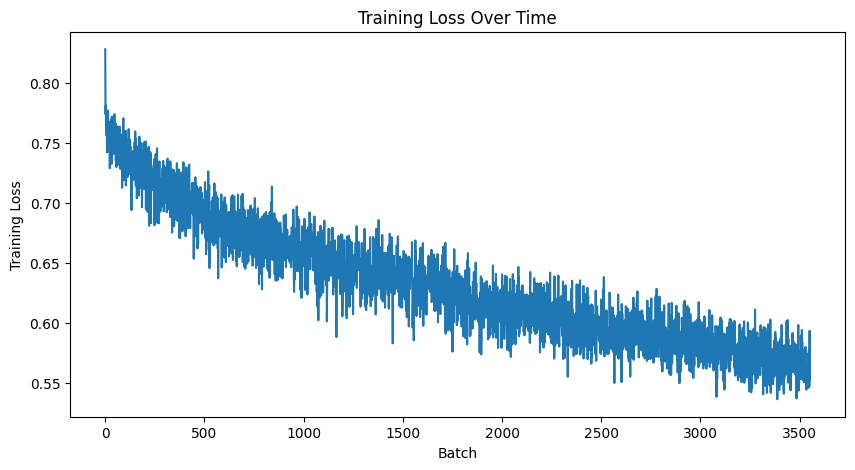

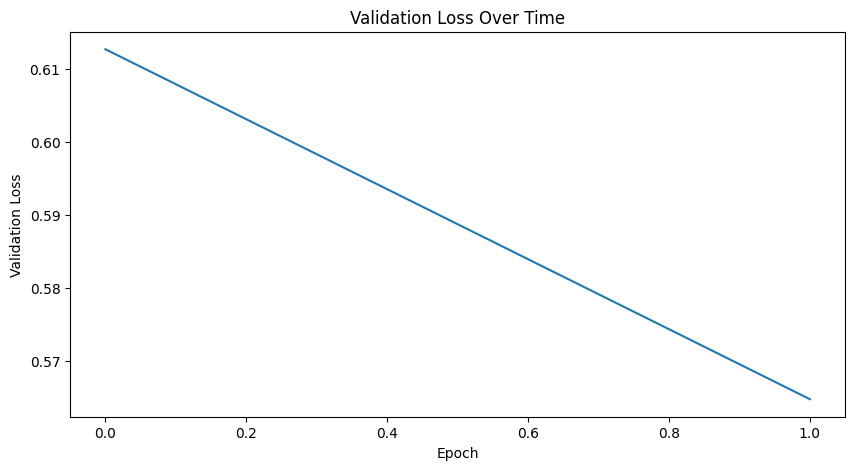

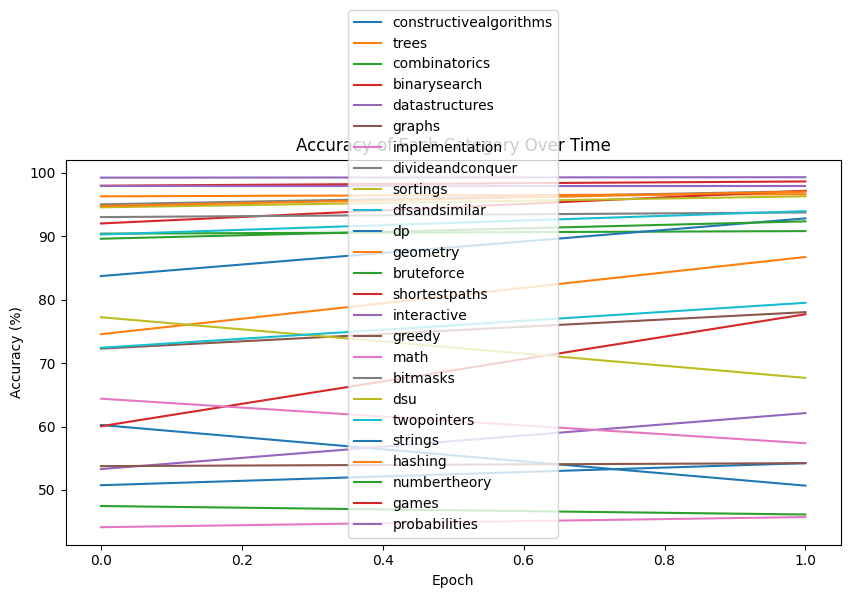

In [14]:
# prompt: make 3 charts, one the training loss over time, one the validation loss for each epoch and another with the accuracy rates of each category over each epoch label the categories by their true names found in index_to_tag

# Plot training loss over time
plt.figure(figsize=(10, 5))
plt.plot(total_losses)
plt.xlabel('Batch')
plt.ylabel('Training Loss')
plt.title('Training Loss Over Time')
plt.show()

# Plot validation loss for each epoch
plt.figure(figsize=(10, 5))
plt.plot(val_losses)
plt.xlabel('Epoch')
plt.ylabel('Validation Loss')
plt.title('Validation Loss Over Time')
plt.show()

# Plot accuracy rates of each category over epochs
plt.figure(figsize=(10, 5))
for i in range(n):
  accuracies = [epoch_accuracies[i] for epoch_accuracies in val_acc]
  plt.plot(accuracies, label=index_to_tag[i])

plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy of Each Category Over Time')
plt.legend()
plt.show()

Average Accuracy for Epoch 1: 77.83%
Average Accuracy for Epoch 2: 80.17%


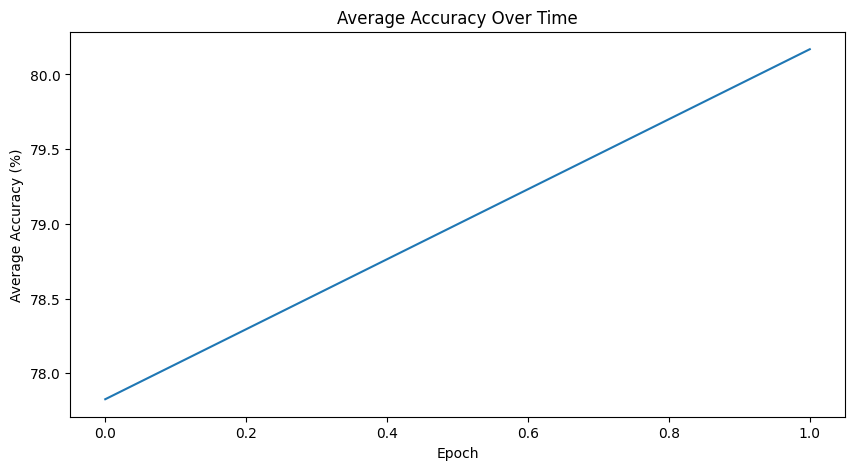

In [15]:
# prompt: now make a new char just for the average accuracy

# Calculate and print the average accuracy across all tags for each epoch
for epoch in range(EPOCHS):
    avg_epoch_accuracy = sum(val_acc[epoch]) / len(val_acc[epoch])
    print(f"Average Accuracy for Epoch {epoch + 1}: {avg_epoch_accuracy:.2f}%")

# Plot the average accuracy over epochs
plt.figure(figsize=(10, 5))
avg_accuracies = [sum(epoch_accuracies) / len(epoch_accuracies) for epoch_accuracies in val_acc]
plt.plot(avg_accuracies)
plt.xlabel('Epoch')
plt.ylabel('Average Accuracy (%)')
plt.title('Average Accuracy Over Time')
plt.show()